# Appendix __________________ - Supporting Python Code

#### Steve Desilets

#### December 3, 2023

# 1) Introduction and Exploratory Data Analysis

Let's import the MNIST Fashion Dataset and conduct exploratory data analysis.

In [24]:
from tensorflow.keras.datasets import fashion_mnist

(X_train_eda, Y_train_eda), (X_test_eda, Y_test_eda) = fashion_mnist.load_data()
print('Fashion MNIST Dataset Shape:')
print('X_train: ' + str(X_train_eda.shape))
print('Y_train: ' + str(Y_train_eda.shape))
print('X_test:  '  + str(X_test_eda.shape))
print('Y_test:  '  + str(Y_test_eda.shape))


Fashion MNIST Dataset Shape:
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

Let's visualize sample images from our dataset

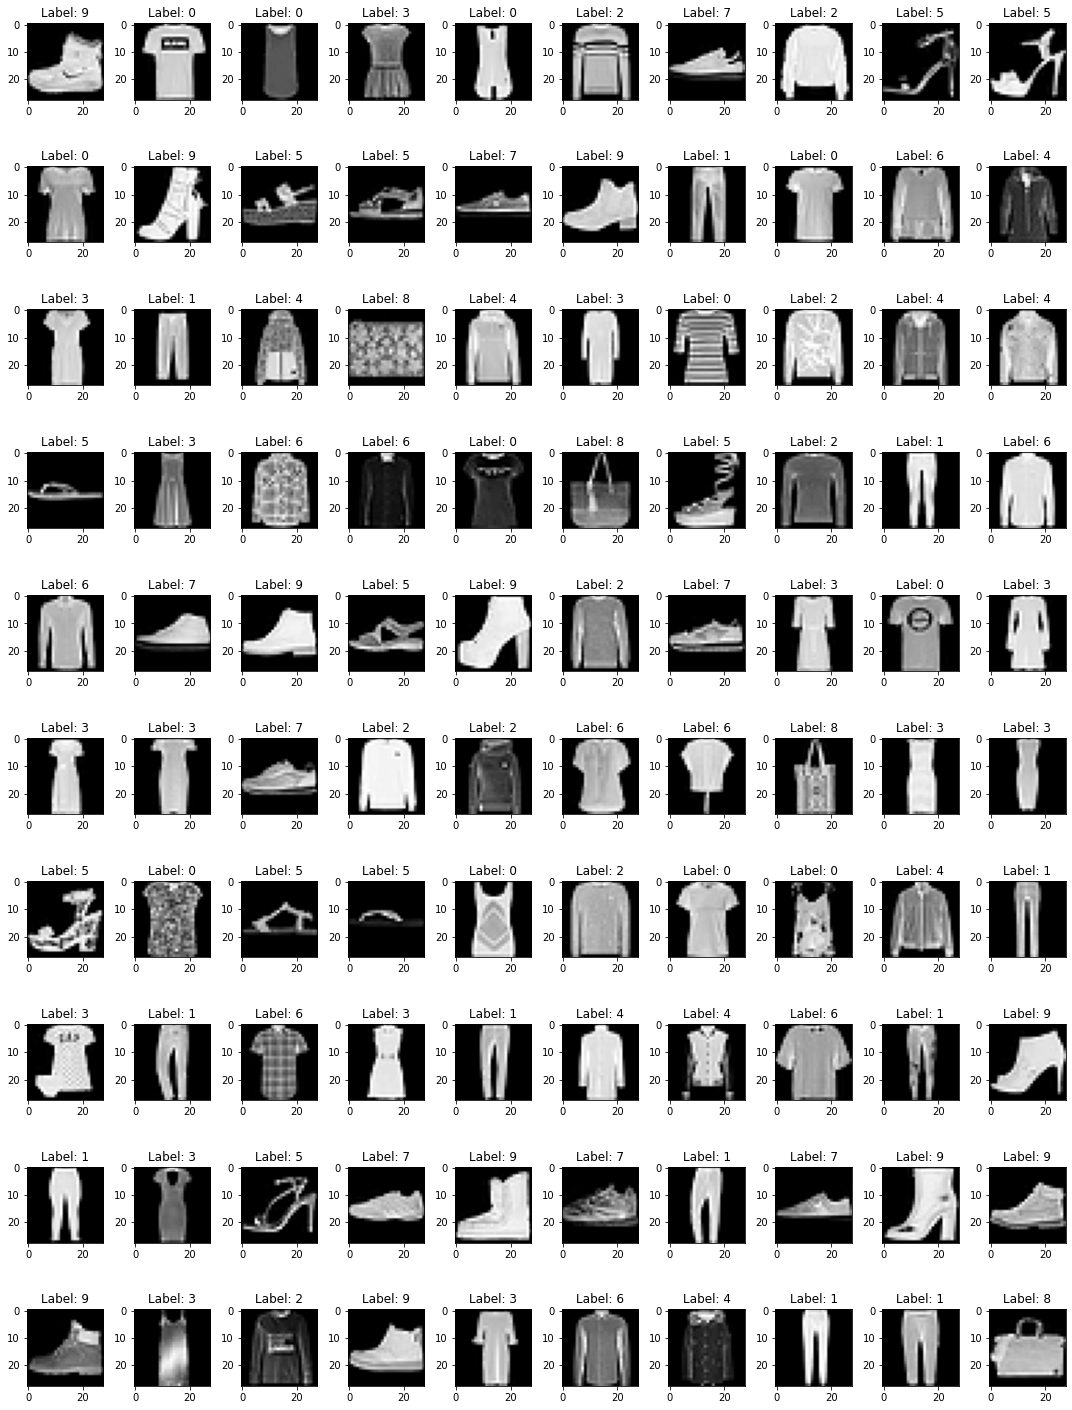

In [28]:
# specify the number of rows and columns you want to see
num_row = 10
num_col = 10

# get a segment of the dataset
num = num_row*num_col
images_eda = X_train_eda[:num]
labels_eda = Y_train_eda[:num]

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images_eda[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels_eda[i]))
plt.tight_layout()
plt.show()

Let's create a graph to display the number of observations that correspond to each of our 10 categories (as outlined below).

| Label In MNIST Fashion Dataset | Description 
| --- | --- |
| 0 | T-Shirt Or Top |
| 1 | Trousers |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal|
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle Boot |

In [33]:
print(type(Y_train_eda))

<class 'numpy.ndarray'>


In [36]:
unique_eda, counts_eda = np.unique(Y_train_eda, return_counts=True)

dict_of_counts = dict(zip(unique_eda, counts_eda))


In [40]:
import pandas as pd

df_counts = pd.DataFrame(list(dict_of_counts.items()), columns=['MNIST Dataset Label', 'Count of Observations'])
df_counts

MNIST Dataset Label  Count of Observations
0                    0                   6000
1                    1                   6000
2                    2                   6000
3                    3                   6000
4                    4                   6000
5                    5                   6000
6                    6                   6000
7                    7                   6000
8                    8                   6000
9                    9                   6000

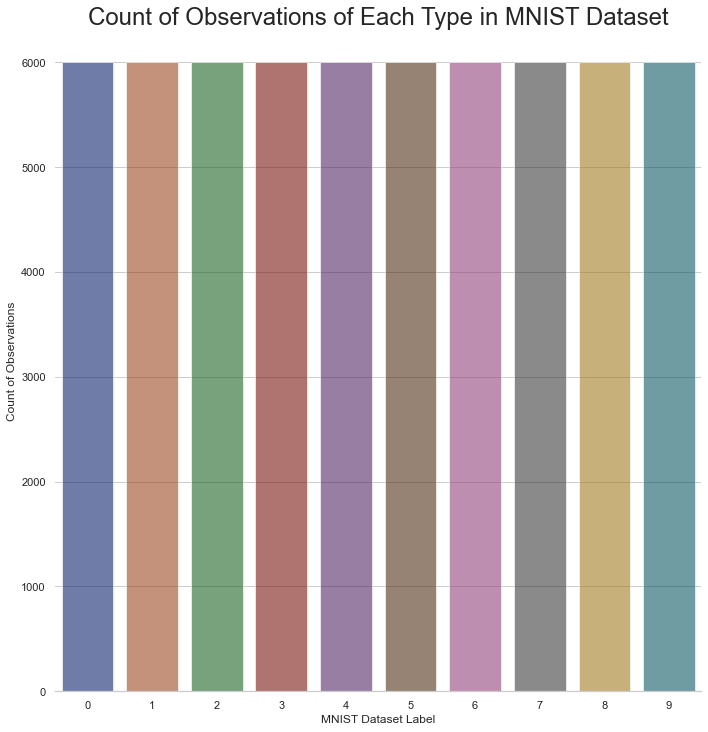

In [48]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_counts, kind="bar",
    x="MNIST Dataset Label", y="Count of Observations", 
    palette="dark", alpha=.6, height=10
)
g.despine(left=True)
sns.set(font_scale=2.0)
g.set_axis_labels("MNIST Dataset Label", "Count of Observations")
g.set(title='Count of Observations of Each Type in MNIST Dataset')

## 2) Model 1 - First AC-GAN Model

## 2.1) Create the Model

In [2]:
!pip install pydot


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install graphviz


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
# example of defining the discriminator model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import numpy as np

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # downsample to 14x14
    fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 7x7
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

# define the discriminator model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 14, 14, 32)   320         ['input_9[0][0]']                
                                                                                                  
 leaky_re_lu_16 (LeakyReLU)     (None, 14, 14, 32)   0           ['conv2d_16[0][0]']              
                                                                                                  
 dropout_16 (Dropout)           (None, 14, 14, 32)   0           ['leaky_re_lu_16[0][0]']         
                                                                                            

In [10]:
# example of defining the generator model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2DTranspose
from keras.layers import Embedding
from keras.layers import Concatenate
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.utils.vis_utils import plot_model

# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes, kernel_initializer=init)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 384 * 7 * 7
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 384))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 dense_15 (Dense)               (None, 18816)        1900416     ['input_11[0][0]']               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 50)        500         ['input_10[0][0]']               
                                                                                            

In [11]:
# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
import datetime
import time

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # downsample to 14x14
    fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 7x7
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes, kernel_initializer=init)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 384 * 7 * 7
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 384))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

# load images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape, trainy.shape)
    return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(100):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename1 = 'generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1, n_batch=64):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
        # generate 'fake' examples
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
        # summarize loss on this batch
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
        # evaluate the model performance every 'epoch'
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
start_time = datetime.datetime.now()

train(generator, discriminator, gan_model, dataset, latent_dim)

end_time = datetime.datetime.now()
runtime = end_time - start_time
print(f"The runtime to fit this model was: {runtime}.")

(60000, 28, 28, 1) (60000,)
1/1 [==============================] - 0s 247ms/step
>1, dr[0.497,3.104], df[1.586,2.983], g[0.505,3.093]
1/1 [==============================] - 0s 138ms/step
>2, dr[0.418,2.847], df[1.411,3.368], g[0.856,3.244]
1/1 [==============================] - 0s 137ms/step
>3, dr[0.746,2.975], df[1.035,3.395], g[0.867,3.275]
1/1 [==============================] - 0s 105ms/step
>4, dr[0.615,3.115], df[0.806,2.889], g[0.850,3.403]
1/1 [==============================] - 0s 99ms/step
>5, dr[0.825,3.034], df[0.971,2.724], g[1.119,3.434]
1/1 [==============================] - 0s 97ms/step
>6, dr[0.614,2.641], df[0.868,3.382], g[1.119,3.095]
1/1 [==============================] - 0s 129ms/step
>7, dr[0.709,2.766], df[0.661,3.220], g[1.075,2.810]
1/1 [==============================] - 0s 124ms/step
>8, dr[0.498,2.774], df[0.640,3.229], g[1.388,3.031]
1/1 [==============================] - 0s 101ms/step
>9, dr[0.439,2.467], df[0.533,3.058], g[1.107,3.179]
1/1 [===============

1/1 [==============================] - 0s 115ms/step
>78, dr[0.131,1.329], df[0.089,3.226], g[0.131,2.878]
1/1 [==============================] - 0s 123ms/step
>79, dr[0.102,1.370], df[0.097,2.905], g[0.111,3.153]
1/1 [==============================] - 0s 137ms/step
>80, dr[0.240,1.448], df[0.027,3.276], g[0.084,3.153]
1/1 [==============================] - 0s 115ms/step
>81, dr[0.148,1.432], df[0.105,3.146], g[0.064,3.073]
1/1 [==============================] - 0s 95ms/step
>82, dr[0.139,0.915], df[0.152,2.922], g[0.045,2.580]
1/1 [==============================] - 0s 120ms/step
>83, dr[0.049,1.152], df[0.197,2.776], g[0.140,2.825]
1/1 [==============================] - 0s 92ms/step
>84, dr[0.319,1.520], df[0.114,2.715], g[0.062,2.869]
1/1 [==============================] - 0s 93ms/step
>85, dr[0.054,1.355], df[0.094,3.192], g[0.095,3.191]
1/1 [==============================] - 0s 95ms/step
>86, dr[0.124,1.076], df[0.088,3.624], g[0.067,3.135]
1/1 [==============================] - 0s

>154, dr[0.246,1.208], df[0.588,0.603], g[0.131,0.639]
1/1 [==============================] - 0s 145ms/step
>155, dr[0.244,0.624], df[0.076,0.729], g[0.140,0.720]
1/1 [==============================] - 0s 99ms/step
>156, dr[0.084,1.062], df[0.090,0.780], g[0.043,0.707]
1/1 [==============================] - 0s 92ms/step
>157, dr[0.221,1.016], df[0.280,0.780], g[0.049,0.493]
1/1 [==============================] - 0s 124ms/step
>158, dr[0.144,0.930], df[0.067,0.803], g[0.055,0.624]
1/1 [==============================] - 0s 105ms/step
>159, dr[0.099,1.485], df[0.158,0.535], g[0.098,0.548]
1/1 [==============================] - 0s 93ms/step
>160, dr[0.118,1.679], df[0.144,0.704], g[0.082,0.433]
1/1 [==============================] - 0s 119ms/step
>161, dr[0.112,1.040], df[0.105,0.612], g[0.116,0.314]
1/1 [==============================] - 0s 98ms/step
>162, dr[0.157,0.901], df[0.043,0.803], g[0.053,0.522]
1/1 [==============================] - 0s 93ms/step
>163, dr[0.215,1.233], df[0.193,0

1/1 [==============================] - 0s 79ms/step
>231, dr[0.059,0.813], df[0.027,0.216], g[0.245,0.148]
1/1 [==============================] - 0s 132ms/step
>232, dr[0.032,0.878], df[0.063,0.214], g[0.173,0.131]
1/1 [==============================] - 0s 102ms/step
>233, dr[0.032,1.087], df[0.072,0.220], g[0.163,0.191]
1/1 [==============================] - 0s 96ms/step
>234, dr[0.035,0.828], df[0.029,0.155], g[0.165,0.285]
1/1 [==============================] - 0s 89ms/step
>235, dr[0.036,0.680], df[0.047,0.146], g[0.180,0.150]
1/1 [==============================] - 0s 103ms/step
>236, dr[0.076,1.264], df[0.053,0.229], g[0.062,0.198]
1/1 [==============================] - 0s 87ms/step
>237, dr[0.032,1.183], df[0.148,0.129], g[0.345,0.169]
1/1 [==============================] - 0s 132ms/step
>238, dr[0.104,0.679], df[0.093,0.144], g[0.340,0.248]
1/1 [==============================] - 0s 86ms/step
>239, dr[0.050,0.642], df[0.221,0.254], g[0.580,0.228]
1/1 [============================

1/1 [==============================] - 0s 128ms/step
>383, dr[0.444,0.564], df[0.156,0.061], g[1.092,0.135]
1/1 [==============================] - 0s 95ms/step
>384, dr[0.550,0.546], df[0.502,0.077], g[0.782,0.293]
1/1 [==============================] - 0s 103ms/step
>385, dr[0.377,1.057], df[0.594,0.048], g[1.383,0.116]
1/1 [==============================] - 0s 100ms/step
>386, dr[0.401,0.678], df[0.317,0.099], g[1.737,0.138]
1/1 [==============================] - 0s 87ms/step
>387, dr[0.630,0.806], df[0.664,0.097], g[1.862,0.102]
1/1 [==============================] - 0s 91ms/step
>388, dr[0.461,0.805], df[0.301,0.083], g[1.529,0.107]
1/1 [==============================] - 0s 90ms/step
>389, dr[0.601,0.874], df[0.736,0.053], g[1.782,0.100]
1/1 [==============================] - 0s 95ms/step
>390, dr[0.387,0.790], df[0.485,0.078], g[2.031,0.205]
1/1 [==============================] - 0s 97ms/step
>391, dr[0.433,0.568], df[0.233,0.103], g[2.002,0.115]
1/1 [=============================

1/1 [==============================] - 0s 105ms/step
>535, dr[0.498,0.963], df[0.293,0.210], g[1.903,0.191]
1/1 [==============================] - 0s 108ms/step
>536, dr[0.592,0.358], df[0.696,0.057], g[1.884,0.169]
1/1 [==============================] - 0s 109ms/step
>537, dr[0.618,0.949], df[0.575,0.219], g[2.160,0.138]
1/1 [==============================] - 0s 119ms/step
>538, dr[0.600,0.625], df[0.273,0.038], g[2.521,0.127]
1/1 [==============================] - 0s 111ms/step
>539, dr[0.496,0.702], df[0.362,0.023], g[2.340,0.199]
1/1 [==============================] - 0s 96ms/step
>540, dr[0.405,0.987], df[0.415,0.118], g[2.400,0.173]
1/1 [==============================] - 0s 112ms/step
>541, dr[0.426,0.668], df[0.298,0.195], g[1.902,0.195]
1/1 [==============================] - 0s 90ms/step
>542, dr[0.324,0.687], df[0.333,0.228], g[2.354,0.085]
1/1 [==============================] - 0s 113ms/step
>543, dr[0.372,0.997], df[0.469,0.114], g[2.396,0.174]
1/1 [=========================

1/1 [==============================] - 0s 101ms/step
>687, dr[0.092,0.887], df[0.174,0.104], g[2.651,0.199]
1/1 [==============================] - 0s 91ms/step
>688, dr[0.193,0.791], df[0.124,0.074], g[3.238,0.102]
1/1 [==============================] - 0s 94ms/step
>689, dr[0.240,0.446], df[0.121,0.185], g[2.817,0.220]
1/1 [==============================] - 0s 117ms/step
>690, dr[0.090,0.791], df[0.073,0.159], g[3.112,0.147]
1/1 [==============================] - 0s 97ms/step
>691, dr[0.149,0.879], df[0.202,0.030], g[3.157,0.125]
1/1 [==============================] - 0s 92ms/step
>692, dr[0.142,1.365], df[0.125,0.106], g[2.733,0.133]
1/1 [==============================] - 0s 117ms/step
>693, dr[0.382,1.013], df[0.398,0.086], g[2.920,0.146]
1/1 [==============================] - 0s 93ms/step
>694, dr[0.283,1.362], df[0.242,0.240], g[3.370,0.118]
1/1 [==============================] - 0s 98ms/step
>695, dr[0.165,0.760], df[0.214,0.236], g[3.725,0.156]
1/1 [=============================

1/1 [==============================] - 0s 104ms/step
>839, dr[0.386,1.005], df[0.218,0.042], g[2.075,0.039]
1/1 [==============================] - 0s 116ms/step
>840, dr[0.309,0.646], df[0.238,0.042], g[2.201,0.042]
1/1 [==============================] - 0s 109ms/step
>841, dr[0.251,0.626], df[0.568,0.025], g[2.504,0.070]
1/1 [==============================] - 0s 125ms/step
>842, dr[0.477,0.807], df[0.484,0.026], g[2.073,0.038]
1/1 [==============================] - 0s 104ms/step
>843, dr[0.380,0.480], df[0.298,0.081], g[2.332,0.087]
1/1 [==============================] - 0s 117ms/step
>844, dr[0.370,0.758], df[0.410,0.075], g[2.075,0.062]
1/1 [==============================] - 0s 128ms/step
>845, dr[0.525,0.824], df[0.441,0.048], g[2.393,0.050]
1/1 [==============================] - 0s 107ms/step
>846, dr[0.710,0.840], df[0.336,0.056], g[1.378,0.036]
1/1 [==============================] - 0s 95ms/step
>847, dr[0.224,0.604], df[0.688,0.151], g[2.101,0.078]
1/1 [========================

## 2.2) Evaluate Model Performance

In [4]:
# example of loading the generator model and generating images
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot
import numpy as np



model = load_model('model_0937.h5')
latent_dim = 100
n_examples = 300



# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = asarray([n_class for _ in range(n_samples)])
    return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n_examples):
    # plot images
    for i in range(n_examples):
        # define subplot
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()






# Generate T-Shirt or Top Images
n_class = 0
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
t_shirt_or_top  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
t_shirt_or_top = (t_shirt_or_top + 1) / 2.0


# Generate Trouser Images
n_class = 1
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
trouser  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
trouser = (trouser + 1) / 2.0


# Generate Pullover Images
n_class = 2
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
pullover  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
pullover = (pullover + 1) / 2.0


# Generate Dress Images
n_class = 3
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
dress  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
dress = (dress + 1) / 2.0



# Generate Coat Images
n_class = 4
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
coat  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
coat = (coat + 1) / 2.0


# Generate Sandal Images
n_class = 5
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sandal  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sandal = (sandal + 1) / 2.0



# Generate Shirt Images
n_class = 6
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
shirt  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
shirt = (shirt + 1) / 2.0


# Generate Sneaker Images
n_class = 7
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sneaker  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sneaker = (sneaker + 1) / 2.0


# Generate Bag Images
n_class = 8
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
bag  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
bag = (bag + 1) / 2.0



# Generate Ankle Boot Images
n_class = 9
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
ankle_boot  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
ankle_boot = (ankle_boot + 1) / 2.0


Z = np.concatenate((t_shirt_or_top,
                    trouser,
                    pullover,
                    dress,
                    coat,
                    sandal,
                    shirt,
                    sneaker,
                    bag,
                    ankle_boot), axis=0)
print(Z.shape)

10/10 [==============================] - 1s 54ms/step
(3000, 28, 28, 1)


In [6]:
# calculate inception score in Keras
from math import floor
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)


model_for_weights = model

# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
    # load inception v3 model
    model = InceptionV3(classes=10, include_top = False)
    # enumerate splits of images/predictions
    scores = list()
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        # retrieve images
        ix_start, ix_end = i * n_part, (i+1) * n_part
        subset = images[ix_start:ix_end]
        # convert from uint8 to float32
        subset = subset.astype('float32')
        # scale images to the required size
        subset = scale_images(subset, (299,299,3))
        # pre-process images, scale to [-1,1]
        subset = preprocess_input(subset)
        # predict p(y|x)
        p_yx = model.predict(subset)
        # calculate p(y)
        p_y = expand_dims(p_yx.mean(axis=0), 0)
        # calculate KL divergence using log probabilities
        kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
        # sum over classes
        sum_kl_d = kl_d.sum(axis=1)
        # average over images
        avg_kl_d = mean(sum_kl_d)
        # undo the log
        is_score = exp(avg_kl_d)
        # store
        scores.append(is_score)
    # average across images
    is_avg, is_std = mean(scores), std(scores)
    return is_avg, is_std

# load cifar10 images
#(images, _), (_, _) = cifar10.load_data()
# shuffle images
shuffle(Z)
#print('loaded', images.shape)
# calculate inception score
#is_avg, is_std = calculate_inception_score(images)
is_avg, is_std = calculate_inception_score(Z)
print('score', is_avg, is_std)

10/10 [==============================] - 15s 2s/step
score 1.1270496 0.002707503


## 3) Model 2 - AC-GAN with 200-Dimensional Latent Space

### 3.1) Build The Model

Let's construct and train the AC-GAN model. For this model, we will try to improve performance by modifying the first model by having a 200-dimensional latent space instead of a 100-dimensional latent space.

In [11]:
# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
import datetime
import time
from keras.utils.vis_utils import plot_model
import numpy as np



# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # downsample to 14x14
    fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 7x7
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model
    model.summary

# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes, kernel_initializer=init)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 384 * 7 * 7
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 384))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model
    model.summary

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

# load images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape, trainy.shape)
    return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(100):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename1 = 'generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1, n_batch=64):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
        # generate 'fake' examples
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
        # summarize loss on this batch
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
        # evaluate the model performance every 'epoch'
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

# size of the latent space
latent_dim = 200
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
start_time = datetime.datetime.now()

train(generator, discriminator, gan_model, dataset, latent_dim)

end_time = datetime.datetime.now()
runtime = end_time - start_time
print(f"The runtime to fit this model was: {runtime}.")

(60000, 28, 28, 1) (60000,)
1/1 [==============================] - 0s 215ms/step
>1, dr[0.954,3.227], df[1.220,2.911], g[0.850,3.034]
1/1 [==============================] - 0s 93ms/step
>2, dr[0.634,2.991], df[1.203,3.373], g[0.820,3.339]
1/1 [==============================] - 0s 93ms/step
>3, dr[0.562,3.365], df[0.779,2.931], g[1.056,3.061]
1/1 [==============================] - 0s 69ms/step
>4, dr[0.547,2.710], df[0.736,2.713], g[1.054,3.428]
1/1 [==============================] - 0s 85ms/step
>5, dr[0.816,2.661], df[0.675,3.024], g[1.008,3.156]
1/1 [==============================] - 0s 75ms/step
>6, dr[0.529,2.709], df[0.809,2.823], g[1.118,3.045]
1/1 [==============================] - 0s 80ms/step
>7, dr[0.457,2.955], df[0.421,3.245], g[1.467,2.902]
1/1 [==============================] - 0s 69ms/step
>8, dr[0.736,2.612], df[0.760,3.277], g[1.192,3.286]
1/1 [==============================] - 0s 76ms/step
>9, dr[0.483,2.815], df[0.731,2.885], g[1.349,3.526]
1/1 [=====================

1/1 [==============================] - 0s 79ms/step
>155, dr[0.048,0.817], df[0.168,1.008], g[0.141,0.801]
1/1 [==============================] - 0s 69ms/step
>156, dr[0.168,1.129], df[0.093,0.953], g[0.089,0.837]
1/1 [==============================] - 0s 71ms/step
>157, dr[0.157,0.682], df[0.134,0.848], g[0.124,0.887]
1/1 [==============================] - 0s 71ms/step
>158, dr[0.124,0.710], df[0.235,0.611], g[0.254,0.793]
1/1 [==============================] - 0s 70ms/step
>159, dr[0.193,0.961], df[0.072,0.817], g[0.277,1.042]
1/1 [==============================] - 0s 78ms/step
>160, dr[0.209,0.735], df[0.061,0.898], g[0.100,0.675]
1/1 [==============================] - 0s 75ms/step
>161, dr[0.121,0.899], df[0.128,0.736], g[0.119,0.799]
1/1 [==============================] - 0s 74ms/step
>162, dr[0.104,1.252], df[0.067,0.821], g[0.080,0.734]
1/1 [==============================] - 0s 71ms/step
>163, dr[0.109,1.382], df[0.120,1.026], g[0.060,0.812]
1/1 [==============================] 

1/1 [==============================] - 0s 94ms/step
>232, dr[0.077,0.827], df[0.236,0.313], g[1.248,0.260]
1/1 [==============================] - 0s 75ms/step
>233, dr[0.168,0.845], df[0.108,0.328], g[1.086,0.393]
1/1 [==============================] - 0s 80ms/step
>234, dr[0.145,1.032], df[0.090,0.199], g[0.477,0.250]
1/1 [==============================] - 0s 80ms/step
>235, dr[0.248,0.713], df[0.606,0.266], g[1.032,0.283]
1/1 [==============================] - 0s 81ms/step
>236, dr[0.298,0.594], df[0.055,0.163], g[0.598,0.173]
1/1 [==============================] - 0s 78ms/step
>237, dr[0.114,0.446], df[0.277,0.216], g[0.575,0.243]
1/1 [==============================] - 0s 74ms/step
>238, dr[0.297,0.929], df[0.205,0.305], g[0.526,0.270]
1/1 [==============================] - 0s 96ms/step
>239, dr[0.105,0.798], df[0.107,0.222], g[0.688,0.233]
1/1 [==============================] - 0s 79ms/step
>240, dr[0.417,0.848], df[1.017,0.143], g[2.998,0.275]
1/1 [==============================] 

1/1 [==============================] - 0s 71ms/step
>309, dr[0.327,0.442], df[0.256,0.176], g[1.182,0.125]
1/1 [==============================] - 0s 73ms/step
>310, dr[0.393,1.007], df[0.303,0.198], g[0.972,0.054]
1/1 [==============================] - 0s 76ms/step
>311, dr[0.198,0.677], df[0.527,0.108], g[1.625,0.253]
1/1 [==============================] - 0s 77ms/step
>312, dr[0.498,1.056], df[0.314,0.129], g[1.257,0.204]
1/1 [==============================] - 0s 78ms/step
>313, dr[0.789,1.457], df[1.062,0.173], g[1.432,0.172]
1/1 [==============================] - 0s 70ms/step
>314, dr[0.504,0.926], df[0.257,0.188], g[1.287,0.377]
1/1 [==============================] - 0s 72ms/step
>315, dr[0.636,0.800], df[1.238,0.074], g[1.979,0.197]
1/1 [==============================] - 0s 69ms/step
>316, dr[0.646,0.998], df[0.355,0.054], g[1.895,0.214]
1/1 [==============================] - 0s 69ms/step
>317, dr[1.119,0.915], df[0.987,0.249], g[2.343,0.230]
1/1 [==============================] 

1/1 [==============================] - 0s 71ms/step
>386, dr[0.474,0.572], df[0.405,0.242], g[2.538,0.227]
1/1 [==============================] - 0s 79ms/step
>387, dr[0.431,0.631], df[0.690,0.129], g[2.626,0.196]
1/1 [==============================] - 0s 82ms/step
>388, dr[1.046,1.005], df[0.625,0.095], g[2.039,0.098]
1/1 [==============================] - 0s 74ms/step
>389, dr[0.302,0.963], df[0.645,0.055], g[2.243,0.052]
1/1 [==============================] - 0s 70ms/step
>390, dr[0.475,0.872], df[0.191,0.063], g[2.486,0.051]
1/1 [==============================] - 0s 68ms/step
>391, dr[0.556,0.907], df[0.633,0.135], g[1.618,0.063]
1/1 [==============================] - 0s 72ms/step
>392, dr[0.367,0.637], df[0.435,0.062], g[2.065,0.114]
1/1 [==============================] - 0s 67ms/step
>393, dr[0.634,1.283], df[0.356,0.240], g[1.907,0.104]
1/1 [==============================] - 0s 87ms/step
>394, dr[0.633,0.539], df[0.547,0.279], g[2.296,0.109]
1/1 [==============================] 

>462, dr[0.178,0.648], df[0.247,0.104], g[2.332,0.057]
1/1 [==============================] - 0s 73ms/step
>463, dr[0.901,1.079], df[0.633,0.080], g[1.845,0.089]
1/1 [==============================] - 0s 80ms/step
>464, dr[0.186,0.681], df[0.734,0.100], g[2.606,0.150]
1/1 [==============================] - 0s 83ms/step
>465, dr[0.427,0.813], df[0.758,0.190], g[2.868,0.142]
1/1 [==============================] - 0s 74ms/step
>466, dr[0.984,0.720], df[0.714,0.326], g[2.332,0.069]
1/1 [==============================] - 0s 70ms/step
>467, dr[0.588,1.021], df[1.041,0.434], g[2.370,0.081]
1/1 [==============================] - 0s 71ms/step
>468, dr[0.674,0.770], df[0.784,0.087], g[2.879,0.088]
1/1 [==============================] - 0s 77ms/step
>469, dr[0.430,0.472], df[0.336,0.211], g[3.076,0.145]
1/1 [==============================] - 0s 94ms/step
>470, dr[0.316,0.666], df[0.380,0.118], g[2.720,0.214]
1/1 [==============================] - 0s 86ms/step
>471, dr[0.372,1.270], df[0.708,0.105

1/1 [==============================] - 0s 71ms/step
>616, dr[0.164,1.371], df[0.302,0.127], g[2.915,0.157]
1/1 [==============================] - 0s 69ms/step
>617, dr[0.246,0.603], df[0.284,0.070], g[3.498,0.080]
1/1 [==============================] - 0s 66ms/step
>618, dr[0.714,0.935], df[0.234,0.077], g[2.375,0.063]
1/1 [==============================] - 0s 72ms/step
>619, dr[0.231,0.555], df[0.474,0.096], g[3.435,0.121]
1/1 [==============================] - 0s 75ms/step
>620, dr[0.368,0.793], df[0.304,0.109], g[3.261,0.115]
1/1 [==============================] - 0s 71ms/step
>621, dr[0.405,1.295], df[0.188,0.212], g[3.606,0.283]
1/1 [==============================] - 0s 80ms/step
>622, dr[0.444,0.691], df[0.274,0.079], g[2.422,0.122]
1/1 [==============================] - 0s 69ms/step
>623, dr[0.153,0.569], df[0.290,0.109], g[2.520,0.200]
1/1 [==============================] - 0s 78ms/step
>624, dr[0.247,1.034], df[0.317,0.292], g[3.179,0.100]
1/1 [==============================] 

1/1 [==============================] - 0s 85ms/step
>693, dr[0.312,0.793], df[0.306,0.020], g[2.237,0.224]
1/1 [==============================] - 0s 74ms/step
>694, dr[0.273,0.892], df[0.219,0.116], g[1.916,0.192]
1/1 [==============================] - 0s 80ms/step
>695, dr[0.403,0.618], df[0.372,0.212], g[2.339,0.248]
1/1 [==============================] - 0s 77ms/step
>696, dr[0.364,0.665], df[0.125,0.157], g[1.558,0.347]
1/1 [==============================] - 0s 76ms/step
>697, dr[0.655,0.666], df[0.702,0.327], g[2.016,0.244]
1/1 [==============================] - 0s 85ms/step
>698, dr[0.217,1.130], df[0.255,0.110], g[2.347,0.187]
1/1 [==============================] - 0s 83ms/step
>699, dr[0.235,1.172], df[0.399,0.122], g[2.510,0.208]
1/1 [==============================] - 0s 82ms/step
>700, dr[0.471,0.419], df[0.271,0.038], g[1.526,0.118]
1/1 [==============================] - 0s 72ms/step
>701, dr[0.233,0.727], df[0.441,0.277], g[2.104,0.188]
1/1 [==============================] 

1/1 [==============================] - 0s 83ms/step
>770, dr[0.717,1.039], df[0.432,0.155], g[1.481,0.175]
1/1 [==============================] - 0s 81ms/step
>771, dr[0.649,0.440], df[0.659,0.132], g[2.286,0.170]
1/1 [==============================] - 0s 84ms/step
>772, dr[0.576,0.838], df[0.300,0.085], g[2.190,0.144]
1/1 [==============================] - 0s 73ms/step
>773, dr[0.197,0.830], df[0.249,0.116], g[2.307,0.155]
1/1 [==============================] - 0s 80ms/step
>774, dr[0.432,0.783], df[0.390,0.112], g[2.918,0.207]
1/1 [==============================] - 0s 91ms/step
>775, dr[0.527,1.425], df[0.155,0.215], g[1.911,0.151]
1/1 [==============================] - 0s 77ms/step
>776, dr[0.315,0.559], df[0.278,0.258], g[1.326,0.271]
1/1 [==============================] - 0s 88ms/step
>777, dr[0.064,0.708], df[0.281,0.057], g[2.321,0.236]
1/1 [==============================] - 0s 86ms/step
>778, dr[0.215,0.706], df[0.144,0.244], g[2.883,0.207]
1/1 [==============================] 

>846, dr[0.097,0.935], df[0.037,0.033], g[2.757,0.238]
1/1 [==============================] - 0s 105ms/step
>847, dr[0.023,1.027], df[0.060,0.103], g[2.672,0.072]
1/1 [==============================] - 0s 118ms/step
>848, dr[0.109,0.637], df[0.059,0.030], g[2.603,0.055]
1/1 [==============================] - 0s 90ms/step
>849, dr[0.015,0.805], df[0.061,0.060], g[3.256,0.047]
1/1 [==============================] - 0s 91ms/step
>850, dr[0.031,1.011], df[0.024,0.065], g[3.114,0.077]
1/1 [==============================] - 0s 81ms/step
>851, dr[0.026,0.662], df[0.107,0.165], g[3.186,0.032]
1/1 [==============================] - 0s 78ms/step
>852, dr[0.022,0.733], df[0.036,0.093], g[3.552,0.062]
1/1 [==============================] - 0s 82ms/step
>853, dr[0.032,0.490], df[0.019,0.046], g[2.921,0.048]
1/1 [==============================] - 0s 87ms/step
>854, dr[0.037,0.493], df[0.027,0.081], g[2.701,0.088]
1/1 [==============================] - 0s 80ms/step
>855, dr[0.084,0.858], df[0.020,0.1

1/1 [==============================] - 0s 78ms/step
>923, dr[0.393,0.553], df[0.340,0.106], g[2.021,0.169]
1/1 [==============================] - 0s 99ms/step
>924, dr[0.213,0.933], df[0.169,0.105], g[3.127,0.072]
1/1 [==============================] - 0s 105ms/step
>925, dr[0.213,0.708], df[0.114,0.089], g[2.544,0.079]
1/1 [==============================] - 0s 83ms/step
>926, dr[0.295,0.693], df[0.333,0.090], g[2.071,0.091]
1/1 [==============================] - 0s 82ms/step
>927, dr[0.278,0.591], df[0.274,0.059], g[2.631,0.078]
1/1 [==============================] - 0s 91ms/step
>928, dr[0.237,0.237], df[0.179,0.083], g[2.507,0.084]
1/1 [==============================] - 0s 91ms/step
>929, dr[0.413,0.784], df[0.204,0.056], g[2.509,0.065]
1/1 [==============================] - 0s 90ms/step
>930, dr[0.101,0.495], df[0.666,0.042], g[3.549,0.096]
1/1 [==============================] - 0s 98ms/step
>931, dr[0.353,0.698], df[0.159,0.025], g[3.415,0.063]
1/1 [==============================]

In [16]:
discriminator.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_192 (Conv2D)            (None, 14, 14, 32)   320         ['input_6[0][0]']                
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)      (None, 14, 14, 32)   0           ['conv2d_192[0][0]']             
                                                                                                  
 dropout_4 (Dropout)            (None, 14, 14, 32)   0           ['leaky_re_lu_4[0][0]']          
                                                                                            

In [15]:
generator.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 18816)        3782016     ['input_8[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        500         ['input_7[0][0]']                
                                                                                            

## 3.2) Evaluate Model Performance

Let's generate fake images of clothes that can be used to calculate the inception scores

In [17]:
# example of loading the generator model and generating images
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot
import numpy as np



model = load_model('model_0937.h5')
latent_dim = 200
n_examples = 300



# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = asarray([n_class for _ in range(n_samples)])
    return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n_examples):
    # plot images
    for i in range(n_examples):
        # define subplot
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()






# Generate T-Shirt or Top Images
n_class = 0
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
t_shirt_or_top  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
t_shirt_or_top = (t_shirt_or_top + 1) / 2.0


# Generate Trouser Images
n_class = 1
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
trouser  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
trouser = (trouser + 1) / 2.0


# Generate Pullover Images
n_class = 2
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
pullover  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
pullover = (pullover + 1) / 2.0


# Generate Dress Images
n_class = 3
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
dress  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
dress = (dress + 1) / 2.0



# Generate Coat Images
n_class = 4
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
coat  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
coat = (coat + 1) / 2.0


# Generate Sandal Images
n_class = 5
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sandal  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sandal = (sandal + 1) / 2.0



# Generate Shirt Images
n_class = 6
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
shirt  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
shirt = (shirt + 1) / 2.0


# Generate Sneaker Images
n_class = 7
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sneaker  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sneaker = (sneaker + 1) / 2.0


# Generate Bag Images
n_class = 8
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
bag  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
bag = (bag + 1) / 2.0



# Generate Ankle Boot Images
n_class = 9
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
ankle_boot  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
ankle_boot = (ankle_boot + 1) / 2.0


Z = np.concatenate((t_shirt_or_top,
                    trouser,
                    pullover,
                    dress,
                    coat,
                    sandal,
                    shirt,
                    sneaker,
                    bag,
                    ankle_boot), axis=0)
print(Z.shape)

10/10 [==============================] - 1s 59ms/step
(3000, 28, 28, 1)


Let's calculate the inception score

In [18]:
# calculate inception score in Keras
from math import floor
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)


model_for_weights = model

# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
    # load inception v3 model
    model = InceptionV3(classes=10, include_top = False)
    # enumerate splits of images/predictions
    scores = list()
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        # retrieve images
        ix_start, ix_end = i * n_part, (i+1) * n_part
        subset = images[ix_start:ix_end]
        # convert from uint8 to float32
        subset = subset.astype('float32')
        # scale images to the required size
        subset = scale_images(subset, (299,299,3))
        # pre-process images, scale to [-1,1]
        subset = preprocess_input(subset)
        # predict p(y|x)
        p_yx = model.predict(subset)
        # calculate p(y)
        p_y = expand_dims(p_yx.mean(axis=0), 0)
        # calculate KL divergence using log probabilities
        kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
        # sum over classes
        sum_kl_d = kl_d.sum(axis=1)
        # average over images
        avg_kl_d = mean(sum_kl_d)
        # undo the log
        is_score = exp(avg_kl_d)
        # store
        scores.append(is_score)
    # average across images
    is_avg, is_std = mean(scores), std(scores)
    return is_avg, is_std

# load cifar10 images
#(images, _), (_, _) = cifar10.load_data()
# shuffle images
shuffle(Z)
#print('loaded', images.shape)
# calculate inception score
#is_avg, is_std = calculate_inception_score(images)
is_avg, is_std = calculate_inception_score(Z)
print('score', is_avg, is_std)

10/10 [==============================] - 15s 1s/step
score 1.1502178 0.0031078113


# 4) Model 3 - Increased Number of Epochs

## 4.1) Build The Model

In [1]:
# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
import datetime
import time
from keras.utils.vis_utils import plot_model
import numpy as np



# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # downsample to 14x14
    fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 7x7
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model
    model.summary

# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes, kernel_initializer=init)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 384 * 7 * 7
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 384))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model
    model.summary

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

# load images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape, trainy.shape)
    return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(100):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename1 = 'generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=3, n_batch=64):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
        # generate 'fake' examples
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
        # summarize loss on this batch
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
        # evaluate the model performance every 'epoch'
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
start_time = datetime.datetime.now()

train(generator, discriminator, gan_model, dataset, latent_dim)

end_time = datetime.datetime.now()
runtime = end_time - start_time
print(f"The runtime to fit this model was: {runtime}.")

C:\Users\steve\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
C:\Users\steve\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(60000, 28, 28, 1) (60000,)
1/1 [==============================] - 0s 184ms/step
>1, dr[0.910,2.330], df[1.358,3.024], g[0.735,3.081]
1/1 [==============================] - 0s 71ms/step
>2, dr[0.492,3.007], df[1.164,3.010], g[0.978,3.280]
1/1 [==============================] - 0s 74ms/step
>3, dr[0.810,3.164], df[0.937,2.860], g[1.117,2.933]
1/1 [==============================] - 0s 88ms/step
>4, dr[0.736,2.396], df[0.593,3.451], g[1.163,3.178]
1/1 [==============================] - 0s 73ms/step
>5, dr[0.663,2.821], df[0.758,3.011], g[1.049,2.984]
1/1 [==============================] - 0s 80ms/step
>6, dr[0.555,2.854], df[0.571,3.249], g[1.350,2.981]
1/1 [==============================] - 0s 85ms/step
>7, dr[0.505,2.397], df[0.599,2.899], g[1.182,2.927]
1/1 [==============================] - 0s 77ms/step
>8, dr[0.503,2.482], df[0.651,3.375], g[1.604,3.021]
1/1 [==============================] - 0s 66ms/step
>9, dr[0.521,2.463], df[0.841,2.813], g[1.592,2.734]
1/1 [=====================

1/1 [==============================] - 0s 72ms/step
>155, dr[0.130,1.029], df[0.198,0.620], g[0.077,0.713]
1/1 [==============================] - 0s 71ms/step
>156, dr[0.090,1.069], df[0.048,0.405], g[0.078,0.659]
1/1 [==============================] - 0s 71ms/step
>157, dr[0.089,0.715], df[0.040,0.779], g[0.044,0.628]
1/1 [==============================] - 0s 65ms/step
>158, dr[0.071,0.849], df[0.125,0.571], g[0.094,0.498]
1/1 [==============================] - 0s 72ms/step
>159, dr[0.148,1.318], df[0.091,0.484], g[0.051,0.514]
1/1 [==============================] - 0s 64ms/step
>160, dr[0.107,1.055], df[0.035,0.619], g[0.050,0.646]
1/1 [==============================] - 0s 72ms/step
>161, dr[0.093,0.917], df[0.145,0.491], g[0.049,0.564]
1/1 [==============================] - 0s 67ms/step
>162, dr[0.045,1.032], df[0.041,0.380], g[0.063,0.564]
1/1 [==============================] - 0s 71ms/step
>163, dr[0.154,0.549], df[0.027,0.844], g[0.022,0.444]
1/1 [==============================] 

1/1 [==============================] - 0s 72ms/step
>232, dr[0.030,0.862], df[0.015,0.192], g[0.066,0.148]
1/1 [==============================] - 0s 66ms/step
>233, dr[0.031,0.635], df[0.026,0.186], g[0.037,0.121]
1/1 [==============================] - 0s 74ms/step
>234, dr[0.151,0.648], df[0.031,0.232], g[0.021,0.110]
1/1 [==============================] - 0s 68ms/step
>235, dr[0.019,0.892], df[0.147,0.195], g[0.150,0.140]
1/1 [==============================] - 0s 77ms/step
>236, dr[0.091,0.514], df[0.012,0.090], g[0.110,0.100]
1/1 [==============================] - 0s 68ms/step
>237, dr[0.044,1.105], df[0.015,0.094], g[0.023,0.090]
1/1 [==============================] - 0s 80ms/step
>238, dr[0.051,0.671], df[0.122,0.146], g[0.087,0.189]
1/1 [==============================] - 0s 67ms/step
>239, dr[0.109,0.959], df[0.019,0.106], g[0.071,0.162]
1/1 [==============================] - 0s 73ms/step
>240, dr[0.091,0.649], df[0.065,0.129], g[0.063,0.141]
1/1 [==============================] 

1/1 [==============================] - 0s 68ms/step
>309, dr[0.704,1.186], df[0.754,0.764], g[1.312,0.081]
1/1 [==============================] - 0s 74ms/step
>310, dr[0.303,1.088], df[0.040,0.276], g[1.186,0.214]
1/1 [==============================] - 0s 72ms/step
>311, dr[0.842,1.057], df[1.343,0.215], g[1.088,0.131]
1/1 [==============================] - 0s 71ms/step
>312, dr[0.446,1.146], df[0.290,0.066], g[0.954,0.109]
1/1 [==============================] - 0s 78ms/step
>313, dr[0.763,0.843], df[0.915,0.121], g[0.647,0.116]
1/1 [==============================] - 0s 71ms/step
>314, dr[2.000,1.420], df[3.041,0.171], g[0.658,0.081]
1/1 [==============================] - 0s 80ms/step
>315, dr[0.417,0.436], df[0.816,0.097], g[2.188,0.135]
1/1 [==============================] - 0s 85ms/step
>316, dr[1.543,1.093], df[0.754,0.219], g[1.927,0.089]
1/1 [==============================] - 0s 74ms/step
>317, dr[1.061,0.745], df[0.632,0.105], g[1.400,0.164]
1/1 [==============================] 

1/1 [==============================] - 0s 75ms/step
>386, dr[0.557,1.138], df[0.421,0.070], g[1.712,0.080]
1/1 [==============================] - 0s 81ms/step
>387, dr[0.640,1.421], df[0.676,0.037], g[1.484,0.107]
1/1 [==============================] - 0s 80ms/step
>388, dr[0.432,1.223], df[0.430,0.133], g[1.843,0.090]
1/1 [==============================] - 0s 67ms/step
>389, dr[0.538,1.174], df[0.364,0.099], g[1.426,0.056]
1/1 [==============================] - 0s 72ms/step
>390, dr[0.489,0.560], df[0.582,0.034], g[1.254,0.072]
1/1 [==============================] - 0s 70ms/step
>391, dr[0.366,0.647], df[0.301,0.048], g[1.610,0.078]
1/1 [==============================] - 0s 82ms/step
>392, dr[0.618,0.725], df[0.580,0.065], g[1.294,0.082]
1/1 [==============================] - 0s 65ms/step
>393, dr[0.275,1.151], df[0.559,0.065], g[1.895,0.099]
1/1 [==============================] - 0s 79ms/step
>394, dr[0.516,1.072], df[0.320,0.071], g[1.366,0.133]
1/1 [==============================] 

1/1 [==============================] - 0s 65ms/step
>463, dr[0.322,0.441], df[0.550,0.068], g[2.265,0.104]
1/1 [==============================] - 0s 70ms/step
>464, dr[0.544,1.273], df[0.440,0.065], g[2.211,0.066]
1/1 [==============================] - 0s 66ms/step
>465, dr[0.659,0.822], df[0.511,0.046], g[2.118,0.087]
1/1 [==============================] - 0s 73ms/step
>466, dr[0.656,1.015], df[0.288,0.092], g[1.872,0.123]
1/1 [==============================] - 0s 70ms/step
>467, dr[0.315,0.458], df[0.550,0.048], g[2.239,0.096]
1/1 [==============================] - 0s 74ms/step
>468, dr[0.709,0.677], df[0.502,0.089], g[1.981,0.057]
1/1 [==============================] - 0s 68ms/step
>469, dr[0.459,0.722], df[0.558,0.034], g[2.081,0.043]
1/1 [==============================] - 0s 71ms/step
>470, dr[0.918,1.250], df[0.551,0.066], g[1.455,0.047]
1/1 [==============================] - 0s 66ms/step
>471, dr[0.194,0.931], df[0.487,0.027], g[2.429,0.034]
1/1 [==============================] 

1/1 [==============================] - 0s 90ms/step
>540, dr[0.574,0.502], df[0.469,0.105], g[1.888,0.106]
1/1 [==============================] - 0s 80ms/step
>541, dr[0.641,0.708], df[0.579,0.213], g[1.719,0.125]
1/1 [==============================] - 0s 76ms/step
>542, dr[0.594,0.699], df[0.854,0.056], g[2.219,0.104]
1/1 [==============================] - 0s 70ms/step
>543, dr[0.757,0.461], df[0.391,0.101], g[2.652,0.109]
1/1 [==============================] - 0s 70ms/step
>544, dr[0.855,0.464], df[0.708,0.228], g[2.001,0.200]
1/1 [==============================] - 0s 74ms/step
>545, dr[0.259,0.452], df[0.410,0.106], g[2.462,0.068]
1/1 [==============================] - 0s 73ms/step
>546, dr[0.503,0.713], df[0.305,0.028], g[1.813,0.253]
1/1 [==============================] - 0s 76ms/step
>547, dr[0.346,1.147], df[0.599,0.422], g[2.298,0.230]
1/1 [==============================] - 0s 77ms/step
>548, dr[0.700,0.653], df[0.529,0.182], g[2.051,0.063]
1/1 [==============================] 

1/1 [==============================] - 0s 77ms/step
>617, dr[0.085,0.702], df[0.321,0.099], g[0.449,0.165]
1/1 [==============================] - 0s 72ms/step
>618, dr[0.188,0.951], df[1.276,0.064], g[0.898,0.063]
1/1 [==============================] - 0s 76ms/step
>619, dr[0.821,0.590], df[0.572,0.028], g[1.178,0.088]
1/1 [==============================] - 0s 75ms/step
>620, dr[2.003,1.146], df[1.577,0.260], g[2.670,0.069]
1/1 [==============================] - 0s 72ms/step
>621, dr[1.596,0.486], df[0.292,0.133], g[4.230,0.131]
1/1 [==============================] - 0s 75ms/step
>622, dr[0.401,0.712], df[0.255,0.119], g[3.902,0.069]
1/1 [==============================] - 0s 75ms/step
>623, dr[0.226,0.467], df[0.171,0.060], g[3.374,0.103]
1/1 [==============================] - 0s 66ms/step
>624, dr[0.221,0.762], df[0.317,0.098], g[2.568,0.094]
1/1 [==============================] - 0s 78ms/step
>625, dr[0.576,0.547], df[0.515,0.145], g[2.303,0.097]
1/1 [==============================] 

1/1 [==============================] - 0s 72ms/step
>694, dr[0.179,1.341], df[0.327,0.157], g[2.979,0.090]
1/1 [==============================] - 0s 68ms/step
>695, dr[0.156,0.454], df[0.525,0.067], g[3.329,0.139]
1/1 [==============================] - 0s 75ms/step
>696, dr[0.569,0.554], df[0.155,0.041], g[2.716,0.254]
1/1 [==============================] - 0s 65ms/step
>697, dr[0.238,0.814], df[0.260,0.012], g[3.346,0.178]
1/1 [==============================] - 0s 76ms/step
>698, dr[0.131,0.470], df[0.477,0.149], g[3.430,0.158]
1/1 [==============================] - 0s 70ms/step
>699, dr[0.287,1.103], df[0.201,0.069], g[2.960,0.087]
1/1 [==============================] - 0s 72ms/step
>700, dr[0.317,1.054], df[0.338,0.030], g[2.777,0.214]
1/1 [==============================] - 0s 66ms/step
>701, dr[0.398,1.130], df[0.368,0.249], g[2.350,0.210]
1/1 [==============================] - 0s 72ms/step
>702, dr[0.205,0.615], df[0.560,0.178], g[2.681,0.114]
1/1 [==============================] 

1/1 [==============================] - 0s 80ms/step
>771, dr[0.339,0.665], df[0.248,0.020], g[2.189,0.075]
1/1 [==============================] - 0s 81ms/step
>772, dr[0.343,1.057], df[0.319,0.042], g[1.839,0.054]
1/1 [==============================] - 0s 76ms/step
>773, dr[0.507,1.000], df[0.790,0.047], g[2.760,0.123]
1/1 [==============================] - 0s 84ms/step
>774, dr[0.519,0.617], df[0.326,0.262], g[2.895,0.063]
1/1 [==============================] - 0s 79ms/step
>775, dr[0.824,0.904], df[0.507,0.081], g[2.211,0.092]
1/1 [==============================] - 0s 81ms/step
>776, dr[0.382,0.822], df[0.155,0.089], g[1.769,0.154]
1/1 [==============================] - 0s 75ms/step
>777, dr[0.289,1.087], df[0.262,0.072], g[1.850,0.149]
1/1 [==============================] - 0s 74ms/step
>778, dr[0.280,1.267], df[0.269,0.118], g[2.216,0.101]
1/1 [==============================] - 0s 86ms/step
>779, dr[0.181,0.762], df[0.308,0.052], g[1.672,0.076]
1/1 [==============================] 

1/1 [==============================] - 0s 84ms/step
>848, dr[0.588,0.351], df[0.465,0.065], g[1.974,0.128]
1/1 [==============================] - 0s 82ms/step
>849, dr[0.319,1.329], df[0.276,0.027], g[1.955,0.064]
1/1 [==============================] - 0s 78ms/step
>850, dr[0.401,1.150], df[0.349,0.092], g[1.653,0.102]
1/1 [==============================] - 0s 93ms/step
>851, dr[0.627,0.975], df[0.842,0.123], g[1.621,0.100]
1/1 [==============================] - 0s 84ms/step
>852, dr[0.437,0.604], df[0.487,0.181], g[1.779,0.118]
1/1 [==============================] - 0s 83ms/step
>853, dr[0.442,0.535], df[0.373,0.099], g[1.943,0.129]
1/1 [==============================] - 0s 90ms/step
>854, dr[0.296,0.545], df[0.250,0.165], g[1.553,0.077]
1/1 [==============================] - 0s 86ms/step
>855, dr[0.394,1.139], df[0.464,0.078], g[1.214,0.068]
1/1 [==============================] - 0s 91ms/step
>856, dr[0.507,0.785], df[0.606,0.097], g[1.766,0.107]
1/1 [==============================] 

1/1 [==============================] - 0s 70ms/step
>925, dr[0.594,0.541], df[0.393,0.045], g[1.355,0.115]
1/1 [==============================] - 0s 76ms/step
>926, dr[0.477,1.182], df[0.762,0.070], g[1.469,0.062]
1/1 [==============================] - 0s 76ms/step
>927, dr[0.360,0.835], df[0.673,0.092], g[2.264,0.169]
1/1 [==============================] - 0s 81ms/step
>928, dr[0.744,0.452], df[0.451,0.061], g[1.999,0.059]
1/1 [==============================] - 0s 75ms/step
>929, dr[0.604,0.957], df[0.721,0.088], g[1.820,0.092]
1/1 [==============================] - 0s 72ms/step
>930, dr[0.544,0.435], df[0.536,0.026], g[2.038,0.146]
1/1 [==============================] - 0s 75ms/step
>931, dr[0.524,1.188], df[0.542,0.089], g[1.224,0.053]
1/1 [==============================] - 0s 75ms/step
>932, dr[0.522,1.394], df[0.663,0.111], g[1.652,0.097]
1/1 [==============================] - 0s 77ms/step
>933, dr[0.640,0.816], df[0.750,0.156], g[2.214,0.087]
1/1 [==============================] 

1/1 [==============================] - 0s 127ms/step
>1075, dr[0.462,0.966], df[0.594,0.186], g[1.783,0.098]
1/1 [==============================] - 0s 102ms/step
>1076, dr[0.521,0.868], df[0.510,0.264], g[1.735,0.153]
1/1 [==============================] - 0s 114ms/step
>1077, dr[0.459,1.011], df[0.859,0.227], g[2.184,0.254]
1/1 [==============================] - 0s 95ms/step
>1078, dr[0.566,1.020], df[0.405,0.090], g[2.080,0.177]
1/1 [==============================] - 0s 112ms/step
>1079, dr[0.919,0.607], df[0.425,0.298], g[1.510,0.234]
1/1 [==============================] - 0s 112ms/step
>1080, dr[0.485,0.819], df[0.690,0.168], g[1.647,0.078]
1/1 [==============================] - 0s 94ms/step
>1081, dr[0.485,0.762], df[0.844,0.133], g[1.935,0.231]
1/1 [==============================] - 0s 105ms/step
>1082, dr[0.951,0.890], df[0.492,0.137], g[1.625,0.130]
1/1 [==============================] - 0s 97ms/step
>1083, dr[0.503,0.873], df[0.895,0.169], g[1.819,0.090]
1/1 [=================

>1150, dr[0.691,0.378], df[0.780,0.167], g[1.743,0.074]
1/1 [==============================] - 0s 75ms/step
>1151, dr[0.419,0.843], df[0.767,0.319], g[2.020,0.151]
1/1 [==============================] - 0s 79ms/step
>1152, dr[0.978,1.167], df[0.574,0.091], g[1.929,0.130]
1/1 [==============================] - 0s 77ms/step
>1153, dr[0.487,0.288], df[0.965,0.233], g[2.225,0.093]
1/1 [==============================] - 0s 76ms/step
>1154, dr[0.869,0.825], df[0.518,0.089], g[2.007,0.072]
1/1 [==============================] - 0s 78ms/step
>1155, dr[0.768,0.628], df[0.785,0.206], g[1.603,0.138]
1/1 [==============================] - 0s 77ms/step
>1156, dr[0.668,0.542], df[0.577,0.046], g[1.578,0.077]
1/1 [==============================] - 0s 83ms/step
>1157, dr[0.341,0.898], df[0.380,0.130], g[1.828,0.072]
1/1 [==============================] - 0s 72ms/step
>1158, dr[0.732,0.960], df[0.765,0.169], g[1.549,0.151]
1/1 [==============================] - 0s 82ms/step
>1159, dr[0.688,0.750], df[0

1/1 [==============================] - 0s 83ms/step
>1302, dr[0.481,0.709], df[0.471,0.083], g[2.112,0.060]
1/1 [==============================] - 0s 71ms/step
>1303, dr[0.499,0.549], df[0.409,0.113], g[2.058,0.132]
1/1 [==============================] - 0s 72ms/step
>1304, dr[0.674,0.758], df[0.542,0.094], g[1.890,0.114]
1/1 [==============================] - 0s 85ms/step
>1305, dr[0.571,1.195], df[0.841,0.070], g[1.790,0.157]
1/1 [==============================] - 0s 83ms/step
>1306, dr[0.428,1.130], df[0.510,0.352], g[1.748,0.044]
1/1 [==============================] - 0s 95ms/step
>1307, dr[0.706,0.916], df[0.505,0.119], g[1.689,0.087]
1/1 [==============================] - 0s 91ms/step
>1308, dr[0.413,0.604], df[0.759,0.084], g[1.664,0.077]
1/1 [==============================] - 0s 152ms/step
>1309, dr[0.905,0.338], df[0.574,0.143], g[1.853,0.078]
1/1 [==============================] - 0s 110ms/step
>1310, dr[0.553,0.895], df[0.736,0.182], g[1.652,0.084]
1/1 [=====================

1/1 [==============================] - 0s 73ms/step
>1378, dr[0.484,0.424], df[0.399,0.079], g[1.658,0.098]
1/1 [==============================] - 0s 78ms/step
>1379, dr[0.318,0.585], df[0.476,0.245], g[1.926,0.132]
1/1 [==============================] - 0s 73ms/step
>1380, dr[0.477,0.714], df[0.343,0.071], g[2.117,0.090]
1/1 [==============================] - 0s 77ms/step
>1381, dr[0.699,0.561], df[0.464,0.136], g[1.622,0.057]
1/1 [==============================] - 0s 72ms/step
>1382, dr[0.453,0.477], df[0.404,0.098], g[1.662,0.111]
1/1 [==============================] - 0s 75ms/step
>1383, dr[0.379,0.730], df[0.565,0.112], g[1.787,0.206]
1/1 [==============================] - 0s 72ms/step
>1384, dr[0.452,0.664], df[0.459,0.123], g[2.435,0.086]
1/1 [==============================] - 0s 73ms/step
>1385, dr[0.702,0.806], df[0.395,0.045], g[1.751,0.042]
1/1 [==============================] - 0s 75ms/step
>1386, dr[0.398,0.683], df[0.516,0.186], g[2.074,0.075]
1/1 [=======================

1/1 [==============================] - 0s 74ms/step
>1454, dr[0.698,1.042], df[0.440,0.107], g[1.659,0.089]
1/1 [==============================] - 0s 84ms/step
>1455, dr[0.586,0.721], df[0.624,0.112], g[2.075,0.124]
1/1 [==============================] - 0s 75ms/step
>1456, dr[0.555,1.352], df[0.441,0.070], g[1.865,0.076]
1/1 [==============================] - 0s 79ms/step
>1457, dr[0.384,0.630], df[0.374,0.091], g[1.804,0.137]
1/1 [==============================] - 0s 76ms/step
>1458, dr[0.463,0.553], df[0.546,0.096], g[1.828,0.112]
1/1 [==============================] - 0s 87ms/step
>1459, dr[0.291,0.497], df[0.390,0.132], g[1.944,0.110]
1/1 [==============================] - 0s 78ms/step
>1460, dr[0.448,0.476], df[0.435,0.214], g[2.076,0.142]
1/1 [==============================] - 0s 77ms/step
>1461, dr[0.376,0.444], df[0.459,0.072], g[1.764,0.138]
1/1 [==============================] - 0s 80ms/step
>1462, dr[0.667,0.669], df[0.604,0.116], g[1.602,0.075]
1/1 [=======================

1/1 [==============================] - 0s 84ms/step
>1530, dr[0.430,0.419], df[0.352,0.069], g[2.177,0.087]
1/1 [==============================] - 0s 86ms/step
>1531, dr[0.552,0.426], df[0.496,0.087], g[1.896,0.123]
1/1 [==============================] - 0s 87ms/step
>1532, dr[0.400,0.593], df[0.286,0.069], g[1.608,0.052]
1/1 [==============================] - 0s 87ms/step
>1533, dr[0.325,0.404], df[0.737,0.106], g[1.934,0.079]
1/1 [==============================] - 0s 86ms/step
>1534, dr[0.370,0.650], df[0.395,0.025], g[2.392,0.090]
1/1 [==============================] - 0s 92ms/step
>1535, dr[0.594,1.034], df[0.375,0.067], g[1.812,0.117]
1/1 [==============================] - 0s 86ms/step
>1536, dr[0.552,1.077], df[0.522,0.094], g[1.651,0.130]
1/1 [==============================] - 0s 82ms/step
>1537, dr[0.373,0.347], df[0.633,0.087], g[1.825,0.058]
1/1 [==============================] - 0s 80ms/step
>1538, dr[0.272,0.717], df[0.592,0.030], g[1.768,0.052]
1/1 [=======================

1/1 [==============================] - 0s 88ms/step
>1606, dr[0.489,0.489], df[0.715,0.078], g[2.273,0.148]
1/1 [==============================] - 0s 91ms/step
>1607, dr[0.565,0.580], df[0.473,0.037], g[1.838,0.120]
1/1 [==============================] - 0s 83ms/step
>1608, dr[0.404,0.848], df[0.384,0.110], g[2.331,0.224]
1/1 [==============================] - 0s 90ms/step
>1609, dr[0.718,1.252], df[0.339,0.083], g[1.745,0.120]
1/1 [==============================] - 0s 86ms/step
>1610, dr[0.389,0.736], df[0.530,0.098], g[2.169,0.144]
1/1 [==============================] - 0s 95ms/step
>1611, dr[0.283,0.731], df[0.426,0.157], g[2.249,0.064]
1/1 [==============================] - 0s 88ms/step
>1612, dr[0.359,0.425], df[0.267,0.165], g[2.320,0.101]
1/1 [==============================] - 0s 90ms/step
>1613, dr[0.338,1.164], df[0.546,0.166], g[2.223,0.133]
1/1 [==============================] - 0s 86ms/step
>1614, dr[0.476,0.298], df[0.481,0.153], g[2.056,0.071]
1/1 [=======================

1/1 [==============================] - 0s 74ms/step
>1682, dr[0.245,0.588], df[0.347,0.178], g[1.993,0.075]
1/1 [==============================] - 0s 81ms/step
>1683, dr[0.363,0.444], df[0.353,0.111], g[2.134,0.062]
1/1 [==============================] - 0s 82ms/step
>1684, dr[0.410,0.417], df[0.447,0.052], g[1.817,0.128]
1/1 [==============================] - 0s 80ms/step
>1685, dr[0.492,0.269], df[0.295,0.039], g[1.665,0.171]
1/1 [==============================] - 0s 82ms/step
>1686, dr[0.476,1.172], df[0.726,0.196], g[2.128,0.064]
1/1 [==============================] - 0s 79ms/step
>1687, dr[0.312,0.906], df[0.295,0.152], g[1.933,0.125]
1/1 [==============================] - 0s 80ms/step
>1688, dr[0.448,1.155], df[0.539,0.111], g[1.877,0.099]
1/1 [==============================] - 0s 86ms/step
>1689, dr[0.361,0.593], df[0.375,0.072], g[2.329,0.116]
1/1 [==============================] - 0s 95ms/step
>1690, dr[0.590,0.847], df[0.420,0.054], g[1.712,0.110]
1/1 [=======================

1/1 [==============================] - 0s 77ms/step
>1758, dr[0.286,0.846], df[0.295,0.111], g[1.993,0.108]
1/1 [==============================] - 0s 111ms/step
>1759, dr[0.886,0.684], df[0.363,0.067], g[1.475,0.080]
1/1 [==============================] - 0s 81ms/step
>1760, dr[0.247,0.660], df[0.755,0.206], g[1.494,0.162]
1/1 [==============================] - 0s 83ms/step
>1761, dr[0.186,1.206], df[0.189,0.120], g[2.006,0.105]
1/1 [==============================] - 0s 84ms/step
>1762, dr[0.655,0.515], df[0.623,0.158], g[1.787,0.118]
1/1 [==============================] - 0s 93ms/step
>1763, dr[0.444,0.382], df[0.382,0.054], g[1.950,0.112]
1/1 [==============================] - 0s 101ms/step
>1764, dr[0.449,1.023], df[0.593,0.172], g[1.745,0.081]
1/1 [==============================] - 0s 93ms/step
>1765, dr[0.270,0.536], df[0.363,0.038], g[2.156,0.270]
1/1 [==============================] - 0s 105ms/step
>1766, dr[0.723,0.561], df[0.204,0.052], g[1.359,0.126]
1/1 [====================

1/1 [==============================] - 0s 79ms/step
>1834, dr[0.238,0.990], df[0.534,0.045], g[1.920,0.125]
1/1 [==============================] - 0s 82ms/step
>1835, dr[0.764,0.531], df[0.490,0.101], g[1.564,0.114]
1/1 [==============================] - 0s 74ms/step
>1836, dr[0.366,0.752], df[0.759,0.181], g[2.330,0.083]
1/1 [==============================] - 0s 88ms/step
>1837, dr[0.519,0.610], df[0.469,0.233], g[2.114,0.260]
1/1 [==============================] - 0s 86ms/step
>1838, dr[0.542,0.221], df[0.264,0.105], g[1.956,0.182]
1/1 [==============================] - 0s 78ms/step
>1839, dr[0.705,0.776], df[0.788,0.051], g[2.002,0.108]
1/1 [==============================] - 0s 82ms/step
>1840, dr[0.442,0.465], df[0.686,0.064], g[1.732,0.183]
1/1 [==============================] - 0s 78ms/step
>1841, dr[0.436,0.541], df[0.347,0.095], g[1.869,0.144]
1/1 [==============================] - 0s 83ms/step
>1842, dr[0.464,0.654], df[0.489,0.087], g[1.889,0.162]
1/1 [=======================

1/1 [==============================] - 0s 79ms/step
>1983, dr[0.475,0.223], df[0.301,0.112], g[1.781,0.237]
1/1 [==============================] - 0s 74ms/step
>1984, dr[0.783,0.674], df[0.512,0.115], g[1.276,0.137]
1/1 [==============================] - 0s 71ms/step
>1985, dr[0.301,0.296], df[0.610,0.060], g[1.626,0.066]
1/1 [==============================] - 0s 77ms/step
>1986, dr[0.443,0.360], df[0.494,0.038], g[1.598,0.098]
1/1 [==============================] - 0s 73ms/step
>1987, dr[0.372,0.850], df[0.633,0.131], g[1.980,0.102]
1/1 [==============================] - 0s 70ms/step
>1988, dr[0.649,0.526], df[0.433,0.130], g[1.874,0.088]
1/1 [==============================] - 0s 79ms/step
>1989, dr[0.457,0.403], df[0.550,0.223], g[1.650,0.121]
1/1 [==============================] - 0s 75ms/step
>1990, dr[0.540,0.994], df[0.503,0.040], g[1.993,0.045]
1/1 [==============================] - 0s 96ms/step
>1991, dr[0.330,0.656], df[0.375,0.033], g[1.810,0.147]
1/1 [=======================

1/1 [==============================] - 0s 76ms/step
>2059, dr[0.504,0.687], df[0.586,0.077], g[1.643,0.131]
1/1 [==============================] - 0s 72ms/step
>2060, dr[0.421,0.522], df[0.402,0.044], g[2.191,0.070]
1/1 [==============================] - 0s 76ms/step
>2061, dr[0.621,0.423], df[0.373,0.115], g[1.603,0.138]
1/1 [==============================] - 0s 71ms/step
>2062, dr[0.396,0.318], df[0.582,0.117], g[1.369,0.071]
1/1 [==============================] - 0s 83ms/step
>2063, dr[0.419,0.641], df[0.616,0.043], g[1.759,0.198]
1/1 [==============================] - 0s 70ms/step
>2064, dr[0.372,0.760], df[0.510,0.132], g[2.009,0.103]
1/1 [==============================] - 0s 79ms/step
>2065, dr[0.545,0.654], df[0.463,0.079], g[1.797,0.064]
1/1 [==============================] - 0s 71ms/step
>2066, dr[0.561,0.723], df[0.303,0.152], g[1.595,0.118]
1/1 [==============================] - 0s 75ms/step
>2067, dr[0.548,0.627], df[0.633,0.050], g[1.473,0.060]
1/1 [=======================

1/1 [==============================] - 0s 72ms/step
>2135, dr[0.380,0.795], df[0.433,0.080], g[1.889,0.116]
1/1 [==============================] - 0s 80ms/step
>2136, dr[0.441,0.629], df[0.388,0.074], g[1.567,0.032]
1/1 [==============================] - 0s 72ms/step
>2137, dr[0.387,0.364], df[0.432,0.053], g[1.566,0.170]
1/1 [==============================] - 0s 78ms/step
>2138, dr[0.443,0.455], df[0.409,0.045], g[1.608,0.083]
1/1 [==============================] - 0s 80ms/step
>2139, dr[0.682,0.399], df[0.397,0.023], g[1.339,0.112]
1/1 [==============================] - 0s 75ms/step
>2140, dr[0.392,0.800], df[0.668,0.099], g[1.763,0.087]
1/1 [==============================] - 0s 76ms/step
>2141, dr[0.375,0.480], df[0.552,0.041], g[1.430,0.207]
1/1 [==============================] - 0s 72ms/step
>2142, dr[0.500,0.537], df[0.299,0.039], g[1.632,0.053]
1/1 [==============================] - 0s 79ms/step
>2143, dr[0.545,0.971], df[0.546,0.104], g[1.975,0.140]
1/1 [=======================

1/1 [==============================] - 0s 75ms/step
>2211, dr[0.701,0.614], df[0.516,0.036], g[1.547,0.101]
1/1 [==============================] - 0s 80ms/step
>2212, dr[0.707,1.213], df[0.601,0.246], g[1.624,0.085]
1/1 [==============================] - 0s 74ms/step
>2213, dr[0.540,0.617], df[0.730,0.165], g[1.233,0.072]
1/1 [==============================] - 0s 82ms/step
>2214, dr[0.465,0.208], df[0.606,0.058], g[1.458,0.108]
1/1 [==============================] - 0s 80ms/step
>2215, dr[0.457,0.537], df[0.378,0.105], g[1.916,0.067]
1/1 [==============================] - 0s 83ms/step
>2216, dr[0.450,0.573], df[0.314,0.151], g[1.924,0.085]
1/1 [==============================] - 0s 81ms/step
>2217, dr[0.420,0.585], df[0.456,0.073], g[1.487,0.093]
1/1 [==============================] - 0s 76ms/step
>2218, dr[0.454,0.739], df[0.466,0.175], g[1.260,0.165]
1/1 [==============================] - 0s 77ms/step
>2219, dr[0.611,0.744], df[0.718,0.099], g[1.515,0.090]
1/1 [=======================

1/1 [==============================] - 0s 74ms/step
>2287, dr[0.537,0.426], df[0.444,0.091], g[1.652,0.106]
1/1 [==============================] - 0s 79ms/step
>2288, dr[0.374,0.643], df[0.781,0.119], g[1.834,0.142]
1/1 [==============================] - 0s 71ms/step
>2289, dr[0.590,0.870], df[0.446,0.133], g[1.777,0.165]
1/1 [==============================] - 0s 81ms/step
>2290, dr[0.515,0.496], df[0.457,0.156], g[1.876,0.106]
1/1 [==============================] - 0s 71ms/step
>2291, dr[0.984,0.641], df[0.748,0.091], g[1.561,0.191]
1/1 [==============================] - 0s 72ms/step
>2292, dr[0.494,0.763], df[0.512,0.102], g[1.656,0.114]
1/1 [==============================] - 0s 71ms/step
>2293, dr[0.497,0.254], df[0.484,0.081], g[1.474,0.101]
1/1 [==============================] - 0s 75ms/step
>2294, dr[0.511,0.979], df[0.795,0.066], g[1.682,0.072]
1/1 [==============================] - 0s 79ms/step
>2295, dr[0.542,0.438], df[0.423,0.173], g[1.761,0.038]
1/1 [=======================

1/1 [==============================] - 0s 93ms/step
>2363, dr[0.381,0.403], df[0.804,0.051], g[1.561,0.109]
1/1 [==============================] - 0s 87ms/step
>2364, dr[0.682,0.640], df[0.399,0.214], g[1.423,0.096]
1/1 [==============================] - 0s 92ms/step
>2365, dr[0.584,0.623], df[0.753,0.108], g[1.410,0.100]
1/1 [==============================] - 0s 84ms/step
>2366, dr[0.485,0.463], df[0.453,0.038], g[1.322,0.065]
1/1 [==============================] - 0s 90ms/step
>2367, dr[0.471,0.506], df[0.768,0.277], g[1.595,0.063]
1/1 [==============================] - 0s 86ms/step
>2368, dr[0.746,0.671], df[0.483,0.051], g[1.409,0.155]
1/1 [==============================] - 0s 84ms/step
>2369, dr[0.516,0.341], df[0.679,0.211], g[1.244,0.111]
1/1 [==============================] - 0s 92ms/step
>2370, dr[0.591,0.335], df[0.804,0.052], g[1.357,0.127]
1/1 [==============================] - 0s 86ms/step
>2371, dr[0.718,1.458], df[0.801,0.294], g[1.611,0.096]
1/1 [=======================

1/1 [==============================] - 0s 92ms/step
>2439, dr[0.650,0.551], df[0.464,0.133], g[1.604,0.086]
1/1 [==============================] - 0s 80ms/step
>2440, dr[0.433,1.121], df[0.692,0.072], g[1.626,0.101]
1/1 [==============================] - 0s 78ms/step
>2441, dr[0.528,0.172], df[0.629,0.056], g[1.550,0.204]
1/1 [==============================] - 0s 74ms/step
>2442, dr[0.607,0.602], df[0.436,0.094], g[1.578,0.162]
1/1 [==============================] - 0s 75ms/step
>2443, dr[0.782,0.619], df[0.453,0.125], g[1.443,0.056]
1/1 [==============================] - 0s 73ms/step
>2444, dr[0.546,0.321], df[0.873,0.144], g[1.435,0.126]
1/1 [==============================] - 0s 75ms/step
>2445, dr[0.413,0.798], df[0.705,0.220], g[1.425,0.150]
1/1 [==============================] - 0s 81ms/step
>2446, dr[0.584,0.641], df[0.360,0.042], g[1.730,0.040]
1/1 [==============================] - 0s 76ms/step
>2447, dr[0.508,0.520], df[0.441,0.063], g[1.329,0.106]
1/1 [=======================

1/1 [==============================] - 0s 74ms/step
>2515, dr[0.626,0.573], df[0.613,0.055], g[1.528,0.066]
1/1 [==============================] - 0s 81ms/step
>2516, dr[0.373,0.467], df[0.736,0.171], g[1.780,0.129]
1/1 [==============================] - 0s 77ms/step
>2517, dr[0.539,1.175], df[0.569,0.045], g[1.834,0.101]
1/1 [==============================] - 0s 79ms/step
>2518, dr[0.562,0.564], df[0.533,0.140], g[1.712,0.073]
1/1 [==============================] - 0s 86ms/step
>2519, dr[0.582,0.568], df[0.340,0.064], g[1.517,0.115]
1/1 [==============================] - 0s 81ms/step
>2520, dr[0.473,0.832], df[0.459,0.117], g[1.352,0.124]
1/1 [==============================] - 0s 78ms/step
>2521, dr[0.489,0.930], df[0.526,0.033], g[1.433,0.073]
1/1 [==============================] - 0s 79ms/step
>2522, dr[0.466,0.502], df[0.755,0.063], g[1.792,0.093]
1/1 [==============================] - 0s 77ms/step
>2523, dr[0.544,0.508], df[0.597,0.121], g[1.880,0.096]
1/1 [=======================

1/1 [==============================] - 0s 82ms/step
>2591, dr[0.548,0.522], df[0.432,0.055], g[1.581,0.098]
1/1 [==============================] - 0s 83ms/step
>2592, dr[0.419,0.120], df[0.467,0.120], g[1.724,0.090]
1/1 [==============================] - 0s 76ms/step
>2593, dr[0.508,0.734], df[0.569,0.146], g[1.527,0.139]
1/1 [==============================] - 0s 88ms/step
>2594, dr[0.664,0.598], df[0.469,0.072], g[1.401,0.033]
1/1 [==============================] - 0s 86ms/step
>2595, dr[0.400,0.756], df[0.424,0.055], g[1.416,0.097]
1/1 [==============================] - 0s 89ms/step
>2596, dr[0.471,0.557], df[0.700,0.113], g[1.786,0.113]
1/1 [==============================] - 0s 74ms/step
>2597, dr[0.576,0.753], df[0.374,0.104], g[1.709,0.133]
1/1 [==============================] - 0s 81ms/step
>2598, dr[0.442,0.433], df[0.566,0.095], g[1.809,0.151]
1/1 [==============================] - 0s 73ms/step
>2599, dr[0.446,0.653], df[0.579,0.176], g[1.723,0.256]
1/1 [=======================

1/1 [==============================] - 0s 78ms/step
>2667, dr[0.590,0.947], df[0.579,0.197], g[1.115,0.061]
1/1 [==============================] - 0s 82ms/step
>2668, dr[0.570,0.503], df[0.539,0.082], g[1.549,0.055]
1/1 [==============================] - 0s 75ms/step
>2669, dr[0.645,0.830], df[0.553,0.179], g[1.338,0.112]
1/1 [==============================] - 0s 92ms/step
>2670, dr[0.491,0.574], df[0.497,0.059], g[1.287,0.192]
1/1 [==============================] - 0s 79ms/step
>2671, dr[0.386,0.380], df[0.461,0.030], g[1.389,0.058]
1/1 [==============================] - 0s 77ms/step
>2672, dr[0.651,0.453], df[0.392,0.114], g[1.289,0.058]
1/1 [==============================] - 0s 77ms/step
>2673, dr[0.606,0.450], df[0.712,0.084], g[1.331,0.080]
1/1 [==============================] - 0s 79ms/step
>2674, dr[0.385,0.300], df[0.780,0.054], g[1.426,0.125]
1/1 [==============================] - 0s 77ms/step
>2675, dr[0.559,0.959], df[0.500,0.063], g[1.580,0.074]
1/1 [=======================

1/1 [==============================] - 0s 76ms/step
>2743, dr[0.532,0.636], df[0.652,0.058], g[1.404,0.147]
1/1 [==============================] - 0s 78ms/step
>2744, dr[0.584,0.323], df[0.695,0.305], g[1.536,0.057]
1/1 [==============================] - 0s 79ms/step
>2745, dr[0.860,0.723], df[0.481,0.045], g[1.282,0.081]
1/1 [==============================] - 0s 80ms/step
>2746, dr[0.477,0.556], df[0.507,0.073], g[1.056,0.160]
1/1 [==============================] - 0s 86ms/step
>2747, dr[0.377,0.377], df[0.541,0.065], g[1.443,0.112]
1/1 [==============================] - 0s 89ms/step
>2748, dr[0.772,0.696], df[0.721,0.059], g[1.435,0.046]
1/1 [==============================] - 0s 86ms/step
>2749, dr[0.789,0.424], df[0.538,0.065], g[1.164,0.077]
1/1 [==============================] - 0s 94ms/step
>2750, dr[0.419,0.563], df[0.607,0.060], g[1.230,0.101]
1/1 [==============================] - 0s 80ms/step
>2751, dr[0.659,0.505], df[0.668,0.159], g[1.481,0.094]
1/1 [=======================

Let's show a summary of the discriminator.

In [2]:
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 14, 14, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 14, 14, 32)   0           ['leaky_re_lu[0][0]']            
                                                                                              

Let's show a summary of the generator.

In [3]:
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 18816)        1900416     ['input_3[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_2[0][0]']                
                                                                                            

## 4.2) Evaluate Model Performance

Let's generate fake images of clothes that can be used to calculate the inception scores.

In [4]:
# example of loading the generator model and generating images
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot
import numpy as np



model = load_model('model_2811.h5')
latent_dim = 100
n_examples = 300



# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = asarray([n_class for _ in range(n_samples)])
    return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n_examples):
    # plot images
    for i in range(n_examples):
        # define subplot
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()






# Generate T-Shirt or Top Images
n_class = 0
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
t_shirt_or_top  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
t_shirt_or_top = (t_shirt_or_top + 1) / 2.0


# Generate Trouser Images
n_class = 1
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
trouser  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
trouser = (trouser + 1) / 2.0


# Generate Pullover Images
n_class = 2
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
pullover  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
pullover = (pullover + 1) / 2.0


# Generate Dress Images
n_class = 3
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
dress  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
dress = (dress + 1) / 2.0



# Generate Coat Images
n_class = 4
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
coat  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
coat = (coat + 1) / 2.0


# Generate Sandal Images
n_class = 5
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sandal  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sandal = (sandal + 1) / 2.0



# Generate Shirt Images
n_class = 6
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
shirt  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
shirt = (shirt + 1) / 2.0


# Generate Sneaker Images
n_class = 7
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sneaker  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sneaker = (sneaker + 1) / 2.0


# Generate Bag Images
n_class = 8
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
bag  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
bag = (bag + 1) / 2.0



# Generate Ankle Boot Images
n_class = 9
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
ankle_boot  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
ankle_boot = (ankle_boot + 1) / 2.0


Z = np.concatenate((t_shirt_or_top,
                    trouser,
                    pullover,
                    dress,
                    coat,
                    sandal,
                    shirt,
                    sneaker,
                    bag,
                    ankle_boot), axis=0)
print(Z.shape)

10/10 [==============================] - 1s 63ms/step
(3000, 28, 28, 1)


Let's calculate the inception scores.

In [5]:
# calculate inception score in Keras
from math import floor
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)


model_for_weights = model

# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
    # load inception v3 model
    model = InceptionV3(classes=10, include_top = False)
    # enumerate splits of images/predictions
    scores = list()
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        # retrieve images
        ix_start, ix_end = i * n_part, (i+1) * n_part
        subset = images[ix_start:ix_end]
        # convert from uint8 to float32
        subset = subset.astype('float32')
        # scale images to the required size
        subset = scale_images(subset, (299,299,3))
        # pre-process images, scale to [-1,1]
        subset = preprocess_input(subset)
        # predict p(y|x)
        p_yx = model.predict(subset)
        # calculate p(y)
        p_y = expand_dims(p_yx.mean(axis=0), 0)
        # calculate KL divergence using log probabilities
        kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
        # sum over classes
        sum_kl_d = kl_d.sum(axis=1)
        # average over images
        avg_kl_d = mean(sum_kl_d)
        # undo the log
        is_score = exp(avg_kl_d)
        # store
        scores.append(is_score)
    # average across images
    is_avg, is_std = mean(scores), std(scores)
    return is_avg, is_std

# load cifar10 images
#(images, _), (_, _) = cifar10.load_data()
# shuffle images
shuffle(Z)
#print('loaded', images.shape)
# calculate inception score
#is_avg, is_std = calculate_inception_score(images)
is_avg, is_std = calculate_inception_score(Z)
print('score', is_avg, is_std)

10/10 [==============================] - 16s 2s/step
score 1.191498 0.0062109265


# 5) Model 4 - Adjustment of Learning Rate and Number of Epochs

## 5.1) Build The Model

In [1]:
# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
import datetime
import time
from keras.utils.vis_utils import plot_model
import numpy as np



# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # downsample to 14x14
    fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 7x7
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0001, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model
    model.summary

# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes, kernel_initializer=init)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 384 * 7 * 7
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 384))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model
    model.summary

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0001, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

# load images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape, trainy.shape)
    return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(100):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename1 = 'generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=6, n_batch=64):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
        # generate 'fake' examples
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
        # summarize loss on this batch
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
        # evaluate the model performance every 'epoch'
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
start_time = datetime.datetime.now()

train(generator, discriminator, gan_model, dataset, latent_dim)

end_time = datetime.datetime.now()
runtime = end_time - start_time
print(f"The runtime to fit this model was: {runtime}.")

C:\Users\steve\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
C:\Users\steve\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(60000, 28, 28, 1) (60000,)
1/1 [==============================] - 0s 189ms/step
>1, dr[0.759,3.394], df[1.558,2.754], g[0.535,2.946]
1/1 [==============================] - 0s 70ms/step
>2, dr[0.625,2.903], df[1.358,3.433], g[0.699,3.226]
1/1 [==============================] - 0s 73ms/step
>3, dr[0.631,3.002], df[1.451,2.817], g[0.647,3.301]
1/1 [==============================] - 0s 71ms/step
>4, dr[0.724,2.957], df[0.915,2.897], g[0.902,3.396]
1/1 [==============================] - 0s 68ms/step
>5, dr[0.680,2.923], df[1.032,3.345], g[0.765,3.025]
1/1 [==============================] - 0s 71ms/step
>6, dr[0.856,2.874], df[0.883,3.205], g[1.023,2.895]
1/1 [==============================] - 0s 67ms/step
>7, dr[0.788,2.936], df[0.727,2.951], g[1.029,3.076]
1/1 [==============================] - 0s 76ms/step
>8, dr[0.688,3.090], df[0.804,2.941], g[0.890,2.708]
1/1 [==============================] - 0s 82ms/step
>9, dr[0.720,2.683], df[0.671,3.305], g[1.174,3.301]
1/1 [=====================

1/1 [==============================] - 0s 114ms/step
>155, dr[0.266,1.313], df[0.234,2.850], g[0.445,2.787]
1/1 [==============================] - 0s 84ms/step
>156, dr[0.388,1.398], df[0.251,2.855], g[0.494,3.024]
1/1 [==============================] - 0s 77ms/step
>157, dr[0.334,1.196], df[0.181,2.976], g[0.384,2.757]
1/1 [==============================] - 0s 74ms/step
>158, dr[0.335,0.943], df[0.297,2.784], g[0.291,2.910]
1/1 [==============================] - 0s 82ms/step
>159, dr[0.485,1.254], df[0.434,2.894], g[0.574,2.960]
1/1 [==============================] - 0s 70ms/step
>160, dr[0.173,0.913], df[0.277,2.467], g[0.458,2.736]
1/1 [==============================] - 0s 78ms/step
>161, dr[0.396,1.010], df[0.301,3.210], g[0.380,2.918]
1/1 [==============================] - 0s 75ms/step
>162, dr[0.531,1.402], df[0.203,2.812], g[0.393,3.133]
1/1 [==============================] - 0s 79ms/step
>163, dr[0.274,1.086], df[0.290,2.998], g[0.239,2.703]
1/1 [==============================]

1/1 [==============================] - 0s 68ms/step
>232, dr[0.210,1.505], df[0.219,1.587], g[0.426,1.386]
1/1 [==============================] - 0s 79ms/step
>233, dr[0.219,1.043], df[0.137,1.588], g[0.431,1.259]
1/1 [==============================] - 0s 69ms/step
>234, dr[0.245,0.766], df[0.205,1.353], g[0.319,1.387]
1/1 [==============================] - 0s 78ms/step
>235, dr[0.323,1.108], df[0.168,1.386], g[0.321,0.974]
1/1 [==============================] - 0s 66ms/step
>236, dr[0.163,0.528], df[0.250,1.585], g[0.312,1.172]
1/1 [==============================] - 0s 74ms/step
>237, dr[0.233,1.085], df[0.187,1.316], g[0.286,0.987]
1/1 [==============================] - 0s 68ms/step
>238, dr[0.278,0.890], df[0.243,1.601], g[0.402,1.280]
1/1 [==============================] - 0s 71ms/step
>239, dr[0.235,1.058], df[0.160,1.452], g[0.254,1.273]
1/1 [==============================] - 0s 69ms/step
>240, dr[0.222,0.671], df[0.218,1.217], g[0.454,1.327]
1/1 [==============================] 

1/1 [==============================] - 0s 74ms/step
>309, dr[0.314,1.016], df[0.335,0.657], g[0.905,0.515]
1/1 [==============================] - 0s 133ms/step
>310, dr[0.207,1.563], df[0.179,0.475], g[0.624,0.548]
1/1 [==============================] - 0s 80ms/step
>311, dr[0.160,1.002], df[0.206,0.613], g[0.780,0.509]
1/1 [==============================] - 0s 69ms/step
>312, dr[0.182,0.639], df[0.224,0.495], g[0.962,0.488]
1/1 [==============================] - 0s 85ms/step
>313, dr[0.333,1.114], df[0.309,0.487], g[1.179,0.512]
1/1 [==============================] - 0s 77ms/step
>314, dr[0.381,1.077], df[0.205,0.394], g[0.873,0.388]
1/1 [==============================] - 0s 72ms/step
>315, dr[0.207,0.991], df[0.200,0.426], g[0.822,0.475]
1/1 [==============================] - 0s 74ms/step
>316, dr[0.155,0.646], df[0.215,0.448], g[1.130,0.585]
1/1 [==============================] - 0s 78ms/step
>317, dr[0.284,0.974], df[0.139,0.502], g[1.251,0.365]
1/1 [==============================]

1/1 [==============================] - 0s 79ms/step
>386, dr[0.430,0.921], df[0.462,0.207], g[0.935,0.264]
1/1 [==============================] - 0s 84ms/step
>387, dr[0.375,0.992], df[0.395,0.212], g[1.129,0.256]
1/1 [==============================] - 0s 72ms/step
>388, dr[0.503,1.198], df[0.511,0.269], g[1.300,0.280]
1/1 [==============================] - 0s 84ms/step
>389, dr[0.441,0.671], df[0.389,0.211], g[0.980,0.211]
1/1 [==============================] - 0s 73ms/step
>390, dr[0.531,0.996], df[0.387,0.240], g[0.668,0.269]
1/1 [==============================] - 0s 76ms/step
>391, dr[0.379,1.162], df[0.687,0.206], g[0.754,0.268]
1/1 [==============================] - 0s 79ms/step
>392, dr[0.561,0.731], df[0.316,0.197], g[0.707,0.205]
1/1 [==============================] - 0s 80ms/step
>393, dr[0.718,1.010], df[0.476,0.265], g[0.633,0.650]
1/1 [==============================] - 0s 69ms/step
>394, dr[0.378,1.601], df[0.612,0.213], g[0.769,0.383]
1/1 [==============================] 

>462, dr[0.691,0.981], df[0.571,0.096], g[1.479,0.244]
1/1 [==============================] - 0s 73ms/step
>463, dr[0.664,0.907], df[0.658,0.186], g[1.384,0.202]
1/1 [==============================] - 0s 64ms/step
>464, dr[0.382,0.795], df[0.398,0.190], g[1.714,0.200]
1/1 [==============================] - 0s 76ms/step
>465, dr[0.695,0.885], df[0.364,0.185], g[1.811,0.154]
1/1 [==============================] - 0s 68ms/step
>466, dr[0.397,0.933], df[0.510,0.084], g[1.633,0.091]
1/1 [==============================] - 0s 81ms/step
>467, dr[0.835,1.211], df[0.563,0.135], g[1.070,0.163]
1/1 [==============================] - 0s 68ms/step
>468, dr[0.429,0.665], df[0.880,0.065], g[1.279,0.158]
1/1 [==============================] - 0s 124ms/step
>469, dr[0.445,0.531], df[0.468,0.172], g[1.613,0.214]
1/1 [==============================] - 0s 70ms/step
>470, dr[0.590,0.747], df[0.397,0.179], g[1.223,0.200]
1/1 [==============================] - 0s 75ms/step
>471, dr[0.966,0.539], df[1.342,0.18

1/1 [==============================] - 0s 68ms/step
>616, dr[0.390,0.509], df[0.236,0.046], g[1.833,0.089]
1/1 [==============================] - 0s 70ms/step
>617, dr[0.310,0.484], df[0.248,0.108], g[1.800,0.052]
1/1 [==============================] - 0s 70ms/step
>618, dr[0.385,0.651], df[0.448,0.078], g[2.260,0.067]
1/1 [==============================] - 0s 75ms/step
>619, dr[0.418,1.159], df[0.321,0.042], g[2.032,0.063]
1/1 [==============================] - 0s 68ms/step
>620, dr[0.321,0.950], df[0.437,0.036], g[2.064,0.088]
1/1 [==============================] - 0s 74ms/step
>621, dr[0.583,0.772], df[0.609,0.038], g[2.205,0.124]
1/1 [==============================] - 0s 66ms/step
>622, dr[0.725,0.668], df[0.242,0.064], g[1.782,0.082]
1/1 [==============================] - 0s 75ms/step
>623, dr[0.290,0.673], df[0.594,0.058], g[2.091,0.123]
1/1 [==============================] - 0s 71ms/step
>624, dr[0.530,0.901], df[0.402,0.079], g[1.838,0.104]
1/1 [==============================] 

1/1 [==============================] - 0s 69ms/step
>693, dr[0.471,0.532], df[0.428,0.063], g[1.716,0.123]
1/1 [==============================] - 0s 66ms/step
>694, dr[0.412,0.679], df[0.486,0.152], g[1.850,0.171]
1/1 [==============================] - 0s 76ms/step
>695, dr[0.400,0.735], df[0.487,0.095], g[1.787,0.169]
1/1 [==============================] - 0s 70ms/step
>696, dr[0.429,0.899], df[0.380,0.127], g[1.740,0.102]
1/1 [==============================] - 0s 79ms/step
>697, dr[0.582,0.488], df[0.387,0.085], g[1.837,0.111]
1/1 [==============================] - 0s 69ms/step
>698, dr[0.841,0.903], df[0.607,0.173], g[1.632,0.075]
1/1 [==============================] - 0s 74ms/step
>699, dr[0.279,0.455], df[0.647,0.075], g[1.792,0.177]
1/1 [==============================] - 0s 68ms/step
>700, dr[0.635,0.617], df[0.574,0.049], g[2.058,0.157]
1/1 [==============================] - 0s 74ms/step
>701, dr[0.511,0.626], df[0.487,0.132], g[2.415,0.087]
1/1 [==============================] 

1/1 [==============================] - 0s 67ms/step
>770, dr[0.669,0.487], df[0.938,0.164], g[1.668,0.119]
1/1 [==============================] - 0s 77ms/step
>771, dr[0.337,0.911], df[0.650,0.192], g[2.035,0.107]
1/1 [==============================] - 0s 75ms/step
>772, dr[0.509,0.848], df[0.408,0.298], g[1.908,0.104]
1/1 [==============================] - 0s 81ms/step
>773, dr[0.501,1.297], df[0.357,0.185], g[2.057,0.131]
1/1 [==============================] - 0s 79ms/step
>774, dr[0.487,0.440], df[0.418,0.136], g[1.848,0.054]
1/1 [==============================] - 0s 91ms/step
>775, dr[0.314,1.168], df[0.681,0.181], g[1.872,0.110]
1/1 [==============================] - 0s 79ms/step
>776, dr[0.446,0.929], df[0.491,0.115], g[1.478,0.123]
1/1 [==============================] - 0s 86ms/step
>777, dr[0.271,1.006], df[0.474,0.356], g[1.970,0.157]
1/1 [==============================] - 0s 77ms/step
>778, dr[0.552,0.912], df[0.423,0.065], g[1.902,0.085]
1/1 [==============================] 

1/1 [==============================] - 0s 78ms/step
>847, dr[0.675,0.703], df[0.379,0.190], g[1.658,0.182]
1/1 [==============================] - 0s 76ms/step
>848, dr[0.486,1.182], df[0.515,0.115], g[1.563,0.195]
1/1 [==============================] - 0s 73ms/step
>849, dr[0.668,1.077], df[0.575,0.232], g[1.388,0.173]
1/1 [==============================] - 0s 73ms/step
>850, dr[0.436,0.459], df[0.541,0.142], g[1.539,0.192]
1/1 [==============================] - 0s 76ms/step
>851, dr[0.541,0.755], df[0.265,0.158], g[1.730,0.172]
1/1 [==============================] - 0s 77ms/step
>852, dr[0.525,0.736], df[0.466,0.317], g[1.893,0.153]
1/1 [==============================] - 0s 76ms/step
>853, dr[0.899,1.030], df[0.462,0.141], g[1.430,0.212]
1/1 [==============================] - 0s 98ms/step
>854, dr[0.620,0.830], df[0.407,0.110], g[1.127,0.222]
1/1 [==============================] - 0s 74ms/step
>855, dr[0.344,0.763], df[0.350,0.202], g[1.569,0.285]
1/1 [==============================] 

1/1 [==============================] - 0s 76ms/step
>924, dr[0.192,0.387], df[0.222,0.217], g[1.330,0.054]
1/1 [==============================] - 0s 75ms/step
>925, dr[0.198,0.726], df[0.229,0.111], g[0.883,0.073]
1/1 [==============================] - 0s 77ms/step
>926, dr[0.211,0.519], df[0.289,0.131], g[1.032,0.181]
1/1 [==============================] - 0s 72ms/step
>927, dr[0.246,0.646], df[0.513,0.131], g[1.030,0.067]
1/1 [==============================] - 0s 81ms/step
>928, dr[0.180,0.607], df[0.370,0.145], g[1.307,0.062]
1/1 [==============================] - 0s 69ms/step
>929, dr[0.282,0.790], df[0.492,0.051], g[1.392,0.070]
1/1 [==============================] - 0s 79ms/step
>930, dr[0.763,1.145], df[0.881,0.054], g[1.379,0.098]
1/1 [==============================] - 0s 70ms/step
>931, dr[0.348,0.983], df[0.659,0.127], g[1.891,0.047]
1/1 [==============================] - 0s 83ms/step
>932, dr[0.480,0.620], df[0.530,0.094], g[2.103,0.076]
1/1 [==============================] 

1/1 [==============================] - 0s 83ms/step
>998, dr[0.294,0.711], df[0.430,0.074], g[2.026,0.101]
1/1 [==============================] - 0s 76ms/step
>999, dr[0.230,0.588], df[0.284,0.106], g[2.501,0.156]
1/1 [==============================] - 0s 74ms/step
>1000, dr[0.323,0.786], df[0.217,0.179], g[2.397,0.138]
1/1 [==============================] - 0s 74ms/step
>1001, dr[0.340,1.026], df[0.230,0.176], g[1.755,0.089]
1/1 [==============================] - 0s 74ms/step
>1002, dr[0.092,0.883], df[0.395,0.156], g[1.961,0.106]
1/1 [==============================] - 0s 76ms/step
>1003, dr[0.223,1.016], df[0.345,0.211], g[1.782,0.101]
1/1 [==============================] - 0s 72ms/step
>1004, dr[0.067,1.134], df[0.284,0.192], g[2.625,0.088]
1/1 [==============================] - 0s 79ms/step
>1005, dr[0.319,0.879], df[0.137,0.106], g[2.374,0.139]
1/1 [==============================] - 0s 79ms/step
>1006, dr[0.414,0.431], df[0.149,0.049], g[1.783,0.050]
1/1 [=========================

1/1 [==============================] - 0s 79ms/step
>1074, dr[0.274,0.437], df[0.198,0.057], g[1.612,0.175]
1/1 [==============================] - 0s 68ms/step
>1075, dr[0.285,0.485], df[0.341,0.064], g[1.858,0.137]
1/1 [==============================] - 0s 78ms/step
>1076, dr[0.291,0.852], df[0.256,0.072], g[1.946,0.205]
1/1 [==============================] - 0s 70ms/step
>1077, dr[0.443,0.749], df[0.187,0.028], g[2.680,0.175]
1/1 [==============================] - 0s 76ms/step
>1078, dr[0.154,0.719], df[0.132,0.077], g[2.591,0.284]
1/1 [==============================] - 0s 81ms/step
>1079, dr[0.201,0.634], df[0.081,0.065], g[2.433,0.162]
1/1 [==============================] - 0s 132ms/step
>1080, dr[0.256,0.861], df[0.207,0.123], g[1.994,0.217]
1/1 [==============================] - 0s 78ms/step
>1081, dr[0.097,0.590], df[0.205,0.055], g[2.810,0.151]
1/1 [==============================] - 0s 82ms/step
>1082, dr[0.294,0.688], df[0.345,0.168], g[3.388,0.149]
1/1 [======================

1/1 [==============================] - 0s 75ms/step
>1150, dr[0.199,0.481], df[0.273,0.055], g[2.175,0.176]
1/1 [==============================] - 0s 92ms/step
>1151, dr[0.344,1.433], df[0.267,0.054], g[2.015,0.087]
1/1 [==============================] - 0s 80ms/step
>1152, dr[0.408,0.580], df[0.435,0.106], g[2.322,0.135]
1/1 [==============================] - 0s 75ms/step
>1153, dr[0.159,0.573], df[0.230,0.059], g[2.806,0.120]
1/1 [==============================] - 0s 69ms/step
>1154, dr[0.529,1.050], df[0.341,0.257], g[1.969,0.122]
1/1 [==============================] - 0s 78ms/step
>1155, dr[0.267,0.486], df[0.306,0.119], g[2.151,0.073]
1/1 [==============================] - 0s 69ms/step
>1156, dr[0.410,0.708], df[0.225,0.032], g[2.080,0.123]
1/1 [==============================] - 0s 70ms/step
>1157, dr[0.358,0.937], df[0.266,0.079], g[1.751,0.080]
1/1 [==============================] - 0s 71ms/step
>1158, dr[0.180,0.641], df[0.364,0.038], g[2.221,0.117]
1/1 [=======================

1/1 [==============================] - 0s 138ms/step
>1226, dr[0.252,0.609], df[0.300,0.077], g[2.591,0.123]
1/1 [==============================] - 0s 116ms/step
>1227, dr[0.465,0.396], df[0.619,0.097], g[2.251,0.078]
1/1 [==============================] - 0s 159ms/step
>1228, dr[0.459,0.510], df[0.372,0.125], g[2.135,0.056]
1/1 [==============================] - 0s 94ms/step
>1229, dr[0.357,0.745], df[0.434,0.120], g[2.608,0.090]
1/1 [==============================] - 0s 97ms/step
>1230, dr[0.334,0.269], df[0.510,0.286], g[2.479,0.115]
1/1 [==============================] - 0s 82ms/step
>1231, dr[0.227,0.552], df[0.181,0.050], g[2.462,0.115]
1/1 [==============================] - 0s 76ms/step
>1232, dr[0.267,0.282], df[0.341,0.143], g[2.631,0.089]
1/1 [==============================] - 0s 84ms/step
>1233, dr[0.458,0.623], df[0.598,0.059], g[2.449,0.085]
1/1 [==============================] - 0s 79ms/step
>1234, dr[0.196,0.636], df[0.336,0.130], g[3.163,0.116]
1/1 [====================

1/1 [==============================] - 0s 66ms/step
>1302, dr[0.180,0.585], df[0.197,0.070], g[2.026,0.111]
1/1 [==============================] - 0s 73ms/step
>1303, dr[0.241,0.926], df[0.361,0.074], g[1.922,0.157]
1/1 [==============================] - 0s 74ms/step
>1304, dr[0.352,0.475], df[0.460,0.118], g[2.326,0.068]
1/1 [==============================] - 0s 69ms/step
>1305, dr[0.283,0.360], df[0.255,0.024], g[2.065,0.096]
1/1 [==============================] - 0s 75ms/step
>1306, dr[0.304,0.449], df[0.158,0.096], g[2.078,0.170]
1/1 [==============================] - 0s 67ms/step
>1307, dr[0.250,0.746], df[0.414,0.185], g[2.884,0.056]
1/1 [==============================] - 0s 75ms/step
>1308, dr[0.248,0.369], df[0.190,0.074], g[2.777,0.122]
1/1 [==============================] - 0s 72ms/step
>1309, dr[0.197,1.226], df[0.109,0.057], g[2.558,0.078]
1/1 [==============================] - 0s 71ms/step
>1310, dr[0.229,0.835], df[0.144,0.052], g[2.648,0.085]
1/1 [=======================

1/1 [==============================] - 0s 77ms/step
>1378, dr[0.246,0.884], df[0.290,0.150], g[2.398,0.128]
1/1 [==============================] - 0s 78ms/step
>1379, dr[0.284,0.811], df[0.325,0.080], g[2.473,0.171]
1/1 [==============================] - 0s 81ms/step
>1380, dr[0.477,0.971], df[0.258,0.099], g[2.515,0.137]
1/1 [==============================] - 0s 73ms/step
>1381, dr[0.329,0.819], df[0.431,0.068], g[2.067,0.201]
1/1 [==============================] - 0s 79ms/step
>1382, dr[0.144,0.737], df[0.147,0.050], g[3.289,0.170]
1/1 [==============================] - 0s 75ms/step
>1383, dr[0.371,0.915], df[0.260,0.188], g[2.476,0.223]
1/1 [==============================] - 0s 76ms/step
>1384, dr[0.394,0.615], df[0.598,0.133], g[3.018,0.151]
1/1 [==============================] - 0s 76ms/step
>1385, dr[0.191,0.517], df[0.272,0.178], g[3.539,0.100]
1/1 [==============================] - 0s 74ms/step
>1386, dr[0.567,0.591], df[0.300,0.064], g[1.982,0.203]
1/1 [=======================

1/1 [==============================] - 0s 81ms/step
>1454, dr[0.479,0.583], df[0.370,0.172], g[2.092,0.080]
1/1 [==============================] - 0s 82ms/step
>1455, dr[0.714,0.778], df[0.558,0.048], g[1.894,0.078]
1/1 [==============================] - 0s 88ms/step
>1456, dr[0.240,0.836], df[0.220,0.140], g[1.882,0.118]
1/1 [==============================] - 0s 78ms/step
>1457, dr[0.766,0.709], df[0.426,0.111], g[1.971,0.085]
1/1 [==============================] - 0s 86ms/step
>1458, dr[0.586,1.038], df[0.679,0.185], g[1.746,0.120]
1/1 [==============================] - 0s 90ms/step
>1459, dr[0.146,0.372], df[0.628,0.029], g[2.149,0.133]
1/1 [==============================] - 0s 81ms/step
>1460, dr[0.505,0.867], df[0.348,0.083], g[1.964,0.087]
1/1 [==============================] - 0s 82ms/step
>1461, dr[0.677,1.312], df[0.418,0.072], g[1.640,0.203]
1/1 [==============================] - 0s 83ms/step
>1462, dr[0.399,0.652], df[0.741,0.375], g[1.600,0.117]
1/1 [=======================

1/1 [==============================] - 0s 73ms/step
>1530, dr[0.489,1.237], df[0.544,0.063], g[1.849,0.197]
1/1 [==============================] - 0s 75ms/step
>1531, dr[0.502,0.348], df[0.313,0.195], g[1.677,0.127]
1/1 [==============================] - 0s 81ms/step
>1532, dr[0.391,0.424], df[0.477,0.108], g[1.574,0.136]
1/1 [==============================] - 0s 77ms/step
>1533, dr[0.580,0.546], df[0.503,0.205], g[2.081,0.191]
1/1 [==============================] - 0s 74ms/step
>1534, dr[0.270,1.063], df[0.505,0.185], g[2.583,0.188]
1/1 [==============================] - 0s 73ms/step
>1535, dr[0.752,0.340], df[0.348,0.112], g[2.315,0.199]
1/1 [==============================] - 0s 79ms/step
>1536, dr[0.351,0.697], df[0.409,0.041], g[2.552,0.132]
1/1 [==============================] - 0s 68ms/step
>1537, dr[0.451,0.896], df[0.340,0.054], g[2.257,0.302]
1/1 [==============================] - 0s 72ms/step
>1538, dr[0.235,0.739], df[0.352,0.065], g[2.560,0.098]
1/1 [=======================

1/1 [==============================] - 0s 137ms/step
>1606, dr[0.183,0.299], df[0.186,0.220], g[3.886,0.114]
1/1 [==============================] - 0s 192ms/step
>1607, dr[0.333,0.489], df[0.150,0.217], g[3.544,0.109]
1/1 [==============================] - 0s 167ms/step
>1608, dr[0.110,1.128], df[0.098,0.276], g[3.070,0.081]
1/1 [==============================] - 0s 139ms/step
>1609, dr[0.224,0.548], df[0.259,0.620], g[3.268,0.198]
1/1 [==============================] - 0s 125ms/step
>1610, dr[0.105,0.397], df[0.124,0.283], g[3.540,0.134]
1/1 [==============================] - 0s 107ms/step
>1611, dr[0.067,0.779], df[0.118,0.246], g[3.412,0.165]
1/1 [==============================] - 0s 106ms/step
>1612, dr[0.288,0.971], df[0.134,0.112], g[3.305,0.109]
1/1 [==============================] - 0s 113ms/step
>1613, dr[0.114,0.740], df[0.127,0.202], g[2.863,0.225]
1/1 [==============================] - 0s 110ms/step
>1614, dr[0.251,0.448], df[0.080,0.159], g[3.009,0.201]
1/1 [==============

1/1 [==============================] - 0s 75ms/step
>1682, dr[1.028,1.275], df[1.029,0.029], g[0.707,0.129]
1/1 [==============================] - 0s 71ms/step
>1683, dr[0.164,0.651], df[0.513,0.047], g[1.450,0.064]
1/1 [==============================] - 0s 72ms/step
>1684, dr[0.308,0.773], df[0.503,0.038], g[2.139,0.089]
1/1 [==============================] - 0s 71ms/step
>1685, dr[0.613,1.030], df[0.222,0.039], g[1.655,0.103]
1/1 [==============================] - 0s 76ms/step
>1686, dr[0.754,0.777], df[0.714,0.076], g[0.984,0.090]
1/1 [==============================] - 0s 68ms/step
>1687, dr[0.547,0.362], df[0.622,0.054], g[1.185,0.154]
1/1 [==============================] - 0s 75ms/step
>1688, dr[0.325,0.526], df[0.590,0.162], g[1.884,0.108]
1/1 [==============================] - 0s 73ms/step
>1689, dr[0.751,0.599], df[0.586,0.047], g[2.443,0.083]
1/1 [==============================] - 0s 75ms/step
>1690, dr[0.459,0.850], df[0.298,0.061], g[1.740,0.183]
1/1 [=======================

1/1 [==============================] - 0s 76ms/step
>1758, dr[0.868,0.573], df[0.841,0.129], g[1.506,0.252]
1/1 [==============================] - 0s 73ms/step
>1759, dr[0.433,0.860], df[0.466,0.084], g[1.611,0.140]
1/1 [==============================] - 0s 76ms/step
>1760, dr[0.673,0.692], df[0.863,0.234], g[1.494,0.083]
1/1 [==============================] - 0s 80ms/step
>1761, dr[0.520,0.662], df[0.354,0.267], g[1.183,0.212]
1/1 [==============================] - 0s 78ms/step
>1762, dr[0.443,0.788], df[0.620,0.141], g[1.883,0.091]
1/1 [==============================] - 0s 82ms/step
>1763, dr[0.370,0.507], df[0.443,0.237], g[2.113,0.081]
1/1 [==============================] - 0s 75ms/step
>1764, dr[0.426,0.590], df[0.668,0.118], g[1.907,0.251]
1/1 [==============================] - 0s 91ms/step
>1765, dr[0.296,0.640], df[0.429,0.222], g[2.180,0.172]
1/1 [==============================] - 0s 87ms/step
>1766, dr[0.276,0.974], df[0.245,0.080], g[2.446,0.136]
1/1 [=======================

1/1 [==============================] - 0s 230ms/step
>1834, dr[0.742,0.369], df[0.600,0.113], g[1.528,0.111]
1/1 [==============================] - 0s 97ms/step
>1835, dr[0.263,0.353], df[0.593,0.197], g[1.604,0.088]
1/1 [==============================] - 0s 94ms/step
>1836, dr[0.374,0.873], df[0.337,0.315], g[2.118,0.163]
1/1 [==============================] - 0s 101ms/step
>1837, dr[0.562,0.381], df[0.437,0.145], g[1.866,0.094]
1/1 [==============================] - 0s 89ms/step
>1838, dr[0.365,1.849], df[0.396,0.121], g[1.991,0.110]
1/1 [==============================] - 0s 89ms/step
>1839, dr[0.578,0.813], df[0.516,0.150], g[1.843,0.133]
1/1 [==============================] - 0s 83ms/step
>1840, dr[0.501,0.677], df[0.402,0.092], g[1.535,0.173]
1/1 [==============================] - 0s 94ms/step
>1841, dr[0.318,0.499], df[0.564,0.112], g[2.033,0.162]
1/1 [==============================] - 0s 87ms/step
>1842, dr[0.518,0.762], df[0.491,0.121], g[1.620,0.175]
1/1 [=====================

1/1 [==============================] - 0s 75ms/step
>1983, dr[0.533,0.519], df[0.536,0.366], g[1.860,0.231]
1/1 [==============================] - 0s 71ms/step
>1984, dr[0.335,1.107], df[0.182,0.088], g[2.114,0.078]
1/1 [==============================] - 0s 83ms/step
>1985, dr[0.447,0.805], df[0.541,0.186], g[2.141,0.123]
1/1 [==============================] - 0s 85ms/step
>1986, dr[0.807,0.468], df[0.605,0.333], g[1.885,0.197]
1/1 [==============================] - 0s 81ms/step
>1987, dr[0.214,0.671], df[0.604,0.220], g[2.263,0.277]
1/1 [==============================] - 0s 76ms/step
>1988, dr[0.500,0.383], df[0.265,0.092], g[2.315,0.116]
1/1 [==============================] - 0s 72ms/step
>1989, dr[0.592,0.938], df[0.260,0.093], g[2.094,0.183]
1/1 [==============================] - 0s 83ms/step
>1990, dr[0.370,1.207], df[0.600,0.080], g[2.407,0.079]
1/1 [==============================] - 0s 80ms/step
>1991, dr[0.460,0.602], df[0.401,0.104], g[1.755,0.055]
1/1 [=======================

1/1 [==============================] - 0s 84ms/step
>2059, dr[0.550,0.537], df[0.773,0.031], g[1.558,0.185]
1/1 [==============================] - 0s 75ms/step
>2060, dr[0.196,0.652], df[0.590,0.105], g[2.426,0.086]
1/1 [==============================] - 0s 77ms/step
>2061, dr[0.471,0.595], df[0.353,0.234], g[2.270,0.126]
1/1 [==============================] - 0s 72ms/step
>2062, dr[0.472,0.531], df[0.328,0.102], g[2.150,0.203]
1/1 [==============================] - 0s 80ms/step
>2063, dr[0.492,1.035], df[0.615,0.222], g[1.795,0.087]
1/1 [==============================] - 0s 76ms/step
>2064, dr[0.500,0.590], df[0.475,0.085], g[1.864,0.146]
1/1 [==============================] - 0s 80ms/step
>2065, dr[0.423,0.753], df[0.536,0.053], g[2.163,0.139]
1/1 [==============================] - 0s 74ms/step
>2066, dr[0.428,0.807], df[0.463,0.139], g[1.691,0.183]
1/1 [==============================] - 0s 89ms/step
>2067, dr[0.279,0.873], df[0.566,0.070], g[2.616,0.119]
1/1 [=======================

1/1 [==============================] - 0s 91ms/step
>2135, dr[0.397,0.513], df[0.283,0.103], g[2.083,0.119]
1/1 [==============================] - 0s 73ms/step
>2136, dr[0.333,0.828], df[0.465,0.186], g[2.306,0.123]
1/1 [==============================] - 0s 72ms/step
>2137, dr[0.353,0.556], df[0.205,0.291], g[2.111,0.158]
1/1 [==============================] - 0s 74ms/step
>2138, dr[0.384,0.857], df[0.447,0.149], g[1.819,0.184]
1/1 [==============================] - 0s 73ms/step
>2139, dr[0.283,0.711], df[0.341,0.118], g[2.084,0.102]
1/1 [==============================] - 0s 77ms/step
>2140, dr[0.651,0.940], df[0.485,0.126], g[1.633,0.148]
1/1 [==============================] - 0s 76ms/step
>2141, dr[0.348,0.607], df[0.574,0.077], g[2.183,0.139]
1/1 [==============================] - 0s 75ms/step
>2142, dr[0.646,0.924], df[0.509,0.100], g[2.704,0.164]
1/1 [==============================] - 0s 75ms/step
>2143, dr[0.439,0.719], df[0.425,0.189], g[2.438,0.135]
1/1 [=======================

1/1 [==============================] - 0s 85ms/step
>2211, dr[0.402,1.090], df[0.184,0.201], g[2.957,0.102]
1/1 [==============================] - 0s 72ms/step
>2212, dr[0.376,0.494], df[0.290,0.077], g[2.314,0.113]
1/1 [==============================] - 0s 87ms/step
>2213, dr[0.459,0.969], df[0.368,0.057], g[2.076,0.164]
1/1 [==============================] - 0s 70ms/step
>2214, dr[0.231,0.504], df[0.665,0.163], g[2.218,0.121]
1/1 [==============================] - 0s 81ms/step
>2215, dr[0.517,0.612], df[0.493,0.041], g[2.654,0.060]
1/1 [==============================] - 0s 82ms/step
>2216, dr[0.333,0.782], df[0.218,0.135], g[2.606,0.122]
1/1 [==============================] - 0s 76ms/step
>2217, dr[0.533,0.633], df[1.005,0.174], g[2.557,0.079]
1/1 [==============================] - 0s 77ms/step
>2218, dr[0.441,0.808], df[0.341,0.087], g[2.341,0.055]
1/1 [==============================] - 0s 92ms/step
>2219, dr[0.512,1.051], df[0.645,0.143], g[1.677,0.074]
1/1 [=======================

1/1 [==============================] - 0s 72ms/step
>2287, dr[0.244,0.675], df[0.218,0.080], g[2.078,0.049]
1/1 [==============================] - 0s 73ms/step
>2288, dr[0.184,0.578], df[0.263,0.169], g[2.272,0.171]
1/1 [==============================] - 0s 71ms/step
>2289, dr[0.316,0.719], df[0.416,0.267], g[2.553,0.103]
1/1 [==============================] - 0s 70ms/step
>2290, dr[0.388,0.621], df[0.441,0.311], g[2.117,0.108]
1/1 [==============================] - 0s 78ms/step
>2291, dr[0.368,0.760], df[0.168,0.171], g[2.032,0.144]
1/1 [==============================] - 0s 86ms/step
>2292, dr[0.211,0.997], df[0.244,0.144], g[2.112,0.085]
1/1 [==============================] - 0s 81ms/step
>2293, dr[0.308,0.852], df[0.366,0.163], g[2.268,0.075]
1/1 [==============================] - 0s 91ms/step
>2294, dr[0.839,0.858], df[0.606,0.198], g[2.182,0.097]
1/1 [==============================] - 0s 85ms/step
>2295, dr[0.274,0.619], df[0.570,0.067], g[3.118,0.166]
1/1 [=======================

1/1 [==============================] - 0s 81ms/step
>2363, dr[0.322,0.478], df[0.530,0.085], g[2.060,0.083]
1/1 [==============================] - 0s 72ms/step
>2364, dr[0.274,0.752], df[0.286,0.161], g[2.395,0.112]
1/1 [==============================] - 0s 71ms/step
>2365, dr[0.291,1.544], df[0.238,0.120], g[2.313,0.149]
1/1 [==============================] - 0s 74ms/step
>2366, dr[0.519,0.669], df[0.201,0.115], g[2.206,0.144]
1/1 [==============================] - 0s 71ms/step
>2367, dr[0.249,0.850], df[0.530,0.195], g[1.720,0.185]
1/1 [==============================] - 0s 74ms/step
>2368, dr[0.202,0.677], df[0.305,0.149], g[1.919,0.140]
1/1 [==============================] - 0s 74ms/step
>2369, dr[0.278,0.808], df[0.242,0.168], g[1.868,0.193]
1/1 [==============================] - 0s 78ms/step
>2370, dr[0.442,0.499], df[0.369,0.116], g[1.693,0.227]
1/1 [==============================] - 0s 68ms/step
>2371, dr[0.325,0.540], df[0.658,0.337], g[2.056,0.209]
1/1 [=======================

1/1 [==============================] - 0s 77ms/step
>2439, dr[0.513,0.768], df[0.549,0.200], g[2.040,0.138]
1/1 [==============================] - 0s 73ms/step
>2440, dr[0.693,0.688], df[0.640,0.333], g[2.064,0.125]
1/1 [==============================] - 0s 76ms/step
>2441, dr[0.672,1.066], df[0.318,0.103], g[1.741,0.195]
1/1 [==============================] - 0s 71ms/step
>2442, dr[0.293,0.205], df[0.624,0.150], g[2.129,0.105]
1/1 [==============================] - 0s 86ms/step
>2443, dr[0.596,1.130], df[0.532,0.294], g[2.505,0.227]
1/1 [==============================] - 0s 82ms/step
>2444, dr[0.386,0.734], df[0.257,0.062], g[2.938,0.138]
1/1 [==============================] - 0s 73ms/step
>2445, dr[0.550,0.557], df[0.431,0.084], g[2.593,0.209]
1/1 [==============================] - 0s 76ms/step
>2446, dr[0.393,0.708], df[0.387,0.124], g[2.732,0.095]
1/1 [==============================] - 0s 132ms/step
>2447, dr[0.378,0.931], df[0.292,0.214], g[2.040,0.150]
1/1 [======================

1/1 [==============================] - 0s 155ms/step
>2515, dr[0.572,0.489], df[0.287,0.190], g[2.130,0.126]
1/1 [==============================] - 0s 135ms/step
>2516, dr[0.183,0.771], df[0.313,0.121], g[1.901,0.154]
1/1 [==============================] - 0s 97ms/step
>2517, dr[0.180,0.815], df[0.592,0.236], g[2.412,0.093]
1/1 [==============================] - 0s 99ms/step
>2518, dr[0.250,0.797], df[0.248,0.110], g[2.754,0.160]
1/1 [==============================] - 0s 101ms/step
>2519, dr[0.770,0.767], df[0.386,0.227], g[2.044,0.207]
1/1 [==============================] - 0s 126ms/step
>2520, dr[0.162,0.921], df[0.189,0.208], g[2.447,0.138]
1/1 [==============================] - 0s 138ms/step
>2521, dr[0.491,0.677], df[0.235,0.061], g[1.769,0.208]
1/1 [==============================] - 0s 151ms/step
>2522, dr[0.229,0.593], df[0.510,0.222], g[2.666,0.097]
1/1 [==============================] - 0s 110ms/step
>2523, dr[0.493,0.569], df[0.515,0.282], g[2.491,0.175]
1/1 [================

1/1 [==============================] - 0s 70ms/step
>2591, dr[0.504,0.560], df[0.357,0.113], g[2.187,0.116]
1/1 [==============================] - 0s 79ms/step
>2592, dr[0.541,0.775], df[0.615,0.189], g[1.849,0.111]
1/1 [==============================] - 0s 73ms/step
>2593, dr[0.363,0.617], df[0.459,0.188], g[2.141,0.148]
1/1 [==============================] - 0s 82ms/step
>2594, dr[0.208,0.424], df[0.231,0.149], g[2.041,0.128]
1/1 [==============================] - 0s 75ms/step
>2595, dr[0.515,0.819], df[0.331,0.127], g[2.550,0.120]
1/1 [==============================] - 0s 80ms/step
>2596, dr[0.253,0.360], df[0.538,0.081], g[2.220,0.141]
1/1 [==============================] - 0s 77ms/step
>2597, dr[0.153,0.481], df[0.193,0.167], g[2.752,0.107]
1/1 [==============================] - 0s 76ms/step
>2598, dr[0.489,0.989], df[0.541,0.122], g[2.807,0.150]
1/1 [==============================] - 0s 77ms/step
>2599, dr[0.216,0.448], df[0.275,0.114], g[2.932,0.185]
1/1 [=======================

1/1 [==============================] - 0s 75ms/step
>2667, dr[0.336,0.325], df[0.446,0.097], g[1.722,0.195]
1/1 [==============================] - 0s 71ms/step
>2668, dr[0.142,0.639], df[0.261,0.100], g[2.941,0.171]
1/1 [==============================] - 0s 73ms/step
>2669, dr[0.174,0.372], df[0.138,0.199], g[3.001,0.119]
1/1 [==============================] - 0s 70ms/step
>2670, dr[0.223,0.386], df[0.202,0.311], g[2.466,0.084]
1/1 [==============================] - 0s 71ms/step
>2671, dr[0.580,0.653], df[0.339,0.096], g[2.147,0.240]
1/1 [==============================] - 0s 79ms/step
>2672, dr[0.583,0.776], df[0.276,0.103], g[1.859,0.248]
1/1 [==============================] - 0s 71ms/step
>2673, dr[0.175,0.490], df[0.769,0.162], g[2.244,0.104]
1/1 [==============================] - 0s 80ms/step
>2674, dr[0.533,0.815], df[0.414,0.147], g[2.695,0.087]
1/1 [==============================] - 0s 71ms/step
>2675, dr[0.205,0.506], df[0.340,0.243], g[2.460,0.115]
1/1 [=======================

1/1 [==============================] - 0s 96ms/step
>2743, dr[0.215,0.369], df[0.155,0.126], g[1.932,0.161]
1/1 [==============================] - 0s 86ms/step
>2744, dr[0.378,0.439], df[0.199,0.219], g[1.862,0.143]
1/1 [==============================] - 0s 74ms/step
>2745, dr[0.224,0.398], df[0.438,0.263], g[2.185,0.165]
1/1 [==============================] - 0s 72ms/step
>2746, dr[0.334,0.739], df[0.323,0.152], g[1.977,0.162]
1/1 [==============================] - 0s 122ms/step
>2747, dr[0.293,0.644], df[0.476,0.074], g[2.437,0.143]
1/1 [==============================] - 0s 81ms/step
>2748, dr[0.383,0.441], df[0.263,0.284], g[2.751,0.207]
1/1 [==============================] - 0s 80ms/step
>2749, dr[0.508,0.568], df[0.263,0.394], g[2.760,0.079]
1/1 [==============================] - 0s 73ms/step
>2750, dr[0.276,0.559], df[0.349,0.169], g[2.722,0.180]
1/1 [==============================] - 0s 75ms/step
>2751, dr[0.210,0.777], df[0.366,0.167], g[2.559,0.118]
1/1 [======================

1/1 [==============================] - 0s 83ms/step
>2892, dr[0.223,0.624], df[0.261,0.201], g[2.178,0.086]
1/1 [==============================] - 0s 75ms/step
>2893, dr[0.321,0.887], df[0.393,0.076], g[2.702,0.342]
1/1 [==============================] - 0s 83ms/step
>2894, dr[0.203,0.465], df[0.368,0.108], g[2.405,0.174]
1/1 [==============================] - 0s 76ms/step
>2895, dr[0.389,0.385], df[0.247,0.124], g[2.751,0.154]
1/1 [==============================] - 0s 77ms/step
>2896, dr[0.590,0.677], df[0.257,0.170], g[2.118,0.332]
1/1 [==============================] - 0s 75ms/step
>2897, dr[0.405,0.477], df[0.235,0.227], g[2.241,0.255]
1/1 [==============================] - 0s 77ms/step
>2898, dr[0.402,0.943], df[0.201,0.157], g[2.054,0.207]
1/1 [==============================] - 0s 89ms/step
>2899, dr[0.171,0.736], df[0.572,0.105], g[2.784,0.249]
1/1 [==============================] - 0s 82ms/step
>2900, dr[0.202,0.377], df[0.360,0.066], g[2.844,0.144]
1/1 [=======================

1/1 [==============================] - 0s 89ms/step
>2968, dr[0.278,0.336], df[0.284,0.125], g[1.886,0.198]
1/1 [==============================] - 0s 85ms/step
>2969, dr[0.336,0.415], df[0.309,0.234], g[2.310,0.240]
1/1 [==============================] - 0s 77ms/step
>2970, dr[0.419,1.133], df[0.264,0.107], g[2.053,0.126]
1/1 [==============================] - 0s 85ms/step
>2971, dr[0.305,0.383], df[0.419,0.173], g[1.876,0.113]
1/1 [==============================] - 0s 86ms/step
>2972, dr[0.378,0.696], df[0.307,0.060], g[2.150,0.228]
1/1 [==============================] - 0s 84ms/step
>2973, dr[0.390,0.534], df[0.507,0.201], g[2.008,0.301]
1/1 [==============================] - 0s 81ms/step
>2974, dr[0.402,0.855], df[0.370,0.084], g[1.994,0.221]
1/1 [==============================] - 0s 82ms/step
>2975, dr[0.343,0.897], df[0.504,0.420], g[2.199,0.447]
1/1 [==============================] - 0s 117ms/step
>2976, dr[0.619,0.849], df[0.354,0.314], g[2.090,0.157]
1/1 [======================

1/1 [==============================] - 0s 89ms/step
>3044, dr[0.431,0.585], df[0.398,0.244], g[2.633,0.248]
1/1 [==============================] - 0s 85ms/step
>3045, dr[0.333,0.490], df[0.355,0.048], g[2.124,0.310]
1/1 [==============================] - 0s 90ms/step
>3046, dr[0.403,0.609], df[0.663,0.227], g[2.332,0.178]
1/1 [==============================] - 0s 82ms/step
>3047, dr[0.514,0.690], df[0.566,0.238], g[2.059,0.333]
1/1 [==============================] - 0s 84ms/step
>3048, dr[0.342,0.191], df[0.326,0.182], g[2.921,0.193]
1/1 [==============================] - 0s 100ms/step
>3049, dr[0.315,0.788], df[0.287,0.235], g[2.913,0.130]
1/1 [==============================] - 0s 93ms/step
>3050, dr[0.586,0.545], df[0.299,0.234], g[2.065,0.101]
1/1 [==============================] - 0s 86ms/step
>3051, dr[0.487,0.387], df[0.303,0.210], g[1.819,0.190]
1/1 [==============================] - 0s 77ms/step
>3052, dr[0.312,0.857], df[0.359,0.135], g[1.646,0.191]
1/1 [======================

1/1 [==============================] - 0s 76ms/step
>3120, dr[0.417,0.684], df[0.594,0.166], g[1.971,0.190]
1/1 [==============================] - 0s 133ms/step
>3121, dr[0.268,0.761], df[0.306,0.126], g[2.547,0.101]
1/1 [==============================] - 0s 104ms/step
>3122, dr[0.212,0.334], df[0.096,0.091], g[1.878,0.183]
1/1 [==============================] - 0s 74ms/step
>3123, dr[0.206,0.697], df[0.300,0.134], g[1.957,0.166]
1/1 [==============================] - 0s 87ms/step
>3124, dr[0.293,0.446], df[0.070,0.162], g[2.068,0.203]
1/1 [==============================] - 0s 83ms/step
>3125, dr[0.177,0.363], df[0.317,0.120], g[2.137,0.237]
1/1 [==============================] - 0s 75ms/step
>3126, dr[0.347,0.484], df[0.359,0.129], g[2.242,0.290]
1/1 [==============================] - 0s 87ms/step
>3127, dr[0.178,0.457], df[0.334,0.056], g[2.811,0.140]
1/1 [==============================] - 0s 80ms/step
>3128, dr[0.491,0.404], df[0.334,0.094], g[2.293,0.190]
1/1 [=====================

1/1 [==============================] - 0s 85ms/step
>3196, dr[0.267,0.445], df[0.510,0.224], g[1.836,0.175]
1/1 [==============================] - 0s 83ms/step
>3197, dr[0.346,0.531], df[0.303,0.156], g[2.994,0.172]
1/1 [==============================] - 0s 83ms/step
>3198, dr[0.425,0.320], df[0.220,0.172], g[2.120,0.182]
1/1 [==============================] - 0s 79ms/step
>3199, dr[0.352,0.636], df[0.583,0.181], g[2.353,0.159]
1/1 [==============================] - 0s 75ms/step
>3200, dr[0.204,0.602], df[0.443,0.096], g[2.794,0.141]
1/1 [==============================] - 0s 84ms/step
>3201, dr[0.653,0.669], df[0.358,0.078], g[2.626,0.185]
1/1 [==============================] - 0s 82ms/step
>3202, dr[0.460,0.951], df[0.395,0.252], g[2.107,0.157]
1/1 [==============================] - 0s 82ms/step
>3203, dr[0.504,0.303], df[0.447,0.146], g[1.563,0.110]
1/1 [==============================] - 0s 79ms/step
>3204, dr[0.353,0.391], df[0.200,0.060], g[2.063,0.222]
1/1 [=======================

1/1 [==============================] - 0s 75ms/step
>3272, dr[0.472,0.965], df[0.380,0.173], g[2.210,0.156]
1/1 [==============================] - 0s 84ms/step
>3273, dr[0.569,0.552], df[0.589,0.066], g[1.668,0.144]
1/1 [==============================] - 0s 74ms/step
>3274, dr[0.322,0.500], df[0.584,0.220], g[2.156,0.191]
1/1 [==============================] - 0s 80ms/step
>3275, dr[0.468,0.673], df[0.223,0.119], g[2.257,0.209]
1/1 [==============================] - 0s 83ms/step
>3276, dr[0.293,0.739], df[0.809,0.118], g[2.727,0.142]
1/1 [==============================] - 0s 81ms/step
>3277, dr[0.618,0.568], df[0.251,0.206], g[2.169,0.115]
1/1 [==============================] - 0s 91ms/step
>3278, dr[0.278,0.858], df[0.388,0.146], g[2.126,0.131]
1/1 [==============================] - 0s 82ms/step
>3279, dr[0.441,1.136], df[0.309,0.092], g[2.201,0.088]
1/1 [==============================] - 0s 90ms/step
>3280, dr[0.222,0.705], df[0.624,0.110], g[2.191,0.101]
1/1 [=======================

1/1 [==============================] - 0s 76ms/step
>3348, dr[0.415,0.446], df[0.494,0.252], g[2.540,0.153]
1/1 [==============================] - 0s 78ms/step
>3349, dr[0.202,0.612], df[0.272,0.129], g[2.327,0.241]
1/1 [==============================] - 0s 77ms/step
>3350, dr[0.507,0.925], df[0.419,0.113], g[2.139,0.125]
1/1 [==============================] - 0s 76ms/step
>3351, dr[0.212,0.542], df[0.548,0.078], g[2.205,0.216]
1/1 [==============================] - 0s 86ms/step
>3352, dr[0.462,0.687], df[0.537,0.181], g[2.770,0.153]
1/1 [==============================] - 0s 78ms/step
>3353, dr[0.598,0.615], df[0.260,0.210], g[2.095,0.193]
1/1 [==============================] - 0s 80ms/step
>3354, dr[0.760,0.542], df[0.362,0.052], g[1.662,0.202]
1/1 [==============================] - 0s 82ms/step
>3355, dr[0.194,0.845], df[0.855,0.142], g[2.154,0.196]
1/1 [==============================] - 0s 78ms/step
>3356, dr[0.242,0.394], df[0.362,0.113], g[2.090,0.348]
1/1 [=======================

1/1 [==============================] - 0s 140ms/step
>3424, dr[0.486,0.363], df[0.432,0.337], g[1.847,0.207]
1/1 [==============================] - 0s 98ms/step
>3425, dr[0.442,1.316], df[0.350,0.104], g[2.218,0.144]
1/1 [==============================] - 0s 106ms/step
>3426, dr[0.333,0.194], df[0.336,0.159], g[2.083,0.138]
1/1 [==============================] - 0s 86ms/step
>3427, dr[0.425,0.705], df[0.350,0.048], g[1.691,0.133]
1/1 [==============================] - 0s 97ms/step
>3428, dr[0.345,0.610], df[0.566,0.208], g[1.851,0.162]
1/1 [==============================] - 0s 99ms/step
>3429, dr[0.243,0.634], df[0.332,0.141], g[2.247,0.169]
1/1 [==============================] - 0s 97ms/step
>3430, dr[0.431,0.847], df[0.146,0.042], g[2.176,0.210]
1/1 [==============================] - 0s 89ms/step
>3431, dr[0.322,0.707], df[0.806,0.434], g[1.755,0.116]
1/1 [==============================] - 0s 86ms/step
>3432, dr[0.259,0.490], df[0.583,0.272], g[3.127,0.154]
1/1 [=====================

1/1 [==============================] - 0s 75ms/step
>3500, dr[0.269,0.477], df[0.358,0.109], g[1.844,0.148]
1/1 [==============================] - 0s 76ms/step
>3501, dr[0.353,0.410], df[0.317,0.192], g[2.161,0.281]
1/1 [==============================] - 0s 83ms/step
>3502, dr[0.370,0.722], df[0.429,0.139], g[2.326,0.137]
1/1 [==============================] - 0s 80ms/step
>3503, dr[0.371,0.406], df[0.389,0.108], g[1.837,0.285]
1/1 [==============================] - 0s 81ms/step
>3504, dr[0.434,0.739], df[0.375,0.164], g[1.863,0.216]
1/1 [==============================] - 0s 80ms/step
>3505, dr[0.209,0.705], df[0.280,0.165], g[1.874,0.146]
1/1 [==============================] - 0s 83ms/step
>3506, dr[0.283,0.826], df[0.575,0.301], g[2.240,0.141]
1/1 [==============================] - 0s 85ms/step
>3507, dr[0.391,0.588], df[0.374,0.114], g[2.243,0.084]
1/1 [==============================] - 0s 76ms/step
>3508, dr[0.547,0.769], df[0.235,0.106], g[1.609,0.120]
1/1 [=======================

1/1 [==============================] - 0s 86ms/step
>3576, dr[0.574,0.720], df[0.573,0.074], g[1.945,0.232]
1/1 [==============================] - 0s 92ms/step
>3577, dr[0.564,0.687], df[0.429,0.163], g[2.106,0.101]
1/1 [==============================] - 0s 97ms/step
>3578, dr[0.480,0.711], df[0.407,0.219], g[1.717,0.101]
1/1 [==============================] - 0s 89ms/step
>3579, dr[0.248,0.329], df[0.544,0.129], g[2.381,0.093]
1/1 [==============================] - 0s 86ms/step
>3580, dr[0.310,0.344], df[0.338,0.230], g[2.678,0.084]
1/1 [==============================] - 0s 80ms/step
>3581, dr[0.650,0.458], df[0.507,0.127], g[2.242,0.193]
1/1 [==============================] - 0s 83ms/step
>3582, dr[0.244,1.034], df[0.324,0.081], g[2.081,0.143]
1/1 [==============================] - 0s 77ms/step
>3583, dr[0.380,0.527], df[0.680,0.127], g[2.233,0.159]
1/1 [==============================] - 0s 88ms/step
>3584, dr[0.622,1.243], df[0.390,0.147], g[1.989,0.124]
1/1 [=======================

1/1 [==============================] - 0s 86ms/step
>3652, dr[0.377,0.861], df[0.526,0.230], g[2.124,0.172]
1/1 [==============================] - 0s 85ms/step
>3653, dr[0.569,0.770], df[0.578,0.219], g[1.556,0.228]
1/1 [==============================] - 0s 84ms/step
>3654, dr[0.307,0.413], df[0.609,0.158], g[2.170,0.149]
1/1 [==============================] - 0s 93ms/step
>3655, dr[0.524,0.835], df[0.278,0.046], g[1.987,0.186]
1/1 [==============================] - 0s 109ms/step
>3656, dr[0.380,0.558], df[0.297,0.181], g[2.085,0.106]
1/1 [==============================] - 0s 104ms/step
>3657, dr[0.329,0.646], df[0.496,0.129], g[1.917,0.174]
1/1 [==============================] - 0s 81ms/step
>3658, dr[0.482,0.530], df[0.949,0.203], g[2.293,0.129]
1/1 [==============================] - 0s 92ms/step
>3659, dr[0.308,0.451], df[0.473,0.307], g[2.779,0.189]
1/1 [==============================] - 0s 80ms/step
>3660, dr[0.374,0.669], df[0.279,0.132], g[2.263,0.139]
1/1 [=====================

1/1 [==============================] - 0s 132ms/step
>3728, dr[0.339,0.557], df[0.603,0.334], g[1.689,0.175]
1/1 [==============================] - 0s 105ms/step
>3729, dr[0.495,0.918], df[0.556,0.201], g[2.394,0.111]
1/1 [==============================] - 0s 105ms/step
>3730, dr[0.378,0.544], df[0.558,0.169], g[2.075,0.202]
1/1 [==============================] - 0s 136ms/step
>3731, dr[0.384,0.541], df[0.364,0.131], g[2.184,0.130]
1/1 [==============================] - 0s 145ms/step
>3732, dr[0.419,0.313], df[0.396,0.049], g[2.086,0.083]
1/1 [==============================] - 0s 81ms/step
>3733, dr[0.517,0.712], df[0.589,0.217], g[1.650,0.125]
1/1 [==============================] - 0s 82ms/step
>3734, dr[0.508,1.143], df[0.485,0.055], g[2.428,0.085]
1/1 [==============================] - 0s 86ms/step
>3735, dr[0.544,0.777], df[0.636,0.134], g[1.923,0.160]
1/1 [==============================] - 0s 82ms/step
>3736, dr[0.573,1.045], df[0.610,0.278], g[2.089,0.144]
1/1 [==================

1/1 [==============================] - 0s 80ms/step
>3877, dr[0.539,0.453], df[0.448,0.120], g[1.948,0.295]
1/1 [==============================] - 0s 87ms/step
>3878, dr[0.383,0.495], df[0.578,0.086], g[1.698,0.125]
1/1 [==============================] - 0s 84ms/step
>3879, dr[0.538,0.430], df[0.718,0.180], g[2.477,0.143]
1/1 [==============================] - 0s 91ms/step
>3880, dr[0.589,0.970], df[0.271,0.165], g[1.428,0.237]
1/1 [==============================] - 0s 94ms/step
>3881, dr[0.993,1.007], df[0.768,0.038], g[1.664,0.236]
1/1 [==============================] - 0s 83ms/step
>3882, dr[0.333,0.487], df[0.478,0.095], g[1.954,0.151]
1/1 [==============================] - 0s 80ms/step
>3883, dr[0.697,0.412], df[0.544,0.086], g[1.931,0.222]
1/1 [==============================] - 0s 93ms/step
>3884, dr[0.321,0.639], df[0.517,0.367], g[1.521,0.061]
1/1 [==============================] - 0s 83ms/step
>3885, dr[0.378,0.354], df[0.409,0.058], g[1.881,0.125]
1/1 [=======================

1/1 [==============================] - 0s 79ms/step
>3953, dr[0.440,0.156], df[0.599,0.112], g[1.667,0.209]
1/1 [==============================] - 0s 97ms/step
>3954, dr[0.462,0.263], df[0.537,0.103], g[1.364,0.150]
1/1 [==============================] - 0s 86ms/step
>3955, dr[0.522,0.446], df[0.479,0.098], g[1.410,0.120]
1/1 [==============================] - 0s 90ms/step
>3956, dr[0.361,0.374], df[0.452,0.193], g[1.704,0.135]
1/1 [==============================] - 0s 102ms/step
>3957, dr[0.358,0.497], df[0.389,0.101], g[1.415,0.139]
1/1 [==============================] - 0s 94ms/step
>3958, dr[0.520,0.483], df[0.736,0.191], g[1.735,0.186]
1/1 [==============================] - 0s 96ms/step
>3959, dr[0.432,0.330], df[0.375,0.091], g[2.125,0.134]
1/1 [==============================] - 0s 90ms/step
>3960, dr[0.563,0.690], df[0.463,0.155], g[2.069,0.133]
1/1 [==============================] - 0s 98ms/step
>3961, dr[0.405,0.284], df[0.126,0.132], g[1.812,0.158]
1/1 [======================

1/1 [==============================] - 0s 87ms/step
>4029, dr[0.588,0.812], df[0.491,0.161], g[2.009,0.311]
1/1 [==============================] - 0s 141ms/step
>4030, dr[0.452,1.164], df[0.220,0.059], g[1.667,0.201]
1/1 [==============================] - 0s 94ms/step
>4031, dr[0.403,0.790], df[0.316,0.136], g[1.316,0.110]
1/1 [==============================] - 0s 101ms/step
>4032, dr[0.572,0.695], df[0.856,0.258], g[1.540,0.238]
1/1 [==============================] - 0s 87ms/step
>4033, dr[0.425,0.353], df[0.759,0.100], g[1.855,0.236]
1/1 [==============================] - 0s 99ms/step
>4034, dr[0.441,0.511], df[0.376,0.130], g[2.043,0.046]
1/1 [==============================] - 0s 81ms/step
>4035, dr[0.522,0.487], df[0.447,0.056], g[1.589,0.174]
1/1 [==============================] - 0s 85ms/step
>4036, dr[0.464,0.733], df[0.326,0.103], g[1.666,0.055]
1/1 [==============================] - 0s 127ms/step
>4037, dr[0.394,0.735], df[0.428,0.159], g[1.453,0.108]
1/1 [====================

1/1 [==============================] - 0s 119ms/step
>4105, dr[0.363,0.484], df[0.480,0.505], g[1.991,0.167]
1/1 [==============================] - 0s 101ms/step
>4106, dr[0.700,0.847], df[0.377,0.118], g[1.647,0.173]
1/1 [==============================] - 0s 87ms/step
>4107, dr[0.263,0.633], df[0.459,0.218], g[1.724,0.115]
1/1 [==============================] - 0s 106ms/step
>4108, dr[0.561,0.633], df[0.879,0.155], g[2.017,0.127]
1/1 [==============================] - 0s 105ms/step
>4109, dr[0.382,0.707], df[0.588,0.478], g[2.144,0.073]
1/1 [==============================] - 0s 96ms/step
>4110, dr[0.576,0.577], df[0.427,0.153], g[1.995,0.113]
1/1 [==============================] - 0s 99ms/step
>4111, dr[0.387,0.506], df[0.379,0.224], g[2.043,0.048]
1/1 [==============================] - 0s 114ms/step
>4112, dr[0.611,0.421], df[0.527,0.091], g[1.608,0.118]
1/1 [==============================] - 0s 112ms/step
>4113, dr[0.464,0.619], df[0.543,0.181], g[1.725,0.076]
1/1 [=================

1/1 [==============================] - 0s 111ms/step
>4181, dr[0.487,0.656], df[0.558,0.092], g[1.599,0.156]
1/1 [==============================] - 0s 102ms/step
>4182, dr[0.344,0.202], df[0.747,0.173], g[1.529,0.142]
1/1 [==============================] - 0s 103ms/step
>4183, dr[0.460,0.301], df[0.336,0.133], g[1.949,0.188]
1/1 [==============================] - 0s 124ms/step
>4184, dr[0.701,0.631], df[0.905,0.232], g[1.910,0.082]
1/1 [==============================] - 0s 108ms/step
>4185, dr[0.416,0.345], df[0.524,0.039], g[2.188,0.138]
1/1 [==============================] - 0s 100ms/step
>4186, dr[0.783,0.622], df[0.506,0.117], g[1.296,0.099]
1/1 [==============================] - 0s 104ms/step
>4187, dr[0.299,0.887], df[0.308,0.117], g[1.904,0.157]
1/1 [==============================] - 0s 105ms/step
>4188, dr[0.438,0.429], df[0.543,0.101], g[1.708,0.131]
1/1 [==============================] - 0s 91ms/step
>4189, dr[0.421,0.795], df[0.347,0.066], g[1.527,0.192]
1/1 [===============

1/1 [==============================] - 0s 83ms/step
>4257, dr[0.352,0.706], df[0.500,0.081], g[1.822,0.119]
1/1 [==============================] - 0s 82ms/step
>4258, dr[0.533,0.963], df[0.513,0.209], g[1.737,0.155]
1/1 [==============================] - 0s 79ms/step
>4259, dr[0.446,0.567], df[0.404,0.120], g[1.927,0.118]
1/1 [==============================] - 0s 85ms/step
>4260, dr[0.580,0.755], df[0.654,0.252], g[1.457,0.112]
1/1 [==============================] - 0s 86ms/step
>4261, dr[0.522,0.536], df[0.790,0.096], g[1.958,0.069]
1/1 [==============================] - 0s 81ms/step
>4262, dr[0.657,0.477], df[0.433,0.322], g[1.594,0.119]
1/1 [==============================] - 0s 85ms/step
>4263, dr[0.540,0.387], df[0.394,0.305], g[1.560,0.257]
1/1 [==============================] - 0s 81ms/step
>4264, dr[0.384,0.557], df[0.443,0.172], g[1.685,0.127]
1/1 [==============================] - 0s 79ms/step
>4265, dr[0.553,0.281], df[0.412,0.204], g[1.502,0.105]
1/1 [=======================

1/1 [==============================] - 0s 127ms/step
>4333, dr[0.265,0.333], df[0.404,0.055], g[1.777,0.110]
1/1 [==============================] - 0s 80ms/step
>4334, dr[0.581,0.565], df[0.353,0.191], g[1.921,0.125]
1/1 [==============================] - 0s 80ms/step
>4335, dr[0.813,0.846], df[0.345,0.091], g[1.477,0.085]
1/1 [==============================] - 0s 97ms/step
>4336, dr[0.559,0.668], df[0.377,0.142], g[1.279,0.085]
1/1 [==============================] - 0s 82ms/step
>4337, dr[0.367,0.767], df[0.845,0.145], g[1.223,0.168]
1/1 [==============================] - 0s 107ms/step
>4338, dr[0.213,0.462], df[0.453,0.095], g[1.687,0.187]
1/1 [==============================] - 0s 126ms/step
>4339, dr[0.286,1.268], df[0.440,0.054], g[1.848,0.058]
1/1 [==============================] - 0s 110ms/step
>4340, dr[0.534,0.783], df[0.420,0.087], g[1.559,0.169]
1/1 [==============================] - 0s 92ms/step
>4341, dr[0.575,0.755], df[0.438,0.060], g[1.542,0.092]
1/1 [===================

1/1 [==============================] - 0s 97ms/step
>4409, dr[0.561,0.913], df[0.409,0.067], g[1.367,0.210]
1/1 [==============================] - 0s 105ms/step
>4410, dr[0.433,0.499], df[0.508,0.274], g[1.372,0.095]
1/1 [==============================] - 0s 91ms/step
>4411, dr[0.364,0.244], df[0.449,0.236], g[1.982,0.096]
1/1 [==============================] - 0s 95ms/step
>4412, dr[0.660,0.621], df[0.377,0.241], g[1.408,0.197]
1/1 [==============================] - 0s 94ms/step
>4413, dr[0.837,0.610], df[0.645,0.050], g[0.922,0.201]
1/1 [==============================] - 0s 95ms/step
>4414, dr[0.269,0.603], df[0.820,0.171], g[1.442,0.198]
1/1 [==============================] - 0s 111ms/step
>4415, dr[0.743,0.509], df[0.458,0.053], g[1.673,0.126]
1/1 [==============================] - 0s 86ms/step
>4416, dr[0.471,1.125], df[0.626,0.216], g[1.718,0.072]
1/1 [==============================] - 0s 104ms/step
>4417, dr[0.345,0.738], df[0.445,0.214], g[1.504,0.145]
1/1 [====================

1/1 [==============================] - 0s 85ms/step
>4485, dr[0.661,0.472], df[0.324,0.116], g[1.425,0.108]
1/1 [==============================] - 0s 93ms/step
>4486, dr[0.364,0.287], df[0.578,0.085], g[1.362,0.093]
1/1 [==============================] - 0s 85ms/step
>4487, dr[0.398,0.474], df[0.334,0.103], g[1.836,0.247]
1/1 [==============================] - 0s 84ms/step
>4488, dr[0.532,0.650], df[0.492,0.331], g[1.683,0.195]
1/1 [==============================] - 0s 86ms/step
>4489, dr[0.632,0.623], df[0.462,0.059], g[1.704,0.104]
1/1 [==============================] - 0s 80ms/step
>4490, dr[0.578,0.564], df[0.459,0.120], g[1.427,0.071]
1/1 [==============================] - 0s 84ms/step
>4491, dr[0.365,0.309], df[0.598,0.156], g[1.637,0.157]
1/1 [==============================] - 0s 83ms/step
>4492, dr[0.671,0.408], df[0.596,0.114], g[1.439,0.068]
1/1 [==============================] - 0s 81ms/step
>4493, dr[0.529,0.861], df[0.460,0.106], g[1.761,0.121]
1/1 [=======================

1/1 [==============================] - 0s 84ms/step
>4561, dr[0.699,0.588], df[0.470,0.157], g[1.529,0.109]
1/1 [==============================] - 0s 83ms/step
>4562, dr[0.663,0.356], df[0.653,0.073], g[1.745,0.060]
1/1 [==============================] - 0s 90ms/step
>4563, dr[0.496,0.553], df[0.479,0.188], g[1.689,0.131]
1/1 [==============================] - 0s 82ms/step
>4564, dr[0.468,0.500], df[0.310,0.028], g[1.631,0.133]
1/1 [==============================] - 0s 82ms/step
>4565, dr[0.653,0.452], df[0.607,0.081], g[1.467,0.109]
1/1 [==============================] - 0s 87ms/step
>4566, dr[0.434,0.308], df[0.487,0.207], g[1.507,0.122]
1/1 [==============================] - 0s 82ms/step
>4567, dr[0.533,0.561], df[0.404,0.096], g[1.556,0.109]
1/1 [==============================] - 0s 87ms/step
>4568, dr[0.387,0.476], df[0.662,0.192], g[1.617,0.075]
1/1 [==============================] - 0s 82ms/step
>4569, dr[0.573,0.668], df[0.350,0.127], g[1.500,0.156]
1/1 [=======================

1/1 [==============================] - 0s 111ms/step
>4637, dr[0.523,0.424], df[0.472,0.098], g[1.543,0.114]
1/1 [==============================] - 0s 115ms/step
>4638, dr[0.500,0.424], df[0.564,0.143], g[1.307,0.100]
1/1 [==============================] - 0s 107ms/step
>4639, dr[0.627,0.303], df[0.594,0.077], g[1.425,0.123]
1/1 [==============================] - 0s 108ms/step
>4640, dr[0.474,0.222], df[0.483,0.117], g[1.445,0.074]
1/1 [==============================] - 0s 112ms/step
>4641, dr[0.466,0.704], df[0.706,0.267], g[1.709,0.135]
1/1 [==============================] - 0s 203ms/step
>4642, dr[0.667,0.624], df[0.569,0.154], g[1.468,0.178]
1/1 [==============================] - 0s 225ms/step
>4643, dr[0.396,0.575], df[0.501,0.069], g[1.551,0.079]
1/1 [==============================] - 0s 147ms/step
>4644, dr[0.952,0.278], df[0.561,0.125], g[1.554,0.123]
1/1 [==============================] - 0s 153ms/step
>4645, dr[0.384,0.740], df[0.639,0.117], g[1.342,0.254]
1/1 [==============

1/1 [==============================] - 0s 116ms/step
>4710, dr[0.553,0.356], df[0.409,0.083], g[1.660,0.179]
1/1 [==============================] - 0s 109ms/step
>4711, dr[0.622,0.409], df[0.615,0.238], g[1.653,0.139]
1/1 [==============================] - 0s 113ms/step
>4712, dr[0.449,0.511], df[0.394,0.239], g[1.594,0.090]
1/1 [==============================] - 0s 92ms/step
>4713, dr[0.447,0.728], df[0.459,0.313], g[1.826,0.051]
1/1 [==============================] - 0s 91ms/step
>4714, dr[0.558,0.556], df[0.496,0.112], g[1.466,0.140]
1/1 [==============================] - 0s 87ms/step
>4715, dr[0.425,0.632], df[0.431,0.107], g[1.415,0.156]
1/1 [==============================] - 0s 111ms/step
>4716, dr[0.622,0.315], df[0.571,0.045], g[1.425,0.153]
1/1 [==============================] - 0s 87ms/step
>4717, dr[0.392,0.579], df[0.399,0.048], g[1.131,0.107]
1/1 [==============================] - 0s 89ms/step
>4718, dr[0.500,0.685], df[0.563,0.085], g[1.478,0.097]
1/1 [===================

1/1 [==============================] - 0s 93ms/step
>4786, dr[0.497,0.114], df[0.543,0.078], g[1.099,0.118]
1/1 [==============================] - 0s 96ms/step
>4787, dr[0.737,0.370], df[0.581,0.071], g[1.260,0.059]
1/1 [==============================] - 0s 90ms/step
>4788, dr[0.440,0.357], df[0.598,0.079], g[1.311,0.141]
1/1 [==============================] - 0s 91ms/step
>4789, dr[0.676,0.586], df[0.694,0.121], g[1.247,0.159]
1/1 [==============================] - 0s 90ms/step
>4790, dr[0.524,0.418], df[0.555,0.220], g[1.544,0.123]
1/1 [==============================] - 0s 89ms/step
>4791, dr[0.544,0.449], df[0.655,0.155], g[1.544,0.082]
1/1 [==============================] - 0s 84ms/step
>4792, dr[0.711,1.767], df[0.477,0.128], g[1.440,0.185]
1/1 [==============================] - 0s 101ms/step
>4793, dr[0.489,0.453], df[0.411,0.253], g[1.673,0.088]
1/1 [==============================] - 0s 105ms/step
>4794, dr[0.348,0.761], df[0.405,0.064], g[1.586,0.188]
1/1 [=====================

>4936, dr[0.521,1.041], df[0.450,0.109], g[1.599,0.182]
1/1 [==============================] - 0s 88ms/step
>4937, dr[0.789,0.611], df[0.696,0.130], g[1.596,0.181]
1/1 [==============================] - 0s 93ms/step
>4938, dr[0.390,0.942], df[0.387,0.091], g[1.313,0.146]
1/1 [==============================] - 0s 95ms/step
>4939, dr[0.390,0.457], df[0.503,0.112], g[1.460,0.106]
1/1 [==============================] - 0s 99ms/step
>4940, dr[0.383,0.552], df[0.597,0.233], g[1.475,0.083]
1/1 [==============================] - 0s 85ms/step
>4941, dr[0.649,0.674], df[0.744,0.022], g[1.780,0.057]
1/1 [==============================] - 0s 93ms/step
>4942, dr[0.642,0.678], df[0.602,0.074], g[1.738,0.100]
1/1 [==============================] - 0s 91ms/step
>4943, dr[0.505,0.368], df[0.446,0.275], g[1.663,0.072]
1/1 [==============================] - 0s 97ms/step
>4944, dr[0.623,0.814], df[0.448,0.092], g[1.287,0.136]
1/1 [==============================] - 0s 113ms/step
>4945, dr[0.473,0.596], df[

1/1 [==============================] - 0s 117ms/step
>5087, dr[0.406,1.155], df[0.593,0.060], g[1.133,0.094]
1/1 [==============================] - 0s 92ms/step
>5088, dr[0.473,0.568], df[0.536,0.067], g[1.313,0.093]
1/1 [==============================] - 0s 111ms/step
>5089, dr[0.458,0.574], df[0.720,0.131], g[1.415,0.098]
1/1 [==============================] - 0s 92ms/step
>5090, dr[0.636,0.276], df[0.783,0.063], g[1.436,0.063]
1/1 [==============================] - 0s 92ms/step
>5091, dr[0.548,0.991], df[0.428,0.080], g[1.446,0.173]
1/1 [==============================] - 0s 94ms/step
>5092, dr[0.605,0.778], df[0.761,0.163], g[1.587,0.061]
1/1 [==============================] - 0s 95ms/step
>5093, dr[0.412,0.704], df[0.398,0.241], g[1.444,0.102]
1/1 [==============================] - 0s 100ms/step
>5094, dr[0.486,0.343], df[0.651,0.112], g[1.661,0.175]
1/1 [==============================] - 0s 98ms/step
>5095, dr[0.527,0.656], df[0.370,0.057], g[1.386,0.137]
1/1 [====================

1/1 [==============================] - 0s 96ms/step
>5163, dr[0.547,0.443], df[0.638,0.026], g[1.486,0.099]
1/1 [==============================] - 0s 105ms/step
>5164, dr[0.620,1.097], df[0.501,0.095], g[1.419,0.108]
1/1 [==============================] - 0s 101ms/step
>5165, dr[0.517,0.341], df[0.415,0.022], g[1.421,0.109]
1/1 [==============================] - 0s 90ms/step
>5166, dr[0.593,0.595], df[0.750,0.259], g[1.132,0.177]
1/1 [==============================] - 0s 99ms/step
>5167, dr[0.441,0.535], df[0.562,0.081], g[1.632,0.043]
1/1 [==============================] - 0s 100ms/step
>5168, dr[0.624,0.483], df[0.516,0.079], g[1.557,0.075]
1/1 [==============================] - 0s 88ms/step
>5169, dr[0.678,0.627], df[0.548,0.104], g[1.565,0.096]
1/1 [==============================] - 0s 94ms/step
>5170, dr[0.673,0.399], df[0.730,0.071], g[1.211,0.078]
1/1 [==============================] - 0s 100ms/step
>5171, dr[0.827,0.816], df[0.614,0.051], g[1.309,0.096]
1/1 [===================

>5238, dr[0.599,0.373], df[0.454,0.056], g[1.440,0.089]
1/1 [==============================] - 0s 134ms/step
>5239, dr[0.761,1.051], df[0.701,0.052], g[1.357,0.089]
1/1 [==============================] - 0s 109ms/step
>5240, dr[0.604,0.301], df[0.620,0.203], g[1.292,0.146]
1/1 [==============================] - 0s 121ms/step
>5241, dr[0.575,0.439], df[0.752,0.057], g[1.448,0.057]
1/1 [==============================] - 0s 109ms/step
>5242, dr[0.337,0.625], df[0.713,0.063], g[1.762,0.077]
1/1 [==============================] - 0s 123ms/step
>5243, dr[0.627,0.806], df[0.450,0.159], g[1.548,0.114]
1/1 [==============================] - 0s 101ms/step
>5244, dr[0.447,0.550], df[0.565,0.053], g[1.398,0.134]
1/1 [==============================] - 0s 148ms/step
>5245, dr[0.586,0.668], df[0.538,0.090], g[1.613,0.096]
1/1 [==============================] - 0s 106ms/step
>5246, dr[0.441,0.465], df[0.471,0.080], g[1.376,0.171]
1/1 [==============================] - 0s 105ms/step
>5247, dr[0.560,0.3

1/1 [==============================] - 0s 116ms/step
>5314, dr[0.650,0.470], df[0.671,0.047], g[1.449,0.090]
1/1 [==============================] - 0s 103ms/step
>5315, dr[0.502,0.581], df[0.717,0.065], g[1.556,0.035]
1/1 [==============================] - 0s 103ms/step
>5316, dr[0.585,0.468], df[0.405,0.113], g[1.484,0.100]
1/1 [==============================] - 0s 95ms/step
>5317, dr[0.444,0.605], df[0.512,0.021], g[1.606,0.066]
1/1 [==============================] - 0s 95ms/step
>5318, dr[0.592,0.587], df[0.393,0.118], g[1.534,0.114]
1/1 [==============================] - 0s 117ms/step
>5319, dr[0.498,0.549], df[0.640,0.036], g[1.455,0.123]
1/1 [==============================] - 0s 101ms/step
>5320, dr[0.519,0.270], df[0.517,0.166], g[1.265,0.072]
1/1 [==============================] - 0s 195ms/step
>5321, dr[0.657,0.495], df[0.635,0.119], g[1.423,0.171]
1/1 [==============================] - 0s 110ms/step
>5322, dr[0.484,0.242], df[0.439,0.072], g[1.153,0.179]
1/1 [================

1/1 [==============================] - 0s 94ms/step
>5390, dr[0.688,0.530], df[0.556,0.111], g[1.330,0.110]
1/1 [==============================] - 0s 87ms/step
>5391, dr[0.601,0.769], df[0.617,0.048], g[1.522,0.102]
1/1 [==============================] - 0s 84ms/step
>5392, dr[0.406,0.672], df[0.584,0.087], g[1.385,0.077]
1/1 [==============================] - 0s 99ms/step
>5393, dr[0.605,0.640], df[0.525,0.059], g[1.344,0.108]
1/1 [==============================] - 0s 88ms/step
>5394, dr[0.409,0.555], df[0.493,0.231], g[1.368,0.103]
1/1 [==============================] - 0s 94ms/step
>5395, dr[0.612,0.474], df[0.426,0.179], g[1.671,0.160]
1/1 [==============================] - 0s 107ms/step
>5396, dr[0.460,0.538], df[0.489,0.152], g[1.681,0.141]
1/1 [==============================] - 0s 88ms/step
>5397, dr[0.451,0.811], df[0.590,0.065], g[1.586,0.169]
1/1 [==============================] - 0s 103ms/step
>5398, dr[0.441,0.608], df[0.467,0.101], g[1.388,0.084]
1/1 [=====================

1/1 [==============================] - 0s 90ms/step
>5466, dr[0.612,0.809], df[0.441,0.059], g[1.226,0.113]
1/1 [==============================] - 0s 87ms/step
>5467, dr[0.422,0.704], df[0.478,0.023], g[1.349,0.090]
1/1 [==============================] - 0s 91ms/step
>5468, dr[0.569,0.486], df[0.547,0.100], g[1.442,0.106]
1/1 [==============================] - 0s 88ms/step
>5469, dr[0.392,0.808], df[0.560,0.054], g[1.435,0.071]
1/1 [==============================] - 0s 90ms/step
>5470, dr[0.430,1.086], df[0.481,0.092], g[1.421,0.087]
1/1 [==============================] - 0s 89ms/step
>5471, dr[0.329,0.713], df[0.629,0.237], g[1.421,0.103]
1/1 [==============================] - 0s 90ms/step
>5472, dr[0.521,0.413], df[0.470,0.211], g[1.558,0.043]
1/1 [==============================] - 0s 86ms/step
>5473, dr[0.597,0.465], df[0.472,0.108], g[1.366,0.123]
1/1 [==============================] - 0s 89ms/step
>5474, dr[0.524,0.507], df[0.463,0.104], g[1.372,0.124]
1/1 [=======================

1/1 [==============================] - 0s 86ms/step
>5542, dr[0.352,0.304], df[0.536,0.133], g[1.592,0.088]
1/1 [==============================] - 0s 95ms/step
>5543, dr[1.004,0.729], df[0.787,0.215], g[1.452,0.193]
1/1 [==============================] - 0s 85ms/step
>5544, dr[0.494,0.446], df[0.495,0.036], g[1.394,0.065]
1/1 [==============================] - 0s 88ms/step
>5545, dr[0.481,0.530], df[0.672,0.079], g[1.430,0.118]
1/1 [==============================] - 0s 94ms/step
>5546, dr[0.567,0.345], df[0.455,0.108], g[1.461,0.047]
1/1 [==============================] - 0s 88ms/step
>5547, dr[0.305,0.507], df[0.436,0.068], g[1.308,0.150]
1/1 [==============================] - 0s 91ms/step
>5548, dr[0.579,0.404], df[0.412,0.084], g[1.416,0.075]
1/1 [==============================] - 0s 97ms/step
>5549, dr[0.740,0.431], df[0.423,0.084], g[1.264,0.122]
1/1 [==============================] - 0s 88ms/step
>5550, dr[0.427,0.414], df[0.605,0.045], g[1.383,0.056]
1/1 [=======================

1/1 [==============================] - 0s 86ms/step
>5618, dr[0.546,0.321], df[0.643,0.326], g[1.444,0.112]
1/1 [==============================] - 0s 92ms/step
>5619, dr[0.625,0.561], df[0.478,0.201], g[1.434,0.156]
1/1 [==============================] - 0s 101ms/step
>5620, dr[0.721,0.380], df[0.540,0.050], g[1.452,0.071]
1/1 [==============================] - 0s 89ms/step
>5621, dr[0.434,0.397], df[0.708,0.155], g[1.435,0.188]
1/1 [==============================] - 0s 109ms/step
>5622, dr[0.510,0.640], df[0.335,0.032], g[1.510,0.075]
4/4 [==============================] - 0s 67ms/step
>Saved: generated_plot_5622.png and model_5622.h5
The runtime to fit this model was: 1:02:29.495033.


Let's show a summary of the discriminator structure.

In [2]:
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 14, 14, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 14, 14, 32)   0           ['leaky_re_lu[0][0]']            
                                                                                              

Let's show a summary of the generator structure.

In [3]:
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 18816)        1900416     ['input_3[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_2[0][0]']                
                                                                                            

## 5.2) Evaluate Model Performance

Let's generate fake images that can be used to calculate the inception scores.

In [4]:
# example of loading the generator model and generating images
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot
import numpy as np



model = load_model('model_5622.h5')
latent_dim = 100
n_examples = 300



# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = asarray([n_class for _ in range(n_samples)])
    return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n_examples):
    # plot images
    for i in range(n_examples):
        # define subplot
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()






# Generate T-Shirt or Top Images
n_class = 0
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
t_shirt_or_top  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
t_shirt_or_top = (t_shirt_or_top + 1) / 2.0


# Generate Trouser Images
n_class = 1
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
trouser  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
trouser = (trouser + 1) / 2.0


# Generate Pullover Images
n_class = 2
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
pullover  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
pullover = (pullover + 1) / 2.0


# Generate Dress Images
n_class = 3
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
dress  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
dress = (dress + 1) / 2.0



# Generate Coat Images
n_class = 4
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
coat  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
coat = (coat + 1) / 2.0


# Generate Sandal Images
n_class = 5
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sandal  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sandal = (sandal + 1) / 2.0



# Generate Shirt Images
n_class = 6
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
shirt  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
shirt = (shirt + 1) / 2.0


# Generate Sneaker Images
n_class = 7
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sneaker  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sneaker = (sneaker + 1) / 2.0


# Generate Bag Images
n_class = 8
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
bag  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
bag = (bag + 1) / 2.0



# Generate Ankle Boot Images
n_class = 9
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
ankle_boot  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
ankle_boot = (ankle_boot + 1) / 2.0


Z = np.concatenate((t_shirt_or_top,
                    trouser,
                    pullover,
                    dress,
                    coat,
                    sandal,
                    shirt,
                    sneaker,
                    bag,
                    ankle_boot), axis=0)
print(Z.shape)

10/10 [==============================] - 1s 74ms/step
(3000, 28, 28, 1)


Let's calculate the inception scores.

In [5]:
# calculate inception score in Keras
from math import floor
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)


model_for_weights = model

# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
    # load inception v3 model
    model = InceptionV3(classes=10, include_top = False)
    # enumerate splits of images/predictions
    scores = list()
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        # retrieve images
        ix_start, ix_end = i * n_part, (i+1) * n_part
        subset = images[ix_start:ix_end]
        # convert from uint8 to float32
        subset = subset.astype('float32')
        # scale images to the required size
        subset = scale_images(subset, (299,299,3))
        # pre-process images, scale to [-1,1]
        subset = preprocess_input(subset)
        # predict p(y|x)
        p_yx = model.predict(subset)
        # calculate p(y)
        p_y = expand_dims(p_yx.mean(axis=0), 0)
        # calculate KL divergence using log probabilities
        kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
        # sum over classes
        sum_kl_d = kl_d.sum(axis=1)
        # average over images
        avg_kl_d = mean(sum_kl_d)
        # undo the log
        is_score = exp(avg_kl_d)
        # store
        scores.append(is_score)
    # average across images
    is_avg, is_std = mean(scores), std(scores)
    return is_avg, is_std

# load cifar10 images
#(images, _), (_, _) = cifar10.load_data()
# shuffle images
shuffle(Z)
#print('loaded', images.shape)
# calculate inception score
#is_avg, is_std = calculate_inception_score(images)
is_avg, is_std = calculate_inception_score(Z)
print('score', is_avg, is_std)

10/10 [==============================] - 18s 2s/step
score 1.2147644 0.0070868954


# 6) Model 5 - Experimentation with Dropout Rate

## 6.1) Build The Model

In [1]:
# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
import datetime
import time
from keras.utils.vis_utils import plot_model
import numpy as np



# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # downsample to 14x14
    fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.35)(fe)
    # normal
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.35)(fe)
    # downsample to 7x7
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.35)(fe)
    # normal
    fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.35)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model
    model.summary

# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes, kernel_initializer=init)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 384 * 7 * 7
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 384))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model
    model.summary

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

# load images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape, trainy.shape)
    return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(100):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename1 = 'generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=6, n_batch=64):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
        # generate 'fake' examples
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
        # summarize loss on this batch
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
        # evaluate the model performance every 'epoch'
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
start_time = datetime.datetime.now()

train(generator, discriminator, gan_model, dataset, latent_dim)

end_time = datetime.datetime.now()
runtime = end_time - start_time
print(f"The runtime to fit this model was: {runtime}.")

C:\Users\steve\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
C:\Users\steve\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(60000, 28, 28, 1) (60000,)
1/1 [==============================] - 0s 191ms/step
>1, dr[0.755,2.976], df[1.297,2.877], g[0.707,2.931]
1/1 [==============================] - 0s 76ms/step
>2, dr[0.433,2.942], df[1.149,3.091], g[0.820,3.107]
1/1 [==============================] - 0s 72ms/step
>3, dr[0.636,2.495], df[0.898,2.935], g[1.140,2.882]
1/1 [==============================] - 0s 77ms/step
>4, dr[0.522,2.906], df[0.780,2.357], g[1.190,3.206]
1/1 [==============================] - 0s 83ms/step
>5, dr[0.392,2.549], df[0.554,2.949], g[1.681,2.949]
1/1 [==============================] - 0s 78ms/step
>6, dr[0.436,1.967], df[0.501,2.805], g[1.835,2.946]
1/1 [==============================] - 0s 77ms/step
>7, dr[0.619,1.739], df[0.562,2.950], g[1.447,3.054]
1/1 [==============================] - 0s 84ms/step
>8, dr[0.281,2.022], df[0.914,3.200], g[1.361,2.924]
1/1 [==============================] - 0s 74ms/step
>9, dr[0.355,1.772], df[0.567,3.136], g[1.646,2.835]
1/1 [=====================

1/1 [==============================] - 0s 85ms/step
>155, dr[0.022,0.899], df[0.016,0.141], g[0.015,0.109]
1/1 [==============================] - 0s 85ms/step
>156, dr[0.047,0.996], df[0.009,0.120], g[0.017,0.127]
1/1 [==============================] - 0s 93ms/step
>157, dr[0.010,0.998], df[0.013,0.108], g[0.019,0.159]
1/1 [==============================] - 0s 83ms/step
>158, dr[0.019,1.403], df[0.033,0.118], g[0.018,0.184]
1/1 [==============================] - 0s 79ms/step
>159, dr[0.015,1.068], df[0.015,0.110], g[0.017,0.129]
1/1 [==============================] - 0s 80ms/step
>160, dr[0.018,1.086], df[0.055,0.102], g[0.033,0.225]
1/1 [==============================] - 0s 83ms/step
>161, dr[0.038,0.894], df[0.016,0.210], g[0.039,0.176]
1/1 [==============================] - 0s 79ms/step
>162, dr[0.014,0.880], df[0.035,0.109], g[0.033,0.132]
1/1 [==============================] - 0s 86ms/step
>163, dr[0.028,0.848], df[0.006,0.161], g[0.019,0.132]
1/1 [==============================] 

1/1 [==============================] - 0s 90ms/step
>232, dr[0.011,0.835], df[0.004,0.020], g[0.020,0.030]
1/1 [==============================] - 0s 99ms/step
>233, dr[0.025,0.662], df[0.004,0.023], g[0.011,0.042]
1/1 [==============================] - 0s 99ms/step
>234, dr[0.014,0.521], df[0.019,0.058], g[0.011,0.058]
1/1 [==============================] - 0s 113ms/step
>235, dr[0.032,0.900], df[0.011,0.028], g[0.013,0.049]
1/1 [==============================] - 0s 103ms/step
>236, dr[0.007,0.701], df[0.013,0.033], g[0.017,0.042]
1/1 [==============================] - 0s 100ms/step
>237, dr[0.011,0.550], df[0.004,0.036], g[0.019,0.028]
1/1 [==============================] - 0s 98ms/step
>238, dr[0.007,0.470], df[0.011,0.045], g[0.018,0.047]
1/1 [==============================] - 0s 91ms/step
>239, dr[0.013,1.110], df[0.005,0.035], g[0.017,0.053]
1/1 [==============================] - 0s 98ms/step
>240, dr[0.008,0.943], df[0.017,0.022], g[0.036,0.064]
1/1 [=============================

>308, dr[0.458,0.780], df[0.352,0.196], g[0.777,0.182]
1/1 [==============================] - 0s 86ms/step
>309, dr[0.061,0.342], df[0.184,0.086], g[1.486,0.149]
1/1 [==============================] - 0s 89ms/step
>310, dr[0.212,0.470], df[0.970,0.031], g[4.787,0.077]
1/1 [==============================] - 0s 80ms/step
>311, dr[1.357,0.572], df[0.873,0.108], g[5.370,0.087]
1/1 [==============================] - 0s 81ms/step
>312, dr[0.778,0.725], df[0.029,0.255], g[3.419,0.099]
1/1 [==============================] - 0s 85ms/step
>313, dr[0.084,0.834], df[0.056,0.161], g[3.045,0.057]
1/1 [==============================] - 0s 86ms/step
>314, dr[0.037,1.062], df[0.232,0.077], g[2.982,0.076]
1/1 [==============================] - 0s 85ms/step
>315, dr[0.053,1.061], df[0.061,0.046], g[2.629,0.065]
1/1 [==============================] - 0s 85ms/step
>316, dr[0.162,0.654], df[0.247,0.085], g[2.922,0.098]
1/1 [==============================] - 0s 81ms/step
>317, dr[0.115,0.355], df[0.032,0.050

1/1 [==============================] - 0s 89ms/step
>462, dr[0.824,0.709], df[0.351,0.137], g[1.654,0.081]
1/1 [==============================] - 0s 87ms/step
>463, dr[0.299,0.352], df[0.588,0.118], g[2.963,0.114]
1/1 [==============================] - 0s 87ms/step
>464, dr[0.487,0.546], df[0.115,0.130], g[2.435,0.061]
1/1 [==============================] - 0s 84ms/step
>465, dr[0.774,0.552], df[0.535,0.077], g[1.443,0.049]
1/1 [==============================] - 0s 85ms/step
>466, dr[0.230,0.917], df[0.337,0.174], g[2.271,0.048]
1/1 [==============================] - 0s 84ms/step
>467, dr[0.219,0.703], df[0.112,0.150], g[2.517,0.088]
1/1 [==============================] - 0s 83ms/step
>468, dr[0.497,0.732], df[0.112,0.063], g[1.190,0.062]
1/1 [==============================] - 0s 82ms/step
>469, dr[0.122,0.387], df[0.637,0.117], g[1.608,0.066]
1/1 [==============================] - 0s 89ms/step
>470, dr[0.344,1.318], df[0.320,0.056], g[1.902,0.036]
1/1 [==============================] 

1/1 [==============================] - 0s 103ms/step
>539, dr[1.046,0.690], df[0.606,0.029], g[2.248,0.148]
1/1 [==============================] - 0s 108ms/step
>540, dr[0.289,0.822], df[0.642,0.095], g[2.858,0.114]
1/1 [==============================] - 0s 109ms/step
>541, dr[0.514,0.495], df[0.178,0.046], g[2.375,0.119]
1/1 [==============================] - 0s 108ms/step
>542, dr[0.350,0.560], df[0.500,0.066], g[2.452,0.057]
1/1 [==============================] - 0s 116ms/step
>543, dr[0.442,0.422], df[0.390,0.034], g[2.595,0.065]
1/1 [==============================] - 0s 92ms/step
>544, dr[0.505,0.275], df[0.439,0.063], g[2.041,0.104]
1/1 [==============================] - 0s 104ms/step
>545, dr[0.404,1.254], df[0.558,0.101], g[2.456,0.091]
1/1 [==============================] - 0s 94ms/step
>546, dr[0.526,0.677], df[0.337,0.084], g[3.082,0.098]
1/1 [==============================] - 0s 86ms/step
>547, dr[0.560,0.912], df[0.339,0.178], g[2.449,0.096]
1/1 [==========================

1/1 [==============================] - 0s 92ms/step
>692, dr[0.161,0.605], df[0.106,0.018], g[2.173,0.200]
1/1 [==============================] - 0s 91ms/step
>693, dr[0.336,0.569], df[0.236,0.085], g[1.803,0.103]
1/1 [==============================] - 0s 89ms/step
>694, dr[0.170,0.667], df[0.124,0.043], g[1.541,0.156]
1/1 [==============================] - 0s 92ms/step
>695, dr[0.178,0.501], df[0.363,0.124], g[2.071,0.242]
1/1 [==============================] - 0s 93ms/step
>696, dr[0.167,1.121], df[0.140,0.097], g[2.854,0.134]
1/1 [==============================] - 0s 101ms/step
>697, dr[0.385,0.701], df[0.260,0.047], g[2.519,0.215]
1/1 [==============================] - 0s 101ms/step
>698, dr[0.287,0.813], df[0.156,0.066], g[2.081,0.160]
1/1 [==============================] - 0s 92ms/step
>699, dr[0.127,0.441], df[0.210,0.280], g[3.094,0.106]
1/1 [==============================] - 0s 87ms/step
>700, dr[0.326,0.920], df[0.103,0.076], g[2.379,0.114]
1/1 [==============================

1/1 [==============================] - 0s 87ms/step
>769, dr[0.383,0.580], df[0.618,0.198], g[1.720,0.214]
1/1 [==============================] - 0s 85ms/step
>770, dr[0.556,1.004], df[0.424,0.097], g[2.036,0.131]
1/1 [==============================] - 0s 112ms/step
>771, dr[0.230,0.942], df[0.246,0.072], g[1.741,0.115]
1/1 [==============================] - 0s 97ms/step
>772, dr[0.238,0.662], df[0.431,0.202], g[2.574,0.143]
1/1 [==============================] - 0s 96ms/step
>773, dr[0.307,0.328], df[0.189,0.238], g[2.407,0.189]
1/1 [==============================] - 0s 99ms/step
>774, dr[0.282,0.898], df[0.300,0.090], g[2.073,0.178]
1/1 [==============================] - 0s 90ms/step
>775, dr[0.367,0.866], df[0.285,0.225], g[1.575,0.279]
1/1 [==============================] - 0s 96ms/step
>776, dr[0.274,0.881], df[0.479,0.151], g[2.832,0.160]
1/1 [==============================] - 0s 91ms/step
>777, dr[0.300,0.413], df[0.195,0.225], g[2.623,0.216]
1/1 [==============================]

1/1 [==============================] - 0s 81ms/step
>846, dr[0.563,0.693], df[0.674,0.341], g[2.908,0.226]
1/1 [==============================] - 0s 92ms/step
>847, dr[0.400,0.811], df[0.480,0.227], g[3.809,0.127]
1/1 [==============================] - 0s 85ms/step
>848, dr[0.568,0.988], df[0.362,0.111], g[2.432,0.250]
1/1 [==============================] - 0s 83ms/step
>849, dr[0.204,0.919], df[0.470,0.159], g[3.074,0.226]
1/1 [==============================] - 0s 84ms/step
>850, dr[0.584,0.687], df[0.514,0.141], g[3.023,0.364]
1/1 [==============================] - 0s 87ms/step
>851, dr[0.489,0.607], df[0.394,0.128], g[2.324,0.194]
1/1 [==============================] - 0s 84ms/step
>852, dr[0.512,0.512], df[0.457,0.056], g[1.935,0.269]
1/1 [==============================] - 0s 91ms/step
>853, dr[0.360,1.098], df[0.528,0.251], g[1.601,0.226]
1/1 [==============================] - 0s 86ms/step
>854, dr[0.498,0.784], df[0.471,0.317], g[2.146,0.102]
1/1 [==============================] 

1/1 [==============================] - 0s 86ms/step
>923, dr[0.313,0.660], df[0.572,0.172], g[2.700,0.290]
1/1 [==============================] - 0s 87ms/step
>924, dr[0.392,0.688], df[0.352,0.165], g[3.062,0.161]
1/1 [==============================] - 0s 83ms/step
>925, dr[0.699,0.842], df[0.490,0.378], g[1.708,0.147]
1/1 [==============================] - 0s 86ms/step
>926, dr[0.181,0.157], df[0.765,0.265], g[3.482,0.106]
1/1 [==============================] - 0s 85ms/step
>927, dr[0.371,0.633], df[0.177,0.283], g[3.155,0.098]
1/1 [==============================] - 0s 83ms/step
>928, dr[0.925,1.033], df[0.379,0.127], g[2.071,0.293]
1/1 [==============================] - 0s 86ms/step
>929, dr[0.223,0.649], df[0.529,0.198], g[2.786,0.159]
1/1 [==============================] - 0s 83ms/step
>930, dr[0.139,0.390], df[0.137,0.100], g[3.748,0.257]
1/1 [==============================] - 0s 82ms/step
>931, dr[0.460,0.953], df[0.293,0.400], g[2.824,0.235]
1/1 [==============================] 

1/1 [==============================] - 0s 189ms/step
>997, dr[0.421,0.459], df[0.221,0.122], g[3.247,0.220]
1/1 [==============================] - 0s 177ms/step
>998, dr[0.655,0.748], df[0.354,0.104], g[2.192,0.215]
1/1 [==============================] - 0s 118ms/step
>999, dr[0.239,0.909], df[0.364,0.182], g[2.917,0.307]
1/1 [==============================] - 0s 213ms/step
>1000, dr[0.269,0.481], df[0.266,0.178], g[2.886,0.179]
1/1 [==============================] - 0s 129ms/step
>1001, dr[0.383,0.882], df[0.289,0.065], g[2.660,0.247]
1/1 [==============================] - 0s 95ms/step
>1002, dr[0.195,0.773], df[0.410,0.407], g[3.424,0.168]
1/1 [==============================] - 0s 97ms/step
>1003, dr[0.503,0.669], df[0.175,0.203], g[2.433,0.193]
1/1 [==============================] - 0s 105ms/step
>1004, dr[0.219,0.407], df[0.397,0.197], g[2.474,0.219]
1/1 [==============================] - 0s 99ms/step
>1005, dr[0.368,0.548], df[0.451,0.103], g[2.508,0.241]
1/1 [====================

1/1 [==============================] - 0s 77ms/step
>1073, dr[0.137,0.499], df[0.110,0.132], g[2.401,0.133]
1/1 [==============================] - 0s 82ms/step
>1074, dr[0.117,0.326], df[0.329,0.067], g[3.091,0.129]
1/1 [==============================] - 0s 107ms/step
>1075, dr[0.351,0.457], df[0.199,0.090], g[2.937,0.345]
1/1 [==============================] - 0s 96ms/step
>1076, dr[0.324,0.534], df[0.182,0.180], g[2.234,0.139]
1/1 [==============================] - 0s 81ms/step
>1077, dr[0.155,0.607], df[0.637,0.088], g[2.921,0.134]
1/1 [==============================] - 0s 81ms/step
>1078, dr[0.396,0.574], df[0.243,0.274], g[2.640,0.297]
1/1 [==============================] - 0s 78ms/step
>1079, dr[0.239,0.424], df[0.249,0.381], g[2.417,0.260]
1/1 [==============================] - 0s 77ms/step
>1080, dr[0.137,0.543], df[0.268,0.086], g[3.561,0.159]
1/1 [==============================] - 0s 86ms/step
>1081, dr[0.295,0.743], df[0.181,0.148], g[2.752,0.103]
1/1 [======================

1/1 [==============================] - 0s 80ms/step
>1149, dr[0.281,1.092], df[0.223,0.076], g[3.242,0.228]
1/1 [==============================] - 0s 87ms/step
>1150, dr[0.144,0.614], df[0.117,0.312], g[2.606,0.163]
1/1 [==============================] - 0s 105ms/step
>1151, dr[0.088,0.529], df[0.121,0.049], g[2.545,0.193]
1/1 [==============================] - 0s 84ms/step
>1152, dr[0.106,0.894], df[0.181,0.038], g[3.747,0.159]
1/1 [==============================] - 0s 91ms/step
>1153, dr[0.321,0.926], df[0.207,0.049], g[2.713,0.081]
1/1 [==============================] - 0s 69ms/step
>1154, dr[0.123,0.391], df[0.144,0.062], g[3.163,0.165]
1/1 [==============================] - 0s 80ms/step
>1155, dr[0.319,0.981], df[0.462,0.063], g[2.374,0.188]
1/1 [==============================] - 0s 79ms/step
>1156, dr[0.120,0.799], df[0.272,0.095], g[3.212,0.079]
1/1 [==============================] - 0s 77ms/step
>1157, dr[0.536,0.634], df[0.119,0.081], g[2.390,0.223]
1/1 [======================

1/1 [==============================] - 0s 75ms/step
>1225, dr[0.448,1.012], df[0.522,0.143], g[3.354,0.192]
1/1 [==============================] - 0s 70ms/step
>1226, dr[0.257,0.691], df[0.156,0.162], g[2.869,0.119]
1/1 [==============================] - 0s 73ms/step
>1227, dr[0.182,0.887], df[0.569,0.310], g[4.020,0.299]
1/1 [==============================] - 0s 69ms/step
>1228, dr[0.618,0.653], df[0.177,0.056], g[3.259,0.076]
1/1 [==============================] - 0s 78ms/step
>1229, dr[0.373,0.527], df[0.533,0.205], g[2.202,0.175]
1/1 [==============================] - 0s 71ms/step
>1230, dr[0.165,0.419], df[0.414,0.074], g[4.822,0.077]
1/1 [==============================] - 0s 80ms/step
>1231, dr[0.385,0.694], df[0.149,0.107], g[3.223,0.281]
1/1 [==============================] - 0s 70ms/step
>1232, dr[0.823,0.478], df[0.802,0.329], g[2.109,0.095]
1/1 [==============================] - 0s 83ms/step
>1233, dr[0.121,0.835], df[0.277,0.065], g[3.035,0.143]
1/1 [=======================

1/1 [==============================] - 0s 88ms/step
>1301, dr[0.804,1.312], df[0.629,0.057], g[2.907,0.290]
1/1 [==============================] - 0s 82ms/step
>1302, dr[0.305,0.773], df[0.345,0.567], g[3.271,0.195]
1/1 [==============================] - 0s 79ms/step
>1303, dr[0.344,0.611], df[0.573,0.255], g[4.313,0.194]
1/1 [==============================] - 0s 73ms/step
>1304, dr[0.399,0.632], df[0.166,0.196], g[3.324,0.192]
1/1 [==============================] - 0s 82ms/step
>1305, dr[0.387,0.364], df[0.287,0.137], g[2.545,0.197]
1/1 [==============================] - 0s 82ms/step
>1306, dr[0.215,0.736], df[0.511,0.335], g[3.809,0.208]
1/1 [==============================] - 0s 73ms/step
>1307, dr[0.292,0.889], df[0.147,0.098], g[3.211,0.155]
1/1 [==============================] - 0s 78ms/step
>1308, dr[0.352,0.254], df[0.348,0.125], g[2.406,0.252]
1/1 [==============================] - 0s 83ms/step
>1309, dr[0.201,0.302], df[0.277,0.207], g[3.679,0.160]
1/1 [=======================

1/1 [==============================] - 0s 82ms/step
>1377, dr[0.227,0.555], df[0.114,0.131], g[3.467,0.082]
1/1 [==============================] - 0s 86ms/step
>1378, dr[0.367,0.686], df[0.275,0.297], g[2.342,0.386]
1/1 [==============================] - 0s 93ms/step
>1379, dr[0.163,0.474], df[0.228,0.142], g[2.547,0.274]
1/1 [==============================] - 0s 82ms/step
>1380, dr[0.248,0.700], df[0.548,0.502], g[2.677,0.230]
1/1 [==============================] - 0s 87ms/step
>1381, dr[0.337,0.354], df[0.125,0.056], g[3.384,0.142]
1/1 [==============================] - 0s 82ms/step
>1382, dr[0.180,0.418], df[0.447,0.067], g[3.554,0.196]
1/1 [==============================] - 0s 88ms/step
>1383, dr[0.530,0.494], df[0.523,0.169], g[3.091,0.104]
1/1 [==============================] - 0s 83ms/step
>1384, dr[0.253,0.784], df[0.208,0.191], g[2.854,0.240]
1/1 [==============================] - 0s 82ms/step
>1385, dr[0.567,0.564], df[0.822,0.486], g[3.099,0.154]
1/1 [=======================

1/1 [==============================] - 0s 79ms/step
>1453, dr[0.493,0.558], df[0.267,0.066], g[2.578,0.131]
1/1 [==============================] - 0s 83ms/step
>1454, dr[0.261,0.398], df[0.783,0.230], g[3.239,0.266]
1/1 [==============================] - 0s 83ms/step
>1455, dr[0.912,0.588], df[0.267,0.110], g[2.697,0.187]
1/1 [==============================] - 0s 91ms/step
>1456, dr[0.234,0.706], df[0.436,0.455], g[2.846,0.161]
1/1 [==============================] - 0s 79ms/step
>1457, dr[0.424,0.592], df[0.237,0.089], g[2.278,0.208]
1/1 [==============================] - 0s 80ms/step
>1458, dr[0.246,0.583], df[0.144,0.168], g[2.452,0.168]
1/1 [==============================] - 0s 86ms/step
>1459, dr[0.459,0.574], df[0.599,0.164], g[2.637,0.185]
1/1 [==============================] - 0s 90ms/step
>1460, dr[0.431,1.002], df[0.422,0.133], g[3.121,0.154]
1/1 [==============================] - 0s 81ms/step
>1461, dr[0.460,0.593], df[0.608,0.134], g[3.113,0.172]
1/1 [=======================

1/1 [==============================] - 0s 80ms/step
>1529, dr[0.538,0.709], df[0.459,0.196], g[2.433,0.189]
1/1 [==============================] - 0s 81ms/step
>1530, dr[0.211,0.352], df[0.274,0.408], g[2.540,0.356]
1/1 [==============================] - 0s 85ms/step
>1531, dr[0.259,0.551], df[0.376,0.172], g[2.979,0.195]
1/1 [==============================] - 0s 80ms/step
>1532, dr[0.274,0.300], df[0.421,0.156], g[2.942,0.198]
1/1 [==============================] - 0s 83ms/step
>1533, dr[0.671,0.786], df[0.518,0.214], g[2.589,0.301]
1/1 [==============================] - 0s 84ms/step
>1534, dr[0.408,0.701], df[0.791,0.514], g[3.316,0.206]
1/1 [==============================] - 0s 80ms/step
>1535, dr[0.468,0.734], df[0.320,0.345], g[3.130,0.268]
1/1 [==============================] - 0s 89ms/step
>1536, dr[0.614,0.669], df[0.285,0.223], g[1.787,0.341]
1/1 [==============================] - 0s 77ms/step
>1537, dr[0.267,0.303], df[0.690,0.167], g[3.165,0.204]
1/1 [=======================

1/1 [==============================] - 0s 285ms/step
>1605, dr[0.592,0.496], df[0.236,0.349], g[2.237,0.269]
1/1 [==============================] - 0s 137ms/step
>1606, dr[0.338,0.793], df[0.331,0.249], g[2.222,0.394]
1/1 [==============================] - 0s 67ms/step
>1607, dr[0.320,0.474], df[0.481,0.149], g[2.278,0.252]
1/1 [==============================] - 0s 155ms/step
>1608, dr[0.378,0.537], df[0.496,0.106], g[3.039,0.351]
1/1 [==============================] - 0s 113ms/step
>1609, dr[0.851,1.008], df[0.297,0.203], g[1.247,0.278]
1/1 [==============================] - 0s 305ms/step
>1610, dr[0.156,0.582], df[0.708,0.382], g[2.172,0.193]
1/1 [==============================] - 0s 241ms/step
>1611, dr[0.579,0.356], df[0.305,0.286], g[2.452,0.257]
1/1 [==============================] - 0s 201ms/step
>1612, dr[0.356,0.637], df[0.463,0.406], g[2.427,0.335]
1/1 [==============================] - 0s 252ms/step
>1613, dr[0.798,1.036], df[0.654,0.147], g[2.107,0.204]
1/1 [===============

1/1 [==============================] - 0s 88ms/step
>1756, dr[0.832,0.926], df[0.177,0.136], g[2.187,0.186]
1/1 [==============================] - 0s 78ms/step
>1757, dr[0.406,0.307], df[0.766,0.537], g[1.856,0.300]
1/1 [==============================] - 0s 88ms/step
>1758, dr[0.346,0.844], df[0.358,0.277], g[2.136,0.205]
1/1 [==============================] - 0s 92ms/step
>1759, dr[0.443,0.584], df[0.547,0.158], g[2.208,0.295]
1/1 [==============================] - 0s 106ms/step
>1760, dr[0.470,0.624], df[0.686,0.347], g[3.086,0.145]
1/1 [==============================] - 0s 84ms/step
>1761, dr[0.808,0.538], df[0.237,0.054], g[1.691,0.195]
1/1 [==============================] - 0s 75ms/step
>1762, dr[0.265,0.419], df[0.615,0.235], g[1.603,0.230]
1/1 [==============================] - 0s 81ms/step
>1763, dr[0.510,0.486], df[0.383,0.186], g[1.643,0.220]
1/1 [==============================] - 0s 73ms/step
>1764, dr[0.330,0.557], df[0.449,0.194], g[2.503,0.158]
1/1 [======================

1/1 [==============================] - 1s 516ms/step
>1832, dr[0.683,0.654], df[0.254,0.075], g[1.854,0.226]
1/1 [==============================] - 0s 85ms/step
>1833, dr[0.358,0.834], df[0.668,0.239], g[1.763,0.245]
1/1 [==============================] - 0s 87ms/step
>1834, dr[0.427,0.675], df[0.319,0.228], g[1.848,0.290]
1/1 [==============================] - 0s 92ms/step
>1835, dr[0.429,0.706], df[0.390,0.212], g[2.198,0.161]
1/1 [==============================] - 0s 98ms/step
>1836, dr[0.353,0.683], df[0.347,0.213], g[1.635,0.222]
1/1 [==============================] - 0s 75ms/step
>1837, dr[0.327,0.564], df[0.895,0.282], g[2.000,0.215]
1/1 [==============================] - 0s 86ms/step
>1838, dr[0.313,0.453], df[0.344,0.127], g[2.283,0.175]
1/1 [==============================] - 0s 92ms/step
>1839, dr[0.824,0.492], df[0.571,0.303], g[2.136,0.199]
1/1 [==============================] - 0s 92ms/step
>1840, dr[0.479,0.964], df[0.377,0.117], g[1.431,0.155]
1/1 [======================

1/1 [==============================] - 0s 81ms/step
>1981, dr[0.545,0.658], df[0.496,0.518], g[1.867,0.145]
1/1 [==============================] - 0s 85ms/step
>1982, dr[0.298,0.352], df[0.397,0.177], g[2.702,0.104]
1/1 [==============================] - 0s 88ms/step
>1983, dr[0.422,0.505], df[0.515,0.552], g[2.170,0.199]
1/1 [==============================] - 0s 69ms/step
>1984, dr[0.547,0.764], df[0.379,0.211], g[2.033,0.284]
1/1 [==============================] - 0s 72ms/step
>1985, dr[0.405,0.419], df[0.469,0.191], g[2.121,0.270]
1/1 [==============================] - 0s 72ms/step
>1986, dr[0.558,0.673], df[0.518,0.107], g[1.562,0.179]
1/1 [==============================] - 0s 76ms/step
>1987, dr[0.232,0.552], df[0.256,0.229], g[2.230,0.215]
1/1 [==============================] - 0s 74ms/step
>1988, dr[0.436,0.384], df[0.390,0.144], g[1.769,0.241]
1/1 [==============================] - 0s 82ms/step
>1989, dr[0.617,0.551], df[0.944,0.161], g[1.963,0.241]
1/1 [=======================

1/1 [==============================] - 0s 70ms/step
>2057, dr[0.513,0.579], df[0.466,0.377], g[1.747,0.187]
1/1 [==============================] - 0s 75ms/step
>2058, dr[0.375,0.554], df[0.400,0.139], g[1.913,0.239]
1/1 [==============================] - 0s 75ms/step
>2059, dr[0.230,0.483], df[0.274,0.078], g[1.704,0.078]
1/1 [==============================] - 0s 77ms/step
>2060, dr[0.491,0.470], df[0.478,0.144], g[1.746,0.196]
1/1 [==============================] - 0s 73ms/step
>2061, dr[0.213,0.765], df[0.520,0.129], g[1.983,0.174]
1/1 [==============================] - 0s 80ms/step
>2062, dr[0.625,0.489], df[0.488,0.160], g[1.859,0.148]
1/1 [==============================] - 0s 86ms/step
>2063, dr[0.505,0.596], df[0.684,0.210], g[2.292,0.280]
1/1 [==============================] - 0s 69ms/step
>2064, dr[0.431,0.743], df[0.254,0.223], g[2.147,0.155]
1/1 [==============================] - 0s 79ms/step
>2065, dr[0.349,0.377], df[0.568,0.208], g[2.093,0.263]
1/1 [=======================

1/1 [==============================] - 0s 70ms/step
>2133, dr[0.747,1.470], df[0.771,0.177], g[1.550,0.162]
1/1 [==============================] - 0s 78ms/step
>2134, dr[0.215,0.722], df[0.399,0.154], g[2.282,0.285]
1/1 [==============================] - 0s 72ms/step
>2135, dr[0.433,0.619], df[0.452,0.277], g[2.053,0.163]
1/1 [==============================] - 0s 88ms/step
>2136, dr[0.473,0.558], df[0.525,0.142], g[2.282,0.305]
1/1 [==============================] - 0s 71ms/step
>2137, dr[0.869,0.527], df[0.481,0.126], g[1.641,0.209]
1/1 [==============================] - 0s 76ms/step
>2138, dr[0.342,0.582], df[0.368,0.096], g[1.711,0.155]
1/1 [==============================] - 0s 72ms/step
>2139, dr[0.275,0.696], df[0.369,0.033], g[1.803,0.173]
1/1 [==============================] - 0s 76ms/step
>2140, dr[0.479,0.490], df[0.492,0.240], g[1.497,0.410]
1/1 [==============================] - 0s 67ms/step
>2141, dr[0.271,0.397], df[0.390,0.146], g[1.851,0.185]
1/1 [=======================

1/1 [==============================] - 0s 71ms/step
>2209, dr[0.442,0.229], df[0.553,0.211], g[1.723,0.237]
1/1 [==============================] - 0s 70ms/step
>2210, dr[0.399,1.458], df[0.564,0.120], g[1.827,0.190]
1/1 [==============================] - 0s 72ms/step
>2211, dr[0.402,0.516], df[0.244,0.058], g[2.026,0.118]
1/1 [==============================] - 0s 68ms/step
>2212, dr[0.500,0.425], df[0.844,0.128], g[2.140,0.164]
1/1 [==============================] - 0s 67ms/step
>2213, dr[0.499,0.435], df[0.284,0.186], g[1.608,0.276]
1/1 [==============================] - 0s 75ms/step
>2214, dr[0.612,0.618], df[0.457,0.332], g[1.665,0.168]
1/1 [==============================] - 0s 70ms/step
>2215, dr[0.333,0.610], df[0.448,0.183], g[1.776,0.119]
1/1 [==============================] - 0s 75ms/step
>2216, dr[0.451,0.550], df[0.602,0.440], g[1.956,0.170]
1/1 [==============================] - 0s 76ms/step
>2217, dr[0.440,0.934], df[0.522,0.415], g[2.520,0.233]
1/1 [=======================

1/1 [==============================] - 0s 74ms/step
>2285, dr[0.712,0.512], df[0.528,0.393], g[1.784,0.119]
1/1 [==============================] - 0s 77ms/step
>2286, dr[0.263,1.221], df[0.562,0.253], g[1.757,0.193]
1/1 [==============================] - 0s 68ms/step
>2287, dr[0.505,0.479], df[0.212,0.075], g[1.536,0.163]
1/1 [==============================] - 0s 74ms/step
>2288, dr[0.235,0.622], df[0.608,0.202], g[2.096,0.181]
1/1 [==============================] - 0s 69ms/step
>2289, dr[0.581,0.757], df[0.420,0.092], g[2.214,0.122]
1/1 [==============================] - 0s 72ms/step
>2290, dr[0.429,0.442], df[0.361,0.192], g[1.890,0.190]
1/1 [==============================] - 0s 70ms/step
>2291, dr[0.334,0.350], df[0.377,0.130], g[1.781,0.123]
1/1 [==============================] - 0s 73ms/step
>2292, dr[0.483,0.608], df[0.479,0.046], g[1.921,0.113]
1/1 [==============================] - 0s 72ms/step
>2293, dr[0.475,0.498], df[0.282,0.226], g[1.953,0.130]
1/1 [=======================

1/1 [==============================] - 0s 79ms/step
>2361, dr[0.355,0.465], df[0.490,0.135], g[1.623,0.153]
1/1 [==============================] - 0s 74ms/step
>2362, dr[0.437,0.826], df[0.559,0.164], g[1.957,0.127]
1/1 [==============================] - 0s 73ms/step
>2363, dr[0.830,0.473], df[0.462,0.062], g[1.628,0.182]
1/1 [==============================] - 0s 75ms/step
>2364, dr[0.334,0.759], df[0.668,0.100], g[1.895,0.204]
1/1 [==============================] - 0s 76ms/step
>2365, dr[0.345,0.666], df[0.334,0.178], g[1.894,0.080]
1/1 [==============================] - 0s 84ms/step
>2366, dr[0.465,0.580], df[0.541,0.047], g[2.041,0.256]
1/1 [==============================] - 0s 80ms/step
>2367, dr[0.856,0.328], df[0.491,0.121], g[1.543,0.118]
1/1 [==============================] - 0s 80ms/step
>2368, dr[0.396,0.649], df[0.666,0.106], g[1.658,0.175]
1/1 [==============================] - 0s 96ms/step
>2369, dr[0.533,0.460], df[0.376,0.124], g[1.420,0.191]
1/1 [=======================

1/1 [==============================] - 0s 71ms/step
>2437, dr[0.364,0.303], df[0.451,0.239], g[1.865,0.187]
1/1 [==============================] - 0s 70ms/step
>2438, dr[0.461,0.553], df[0.552,0.451], g[2.189,0.132]
1/1 [==============================] - 0s 69ms/step
>2439, dr[0.584,0.858], df[0.636,0.361], g[2.136,0.191]
1/1 [==============================] - 0s 71ms/step
>2440, dr[0.934,0.219], df[0.381,0.209], g[1.430,0.174]
1/1 [==============================] - 0s 70ms/step
>2441, dr[0.196,0.425], df[0.469,0.093], g[1.640,0.228]
1/1 [==============================] - 0s 77ms/step
>2442, dr[0.647,0.795], df[0.521,0.192], g[1.438,0.256]
1/1 [==============================] - 0s 79ms/step
>2443, dr[0.300,0.312], df[0.516,0.379], g[1.876,0.254]
1/1 [==============================] - 0s 73ms/step
>2444, dr[0.567,0.234], df[0.459,0.052], g[2.516,0.190]
1/1 [==============================] - 0s 84ms/step
>2445, dr[0.809,0.406], df[0.699,0.184], g[1.584,0.167]
1/1 [=======================

1/1 [==============================] - 0s 71ms/step
>2513, dr[0.421,0.313], df[0.509,0.060], g[1.349,0.339]
1/1 [==============================] - 0s 77ms/step
>2514, dr[0.410,0.406], df[0.450,0.069], g[1.587,0.174]
1/1 [==============================] - 0s 73ms/step
>2515, dr[0.354,0.601], df[0.293,0.061], g[1.751,0.175]
1/1 [==============================] - 0s 75ms/step
>2516, dr[0.367,0.599], df[0.482,0.144], g[1.626,0.211]
1/1 [==============================] - 0s 75ms/step
>2517, dr[0.812,0.900], df[0.584,0.094], g[1.632,0.094]
1/1 [==============================] - 0s 80ms/step
>2518, dr[0.354,0.321], df[0.492,0.107], g[1.692,0.161]
1/1 [==============================] - 0s 71ms/step
>2519, dr[0.375,1.070], df[0.567,0.190], g[1.609,0.158]
1/1 [==============================] - 0s 72ms/step
>2520, dr[0.446,0.680], df[0.435,0.316], g[1.908,0.125]
1/1 [==============================] - 0s 72ms/step
>2521, dr[0.351,0.266], df[0.355,0.059], g[1.761,0.140]
1/1 [=======================

1/1 [==============================] - 0s 73ms/step
>2589, dr[0.453,0.560], df[0.707,0.074], g[1.733,0.173]
1/1 [==============================] - 0s 77ms/step
>2590, dr[0.516,0.616], df[0.486,0.318], g[1.915,0.155]
1/1 [==============================] - 0s 70ms/step
>2591, dr[0.507,0.377], df[0.422,0.144], g[1.568,0.136]
1/1 [==============================] - 0s 78ms/step
>2592, dr[0.361,0.583], df[0.507,0.481], g[1.985,0.097]
1/1 [==============================] - 0s 71ms/step
>2593, dr[0.429,0.680], df[0.311,0.104], g[1.774,0.242]
1/1 [==============================] - 0s 75ms/step
>2594, dr[0.435,0.724], df[0.424,0.153], g[1.512,0.123]
1/1 [==============================] - 0s 74ms/step
>2595, dr[0.494,0.313], df[0.413,0.209], g[1.649,0.094]
1/1 [==============================] - 0s 76ms/step
>2596, dr[0.502,1.070], df[0.607,0.059], g[2.038,0.209]
1/1 [==============================] - 0s 73ms/step
>2597, dr[0.570,0.768], df[0.296,0.111], g[1.213,0.369]
1/1 [=======================

1/1 [==============================] - 0s 76ms/step
>2665, dr[0.473,0.457], df[0.679,0.268], g[2.238,0.154]
1/1 [==============================] - 0s 71ms/step
>2666, dr[0.650,0.748], df[0.616,0.301], g[1.916,0.201]
1/1 [==============================] - 0s 77ms/step
>2667, dr[0.744,0.812], df[0.589,0.108], g[1.789,0.224]
1/1 [==============================] - 0s 75ms/step
>2668, dr[0.354,0.747], df[0.382,0.085], g[2.025,0.113]
1/1 [==============================] - 0s 75ms/step
>2669, dr[0.305,0.507], df[0.317,0.198], g[1.636,0.254]
1/1 [==============================] - 0s 72ms/step
>2670, dr[0.846,0.571], df[0.324,0.134], g[1.294,0.136]
1/1 [==============================] - 0s 71ms/step
>2671, dr[0.442,0.527], df[0.930,0.184], g[1.271,0.231]
1/1 [==============================] - 0s 76ms/step
>2672, dr[0.393,0.806], df[0.458,0.227], g[1.729,0.113]
1/1 [==============================] - 0s 80ms/step
>2673, dr[0.511,0.779], df[0.352,0.098], g[1.553,0.226]
1/1 [=======================

1/1 [==============================] - 0s 71ms/step
>2741, dr[0.437,0.456], df[0.262,0.073], g[1.613,0.175]
1/1 [==============================] - 0s 71ms/step
>2742, dr[0.284,0.674], df[0.488,0.228], g[1.980,0.090]
1/1 [==============================] - 0s 78ms/step
>2743, dr[0.375,0.655], df[0.443,0.191], g[1.457,0.253]
1/1 [==============================] - 0s 75ms/step
>2744, dr[0.401,0.415], df[0.524,0.065], g[1.486,0.260]
1/1 [==============================] - 0s 79ms/step
>2745, dr[0.588,0.798], df[0.311,0.102], g[1.561,0.190]
1/1 [==============================] - 0s 74ms/step
>2746, dr[0.528,0.233], df[0.476,0.256], g[1.396,0.172]
1/1 [==============================] - 0s 76ms/step
>2747, dr[0.369,0.394], df[0.473,0.207], g[1.619,0.122]
1/1 [==============================] - 0s 77ms/step
>2748, dr[0.402,0.322], df[0.572,0.172], g[1.925,0.135]
1/1 [==============================] - 0s 79ms/step
>2749, dr[0.472,0.752], df[0.295,0.027], g[1.647,0.157]
1/1 [=======================

1/1 [==============================] - 0s 82ms/step
>2890, dr[0.633,0.817], df[0.476,0.125], g[1.588,0.123]
1/1 [==============================] - 0s 74ms/step
>2891, dr[0.486,0.566], df[0.472,0.023], g[1.648,0.393]
1/1 [==============================] - 0s 74ms/step
>2892, dr[0.226,0.346], df[0.444,0.358], g[1.628,0.135]
1/1 [==============================] - 0s 75ms/step
>2893, dr[0.327,0.694], df[0.392,0.161], g[1.860,0.156]
1/1 [==============================] - 0s 72ms/step
>2894, dr[0.538,0.202], df[0.612,0.266], g[1.908,0.103]
1/1 [==============================] - 0s 74ms/step
>2895, dr[0.672,1.198], df[0.272,0.097], g[1.698,0.127]
1/1 [==============================] - 0s 72ms/step
>2896, dr[0.298,0.462], df[0.484,0.075], g[1.559,0.111]
1/1 [==============================] - 0s 74ms/step
>2897, dr[0.380,0.270], df[0.487,0.171], g[1.760,0.309]
1/1 [==============================] - 0s 76ms/step
>2898, dr[0.473,0.787], df[0.432,0.277], g[1.529,0.239]
1/1 [=======================

1/1 [==============================] - 0s 87ms/step
>2966, dr[0.508,0.726], df[0.698,0.159], g[1.840,0.126]
1/1 [==============================] - 0s 81ms/step
>2967, dr[0.468,0.513], df[0.429,0.037], g[1.514,0.162]
1/1 [==============================] - 0s 98ms/step
>2968, dr[0.529,0.532], df[0.530,0.153], g[1.470,0.149]
1/1 [==============================] - 0s 91ms/step
>2969, dr[0.338,0.408], df[0.393,0.116], g[1.471,0.150]
1/1 [==============================] - 0s 102ms/step
>2970, dr[0.394,0.345], df[0.384,0.081], g[1.376,0.118]
1/1 [==============================] - 0s 84ms/step
>2971, dr[0.381,0.869], df[0.419,0.171], g[1.630,0.137]
1/1 [==============================] - 0s 90ms/step
>2972, dr[0.452,0.282], df[0.377,0.050], g[1.379,0.105]
1/1 [==============================] - 0s 79ms/step
>2973, dr[0.289,0.327], df[0.436,0.077], g[1.535,0.090]
1/1 [==============================] - 0s 82ms/step
>2974, dr[0.398,0.587], df[0.290,0.164], g[1.390,0.147]
1/1 [======================

1/1 [==============================] - 0s 155ms/step
>3042, dr[0.438,0.342], df[0.522,0.083], g[1.410,0.151]
1/1 [==============================] - 0s 79ms/step
>3043, dr[0.453,0.429], df[0.491,0.056], g[1.272,0.265]
1/1 [==============================] - 0s 80ms/step
>3044, dr[0.478,0.397], df[0.520,0.097], g[1.456,0.159]
1/1 [==============================] - 0s 76ms/step
>3045, dr[0.325,0.402], df[0.702,0.324], g[1.823,0.138]
1/1 [==============================] - 0s 77ms/step
>3046, dr[0.717,0.423], df[0.434,0.195], g[2.006,0.157]
1/1 [==============================] - 0s 74ms/step
>3047, dr[0.544,0.408], df[0.346,0.254], g[1.109,0.117]
1/1 [==============================] - 0s 72ms/step
>3048, dr[0.344,0.609], df[0.504,0.135], g[1.344,0.107]
1/1 [==============================] - 0s 77ms/step
>3049, dr[0.450,0.552], df[0.281,0.056], g[1.520,0.084]
1/1 [==============================] - 0s 88ms/step
>3050, dr[0.442,0.523], df[0.507,0.081], g[1.560,0.192]
1/1 [======================

1/1 [==============================] - 0s 73ms/step
>3118, dr[0.426,0.910], df[0.511,0.138], g[1.659,0.088]
1/1 [==============================] - 0s 73ms/step
>3119, dr[0.459,0.844], df[0.686,0.066], g[1.388,0.221]
1/1 [==============================] - 0s 74ms/step
>3120, dr[0.512,0.524], df[0.508,0.071], g[1.702,0.180]
1/1 [==============================] - 0s 79ms/step
>3121, dr[0.511,1.066], df[0.427,0.164], g[1.595,0.227]
1/1 [==============================] - 0s 84ms/step
>3122, dr[0.398,0.584], df[0.365,0.070], g[1.635,0.151]
1/1 [==============================] - 0s 75ms/step
>3123, dr[0.489,0.324], df[0.486,0.086], g[1.238,0.255]
1/1 [==============================] - 0s 75ms/step
>3124, dr[0.443,0.589], df[0.328,0.082], g[1.496,0.115]
1/1 [==============================] - 0s 75ms/step
>3125, dr[0.348,0.752], df[0.426,0.221], g[1.556,0.097]
1/1 [==============================] - 0s 74ms/step
>3126, dr[0.371,0.499], df[0.424,0.148], g[1.605,0.086]
1/1 [=======================

1/1 [==============================] - 0s 80ms/step
>3194, dr[0.541,0.521], df[0.577,0.111], g[1.441,0.177]
1/1 [==============================] - 0s 70ms/step
>3195, dr[0.400,0.617], df[0.356,0.099], g[1.733,0.091]
1/1 [==============================] - 0s 81ms/step
>3196, dr[0.435,0.537], df[0.624,0.170], g[1.486,0.184]
1/1 [==============================] - 0s 80ms/step
>3197, dr[0.478,0.686], df[0.656,0.183], g[1.965,0.099]
1/1 [==============================] - 0s 71ms/step
>3198, dr[0.613,0.593], df[0.363,0.063], g[1.573,0.093]
1/1 [==============================] - 0s 78ms/step
>3199, dr[0.643,0.546], df[0.315,0.028], g[1.076,0.144]
1/1 [==============================] - 0s 74ms/step
>3200, dr[0.347,0.533], df[0.642,0.087], g[1.251,0.225]
1/1 [==============================] - 0s 76ms/step
>3201, dr[0.453,0.348], df[0.505,0.137], g[1.341,0.077]
1/1 [==============================] - 0s 72ms/step
>3202, dr[0.330,0.472], df[0.412,0.085], g[1.525,0.121]
1/1 [=======================

1/1 [==============================] - 0s 91ms/step
>3270, dr[0.423,0.562], df[0.317,0.314], g[1.845,0.135]
1/1 [==============================] - 0s 101ms/step
>3271, dr[0.759,0.587], df[0.501,0.071], g[1.545,0.100]
1/1 [==============================] - 0s 91ms/step
>3272, dr[0.600,0.609], df[0.789,0.121], g[1.449,0.141]
1/1 [==============================] - 0s 85ms/step
>3273, dr[0.610,0.682], df[0.571,0.183], g[1.618,0.160]
1/1 [==============================] - 0s 85ms/step
>3274, dr[0.458,0.743], df[0.410,0.224], g[1.817,0.171]
1/1 [==============================] - 0s 77ms/step
>3275, dr[0.464,0.282], df[0.476,0.044], g[1.817,0.196]
1/1 [==============================] - 0s 80ms/step
>3276, dr[0.430,0.306], df[0.541,0.325], g[1.370,0.169]
1/1 [==============================] - 0s 94ms/step
>3277, dr[0.609,0.924], df[0.435,0.068], g[1.342,0.107]
1/1 [==============================] - 0s 88ms/step
>3278, dr[0.477,0.452], df[0.661,0.075], g[1.231,0.248]
1/1 [======================

1/1 [==============================] - 0s 82ms/step
>3346, dr[0.552,0.515], df[0.429,0.191], g[1.667,0.190]
1/1 [==============================] - 0s 79ms/step
>3347, dr[0.514,0.217], df[0.564,0.134], g[1.650,0.158]
1/1 [==============================] - 0s 75ms/step
>3348, dr[0.404,0.357], df[0.394,0.120], g[1.644,0.148]
1/1 [==============================] - 0s 81ms/step
>3349, dr[0.606,0.223], df[0.482,0.137], g[1.412,0.132]
1/1 [==============================] - 0s 72ms/step
>3350, dr[0.632,0.626], df[0.804,0.121], g[1.428,0.160]
1/1 [==============================] - 0s 78ms/step
>3351, dr[0.782,0.557], df[0.611,0.077], g[1.362,0.140]
1/1 [==============================] - 0s 98ms/step
>3352, dr[0.358,1.115], df[0.500,0.174], g[1.543,0.163]
1/1 [==============================] - 0s 87ms/step
>3353, dr[0.405,0.275], df[0.686,0.175], g[1.504,0.116]
1/1 [==============================] - 0s 82ms/step
>3354, dr[0.549,0.284], df[0.285,0.026], g[1.496,0.064]
1/1 [=======================

1/1 [==============================] - 0s 83ms/step
>3422, dr[0.678,0.616], df[0.673,0.169], g[1.495,0.194]
1/1 [==============================] - 0s 75ms/step
>3423, dr[0.469,0.537], df[0.553,0.233], g[1.410,0.205]
1/1 [==============================] - 0s 85ms/step
>3424, dr[0.591,0.759], df[0.450,0.185], g[1.422,0.246]
1/1 [==============================] - 0s 74ms/step
>3425, dr[0.444,0.509], df[0.724,0.207], g[1.539,0.210]
1/1 [==============================] - 0s 79ms/step
>3426, dr[0.521,0.634], df[0.429,0.079], g[1.375,0.184]
1/1 [==============================] - 0s 73ms/step
>3427, dr[0.506,0.641], df[0.313,0.153], g[1.370,0.174]
1/1 [==============================] - 0s 73ms/step
>3428, dr[0.526,0.495], df[0.767,0.097], g[1.436,0.116]
1/1 [==============================] - 0s 74ms/step
>3429, dr[0.393,0.266], df[0.542,0.046], g[1.426,0.172]
1/1 [==============================] - 0s 76ms/step
>3430, dr[0.701,0.452], df[0.591,0.095], g[1.552,0.082]
1/1 [=======================

1/1 [==============================] - 0s 81ms/step
>3498, dr[0.509,0.345], df[0.477,0.056], g[1.554,0.167]
1/1 [==============================] - 0s 74ms/step
>3499, dr[0.753,0.721], df[0.720,0.208], g[1.378,0.038]
1/1 [==============================] - 0s 73ms/step
>3500, dr[0.482,0.507], df[0.415,0.277], g[1.500,0.162]
1/1 [==============================] - 0s 79ms/step
>3501, dr[0.449,0.275], df[0.622,0.317], g[1.259,0.099]
1/1 [==============================] - 0s 74ms/step
>3502, dr[0.430,0.524], df[0.466,0.062], g[1.460,0.151]
1/1 [==============================] - 0s 86ms/step
>3503, dr[0.630,0.424], df[0.403,0.180], g[1.457,0.129]
1/1 [==============================] - 0s 75ms/step
>3504, dr[0.530,0.552], df[0.590,0.177], g[1.297,0.078]
1/1 [==============================] - 0s 85ms/step
>3505, dr[0.419,0.314], df[0.413,0.157], g[1.184,0.199]
1/1 [==============================] - 0s 79ms/step
>3506, dr[0.467,0.497], df[0.544,0.118], g[1.440,0.146]
1/1 [=======================

1/1 [==============================] - 0s 77ms/step
>3574, dr[0.397,0.417], df[0.618,0.214], g[1.793,0.069]
1/1 [==============================] - 0s 82ms/step
>3575, dr[0.531,0.745], df[0.400,0.147], g[1.668,0.126]
1/1 [==============================] - 0s 74ms/step
>3576, dr[0.558,0.585], df[0.593,0.342], g[1.531,0.053]
1/1 [==============================] - 0s 84ms/step
>3577, dr[0.455,0.341], df[0.430,0.158], g[1.365,0.276]
1/1 [==============================] - 0s 88ms/step
>3578, dr[0.409,0.784], df[0.510,0.251], g[1.288,0.121]
1/1 [==============================] - 0s 76ms/step
>3579, dr[0.611,0.478], df[0.629,0.127], g[1.674,0.059]
1/1 [==============================] - 0s 82ms/step
>3580, dr[0.702,0.357], df[0.630,0.085], g[1.375,0.066]
1/1 [==============================] - 0s 74ms/step
>3581, dr[0.457,0.820], df[0.516,0.095], g[1.609,0.143]
1/1 [==============================] - 0s 83ms/step
>3582, dr[0.442,0.838], df[0.348,0.135], g[1.429,0.160]
1/1 [=======================

1/1 [==============================] - 0s 78ms/step
>3650, dr[0.459,0.431], df[0.410,0.062], g[1.460,0.092]
1/1 [==============================] - 0s 82ms/step
>3651, dr[0.691,0.369], df[0.511,0.096], g[1.047,0.172]
1/1 [==============================] - 0s 76ms/step
>3652, dr[0.266,0.163], df[0.650,0.056], g[1.398,0.169]
1/1 [==============================] - 0s 73ms/step
>3653, dr[0.462,1.051], df[0.414,0.113], g[1.695,0.135]
1/1 [==============================] - 0s 74ms/step
>3654, dr[0.451,0.751], df[0.437,0.173], g[1.556,0.211]
1/1 [==============================] - 0s 76ms/step
>3655, dr[0.537,0.461], df[0.485,0.096], g[1.148,0.174]
1/1 [==============================] - 0s 78ms/step
>3656, dr[0.564,0.514], df[0.508,0.118], g[1.365,0.062]
1/1 [==============================] - 0s 75ms/step
>3657, dr[0.434,0.324], df[0.565,0.101], g[1.385,0.185]
1/1 [==============================] - 0s 85ms/step
>3658, dr[0.511,0.451], df[0.583,0.267], g[1.373,0.150]
1/1 [=======================

1/1 [==============================] - 0s 73ms/step
>3726, dr[0.473,0.378], df[0.434,0.100], g[1.393,0.174]
1/1 [==============================] - 0s 75ms/step
>3727, dr[0.505,0.597], df[0.601,0.281], g[1.397,0.076]
1/1 [==============================] - 0s 74ms/step
>3728, dr[0.561,0.308], df[0.331,0.071], g[1.584,0.104]
1/1 [==============================] - 0s 75ms/step
>3729, dr[0.384,0.496], df[0.551,0.088], g[1.294,0.159]
1/1 [==============================] - 0s 81ms/step
>3730, dr[0.466,0.387], df[0.463,0.038], g[1.386,0.111]
1/1 [==============================] - 0s 74ms/step
>3731, dr[0.405,0.637], df[0.417,0.110], g[1.361,0.093]
1/1 [==============================] - 0s 80ms/step
>3732, dr[0.551,0.482], df[0.502,0.122], g[1.480,0.193]
1/1 [==============================] - 0s 75ms/step
>3733, dr[0.571,0.359], df[0.720,0.215], g[1.155,0.187]
1/1 [==============================] - 0s 77ms/step
>3734, dr[0.492,0.899], df[0.456,0.153], g[1.529,0.173]
1/1 [=======================

1/1 [==============================] - 0s 84ms/step
>3875, dr[0.576,0.723], df[0.665,0.124], g[1.418,0.236]
1/1 [==============================] - 0s 80ms/step
>3876, dr[0.516,0.911], df[0.533,0.121], g[1.470,0.118]
1/1 [==============================] - 0s 93ms/step
>3877, dr[0.575,0.414], df[0.497,0.070], g[1.205,0.124]
1/1 [==============================] - 0s 82ms/step
>3878, dr[0.499,0.498], df[0.436,0.058], g[1.424,0.174]
1/1 [==============================] - 0s 85ms/step
>3879, dr[0.308,0.381], df[0.504,0.207], g[1.391,0.108]
1/1 [==============================] - 0s 88ms/step
>3880, dr[0.498,0.254], df[0.472,0.137], g[1.511,0.105]
1/1 [==============================] - 0s 83ms/step
>3881, dr[0.610,0.495], df[0.433,0.091], g[1.267,0.102]
1/1 [==============================] - 0s 90ms/step
>3882, dr[0.426,0.370], df[0.642,0.153], g[1.256,0.146]
1/1 [==============================] - 0s 85ms/step
>3883, dr[0.489,0.252], df[0.627,0.099], g[1.320,0.101]
1/1 [=======================

1/1 [==============================] - 0s 75ms/step
>3951, dr[0.521,0.401], df[0.574,0.136], g[1.586,0.078]
1/1 [==============================] - 0s 83ms/step
>3952, dr[0.458,0.728], df[0.539,0.198], g[1.591,0.179]
1/1 [==============================] - 0s 79ms/step
>3953, dr[0.532,0.416], df[0.391,0.106], g[1.656,0.114]
1/1 [==============================] - 0s 74ms/step
>3954, dr[0.692,0.841], df[0.542,0.137], g[1.669,0.067]
1/1 [==============================] - 0s 79ms/step
>3955, dr[0.530,0.315], df[0.621,0.263], g[1.486,0.132]
1/1 [==============================] - 0s 76ms/step
>3956, dr[0.438,0.457], df[0.369,0.145], g[1.365,0.175]
1/1 [==============================] - 0s 85ms/step
>3957, dr[0.692,0.357], df[0.396,0.051], g[1.108,0.212]
1/1 [==============================] - 0s 87ms/step
>3958, dr[0.325,0.478], df[0.552,0.199], g[1.199,0.102]
1/1 [==============================] - 0s 83ms/step
>3959, dr[0.416,0.387], df[0.838,0.150], g[1.428,0.190]
1/1 [=======================

1/1 [==============================] - 0s 84ms/step
>4027, dr[0.590,0.686], df[0.686,0.340], g[1.376,0.141]
1/1 [==============================] - 0s 76ms/step
>4028, dr[0.546,0.391], df[0.345,0.065], g[1.244,0.206]
1/1 [==============================] - 0s 83ms/step
>4029, dr[0.508,0.452], df[0.549,0.068], g[1.236,0.131]
1/1 [==============================] - 0s 76ms/step
>4030, dr[0.421,0.324], df[0.699,0.096], g[1.410,0.118]
1/1 [==============================] - 0s 75ms/step
>4031, dr[0.463,0.453], df[0.336,0.062], g[1.453,0.117]
1/1 [==============================] - 0s 77ms/step
>4032, dr[0.508,0.727], df[0.364,0.056], g[1.326,0.178]
1/1 [==============================] - 0s 81ms/step
>4033, dr[0.372,1.049], df[0.663,0.123], g[1.249,0.113]
1/1 [==============================] - 0s 83ms/step
>4034, dr[0.559,0.435], df[0.489,0.042], g[1.387,0.119]
1/1 [==============================] - 0s 79ms/step
>4035, dr[0.395,0.406], df[0.561,0.248], g[1.608,0.124]
1/1 [=======================

1/1 [==============================] - 0s 91ms/step
>4103, dr[0.411,0.560], df[0.455,0.206], g[1.280,0.153]
1/1 [==============================] - 0s 90ms/step
>4104, dr[0.496,0.556], df[0.545,0.167], g[1.493,0.064]
1/1 [==============================] - 0s 86ms/step
>4105, dr[0.556,0.885], df[0.531,0.151], g[1.557,0.103]
1/1 [==============================] - 0s 95ms/step
>4106, dr[0.555,0.709], df[0.573,0.126], g[1.455,0.163]
1/1 [==============================] - 0s 77ms/step
>4107, dr[0.287,0.301], df[0.439,0.242], g[1.596,0.061]
1/1 [==============================] - 0s 76ms/step
>4108, dr[0.519,0.461], df[0.613,0.191], g[1.447,0.110]
1/1 [==============================] - 0s 78ms/step
>4109, dr[0.714,0.446], df[0.438,0.073], g[1.536,0.066]
1/1 [==============================] - 0s 77ms/step
>4110, dr[0.771,0.476], df[0.528,0.150], g[1.524,0.058]
1/1 [==============================] - 0s 83ms/step
>4111, dr[0.362,0.809], df[0.645,0.118], g[1.631,0.114]
1/1 [=======================

1/1 [==============================] - 0s 84ms/step
>4179, dr[0.601,0.459], df[0.527,0.257], g[1.373,0.190]
1/1 [==============================] - 0s 81ms/step
>4180, dr[0.513,0.315], df[0.497,0.166], g[1.263,0.112]
1/1 [==============================] - 0s 78ms/step
>4181, dr[0.400,0.800], df[0.505,0.345], g[1.532,0.176]
1/1 [==============================] - 0s 85ms/step
>4182, dr[0.581,0.819], df[0.465,0.190], g[1.275,0.229]
1/1 [==============================] - 0s 89ms/step
>4183, dr[0.617,0.848], df[0.746,0.216], g[1.527,0.134]
1/1 [==============================] - 0s 85ms/step
>4184, dr[0.667,0.773], df[0.580,0.192], g[1.315,0.096]
1/1 [==============================] - 0s 84ms/step
>4185, dr[0.501,0.326], df[0.375,0.093], g[1.274,0.050]
1/1 [==============================] - 0s 79ms/step
>4186, dr[0.420,0.281], df[0.488,0.162], g[1.252,0.187]
1/1 [==============================] - 0s 98ms/step
>4187, dr[0.389,0.563], df[0.640,0.275], g[1.298,0.128]
1/1 [=======================

1/1 [==============================] - 0s 76ms/step
>4255, dr[0.499,0.435], df[0.542,0.061], g[1.592,0.107]
1/1 [==============================] - 0s 75ms/step
>4256, dr[0.520,0.189], df[0.557,0.179], g[1.386,0.058]
1/1 [==============================] - 0s 83ms/step
>4257, dr[0.556,0.576], df[0.461,0.142], g[1.414,0.084]
1/1 [==============================] - 0s 86ms/step
>4258, dr[0.466,0.662], df[0.625,0.207], g[1.631,0.096]
1/1 [==============================] - 0s 83ms/step
>4259, dr[0.558,0.478], df[0.565,0.140], g[1.398,0.218]
1/1 [==============================] - 0s 81ms/step
>4260, dr[0.681,0.727], df[0.643,0.108], g[1.370,0.101]
1/1 [==============================] - 0s 80ms/step
>4261, dr[0.488,0.756], df[0.423,0.071], g[1.510,0.119]
1/1 [==============================] - 0s 81ms/step
>4262, dr[0.679,0.458], df[0.543,0.332], g[1.357,0.172]
1/1 [==============================] - 0s 82ms/step
>4263, dr[0.550,0.888], df[0.622,0.091], g[1.482,0.216]
1/1 [=======================

1/1 [==============================] - 0s 84ms/step
>4331, dr[0.446,0.777], df[0.377,0.087], g[1.485,0.105]
1/1 [==============================] - 0s 80ms/step
>4332, dr[0.381,0.619], df[0.508,0.269], g[1.505,0.111]
1/1 [==============================] - 0s 90ms/step
>4333, dr[0.608,0.455], df[0.516,0.048], g[1.264,0.125]
1/1 [==============================] - 0s 83ms/step
>4334, dr[0.490,0.363], df[0.573,0.252], g[1.390,0.119]
1/1 [==============================] - 0s 84ms/step
>4335, dr[0.467,0.500], df[0.483,0.069], g[1.553,0.169]
1/1 [==============================] - 0s 94ms/step
>4336, dr[0.563,0.384], df[0.563,0.069], g[1.611,0.077]
1/1 [==============================] - 0s 84ms/step
>4337, dr[0.570,0.233], df[0.391,0.170], g[1.380,0.235]
1/1 [==============================] - 0s 82ms/step
>4338, dr[0.594,0.608], df[0.643,0.102], g[1.513,0.124]
1/1 [==============================] - 0s 81ms/step
>4339, dr[0.479,0.435], df[0.656,0.074], g[1.496,0.085]
1/1 [=======================

1/1 [==============================] - 0s 84ms/step
>4407, dr[0.625,0.404], df[0.434,0.145], g[1.447,0.171]
1/1 [==============================] - 0s 83ms/step
>4408, dr[0.578,0.308], df[0.672,0.218], g[1.219,0.071]
1/1 [==============================] - 0s 91ms/step
>4409, dr[0.520,0.347], df[0.586,0.121], g[1.350,0.070]
1/1 [==============================] - 0s 82ms/step
>4410, dr[0.440,0.336], df[0.428,0.051], g[1.352,0.073]
1/1 [==============================] - 0s 83ms/step
>4411, dr[0.464,0.256], df[0.582,0.058], g[1.147,0.117]
1/1 [==============================] - 0s 93ms/step
>4412, dr[0.394,0.525], df[0.607,0.083], g[1.324,0.174]
1/1 [==============================] - 0s 83ms/step
>4413, dr[0.462,0.272], df[0.471,0.072], g[1.559,0.088]
1/1 [==============================] - 0s 103ms/step
>4414, dr[0.724,0.376], df[0.453,0.063], g[1.201,0.137]
1/1 [==============================] - 0s 87ms/step
>4415, dr[0.387,0.262], df[0.439,0.067], g[1.173,0.092]
1/1 [======================

1/1 [==============================] - 0s 88ms/step
>4483, dr[0.484,0.339], df[0.424,0.049], g[1.392,0.113]
1/1 [==============================] - 0s 132ms/step
>4484, dr[0.639,0.763], df[0.486,0.097], g[1.520,0.063]
1/1 [==============================] - 0s 121ms/step
>4485, dr[0.646,0.654], df[0.527,0.120], g[1.306,0.104]
1/1 [==============================] - 0s 128ms/step
>4486, dr[0.534,0.768], df[0.769,0.113], g[1.250,0.153]
1/1 [==============================] - 0s 132ms/step
>4487, dr[0.505,0.407], df[0.463,0.077], g[1.263,0.097]
1/1 [==============================] - 0s 117ms/step
>4488, dr[0.492,0.631], df[0.423,0.200], g[1.389,0.168]
1/1 [==============================] - 0s 95ms/step
>4489, dr[0.504,0.324], df[0.473,0.291], g[1.479,0.156]
1/1 [==============================] - 0s 119ms/step
>4490, dr[0.546,0.554], df[0.636,0.057], g[1.278,0.149]
1/1 [==============================] - 0s 105ms/step
>4491, dr[0.442,0.294], df[0.542,0.091], g[1.498,0.090]
1/1 [================

1/1 [==============================] - 0s 101ms/step
>4559, dr[0.503,0.735], df[0.456,0.058], g[1.365,0.145]
1/1 [==============================] - 0s 92ms/step
>4560, dr[0.823,0.573], df[0.552,0.142], g[1.269,0.103]
1/1 [==============================] - 0s 99ms/step
>4561, dr[0.467,0.332], df[0.472,0.105], g[1.265,0.134]
1/1 [==============================] - 0s 84ms/step
>4562, dr[0.449,0.410], df[0.543,0.145], g[1.265,0.135]
1/1 [==============================] - 0s 89ms/step
>4563, dr[0.604,0.998], df[0.450,0.109], g[1.229,0.173]
1/1 [==============================] - 0s 81ms/step
>4564, dr[0.503,0.532], df[0.545,0.243], g[1.185,0.104]
1/1 [==============================] - 0s 92ms/step
>4565, dr[0.455,0.200], df[0.535,0.156], g[1.319,0.097]
1/1 [==============================] - 0s 148ms/step
>4566, dr[0.601,0.221], df[0.470,0.123], g[1.127,0.189]
1/1 [==============================] - 0s 94ms/step
>4567, dr[0.515,0.673], df[0.547,0.101], g[1.153,0.150]
1/1 [=====================

1/1 [==============================] - 0s 220ms/step
>4635, dr[0.607,0.418], df[0.364,0.062], g[1.314,0.200]
1/1 [==============================] - 0s 252ms/step
>4636, dr[0.484,0.322], df[0.679,0.208], g[1.304,0.113]
1/1 [==============================] - 1s 706ms/step
>4637, dr[0.491,0.459], df[0.490,0.209], g[1.346,0.147]
1/1 [==============================] - 0s 147ms/step
>4638, dr[0.481,0.307], df[0.687,0.127], g[1.490,0.117]
1/1 [==============================] - 1s 1s/step
>4639, dr[0.690,0.819], df[0.493,0.179], g[1.477,0.082]
1/1 [==============================] - 0s 221ms/step
>4640, dr[0.392,0.339], df[0.449,0.083], g[1.429,0.105]
1/1 [==============================] - 0s 168ms/step
>4641, dr[0.558,0.309], df[0.397,0.076], g[1.346,0.188]
1/1 [==============================] - 0s 308ms/step
>4642, dr[0.598,0.542], df[0.482,0.051], g[1.322,0.080]
1/1 [==============================] - 0s 212ms/step
>4643, dr[0.475,0.538], df[0.549,0.158], g[1.147,0.121]
1/1 [=================

1/1 [==============================] - 0s 123ms/step
>4708, dr[0.464,0.618], df[0.570,0.057], g[1.087,0.180]
1/1 [==============================] - 0s 106ms/step
>4709, dr[0.527,0.583], df[0.713,0.161], g[1.273,0.042]
1/1 [==============================] - 0s 130ms/step
>4710, dr[0.521,0.427], df[0.442,0.074], g[1.430,0.087]
1/1 [==============================] - 0s 96ms/step
>4711, dr[0.446,0.347], df[0.451,0.038], g[1.328,0.145]
1/1 [==============================] - 0s 91ms/step
>4712, dr[0.486,0.472], df[0.602,0.108], g[1.394,0.145]
1/1 [==============================] - 0s 93ms/step
>4713, dr[0.605,0.469], df[0.639,0.072], g[1.395,0.085]
1/1 [==============================] - 0s 99ms/step
>4714, dr[0.471,0.605], df[0.502,0.086], g[1.257,0.054]
1/1 [==============================] - 0s 109ms/step
>4715, dr[0.839,0.235], df[0.741,0.061], g[1.340,0.147]
1/1 [==============================] - 0s 90ms/step
>4716, dr[0.603,0.577], df[0.474,0.165], g[1.188,0.171]
1/1 [===================

1/1 [==============================] - 0s 111ms/step
>4784, dr[0.446,0.877], df[0.499,0.162], g[1.230,0.122]
1/1 [==============================] - 0s 92ms/step
>4785, dr[0.587,0.556], df[0.600,0.152], g[1.368,0.063]
1/1 [==============================] - 0s 87ms/step
>4786, dr[0.472,0.394], df[0.629,0.142], g[1.414,0.127]
1/1 [==============================] - 0s 98ms/step
>4787, dr[0.512,0.615], df[0.415,0.119], g[1.298,0.226]
1/1 [==============================] - 0s 98ms/step
>4788, dr[0.538,0.243], df[0.464,0.042], g[1.543,0.137]
1/1 [==============================] - 0s 90ms/step
>4789, dr[0.570,0.298], df[0.693,0.223], g[1.280,0.092]
1/1 [==============================] - 0s 94ms/step
>4790, dr[0.640,0.475], df[0.516,0.073], g[1.263,0.131]
1/1 [==============================] - 0s 87ms/step
>4791, dr[0.461,0.498], df[0.647,0.082], g[1.180,0.121]
1/1 [==============================] - 0s 89ms/step
>4792, dr[0.516,0.295], df[0.540,0.106], g[1.330,0.155]
1/1 [======================

1/1 [==============================] - 0s 92ms/step
>4860, dr[0.457,0.339], df[0.653,0.092], g[1.414,0.044]
1/1 [==============================] - 0s 105ms/step
>4861, dr[0.602,0.270], df[0.583,0.212], g[1.308,0.117]
1/1 [==============================] - 0s 100ms/step
>4862, dr[0.609,0.384], df[0.506,0.059], g[1.420,0.121]
1/1 [==============================] - 0s 114ms/step
>4863, dr[0.465,0.370], df[0.547,0.091], g[1.237,0.086]
1/1 [==============================] - 0s 104ms/step
>4864, dr[0.537,0.540], df[0.630,0.123], g[1.303,0.080]
1/1 [==============================] - 0s 106ms/step
>4865, dr[0.660,0.433], df[0.715,0.065], g[1.288,0.117]
1/1 [==============================] - 0s 107ms/step
>4866, dr[0.589,0.560], df[0.315,0.095], g[1.229,0.276]
1/1 [==============================] - 0s 218ms/step
>4867, dr[0.509,0.900], df[0.548,0.108], g[1.382,0.100]
1/1 [==============================] - 0s 218ms/step
>4868, dr[0.492,0.964], df[0.695,0.098], g[1.215,0.096]
1/1 [===============

1/1 [==============================] - 0s 102ms/step
>4936, dr[0.818,0.774], df[0.562,0.268], g[1.235,0.058]
1/1 [==============================] - 0s 105ms/step
>4937, dr[0.494,0.334], df[0.524,0.145], g[1.235,0.083]
1/1 [==============================] - 0s 104ms/step
>4938, dr[0.481,0.610], df[0.746,0.103], g[1.156,0.104]
1/1 [==============================] - 0s 99ms/step
>4939, dr[0.474,0.462], df[0.438,0.136], g[1.196,0.131]
1/1 [==============================] - 0s 94ms/step
>4940, dr[0.564,1.021], df[0.437,0.104], g[1.438,0.056]
1/1 [==============================] - 0s 97ms/step
>4941, dr[0.576,0.466], df[0.637,0.267], g[1.176,0.126]
1/1 [==============================] - 0s 92ms/step
>4942, dr[0.611,0.787], df[0.683,0.155], g[1.277,0.093]
1/1 [==============================] - 0s 93ms/step
>4943, dr[0.457,0.532], df[0.519,0.095], g[1.276,0.095]
1/1 [==============================] - 0s 104ms/step
>4944, dr[0.500,0.334], df[0.572,0.235], g[1.075,0.110]
1/1 [===================

1/1 [==============================] - 0s 117ms/step
>5012, dr[0.557,0.515], df[0.510,0.160], g[1.132,0.143]
1/1 [==============================] - 0s 105ms/step
>5013, dr[0.431,0.816], df[0.496,0.058], g[1.112,0.201]
1/1 [==============================] - 0s 106ms/step
>5014, dr[0.495,0.490], df[0.553,0.114], g[1.330,0.043]
1/1 [==============================] - 0s 117ms/step
>5015, dr[0.435,0.758], df[0.691,0.135], g[1.291,0.170]
1/1 [==============================] - 0s 103ms/step
>5016, dr[0.465,0.558], df[0.727,0.101], g[1.385,0.059]
1/1 [==============================] - 0s 170ms/step
>5017, dr[0.671,0.536], df[0.370,0.207], g[1.483,0.033]
1/1 [==============================] - 0s 128ms/step
>5018, dr[0.594,0.619], df[0.471,0.089], g[1.470,0.070]
1/1 [==============================] - 0s 119ms/step
>5019, dr[0.629,0.836], df[0.660,0.053], g[1.177,0.078]
1/1 [==============================] - 0s 114ms/step
>5020, dr[0.491,0.432], df[0.532,0.094], g[1.450,0.085]
1/1 [==============

1/1 [==============================] - 0s 94ms/step
>5088, dr[0.528,0.159], df[0.573,0.139], g[1.500,0.100]
1/1 [==============================] - 0s 89ms/step
>5089, dr[0.741,0.711], df[0.479,0.054], g[1.432,0.082]
1/1 [==============================] - 0s 87ms/step
>5090, dr[0.628,0.483], df[0.553,0.050], g[1.242,0.099]
1/1 [==============================] - 0s 97ms/step
>5091, dr[0.579,0.485], df[0.595,0.090], g[1.320,0.091]
1/1 [==============================] - 0s 87ms/step
>5092, dr[0.499,0.598], df[0.553,0.087], g[1.210,0.124]
1/1 [==============================] - 0s 87ms/step
>5093, dr[0.463,0.438], df[0.778,0.290], g[1.189,0.069]
1/1 [==============================] - 0s 93ms/step
>5094, dr[0.631,0.551], df[0.448,0.114], g[1.365,0.099]
1/1 [==============================] - 0s 83ms/step
>5095, dr[0.638,0.822], df[0.629,0.086], g[1.096,0.098]
1/1 [==============================] - 0s 91ms/step
>5096, dr[0.728,0.693], df[0.559,0.075], g[1.120,0.142]
1/1 [=======================

1/1 [==============================] - 0s 91ms/step
>5164, dr[0.491,0.469], df[0.559,0.060], g[1.311,0.080]
1/1 [==============================] - 0s 87ms/step
>5165, dr[0.681,0.533], df[0.596,0.084], g[1.271,0.103]
1/1 [==============================] - 0s 96ms/step
>5166, dr[0.514,0.609], df[0.596,0.085], g[1.295,0.047]
1/1 [==============================] - 0s 88ms/step
>5167, dr[0.407,0.563], df[0.461,0.100], g[1.192,0.125]
1/1 [==============================] - 0s 99ms/step
>5168, dr[0.490,0.537], df[0.743,0.077], g[1.432,0.051]
1/1 [==============================] - 0s 112ms/step
>5169, dr[0.643,0.340], df[0.560,0.071], g[1.470,0.117]
1/1 [==============================] - 0s 122ms/step
>5170, dr[0.604,0.394], df[0.466,0.074], g[1.291,0.110]
1/1 [==============================] - 0s 123ms/step
>5171, dr[0.766,0.967], df[0.638,0.059], g[1.131,0.061]
1/1 [==============================] - 0s 124ms/step
>5172, dr[0.548,0.669], df[0.739,0.060], g[1.206,0.200]
1/1 [===================

1/1 [==============================] - 0s 102ms/step
>5240, dr[0.471,0.681], df[0.371,0.162], g[1.266,0.213]
1/1 [==============================] - 0s 107ms/step
>5241, dr[0.523,0.591], df[0.509,0.049], g[1.255,0.076]
1/1 [==============================] - 0s 100ms/step
>5242, dr[0.713,0.526], df[0.856,0.097], g[1.155,0.057]
1/1 [==============================] - 0s 100ms/step
>5243, dr[0.520,0.352], df[0.673,0.255], g[1.363,0.073]
1/1 [==============================] - 0s 105ms/step
>5244, dr[0.604,0.576], df[0.485,0.071], g[1.370,0.083]
1/1 [==============================] - 0s 106ms/step
>5245, dr[0.484,0.332], df[0.451,0.037], g[1.292,0.092]
1/1 [==============================] - 0s 102ms/step
>5246, dr[0.403,0.379], df[0.434,0.060], g[1.279,0.064]
1/1 [==============================] - 0s 103ms/step
>5247, dr[0.556,0.328], df[0.674,0.180], g[1.248,0.069]
1/1 [==============================] - 0s 107ms/step
>5248, dr[0.668,0.698], df[0.606,0.085], g[1.187,0.100]
1/1 [==============

1/1 [==============================] - 0s 106ms/step
>5316, dr[0.603,0.501], df[0.538,0.140], g[1.383,0.107]
1/1 [==============================] - 0s 87ms/step
>5317, dr[0.679,0.597], df[0.545,0.125], g[1.229,0.077]
1/1 [==============================] - 0s 97ms/step
>5318, dr[0.545,0.579], df[0.488,0.058], g[1.207,0.129]
1/1 [==============================] - 0s 87ms/step
>5319, dr[0.518,0.339], df[0.651,0.107], g[1.275,0.140]
1/1 [==============================] - 0s 87ms/step
>5320, dr[0.516,0.639], df[0.592,0.087], g[1.412,0.101]
1/1 [==============================] - 0s 103ms/step
>5321, dr[0.475,0.329], df[0.508,0.061], g[1.251,0.073]
1/1 [==============================] - 0s 87ms/step
>5322, dr[0.706,0.336], df[0.531,0.164], g[1.324,0.123]
1/1 [==============================] - 0s 87ms/step
>5323, dr[0.761,0.467], df[0.675,0.054], g[1.055,0.048]
1/1 [==============================] - 0s 99ms/step
>5324, dr[0.368,0.267], df[0.748,0.111], g[1.247,0.093]
1/1 [=====================

1/1 [==============================] - 0s 121ms/step
>5392, dr[0.524,0.435], df[0.706,0.217], g[1.191,0.125]
1/1 [==============================] - 0s 119ms/step
>5393, dr[0.499,0.309], df[0.517,0.082], g[1.364,0.061]
1/1 [==============================] - 0s 121ms/step
>5394, dr[0.518,0.291], df[0.717,0.279], g[1.385,0.085]
1/1 [==============================] - 0s 123ms/step
>5395, dr[0.612,0.505], df[0.542,0.185], g[1.176,0.054]
1/1 [==============================] - 0s 121ms/step
>5396, dr[0.724,0.293], df[0.485,0.072], g[1.029,0.095]
1/1 [==============================] - 0s 104ms/step
>5397, dr[0.416,0.661], df[0.612,0.041], g[1.264,0.126]
1/1 [==============================] - 0s 100ms/step
>5398, dr[0.566,0.662], df[0.624,0.075], g[1.416,0.095]
1/1 [==============================] - 0s 106ms/step
>5399, dr[0.534,0.760], df[0.501,0.096], g[1.206,0.123]
1/1 [==============================] - 0s 119ms/step
>5400, dr[0.458,0.287], df[0.510,0.141], g[1.313,0.074]
1/1 [==============

1/1 [==============================] - 0s 95ms/step
>5543, dr[0.638,0.391], df[0.585,0.126], g[1.120,0.128]
1/1 [==============================] - 0s 98ms/step
>5544, dr[0.407,0.420], df[0.597,0.153], g[1.316,0.060]
1/1 [==============================] - 0s 110ms/step
>5545, dr[0.563,0.426], df[0.643,0.106], g[1.448,0.131]
1/1 [==============================] - 0s 96ms/step
>5546, dr[0.594,0.845], df[0.495,0.065], g[1.404,0.068]
1/1 [==============================] - 0s 100ms/step
>5547, dr[0.598,0.474], df[0.598,0.090], g[1.250,0.091]
1/1 [==============================] - 0s 109ms/step
>5548, dr[0.634,0.351], df[0.841,0.077], g[1.275,0.072]
1/1 [==============================] - 0s 104ms/step
>5549, dr[0.533,0.351], df[0.584,0.043], g[1.285,0.190]
1/1 [==============================] - 0s 97ms/step
>5550, dr[0.839,0.768], df[0.669,0.086], g[1.151,0.130]
1/1 [==============================] - 0s 95ms/step
>5551, dr[0.605,0.278], df[0.462,0.053], g[1.216,0.061]
1/1 [===================

Let's display a summary of the discriminator structure.

In [2]:
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 14, 14, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 14, 14, 32)   0           ['leaky_re_lu[0][0]']            
                                                                                              

Let's show a summary of the generator structure.

In [3]:
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 18816)        1900416     ['input_3[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_2[0][0]']                
                                                                                            

## 6.2) Evaluate Model Performance

Let's generate fake images that can be used to calculate the inception scores.

In [4]:
# example of loading the generator model and generating images
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot
import numpy as np



model = load_model('model_5622.h5')
latent_dim = 100
n_examples = 300



# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = asarray([n_class for _ in range(n_samples)])
    return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n_examples):
    # plot images
    for i in range(n_examples):
        # define subplot
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()






# Generate T-Shirt or Top Images
n_class = 0
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
t_shirt_or_top  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
t_shirt_or_top = (t_shirt_or_top + 1) / 2.0


# Generate Trouser Images
n_class = 1
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
trouser  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
trouser = (trouser + 1) / 2.0


# Generate Pullover Images
n_class = 2
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
pullover  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
pullover = (pullover + 1) / 2.0


# Generate Dress Images
n_class = 3
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
dress  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
dress = (dress + 1) / 2.0



# Generate Coat Images
n_class = 4
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
coat  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
coat = (coat + 1) / 2.0


# Generate Sandal Images
n_class = 5
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sandal  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sandal = (sandal + 1) / 2.0



# Generate Shirt Images
n_class = 6
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
shirt  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
shirt = (shirt + 1) / 2.0


# Generate Sneaker Images
n_class = 7
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sneaker  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sneaker = (sneaker + 1) / 2.0


# Generate Bag Images
n_class = 8
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
bag  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
bag = (bag + 1) / 2.0



# Generate Ankle Boot Images
n_class = 9
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
ankle_boot  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
ankle_boot = (ankle_boot + 1) / 2.0


Z = np.concatenate((t_shirt_or_top,
                    trouser,
                    pullover,
                    dress,
                    coat,
                    sandal,
                    shirt,
                    sneaker,
                    bag,
                    ankle_boot), axis=0)
print(Z.shape)

10/10 [==============================] - 1s 88ms/step
(3000, 28, 28, 1)


Let's calculate the inception scores.

In [5]:
# calculate inception score in Keras
from math import floor
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)


model_for_weights = model

# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
    # load inception v3 model
    model = InceptionV3(classes=10, include_top = False)
    # enumerate splits of images/predictions
    scores = list()
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        # retrieve images
        ix_start, ix_end = i * n_part, (i+1) * n_part
        subset = images[ix_start:ix_end]
        # convert from uint8 to float32
        subset = subset.astype('float32')
        # scale images to the required size
        subset = scale_images(subset, (299,299,3))
        # pre-process images, scale to [-1,1]
        subset = preprocess_input(subset)
        # predict p(y|x)
        p_yx = model.predict(subset)
        # calculate p(y)
        p_y = expand_dims(p_yx.mean(axis=0), 0)
        # calculate KL divergence using log probabilities
        kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
        # sum over classes
        sum_kl_d = kl_d.sum(axis=1)
        # average over images
        avg_kl_d = mean(sum_kl_d)
        # undo the log
        is_score = exp(avg_kl_d)
        # store
        scores.append(is_score)
    # average across images
    is_avg, is_std = mean(scores), std(scores)
    return is_avg, is_std

# load cifar10 images
#(images, _), (_, _) = cifar10.load_data()
# shuffle images
shuffle(Z)
#print('loaded', images.shape)
# calculate inception score
#is_avg, is_std = calculate_inception_score(images)
is_avg, is_std = calculate_inception_score(Z)
print('score', is_avg, is_std)

10/10 [==============================] - 20s 2s/step
score 1.2183783 0.0034627453


# 7) Model 6 - Experimentation with Batch Size

## 7.1) Build The Model

In [1]:
# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
import datetime
import time
from keras.utils.vis_utils import plot_model
import numpy as np



# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # downsample to 14x14
    fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 7x7
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model
    model.summary

# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes, kernel_initializer=init)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 384 * 7 * 7
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 384))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model
    model.summary

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

# load images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape, trainy.shape)
    return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(100):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename1 = 'generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=6, n_batch=128):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
        # generate 'fake' examples
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
        # summarize loss on this batch
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
        # evaluate the model performance every 'epoch'
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
start_time = datetime.datetime.now()

train(generator, discriminator, gan_model, dataset, latent_dim)

end_time = datetime.datetime.now()
runtime = end_time - start_time
print(f"The runtime to fit this model was: {runtime}.")

C:\Users\steve\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
C:\Users\steve\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(60000, 28, 28, 1) (60000,)
2/2 [==============================] - 0s 62ms/step
>1, dr[1.192,3.151], df[1.132,3.071], g[0.705,3.315]
2/2 [==============================] - 0s 72ms/step
>2, dr[0.835,2.847], df[1.250,3.211], g[0.739,3.134]
2/2 [==============================] - 0s 63ms/step
>3, dr[0.590,3.044], df[1.105,3.263], g[1.066,3.128]
2/2 [==============================] - 0s 61ms/step
>4, dr[0.673,3.177], df[0.846,3.241], g[1.312,3.219]
2/2 [==============================] - 0s 65ms/step
>5, dr[0.737,2.876], df[0.788,3.429], g[1.167,3.053]
2/2 [==============================] - 0s 65ms/step
>6, dr[0.586,2.886], df[0.576,3.073], g[1.388,2.985]
2/2 [==============================] - 0s 56ms/step
>7, dr[0.690,2.599], df[0.517,2.942], g[1.192,3.048]
2/2 [==============================] - 0s 61ms/step
>8, dr[0.657,2.609], df[0.727,2.956], g[0.970,2.967]
2/2 [==============================] - 0s 60ms/step
>9, dr[0.444,2.353], df[0.674,2.913], g[1.242,3.115]
2/2 [======================

2/2 [==============================] - 0s 68ms/step
>155, dr[0.060,0.637], df[0.062,0.295], g[0.028,0.195]
2/2 [==============================] - 0s 69ms/step
>156, dr[0.101,1.154], df[0.034,0.201], g[0.049,0.307]
2/2 [==============================] - 0s 67ms/step
>157, dr[0.050,1.028], df[0.029,0.311], g[0.023,0.246]
2/2 [==============================] - 0s 57ms/step
>158, dr[0.040,0.836], df[0.021,0.233], g[0.016,0.212]
2/2 [==============================] - 0s 63ms/step
>159, dr[0.035,1.099], df[0.072,0.235], g[0.053,0.214]
2/2 [==============================] - 0s 57ms/step
>160, dr[0.044,1.180], df[0.020,0.204], g[0.038,0.187]
2/2 [==============================] - 0s 61ms/step
>161, dr[0.054,1.001], df[0.055,0.192], g[0.036,0.277]
2/2 [==============================] - 0s 63ms/step
>162, dr[0.033,0.988], df[0.008,0.157], g[0.017,0.167]
2/2 [==============================] - 0s 61ms/step
>163, dr[0.075,0.742], df[0.024,0.202], g[0.029,0.162]
2/2 [==============================] 

2/2 [==============================] - 0s 59ms/step
>232, dr[0.035,0.875], df[0.045,0.058], g[0.021,0.062]
2/2 [==============================] - 0s 57ms/step
>233, dr[0.016,0.749], df[0.015,0.073], g[0.037,0.055]
2/2 [==============================] - 0s 59ms/step
>234, dr[0.019,0.995], df[0.010,0.044], g[0.022,0.113]
2/2 [==============================] - 0s 66ms/step
>235, dr[0.074,0.941], df[0.034,0.057], g[0.013,0.071]
2/2 [==============================] - 0s 65ms/step
>236, dr[0.017,0.851], df[0.036,0.042], g[0.031,0.112]
2/2 [==============================] - 0s 62ms/step
>237, dr[0.073,0.776], df[0.029,0.076], g[0.011,0.044]
2/2 [==============================] - 0s 65ms/step
>238, dr[0.011,0.808], df[0.043,0.047], g[0.054,0.053]
2/2 [==============================] - 0s 60ms/step
>239, dr[0.037,0.789], df[0.010,0.048], g[0.036,0.050]
2/2 [==============================] - 0s 61ms/step
>240, dr[0.103,0.865], df[0.072,0.041], g[0.038,0.072]
2/2 [==============================] 

2/2 [==============================] - 0s 70ms/step
>309, dr[0.083,1.112], df[0.142,0.271], g[2.825,0.223]
2/2 [==============================] - 0s 62ms/step
>310, dr[0.040,1.061], df[0.031,0.276], g[2.767,0.198]
2/2 [==============================] - 0s 63ms/step
>311, dr[0.088,1.011], df[0.083,0.295], g[2.256,0.233]
2/2 [==============================] - 0s 65ms/step
>312, dr[0.055,0.956], df[0.121,0.344], g[1.423,0.274]
2/2 [==============================] - 0s 65ms/step
>313, dr[0.172,0.989], df[0.135,0.276], g[0.832,0.309]
2/2 [==============================] - 0s 61ms/step
>314, dr[0.082,0.620], df[0.210,0.179], g[0.967,0.347]
2/2 [==============================] - 0s 60ms/step
>315, dr[0.192,1.235], df[0.151,0.212], g[0.784,0.258]
2/2 [==============================] - 0s 57ms/step
>316, dr[0.191,0.793], df[0.156,0.114], g[0.613,0.253]
2/2 [==============================] - 0s 62ms/step
>317, dr[0.158,0.961], df[0.212,0.229], g[0.880,0.344]
2/2 [==============================] 

2/2 [==============================] - 0s 63ms/step
>386, dr[0.404,0.720], df[0.290,0.067], g[1.131,0.130]
2/2 [==============================] - 0s 67ms/step
>387, dr[0.390,1.078], df[1.327,0.139], g[2.080,0.090]
2/2 [==============================] - 0s 67ms/step
>388, dr[1.211,0.782], df[0.880,0.192], g[1.579,0.127]
2/2 [==============================] - 0s 65ms/step
>389, dr[0.843,1.119], df[0.423,0.336], g[0.954,0.141]
2/2 [==============================] - 0s 62ms/step
>390, dr[0.572,0.982], df[0.302,0.255], g[0.556,0.091]
2/2 [==============================] - 0s 59ms/step
>391, dr[0.323,0.935], df[0.172,0.303], g[0.413,0.091]
2/2 [==============================] - 0s 62ms/step
>392, dr[0.060,1.006], df[0.123,0.108], g[0.532,0.102]
2/2 [==============================] - 0s 63ms/step
>393, dr[0.103,1.122], df[0.216,0.090], g[0.436,0.058]
2/2 [==============================] - 0s 64ms/step
>394, dr[0.241,0.570], df[0.166,0.095], g[0.412,0.068]
2/2 [==============================] 

2/2 [==============================] - 0s 74ms/step
>463, dr[0.087,0.795], df[0.062,0.186], g[0.434,0.190]
2/2 [==============================] - 0s 60ms/step
>464, dr[0.113,0.779], df[0.130,0.140], g[0.439,0.103]
2/2 [==============================] - 0s 62ms/step
>465, dr[0.350,0.642], df[0.134,0.085], g[0.281,0.148]
2/2 [==============================] - 0s 59ms/step
>466, dr[0.083,0.456], df[0.247,0.106], g[0.411,0.136]
2/2 [==============================] - 0s 60ms/step
>467, dr[0.169,0.834], df[0.109,0.073], g[0.445,0.085]
2/2 [==============================] - 0s 60ms/step
>468, dr[0.283,0.786], df[0.214,0.100], g[0.512,0.144]
4/4 [==============================] - 0s 44ms/step
>Saved: generated_plot_0468.png and model_0468.h5
2/2 [==============================] - 0s 69ms/step
>469, dr[0.294,0.766], df[0.305,0.034], g[0.393,0.133]
2/2 [==============================] - 0s 67ms/step
>470, dr[0.159,0.961], df[0.411,0.029], g[0.783,0.105]
2/2 [==============================] - 0s 

2/2 [==============================] - 0s 65ms/step
>614, dr[0.439,0.694], df[0.543,0.273], g[2.056,0.122]
2/2 [==============================] - 0s 62ms/step
>615, dr[0.523,0.685], df[0.508,0.160], g[2.216,0.142]
2/2 [==============================] - 0s 64ms/step
>616, dr[0.277,0.712], df[0.549,0.112], g[2.400,0.187]
2/2 [==============================] - 0s 96ms/step
>617, dr[0.695,0.590], df[0.339,0.057], g[1.954,0.182]
2/2 [==============================] - 0s 74ms/step
>618, dr[0.468,0.691], df[0.584,0.091], g[2.566,0.104]
2/2 [==============================] - 0s 237ms/step
>619, dr[0.672,0.661], df[0.471,0.105], g[2.308,0.131]
2/2 [==============================] - 0s 204ms/step
>620, dr[0.435,0.527], df[0.404,0.096], g[2.469,0.160]
2/2 [==============================] - 0s 115ms/step
>621, dr[0.557,0.559], df[0.414,0.092], g[2.586,0.185]
2/2 [==============================] - 1s 343ms/step
>622, dr[0.663,0.859], df[0.304,0.110], g[1.910,0.176]
2/2 [============================

2/2 [==============================] - 0s 75ms/step
>691, dr[0.395,0.642], df[0.402,0.296], g[2.025,0.195]
2/2 [==============================] - 0s 71ms/step
>692, dr[0.364,0.579], df[0.513,0.168], g[2.242,0.187]
2/2 [==============================] - 0s 77ms/step
>693, dr[0.537,0.898], df[0.432,0.141], g[2.113,0.181]
2/2 [==============================] - 0s 88ms/step
>694, dr[0.422,0.389], df[0.406,0.077], g[2.282,0.147]
2/2 [==============================] - 0s 71ms/step
>695, dr[0.388,0.577], df[0.879,0.112], g[3.125,0.138]
2/2 [==============================] - 0s 73ms/step
>696, dr[0.709,0.562], df[0.244,0.164], g[2.532,0.139]
2/2 [==============================] - 0s 83ms/step
>697, dr[0.426,0.639], df[0.383,0.093], g[2.295,0.126]
2/2 [==============================] - 0s 65ms/step
>698, dr[0.380,0.677], df[0.421,0.172], g[2.513,0.098]
2/2 [==============================] - 0s 72ms/step
>699, dr[0.427,0.651], df[0.245,0.193], g[2.172,0.217]
2/2 [==============================] 

2/2 [==============================] - 0s 70ms/step
>768, dr[0.426,0.618], df[0.658,0.098], g[1.904,0.098]
2/2 [==============================] - 0s 66ms/step
>769, dr[0.341,0.590], df[0.465,0.204], g[2.294,0.056]
2/2 [==============================] - 0s 66ms/step
>770, dr[0.564,0.921], df[0.458,0.100], g[1.966,0.134]
2/2 [==============================] - 0s 70ms/step
>771, dr[0.619,0.561], df[0.570,0.159], g[1.619,0.061]
2/2 [==============================] - 0s 68ms/step
>772, dr[0.390,0.722], df[0.815,0.069], g[2.159,0.116]
2/2 [==============================] - 0s 67ms/step
>773, dr[0.475,0.452], df[0.490,0.058], g[2.090,0.117]
2/2 [==============================] - 0s 64ms/step
>774, dr[0.801,0.504], df[0.391,0.144], g[1.317,0.093]
2/2 [==============================] - 0s 66ms/step
>775, dr[0.497,0.741], df[0.741,0.143], g[1.471,0.130]
2/2 [==============================] - 0s 67ms/step
>776, dr[0.455,0.404], df[0.516,0.098], g[1.743,0.129]
2/2 [==============================] 

2/2 [==============================] - 0s 68ms/step
>845, dr[0.619,0.749], df[0.587,0.227], g[1.606,0.097]
2/2 [==============================] - 0s 63ms/step
>846, dr[0.498,0.507], df[0.997,0.107], g[2.039,0.096]
2/2 [==============================] - 0s 63ms/step
>847, dr[0.848,0.723], df[0.752,0.090], g[1.805,0.136]
2/2 [==============================] - 0s 68ms/step
>848, dr[0.564,0.582], df[0.426,0.137], g[1.936,0.148]
2/2 [==============================] - 0s 68ms/step
>849, dr[0.578,0.732], df[0.569,0.187], g[1.900,0.091]
2/2 [==============================] - 0s 63ms/step
>850, dr[0.536,0.702], df[0.517,0.054], g[1.885,0.087]
2/2 [==============================] - 0s 64ms/step
>851, dr[0.590,0.853], df[0.579,0.075], g[1.680,0.111]
2/2 [==============================] - 0s 66ms/step
>852, dr[0.438,0.592], df[0.604,0.227], g[1.934,0.060]
2/2 [==============================] - 0s 73ms/step
>853, dr[0.783,0.370], df[0.707,0.190], g[1.724,0.179]
2/2 [==============================] 

2/2 [==============================] - 0s 77ms/step
>922, dr[0.451,0.757], df[0.450,0.109], g[1.457,0.173]
2/2 [==============================] - 0s 71ms/step
>923, dr[0.482,0.661], df[0.697,0.136], g[1.673,0.090]
2/2 [==============================] - 0s 66ms/step
>924, dr[0.669,0.708], df[0.657,0.076], g[1.621,0.133]
2/2 [==============================] - 0s 63ms/step
>925, dr[0.621,0.517], df[0.884,0.176], g[1.596,0.103]
2/2 [==============================] - 0s 62ms/step
>926, dr[0.695,0.550], df[0.835,0.142], g[2.095,0.138]
2/2 [==============================] - 0s 74ms/step
>927, dr[0.718,0.556], df[0.615,0.138], g[2.069,0.066]
2/2 [==============================] - 0s 63ms/step
>928, dr[0.647,0.567], df[0.753,0.098], g[1.785,0.121]
2/2 [==============================] - 0s 61ms/step
>929, dr[0.578,0.736], df[0.648,0.099], g[2.077,0.177]
2/2 [==============================] - 0s 64ms/step
>930, dr[0.602,0.499], df[0.682,0.075], g[2.291,0.091]
2/2 [==============================] 

2/2 [==============================] - 0s 58ms/step
>1072, dr[0.732,0.715], df[0.487,0.071], g[1.771,0.086]
2/2 [==============================] - 0s 58ms/step
>1073, dr[0.431,0.565], df[0.585,0.074], g[2.069,0.124]
2/2 [==============================] - 0s 66ms/step
>1074, dr[0.675,0.494], df[0.522,0.193], g[2.049,0.087]
2/2 [==============================] - 0s 62ms/step
>1075, dr[0.576,0.544], df[0.692,0.244], g[2.100,0.108]
2/2 [==============================] - 0s 59ms/step
>1076, dr[0.731,0.457], df[0.367,0.119], g[1.923,0.116]
2/2 [==============================] - 0s 57ms/step
>1077, dr[0.618,0.794], df[0.971,0.144], g[1.862,0.072]
2/2 [==============================] - 0s 62ms/step
>1078, dr[0.743,0.987], df[0.596,0.088], g[1.760,0.192]
2/2 [==============================] - 0s 66ms/step
>1079, dr[0.483,0.616], df[0.423,0.144], g[1.768,0.138]
2/2 [==============================] - 0s 62ms/step
>1080, dr[0.572,0.623], df[0.567,0.115], g[1.948,0.096]
2/2 [=======================

2/2 [==============================] - 0s 60ms/step
>1148, dr[0.667,0.591], df[0.684,0.199], g[1.887,0.177]
2/2 [==============================] - 0s 57ms/step
>1149, dr[0.684,0.692], df[0.354,0.066], g[1.851,0.101]
2/2 [==============================] - 0s 58ms/step
>1150, dr[0.444,0.521], df[0.540,0.075], g[1.669,0.125]
2/2 [==============================] - 0s 62ms/step
>1151, dr[0.403,0.386], df[0.528,0.116], g[2.035,0.049]
2/2 [==============================] - 0s 66ms/step
>1152, dr[0.652,0.533], df[0.504,0.150], g[1.790,0.079]
2/2 [==============================] - 0s 66ms/step
>1153, dr[0.733,0.641], df[0.537,0.103], g[1.550,0.127]
2/2 [==============================] - 0s 67ms/step
>1154, dr[0.424,0.756], df[0.565,0.157], g[1.652,0.074]
2/2 [==============================] - 0s 74ms/step
>1155, dr[0.530,0.346], df[0.631,0.173], g[1.873,0.092]
2/2 [==============================] - 0s 65ms/step
>1156, dr[0.708,0.673], df[0.623,0.152], g[1.684,0.134]
2/2 [=======================

2/2 [==============================] - 0s 58ms/step
>1224, dr[0.589,0.482], df[0.610,0.220], g[1.772,0.156]
2/2 [==============================] - 0s 58ms/step
>1225, dr[0.400,0.563], df[0.504,0.133], g[1.950,0.080]
2/2 [==============================] - 0s 66ms/step
>1226, dr[0.608,0.623], df[0.441,0.218], g[2.038,0.132]
2/2 [==============================] - 0s 66ms/step
>1227, dr[0.706,0.641], df[0.462,0.144], g[1.757,0.074]
2/2 [==============================] - 0s 59ms/step
>1228, dr[0.533,0.439], df[0.674,0.075], g[1.738,0.101]
2/2 [==============================] - 0s 67ms/step
>1229, dr[0.533,1.015], df[0.615,0.107], g[1.795,0.103]
2/2 [==============================] - 0s 59ms/step
>1230, dr[0.584,0.648], df[0.477,0.055], g[1.856,0.099]
2/2 [==============================] - 0s 61ms/step
>1231, dr[0.490,0.721], df[0.497,0.088], g[1.759,0.096]
2/2 [==============================] - 0s 62ms/step
>1232, dr[0.460,0.581], df[0.644,0.108], g[1.808,0.136]
2/2 [=======================

2/2 [==============================] - 0s 62ms/step
>1300, dr[0.487,0.584], df[0.431,0.255], g[1.855,0.086]
2/2 [==============================] - 0s 61ms/step
>1301, dr[0.467,0.672], df[0.610,0.070], g[1.876,0.152]
2/2 [==============================] - 0s 63ms/step
>1302, dr[0.657,0.645], df[0.498,0.108], g[1.942,0.099]
2/2 [==============================] - 0s 65ms/step
>1303, dr[0.698,0.728], df[0.535,0.058], g[1.598,0.081]
2/2 [==============================] - 0s 64ms/step
>1304, dr[0.481,0.519], df[0.646,0.075], g[1.858,0.040]
2/2 [==============================] - 0s 61ms/step
>1305, dr[0.584,0.817], df[0.426,0.127], g[1.913,0.071]
2/2 [==============================] - 0s 63ms/step
>1306, dr[0.670,0.596], df[0.421,0.084], g[1.405,0.167]
2/2 [==============================] - 0s 63ms/step
>1307, dr[0.495,0.840], df[0.883,0.162], g[1.451,0.071]
2/2 [==============================] - 0s 75ms/step
>1308, dr[0.447,0.810], df[0.580,0.108], g[1.578,0.106]
2/2 [=======================

2/2 [==============================] - 0s 60ms/step
>1376, dr[0.644,0.720], df[0.439,0.052], g[1.740,0.072]
2/2 [==============================] - 0s 57ms/step
>1377, dr[0.411,0.515], df[0.450,0.060], g[1.612,0.142]
2/2 [==============================] - 0s 58ms/step
>1378, dr[0.375,0.773], df[0.442,0.045], g[1.940,0.179]
2/2 [==============================] - 0s 60ms/step
>1379, dr[0.384,0.427], df[0.383,0.075], g[2.072,0.078]
2/2 [==============================] - 0s 63ms/step
>1380, dr[0.839,0.709], df[0.574,0.086], g[1.750,0.141]
2/2 [==============================] - 0s 64ms/step
>1381, dr[0.418,0.640], df[0.474,0.165], g[1.729,0.165]
2/2 [==============================] - 0s 65ms/step
>1382, dr[0.363,0.670], df[0.422,0.125], g[1.578,0.075]
2/2 [==============================] - 0s 59ms/step
>1383, dr[0.496,0.588], df[0.539,0.112], g[1.840,0.111]
2/2 [==============================] - 0s 60ms/step
>1384, dr[0.543,0.767], df[0.511,0.094], g[1.536,0.132]
2/2 [=======================

2/2 [==============================] - 0s 58ms/step
>1525, dr[0.676,0.860], df[0.384,0.151], g[1.503,0.073]
2/2 [==============================] - 0s 63ms/step
>1526, dr[0.482,0.807], df[0.518,0.069], g[1.574,0.107]
2/2 [==============================] - 0s 68ms/step
>1527, dr[0.570,0.520], df[0.681,0.097], g[1.600,0.070]
2/2 [==============================] - 0s 76ms/step
>1528, dr[0.428,0.695], df[0.561,0.142], g[1.590,0.178]
2/2 [==============================] - 0s 64ms/step
>1529, dr[0.430,0.527], df[0.479,0.123], g[1.611,0.180]
2/2 [==============================] - 0s 63ms/step
>1530, dr[0.617,0.641], df[0.478,0.066], g[1.621,0.056]
2/2 [==============================] - 0s 63ms/step
>1531, dr[0.523,0.607], df[0.562,0.069], g[1.597,0.080]
2/2 [==============================] - 0s 62ms/step
>1532, dr[0.471,0.997], df[0.474,0.083], g[1.671,0.066]
2/2 [==============================] - 0s 60ms/step
>1533, dr[0.573,0.654], df[0.591,0.140], g[1.600,0.169]
2/2 [=======================

2/2 [==============================] - 0s 63ms/step
>1601, dr[0.410,0.555], df[0.649,0.123], g[1.914,0.079]
2/2 [==============================] - 0s 58ms/step
>1602, dr[0.569,0.910], df[0.405,0.159], g[1.737,0.132]
2/2 [==============================] - 0s 61ms/step
>1603, dr[0.427,0.476], df[0.334,0.044], g[1.840,0.111]
2/2 [==============================] - 0s 62ms/step
>1604, dr[0.384,0.653], df[0.466,0.080], g[1.834,0.095]
2/2 [==============================] - 0s 62ms/step
>1605, dr[0.451,0.427], df[0.478,0.081], g[1.699,0.157]
2/2 [==============================] - 0s 66ms/step
>1606, dr[0.519,0.361], df[0.638,0.070], g[1.834,0.190]
2/2 [==============================] - 0s 62ms/step
>1607, dr[0.688,0.750], df[0.561,0.137], g[1.670,0.122]
2/2 [==============================] - 0s 66ms/step
>1608, dr[0.467,1.102], df[0.451,0.246], g[1.606,0.111]
2/2 [==============================] - 0s 64ms/step
>1609, dr[0.545,0.722], df[0.459,0.085], g[1.659,0.120]
2/2 [=======================

2/2 [==============================] - 0s 70ms/step
>1677, dr[0.723,0.499], df[0.373,0.108], g[1.712,0.156]
2/2 [==============================] - 0s 63ms/step
>1678, dr[0.623,0.748], df[0.635,0.115], g[1.647,0.127]
2/2 [==============================] - 0s 64ms/step
>1679, dr[0.399,0.685], df[0.482,0.107], g[1.586,0.124]
2/2 [==============================] - 0s 63ms/step
>1680, dr[0.469,0.403], df[0.582,0.074], g[1.533,0.121]
2/2 [==============================] - 0s 65ms/step
>1681, dr[0.598,0.334], df[0.449,0.079], g[1.665,0.072]
2/2 [==============================] - 0s 64ms/step
>1682, dr[0.512,0.505], df[0.541,0.079], g[1.632,0.129]
2/2 [==============================] - 0s 62ms/step
>1683, dr[0.645,0.834], df[0.746,0.155], g[1.451,0.147]
2/2 [==============================] - 0s 69ms/step
>1684, dr[0.417,0.654], df[0.463,0.135], g[1.743,0.131]
2/2 [==============================] - 0s 72ms/step
>1685, dr[0.733,0.585], df[0.544,0.105], g[1.666,0.089]
2/2 [=======================

2/2 [==============================] - 0s 64ms/step
>1753, dr[0.470,0.592], df[0.436,0.149], g[1.646,0.104]
2/2 [==============================] - 0s 63ms/step
>1754, dr[0.605,0.865], df[0.776,0.150], g[1.564,0.125]
2/2 [==============================] - 0s 62ms/step
>1755, dr[0.427,0.455], df[0.352,0.184], g[1.592,0.173]
2/2 [==============================] - 0s 59ms/step
>1756, dr[0.532,0.785], df[0.484,0.171], g[1.606,0.087]
2/2 [==============================] - 0s 58ms/step
>1757, dr[0.439,0.551], df[0.557,0.189], g[1.410,0.127]
2/2 [==============================] - 0s 57ms/step
>1758, dr[0.561,0.418], df[0.596,0.154], g[1.515,0.248]
2/2 [==============================] - 0s 59ms/step
>1759, dr[0.477,0.626], df[0.513,0.234], g[1.796,0.146]
2/2 [==============================] - 0s 61ms/step
>1760, dr[0.614,0.679], df[0.532,0.234], g[1.584,0.090]
2/2 [==============================] - 0s 59ms/step
>1761, dr[0.386,0.448], df[0.365,0.095], g[1.647,0.103]
2/2 [=======================

2/2 [==============================] - 0s 58ms/step
>1829, dr[0.702,0.869], df[0.619,0.063], g[1.680,0.106]
2/2 [==============================] - 0s 63ms/step
>1830, dr[0.499,0.522], df[0.505,0.090], g[1.525,0.152]
2/2 [==============================] - 0s 67ms/step
>1831, dr[0.513,0.433], df[0.493,0.196], g[1.560,0.186]
2/2 [==============================] - 0s 58ms/step
>1832, dr[0.642,0.675], df[0.636,0.120], g[1.518,0.122]
2/2 [==============================] - 0s 61ms/step
>1833, dr[0.497,0.358], df[0.626,0.124], g[1.656,0.120]
2/2 [==============================] - 0s 67ms/step
>1834, dr[0.596,0.760], df[0.668,0.100], g[1.695,0.118]
2/2 [==============================] - 0s 66ms/step
>1835, dr[0.621,0.509], df[0.492,0.153], g[1.706,0.065]
2/2 [==============================] - 0s 65ms/step
>1836, dr[0.523,0.730], df[0.705,0.135], g[1.645,0.191]
2/2 [==============================] - 0s 67ms/step
>1837, dr[0.567,0.569], df[0.426,0.222], g[1.672,0.127]
2/2 [=======================

2/2 [==============================] - 0s 73ms/step
>1978, dr[0.645,0.664], df[0.677,0.065], g[1.515,0.089]
2/2 [==============================] - 0s 63ms/step
>1979, dr[0.577,0.508], df[0.455,0.154], g[1.536,0.106]
2/2 [==============================] - 0s 64ms/step
>1980, dr[0.524,0.541], df[0.505,0.082], g[1.283,0.185]
2/2 [==============================] - 0s 63ms/step
>1981, dr[0.529,0.362], df[0.532,0.115], g[1.441,0.099]
2/2 [==============================] - 0s 71ms/step
>1982, dr[0.544,0.745], df[0.590,0.161], g[1.417,0.134]
2/2 [==============================] - 0s 62ms/step
>1983, dr[0.610,0.602], df[0.416,0.064], g[1.278,0.146]
2/2 [==============================] - 0s 62ms/step
>1984, dr[0.556,0.607], df[0.601,0.144], g[1.353,0.089]
2/2 [==============================] - 0s 59ms/step
>1985, dr[0.505,1.070], df[0.660,0.118], g[1.629,0.090]
2/2 [==============================] - 0s 62ms/step
>1986, dr[0.563,0.618], df[0.517,0.062], g[1.480,0.097]
2/2 [=======================

2/2 [==============================] - 0s 69ms/step
>2054, dr[0.479,0.734], df[0.515,0.153], g[1.537,0.104]
2/2 [==============================] - 0s 84ms/step
>2055, dr[0.487,0.570], df[0.651,0.086], g[1.321,0.130]
2/2 [==============================] - 0s 75ms/step
>2056, dr[0.532,0.762], df[0.489,0.053], g[1.352,0.095]
2/2 [==============================] - 0s 72ms/step
>2057, dr[0.597,0.880], df[0.563,0.103], g[1.338,0.092]
2/2 [==============================] - 0s 73ms/step
>2058, dr[0.580,0.686], df[0.702,0.185], g[1.353,0.079]
2/2 [==============================] - 0s 68ms/step
>2059, dr[0.541,0.760], df[0.773,0.140], g[1.567,0.075]
2/2 [==============================] - 0s 65ms/step
>2060, dr[0.638,0.568], df[0.482,0.136], g[1.417,0.157]
2/2 [==============================] - 0s 59ms/step
>2061, dr[0.601,0.540], df[0.473,0.093], g[1.505,0.072]
2/2 [==============================] - 0s 67ms/step
>2062, dr[0.511,0.431], df[0.468,0.137], g[1.261,0.178]
2/2 [=======================

2/2 [==============================] - 0s 64ms/step
>2130, dr[0.583,0.904], df[0.561,0.060], g[1.228,0.206]
2/2 [==============================] - 0s 61ms/step
>2131, dr[0.492,0.720], df[0.655,0.149], g[1.239,0.153]
2/2 [==============================] - 0s 65ms/step
>2132, dr[0.385,0.474], df[0.536,0.103], g[1.550,0.179]
2/2 [==============================] - 0s 62ms/step
>2133, dr[0.667,0.584], df[0.376,0.145], g[1.468,0.111]
2/2 [==============================] - 0s 74ms/step
>2134, dr[0.451,0.487], df[0.682,0.146], g[1.381,0.108]
2/2 [==============================] - 0s 105ms/step
>2135, dr[0.573,0.674], df[0.673,0.082], g[1.601,0.083]
2/2 [==============================] - 0s 65ms/step
>2136, dr[0.681,0.632], df[0.461,0.109], g[1.526,0.131]
2/2 [==============================] - 0s 69ms/step
>2137, dr[0.434,0.467], df[0.504,0.111], g[1.475,0.110]
2/2 [==============================] - 0s 64ms/step
>2138, dr[0.562,0.534], df[0.726,0.171], g[1.455,0.105]
2/2 [======================

2/2 [==============================] - 0s 60ms/step
>2206, dr[0.592,0.939], df[0.485,0.136], g[1.306,0.213]
2/2 [==============================] - 0s 60ms/step
>2207, dr[0.574,0.372], df[0.683,0.178], g[1.661,0.115]
2/2 [==============================] - 0s 62ms/step
>2208, dr[0.487,0.735], df[0.442,0.068], g[1.495,0.122]
2/2 [==============================] - 0s 58ms/step
>2209, dr[0.618,0.700], df[0.459,0.085], g[1.273,0.123]
2/2 [==============================] - 0s 63ms/step
>2210, dr[0.513,0.519], df[0.668,0.136], g[1.323,0.107]
2/2 [==============================] - 0s 59ms/step
>2211, dr[0.436,0.608], df[0.552,0.213], g[1.553,0.117]
2/2 [==============================] - 0s 59ms/step
>2212, dr[0.592,0.632], df[0.545,0.099], g[1.701,0.078]
2/2 [==============================] - 0s 63ms/step
>2213, dr[0.542,0.496], df[0.506,0.080], g[1.365,0.131]
2/2 [==============================] - 0s 63ms/step
>2214, dr[0.505,0.776], df[0.532,0.112], g[1.342,0.138]
2/2 [=======================

2/2 [==============================] - 0s 73ms/step
>2282, dr[0.570,0.509], df[0.623,0.116], g[1.396,0.139]
2/2 [==============================] - 0s 68ms/step
>2283, dr[0.640,0.379], df[0.456,0.157], g[1.307,0.151]
2/2 [==============================] - 0s 68ms/step
>2284, dr[0.455,0.747], df[0.618,0.171], g[1.415,0.136]
2/2 [==============================] - 0s 68ms/step
>2285, dr[0.684,0.596], df[0.588,0.059], g[1.357,0.099]
2/2 [==============================] - 0s 67ms/step
>2286, dr[0.561,0.619], df[0.617,0.251], g[1.690,0.096]
2/2 [==============================] - 0s 88ms/step
>2287, dr[0.599,0.467], df[0.577,0.124], g[1.516,0.133]
2/2 [==============================] - 0s 67ms/step
>2288, dr[0.727,0.481], df[0.617,0.091], g[1.451,0.209]
2/2 [==============================] - 0s 64ms/step
>2289, dr[0.529,0.736], df[0.485,0.300], g[1.497,0.046]
2/2 [==============================] - 0s 63ms/step
>2290, dr[0.639,0.520], df[0.544,0.195], g[1.465,0.117]
2/2 [=======================

2/2 [==============================] - 0s 64ms/step
>2431, dr[0.545,0.667], df[0.509,0.190], g[1.464,0.067]
2/2 [==============================] - 0s 66ms/step
>2432, dr[0.556,0.600], df[0.662,0.126], g[1.477,0.081]
2/2 [==============================] - 0s 62ms/step
>2433, dr[0.768,0.499], df[0.535,0.176], g[1.394,0.082]
2/2 [==============================] - 0s 66ms/step
>2434, dr[0.560,0.558], df[0.751,0.166], g[1.286,0.078]
2/2 [==============================] - 0s 68ms/step
>2435, dr[0.548,0.557], df[0.511,0.114], g[1.349,0.122]
2/2 [==============================] - 0s 66ms/step
>2436, dr[0.565,0.496], df[0.544,0.072], g[1.420,0.035]
2/2 [==============================] - 0s 68ms/step
>2437, dr[0.454,0.619], df[0.663,0.058], g[1.490,0.104]
2/2 [==============================] - 0s 67ms/step
>2438, dr[0.492,0.522], df[0.474,0.049], g[1.483,0.092]
2/2 [==============================] - 0s 66ms/step
>2439, dr[0.448,0.344], df[0.499,0.076], g[1.490,0.075]
2/2 [=======================

2/2 [==============================] - 0s 75ms/step
>2507, dr[0.719,0.789], df[0.629,0.064], g[1.197,0.147]
2/2 [==============================] - 0s 69ms/step
>2508, dr[0.559,0.387], df[0.515,0.109], g[1.260,0.084]
2/2 [==============================] - 0s 70ms/step
>2509, dr[0.458,0.458], df[0.727,0.113], g[1.338,0.077]
2/2 [==============================] - 0s 70ms/step
>2510, dr[0.509,0.648], df[0.497,0.063], g[1.391,0.096]
2/2 [==============================] - 0s 69ms/step
>2511, dr[0.606,0.463], df[0.551,0.142], g[1.365,0.073]
2/2 [==============================] - 0s 69ms/step
>2512, dr[0.590,0.887], df[0.601,0.107], g[1.339,0.074]
2/2 [==============================] - 0s 67ms/step
>2513, dr[0.538,0.474], df[0.598,0.102], g[1.402,0.113]
2/2 [==============================] - 0s 65ms/step
>2514, dr[0.510,0.457], df[0.643,0.136], g[1.353,0.098]
2/2 [==============================] - 0s 64ms/step
>2515, dr[0.635,0.614], df[0.601,0.306], g[1.421,0.150]
2/2 [=======================

2/2 [==============================] - 0s 68ms/step
>2583, dr[0.545,0.680], df[0.517,0.065], g[1.327,0.146]
2/2 [==============================] - 0s 75ms/step
>2584, dr[0.572,0.729], df[0.537,0.070], g[1.378,0.081]
2/2 [==============================] - 0s 71ms/step
>2585, dr[0.488,0.670], df[0.559,0.183], g[1.351,0.076]
2/2 [==============================] - 0s 71ms/step
>2586, dr[0.452,0.536], df[0.607,0.115], g[1.459,0.081]
2/2 [==============================] - 0s 73ms/step
>2587, dr[0.575,0.593], df[0.518,0.108], g[1.505,0.090]
2/2 [==============================] - 0s 70ms/step
>2588, dr[0.711,0.741], df[0.569,0.106], g[1.365,0.114]
2/2 [==============================] - 0s 73ms/step
>2589, dr[0.482,0.465], df[0.552,0.075], g[1.333,0.136]
2/2 [==============================] - 0s 70ms/step
>2590, dr[0.445,0.506], df[0.593,0.102], g[1.424,0.081]
2/2 [==============================] - 0s 66ms/step
>2591, dr[0.542,0.677], df[0.493,0.079], g[1.226,0.121]
2/2 [=======================

2/2 [==============================] - 0s 72ms/step
>2659, dr[0.472,0.371], df[0.593,0.095], g[1.365,0.110]
2/2 [==============================] - 0s 74ms/step
>2660, dr[0.538,0.674], df[0.549,0.141], g[1.252,0.121]
2/2 [==============================] - 0s 68ms/step
>2661, dr[0.559,0.574], df[0.409,0.084], g[1.382,0.085]
2/2 [==============================] - 0s 62ms/step
>2662, dr[0.520,0.532], df[0.590,0.142], g[1.170,0.132]
2/2 [==============================] - 0s 59ms/step
>2663, dr[0.545,0.514], df[0.609,0.168], g[1.254,0.074]
2/2 [==============================] - 0s 62ms/step
>2664, dr[0.417,0.526], df[0.548,0.079], g[1.401,0.104]
2/2 [==============================] - 0s 61ms/step
>2665, dr[0.466,0.457], df[0.432,0.066], g[1.446,0.155]
2/2 [==============================] - 0s 61ms/step
>2666, dr[0.664,0.685], df[0.560,0.095], g[1.223,0.077]
2/2 [==============================] - 0s 64ms/step
>2667, dr[0.511,0.422], df[0.650,0.110], g[1.281,0.058]
2/2 [=======================

2/2 [==============================] - 0s 67ms/step
>2735, dr[0.470,0.437], df[0.525,0.134], g[1.505,0.164]
2/2 [==============================] - 0s 64ms/step
>2736, dr[0.609,0.363], df[0.540,0.138], g[1.474,0.118]
2/2 [==============================] - 0s 65ms/step
>2737, dr[0.502,0.596], df[0.601,0.104], g[1.353,0.152]
2/2 [==============================] - 0s 63ms/step
>2738, dr[0.523,0.383], df[0.537,0.153], g[1.421,0.125]
2/2 [==============================] - 0s 70ms/step
>2739, dr[0.603,0.784], df[0.437,0.079], g[1.122,0.087]
2/2 [==============================] - 0s 67ms/step
>2740, dr[0.579,0.459], df[0.544,0.056], g[1.382,0.076]
2/2 [==============================] - 0s 69ms/step
>2741, dr[0.537,0.658], df[0.510,0.142], g[1.220,0.126]
2/2 [==============================] - 0s 68ms/step
>2742, dr[0.445,0.245], df[0.669,0.136], g[1.375,0.089]
2/2 [==============================] - 0s 71ms/step
>2743, dr[0.612,0.665], df[0.595,0.067], g[1.222,0.108]
2/2 [=======================

>Saved: generated_plot_2808.png and model_2808.h5
The runtime to fit this model was: 1:05:14.021311.


Let's show a summary of the discriminator structure.

In [2]:
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 14, 14, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 14, 14, 32)   0           ['leaky_re_lu[0][0]']            
                                                                                              

Let's show a summary of the generator structure.

In [3]:
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 18816)        1900416     ['input_3[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_2[0][0]']                
                                                                                            

## 7.2) Evaluate Model Performance

Let's generate fake data that can be used to calculate the inception scores.

In [4]:
# example of loading the generator model and generating images
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot
import numpy as np



model = load_model('model_2808.h5')
latent_dim = 100
n_examples = 300



# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = asarray([n_class for _ in range(n_samples)])
    return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n_examples):
    # plot images
    for i in range(n_examples):
        # define subplot
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()






# Generate T-Shirt or Top Images
n_class = 0
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
t_shirt_or_top  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
t_shirt_or_top = (t_shirt_or_top + 1) / 2.0


# Generate Trouser Images
n_class = 1
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
trouser  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
trouser = (trouser + 1) / 2.0


# Generate Pullover Images
n_class = 2
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
pullover  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
pullover = (pullover + 1) / 2.0


# Generate Dress Images
n_class = 3
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
dress  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
dress = (dress + 1) / 2.0



# Generate Coat Images
n_class = 4
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
coat  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
coat = (coat + 1) / 2.0


# Generate Sandal Images
n_class = 5
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sandal  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sandal = (sandal + 1) / 2.0



# Generate Shirt Images
n_class = 6
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
shirt  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
shirt = (shirt + 1) / 2.0


# Generate Sneaker Images
n_class = 7
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sneaker  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sneaker = (sneaker + 1) / 2.0


# Generate Bag Images
n_class = 8
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
bag  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
bag = (bag + 1) / 2.0



# Generate Ankle Boot Images
n_class = 9
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
ankle_boot  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
ankle_boot = (ankle_boot + 1) / 2.0


Z = np.concatenate((t_shirt_or_top,
                    trouser,
                    pullover,
                    dress,
                    coat,
                    sandal,
                    shirt,
                    sneaker,
                    bag,
                    ankle_boot), axis=0)
print(Z.shape)

10/10 [==============================] - 1s 61ms/step
(3000, 28, 28, 1)


Let's calculate the inception scores.

In [5]:
# calculate inception score in Keras
from math import floor
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)


model_for_weights = model

# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
    # load inception v3 model
    model = InceptionV3(classes=10, include_top = False)
    # enumerate splits of images/predictions
    scores = list()
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        # retrieve images
        ix_start, ix_end = i * n_part, (i+1) * n_part
        subset = images[ix_start:ix_end]
        # convert from uint8 to float32
        subset = subset.astype('float32')
        # scale images to the required size
        subset = scale_images(subset, (299,299,3))
        # pre-process images, scale to [-1,1]
        subset = preprocess_input(subset)
        # predict p(y|x)
        p_yx = model.predict(subset)
        # calculate p(y)
        p_y = expand_dims(p_yx.mean(axis=0), 0)
        # calculate KL divergence using log probabilities
        kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
        # sum over classes
        sum_kl_d = kl_d.sum(axis=1)
        # average over images
        avg_kl_d = mean(sum_kl_d)
        # undo the log
        is_score = exp(avg_kl_d)
        # store
        scores.append(is_score)
    # average across images
    is_avg, is_std = mean(scores), std(scores)
    return is_avg, is_std

# load cifar10 images
#(images, _), (_, _) = cifar10.load_data()
# shuffle images
shuffle(Z)
#print('loaded', images.shape)
# calculate inception score
#is_avg, is_std = calculate_inception_score(images)
is_avg, is_std = calculate_inception_score(Z)
print('score', is_avg, is_std)

10/10 [==============================] - 16s 2s/step
score 1.2037193 0.005607613


# 8) Model 7 - Experimentation with Convolutional Layer Strides

## 8.1) Build The Model

In [ ]:
# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
import datetime
import time
from keras.utils.vis_utils import plot_model
import numpy as np



# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # downsample to 14x14
    fe = Conv2D(32, (3,3), strides=(1,1), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 7x7
    fe = Conv2D(128, (3,3), strides=(1,1), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model
    model.summary

# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes, kernel_initializer=init)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 384 * 7 * 7
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 384))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model
    model.summary

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

# load images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape, trainy.shape)
    return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(100):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename1 = 'generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=6, n_batch=64):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
        # generate 'fake' examples
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
        # summarize loss on this batch
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
        # evaluate the model performance every 'epoch'
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
start_time = datetime.datetime.now()

train(generator, discriminator, gan_model, dataset, latent_dim)

end_time = datetime.datetime.now()
runtime = end_time - start_time
print(f"The runtime to fit this model was: {runtime}.")

C:\Users\steve\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
C:\Users\steve\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(60000, 28, 28, 1) (60000,)
1/1 [==============================] - 0s 196ms/step
>1, dr[0.578,2.996], df[12.463,5.073], g[0.028,4.145]
1/1 [==============================] - 0s 97ms/step
>2, dr[0.015,2.879], df[0.958,5.648], g[7.546,4.910]
1/1 [==============================] - 0s 82ms/step
>3, dr[5.737,3.893], df[0.119,4.374], g[1.487,5.779]
1/1 [==============================] - 0s 78ms/step
>4, dr[0.097,5.879], df[2.302,5.391], g[5.583,5.066]
1/1 [==============================] - 0s 79ms/step
>5, dr[1.882,4.366], df[0.250,7.688], g[2.312,4.718]
1/1 [==============================] - 0s 77ms/step
>6, dr[0.084,3.212], df[0.591,6.520], g[4.274,6.838]
1/1 [==============================] - 0s 100ms/step
>7, dr[0.378,6.358], df[0.118,9.054], g[2.755,5.122]
1/1 [==============================] - 0s 81ms/step
>8, dr[0.217,4.169], df[0.371,6.299], g[3.471,7.173]
1/1 [==============================] - 0s 87ms/step
>9, dr[0.407,4.222], df[0.233,6.493], g[2.490,7.817]
1/1 [===================

1/1 [==============================] - 0s 110ms/step
>78, dr[0.029,1.656], df[0.007,7.265], g[0.057,5.199]
1/1 [==============================] - 0s 91ms/step
>79, dr[0.002,2.675], df[0.012,7.816], g[0.094,5.921]
1/1 [==============================] - 0s 95ms/step
>80, dr[0.018,1.396], df[0.004,4.814], g[0.153,6.218]
1/1 [==============================] - 0s 90ms/step
>81, dr[0.043,2.420], df[0.014,5.595], g[0.043,5.311]
1/1 [==============================] - 0s 86ms/step
>82, dr[0.005,2.501], df[0.021,4.828], g[0.074,6.271]
1/1 [==============================] - 0s 81ms/step
>83, dr[0.004,1.276], df[0.011,4.829], g[0.245,5.827]
1/1 [==============================] - 0s 84ms/step
>84, dr[0.013,1.420], df[0.084,7.541], g[0.842,4.308]
1/1 [==============================] - 0s 84ms/step
>85, dr[0.050,1.878], df[0.014,4.013], g[0.427,6.667]
1/1 [==============================] - 0s 85ms/step
>86, dr[0.084,1.146], df[0.042,6.851], g[0.351,6.946]
1/1 [==============================] - 0s 83m

1/1 [==============================] - 0s 82ms/step
>155, dr[0.052,1.273], df[0.059,3.409], g[0.006,2.208]
1/1 [==============================] - 0s 84ms/step
>156, dr[0.137,1.627], df[0.029,2.519], g[0.003,3.019]
1/1 [==============================] - 0s 133ms/step
>157, dr[0.048,2.062], df[0.004,3.269], g[0.070,2.302]
1/1 [==============================] - 0s 80ms/step
>158, dr[0.025,1.375], df[0.012,2.434], g[0.019,1.645]
1/1 [==============================] - 0s 77ms/step
>159, dr[0.002,0.874], df[0.019,1.676], g[0.016,1.763]
1/1 [==============================] - 0s 86ms/step
>160, dr[0.002,1.227], df[0.014,2.594], g[0.067,1.959]
1/1 [==============================] - 0s 88ms/step
>161, dr[0.045,1.757], df[0.025,2.127], g[0.018,1.649]
1/1 [==============================] - 0s 72ms/step
>162, dr[0.004,1.877], df[0.015,2.006], g[0.037,1.380]
1/1 [==============================] - 0s 78ms/step
>163, dr[0.056,1.250], df[0.023,1.145], g[0.030,0.969]
1/1 [==============================]

1/1 [==============================] - 0s 76ms/step
>232, dr[0.005,1.667], df[0.010,0.240], g[0.012,0.023]
1/1 [==============================] - 0s 75ms/step
>233, dr[0.003,0.440], df[0.009,0.141], g[0.009,0.038]
1/1 [==============================] - 0s 75ms/step
>234, dr[0.020,0.869], df[0.009,0.026], g[0.007,0.147]
1/1 [==============================] - 0s 73ms/step
>235, dr[0.007,0.759], df[0.099,0.046], g[0.093,0.009]
1/1 [==============================] - 0s 75ms/step
>236, dr[0.004,1.263], df[0.006,0.197], g[0.006,0.059]
1/1 [==============================] - 0s 73ms/step
>237, dr[0.047,1.449], df[0.003,0.015], g[0.004,0.102]
1/1 [==============================] - 0s 76ms/step
>238, dr[0.023,1.255], df[0.037,0.067], g[0.002,0.124]
1/1 [==============================] - 0s 75ms/step
>239, dr[0.057,1.232], df[0.021,0.121], g[0.001,0.199]
1/1 [==============================] - 0s 75ms/step
>240, dr[0.033,1.015], df[0.006,0.018], g[0.002,0.455]
1/1 [==============================] 

>308, dr[0.316,1.764], df[0.374,0.031], g[2.918,0.455]
1/1 [==============================] - 0s 75ms/step
>309, dr[0.303,1.367], df[0.049,0.141], g[0.926,0.180]
1/1 [==============================] - 0s 74ms/step
>310, dr[0.038,2.020], df[0.206,0.139], g[1.426,0.254]
1/1 [==============================] - 0s 76ms/step
>311, dr[0.334,1.746], df[0.057,0.445], g[1.369,0.157]
1/1 [==============================] - 0s 79ms/step
>312, dr[0.196,0.790], df[0.454,0.241], g[4.316,0.477]
1/1 [==============================] - 0s 74ms/step
>313, dr[0.417,3.910], df[0.180,0.179], g[3.421,0.273]
1/1 [==============================] - 0s 73ms/step
>314, dr[0.496,1.338], df[0.733,0.101], g[7.660,0.296]
1/1 [==============================] - 0s 80ms/step
>315, dr[0.478,1.117], df[0.006,0.114], g[5.261,0.253]
1/1 [==============================] - 0s 76ms/step
>316, dr[0.379,1.109], df[0.835,0.442], g[6.769,0.510]
1/1 [==============================] - 0s 74ms/step
>317, dr[0.753,1.094], df[3.952,0.494

1/1 [==============================] - 0s 74ms/step
>462, dr[0.338,1.052], df[0.569,0.200], g[4.405,0.283]
1/1 [==============================] - 0s 75ms/step
>463, dr[0.899,1.862], df[0.538,0.093], g[2.183,0.210]
1/1 [==============================] - 0s 75ms/step
>464, dr[0.497,1.396], df[0.698,0.108], g[2.556,0.350]
1/1 [==============================] - 0s 76ms/step
>465, dr[0.247,0.697], df[0.288,0.252], g[3.711,0.222]
1/1 [==============================] - 0s 77ms/step
>466, dr[1.125,1.477], df[1.392,0.438], g[4.332,0.296]
1/1 [==============================] - 0s 72ms/step
>467, dr[0.809,1.184], df[0.656,0.200], g[4.217,0.210]
1/1 [==============================] - 0s 79ms/step
>468, dr[0.900,0.932], df[0.661,0.264], g[2.329,0.402]
1/1 [==============================] - 0s 74ms/step
>469, dr[0.553,1.637], df[2.497,0.336], g[6.517,0.199]
1/1 [==============================] - 0s 72ms/step
>470, dr[1.741,1.026], df[0.736,0.263], g[3.764,0.280]
1/1 [==============================] 

1/1 [==============================] - 0s 70ms/step
>539, dr[0.205,0.711], df[0.512,0.230], g[4.844,0.103]
1/1 [==============================] - 0s 75ms/step
>540, dr[0.529,1.632], df[0.344,0.164], g[3.848,0.452]
1/1 [==============================] - 0s 76ms/step
>541, dr[0.257,1.085], df[0.631,0.360], g[5.184,0.104]
1/1 [==============================] - 0s 71ms/step
>542, dr[1.229,1.649], df[1.516,0.152], g[4.365,0.157]
1/1 [==============================] - 0s 75ms/step
>543, dr[0.200,2.047], df[0.154,0.303], g[6.866,0.225]
1/1 [==============================] - 0s 75ms/step
>544, dr[1.074,1.455], df[0.248,0.696], g[2.166,0.633]
1/1 [==============================] - 0s 74ms/step
>545, dr[0.099,1.453], df[1.231,0.097], g[6.102,0.259]
1/1 [==============================] - 0s 73ms/step
>546, dr[0.859,2.348], df[0.197,0.041], g[2.717,0.297]
1/1 [==============================] - 0s 70ms/step
>547, dr[0.086,1.112], df[0.474,0.031], g[4.875,0.113]
1/1 [==============================] 

1/1 [==============================] - 0s 90ms/step
>616, dr[0.048,0.351], df[0.123,1.020], g[5.986,0.167]
1/1 [==============================] - 0s 85ms/step
>617, dr[0.215,1.108], df[0.344,0.430], g[7.613,0.283]
1/1 [==============================] - 0s 88ms/step
>618, dr[0.399,1.578], df[0.087,0.487], g[5.380,0.091]
1/1 [==============================] - 0s 80ms/step
>619, dr[0.177,0.679], df[0.084,0.384], g[4.020,0.055]
1/1 [==============================] - 0s 116ms/step
>620, dr[0.032,1.762], df[0.283,0.320], g[7.023,0.103]
1/1 [==============================] - 0s 112ms/step
>621, dr[0.628,0.553], df[0.440,0.095], g[3.283,0.114]
1/1 [==============================] - 0s 182ms/step
>622, dr[0.049,1.202], df[0.332,0.440], g[6.792,0.324]
1/1 [==============================] - 0s 239ms/step
>623, dr[0.063,0.893], df[0.008,0.008], g[7.114,0.196]
1/1 [==============================] - 0s 170ms/step
>624, dr[0.346,1.903], df[0.266,0.015], g[3.435,0.215]
1/1 [===========================

>692, dr[0.226,0.710], df[0.254,0.284], g[4.527,0.073]
1/1 [==============================] - 0s 73ms/step
>693, dr[0.056,0.462], df[0.163,0.028], g[5.976,0.120]
1/1 [==============================] - 0s 70ms/step
>694, dr[0.500,0.844], df[0.289,0.419], g[3.918,0.037]
1/1 [==============================] - 0s 71ms/step
>695, dr[0.085,0.640], df[0.789,0.017], g[7.873,0.073]
1/1 [==============================] - 0s 73ms/step
>696, dr[0.501,0.713], df[0.015,0.090], g[5.296,0.192]
1/1 [==============================] - 0s 76ms/step
>697, dr[0.416,1.003], df[0.731,0.109], g[4.736,0.298]
1/1 [==============================] - 0s 66ms/step
>698, dr[0.232,2.009], df[0.193,0.011], g[6.095,0.508]
1/1 [==============================] - 0s 69ms/step
>699, dr[0.657,0.771], df[0.924,0.093], g[5.500,0.363]
1/1 [==============================] - 0s 73ms/step
>700, dr[0.238,0.760], df[0.097,0.083], g[6.720,0.306]
1/1 [==============================] - 0s 78ms/step
>701, dr[0.327,0.607], df[0.263,0.248

1/1 [==============================] - 0s 74ms/step
>846, dr[0.128,1.495], df[0.050,0.016], g[4.028,0.165]
1/1 [==============================] - 0s 78ms/step
>847, dr[0.479,1.475], df[0.460,0.007], g[2.293,0.432]
1/1 [==============================] - 0s 65ms/step
>848, dr[0.154,0.510], df[0.306,0.129], g[4.175,0.301]
1/1 [==============================] - 0s 68ms/step
>849, dr[0.419,1.259], df[0.690,0.280], g[5.076,0.103]
1/1 [==============================] - 0s 72ms/step
>850, dr[0.430,0.939], df[0.122,0.188], g[3.187,0.078]
1/1 [==============================] - 0s 81ms/step
>851, dr[0.060,0.534], df[0.229,0.016], g[5.565,0.025]
1/1 [==============================] - 0s 73ms/step
>852, dr[0.763,0.597], df[1.083,0.025], g[5.841,0.315]
1/1 [==============================] - 0s 70ms/step
>853, dr[0.349,1.037], df[0.014,0.138], g[5.640,0.079]
1/1 [==============================] - 0s 72ms/step
>854, dr[0.254,1.142], df[0.688,0.283], g[4.074,0.110]
1/1 [==============================] 

1/1 [==============================] - 0s 80ms/step
>923, dr[0.014,1.229], df[0.150,0.009], g[4.481,0.026]
1/1 [==============================] - 0s 75ms/step
>924, dr[0.062,0.982], df[0.198,0.300], g[4.617,0.109]
1/1 [==============================] - 0s 79ms/step
>925, dr[0.330,1.478], df[0.257,0.002], g[3.345,0.217]
1/1 [==============================] - 0s 77ms/step
>926, dr[0.358,1.859], df[1.352,0.249], g[8.400,0.291]
1/1 [==============================] - 0s 75ms/step
>927, dr[1.723,1.036], df[0.777,0.340], g[4.077,0.290]
1/1 [==============================] - 0s 78ms/step
>928, dr[0.209,0.658], df[0.459,0.046], g[5.715,0.261]
1/1 [==============================] - 0s 87ms/step
>929, dr[0.365,0.317], df[0.136,0.336], g[4.273,0.328]
1/1 [==============================] - 0s 77ms/step
>930, dr[0.243,1.130], df[0.232,0.437], g[3.638,0.190]
1/1 [==============================] - 0s 89ms/step
>931, dr[0.125,1.641], df[0.116,0.094], g[3.657,0.163]
1/1 [==============================] 

1/1 [==============================] - 0s 78ms/step
>1073, dr[0.714,1.628], df[0.769,0.574], g[4.142,0.166]
1/1 [==============================] - 0s 74ms/step
>1074, dr[0.164,0.164], df[0.235,0.429], g[6.437,0.174]
1/1 [==============================] - 0s 77ms/step
>1075, dr[0.626,0.598], df[0.352,0.215], g[3.965,0.226]
1/1 [==============================] - 0s 69ms/step
>1076, dr[0.295,0.398], df[0.236,0.176], g[2.244,0.373]
1/1 [==============================] - 0s 73ms/step
>1077, dr[0.260,0.995], df[0.376,0.237], g[4.056,0.460]
1/1 [==============================] - 0s 74ms/step
>1078, dr[0.085,0.508], df[0.290,0.466], g[4.963,0.173]
1/1 [==============================] - 0s 86ms/step
>1079, dr[0.817,1.498], df[0.452,0.378], g[2.492,0.345]
1/1 [==============================] - 0s 77ms/step
>1080, dr[0.125,0.267], df[0.563,0.191], g[4.686,0.177]
1/1 [==============================] - 0s 79ms/step
>1081, dr[0.186,0.688], df[0.292,0.125], g[6.120,0.241]
1/1 [=======================

1/1 [==============================] - 0s 72ms/step
>1149, dr[0.163,1.043], df[0.121,0.656], g[4.878,0.102]
1/1 [==============================] - 0s 97ms/step
>1150, dr[0.294,1.057], df[0.439,0.220], g[4.438,0.180]
1/1 [==============================] - 0s 75ms/step
>1151, dr[0.208,0.669], df[0.209,0.097], g[6.168,0.173]
1/1 [==============================] - 0s 75ms/step
>1152, dr[0.535,1.103], df[0.489,0.148], g[4.148,0.179]
1/1 [==============================] - 0s 73ms/step
>1153, dr[0.267,1.528], df[0.268,0.256], g[4.656,0.130]
1/1 [==============================] - 0s 73ms/step
>1154, dr[0.497,1.147], df[0.245,0.029], g[2.437,0.093]
1/1 [==============================] - 0s 73ms/step
>1155, dr[0.292,0.801], df[0.669,0.076], g[3.984,0.089]
1/1 [==============================] - 0s 69ms/step
>1156, dr[0.125,1.519], df[0.204,0.225], g[6.577,0.112]
1/1 [==============================] - 0s 79ms/step
>1157, dr[0.767,0.276], df[0.628,0.236], g[6.270,0.224]
1/1 [=======================

1/1 [==============================] - 0s 75ms/step
>1225, dr[0.091,0.598], df[0.091,0.168], g[4.532,0.042]
1/1 [==============================] - 0s 68ms/step
>1226, dr[0.372,1.452], df[0.135,0.067], g[2.559,0.262]
1/1 [==============================] - 0s 70ms/step
>1227, dr[0.123,0.363], df[0.806,0.036], g[6.125,0.186]
1/1 [==============================] - 0s 88ms/step
>1228, dr[0.668,1.621], df[0.165,0.627], g[2.784,0.233]
1/1 [==============================] - 0s 73ms/step
>1229, dr[0.125,0.726], df[0.384,0.189], g[5.116,0.388]
1/1 [==============================] - 0s 81ms/step
>1230, dr[0.409,1.185], df[0.125,0.137], g[3.913,0.244]
1/1 [==============================] - 0s 81ms/step
>1231, dr[0.088,0.969], df[0.389,0.523], g[6.178,0.077]
1/1 [==============================] - 0s 74ms/step
>1232, dr[0.607,0.674], df[0.175,0.155], g[4.642,0.066]
1/1 [==============================] - 0s 76ms/step
>1233, dr[0.401,0.749], df[0.372,0.346], g[3.817,0.196]
1/1 [=======================

1/1 [==============================] - 0s 84ms/step
>1301, dr[0.173,0.764], df[0.226,0.461], g[4.841,0.165]
1/1 [==============================] - 0s 80ms/step
>1302, dr[0.346,0.538], df[0.312,0.135], g[4.768,0.233]
1/1 [==============================] - 0s 83ms/step
>1303, dr[0.357,1.332], df[0.168,0.412], g[3.513,0.133]
1/1 [==============================] - 0s 82ms/step
>1304, dr[0.113,0.485], df[0.438,0.217], g[5.282,0.370]
1/1 [==============================] - 0s 80ms/step
>1305, dr[0.490,1.360], df[0.194,0.158], g[3.406,0.071]
1/1 [==============================] - 0s 89ms/step
>1306, dr[0.116,0.870], df[0.309,0.598], g[5.663,0.253]
1/1 [==============================] - 0s 84ms/step
>1307, dr[0.450,0.869], df[0.703,0.222], g[5.418,0.190]
1/1 [==============================] - 0s 78ms/step
>1308, dr[0.192,1.388], df[0.051,0.134], g[6.094,0.338]
1/1 [==============================] - 0s 82ms/step
>1309, dr[1.224,1.998], df[1.285,0.108], g[4.291,0.297]
1/1 [=======================

1/1 [==============================] - 0s 76ms/step
>1377, dr[0.409,1.205], df[0.314,0.533], g[3.767,0.068]
1/1 [==============================] - 0s 74ms/step
>1378, dr[0.129,1.258], df[0.094,0.014], g[5.035,0.184]
1/1 [==============================] - 0s 83ms/step
>1379, dr[0.207,1.404], df[0.548,0.135], g[6.209,0.209]
1/1 [==============================] - 0s 84ms/step
>1380, dr[0.413,1.632], df[0.059,0.105], g[5.316,0.301]
1/1 [==============================] - 0s 83ms/step
>1381, dr[0.506,0.887], df[0.589,0.451], g[4.051,0.213]
1/1 [==============================] - 0s 74ms/step
>1382, dr[0.267,1.261], df[0.054,0.154], g[4.419,0.451]
1/1 [==============================] - 0s 75ms/step
>1383, dr[0.337,0.612], df[0.175,0.540], g[2.092,0.158]
1/1 [==============================] - 0s 85ms/step
>1384, dr[0.019,1.149], df[1.042,0.293], g[7.795,0.087]
1/1 [==============================] - 0s 72ms/step
>1385, dr[0.975,1.553], df[0.278,0.100], g[3.883,0.229]
1/1 [=======================

1/1 [==============================] - 0s 73ms/step
>1453, dr[0.144,0.767], df[0.189,0.234], g[6.057,0.155]
1/1 [==============================] - 0s 68ms/step
>1454, dr[0.255,0.331], df[0.054,0.192], g[4.834,0.311]
1/1 [==============================] - 0s 66ms/step
>1455, dr[0.737,1.021], df[1.404,0.960], g[5.482,0.279]
1/1 [==============================] - 0s 70ms/step
>1456, dr[0.620,0.470], df[0.166,0.322], g[6.173,0.118]
1/1 [==============================] - 0s 75ms/step
>1457, dr[0.820,0.899], df[0.539,0.187], g[4.030,0.180]
1/1 [==============================] - 0s 85ms/step
>1458, dr[0.033,0.281], df[0.397,0.100], g[6.684,0.114]
1/1 [==============================] - 0s 72ms/step
>1459, dr[1.510,1.429], df[2.442,0.064], g[5.924,0.119]
1/1 [==============================] - 0s 77ms/step
>1460, dr[0.329,1.302], df[0.018,0.341], g[6.002,0.178]
1/1 [==============================] - 0s 80ms/step
>1461, dr[0.374,1.637], df[0.180,0.162], g[3.960,0.085]
1/1 [=======================

1/1 [==============================] - 0s 75ms/step
>1529, dr[1.507,0.918], df[0.311,0.074], g[2.984,0.053]
1/1 [==============================] - 0s 71ms/step
>1530, dr[0.055,0.947], df[0.359,0.092], g[5.007,0.129]
1/1 [==============================] - 0s 77ms/step
>1531, dr[0.447,0.661], df[0.878,0.137], g[6.805,0.286]
1/1 [==============================] - 0s 75ms/step
>1532, dr[0.481,1.167], df[0.085,0.071], g[5.100,0.207]
1/1 [==============================] - 0s 75ms/step
>1533, dr[0.396,1.041], df[0.321,0.058], g[3.316,0.146]
1/1 [==============================] - 0s 78ms/step
>1534, dr[0.221,0.779], df[0.132,0.099], g[3.267,0.119]
1/1 [==============================] - 0s 81ms/step
>1535, dr[0.058,0.889], df[0.220,0.065], g[3.781,0.239]
1/1 [==============================] - 0s 81ms/step
>1536, dr[0.375,2.092], df[0.860,0.130], g[5.216,0.330]
1/1 [==============================] - 0s 86ms/step
>1537, dr[0.770,0.698], df[0.141,0.130], g[4.183,0.202]
1/1 [=======================

1/1 [==============================] - 0s 89ms/step
>1605, dr[0.335,0.742], df[0.366,0.030], g[2.987,0.103]
1/1 [==============================] - 0s 84ms/step
>1606, dr[0.121,1.091], df[0.419,0.074], g[5.427,0.027]
1/1 [==============================] - 0s 79ms/step
>1607, dr[0.318,1.422], df[0.089,0.163], g[4.677,0.130]
1/1 [==============================] - 0s 80ms/step
>1608, dr[0.181,0.805], df[0.086,0.332], g[4.061,0.346]
1/1 [==============================] - 0s 82ms/step
>1609, dr[0.189,0.622], df[0.224,0.035], g[3.344,0.685]
1/1 [==============================] - 0s 74ms/step
>1610, dr[0.206,0.629], df[0.150,0.157], g[4.054,0.221]
1/1 [==============================] - 0s 83ms/step
>1611, dr[0.440,0.149], df[0.333,0.418], g[3.399,0.335]
1/1 [==============================] - 0s 79ms/step
>1612, dr[0.185,1.397], df[0.193,0.143], g[3.637,0.733]
1/1 [==============================] - 0s 77ms/step
>1613, dr[0.434,2.255], df[0.385,0.016], g[4.036,0.332]
1/1 [=======================

1/1 [==============================] - 0s 79ms/step
>1681, dr[0.071,0.624], df[0.121,0.161], g[5.055,0.185]
1/1 [==============================] - 0s 77ms/step
>1682, dr[0.254,0.415], df[0.136,0.047], g[3.961,0.205]
1/1 [==============================] - 0s 78ms/step
>1683, dr[0.158,1.122], df[0.361,0.304], g[4.612,0.184]
1/1 [==============================] - 0s 83ms/step
>1684, dr[0.435,0.800], df[0.265,0.054], g[4.512,0.214]
1/1 [==============================] - 0s 91ms/step
>1685, dr[0.197,0.968], df[0.060,0.248], g[3.550,0.185]
1/1 [==============================] - 0s 82ms/step
>1686, dr[0.453,1.623], df[1.415,0.086], g[5.203,0.069]
1/1 [==============================] - 0s 76ms/step
>1687, dr[0.372,0.628], df[0.025,0.049], g[6.213,0.247]
1/1 [==============================] - 0s 78ms/step
>1688, dr[0.831,1.004], df[1.048,0.388], g[3.855,0.366]
1/1 [==============================] - 0s 89ms/step
>1689, dr[0.370,0.770], df[0.268,0.370], g[5.119,0.193]
1/1 [=======================

1/1 [==============================] - 0s 82ms/step
>1757, dr[0.633,1.113], df[1.191,0.238], g[5.196,0.394]
1/1 [==============================] - 0s 77ms/step
>1758, dr[0.722,1.466], df[0.234,0.119], g[3.658,0.320]
1/1 [==============================] - 0s 74ms/step
>1759, dr[0.190,0.436], df[0.459,0.189], g[4.522,0.171]
1/1 [==============================] - 0s 70ms/step
>1760, dr[0.317,0.899], df[0.296,0.581], g[4.240,0.256]
1/1 [==============================] - 0s 182ms/step
>1761, dr[0.497,0.378], df[0.771,0.332], g[4.596,0.231]
1/1 [==============================] - 0s 86ms/step
>1762, dr[0.492,1.169], df[0.076,0.186], g[4.443,0.019]
1/1 [==============================] - 0s 104ms/step
>1763, dr[0.086,0.240], df[0.194,0.007], g[4.257,0.212]
1/1 [==============================] - 0s 89ms/step
>1764, dr[0.939,1.226], df[1.841,0.056], g[5.151,0.282]
1/1 [==============================] - 0s 127ms/step
>1765, dr[1.135,1.565], df[0.723,0.354], g[4.535,0.088]
1/1 [====================

1/1 [==============================] - 0s 89ms/step
>1833, dr[0.259,1.237], df[0.329,0.183], g[4.822,0.334]
1/1 [==============================] - 0s 83ms/step
>1834, dr[0.319,0.788], df[0.571,0.308], g[5.255,0.106]
1/1 [==============================] - 0s 100ms/step
>1835, dr[0.765,0.764], df[0.480,0.194], g[4.309,0.183]
1/1 [==============================] - 0s 87ms/step
>1836, dr[0.620,0.458], df[0.374,0.048], g[2.957,0.286]
1/1 [==============================] - 0s 99ms/step
>1837, dr[0.209,0.798], df[0.462,0.139], g[4.626,0.391]
1/1 [==============================] - 0s 102ms/step
>1838, dr[0.448,0.421], df[0.078,0.294], g[3.891,0.237]
1/1 [==============================] - 0s 93ms/step
>1839, dr[0.200,0.550], df[0.235,0.077], g[4.416,0.088]
1/1 [==============================] - 0s 74ms/step
>1840, dr[0.397,0.910], df[0.334,0.192], g[3.603,0.261]
1/1 [==============================] - 0s 82ms/step
>1841, dr[0.114,0.791], df[0.413,0.301], g[4.937,0.229]
1/1 [=====================

1/1 [==============================] - 0s 92ms/step
>1982, dr[0.628,0.700], df[0.342,0.059], g[3.686,0.236]
1/1 [==============================] - 0s 100ms/step
>1983, dr[0.641,1.382], df[0.973,0.656], g[4.330,0.147]
1/1 [==============================] - 0s 106ms/step
>1984, dr[0.472,0.742], df[0.353,0.421], g[4.797,0.096]
1/1 [==============================] - 0s 82ms/step
>1985, dr[0.301,0.558], df[0.148,0.420], g[3.933,0.200]
1/1 [==============================] - 0s 78ms/step
>1986, dr[0.511,0.927], df[0.691,0.056], g[3.330,0.143]
1/1 [==============================] - 0s 96ms/step
>1987, dr[0.370,0.923], df[0.437,0.336], g[3.229,0.146]
1/1 [==============================] - 0s 88ms/step
>1988, dr[0.380,0.308], df[0.370,0.125], g[3.697,0.040]
1/1 [==============================] - 0s 93ms/step
>1989, dr[0.308,0.275], df[0.139,0.043], g[2.983,0.232]
1/1 [==============================] - 0s 106ms/step
>1990, dr[0.256,0.536], df[0.603,0.242], g[4.307,0.226]
1/1 [====================

1/1 [==============================] - 0s 83ms/step
>2058, dr[0.521,1.684], df[0.455,0.088], g[3.535,0.335]
1/1 [==============================] - 0s 88ms/step
>2059, dr[0.224,0.191], df[0.369,0.559], g[4.687,0.384]
1/1 [==============================] - 0s 93ms/step
>2060, dr[0.321,1.109], df[0.244,0.008], g[4.610,0.120]
1/1 [==============================] - 0s 84ms/step
>2061, dr[0.430,0.743], df[0.563,0.086], g[4.648,0.490]
1/1 [==============================] - 0s 84ms/step
>2062, dr[0.331,0.426], df[0.247,0.287], g[3.487,0.081]
1/1 [==============================] - 0s 80ms/step
>2063, dr[0.246,0.462], df[0.418,0.037], g[4.914,0.209]
1/1 [==============================] - 0s 79ms/step
>2064, dr[0.947,1.046], df[0.266,0.186], g[3.541,0.189]
1/1 [==============================] - 0s 89ms/step
>2065, dr[0.153,0.986], df[0.738,0.175], g[4.770,0.079]
1/1 [==============================] - 0s 94ms/step
>2066, dr[0.952,0.739], df[0.432,0.326], g[2.945,0.282]
1/1 [=======================

1/1 [==============================] - 0s 81ms/step
>2134, dr[0.816,0.649], df[0.311,0.055], g[2.791,0.318]
1/1 [==============================] - 0s 75ms/step
>2135, dr[0.387,0.802], df[0.491,0.063], g[3.193,0.320]
1/1 [==============================] - 0s 90ms/step
>2136, dr[0.850,1.029], df[1.118,0.598], g[3.599,0.179]
1/1 [==============================] - 0s 83ms/step
>2137, dr[0.367,1.274], df[0.095,0.168], g[3.262,0.293]
1/1 [==============================] - 0s 71ms/step
>2138, dr[0.240,0.791], df[1.157,0.494], g[5.230,0.417]
1/1 [==============================] - 0s 72ms/step
>2139, dr[1.152,0.607], df[0.259,0.042], g[3.766,0.057]
1/1 [==============================] - 0s 79ms/step
>2140, dr[0.373,1.364], df[0.895,0.059], g[4.244,0.113]
1/1 [==============================] - 0s 75ms/step
>2141, dr[0.782,1.192], df[0.484,0.120], g[4.240,0.352]
1/1 [==============================] - 0s 71ms/step
>2142, dr[0.255,0.987], df[0.164,0.013], g[4.470,0.214]
1/1 [=======================

1/1 [==============================] - 0s 79ms/step
>2210, dr[0.238,1.284], df[0.752,0.060], g[4.762,0.314]
1/1 [==============================] - 0s 89ms/step
>2211, dr[1.170,1.031], df[0.723,0.084], g[3.786,0.242]
1/1 [==============================] - 0s 77ms/step
>2212, dr[0.408,0.896], df[0.281,0.458], g[3.759,0.074]
1/1 [==============================] - 0s 116ms/step
>2213, dr[0.419,0.961], df[0.589,0.250], g[4.089,0.316]
1/1 [==============================] - 0s 84ms/step
>2214, dr[0.461,0.696], df[0.331,0.043], g[3.557,0.209]
1/1 [==============================] - 0s 85ms/step
>2215, dr[0.427,0.850], df[0.610,0.230], g[3.968,0.479]
1/1 [==============================] - 0s 75ms/step
>2216, dr[0.434,0.805], df[0.138,0.099], g[3.453,0.134]
1/1 [==============================] - 0s 106ms/step
>2217, dr[0.323,0.701], df[0.393,0.725], g[2.958,0.311]
1/1 [==============================] - 0s 87ms/step
>2218, dr[0.523,0.982], df[0.789,0.229], g[3.790,0.298]
1/1 [=====================

1/1 [==============================] - 0s 69ms/step
>2286, dr[0.392,0.832], df[0.685,0.012], g[4.241,0.165]
1/1 [==============================] - 0s 72ms/step
>2287, dr[0.280,0.390], df[0.217,0.026], g[3.663,0.107]
1/1 [==============================] - 0s 79ms/step
>2288, dr[0.791,0.799], df[0.786,0.471], g[4.366,0.428]
1/1 [==============================] - 0s 86ms/step
>2289, dr[0.597,1.102], df[0.718,0.024], g[4.323,0.099]
1/1 [==============================] - 0s 88ms/step
>2290, dr[1.296,0.557], df[0.805,0.055], g[3.356,0.343]
1/1 [==============================] - 0s 82ms/step
>2291, dr[0.444,0.303], df[1.164,0.126], g[5.275,0.177]
1/1 [==============================] - 0s 92ms/step
>2292, dr[1.012,1.138], df[0.359,0.072], g[3.754,0.152]
1/1 [==============================] - 0s 85ms/step
>2293, dr[0.786,1.134], df[0.589,0.303], g[2.870,0.104]
1/1 [==============================] - 0s 89ms/step
>2294, dr[0.121,0.737], df[0.277,0.405], g[4.247,0.350]
1/1 [=======================

1/1 [==============================] - 0s 88ms/step
>2362, dr[0.538,1.375], df[0.829,0.074], g[4.155,0.304]
1/1 [==============================] - 0s 92ms/step
>2363, dr[0.479,0.702], df[0.311,0.097], g[3.852,0.334]
1/1 [==============================] - 0s 91ms/step
>2364, dr[0.540,1.311], df[0.490,0.128], g[2.734,0.272]
1/1 [==============================] - 0s 86ms/step
>2365, dr[0.259,1.235], df[0.478,0.456], g[3.635,0.141]
1/1 [==============================] - 0s 94ms/step
>2366, dr[0.617,0.761], df[0.496,0.343], g[4.110,0.388]
1/1 [==============================] - 0s 111ms/step
>2367, dr[0.676,1.459], df[0.361,0.187], g[3.136,0.211]
1/1 [==============================] - 0s 91ms/step
>2368, dr[0.095,0.140], df[0.561,0.010], g[4.748,0.128]
1/1 [==============================] - 0s 92ms/step
>2369, dr[1.051,1.615], df[0.293,0.199], g[2.126,0.371]
1/1 [==============================] - 0s 81ms/step
>2370, dr[0.124,1.565], df[0.402,0.114], g[3.447,0.046]
1/1 [======================

1/1 [==============================] - 0s 100ms/step
>2438, dr[0.720,0.546], df[0.665,0.272], g[3.232,0.162]
1/1 [==============================] - 0s 87ms/step
>2439, dr[0.533,1.686], df[0.650,0.130], g[3.831,0.137]
1/1 [==============================] - 0s 90ms/step
>2440, dr[0.406,0.838], df[0.587,0.503], g[4.289,0.263]
1/1 [==============================] - 0s 83ms/step
>2441, dr[0.650,1.485], df[0.599,0.088], g[3.485,0.311]
1/1 [==============================] - 0s 85ms/step
>2442, dr[0.475,1.291], df[0.389,0.146], g[2.592,0.903]
1/1 [==============================] - 0s 85ms/step
>2443, dr[0.282,1.606], df[0.547,0.188], g[4.231,0.173]
1/1 [==============================] - 0s 102ms/step
>2444, dr[0.965,0.269], df[0.639,0.097], g[2.302,0.135]
1/1 [==============================] - 0s 89ms/step
>2445, dr[0.221,1.067], df[0.524,0.043], g[3.863,0.189]
1/1 [==============================] - 0s 84ms/step
>2446, dr[0.564,1.195], df[0.424,0.148], g[3.279,0.165]
1/1 [=====================

1/1 [==============================] - 0s 79ms/step
>2514, dr[0.291,0.731], df[0.466,0.200], g[3.941,0.211]
1/1 [==============================] - 0s 89ms/step
>2515, dr[0.897,1.741], df[0.662,0.211], g[2.936,0.249]
1/1 [==============================] - 0s 94ms/step
>2516, dr[0.729,0.764], df[0.813,0.156], g[2.694,0.206]
1/1 [==============================] - 0s 78ms/step
>2517, dr[0.197,0.633], df[0.457,0.400], g[5.211,0.135]
1/1 [==============================] - 0s 81ms/step
>2518, dr[1.518,0.832], df[0.847,0.214], g[3.660,0.398]
1/1 [==============================] - 0s 90ms/step
>2519, dr[0.585,1.231], df[0.529,0.277], g[2.917,0.349]
1/1 [==============================] - 0s 93ms/step
>2520, dr[0.374,1.043], df[0.310,0.386], g[3.503,0.322]
1/1 [==============================] - 0s 80ms/step
>2521, dr[0.899,1.149], df[1.011,0.292], g[2.565,0.263]
1/1 [==============================] - 0s 104ms/step
>2522, dr[0.322,0.641], df[0.436,0.163], g[3.339,0.116]
1/1 [======================

1/1 [==============================] - 0s 81ms/step
>2590, dr[0.183,1.181], df[0.503,0.207], g[4.706,0.247]
1/1 [==============================] - 0s 76ms/step
>2591, dr[0.542,0.158], df[0.199,0.453], g[2.838,0.194]
1/1 [==============================] - 0s 79ms/step
>2592, dr[0.227,1.358], df[0.439,0.049], g[3.114,0.367]
1/1 [==============================] - 0s 90ms/step
>2593, dr[0.269,0.702], df[0.772,0.108], g[4.245,0.280]
1/1 [==============================] - 0s 80ms/step
>2594, dr[1.027,0.572], df[0.188,0.335], g[2.921,0.274]
1/1 [==============================] - 0s 87ms/step
>2595, dr[0.322,1.034], df[0.423,0.002], g[2.672,0.498]
1/1 [==============================] - 0s 81ms/step
>2596, dr[0.234,0.892], df[0.392,0.091], g[3.305,0.088]
1/1 [==============================] - 0s 79ms/step
>2597, dr[0.744,0.821], df[0.584,0.360], g[2.479,0.148]
1/1 [==============================] - 0s 77ms/step
>2598, dr[0.525,1.741], df[0.967,0.386], g[4.301,0.391]
1/1 [=======================

1/1 [==============================] - 0s 86ms/step
>2666, dr[0.360,0.871], df[0.649,0.188], g[3.361,0.188]
1/1 [==============================] - 0s 83ms/step
>2667, dr[0.198,0.358], df[0.166,0.093], g[4.380,0.129]
1/1 [==============================] - 0s 81ms/step
>2668, dr[1.131,0.460], df[0.988,1.144], g[3.950,0.253]
1/1 [==============================] - 0s 108ms/step
>2669, dr[0.499,0.739], df[0.088,0.008], g[3.306,0.291]
1/1 [==============================] - 0s 94ms/step
>2670, dr[0.300,0.206], df[1.326,0.046], g[5.227,0.089]
1/1 [==============================] - 0s 121ms/step
>2671, dr[0.818,0.764], df[0.209,0.123], g[3.717,0.364]
1/1 [==============================] - 0s 168ms/step
>2672, dr[0.462,0.180], df[0.597,0.532], g[3.226,0.142]
1/1 [==============================] - 0s 105ms/step
>2673, dr[0.437,0.222], df[0.386,0.606], g[3.106,0.313]
1/1 [==============================] - 0s 192ms/step
>2674, dr[0.283,0.213], df[0.417,0.267], g[3.754,0.134]
1/1 [==================

1/1 [==============================] - 0s 105ms/step
>2742, dr[0.976,0.532], df[0.373,0.084], g[2.494,0.335]
1/1 [==============================] - 0s 84ms/step
>2743, dr[0.325,1.647], df[0.858,0.230], g[3.910,0.466]
1/1 [==============================] - 0s 94ms/step
>2744, dr[0.784,0.998], df[0.276,0.214], g[2.670,0.219]
1/1 [==============================] - 0s 129ms/step
>2745, dr[0.335,0.921], df[0.735,0.117], g[3.585,0.237]
1/1 [==============================] - 0s 88ms/step
>2746, dr[0.791,0.337], df[0.338,0.576], g[2.328,0.264]
1/1 [==============================] - 0s 93ms/step
>2747, dr[0.288,1.024], df[0.540,0.244], g[3.025,0.414]
1/1 [==============================] - 0s 89ms/step
>2748, dr[0.475,1.157], df[0.359,0.384], g[3.183,0.231]
1/1 [==============================] - 0s 84ms/step
>2749, dr[1.420,0.497], df[2.220,0.169], g[3.136,0.105]
1/1 [==============================] - 0s 83ms/step
>2750, dr[0.312,1.035], df[0.198,0.165], g[4.520,0.131]
1/1 [=====================

1/1 [==============================] - 0s 81ms/step
>2891, dr[0.262,0.680], df[0.314,0.120], g[2.783,0.024]
1/1 [==============================] - 0s 88ms/step
>2892, dr[0.399,1.209], df[0.552,0.054], g[3.579,0.672]
1/1 [==============================] - 0s 92ms/step
>2893, dr[0.787,0.716], df[0.528,0.275], g[1.953,0.310]
1/1 [==============================] - 0s 92ms/step
>2894, dr[0.294,0.308], df[0.632,0.001], g[3.878,0.310]
1/1 [==============================] - 0s 97ms/step
>2895, dr[0.882,1.094], df[0.643,0.165], g[3.158,0.399]
1/1 [==============================] - 0s 81ms/step
>2896, dr[0.462,1.519], df[0.729,0.214], g[3.903,0.175]
1/1 [==============================] - 0s 90ms/step
>2897, dr[1.244,1.899], df[0.869,0.271], g[2.244,0.552]
1/1 [==============================] - 0s 108ms/step
>2898, dr[0.163,1.969], df[0.313,0.077], g[3.837,0.078]
1/1 [==============================] - 0s 80ms/step
>2899, dr[0.946,0.648], df[0.551,0.213], g[2.273,0.299]
1/1 [======================

1/1 [==============================] - 0s 113ms/step
>2967, dr[0.191,0.492], df[0.694,0.175], g[4.174,0.130]
1/1 [==============================] - 0s 88ms/step
>2968, dr[0.653,0.267], df[0.301,0.007], g[4.371,0.227]
1/1 [==============================] - 0s 86ms/step
>2969, dr[0.775,1.226], df[0.859,0.123], g[3.810,0.247]
1/1 [==============================] - 0s 105ms/step
>2970, dr[0.772,0.707], df[0.548,0.209], g[3.425,0.135]
1/1 [==============================] - 0s 92ms/step
>2971, dr[0.517,0.688], df[0.583,0.065], g[2.935,0.135]
1/1 [==============================] - 0s 91ms/step
>2972, dr[0.327,0.631], df[0.339,0.151], g[4.368,0.231]
1/1 [==============================] - 0s 87ms/step
>2973, dr[0.926,1.472], df[0.749,0.326], g[2.562,0.238]
1/1 [==============================] - 0s 87ms/step
>2974, dr[0.437,1.294], df[0.835,0.185], g[2.593,0.272]
1/1 [==============================] - 0s 86ms/step
>2975, dr[0.351,0.594], df[0.597,0.250], g[4.514,0.157]
1/1 [=====================

1/1 [==============================] - 0s 81ms/step
>3043, dr[0.572,0.862], df[0.954,0.040], g[3.883,0.077]
1/1 [==============================] - 0s 84ms/step
>3044, dr[0.968,0.816], df[0.288,0.051], g[2.235,0.335]
1/1 [==============================] - 0s 85ms/step
>3045, dr[0.299,0.926], df[0.937,0.189], g[3.669,0.054]
1/1 [==============================] - 0s 83ms/step
>3046, dr[0.419,0.777], df[0.447,0.133], g[3.768,0.141]
1/1 [==============================] - 0s 81ms/step
>3047, dr[0.804,0.965], df[0.664,0.112], g[3.320,0.016]
1/1 [==============================] - 0s 80ms/step
>3048, dr[0.873,0.946], df[1.221,0.182], g[4.342,0.154]
1/1 [==============================] - 0s 76ms/step
>3049, dr[0.935,1.112], df[0.423,0.341], g[3.439,0.152]
1/1 [==============================] - 0s 85ms/step
>3050, dr[0.437,1.487], df[0.900,0.354], g[3.523,0.418]
1/1 [==============================] - 0s 88ms/step
>3051, dr[1.040,0.907], df[0.705,0.322], g[2.780,0.212]
1/1 [=======================

1/1 [==============================] - 0s 264ms/step
>3119, dr[0.517,0.653], df[0.353,0.068], g[2.408,0.168]
1/1 [==============================] - 0s 233ms/step
>3120, dr[0.254,0.101], df[0.802,0.278], g[2.920,0.034]
1/1 [==============================] - 0s 85ms/step
>3121, dr[0.583,0.461], df[0.287,0.253], g[2.960,0.155]
1/1 [==============================] - 0s 92ms/step
>3122, dr[0.715,0.379], df[1.183,0.268], g[2.594,0.432]
1/1 [==============================] - 0s 174ms/step
>3123, dr[0.888,0.305], df[0.781,0.087], g[3.527,0.271]
1/1 [==============================] - 0s 110ms/step
>3124, dr[0.489,0.440], df[0.413,0.082], g[3.969,0.154]
1/1 [==============================] - 0s 115ms/step
>3125, dr[0.998,0.368], df[0.503,0.116], g[2.995,0.359]
1/1 [==============================] - 1s 702ms/step
>3126, dr[0.289,1.807], df[0.295,0.210], g[2.488,0.410]
1/1 [==============================] - 0s 202ms/step
>3127, dr[0.278,0.979], df[0.804,0.151], g[3.448,0.174]
1/1 [================

1/1 [==============================] - 0s 100ms/step
>3195, dr[0.422,0.941], df[0.992,0.387], g[3.662,0.312]
1/1 [==============================] - 0s 95ms/step
>3196, dr[0.610,0.559], df[0.419,0.380], g[2.547,0.209]
1/1 [==============================] - 0s 99ms/step
>3197, dr[0.750,0.397], df[0.833,0.058], g[3.058,0.117]
1/1 [==============================] - 0s 101ms/step
>3198, dr[0.780,0.497], df[0.595,0.036], g[2.498,0.338]
1/1 [==============================] - 0s 90ms/step
>3199, dr[0.382,0.703], df[0.748,0.396], g[3.834,0.240]
1/1 [==============================] - 0s 89ms/step
>3200, dr[1.019,1.302], df[0.493,0.128], g[2.422,0.488]
1/1 [==============================] - 0s 86ms/step
>3201, dr[0.394,1.620], df[1.009,0.232], g[3.532,0.222]
1/1 [==============================] - 0s 83ms/step
>3202, dr[0.390,1.141], df[0.255,0.190], g[3.140,0.304]
1/1 [==============================] - 0s 84ms/step
>3203, dr[0.862,0.401], df[0.823,0.048], g[2.574,0.262]
1/1 [=====================

1/1 [==============================] - 0s 382ms/step
>3271, dr[0.851,0.653], df[0.243,0.285], g[2.448,0.169]
1/1 [==============================] - 0s 150ms/step
>3272, dr[0.603,2.285], df[1.920,0.237], g[2.791,0.298]
1/1 [==============================] - 0s 173ms/step
>3273, dr[0.385,1.165], df[0.158,0.035], g[3.341,0.202]
1/1 [==============================] - 0s 97ms/step
>3274, dr[0.671,0.598], df[0.687,0.670], g[2.972,0.156]
1/1 [==============================] - 0s 94ms/step
>3275, dr[0.737,0.858], df[0.812,0.110], g[3.644,0.178]
1/1 [==============================] - 0s 94ms/step
>3276, dr[0.677,1.330], df[0.561,0.108], g[2.903,0.467]
1/1 [==============================] - 0s 97ms/step
>3277, dr[0.630,0.720], df[0.465,0.059], g[2.827,0.290]
1/1 [==============================] - 0s 83ms/step
>3278, dr[0.603,1.974], df[0.658,0.100], g[3.244,0.232]
1/1 [==============================] - 0s 128ms/step
>3279, dr[0.658,0.412], df[0.497,0.174], g[2.911,0.117]
1/1 [===================

1/1 [==============================] - 0s 98ms/step
>3422, dr[0.697,0.834], df[0.579,0.059], g[2.985,0.149]
1/1 [==============================] - 0s 134ms/step
>3423, dr[0.652,0.700], df[0.596,0.042], g[2.245,0.194]
1/1 [==============================] - 0s 98ms/step
>3424, dr[0.592,0.344], df[0.766,0.205], g[2.731,0.111]
1/1 [==============================] - 0s 108ms/step
>3425, dr[0.912,0.450], df[0.581,0.303], g[2.263,0.191]
1/1 [==============================] - 0s 104ms/step
>3426, dr[0.286,0.715], df[0.429,0.227], g[3.813,0.175]
1/1 [==============================] - 0s 99ms/step
>3427, dr[0.893,0.586], df[0.623,0.196], g[1.951,0.215]
1/1 [==============================] - 0s 100ms/step
>3428, dr[0.278,0.948], df[0.545,0.282], g[2.547,0.145]
1/1 [==============================] - 0s 95ms/step
>3429, dr[0.478,0.652], df[0.614,0.332], g[2.865,0.157]
1/1 [==============================] - 0s 120ms/step
>3430, dr[1.341,1.363], df[0.618,0.041], g[1.709,0.257]
1/1 [==================

1/1 [==============================] - 0s 89ms/step
>3498, dr[0.361,0.869], df[0.379,0.109], g[3.101,0.083]
1/1 [==============================] - 0s 93ms/step
>3499, dr[0.595,1.057], df[1.001,0.023], g[3.643,0.269]
1/1 [==============================] - 0s 92ms/step
>3500, dr[1.002,0.811], df[0.448,0.034], g[2.314,0.203]
1/1 [==============================] - 0s 85ms/step
>3501, dr[0.263,1.183], df[0.860,0.364], g[4.027,0.052]
1/1 [==============================] - 0s 81ms/step
>3502, dr[0.790,0.848], df[0.264,0.024], g[2.636,0.082]
1/1 [==============================] - 0s 80ms/step
>3503, dr[0.307,1.058], df[0.426,0.206], g[2.433,0.141]
1/1 [==============================] - 0s 85ms/step
>3504, dr[0.575,0.719], df[1.128,0.121], g[3.439,0.154]
1/1 [==============================] - 0s 84ms/step
>3505, dr[0.882,0.388], df[0.508,0.369], g[2.540,0.198]
1/1 [==============================] - 0s 85ms/step
>3506, dr[0.392,1.289], df[0.478,0.406], g[2.274,0.470]
1/1 [=======================

1/1 [==============================] - 0s 89ms/step
>3574, dr[0.488,0.784], df[0.767,0.007], g[3.369,0.395]
1/1 [==============================] - 0s 95ms/step
>3575, dr[0.729,0.568], df[0.248,0.057], g[2.521,0.122]
1/1 [==============================] - 0s 110ms/step
>3576, dr[0.677,0.264], df[0.804,0.025], g[2.387,0.043]
1/1 [==============================] - 0s 115ms/step
>3577, dr[0.393,0.566], df[0.530,0.225], g[2.518,0.160]
1/1 [==============================] - 0s 105ms/step
>3578, dr[0.749,1.664], df[0.942,0.161], g[2.573,0.258]
1/1 [==============================] - 0s 89ms/step
>3579, dr[0.885,0.586], df[0.303,0.091], g[2.036,0.086]
1/1 [==============================] - 0s 92ms/step
>3580, dr[0.425,1.184], df[1.145,0.213], g[2.920,0.203]
1/1 [==============================] - 0s 92ms/step
>3581, dr[0.721,0.927], df[0.127,0.075], g[2.946,0.420]
1/1 [==============================] - 0s 99ms/step
>3582, dr[0.497,0.677], df[0.813,0.022], g[2.300,0.536]
1/1 [====================

1/1 [==============================] - 0s 90ms/step
>3650, dr[1.143,1.370], df[0.619,0.618], g[2.703,0.441]
1/1 [==============================] - 0s 78ms/step
>3651, dr[0.468,1.353], df[0.739,0.215], g[2.914,0.092]
1/1 [==============================] - 0s 85ms/step
>3652, dr[0.596,0.671], df[0.447,0.087], g[3.121,0.401]
1/1 [==============================] - 0s 89ms/step
>3653, dr[0.754,0.179], df[0.748,0.260], g[2.852,0.155]
1/1 [==============================] - 0s 114ms/step
>3654, dr[0.817,0.315], df[0.582,0.277], g[2.322,0.141]
1/1 [==============================] - 0s 87ms/step
>3655, dr[0.479,0.723], df[1.106,0.337], g[3.038,0.161]
1/1 [==============================] - 0s 84ms/step
>3656, dr[0.569,0.392], df[0.181,0.220], g[2.582,0.182]
1/1 [==============================] - 0s 79ms/step
>3657, dr[0.509,0.503], df[0.962,0.071], g[3.043,0.030]
1/1 [==============================] - 0s 79ms/step
>3658, dr[0.990,0.889], df[0.764,0.014], g[2.258,0.274]
1/1 [======================

1/1 [==============================] - 0s 127ms/step
>3726, dr[0.198,0.629], df[0.667,0.232], g[3.719,0.205]
1/1 [==============================] - 0s 131ms/step
>3727, dr[1.657,1.145], df[0.789,0.117], g[2.094,0.054]
1/1 [==============================] - 0s 124ms/step
>3728, dr[0.220,0.310], df[0.443,0.002], g[2.483,0.469]
1/1 [==============================] - 0s 150ms/step
>3729, dr[0.860,0.618], df[0.802,0.231], g[2.628,0.295]
1/1 [==============================] - 0s 130ms/step
>3730, dr[0.669,0.645], df[0.609,0.322], g[2.264,0.080]
1/1 [==============================] - 0s 158ms/step
>3731, dr[0.432,0.461], df[0.571,0.011], g[2.627,0.101]
1/1 [==============================] - 0s 121ms/step
>3732, dr[0.361,1.347], df[0.445,0.331], g[3.416,0.109]
1/1 [==============================] - 0s 146ms/step
>3733, dr[0.809,0.944], df[0.831,0.228], g[2.296,0.102]
1/1 [==============================] - 0s 101ms/step
>3734, dr[0.606,1.175], df[0.660,0.359], g[2.603,0.134]
1/1 [==============

1/1 [==============================] - 0s 112ms/step
>3799, dr[0.424,0.932], df[0.567,0.202], g[2.854,0.209]
1/1 [==============================] - 0s 117ms/step
>3800, dr[0.476,1.342], df[0.321,0.104], g[2.703,0.117]
1/1 [==============================] - 0s 83ms/step
>3801, dr[0.448,1.026], df[0.642,0.204], g[2.700,0.215]
1/1 [==============================] - 0s 114ms/step
>3802, dr[0.911,0.652], df[0.561,0.048], g[2.442,0.118]
1/1 [==============================] - 0s 85ms/step
>3803, dr[0.512,0.577], df[0.619,0.202], g[2.150,0.420]
1/1 [==============================] - 0s 103ms/step
>3804, dr[0.648,1.767], df[0.940,0.034], g[2.557,0.202]
1/1 [==============================] - 0s 89ms/step
>3805, dr[0.395,1.047], df[0.282,0.151], g[2.235,0.223]
1/1 [==============================] - 0s 82ms/step
>3806, dr[0.580,1.009], df[0.792,0.141], g[2.428,0.287]
1/1 [==============================] - 0s 84ms/step
>3807, dr[0.449,0.372], df[0.399,0.146], g[2.847,0.021]
1/1 [===================

1/1 [==============================] - 0s 94ms/step
>3875, dr[0.824,0.455], df[0.362,0.154], g[2.146,0.171]
1/1 [==============================] - 0s 102ms/step
>3876, dr[0.564,0.653], df[0.559,0.087], g[2.223,0.164]
1/1 [==============================] - 0s 88ms/step
>3877, dr[0.969,0.680], df[1.645,0.163], g[3.007,0.421]
1/1 [==============================] - 0s 101ms/step
>3878, dr[1.235,0.522], df[0.539,0.154], g[2.596,0.251]
1/1 [==============================] - 0s 102ms/step
>3879, dr[0.613,0.777], df[0.757,0.148], g[2.219,0.438]
1/1 [==============================] - 0s 89ms/step
>3880, dr[0.595,0.600], df[0.512,0.006], g[2.932,0.225]
1/1 [==============================] - 0s 102ms/step
>3881, dr[0.403,0.599], df[0.660,0.213], g[3.272,0.216]
1/1 [==============================] - 0s 83ms/step
>3882, dr[1.409,0.741], df[0.963,0.006], g[1.470,0.194]
1/1 [==============================] - 0s 193ms/step
>3883, dr[0.285,1.523], df[0.436,0.173], g[1.731,0.262]
1/1 [==================

>3950, dr[0.528,1.085], df[0.513,0.152], g[3.275,0.188]
1/1 [==============================] - 0s 85ms/step
>3951, dr[0.713,0.473], df[0.510,0.067], g[2.211,0.280]
1/1 [==============================] - 0s 83ms/step
>3952, dr[0.289,1.119], df[0.518,0.315], g[2.826,0.110]
1/1 [==============================] - 0s 101ms/step
>3953, dr[0.782,0.677], df[0.498,0.118], g[2.311,0.156]
1/1 [==============================] - 0s 101ms/step
>3954, dr[0.774,1.138], df[1.024,0.320], g[2.584,0.056]
1/1 [==============================] - 0s 86ms/step
>3955, dr[0.715,0.534], df[0.526,0.011], g[2.812,0.263]
1/1 [==============================] - 0s 142ms/step
>3956, dr[0.588,0.290], df[0.787,0.156], g[2.794,0.455]
1/1 [==============================] - 0s 106ms/step
>3957, dr[0.720,1.176], df[0.597,0.255], g[2.755,0.095]
1/1 [==============================] - 0s 103ms/step
>3958, dr[0.526,0.158], df[0.634,0.416], g[2.668,0.075]
1/1 [==============================] - 0s 100ms/step
>3959, dr[0.627,0.384]

1/1 [==============================] - 0s 105ms/step
>4026, dr[0.708,0.510], df[0.386,0.256], g[2.383,0.153]
1/1 [==============================] - 0s 95ms/step
>4027, dr[0.560,0.220], df[0.648,0.115], g[2.111,0.371]
1/1 [==============================] - 0s 120ms/step
>4028, dr[0.472,1.159], df[0.598,0.335], g[2.815,0.113]
1/1 [==============================] - 0s 229ms/step
>4029, dr[1.258,0.367], df[0.922,0.135], g[1.991,0.287]
1/1 [==============================] - 0s 146ms/step
>4030, dr[0.620,0.963], df[0.642,0.287], g[2.215,0.101]
1/1 [==============================] - 0s 164ms/step
>4031, dr[0.548,1.360], df[0.884,0.152], g[2.492,0.017]
1/1 [==============================] - 0s 108ms/step
>4032, dr[0.774,0.174], df[0.813,0.018], g[2.732,0.166]
1/1 [==============================] - 0s 133ms/step
>4033, dr[0.769,0.669], df[0.504,0.089], g[2.158,0.130]
1/1 [==============================] - 0s 128ms/step
>4034, dr[0.962,0.321], df[1.282,0.147], g[2.229,0.068]
1/1 [===============

1/1 [==============================] - 0s 121ms/step
>4176, dr[0.324,0.329], df[0.556,0.576], g[2.666,0.178]
1/1 [==============================] - 0s 190ms/step
>4177, dr[0.570,0.269], df[0.457,0.092], g[2.018,0.139]
1/1 [==============================] - 0s 109ms/step
>4178, dr[0.642,1.095], df[0.952,0.250], g[2.043,0.217]
1/1 [==============================] - 0s 172ms/step
>4179, dr[0.994,0.555], df[0.662,0.265], g[1.818,0.125]
1/1 [==============================] - 0s 240ms/step
>4180, dr[0.408,0.032], df[1.009,0.143], g[3.510,0.109]
1/1 [==============================] - 0s 139ms/step
>4181, dr[0.953,0.463], df[0.513,0.013], g[2.440,0.145]
1/1 [==============================] - 0s 139ms/step
>4182, dr[0.728,1.144], df[0.925,0.042], g[2.681,0.270]
1/1 [==============================] - 0s 146ms/step
>4183, dr[0.739,1.378], df[0.613,0.058], g[2.678,0.087]
1/1 [==============================] - 0s 121ms/step
>4184, dr[0.815,0.991], df[0.603,0.168], g[1.722,0.172]
1/1 [==============

1/1 [==============================] - 0s 122ms/step
>4326, dr[0.696,1.059], df[1.117,0.314], g[2.609,0.171]
1/1 [==============================] - 0s 92ms/step
>4327, dr[1.081,0.600], df[0.663,0.108], g[1.958,0.161]
1/1 [==============================] - 0s 105ms/step
>4328, dr[0.522,0.270], df[0.792,0.097], g[3.082,0.224]
1/1 [==============================] - 0s 103ms/step
>4329, dr[0.621,1.065], df[0.322,0.257], g[2.453,0.139]
1/1 [==============================] - 0s 122ms/step
>4330, dr[0.817,0.663], df[0.973,0.077], g[2.512,0.238]
1/1 [==============================] - 0s 123ms/step
>4331, dr[0.585,1.620], df[0.823,0.514], g[3.265,0.168]
1/1 [==============================] - 0s 101ms/step
>4332, dr[1.415,0.685], df[0.708,0.021], g[2.073,0.135]
1/1 [==============================] - 0s 107ms/step
>4333, dr[0.338,0.686], df[0.455,0.137], g[2.736,0.066]
1/1 [==============================] - 0s 110ms/step
>4334, dr[0.627,0.451], df[0.863,0.165], g[2.665,0.144]
1/1 [===============

Let's show a summary of the discriminator structure.

In [ ]:
discriminator.summary()

Let's show a summary of the generator structure.

In [ ]:
generator.summary()

## 8.2) Evaluate Model Performance

Let's generate fake clothing images that we can use to calculate the inception scores.

In [1]:
# example of loading the generator model and generating images
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot
import numpy as np



model = load_model('model_5622.h5')
latent_dim = 100
n_examples = 300



# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = asarray([n_class for _ in range(n_samples)])
    return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n_examples):
    # plot images
    for i in range(n_examples):
        # define subplot
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()






# Generate T-Shirt or Top Images
n_class = 0
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
t_shirt_or_top  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
t_shirt_or_top = (t_shirt_or_top + 1) / 2.0


# Generate Trouser Images
n_class = 1
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
trouser  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
trouser = (trouser + 1) / 2.0


# Generate Pullover Images
n_class = 2
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
pullover  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
pullover = (pullover + 1) / 2.0


# Generate Dress Images
n_class = 3
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
dress  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
dress = (dress + 1) / 2.0



# Generate Coat Images
n_class = 4
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
coat  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
coat = (coat + 1) / 2.0


# Generate Sandal Images
n_class = 5
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sandal  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sandal = (sandal + 1) / 2.0



# Generate Shirt Images
n_class = 6
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
shirt  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
shirt = (shirt + 1) / 2.0


# Generate Sneaker Images
n_class = 7
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sneaker  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sneaker = (sneaker + 1) / 2.0


# Generate Bag Images
n_class = 8
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
bag  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
bag = (bag + 1) / 2.0



# Generate Ankle Boot Images
n_class = 9
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
ankle_boot  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
ankle_boot = (ankle_boot + 1) / 2.0


Z = np.concatenate((t_shirt_or_top,
                    trouser,
                    pullover,
                    dress,
                    coat,
                    sandal,
                    shirt,
                    sneaker,
                    bag,
                    ankle_boot), axis=0)
print(Z.shape)

C:\Users\steve\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


10/10 [==============================] - 1s 67ms/step
(3000, 28, 28, 1)


Let's calculate the inception scores.

In [2]:
# calculate inception score in Keras
from math import floor
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)


model_for_weights = model

# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
    # load inception v3 model
    model = InceptionV3(classes=10, include_top = False)
    # enumerate splits of images/predictions
    scores = list()
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        # retrieve images
        ix_start, ix_end = i * n_part, (i+1) * n_part
        subset = images[ix_start:ix_end]
        # convert from uint8 to float32
        subset = subset.astype('float32')
        # scale images to the required size
        subset = scale_images(subset, (299,299,3))
        # pre-process images, scale to [-1,1]
        subset = preprocess_input(subset)
        # predict p(y|x)
        p_yx = model.predict(subset)
        # calculate p(y)
        p_y = expand_dims(p_yx.mean(axis=0), 0)
        # calculate KL divergence using log probabilities
        kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
        # sum over classes
        sum_kl_d = kl_d.sum(axis=1)
        # average over images
        avg_kl_d = mean(sum_kl_d)
        # undo the log
        is_score = exp(avg_kl_d)
        # store
        scores.append(is_score)
    # average across images
    is_avg, is_std = mean(scores), std(scores)
    return is_avg, is_std

# load cifar10 images
#(images, _), (_, _) = cifar10.load_data()
# shuffle images
shuffle(Z)
#print('loaded', images.shape)
# calculate inception score
#is_avg, is_std = calculate_inception_score(images)
is_avg, is_std = calculate_inception_score(Z)
print('score', is_avg, is_std)

10/10 [==============================] - 16s 2s/step
score 1.2284685 0.0052026035


# 9) Model 8 - Experimentation With Layer Architecture

## 9.1) Build The Model

In [1]:
# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
import datetime
import time
from keras.utils.vis_utils import plot_model
import numpy as np



# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # downsample to 14x14
    fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 7x7
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
#    fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
#    fe = BatchNormalization()(fe)
#    fe = LeakyReLU(alpha=0.2)(fe)
#    fe = Dropout(0.5)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model
    model.summary

# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes, kernel_initializer=init)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 384 * 7 * 7
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 384))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model
    model.summary

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

# load images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape, trainy.shape)
    return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(100):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename1 = 'generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=7, n_batch=64):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
        # generate 'fake' examples
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
        # summarize loss on this batch
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
        # evaluate the model performance every 'epoch'
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
start_time = datetime.datetime.now()

train(generator, discriminator, gan_model, dataset, latent_dim)

end_time = datetime.datetime.now()
runtime = end_time - start_time
print(f"The runtime to fit this model was: {runtime}.")

C:\Users\steve\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
C:\Users\steve\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(60000, 28, 28, 1) (60000,)
1/1 [==============================] - 0s 188ms/step
>1, dr[0.630,3.068], df[0.958,2.405], g[0.603,2.935]
1/1 [==============================] - 0s 69ms/step
>2, dr[0.460,3.469], df[1.004,2.517], g[0.637,3.172]
1/1 [==============================] - 0s 72ms/step
>3, dr[0.234,2.679], df[1.108,2.365], g[0.569,3.111]
1/1 [==============================] - 0s 80ms/step
>4, dr[0.370,2.893], df[0.844,2.453], g[0.628,3.140]
1/1 [==============================] - 0s 77ms/step
>5, dr[0.402,2.634], df[0.870,2.663], g[0.653,2.672]
1/1 [==============================] - 0s 66ms/step
>6, dr[0.413,3.091], df[0.849,2.532], g[0.606,3.141]
1/1 [==============================] - 0s 72ms/step
>7, dr[0.287,2.503], df[0.805,2.475], g[0.539,2.858]
1/1 [==============================] - 0s 75ms/step
>8, dr[0.197,2.537], df[0.929,2.456], g[0.395,2.821]
1/1 [==============================] - 0s 66ms/step
>9, dr[0.214,2.427], df[0.969,2.467], g[0.480,3.141]
1/1 [=====================

1/1 [==============================] - 0s 100ms/step
>78, dr[0.043,1.210], df[0.172,2.358], g[0.077,2.870]
1/1 [==============================] - 0s 95ms/step
>79, dr[0.060,0.813], df[0.149,2.463], g[0.042,2.703]
1/1 [==============================] - 0s 76ms/step
>80, dr[0.109,1.575], df[0.150,2.401], g[0.123,2.849]
1/1 [==============================] - 0s 79ms/step
>81, dr[0.046,1.119], df[0.186,2.557], g[0.050,2.763]
1/1 [==============================] - 0s 81ms/step
>82, dr[0.117,0.865], df[0.271,2.277], g[0.074,2.653]
1/1 [==============================] - 0s 83ms/step
>83, dr[0.105,1.164], df[0.184,2.428], g[0.093,2.909]
1/1 [==============================] - 0s 80ms/step
>84, dr[0.066,0.946], df[0.183,2.298], g[0.094,2.762]
1/1 [==============================] - 0s 84ms/step
>85, dr[0.058,1.213], df[0.162,2.455], g[0.096,2.897]
1/1 [==============================] - 0s 74ms/step
>86, dr[0.044,0.971], df[0.149,2.367], g[0.081,2.398]
1/1 [==============================] - 0s 79m

1/1 [==============================] - 0s 82ms/step
>155, dr[0.036,0.757], df[0.040,0.421], g[0.035,0.358]
1/1 [==============================] - 0s 72ms/step
>156, dr[0.033,1.259], df[0.104,0.435], g[0.047,0.289]
1/1 [==============================] - 0s 80ms/step
>157, dr[0.038,1.078], df[0.063,0.441], g[0.052,0.346]
1/1 [==============================] - 0s 75ms/step
>158, dr[0.045,0.624], df[0.123,0.427], g[0.046,0.376]
1/1 [==============================] - 0s 82ms/step
>159, dr[0.038,0.666], df[0.032,0.541], g[0.052,0.425]
1/1 [==============================] - 0s 70ms/step
>160, dr[0.079,1.213], df[0.012,0.598], g[0.032,0.250]
1/1 [==============================] - 0s 71ms/step
>161, dr[0.039,1.137], df[0.015,0.461], g[0.026,0.334]
1/1 [==============================] - 0s 69ms/step
>162, dr[0.017,0.777], df[0.041,0.533], g[0.017,0.357]
1/1 [==============================] - 0s 72ms/step
>163, dr[0.021,1.448], df[0.084,0.436], g[0.026,0.289]
1/1 [==============================] 

1/1 [==============================] - 0s 93ms/step
>232, dr[0.031,1.020], df[0.018,0.094], g[0.015,0.054]
1/1 [==============================] - 0s 87ms/step
>233, dr[0.033,0.834], df[0.014,0.048], g[0.011,0.036]
1/1 [==============================] - 0s 83ms/step
>234, dr[0.013,0.918], df[0.032,0.081], g[0.019,0.059]
1/1 [==============================] - 0s 82ms/step
>235, dr[0.023,1.159], df[0.016,0.076], g[0.018,0.056]
1/1 [==============================] - 0s 93ms/step
>236, dr[0.020,0.795], df[0.022,0.069], g[0.013,0.067]
1/1 [==============================] - 0s 79ms/step
>237, dr[0.014,0.648], df[0.013,0.066], g[0.012,0.039]
1/1 [==============================] - 0s 104ms/step
>238, dr[0.016,0.684], df[0.030,0.044], g[0.021,0.059]
1/1 [==============================] - 0s 103ms/step
>239, dr[0.034,0.368], df[0.013,0.073], g[0.015,0.050]
1/1 [==============================] - 0s 105ms/step
>240, dr[0.028,0.805], df[0.064,0.059], g[0.015,0.074]
1/1 [=============================

1/1 [==============================] - 0s 73ms/step
>308, dr[0.022,0.461], df[0.001,0.083], g[0.130,0.118]
1/1 [==============================] - 0s 70ms/step
>309, dr[0.020,0.821], df[0.002,0.077], g[0.152,0.123]
1/1 [==============================] - 0s 80ms/step
>310, dr[0.047,0.753], df[0.007,0.094], g[0.006,0.086]
1/1 [==============================] - 0s 73ms/step
>311, dr[0.009,0.764], df[0.136,0.067], g[0.235,0.078]
1/1 [==============================] - 0s 76ms/step
>312, dr[0.088,0.710], df[0.003,0.064], g[0.296,0.155]
1/1 [==============================] - 0s 70ms/step
>313, dr[0.117,0.551], df[0.026,0.108], g[0.028,0.187]
1/1 [==============================] - 0s 87ms/step
>314, dr[0.017,0.775], df[0.028,0.062], g[0.046,0.136]
1/1 [==============================] - 0s 73ms/step
>315, dr[0.047,0.289], df[0.008,0.100], g[0.016,0.140]
1/1 [==============================] - 0s 92ms/step
>316, dr[0.016,0.817], df[0.019,0.120], g[0.075,0.068]
1/1 [==============================] 

1/1 [==============================] - 0s 77ms/step
>385, dr[1.033,0.806], df[0.003,0.089], g[4.834,0.045]
1/1 [==============================] - 0s 65ms/step
>386, dr[0.250,0.378], df[0.253,0.079], g[1.863,0.087]
1/1 [==============================] - 0s 73ms/step
>387, dr[0.051,1.122], df[1.095,0.277], g[2.858,0.142]
1/1 [==============================] - 0s 67ms/step
>388, dr[0.555,0.399], df[0.333,0.621], g[2.148,0.202]
1/1 [==============================] - 0s 66ms/step
>389, dr[0.309,0.893], df[0.098,0.516], g[1.801,0.245]
1/1 [==============================] - 0s 76ms/step
>390, dr[0.274,0.338], df[0.129,0.083], g[0.948,0.150]
1/1 [==============================] - 0s 76ms/step
>391, dr[0.122,0.564], df[0.214,0.096], g[0.491,0.118]
1/1 [==============================] - 0s 109ms/step
>392, dr[0.157,0.911], df[0.238,0.192], g[0.786,0.113]
1/1 [==============================] - 0s 96ms/step
>393, dr[0.178,0.528], df[0.287,0.060], g[0.830,0.077]
1/1 [==============================]

1/1 [==============================] - 0s 65ms/step
>462, dr[0.857,0.864], df[1.055,0.055], g[1.535,0.051]
1/1 [==============================] - 0s 80ms/step
>463, dr[1.125,0.789], df[0.636,0.030], g[1.108,0.057]
1/1 [==============================] - 0s 75ms/step
>464, dr[0.544,0.550], df[0.579,0.046], g[0.934,0.036]
1/1 [==============================] - 0s 66ms/step
>465, dr[0.825,0.842], df[0.406,0.047], g[0.920,0.021]
1/1 [==============================] - 0s 81ms/step
>466, dr[0.617,0.670], df[0.548,0.036], g[0.761,0.021]
1/1 [==============================] - 0s 64ms/step
>467, dr[0.394,0.816], df[0.364,0.053], g[0.834,0.044]
1/1 [==============================] - 0s 75ms/step
>468, dr[0.391,0.368], df[0.532,0.018], g[0.646,0.026]
1/1 [==============================] - 0s 67ms/step
>469, dr[0.418,0.999], df[0.252,0.013], g[0.566,0.066]
1/1 [==============================] - 0s 84ms/step
>470, dr[0.407,0.465], df[0.687,0.012], g[0.707,0.033]
1/1 [==============================] 

1/1 [==============================] - 0s 83ms/step
>539, dr[0.687,0.997], df[0.606,0.118], g[1.991,0.091]
1/1 [==============================] - 0s 79ms/step
>540, dr[0.349,0.831], df[0.297,0.054], g[1.655,0.051]
1/1 [==============================] - 0s 72ms/step
>541, dr[0.409,0.565], df[0.362,0.044], g[2.043,0.029]
1/1 [==============================] - 0s 93ms/step
>542, dr[0.472,0.974], df[0.568,0.029], g[1.789,0.072]
1/1 [==============================] - 0s 93ms/step
>543, dr[0.520,0.948], df[0.467,0.022], g[1.778,0.057]
1/1 [==============================] - 0s 100ms/step
>544, dr[0.357,0.561], df[0.453,0.036], g[1.809,0.052]
1/1 [==============================] - 0s 85ms/step
>545, dr[0.422,0.741], df[0.378,0.043], g[2.193,0.065]
1/1 [==============================] - 0s 79ms/step
>546, dr[0.639,0.893], df[0.389,0.035], g[1.968,0.067]
1/1 [==============================] - 0s 86ms/step
>547, dr[0.404,0.631], df[0.689,0.055], g[1.900,0.046]
1/1 [==============================]

1/1 [==============================] - 0s 65ms/step
>616, dr[0.513,0.514], df[0.503,0.132], g[1.208,0.086]
1/1 [==============================] - 0s 68ms/step
>617, dr[0.972,0.793], df[0.866,0.103], g[1.417,0.078]
1/1 [==============================] - 0s 86ms/step
>618, dr[0.561,0.832], df[0.612,0.067], g[1.594,0.113]
1/1 [==============================] - 0s 88ms/step
>619, dr[0.522,0.843], df[0.468,0.118], g[1.451,0.199]
1/1 [==============================] - 0s 73ms/step
>620, dr[0.819,0.757], df[0.437,0.073], g[1.813,0.122]
1/1 [==============================] - 0s 68ms/step
>621, dr[0.658,1.238], df[0.604,0.062], g[2.008,0.135]
1/1 [==============================] - 0s 74ms/step
>622, dr[0.788,0.264], df[0.675,0.136], g[2.055,0.092]
1/1 [==============================] - 0s 73ms/step
>623, dr[0.811,1.064], df[0.552,0.304], g[2.098,0.130]
1/1 [==============================] - 0s 71ms/step
>624, dr[0.448,0.832], df[0.292,0.095], g[1.722,0.126]
1/1 [==============================] 

1/1 [==============================] - 0s 69ms/step
>693, dr[0.609,0.306], df[0.525,0.042], g[1.395,0.064]
1/1 [==============================] - 0s 70ms/step
>694, dr[0.512,0.910], df[0.573,0.058], g[1.520,0.051]
1/1 [==============================] - 0s 69ms/step
>695, dr[0.504,1.295], df[0.641,0.020], g[1.928,0.093]
1/1 [==============================] - 0s 79ms/step
>696, dr[0.412,0.937], df[0.584,0.019], g[2.626,0.068]
1/1 [==============================] - 0s 71ms/step
>697, dr[0.629,0.639], df[0.307,0.022], g[2.037,0.101]
1/1 [==============================] - 0s 77ms/step
>698, dr[0.647,0.774], df[0.471,0.049], g[1.607,0.033]
1/1 [==============================] - 0s 73ms/step
>699, dr[0.450,0.393], df[0.454,0.064], g[1.589,0.051]
1/1 [==============================] - 0s 75ms/step
>700, dr[0.474,0.503], df[0.627,0.099], g[1.641,0.067]
1/1 [==============================] - 0s 73ms/step
>701, dr[0.558,0.996], df[0.602,0.040], g[1.707,0.037]
1/1 [==============================] 

1/1 [==============================] - 0s 82ms/step
>770, dr[0.465,0.811], df[0.732,0.051], g[1.499,0.077]
1/1 [==============================] - 0s 76ms/step
>771, dr[0.460,0.393], df[0.432,0.096], g[1.458,0.028]
1/1 [==============================] - 0s 68ms/step
>772, dr[0.385,0.540], df[0.371,0.027], g[1.837,0.034]
1/1 [==============================] - 0s 76ms/step
>773, dr[0.226,0.342], df[0.539,0.055], g[1.862,0.062]
1/1 [==============================] - 0s 69ms/step
>774, dr[0.446,0.555], df[0.274,0.097], g[1.687,0.043]
1/1 [==============================] - 0s 69ms/step
>775, dr[0.418,0.678], df[0.252,0.129], g[1.496,0.072]
1/1 [==============================] - 0s 75ms/step
>776, dr[0.357,0.716], df[0.251,0.156], g[1.258,0.097]
1/1 [==============================] - 0s 76ms/step
>777, dr[0.273,0.934], df[0.232,0.150], g[1.300,0.039]
1/1 [==============================] - 0s 75ms/step
>778, dr[0.361,0.460], df[0.203,0.241], g[0.868,0.105]
1/1 [==============================] 

1/1 [==============================] - 0s 91ms/step
>847, dr[0.458,0.579], df[0.343,0.114], g[2.095,0.032]
1/1 [==============================] - 0s 86ms/step
>848, dr[0.562,0.624], df[0.493,0.015], g[1.986,0.058]
1/1 [==============================] - 0s 78ms/step
>849, dr[0.560,0.490], df[0.474,0.061], g[1.781,0.031]
1/1 [==============================] - 0s 96ms/step
>850, dr[0.493,0.651], df[0.491,0.014], g[1.863,0.027]
1/1 [==============================] - 0s 79ms/step
>851, dr[0.539,1.024], df[0.351,0.060], g[1.418,0.026]
1/1 [==============================] - 0s 74ms/step
>852, dr[0.175,1.289], df[0.323,0.085], g[1.620,0.037]
1/1 [==============================] - 0s 76ms/step
>853, dr[0.304,0.388], df[0.194,0.010], g[1.526,0.032]
1/1 [==============================] - 0s 78ms/step
>854, dr[0.229,1.260], df[0.538,0.047], g[1.592,0.028]
1/1 [==============================] - 0s 74ms/step
>855, dr[0.290,0.829], df[0.488,0.033], g[2.048,0.046]
1/1 [==============================] 

1/1 [==============================] - 0s 85ms/step
>924, dr[0.516,0.451], df[0.312,0.049], g[1.052,0.039]
1/1 [==============================] - 0s 84ms/step
>925, dr[0.403,0.682], df[0.534,0.041], g[1.097,0.077]
1/1 [==============================] - 0s 69ms/step
>926, dr[0.443,0.381], df[0.450,0.066], g[1.440,0.051]
1/1 [==============================] - 0s 74ms/step
>927, dr[0.643,0.581], df[0.635,0.090], g[1.510,0.122]
1/1 [==============================] - 0s 71ms/step
>928, dr[0.353,0.452], df[0.339,0.134], g[1.666,0.059]
1/1 [==============================] - 0s 79ms/step
>929, dr[0.345,0.482], df[0.487,0.033], g[2.237,0.049]
1/1 [==============================] - 0s 69ms/step
>930, dr[0.676,0.700], df[0.277,0.031], g[1.652,0.073]
1/1 [==============================] - 0s 76ms/step
>931, dr[0.320,1.264], df[0.454,0.018], g[1.583,0.049]
1/1 [==============================] - 0s 67ms/step
>932, dr[0.440,0.650], df[0.358,0.028], g[1.704,0.070]
1/1 [==============================] 

1/1 [==============================] - 0s 73ms/step
>998, dr[0.343,0.510], df[0.260,0.095], g[1.949,0.157]
1/1 [==============================] - 0s 89ms/step
>999, dr[0.663,1.034], df[0.830,0.065], g[1.626,0.090]
1/1 [==============================] - 0s 71ms/step
>1000, dr[0.369,0.772], df[0.752,0.052], g[1.629,0.071]
1/1 [==============================] - 0s 76ms/step
>1001, dr[0.313,0.658], df[0.411,0.047], g[2.266,0.146]
1/1 [==============================] - 0s 80ms/step
>1002, dr[0.605,0.663], df[0.595,0.369], g[1.944,0.053]
1/1 [==============================] - 0s 83ms/step
>1003, dr[1.036,0.758], df[0.621,0.053], g[1.362,0.038]
1/1 [==============================] - 0s 124ms/step
>1004, dr[0.246,0.372], df[0.702,0.056], g[1.630,0.039]
1/1 [==============================] - 0s 153ms/step
>1005, dr[0.611,0.796], df[0.544,0.084], g[1.824,0.085]
1/1 [==============================] - 0s 89ms/step
>1006, dr[0.527,0.458], df[0.690,0.089], g[2.239,0.044]
1/1 [=======================

1/1 [==============================] - 0s 74ms/step
>1074, dr[0.526,0.886], df[0.525,0.060], g[1.276,0.068]
1/1 [==============================] - 0s 72ms/step
>1075, dr[0.543,0.529], df[0.523,0.083], g[1.332,0.039]
1/1 [==============================] - 0s 76ms/step
>1076, dr[1.078,0.716], df[0.367,0.048], g[1.050,0.049]
1/1 [==============================] - 0s 69ms/step
>1077, dr[0.323,0.576], df[0.649,0.063], g[0.825,0.105]
1/1 [==============================] - 0s 85ms/step
>1078, dr[0.570,1.073], df[0.571,0.054], g[0.868,0.089]
1/1 [==============================] - 0s 99ms/step
>1079, dr[0.391,0.578], df[0.829,0.071], g[1.136,0.062]
1/1 [==============================] - 0s 85ms/step
>1080, dr[0.700,0.324], df[0.366,0.046], g[1.160,0.049]
1/1 [==============================] - 0s 73ms/step
>1081, dr[0.893,0.481], df[0.471,0.028], g[0.765,0.077]
1/1 [==============================] - 0s 69ms/step
>1082, dr[0.369,0.856], df[0.727,0.017], g[0.677,0.079]
1/1 [=======================

1/1 [==============================] - 0s 68ms/step
>1150, dr[0.451,0.378], df[0.482,0.321], g[1.401,0.079]
1/1 [==============================] - 0s 78ms/step
>1151, dr[0.757,0.814], df[0.684,0.097], g[1.598,0.089]
1/1 [==============================] - 0s 70ms/step
>1152, dr[0.750,0.507], df[0.671,0.132], g[1.436,0.142]
1/1 [==============================] - 0s 74ms/step
>1153, dr[0.598,0.305], df[0.573,0.080], g[1.519,0.126]
1/1 [==============================] - 0s 69ms/step
>1154, dr[0.638,0.897], df[0.592,0.075], g[1.313,0.138]
1/1 [==============================] - 0s 77ms/step
>1155, dr[0.473,0.458], df[0.434,0.118], g[1.401,0.101]
1/1 [==============================] - 0s 75ms/step
>1156, dr[0.725,0.793], df[0.654,0.030], g[1.236,0.096]
1/1 [==============================] - 0s 71ms/step
>1157, dr[0.667,0.692], df[0.664,0.072], g[1.504,0.090]
1/1 [==============================] - 0s 69ms/step
>1158, dr[0.670,0.353], df[0.665,0.074], g[1.322,0.069]
1/1 [=======================

1/1 [==============================] - 0s 70ms/step
>1226, dr[0.447,0.982], df[0.637,0.088], g[1.652,0.078]
1/1 [==============================] - 0s 74ms/step
>1227, dr[0.546,0.830], df[0.630,0.146], g[1.671,0.118]
1/1 [==============================] - 0s 75ms/step
>1228, dr[0.558,0.435], df[0.831,0.084], g[1.698,0.091]
1/1 [==============================] - 0s 97ms/step
>1229, dr[0.557,0.456], df[0.474,0.158], g[1.926,0.049]
1/1 [==============================] - 0s 73ms/step
>1230, dr[0.715,0.387], df[0.454,0.103], g[1.795,0.080]
1/1 [==============================] - 0s 76ms/step
>1231, dr[0.727,0.745], df[0.407,0.096], g[1.418,0.105]
1/1 [==============================] - 0s 72ms/step
>1232, dr[0.548,0.693], df[0.623,0.079], g[1.143,0.106]
1/1 [==============================] - 0s 81ms/step
>1233, dr[0.508,0.718], df[0.649,0.270], g[1.505,0.106]
1/1 [==============================] - 0s 79ms/step
>1234, dr[0.590,0.637], df[0.457,0.045], g[1.638,0.095]
1/1 [=======================

1/1 [==============================] - 0s 84ms/step
>1302, dr[0.577,0.369], df[0.539,0.068], g[1.554,0.109]
1/1 [==============================] - 0s 79ms/step
>1303, dr[0.499,0.840], df[0.618,0.150], g[1.348,0.100]
1/1 [==============================] - 0s 80ms/step
>1304, dr[0.520,0.442], df[0.627,0.032], g[1.437,0.042]
1/1 [==============================] - 0s 73ms/step
>1305, dr[0.518,0.487], df[0.556,0.067], g[1.224,0.133]
1/1 [==============================] - 0s 77ms/step
>1306, dr[0.575,0.578], df[0.651,0.124], g[1.434,0.077]
1/1 [==============================] - 0s 81ms/step
>1307, dr[0.524,0.368], df[0.750,0.085], g[1.563,0.065]
1/1 [==============================] - 0s 71ms/step
>1308, dr[0.882,0.624], df[0.680,0.325], g[1.556,0.107]
1/1 [==============================] - 0s 71ms/step
>1309, dr[0.655,0.467], df[0.639,0.137], g[1.410,0.053]
1/1 [==============================] - 0s 83ms/step
>1310, dr[0.647,1.138], df[0.581,0.131], g[1.051,0.130]
1/1 [=======================

1/1 [==============================] - 0s 70ms/step
>1378, dr[0.509,0.686], df[0.441,0.052], g[1.157,0.074]
1/1 [==============================] - 0s 78ms/step
>1379, dr[0.601,0.382], df[0.786,0.027], g[1.406,0.066]
1/1 [==============================] - 0s 74ms/step
>1380, dr[0.522,0.621], df[0.463,0.046], g[1.459,0.167]
1/1 [==============================] - 0s 75ms/step
>1381, dr[0.729,0.586], df[0.502,0.026], g[1.248,0.085]
1/1 [==============================] - 0s 70ms/step
>1382, dr[0.464,0.354], df[0.602,0.068], g[1.293,0.044]
1/1 [==============================] - 0s 72ms/step
>1383, dr[0.471,0.565], df[0.593,0.062], g[1.313,0.099]
1/1 [==============================] - 0s 71ms/step
>1384, dr[0.533,0.700], df[0.569,0.042], g[1.581,0.083]
1/1 [==============================] - 0s 76ms/step
>1385, dr[0.645,0.701], df[0.639,0.038], g[1.580,0.093]
1/1 [==============================] - 0s 76ms/step
>1386, dr[0.443,0.491], df[0.693,0.110], g[1.642,0.096]
1/1 [=======================

1/1 [==============================] - 0s 76ms/step
>1454, dr[0.657,0.321], df[0.562,0.112], g[1.627,0.104]
1/1 [==============================] - 0s 70ms/step
>1455, dr[0.654,0.689], df[0.559,0.054], g[1.054,0.111]
1/1 [==============================] - 0s 84ms/step
>1456, dr[0.383,0.713], df[0.863,0.149], g[1.602,0.095]
1/1 [==============================] - 0s 78ms/step
>1457, dr[0.816,0.603], df[0.613,0.020], g[1.096,0.068]
1/1 [==============================] - 0s 84ms/step
>1458, dr[0.457,0.575], df[0.787,0.084], g[1.156,0.105]
1/1 [==============================] - 0s 70ms/step
>1459, dr[0.527,0.686], df[0.616,0.083], g[1.523,0.084]
1/1 [==============================] - 0s 75ms/step
>1460, dr[0.485,1.076], df[0.442,0.078], g[1.437,0.074]
1/1 [==============================] - 0s 70ms/step
>1461, dr[0.681,0.457], df[0.443,0.087], g[1.348,0.108]
1/1 [==============================] - 0s 75ms/step
>1462, dr[0.546,0.928], df[0.657,0.124], g[1.350,0.177]
1/1 [=======================

1/1 [==============================] - 0s 82ms/step
>1530, dr[0.516,0.508], df[0.614,0.041], g[1.293,0.047]
1/1 [==============================] - 0s 77ms/step
>1531, dr[0.452,0.363], df[0.456,0.103], g[1.386,0.103]
1/1 [==============================] - 0s 76ms/step
>1532, dr[0.702,0.462], df[0.966,0.094], g[1.267,0.064]
1/1 [==============================] - 0s 75ms/step
>1533, dr[0.675,0.249], df[0.548,0.072], g[1.357,0.083]
1/1 [==============================] - 0s 78ms/step
>1534, dr[0.628,0.694], df[0.630,0.089], g[1.500,0.106]
1/1 [==============================] - 0s 75ms/step
>1535, dr[0.570,0.535], df[0.508,0.137], g[1.485,0.041]
1/1 [==============================] - 0s 89ms/step
>1536, dr[0.660,0.333], df[0.524,0.207], g[1.296,0.056]
1/1 [==============================] - 0s 78ms/step
>1537, dr[0.655,0.453], df[0.402,0.034], g[1.574,0.049]
1/1 [==============================] - 0s 83ms/step
>1538, dr[0.491,0.361], df[0.808,0.066], g[1.261,0.125]
1/1 [=======================

1/1 [==============================] - 0s 76ms/step
>1606, dr[0.811,0.814], df[0.523,0.105], g[1.311,0.120]
1/1 [==============================] - 0s 72ms/step
>1607, dr[0.596,0.541], df[0.579,0.209], g[1.272,0.043]
1/1 [==============================] - 0s 77ms/step
>1608, dr[0.574,0.355], df[0.605,0.021], g[1.380,0.067]
1/1 [==============================] - 0s 76ms/step
>1609, dr[0.545,0.509], df[0.423,0.104], g[1.194,0.060]
1/1 [==============================] - 0s 78ms/step
>1610, dr[0.620,0.617], df[0.458,0.050], g[1.309,0.079]
1/1 [==============================] - 0s 77ms/step
>1611, dr[0.383,0.941], df[0.540,0.020], g[1.323,0.058]
1/1 [==============================] - 0s 84ms/step
>1612, dr[0.557,0.541], df[0.622,0.102], g[1.404,0.119]
1/1 [==============================] - 0s 80ms/step
>1613, dr[0.745,0.468], df[0.413,0.034], g[1.284,0.070]
1/1 [==============================] - 0s 88ms/step
>1614, dr[0.207,0.803], df[0.558,0.131], g[1.286,0.085]
1/1 [=======================

1/1 [==============================] - 0s 79ms/step
>1682, dr[0.403,0.656], df[0.629,0.058], g[0.927,0.048]
1/1 [==============================] - 0s 77ms/step
>1683, dr[0.370,0.648], df[0.667,0.045], g[1.308,0.075]
1/1 [==============================] - 0s 73ms/step
>1684, dr[0.633,0.726], df[0.701,0.036], g[1.492,0.084]
1/1 [==============================] - 0s 77ms/step
>1685, dr[0.569,0.745], df[0.533,0.040], g[1.378,0.025]
1/1 [==============================] - 0s 73ms/step
>1686, dr[0.539,0.374], df[0.474,0.133], g[1.333,0.030]
1/1 [==============================] - 0s 79ms/step
>1687, dr[0.448,0.456], df[0.638,0.100], g[1.585,0.052]
1/1 [==============================] - 0s 75ms/step
>1688, dr[0.579,0.547], df[0.560,0.081], g[1.502,0.107]
1/1 [==============================] - 0s 85ms/step
>1689, dr[0.604,0.736], df[0.423,0.062], g[1.130,0.111]
1/1 [==============================] - 0s 78ms/step
>1690, dr[0.605,0.492], df[0.640,0.116], g[1.492,0.124]
1/1 [=======================

1/1 [==============================] - 0s 139ms/step
>1758, dr[0.529,0.610], df[0.465,0.038], g[1.359,0.190]
1/1 [==============================] - 0s 95ms/step
>1759, dr[0.457,1.038], df[0.419,0.047], g[1.121,0.080]
1/1 [==============================] - 0s 106ms/step
>1760, dr[0.571,0.572], df[0.699,0.038], g[1.293,0.030]
1/1 [==============================] - 0s 114ms/step
>1761, dr[0.404,0.427], df[0.527,0.036], g[1.365,0.060]
1/1 [==============================] - 0s 84ms/step
>1762, dr[0.831,0.348], df[0.557,0.068], g[1.355,0.064]
1/1 [==============================] - 0s 86ms/step
>1763, dr[0.489,0.837], df[0.713,0.108], g[1.514,0.068]
1/1 [==============================] - 0s 82ms/step
>1764, dr[0.724,0.757], df[0.585,0.051], g[1.395,0.123]
1/1 [==============================] - 0s 85ms/step
>1765, dr[0.566,0.454], df[0.543,0.069], g[1.357,0.052]
1/1 [==============================] - 0s 82ms/step
>1766, dr[0.551,0.715], df[0.617,0.034], g[1.206,0.129]
1/1 [====================

1/1 [==============================] - 0s 86ms/step
>1834, dr[0.722,0.834], df[0.959,0.075], g[1.292,0.047]
1/1 [==============================] - 0s 90ms/step
>1835, dr[0.452,0.466], df[0.524,0.141], g[1.369,0.057]
1/1 [==============================] - 0s 98ms/step
>1836, dr[0.538,0.455], df[0.546,0.138], g[1.493,0.081]
1/1 [==============================] - 0s 81ms/step
>1837, dr[0.616,0.479], df[0.480,0.068], g[1.446,0.079]
1/1 [==============================] - 0s 84ms/step
>1838, dr[0.609,0.906], df[0.583,0.091], g[1.095,0.102]
1/1 [==============================] - 0s 81ms/step
>1839, dr[0.551,0.560], df[0.635,0.067], g[1.265,0.061]
1/1 [==============================] - 0s 87ms/step
>1840, dr[0.385,0.918], df[0.585,0.084], g[1.489,0.051]
1/1 [==============================] - 0s 80ms/step
>1841, dr[0.642,0.605], df[0.452,0.085], g[1.512,0.118]
1/1 [==============================] - 0s 81ms/step
>1842, dr[0.584,0.358], df[0.482,0.047], g[1.249,0.047]
1/1 [=======================

1/1 [==============================] - 0s 74ms/step
>1907, dr[0.778,0.409], df[0.673,0.053], g[1.235,0.030]
1/1 [==============================] - 0s 80ms/step
>1908, dr[0.531,0.743], df[0.659,0.068], g[1.106,0.044]
1/1 [==============================] - 0s 75ms/step
>1909, dr[0.558,0.542], df[0.781,0.216], g[1.344,0.054]
1/1 [==============================] - 0s 82ms/step
>1910, dr[0.694,0.544], df[0.694,0.131], g[1.559,0.046]
1/1 [==============================] - 0s 74ms/step
>1911, dr[0.597,0.609], df[0.676,0.116], g[1.515,0.040]
1/1 [==============================] - 0s 85ms/step
>1912, dr[0.410,0.455], df[0.597,0.052], g[1.612,0.049]
1/1 [==============================] - 0s 78ms/step
>1913, dr[0.582,0.635], df[0.458,0.075], g[1.494,0.125]
1/1 [==============================] - 0s 84ms/step
>1914, dr[0.768,0.790], df[0.557,0.128], g[1.382,0.058]
1/1 [==============================] - 0s 99ms/step
>1915, dr[0.467,0.674], df[0.653,0.159], g[1.352,0.048]
1/1 [=======================

1/1 [==============================] - 0s 80ms/step
>1983, dr[0.527,0.866], df[0.606,0.064], g[1.269,0.060]
1/1 [==============================] - 0s 72ms/step
>1984, dr[0.457,0.380], df[0.645,0.097], g[1.299,0.106]
1/1 [==============================] - 0s 81ms/step
>1985, dr[0.509,0.661], df[0.605,0.042], g[1.167,0.066]
1/1 [==============================] - 0s 73ms/step
>1986, dr[0.619,0.479], df[0.563,0.037], g[1.490,0.119]
1/1 [==============================] - 0s 80ms/step
>1987, dr[0.703,0.528], df[0.528,0.042], g[1.227,0.045]
1/1 [==============================] - 0s 77ms/step
>1988, dr[0.539,0.385], df[0.645,0.070], g[1.277,0.040]
1/1 [==============================] - 0s 100ms/step
>1989, dr[0.580,0.705], df[0.600,0.034], g[1.278,0.058]
1/1 [==============================] - 0s 85ms/step
>1990, dr[0.519,0.677], df[0.694,0.035], g[1.224,0.068]
1/1 [==============================] - 0s 91ms/step
>1991, dr[0.345,0.597], df[0.661,0.102], g[1.602,0.090]
1/1 [======================

1/1 [==============================] - 0s 82ms/step
>2059, dr[0.684,0.667], df[0.488,0.033], g[1.090,0.060]
1/1 [==============================] - 0s 75ms/step
>2060, dr[0.573,0.488], df[0.841,0.052], g[1.298,0.050]
1/1 [==============================] - 0s 83ms/step
>2061, dr[0.691,0.359], df[0.650,0.033], g[1.099,0.037]
1/1 [==============================] - 0s 75ms/step
>2062, dr[0.658,0.385], df[0.513,0.022], g[1.057,0.082]
1/1 [==============================] - 0s 81ms/step
>2063, dr[0.465,0.183], df[0.592,0.022], g[1.274,0.097]
1/1 [==============================] - 0s 75ms/step
>2064, dr[0.536,1.026], df[0.506,0.033], g[1.201,0.061]
1/1 [==============================] - 0s 84ms/step
>2065, dr[0.442,0.463], df[0.584,0.030], g[1.283,0.036]
1/1 [==============================] - 0s 74ms/step
>2066, dr[0.468,0.446], df[0.613,0.069], g[1.461,0.026]
1/1 [==============================] - 0s 86ms/step
>2067, dr[0.698,0.884], df[0.735,0.083], g[1.122,0.076]
1/1 [=======================

1/1 [==============================] - 0s 91ms/step
>2135, dr[0.545,0.558], df[0.740,0.056], g[1.217,0.096]
1/1 [==============================] - 0s 107ms/step
>2136, dr[0.425,0.192], df[0.482,0.089], g[1.416,0.034]
1/1 [==============================] - 0s 97ms/step
>2137, dr[0.528,0.471], df[0.555,0.046], g[1.071,0.029]
1/1 [==============================] - 0s 91ms/step
>2138, dr[0.434,0.944], df[0.491,0.105], g[1.176,0.049]
1/1 [==============================] - 0s 96ms/step
>2139, dr[0.539,0.443], df[0.619,0.022], g[1.226,0.071]
1/1 [==============================] - 0s 87ms/step
>2140, dr[0.764,0.908], df[0.523,0.053], g[1.115,0.081]
1/1 [==============================] - 0s 95ms/step
>2141, dr[0.688,0.274], df[0.860,0.035], g[1.206,0.032]
1/1 [==============================] - 0s 113ms/step
>2142, dr[0.481,0.896], df[0.707,0.030], g[1.513,0.033]
1/1 [==============================] - 0s 88ms/step
>2143, dr[0.696,0.411], df[0.663,0.042], g[1.424,0.045]
1/1 [=====================

1/1 [==============================] - 0s 80ms/step
>2211, dr[0.524,0.544], df[0.511,0.105], g[1.246,0.059]
1/1 [==============================] - 0s 90ms/step
>2212, dr[0.629,0.548], df[0.513,0.092], g[1.163,0.065]
1/1 [==============================] - 0s 79ms/step
>2213, dr[0.423,0.898], df[0.614,0.048], g[1.388,0.098]
1/1 [==============================] - 0s 90ms/step
>2214, dr[0.559,0.666], df[0.711,0.073], g[1.363,0.080]
1/1 [==============================] - 0s 90ms/step
>2215, dr[0.450,0.321], df[0.361,0.046], g[1.568,0.100]
1/1 [==============================] - 0s 85ms/step
>2216, dr[0.602,0.721], df[0.566,0.029], g[1.215,0.109]
1/1 [==============================] - 0s 86ms/step
>2217, dr[0.503,0.415], df[0.405,0.081], g[1.279,0.095]
1/1 [==============================] - 0s 76ms/step
>2218, dr[0.560,0.666], df[0.712,0.052], g[1.166,0.090]
1/1 [==============================] - 0s 83ms/step
>2219, dr[0.483,0.420], df[0.656,0.076], g[1.334,0.053]
1/1 [=======================

1/1 [==============================] - 0s 88ms/step
>2287, dr[0.488,0.672], df[0.645,0.023], g[1.143,0.070]
1/1 [==============================] - 0s 87ms/step
>2288, dr[0.604,0.606], df[0.580,0.124], g[1.285,0.116]
1/1 [==============================] - 0s 90ms/step
>2289, dr[0.516,0.444], df[0.599,0.055], g[1.309,0.040]
1/1 [==============================] - 0s 82ms/step
>2290, dr[0.497,0.599], df[0.485,0.057], g[1.306,0.078]
1/1 [==============================] - 0s 91ms/step
>2291, dr[0.542,0.416], df[0.648,0.044], g[1.193,0.070]
1/1 [==============================] - 0s 88ms/step
>2292, dr[0.490,0.566], df[0.461,0.073], g[1.314,0.034]
1/1 [==============================] - 0s 91ms/step
>2293, dr[0.563,0.549], df[0.563,0.028], g[1.257,0.050]
1/1 [==============================] - 0s 81ms/step
>2294, dr[0.487,0.409], df[0.411,0.071], g[1.382,0.073]
1/1 [==============================] - 0s 93ms/step
>2295, dr[0.696,0.435], df[0.514,0.025], g[1.323,0.019]
1/1 [=======================

1/1 [==============================] - 0s 90ms/step
>2363, dr[0.706,1.001], df[0.444,0.045], g[1.083,0.094]
1/1 [==============================] - 0s 87ms/step
>2364, dr[0.585,0.324], df[0.558,0.038], g[1.293,0.050]
1/1 [==============================] - 0s 101ms/step
>2365, dr[0.466,0.368], df[0.541,0.019], g[1.229,0.099]
1/1 [==============================] - 0s 88ms/step
>2366, dr[0.551,0.457], df[0.684,0.074], g[1.256,0.077]
1/1 [==============================] - 0s 87ms/step
>2367, dr[0.688,0.557], df[0.619,0.050], g[1.118,0.052]
1/1 [==============================] - 0s 88ms/step
>2368, dr[0.486,0.726], df[0.594,0.034], g[1.419,0.034]
1/1 [==============================] - 0s 98ms/step
>2369, dr[0.523,0.634], df[0.417,0.107], g[1.206,0.064]
1/1 [==============================] - 0s 93ms/step
>2370, dr[0.426,0.182], df[0.594,0.055], g[1.260,0.055]
1/1 [==============================] - 0s 94ms/step
>2371, dr[0.662,0.344], df[0.693,0.049], g[1.234,0.051]
1/1 [======================

1/1 [==============================] - 0s 102ms/step
>2439, dr[0.394,0.642], df[0.555,0.096], g[1.227,0.033]
1/1 [==============================] - 0s 96ms/step
>2440, dr[0.519,0.325], df[0.508,0.089], g[1.215,0.059]
1/1 [==============================] - 0s 97ms/step
>2441, dr[0.538,0.236], df[0.577,0.109], g[1.282,0.085]
1/1 [==============================] - 0s 95ms/step
>2442, dr[0.687,0.505], df[1.032,0.103], g[1.165,0.105]
1/1 [==============================] - 0s 91ms/step
>2443, dr[0.545,0.879], df[0.598,0.027], g[1.489,0.034]
1/1 [==============================] - 0s 108ms/step
>2444, dr[0.502,0.442], df[0.538,0.048], g[1.230,0.033]
1/1 [==============================] - 0s 96ms/step
>2445, dr[0.635,0.784], df[0.558,0.055], g[1.354,0.030]
1/1 [==============================] - 0s 96ms/step
>2446, dr[0.559,0.388], df[0.565,0.052], g[1.092,0.092]
1/1 [==============================] - 0s 111ms/step
>2447, dr[0.526,0.699], df[0.716,0.081], g[1.384,0.038]
1/1 [====================

1/1 [==============================] - 0s 82ms/step
>2515, dr[0.549,0.951], df[0.662,0.046], g[1.321,0.032]
1/1 [==============================] - 0s 81ms/step
>2516, dr[0.541,0.776], df[0.477,0.032], g[1.182,0.052]
1/1 [==============================] - 0s 95ms/step
>2517, dr[0.455,0.610], df[0.624,0.036], g[1.102,0.051]
1/1 [==============================] - 0s 98ms/step
>2518, dr[0.671,0.538], df[0.635,0.081], g[1.107,0.066]
1/1 [==============================] - 0s 92ms/step
>2519, dr[0.484,0.521], df[0.504,0.133], g[1.294,0.092]
1/1 [==============================] - 0s 90ms/step
>2520, dr[0.610,0.544], df[0.617,0.093], g[1.104,0.078]
1/1 [==============================] - 0s 88ms/step
>2521, dr[0.549,0.971], df[0.835,0.059], g[1.171,0.057]
1/1 [==============================] - 0s 93ms/step
>2522, dr[0.544,0.347], df[0.465,0.065], g[1.315,0.044]
1/1 [==============================] - 0s 84ms/step
>2523, dr[0.648,0.349], df[0.482,0.054], g[1.187,0.059]
1/1 [=======================

1/1 [==============================] - 0s 101ms/step
>2591, dr[0.590,0.643], df[0.612,0.090], g[1.315,0.079]
1/1 [==============================] - 0s 91ms/step
>2592, dr[0.721,0.497], df[0.651,0.082], g[1.133,0.042]
1/1 [==============================] - 0s 91ms/step
>2593, dr[0.760,0.723], df[0.503,0.032], g[1.229,0.033]
1/1 [==============================] - 0s 96ms/step
>2594, dr[0.534,0.525], df[0.564,0.096], g[0.932,0.052]
1/1 [==============================] - 0s 93ms/step
>2595, dr[0.356,0.501], df[0.577,0.082], g[1.131,0.068]
1/1 [==============================] - 0s 108ms/step
>2596, dr[0.703,0.709], df[0.632,0.078], g[1.265,0.041]
1/1 [==============================] - 0s 103ms/step
>2597, dr[0.495,0.400], df[0.494,0.048], g[1.515,0.051]
1/1 [==============================] - 0s 96ms/step
>2598, dr[0.499,0.525], df[0.536,0.047], g[1.507,0.044]
1/1 [==============================] - 0s 88ms/step
>2599, dr[0.665,0.387], df[0.465,0.053], g[1.338,0.056]
1/1 [====================

1/1 [==============================] - 0s 96ms/step
>2667, dr[0.641,0.336], df[0.654,0.029], g[1.234,0.050]
1/1 [==============================] - 0s 94ms/step
>2668, dr[0.642,0.304], df[0.448,0.053], g[1.095,0.042]
1/1 [==============================] - 0s 86ms/step
>2669, dr[0.711,0.340], df[0.653,0.116], g[1.079,0.040]
1/1 [==============================] - 0s 89ms/step
>2670, dr[0.531,0.577], df[0.731,0.019], g[1.159,0.042]
1/1 [==============================] - 0s 85ms/step
>2671, dr[0.603,0.642], df[0.744,0.028], g[1.081,0.060]
1/1 [==============================] - 0s 87ms/step
>2672, dr[0.629,0.457], df[0.530,0.058], g[1.079,0.095]
1/1 [==============================] - 0s 88ms/step
>2673, dr[0.618,1.148], df[0.651,0.098], g[1.091,0.087]
1/1 [==============================] - 0s 91ms/step
>2674, dr[0.637,0.418], df[0.816,0.059], g[0.919,0.041]
1/1 [==============================] - 0s 82ms/step
>2675, dr[0.402,0.619], df[0.673,0.055], g[1.316,0.077]
1/1 [=======================

1/1 [==============================] - 0s 87ms/step
>2743, dr[0.619,0.824], df[0.644,0.079], g[1.139,0.035]
1/1 [==============================] - 0s 84ms/step
>2744, dr[0.519,0.639], df[0.676,0.100], g[1.115,0.069]
1/1 [==============================] - 0s 84ms/step
>2745, dr[0.505,0.574], df[0.649,0.074], g[1.181,0.079]
1/1 [==============================] - 0s 93ms/step
>2746, dr[0.610,0.848], df[0.687,0.099], g[1.199,0.064]
1/1 [==============================] - 0s 98ms/step
>2747, dr[0.760,0.628], df[0.689,0.053], g[1.183,0.036]
1/1 [==============================] - 0s 88ms/step
>2748, dr[0.636,0.472], df[0.609,0.080], g[1.261,0.049]
1/1 [==============================] - 0s 104ms/step
>2749, dr[0.673,0.324], df[0.689,0.110], g[0.940,0.056]
1/1 [==============================] - 0s 85ms/step
>2750, dr[0.464,0.453], df[0.792,0.038], g[1.286,0.064]
1/1 [==============================] - 0s 103ms/step
>2751, dr[0.736,0.564], df[0.536,0.053], g[1.123,0.035]
1/1 [=====================

1/1 [==============================] - 0s 96ms/step
>2816, dr[0.571,0.732], df[0.653,0.042], g[1.152,0.056]
1/1 [==============================] - 0s 109ms/step
>2817, dr[0.774,0.543], df[0.682,0.058], g[1.029,0.070]
1/1 [==============================] - 0s 97ms/step
>2818, dr[0.529,0.858], df[0.548,0.036], g[1.167,0.055]
1/1 [==============================] - 0s 107ms/step
>2819, dr[0.599,0.557], df[0.801,0.051], g[1.009,0.080]
1/1 [==============================] - 0s 99ms/step
>2820, dr[0.674,0.394], df[0.648,0.039], g[1.035,0.055]
1/1 [==============================] - 0s 94ms/step
>2821, dr[0.715,0.290], df[0.564,0.201], g[1.377,0.048]
1/1 [==============================] - 0s 91ms/step
>2822, dr[0.500,0.354], df[0.582,0.034], g[1.089,0.122]
1/1 [==============================] - 0s 102ms/step
>2823, dr[0.381,0.558], df[0.558,0.024], g[1.164,0.072]
1/1 [==============================] - 0s 102ms/step
>2824, dr[0.728,0.497], df[0.564,0.042], g[1.114,0.061]
1/1 [===================

1/1 [==============================] - 0s 88ms/step
>2892, dr[0.672,0.574], df[0.849,0.144], g[1.074,0.053]
1/1 [==============================] - 0s 87ms/step
>2893, dr[0.607,0.548], df[0.602,0.043], g[1.095,0.047]
1/1 [==============================] - 0s 87ms/step
>2894, dr[0.447,0.593], df[0.500,0.034], g[1.029,0.054]
1/1 [==============================] - 0s 91ms/step
>2895, dr[0.606,0.317], df[0.773,0.056], g[1.185,0.081]
1/1 [==============================] - 0s 93ms/step
>2896, dr[0.554,0.257], df[0.658,0.049], g[1.229,0.058]
1/1 [==============================] - 0s 105ms/step
>2897, dr[0.632,0.660], df[0.464,0.057], g[1.077,0.117]
1/1 [==============================] - 0s 96ms/step
>2898, dr[0.491,0.507], df[0.504,0.023], g[1.064,0.063]
1/1 [==============================] - 0s 92ms/step
>2899, dr[0.629,0.767], df[0.584,0.057], g[1.092,0.057]
1/1 [==============================] - 0s 90ms/step
>2900, dr[0.569,0.392], df[0.583,0.040], g[1.053,0.051]
1/1 [======================

1/1 [==============================] - 0s 173ms/step
>2968, dr[0.458,0.275], df[0.476,0.041], g[1.122,0.060]
1/1 [==============================] - 0s 111ms/step
>2969, dr[0.695,0.696], df[0.517,0.026], g[1.064,0.062]
1/1 [==============================] - 0s 92ms/step
>2970, dr[0.480,0.376], df[0.530,0.040], g[1.065,0.081]
1/1 [==============================] - 0s 105ms/step
>2971, dr[0.548,0.843], df[0.575,0.032], g[0.996,0.048]
1/1 [==============================] - 0s 104ms/step
>2972, dr[0.589,0.621], df[0.567,0.022], g[0.939,0.051]
1/1 [==============================] - 0s 89ms/step
>2973, dr[0.617,0.475], df[0.691,0.032], g[0.937,0.057]
1/1 [==============================] - 0s 124ms/step
>2974, dr[0.595,0.684], df[0.634,0.041], g[1.014,0.067]
1/1 [==============================] - 0s 104ms/step
>2975, dr[0.521,0.249], df[0.595,0.049], g[1.100,0.117]
1/1 [==============================] - 0s 113ms/step
>2976, dr[0.454,0.285], df[0.628,0.052], g[1.200,0.129]
1/1 [================

>3043, dr[0.622,0.603], df[0.700,0.070], g[1.097,0.036]
1/1 [==============================] - 0s 94ms/step
>3044, dr[0.603,0.325], df[0.503,0.087], g[1.119,0.058]
1/1 [==============================] - 0s 100ms/step
>3045, dr[0.540,0.567], df[0.468,0.025], g[1.029,0.116]
1/1 [==============================] - 0s 87ms/step
>3046, dr[0.753,0.453], df[0.709,0.053], g[0.965,0.041]
1/1 [==============================] - 0s 88ms/step
>3047, dr[0.528,0.305], df[0.660,0.033], g[0.954,0.035]
1/1 [==============================] - 0s 90ms/step
>3048, dr[0.622,0.539], df[0.647,0.140], g[1.099,0.029]
1/1 [==============================] - 0s 86ms/step
>3049, dr[0.456,0.887], df[0.428,0.130], g[0.982,0.028]
1/1 [==============================] - 0s 97ms/step
>3050, dr[0.549,0.734], df[0.687,0.071], g[1.013,0.050]
1/1 [==============================] - 0s 98ms/step
>3051, dr[0.588,0.524], df[0.524,0.037], g[1.002,0.057]
1/1 [==============================] - 0s 108ms/step
>3052, dr[0.519,0.594], df

1/1 [==============================] - 0s 94ms/step
>3119, dr[0.528,0.509], df[0.584,0.047], g[1.000,0.065]
1/1 [==============================] - 0s 96ms/step
>3120, dr[0.546,0.550], df[0.638,0.067], g[1.057,0.055]
1/1 [==============================] - 0s 107ms/step
>3121, dr[0.660,0.648], df[0.664,0.018], g[0.980,0.068]
1/1 [==============================] - 0s 105ms/step
>3122, dr[0.583,0.598], df[0.472,0.055], g[1.136,0.059]
1/1 [==============================] - 0s 94ms/step
>3123, dr[0.549,0.655], df[0.645,0.036], g[1.069,0.062]
1/1 [==============================] - 0s 109ms/step
>3124, dr[0.638,0.667], df[0.683,0.036], g[0.917,0.048]
1/1 [==============================] - 0s 98ms/step
>3125, dr[0.679,0.682], df[0.818,0.091], g[1.006,0.040]
1/1 [==============================] - 0s 89ms/step
>3126, dr[0.748,0.528], df[0.705,0.063], g[1.207,0.078]
1/1 [==============================] - 0s 102ms/step
>3127, dr[0.675,0.598], df[0.653,0.062], g[1.089,0.040]
1/1 [===================

1/1 [==============================] - 0s 115ms/step
>3195, dr[0.568,0.728], df[0.695,0.070], g[0.877,0.030]
1/1 [==============================] - 0s 130ms/step
>3196, dr[0.610,0.381], df[0.707,0.016], g[1.136,0.068]
1/1 [==============================] - 0s 115ms/step
>3197, dr[0.672,0.439], df[0.514,0.041], g[1.001,0.039]
1/1 [==============================] - 0s 114ms/step
>3198, dr[0.569,0.570], df[0.592,0.023], g[0.879,0.066]
1/1 [==============================] - 0s 123ms/step
>3199, dr[0.723,0.523], df[0.756,0.058], g[0.892,0.044]
1/1 [==============================] - 0s 114ms/step
>3200, dr[0.592,0.485], df[0.807,0.072], g[0.948,0.049]
1/1 [==============================] - 0s 125ms/step
>3201, dr[0.623,0.937], df[0.544,0.025], g[0.871,0.076]
1/1 [==============================] - 0s 119ms/step
>3202, dr[0.726,0.630], df[0.621,0.023], g[0.930,0.040]
1/1 [==============================] - 0s 98ms/step
>3203, dr[0.520,0.548], df[0.637,0.035], g[1.060,0.039]
1/1 [===============

1/1 [==============================] - 0s 99ms/step
>3271, dr[0.621,0.285], df[0.645,0.042], g[0.992,0.071]
1/1 [==============================] - 0s 94ms/step
>3272, dr[0.624,0.344], df[0.734,0.048], g[1.104,0.064]
1/1 [==============================] - 0s 92ms/step
>3273, dr[0.633,0.582], df[0.604,0.027], g[1.073,0.041]
1/1 [==============================] - 0s 111ms/step
>3274, dr[0.624,0.641], df[0.592,0.063], g[1.108,0.074]
1/1 [==============================] - 0s 107ms/step
>3275, dr[0.661,0.641], df[0.601,0.090], g[1.031,0.029]
1/1 [==============================] - 0s 104ms/step
>3276, dr[0.545,0.497], df[0.625,0.029], g[1.098,0.114]
1/1 [==============================] - 0s 106ms/step
>3277, dr[0.779,0.516], df[0.575,0.034], g[1.019,0.038]
1/1 [==============================] - 0s 99ms/step
>3278, dr[0.609,0.457], df[0.777,0.046], g[0.952,0.080]
1/1 [==============================] - 0s 95ms/step
>3279, dr[0.642,0.486], df[0.543,0.034], g[0.987,0.079]
1/1 [===================

>3346, dr[0.664,0.623], df[0.540,0.024], g[1.009,0.040]
1/1 [==============================] - 0s 94ms/step
>3347, dr[0.425,0.453], df[0.706,0.054], g[1.026,0.050]
1/1 [==============================] - 0s 107ms/step
>3348, dr[0.619,0.404], df[0.648,0.023], g[1.047,0.065]
1/1 [==============================] - 0s 93ms/step
>3349, dr[0.545,0.760], df[0.486,0.025], g[1.041,0.060]
1/1 [==============================] - 0s 96ms/step
>3350, dr[0.662,0.517], df[0.637,0.017], g[1.031,0.033]
1/1 [==============================] - 0s 102ms/step
>3351, dr[0.642,0.378], df[0.596,0.034], g[0.938,0.034]
1/1 [==============================] - 0s 97ms/step
>3352, dr[0.591,0.512], df[0.769,0.032], g[0.945,0.074]
1/1 [==============================] - 0s 100ms/step
>3353, dr[0.583,0.585], df[0.564,0.072], g[1.040,0.062]
1/1 [==============================] - 0s 91ms/step
>3354, dr[0.799,0.186], df[0.519,0.051], g[1.001,0.036]
1/1 [==============================] - 0s 96ms/step
>3355, dr[0.577,0.426], d

1/1 [==============================] - 0s 96ms/step
>3422, dr[0.661,0.424], df[0.557,0.019], g[1.003,0.051]
1/1 [==============================] - 0s 96ms/step
>3423, dr[0.842,0.633], df[0.685,0.032], g[0.947,0.063]
1/1 [==============================] - 0s 99ms/step
>3424, dr[0.556,0.481], df[0.631,0.027], g[0.956,0.040]
1/1 [==============================] - 0s 99ms/step
>3425, dr[0.523,0.448], df[0.704,0.063], g[0.928,0.044]
1/1 [==============================] - 0s 106ms/step
>3426, dr[0.727,0.542], df[0.746,0.058], g[0.923,0.049]
1/1 [==============================] - 0s 109ms/step
>3427, dr[0.656,0.539], df[0.568,0.032], g[1.036,0.113]
1/1 [==============================] - 0s 120ms/step
>3428, dr[0.638,0.270], df[0.625,0.051], g[0.972,0.074]
1/1 [==============================] - 0s 120ms/step
>3429, dr[0.585,0.516], df[0.591,0.065], g[0.938,0.034]
1/1 [==============================] - 0s 99ms/step
>3430, dr[0.549,0.493], df[0.551,0.046], g[1.089,0.039]
1/1 [===================

1/1 [==============================] - 0s 105ms/step
>3497, dr[0.645,0.376], df[0.669,0.042], g[0.969,0.030]
1/1 [==============================] - 0s 95ms/step
>3498, dr[0.678,0.467], df[0.689,0.079], g[0.962,0.060]
1/1 [==============================] - 0s 118ms/step
>3499, dr[0.654,0.397], df[0.579,0.046], g[0.938,0.050]
1/1 [==============================] - 0s 99ms/step
>3500, dr[0.540,0.746], df[0.530,0.045], g[1.043,0.024]
1/1 [==============================] - 0s 113ms/step
>3501, dr[0.530,0.513], df[0.630,0.045], g[0.945,0.026]
1/1 [==============================] - 0s 110ms/step
>3502, dr[0.844,1.058], df[0.600,0.035], g[0.877,0.044]
1/1 [==============================] - 0s 110ms/step
>3503, dr[0.505,0.590], df[0.635,0.041], g[0.894,0.108]
1/1 [==============================] - 0s 97ms/step
>3504, dr[0.600,0.458], df[0.687,0.032], g[0.969,0.022]
1/1 [==============================] - 0s 100ms/step
>3505, dr[0.685,0.434], df[0.636,0.034], g[0.963,0.034]
1/1 [=================

1/1 [==============================] - 0s 141ms/step
>3572, dr[0.692,0.448], df[0.671,0.018], g[0.952,0.099]
1/1 [==============================] - 0s 134ms/step
>3573, dr[0.641,0.625], df[0.702,0.041], g[1.019,0.046]
1/1 [==============================] - 0s 131ms/step
>3574, dr[0.634,0.429], df[0.635,0.081], g[0.941,0.041]
1/1 [==============================] - 0s 127ms/step
>3575, dr[0.589,0.454], df[0.616,0.014], g[0.912,0.065]
1/1 [==============================] - 0s 150ms/step
>3576, dr[0.656,0.535], df[0.653,0.053], g[0.891,0.050]
1/1 [==============================] - 0s 127ms/step
>3577, dr[0.673,0.440], df[0.667,0.077], g[0.930,0.041]
1/1 [==============================] - 0s 145ms/step
>3578, dr[0.718,1.064], df[0.835,0.161], g[0.954,0.062]
1/1 [==============================] - 0s 120ms/step
>3579, dr[0.726,1.019], df[0.568,0.035], g[1.087,0.045]
1/1 [==============================] - 0s 115ms/step
>3580, dr[0.678,0.655], df[0.667,0.055], g[0.943,0.035]
1/1 [==============

1/1 [==============================] - 0s 111ms/step
>3647, dr[0.653,0.567], df[0.625,0.050], g[0.913,0.078]
1/1 [==============================] - 0s 100ms/step
>3648, dr[0.729,1.036], df[0.615,0.067], g[0.873,0.052]
1/1 [==============================] - 0s 110ms/step
>3649, dr[0.708,0.380], df[0.692,0.044], g[0.867,0.036]
1/1 [==============================] - 0s 103ms/step
>3650, dr[0.629,0.515], df[0.757,0.048], g[0.903,0.040]
1/1 [==============================] - 0s 102ms/step
>3651, dr[0.690,0.804], df[0.624,0.027], g[0.877,0.037]
1/1 [==============================] - 0s 119ms/step
>3652, dr[0.552,0.663], df[0.665,0.062], g[0.897,0.091]
1/1 [==============================] - 0s 98ms/step
>3653, dr[0.689,0.547], df[0.679,0.080], g[0.993,0.041]
1/1 [==============================] - 0s 98ms/step
>3654, dr[0.607,0.286], df[0.548,0.051], g[0.901,0.023]
1/1 [==============================] - 0s 108ms/step
>3655, dr[0.644,0.730], df[0.652,0.053], g[0.991,0.034]
1/1 [================

1/1 [==============================] - 0s 110ms/step
>3722, dr[0.712,0.286], df[0.553,0.011], g[0.914,0.058]
1/1 [==============================] - 0s 125ms/step
>3723, dr[0.681,0.746], df[0.698,0.041], g[0.892,0.037]
1/1 [==============================] - 0s 104ms/step
>3724, dr[0.553,0.359], df[0.797,0.042], g[0.968,0.035]
1/1 [==============================] - 0s 127ms/step
>3725, dr[0.571,0.382], df[0.627,0.083], g[0.969,0.040]
1/1 [==============================] - 0s 123ms/step
>3726, dr[0.605,1.022], df[0.604,0.029], g[1.037,0.030]
1/1 [==============================] - 0s 221ms/step
>3727, dr[0.627,0.735], df[0.603,0.021], g[0.981,0.031]
1/1 [==============================] - 0s 132ms/step
>3728, dr[0.754,0.863], df[0.573,0.018], g[0.987,0.072]
1/1 [==============================] - 0s 157ms/step
>3729, dr[0.721,0.379], df[0.599,0.037], g[0.846,0.046]
1/1 [==============================] - 0s 166ms/step
>3730, dr[0.531,0.298], df[0.781,0.025], g[0.935,0.032]
1/1 [==============

1/1 [==============================] - 0s 101ms/step
>3795, dr[0.569,0.687], df[0.760,0.039], g[0.978,0.035]
1/1 [==============================] - 0s 138ms/step
>3796, dr[0.810,0.852], df[0.682,0.086], g[0.915,0.036]
1/1 [==============================] - 0s 122ms/step
>3797, dr[0.619,0.416], df[0.557,0.027], g[0.916,0.052]
1/1 [==============================] - 0s 103ms/step
>3798, dr[0.538,0.713], df[0.505,0.035], g[0.986,0.052]
1/1 [==============================] - 0s 118ms/step
>3799, dr[0.553,0.355], df[0.640,0.039], g[0.963,0.030]
1/1 [==============================] - 0s 108ms/step
>3800, dr[0.556,0.526], df[0.760,0.045], g[0.955,0.028]
1/1 [==============================] - 0s 105ms/step
>3801, dr[0.800,0.347], df[0.647,0.022], g[1.018,0.027]
1/1 [==============================] - 0s 102ms/step
>3802, dr[0.663,0.637], df[0.598,0.051], g[0.874,0.060]
1/1 [==============================] - 0s 107ms/step
>3803, dr[0.529,0.440], df[0.601,0.035], g[1.105,0.060]
1/1 [==============

1/1 [==============================] - 0s 106ms/step
>3870, dr[0.619,0.320], df[0.531,0.054], g[0.881,0.030]
1/1 [==============================] - 0s 102ms/step
>3871, dr[0.657,0.762], df[0.638,0.025], g[0.948,0.105]
1/1 [==============================] - 0s 114ms/step
>3872, dr[0.689,0.476], df[0.690,0.030], g[0.957,0.033]
1/1 [==============================] - 0s 115ms/step
>3873, dr[0.580,0.674], df[0.598,0.043], g[0.914,0.030]
1/1 [==============================] - 0s 101ms/step
>3874, dr[0.647,0.745], df[0.718,0.043], g[0.911,0.024]
1/1 [==============================] - 0s 104ms/step
>3875, dr[0.555,0.559], df[0.683,0.023], g[0.869,0.067]
1/1 [==============================] - 0s 101ms/step
>3876, dr[0.686,0.324], df[0.594,0.042], g[0.864,0.031]
1/1 [==============================] - 0s 102ms/step
>3877, dr[0.595,0.620], df[0.713,0.024], g[0.798,0.043]
1/1 [==============================] - 0s 105ms/step
>3878, dr[0.607,0.467], df[0.676,0.036], g[0.931,0.068]
1/1 [==============

1/1 [==============================] - 0s 171ms/step
>3945, dr[0.705,0.449], df[0.733,0.031], g[0.866,0.038]
1/1 [==============================] - 0s 124ms/step
>3946, dr[0.603,0.559], df[0.749,0.044], g[0.910,0.040]
1/1 [==============================] - 0s 108ms/step
>3947, dr[0.622,0.350], df[0.575,0.032], g[0.925,0.020]
1/1 [==============================] - 0s 105ms/step
>3948, dr[0.528,0.755], df[0.674,0.024], g[0.882,0.024]
1/1 [==============================] - 0s 122ms/step
>3949, dr[0.585,0.330], df[0.760,0.039], g[0.917,0.051]
1/1 [==============================] - 0s 109ms/step
>3950, dr[0.567,0.670], df[0.711,0.024], g[0.939,0.036]
1/1 [==============================] - 0s 105ms/step
>3951, dr[0.691,0.554], df[0.516,0.017], g[0.892,0.040]
1/1 [==============================] - 0s 169ms/step
>3952, dr[0.655,0.359], df[0.586,0.042], g[0.907,0.044]
1/1 [==============================] - 0s 167ms/step
>3953, dr[0.695,0.501], df[0.708,0.046], g[0.883,0.059]
1/1 [==============

1/1 [==============================] - 0s 108ms/step
>4020, dr[0.690,0.381], df[0.663,0.023], g[0.855,0.036]
1/1 [==============================] - 0s 122ms/step
>4021, dr[0.618,0.326], df[0.619,0.027], g[0.898,0.076]
1/1 [==============================] - 0s 107ms/step
>4022, dr[0.727,0.458], df[0.572,0.030], g[0.907,0.044]
1/1 [==============================] - 0s 107ms/step
>4023, dr[0.578,0.580], df[0.716,0.026], g[0.856,0.050]
1/1 [==============================] - 0s 104ms/step
>4024, dr[0.629,0.434], df[0.693,0.038], g[0.951,0.026]
1/1 [==============================] - 0s 106ms/step
>4025, dr[0.658,0.311], df[0.790,0.028], g[0.989,0.025]
1/1 [==============================] - 0s 118ms/step
>4026, dr[0.705,0.346], df[0.597,0.028], g[0.858,0.044]
1/1 [==============================] - 0s 118ms/step
>4027, dr[0.684,0.466], df[0.610,0.034], g[0.972,0.090]
1/1 [==============================] - 0s 108ms/step
>4028, dr[0.708,0.466], df[0.688,0.058], g[0.983,0.035]
1/1 [==============

1/1 [==============================] - 0s 122ms/step
>4095, dr[0.639,0.791], df[0.627,0.020], g[0.885,0.019]
1/1 [==============================] - 0s 157ms/step
>4096, dr[0.683,0.457], df[0.716,0.024], g[0.973,0.085]
1/1 [==============================] - 0s 110ms/step
>4097, dr[0.563,0.423], df[0.666,0.013], g[0.945,0.055]
1/1 [==============================] - 0s 109ms/step
>4098, dr[0.720,0.427], df[0.564,0.017], g[0.968,0.038]
1/1 [==============================] - 0s 148ms/step
>4099, dr[0.711,0.728], df[0.652,0.022], g[0.770,0.041]
1/1 [==============================] - 0s 129ms/step
>4100, dr[0.661,0.668], df[0.666,0.026], g[0.956,0.015]
1/1 [==============================] - 0s 113ms/step
>4101, dr[0.531,0.614], df[0.734,0.058], g[0.970,0.029]
1/1 [==============================] - 0s 108ms/step
>4102, dr[0.688,0.586], df[0.642,0.025], g[0.957,0.050]
1/1 [==============================] - 0s 117ms/step
>4103, dr[0.656,0.457], df[0.689,0.045], g[0.877,0.028]
1/1 [==============

1/1 [==============================] - 0s 107ms/step
>4170, dr[0.610,0.363], df[0.739,0.042], g[1.020,0.049]
1/1 [==============================] - 0s 122ms/step
>4171, dr[0.734,0.805], df[0.624,0.061], g[0.904,0.031]
1/1 [==============================] - 0s 117ms/step
>4172, dr[0.713,0.404], df[0.759,0.031], g[1.042,0.025]
1/1 [==============================] - 0s 113ms/step
>4173, dr[0.680,0.344], df[0.660,0.022], g[0.953,0.026]
1/1 [==============================] - 0s 119ms/step
>4174, dr[0.590,0.437], df[0.669,0.029], g[0.921,0.040]
1/1 [==============================] - 0s 112ms/step
>4175, dr[0.625,0.696], df[0.604,0.020], g[0.987,0.030]
1/1 [==============================] - 0s 110ms/step
>4176, dr[0.622,0.561], df[0.685,0.024], g[0.901,0.035]
1/1 [==============================] - 0s 121ms/step
>4177, dr[0.747,0.544], df[0.580,0.027], g[0.948,0.039]
1/1 [==============================] - 0s 120ms/step
>4178, dr[0.624,0.493], df[0.663,0.036], g[0.856,0.036]
1/1 [==============

1/1 [==============================] - 0s 137ms/step
>4245, dr[0.658,0.268], df[0.821,0.023], g[0.875,0.063]
1/1 [==============================] - 0s 133ms/step
>4246, dr[0.634,0.335], df[0.682,0.024], g[0.890,0.034]
1/1 [==============================] - 0s 168ms/step
>4247, dr[0.655,0.230], df[0.760,0.026], g[0.969,0.063]
1/1 [==============================] - 0s 150ms/step
>4248, dr[0.632,0.290], df[0.668,0.035], g[0.828,0.042]
1/1 [==============================] - 0s 160ms/step
>4249, dr[0.835,1.121], df[0.728,0.029], g[0.916,0.058]
1/1 [==============================] - 0s 183ms/step
>4250, dr[0.743,0.172], df[0.663,0.021], g[0.863,0.053]
1/1 [==============================] - 0s 116ms/step
>4251, dr[0.641,0.658], df[0.713,0.031], g[0.889,0.022]
1/1 [==============================] - 0s 113ms/step
>4252, dr[0.614,0.847], df[0.705,0.049], g[0.831,0.033]
1/1 [==============================] - 0s 151ms/step
>4253, dr[0.659,0.519], df[0.627,0.026], g[0.804,0.039]
1/1 [==============

1/1 [==============================] - 0s 111ms/step
>4320, dr[0.647,0.569], df[0.692,0.031], g[0.888,0.046]
1/1 [==============================] - 0s 110ms/step
>4321, dr[0.629,0.430], df[0.646,0.037], g[0.963,0.030]
1/1 [==============================] - 0s 109ms/step
>4322, dr[0.699,0.461], df[0.634,0.058], g[0.910,0.059]
1/1 [==============================] - 0s 114ms/step
>4323, dr[0.665,0.268], df[0.606,0.057], g[0.928,0.045]
1/1 [==============================] - 0s 117ms/step
>4324, dr[0.669,0.536], df[0.596,0.028], g[0.806,0.037]
1/1 [==============================] - 0s 109ms/step
>4325, dr[0.668,0.358], df[0.695,0.040], g[0.825,0.032]
1/1 [==============================] - 0s 111ms/step
>4326, dr[0.683,0.602], df[0.698,0.021], g[0.887,0.049]
1/1 [==============================] - 0s 117ms/step
>4327, dr[0.713,0.500], df[0.815,0.050], g[0.869,0.023]
1/1 [==============================] - 0s 123ms/step
>4328, dr[0.625,0.808], df[0.631,0.017], g[0.989,0.035]
1/1 [==============

1/1 [==============================] - 0s 112ms/step
>4395, dr[0.673,0.336], df[0.661,0.057], g[0.935,0.026]
1/1 [==============================] - 0s 109ms/step
>4396, dr[0.820,0.497], df[0.713,0.030], g[0.884,0.045]
1/1 [==============================] - 0s 114ms/step
>4397, dr[0.620,0.730], df[0.702,0.026], g[0.883,0.026]
1/1 [==============================] - 0s 116ms/step
>4398, dr[0.626,0.365], df[0.694,0.019], g[1.011,0.028]
1/1 [==============================] - 0s 109ms/step
>4399, dr[0.720,0.613], df[0.641,0.030], g[0.871,0.039]
1/1 [==============================] - 0s 119ms/step
>4400, dr[0.637,0.254], df[0.691,0.023], g[0.860,0.027]
1/1 [==============================] - 0s 110ms/step
>4401, dr[0.647,0.496], df[0.748,0.019], g[0.794,0.052]
1/1 [==============================] - 0s 114ms/step
>4402, dr[0.634,0.460], df[0.678,0.040], g[0.902,0.023]
1/1 [==============================] - 0s 124ms/step
>4403, dr[0.705,0.552], df[0.812,0.035], g[0.851,0.024]
1/1 [==============

1/1 [==============================] - 0s 159ms/step
>4470, dr[0.633,0.178], df[0.760,0.035], g[0.962,0.041]
1/1 [==============================] - 0s 118ms/step
>4471, dr[0.784,0.472], df[0.715,0.025], g[0.898,0.031]
1/1 [==============================] - 0s 111ms/step
>4472, dr[0.674,0.458], df[0.711,0.035], g[1.045,0.019]
1/1 [==============================] - 0s 118ms/step
>4473, dr[0.723,0.273], df[0.583,0.046], g[0.929,0.039]
1/1 [==============================] - 0s 118ms/step
>4474, dr[0.684,0.295], df[0.701,0.031], g[0.841,0.031]
1/1 [==============================] - 0s 112ms/step
>4475, dr[0.701,0.504], df[0.675,0.030], g[0.943,0.033]
1/1 [==============================] - 0s 119ms/step
>4476, dr[0.651,0.620], df[0.841,0.142], g[0.893,0.038]
1/1 [==============================] - 0s 116ms/step
>4477, dr[0.614,0.269], df[0.714,0.038], g[0.848,0.045]
1/1 [==============================] - 0s 122ms/step
>4478, dr[0.740,0.247], df[0.697,0.024], g[0.805,0.023]
1/1 [==============

1/1 [==============================] - 0s 109ms/step
>4545, dr[0.609,0.377], df[0.647,0.021], g[0.927,0.046]
1/1 [==============================] - 0s 125ms/step
>4546, dr[0.672,0.551], df[0.644,0.012], g[0.908,0.030]
1/1 [==============================] - 0s 128ms/step
>4547, dr[0.652,0.342], df[0.637,0.032], g[0.878,0.035]
1/1 [==============================] - 0s 146ms/step
>4548, dr[0.741,0.416], df[0.672,0.017], g[0.873,0.033]
1/1 [==============================] - 0s 118ms/step
>4549, dr[0.660,0.518], df[0.725,0.039], g[0.863,0.027]
1/1 [==============================] - 0s 125ms/step
>4550, dr[0.622,0.483], df[0.712,0.033], g[0.948,0.032]
1/1 [==============================] - 0s 122ms/step
>4551, dr[0.732,0.225], df[0.638,0.027], g[0.874,0.027]
1/1 [==============================] - 0s 113ms/step
>4552, dr[0.696,0.374], df[0.707,0.055], g[0.816,0.036]
1/1 [==============================] - 0s 118ms/step
>4553, dr[0.611,0.586], df[0.620,0.014], g[0.866,0.026]
1/1 [==============

1/1 [==============================] - 0s 145ms/step
>4620, dr[0.648,0.608], df[0.691,0.025], g[0.906,0.040]
1/1 [==============================] - 0s 131ms/step
>4621, dr[0.583,0.414], df[0.769,0.045], g[0.894,0.026]
1/1 [==============================] - 0s 126ms/step
>4622, dr[0.652,0.477], df[0.634,0.019], g[0.954,0.028]
1/1 [==============================] - 0s 142ms/step
>4623, dr[0.599,0.629], df[0.573,0.025], g[0.851,0.036]
1/1 [==============================] - 0s 120ms/step
>4624, dr[0.612,0.521], df[0.700,0.047], g[0.914,0.044]
1/1 [==============================] - 0s 125ms/step
>4625, dr[0.678,0.518], df[0.670,0.072], g[0.903,0.026]
1/1 [==============================] - 0s 116ms/step
>4626, dr[0.674,0.411], df[0.639,0.064], g[0.874,0.026]
1/1 [==============================] - 0s 139ms/step
>4627, dr[0.758,0.513], df[0.683,0.021], g[0.895,0.036]
1/1 [==============================] - 0s 115ms/step
>4628, dr[0.662,0.412], df[0.647,0.041], g[0.875,0.017]
1/1 [==============

1/1 [==============================] - 0s 116ms/step
>4693, dr[0.739,0.202], df[0.749,0.017], g[0.857,0.044]
1/1 [==============================] - 0s 120ms/step
>4694, dr[0.704,0.584], df[0.707,0.044], g[0.923,0.049]
1/1 [==============================] - 0s 120ms/step
>4695, dr[0.634,0.275], df[0.682,0.014], g[0.839,0.017]
1/1 [==============================] - 0s 147ms/step
>4696, dr[0.596,0.444], df[0.689,0.018], g[0.935,0.019]
1/1 [==============================] - 0s 116ms/step
>4697, dr[0.799,0.888], df[0.604,0.025], g[0.861,0.020]
1/1 [==============================] - 0s 121ms/step
>4698, dr[0.701,0.554], df[0.740,0.028], g[0.988,0.020]
1/1 [==============================] - 0s 122ms/step
>4699, dr[0.674,0.393], df[0.645,0.032], g[0.895,0.023]
1/1 [==============================] - 0s 118ms/step
>4700, dr[0.572,0.425], df[0.676,0.014], g[0.863,0.030]
1/1 [==============================] - 0s 115ms/step
>4701, dr[0.639,0.343], df[0.606,0.027], g[0.984,0.017]
1/1 [==============

1/1 [==============================] - 0s 117ms/step
>4768, dr[0.638,0.274], df[0.738,0.031], g[0.864,0.021]
1/1 [==============================] - 0s 116ms/step
>4769, dr[0.624,0.648], df[0.653,0.028], g[0.924,0.036]
1/1 [==============================] - 0s 123ms/step
>4770, dr[0.694,0.405], df[0.581,0.023], g[0.890,0.024]
1/1 [==============================] - 0s 123ms/step
>4771, dr[0.673,0.537], df[0.641,0.019], g[0.843,0.018]
1/1 [==============================] - 0s 128ms/step
>4772, dr[0.647,0.297], df[0.659,0.024], g[0.906,0.040]
1/1 [==============================] - 0s 126ms/step
>4773, dr[0.679,0.694], df[0.673,0.020], g[0.880,0.024]
1/1 [==============================] - 0s 141ms/step
>4774, dr[0.658,0.491], df[0.746,0.027], g[0.797,0.046]
1/1 [==============================] - 0s 187ms/step
>4775, dr[0.645,0.539], df[0.695,0.038], g[0.846,0.013]
1/1 [==============================] - 0s 135ms/step
>4776, dr[0.748,0.479], df[0.768,0.110], g[0.779,0.027]
1/1 [==============

1/1 [==============================] - 0s 121ms/step
>4843, dr[0.601,0.263], df[0.730,0.039], g[0.831,0.019]
1/1 [==============================] - 0s 137ms/step
>4844, dr[0.602,0.604], df[0.669,0.049], g[0.830,0.044]
1/1 [==============================] - 0s 121ms/step
>4845, dr[0.677,0.402], df[0.740,0.060], g[0.868,0.025]
1/1 [==============================] - 0s 122ms/step
>4846, dr[0.721,0.142], df[0.730,0.026], g[0.921,0.042]
1/1 [==============================] - 0s 123ms/step
>4847, dr[0.617,0.290], df[0.694,0.030], g[0.984,0.032]
1/1 [==============================] - 0s 122ms/step
>4848, dr[0.701,0.186], df[0.714,0.025], g[0.933,0.042]
1/1 [==============================] - 0s 124ms/step
>4849, dr[0.664,0.240], df[0.663,0.037], g[0.877,0.021]
1/1 [==============================] - 0s 124ms/step
>4850, dr[0.751,0.333], df[0.604,0.019], g[0.913,0.028]
1/1 [==============================] - 0s 179ms/step
>4851, dr[0.708,0.261], df[0.718,0.025], g[0.880,0.035]
1/1 [==============

1/1 [==============================] - 0s 181ms/step
>4918, dr[0.682,0.222], df[0.711,0.014], g[0.863,0.025]
1/1 [==============================] - 0s 176ms/step
>4919, dr[0.692,0.324], df[0.654,0.020], g[0.771,0.031]
1/1 [==============================] - 0s 196ms/step
>4920, dr[0.619,0.539], df[0.692,0.030], g[0.830,0.021]
1/1 [==============================] - 0s 227ms/step
>4921, dr[0.758,0.495], df[0.672,0.044], g[0.911,0.024]
1/1 [==============================] - 0s 174ms/step
>4922, dr[0.656,0.258], df[0.640,0.032], g[0.875,0.035]
1/1 [==============================] - 0s 175ms/step
>4923, dr[0.626,0.653], df[0.701,0.024], g[0.780,0.052]
1/1 [==============================] - 0s 209ms/step
>4924, dr[0.589,0.187], df[0.672,0.011], g[0.823,0.026]
1/1 [==============================] - 0s 173ms/step
>4925, dr[0.676,0.256], df[0.639,0.023], g[0.892,0.061]
1/1 [==============================] - 0s 173ms/step
>4926, dr[0.782,0.391], df[0.762,0.148], g[1.000,0.030]
1/1 [==============

1/1 [==============================] - 0s 200ms/step
>4993, dr[0.695,0.893], df[0.719,0.030], g[0.932,0.024]
1/1 [==============================] - 0s 182ms/step
>4994, dr[0.748,0.458], df[0.700,0.044], g[0.874,0.024]
1/1 [==============================] - 0s 174ms/step
>4995, dr[0.746,0.429], df[0.654,0.026], g[0.851,0.031]
1/1 [==============================] - 0s 175ms/step
>4996, dr[0.702,0.735], df[0.741,0.038], g[0.872,0.029]
1/1 [==============================] - 0s 175ms/step
>4997, dr[0.661,0.614], df[0.666,0.034], g[0.844,0.027]
1/1 [==============================] - 0s 174ms/step
>4998, dr[0.599,0.610], df[0.654,0.033], g[0.844,0.015]
1/1 [==============================] - 0s 177ms/step
>4999, dr[0.636,0.322], df[0.702,0.049], g[0.872,0.033]
1/1 [==============================] - 0s 188ms/step
>5000, dr[0.660,0.300], df[0.646,0.013], g[0.806,0.034]
1/1 [==============================] - 0s 182ms/step
>5001, dr[0.601,0.571], df[0.692,0.028], g[0.941,0.015]
1/1 [==============

1/1 [==============================] - 0s 180ms/step
>5068, dr[0.670,0.772], df[0.693,0.083], g[0.793,0.044]
1/1 [==============================] - 0s 180ms/step
>5069, dr[0.682,1.280], df[0.714,0.050], g[0.863,0.021]
1/1 [==============================] - 0s 173ms/step
>5070, dr[0.665,0.708], df[0.656,0.047], g[0.834,0.024]
1/1 [==============================] - 0s 173ms/step
>5071, dr[0.716,0.481], df[0.733,0.032], g[0.806,0.031]
1/1 [==============================] - 0s 173ms/step
>5072, dr[0.605,0.346], df[0.619,0.040], g[0.829,0.058]
1/1 [==============================] - 0s 175ms/step
>5073, dr[0.618,0.273], df[0.649,0.022], g[0.880,0.030]
1/1 [==============================] - 0s 178ms/step
>5074, dr[0.759,0.634], df[0.758,0.038], g[0.862,0.026]
1/1 [==============================] - 0s 179ms/step
>5075, dr[0.703,0.319], df[0.737,0.022], g[0.887,0.024]
1/1 [==============================] - 0s 195ms/step
>5076, dr[0.685,0.580], df[0.702,0.042], g[0.879,0.042]
1/1 [==============

1/1 [==============================] - 0s 179ms/step
>5143, dr[0.707,0.542], df[0.761,0.036], g[0.874,0.029]
1/1 [==============================] - 0s 179ms/step
>5144, dr[0.606,0.369], df[0.654,0.033], g[0.901,0.074]
1/1 [==============================] - 0s 181ms/step
>5145, dr[0.778,0.624], df[0.672,0.069], g[0.814,0.027]
1/1 [==============================] - 0s 179ms/step
>5146, dr[0.704,0.155], df[0.693,0.028], g[0.823,0.035]
1/1 [==============================] - 0s 177ms/step
>5147, dr[0.642,0.294], df[0.698,0.029], g[0.857,0.030]
1/1 [==============================] - 0s 186ms/step
>5148, dr[0.621,0.470], df[0.643,0.021], g[0.826,0.034]
1/1 [==============================] - 0s 196ms/step
>5149, dr[0.570,0.455], df[0.675,0.016], g[0.767,0.040]
1/1 [==============================] - 0s 192ms/step
>5150, dr[0.729,0.167], df[0.682,0.034], g[0.808,0.023]
1/1 [==============================] - 0s 199ms/step
>5151, dr[0.632,0.620], df[0.681,0.043], g[0.819,0.028]
1/1 [==============

1/1 [==============================] - 0s 203ms/step
>5218, dr[0.705,0.592], df[0.646,0.043], g[0.758,0.024]
1/1 [==============================] - 0s 186ms/step
>5219, dr[0.567,0.325], df[0.619,0.032], g[0.854,0.046]
1/1 [==============================] - 0s 187ms/step
>5220, dr[0.645,0.418], df[0.588,0.037], g[0.839,0.024]
1/1 [==============================] - 0s 200ms/step
>5221, dr[0.736,0.273], df[0.623,0.015], g[0.814,0.025]
1/1 [==============================] - 0s 193ms/step
>5222, dr[0.681,0.406], df[0.701,0.022], g[0.837,0.030]
1/1 [==============================] - 0s 196ms/step
>5223, dr[0.621,0.579], df[0.662,0.013], g[0.835,0.034]
1/1 [==============================] - 0s 191ms/step
>5224, dr[0.706,0.486], df[0.701,0.040], g[0.755,0.016]
1/1 [==============================] - 0s 192ms/step
>5225, dr[0.654,0.378], df[0.751,0.022], g[0.902,0.022]
1/1 [==============================] - 0s 192ms/step
>5226, dr[0.652,0.375], df[0.696,0.013], g[0.869,0.045]
1/1 [==============

1/1 [==============================] - 0s 208ms/step
>5293, dr[0.648,0.466], df[0.708,0.024], g[0.821,0.027]
1/1 [==============================] - 0s 200ms/step
>5294, dr[0.703,0.654], df[0.646,0.024], g[0.908,0.026]
1/1 [==============================] - 0s 197ms/step
>5295, dr[0.749,0.657], df[0.631,0.023], g[0.755,0.035]
1/1 [==============================] - 0s 188ms/step
>5296, dr[0.587,0.670], df[0.723,0.016], g[0.843,0.051]
1/1 [==============================] - 0s 191ms/step
>5297, dr[0.640,0.863], df[0.812,0.041], g[0.822,0.026]
1/1 [==============================] - 0s 190ms/step
>5298, dr[0.728,0.359], df[0.725,0.019], g[0.875,0.039]
1/1 [==============================] - 0s 187ms/step
>5299, dr[0.673,0.274], df[0.668,0.020], g[0.815,0.042]
1/1 [==============================] - 0s 191ms/step
>5300, dr[0.644,0.333], df[0.667,0.053], g[0.853,0.022]
1/1 [==============================] - 0s 189ms/step
>5301, dr[0.736,0.716], df[0.576,0.029], g[0.917,0.037]
1/1 [==============

1/1 [==============================] - 0s 192ms/step
>5368, dr[0.610,0.618], df[0.698,0.026], g[0.895,0.034]
1/1 [==============================] - 0s 193ms/step
>5369, dr[0.688,0.656], df[0.588,0.021], g[0.791,0.026]
1/1 [==============================] - 0s 190ms/step
>5370, dr[0.650,0.507], df[0.722,0.042], g[0.877,0.015]
1/1 [==============================] - 0s 191ms/step
>5371, dr[0.652,0.401], df[0.795,0.035], g[0.875,0.062]
1/1 [==============================] - 0s 202ms/step
>5372, dr[0.662,0.379], df[0.655,0.028], g[0.865,0.043]
1/1 [==============================] - 0s 190ms/step
>5373, dr[0.722,0.609], df[0.652,0.017], g[0.847,0.024]
1/1 [==============================] - 0s 189ms/step
>5374, dr[0.655,0.587], df[0.674,0.034], g[0.859,0.020]
1/1 [==============================] - 0s 195ms/step
>5375, dr[0.635,0.473], df[0.725,0.020], g[0.829,0.024]
1/1 [==============================] - 0s 191ms/step
>5376, dr[0.734,0.394], df[0.643,0.029], g[0.847,0.021]
1/1 [==============

1/1 [==============================] - 0s 191ms/step
>5443, dr[0.652,0.715], df[0.692,0.023], g[0.802,0.039]
1/1 [==============================] - 0s 188ms/step
>5444, dr[0.653,0.446], df[0.648,0.043], g[0.788,0.021]
1/1 [==============================] - 0s 196ms/step
>5445, dr[0.608,0.431], df[0.739,0.032], g[0.858,0.021]
1/1 [==============================] - 0s 195ms/step
>5446, dr[0.679,0.392], df[0.654,0.037], g[0.814,0.027]
1/1 [==============================] - 0s 191ms/step
>5447, dr[0.721,0.649], df[0.692,0.026], g[0.760,0.024]
1/1 [==============================] - 0s 193ms/step
>5448, dr[0.650,0.241], df[0.693,0.014], g[0.851,0.029]
1/1 [==============================] - 0s 190ms/step
>5449, dr[0.738,0.406], df[0.648,0.036], g[0.785,0.051]
1/1 [==============================] - 0s 192ms/step
>5450, dr[0.763,0.549], df[0.726,0.019], g[0.809,0.039]
1/1 [==============================] - 0s 194ms/step
>5451, dr[0.631,0.419], df[0.687,0.040], g[0.816,0.021]
1/1 [==============

1/1 [==============================] - 0s 202ms/step
>5518, dr[0.730,0.526], df[0.706,0.048], g[0.833,0.028]
1/1 [==============================] - 0s 191ms/step
>5519, dr[0.733,0.545], df[0.673,0.020], g[0.798,0.022]
1/1 [==============================] - 0s 203ms/step
>5520, dr[0.711,0.376], df[0.705,0.020], g[0.851,0.039]
1/1 [==============================] - 0s 195ms/step
>5521, dr[0.744,0.458], df[0.705,0.039], g[0.831,0.026]
1/1 [==============================] - 0s 195ms/step
>5522, dr[0.725,0.627], df[0.661,0.036], g[0.764,0.021]
1/1 [==============================] - 0s 195ms/step
>5523, dr[0.641,0.389], df[0.608,0.036], g[0.801,0.033]
1/1 [==============================] - 0s 191ms/step
>5524, dr[0.649,0.407], df[0.660,0.036], g[0.800,0.019]
1/1 [==============================] - 0s 195ms/step
>5525, dr[0.669,0.474], df[0.728,0.065], g[0.811,0.027]
1/1 [==============================] - 0s 191ms/step
>5526, dr[0.619,0.620], df[0.652,0.021], g[0.869,0.034]
1/1 [==============

1/1 [==============================] - 0s 191ms/step
>5593, dr[0.678,0.345], df[0.644,0.054], g[0.778,0.040]
1/1 [==============================] - 0s 199ms/step
>5594, dr[0.712,0.621], df[0.718,0.020], g[0.801,0.023]
1/1 [==============================] - 0s 203ms/step
>5595, dr[0.712,0.424], df[0.648,0.025], g[0.794,0.027]
1/1 [==============================] - 0s 203ms/step
>5596, dr[0.628,0.514], df[0.672,0.021], g[0.878,0.070]
1/1 [==============================] - 0s 214ms/step
>5597, dr[0.642,0.105], df[0.760,0.035], g[0.788,0.021]
1/1 [==============================] - 0s 270ms/step
>5598, dr[0.779,0.654], df[0.721,0.034], g[0.788,0.017]
1/1 [==============================] - 0s 241ms/step
>5599, dr[0.677,0.447], df[0.666,0.022], g[0.792,0.025]
1/1 [==============================] - 0s 357ms/step
>5600, dr[0.736,0.285], df[0.721,0.012], g[0.845,0.024]
1/1 [==============================] - 0s 259ms/step
>5601, dr[0.647,0.495], df[0.676,0.017], g[0.825,0.050]
1/1 [==============

1/1 [==============================] - 0s 208ms/step
>5666, dr[0.717,0.373], df[0.677,0.018], g[0.806,0.024]
1/1 [==============================] - 0s 206ms/step
>5667, dr[0.636,0.456], df[0.650,0.015], g[0.835,0.031]
1/1 [==============================] - 0s 232ms/step
>5668, dr[0.675,0.895], df[0.719,0.038], g[0.869,0.025]
1/1 [==============================] - 0s 217ms/step
>5669, dr[0.588,0.093], df[0.674,0.021], g[0.765,0.018]
1/1 [==============================] - 0s 213ms/step
>5670, dr[0.649,0.635], df[0.729,0.032], g[0.812,0.032]
1/1 [==============================] - 0s 356ms/step
>5671, dr[0.730,0.409], df[0.701,0.017], g[0.820,0.027]
1/1 [==============================] - 0s 212ms/step
>5672, dr[0.705,0.293], df[0.735,0.047], g[0.814,0.030]
1/1 [==============================] - 0s 214ms/step
>5673, dr[0.761,0.542], df[0.768,0.014], g[0.787,0.024]
1/1 [==============================] - 0s 208ms/step
>5674, dr[0.684,0.242], df[0.662,0.029], g[0.823,0.048]
1/1 [==============

1/1 [==============================] - 0s 213ms/step
>5741, dr[0.675,0.827], df[0.632,0.020], g[0.846,0.034]
1/1 [==============================] - 0s 208ms/step
>5742, dr[0.669,0.407], df[0.656,0.031], g[0.822,0.036]
1/1 [==============================] - 0s 219ms/step
>5743, dr[0.710,0.926], df[0.713,0.041], g[0.784,0.035]
1/1 [==============================] - 0s 233ms/step
>5744, dr[0.693,0.381], df[0.653,0.056], g[0.841,0.048]
1/1 [==============================] - 0s 198ms/step
>5745, dr[0.600,0.213], df[0.582,0.022], g[0.836,0.052]
1/1 [==============================] - 0s 198ms/step
>5746, dr[0.606,0.340], df[0.740,0.025], g[0.909,0.051]
1/1 [==============================] - 0s 199ms/step
>5747, dr[0.720,0.608], df[0.637,0.056], g[0.807,0.033]
1/1 [==============================] - 0s 202ms/step
>5748, dr[0.667,0.409], df[0.692,0.033], g[0.749,0.022]
1/1 [==============================] - 0s 212ms/step
>5749, dr[0.666,0.904], df[0.719,0.012], g[0.734,0.020]
1/1 [==============

1/1 [==============================] - 0s 201ms/step
>5816, dr[0.670,0.565], df[0.690,0.028], g[0.819,0.039]
1/1 [==============================] - 0s 203ms/step
>5817, dr[0.660,0.339], df[0.677,0.016], g[0.875,0.013]
1/1 [==============================] - 0s 202ms/step
>5818, dr[0.619,0.673], df[0.729,0.011], g[0.820,0.020]
1/1 [==============================] - 0s 257ms/step
>5819, dr[0.664,0.450], df[0.650,0.024], g[0.857,0.016]
1/1 [==============================] - 0s 204ms/step
>5820, dr[0.626,0.376], df[0.708,0.026], g[0.770,0.034]
1/1 [==============================] - 0s 203ms/step
>5821, dr[0.689,0.328], df[0.662,0.022], g[0.795,0.040]
1/1 [==============================] - 0s 222ms/step
>5822, dr[0.718,0.292], df[0.700,0.019], g[0.835,0.035]
1/1 [==============================] - 0s 347ms/step
>5823, dr[0.645,0.381], df[0.747,0.020], g[0.799,0.072]
1/1 [==============================] - 0s 248ms/step
>5824, dr[0.742,0.295], df[0.650,0.025], g[0.740,0.017]
1/1 [==============

1/1 [==============================] - 0s 203ms/step
>5891, dr[0.688,0.466], df[0.745,0.032], g[0.794,0.033]
1/1 [==============================] - 0s 209ms/step
>5892, dr[0.612,0.412], df[0.691,0.015], g[0.826,0.024]
1/1 [==============================] - 0s 205ms/step
>5893, dr[0.696,0.408], df[0.734,0.022], g[0.799,0.060]
1/1 [==============================] - 0s 206ms/step
>5894, dr[0.704,0.297], df[0.699,0.015], g[0.808,0.026]
1/1 [==============================] - 0s 207ms/step
>5895, dr[0.648,0.220], df[0.743,0.039], g[0.769,0.023]
1/1 [==============================] - 0s 207ms/step
>5896, dr[0.621,0.456], df[0.764,0.028], g[0.804,0.028]
1/1 [==============================] - 0s 206ms/step
>5897, dr[0.674,0.530], df[0.662,0.019], g[0.812,0.016]
1/1 [==============================] - 0s 207ms/step
>5898, dr[0.572,0.498], df[0.738,0.018], g[0.819,0.018]
1/1 [==============================] - 0s 208ms/step
>5899, dr[0.706,0.539], df[0.688,0.028], g[0.852,0.020]
1/1 [==============

1/1 [==============================] - 0s 229ms/step
>5966, dr[0.694,0.737], df[0.739,0.043], g[0.775,0.025]
1/1 [==============================] - 0s 214ms/step
>5967, dr[0.700,0.399], df[0.697,0.038], g[0.759,0.046]
1/1 [==============================] - 0s 217ms/step
>5968, dr[0.648,0.523], df[0.706,0.028], g[0.819,0.033]
1/1 [==============================] - 0s 214ms/step
>5969, dr[0.700,0.337], df[0.724,0.023], g[0.781,0.031]
1/1 [==============================] - 0s 203ms/step
>5970, dr[0.715,0.551], df[0.629,0.015], g[0.818,0.036]
1/1 [==============================] - 0s 218ms/step
>5971, dr[0.622,0.434], df[0.675,0.022], g[0.811,0.045]
1/1 [==============================] - 0s 210ms/step
>5972, dr[0.680,0.652], df[0.671,0.027], g[0.903,0.041]
1/1 [==============================] - 0s 202ms/step
>5973, dr[0.662,0.344], df[0.626,0.011], g[0.800,0.024]
1/1 [==============================] - 0s 203ms/step
>5974, dr[0.630,0.570], df[0.654,0.034], g[0.811,0.020]
1/1 [==============

1/1 [==============================] - 0s 238ms/step
>6041, dr[0.601,0.385], df[0.620,0.028], g[0.793,0.064]
1/1 [==============================] - 0s 217ms/step
>6042, dr[0.666,0.757], df[0.696,0.036], g[0.777,0.017]
1/1 [==============================] - 0s 211ms/step
>6043, dr[0.637,0.453], df[0.644,0.014], g[0.767,0.023]
1/1 [==============================] - 0s 248ms/step
>6044, dr[0.689,0.260], df[0.630,0.020], g[0.812,0.030]
1/1 [==============================] - 0s 219ms/step
>6045, dr[0.731,0.182], df[0.753,0.021], g[0.770,0.032]
1/1 [==============================] - 0s 213ms/step
>6046, dr[0.649,0.387], df[0.765,0.039], g[0.846,0.026]
1/1 [==============================] - 0s 245ms/step
>6047, dr[0.694,0.321], df[0.737,0.019], g[0.821,0.040]
1/1 [==============================] - 0s 207ms/step
>6048, dr[0.805,0.692], df[0.627,0.044], g[0.815,0.014]
1/1 [==============================] - 0s 210ms/step
>6049, dr[0.617,0.352], df[0.670,0.013], g[0.827,0.029]
1/1 [==============

1/1 [==============================] - 0s 220ms/step
>6116, dr[0.724,0.336], df[0.767,0.024], g[0.795,0.030]
1/1 [==============================] - 0s 222ms/step
>6117, dr[0.649,0.379], df[0.722,0.041], g[0.842,0.025]
1/1 [==============================] - 0s 214ms/step
>6118, dr[0.761,0.656], df[0.718,0.023], g[0.783,0.031]
1/1 [==============================] - 0s 216ms/step
>6119, dr[0.614,0.413], df[0.655,0.034], g[0.896,0.027]
1/1 [==============================] - 0s 214ms/step
>6120, dr[0.746,0.339], df[0.661,0.022], g[0.799,0.019]
1/1 [==============================] - 0s 213ms/step
>6121, dr[0.621,0.439], df[0.617,0.021], g[0.824,0.020]
1/1 [==============================] - 0s 216ms/step
>6122, dr[0.683,0.409], df[0.759,0.036], g[0.809,0.024]
1/1 [==============================] - 0s 215ms/step
>6123, dr[0.707,0.709], df[0.707,0.044], g[0.776,0.028]
1/1 [==============================] - 0s 216ms/step
>6124, dr[0.667,0.577], df[0.665,0.012], g[0.881,0.020]
1/1 [==============

1/1 [==============================] - 0s 231ms/step
>6191, dr[0.679,0.362], df[0.773,0.018], g[0.835,0.019]
1/1 [==============================] - 0s 219ms/step
>6192, dr[0.673,0.552], df[0.727,0.026], g[0.868,0.016]
1/1 [==============================] - 0s 218ms/step
>6193, dr[0.591,0.351], df[0.616,0.025], g[0.853,0.017]
1/1 [==============================] - 0s 214ms/step
>6194, dr[0.711,0.408], df[0.737,0.021], g[0.820,0.016]
1/1 [==============================] - 0s 223ms/step
>6195, dr[0.709,0.477], df[0.751,0.019], g[0.856,0.026]
1/1 [==============================] - 0s 244ms/step
>6196, dr[0.672,0.564], df[0.714,0.017], g[0.845,0.033]
1/1 [==============================] - 0s 219ms/step
>6197, dr[0.660,0.596], df[0.705,0.013], g[0.811,0.042]
1/1 [==============================] - 0s 219ms/step
>6198, dr[0.586,0.284], df[0.624,0.012], g[0.848,0.025]
1/1 [==============================] - 0s 216ms/step
>6199, dr[0.712,0.273], df[0.685,0.018], g[0.807,0.033]
1/1 [==============

1/1 [==============================] - 0s 232ms/step
>6266, dr[0.641,0.371], df[0.692,0.046], g[0.774,0.019]
1/1 [==============================] - 0s 222ms/step
>6267, dr[0.654,0.602], df[0.659,0.023], g[0.736,0.024]
1/1 [==============================] - 0s 239ms/step
>6268, dr[0.646,0.529], df[0.677,0.012], g[0.801,0.027]
1/1 [==============================] - 0s 222ms/step
>6269, dr[0.681,0.410], df[0.675,0.015], g[0.803,0.020]
1/1 [==============================] - 0s 229ms/step
>6270, dr[0.717,0.964], df[0.700,0.036], g[0.752,0.027]
1/1 [==============================] - 0s 222ms/step
>6271, dr[0.647,0.597], df[0.792,0.026], g[0.778,0.034]
1/1 [==============================] - 0s 220ms/step
>6272, dr[0.701,0.465], df[0.694,0.031], g[0.797,0.092]
1/1 [==============================] - 0s 220ms/step
>6273, dr[0.652,0.373], df[0.666,0.012], g[0.749,0.016]
1/1 [==============================] - 0s 218ms/step
>6274, dr[0.683,0.427], df[0.748,0.009], g[0.904,0.023]
1/1 [==============

1/1 [==============================] - 0s 222ms/step
>6341, dr[0.737,0.388], df[0.766,0.024], g[0.852,0.023]
1/1 [==============================] - 0s 321ms/step
>6342, dr[0.661,0.529], df[0.693,0.017], g[0.810,0.033]
1/1 [==============================] - 0s 226ms/step
>6343, dr[0.764,0.636], df[0.711,0.022], g[0.850,0.040]
1/1 [==============================] - 0s 264ms/step
>6344, dr[0.665,0.537], df[0.676,0.025], g[0.733,0.022]
1/1 [==============================] - 0s 231ms/step
>6345, dr[0.677,0.339], df[0.746,0.028], g[0.839,0.029]
1/1 [==============================] - 0s 412ms/step
>6346, dr[0.661,0.291], df[0.760,0.032], g[0.831,0.043]
1/1 [==============================] - 0s 221ms/step
>6347, dr[0.761,0.541], df[0.629,0.071], g[0.801,0.039]
1/1 [==============================] - 0s 216ms/step
>6348, dr[0.741,0.647], df[0.769,0.079], g[0.776,0.035]
1/1 [==============================] - 0s 223ms/step
>6349, dr[0.597,0.707], df[0.659,0.039], g[0.780,0.052]
1/1 [==============

1/1 [==============================] - 0s 227ms/step
>6416, dr[0.651,0.351], df[0.665,0.021], g[0.760,0.037]
1/1 [==============================] - 0s 223ms/step
>6417, dr[0.669,0.741], df[0.717,0.052], g[0.807,0.013]
1/1 [==============================] - 0s 228ms/step
>6418, dr[0.656,0.361], df[0.685,0.017], g[0.841,0.029]
1/1 [==============================] - 0s 224ms/step
>6419, dr[0.648,0.919], df[0.695,0.010], g[0.816,0.022]
1/1 [==============================] - 0s 226ms/step
>6420, dr[0.755,0.659], df[0.669,0.026], g[0.855,0.016]
1/1 [==============================] - 0s 224ms/step
>6421, dr[0.737,0.396], df[0.696,0.045], g[0.796,0.013]
1/1 [==============================] - 0s 226ms/step
>6422, dr[0.744,0.306], df[0.683,0.021], g[0.758,0.025]
1/1 [==============================] - 0s 223ms/step
>6423, dr[0.606,0.322], df[0.757,0.035], g[0.777,0.020]
1/1 [==============================] - 0s 244ms/step
>6424, dr[0.630,0.457], df[0.803,0.022], g[0.842,0.030]
1/1 [==============

1/1 [==============================] - 0s 226ms/step
>6491, dr[0.669,0.343], df[0.793,0.028], g[0.782,0.035]
1/1 [==============================] - 0s 228ms/step
>6492, dr[0.675,0.341], df[0.743,0.014], g[0.856,0.021]
1/1 [==============================] - 0s 230ms/step
>6493, dr[0.636,0.488], df[0.736,0.092], g[0.789,0.054]
1/1 [==============================] - 0s 243ms/step
>6494, dr[0.753,0.443], df[0.709,0.017], g[0.773,0.037]
1/1 [==============================] - 0s 237ms/step
>6495, dr[0.713,0.407], df[0.664,0.015], g[0.820,0.019]
1/1 [==============================] - 0s 230ms/step
>6496, dr[0.722,0.680], df[0.620,0.017], g[0.821,0.015]
1/1 [==============================] - 0s 229ms/step
>6497, dr[0.720,0.403], df[0.764,0.026], g[0.759,0.025]
1/1 [==============================] - 0s 227ms/step
>6498, dr[0.716,0.468], df[0.731,0.029], g[0.804,0.018]
1/1 [==============================] - 0s 227ms/step
>6499, dr[0.621,0.275], df[0.662,0.008], g[0.804,0.019]
1/1 [==============

Let's show a summary of the discriminator structure.

In [2]:
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 14, 14, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 14, 14, 32)   0           ['leaky_re_lu[0][0]']            
                                                                                              

Let's show a summary of the generator structure.

In [3]:
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 18816)        1900416     ['input_3[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_2[0][0]']                
                                                                                            

## 9.2) Evaluate Model Performance

Let's generate fake clothing images that we can use to calculate the inception scores.

In [1]:
# example of loading the generator model and generating images
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot
import numpy as np



model = load_model('model_6559.h5')
latent_dim = 100
n_examples = 300



# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = asarray([n_class for _ in range(n_samples)])
    return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n_examples):
    # plot images
    for i in range(n_examples):
        # define subplot
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()






# Generate T-Shirt or Top Images
n_class = 0
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
t_shirt_or_top  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
t_shirt_or_top = (t_shirt_or_top + 1) / 2.0


# Generate Trouser Images
n_class = 1
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
trouser  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
trouser = (trouser + 1) / 2.0


# Generate Pullover Images
n_class = 2
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
pullover  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
pullover = (pullover + 1) / 2.0


# Generate Dress Images
n_class = 3
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
dress  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
dress = (dress + 1) / 2.0



# Generate Coat Images
n_class = 4
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
coat  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
coat = (coat + 1) / 2.0


# Generate Sandal Images
n_class = 5
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sandal  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sandal = (sandal + 1) / 2.0



# Generate Shirt Images
n_class = 6
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
shirt  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
shirt = (shirt + 1) / 2.0


# Generate Sneaker Images
n_class = 7
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sneaker  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sneaker = (sneaker + 1) / 2.0


# Generate Bag Images
n_class = 8
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
bag  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
bag = (bag + 1) / 2.0



# Generate Ankle Boot Images
n_class = 9
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
ankle_boot  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
ankle_boot = (ankle_boot + 1) / 2.0


Z = np.concatenate((t_shirt_or_top,
                    trouser,
                    pullover,
                    dress,
                    coat,
                    sandal,
                    shirt,
                    sneaker,
                    bag,
                    ankle_boot), axis=0)
print(Z.shape)

C:\Users\steve\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


10/10 [==============================] - 1s 60ms/step
(3000, 28, 28, 1)


Let's calculate the inception scores.

In [2]:
# calculate inception score in Keras
from math import floor
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)


model_for_weights = model

# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
    # load inception v3 model
    model = InceptionV3(classes=10, include_top = False)
    # enumerate splits of images/predictions
    scores = list()
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        # retrieve images
        ix_start, ix_end = i * n_part, (i+1) * n_part
        subset = images[ix_start:ix_end]
        # convert from uint8 to float32
        subset = subset.astype('float32')
        # scale images to the required size
        subset = scale_images(subset, (299,299,3))
        # pre-process images, scale to [-1,1]
        subset = preprocess_input(subset)
        # predict p(y|x)
        p_yx = model.predict(subset)
        # calculate p(y)
        p_y = expand_dims(p_yx.mean(axis=0), 0)
        # calculate KL divergence using log probabilities
        kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
        # sum over classes
        sum_kl_d = kl_d.sum(axis=1)
        # average over images
        avg_kl_d = mean(sum_kl_d)
        # undo the log
        is_score = exp(avg_kl_d)
        # store
        scores.append(is_score)
    # average across images
    is_avg, is_std = mean(scores), std(scores)
    return is_avg, is_std

# load cifar10 images
#(images, _), (_, _) = cifar10.load_data()
# shuffle images
shuffle(Z)
#print('loaded', images.shape)
# calculate inception score
#is_avg, is_std = calculate_inception_score(images)
is_avg, is_std = calculate_inception_score(Z)
print('score', is_avg, is_std)

10/10 [==============================] - 15s 1s/step
score 1.220527 0.0050922907


# 10) Model 9 - Experimentation with Momentum

## 10.1) Build The Model

In [1]:
# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
import datetime
import time
from keras.utils.vis_utils import plot_model
import numpy as np



# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # downsample to 14x14
    fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 7x7
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.9)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model
    model.summary

# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes, kernel_initializer=init)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 384 * 7 * 7
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 384))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model
    model.summary

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.9)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

# load images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape, trainy.shape)
    return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(100):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename1 = 'generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=7, n_batch=64):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
        # generate 'fake' examples
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
        # summarize loss on this batch
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
        # evaluate the model performance every 'epoch'
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
start_time = datetime.datetime.now()

train(generator, discriminator, gan_model, dataset, latent_dim)

end_time = datetime.datetime.now()
runtime = end_time - start_time
print(f"The runtime to fit this model was: {runtime}.")

C:\Users\steve\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
C:\Users\steve\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(60000, 28, 28, 1) (60000,)
1/1 [==============================] - 0s 189ms/step
>1, dr[0.535,3.312], df[1.510,3.273], g[0.537,2.978]
1/1 [==============================] - 0s 74ms/step
>2, dr[0.455,3.243], df[1.322,2.934], g[0.631,3.429]
1/1 [==============================] - 0s 65ms/step
>3, dr[0.657,3.376], df[1.169,2.924], g[0.820,2.919]
1/1 [==============================] - 0s 71ms/step
>4, dr[0.874,2.798], df[1.048,2.742], g[0.829,3.020]
1/1 [==============================] - 0s 69ms/step
>5, dr[0.608,3.055], df[1.098,3.360], g[1.235,3.107]
1/1 [==============================] - 0s 75ms/step
>6, dr[0.765,2.883], df[0.733,3.564], g[1.350,3.117]
1/1 [==============================] - 0s 68ms/step
>7, dr[0.882,2.774], df[0.606,3.018], g[1.432,3.401]
1/1 [==============================] - 0s 81ms/step
>8, dr[0.790,2.737], df[0.466,3.086], g[1.461,3.266]
1/1 [==============================] - 0s 65ms/step
>9, dr[0.749,2.997], df[0.406,2.982], g[1.585,3.359]
1/1 [=====================

1/1 [==============================] - 0s 63ms/step
>78, dr[0.081,0.956], df[0.118,2.797], g[0.066,3.178]
1/1 [==============================] - 0s 67ms/step
>79, dr[0.171,1.741], df[0.105,3.014], g[0.050,2.965]
1/1 [==============================] - 0s 70ms/step
>80, dr[0.043,1.250], df[0.067,3.691], g[0.060,2.916]
1/1 [==============================] - 0s 69ms/step
>81, dr[0.200,1.286], df[0.080,2.965], g[0.052,3.041]
1/1 [==============================] - 0s 67ms/step
>82, dr[0.138,1.105], df[0.076,3.428], g[0.077,3.247]
1/1 [==============================] - 0s 72ms/step
>83, dr[0.089,1.116], df[0.042,3.606], g[0.053,3.288]
1/1 [==============================] - 0s 65ms/step
>84, dr[0.075,1.202], df[0.082,3.257], g[0.032,3.394]
1/1 [==============================] - 0s 63ms/step
>85, dr[0.053,0.910], df[0.080,3.031], g[0.052,3.490]
1/1 [==============================] - 0s 67ms/step
>86, dr[0.170,1.178], df[0.083,3.079], g[0.057,3.294]
1/1 [==============================] - 0s 67ms

1/1 [==============================] - 0s 64ms/step
>155, dr[0.211,1.409], df[0.091,2.215], g[0.166,2.402]
1/1 [==============================] - 0s 67ms/step
>156, dr[0.215,1.109], df[0.110,2.113], g[0.228,2.240]
1/1 [==============================] - 0s 69ms/step
>157, dr[0.576,1.081], df[0.146,2.187], g[0.198,2.415]
1/1 [==============================] - 0s 68ms/step
>158, dr[0.373,0.933], df[0.102,2.406], g[0.207,1.986]
1/1 [==============================] - 0s 65ms/step
>159, dr[0.177,1.601], df[0.121,2.200], g[0.214,2.024]
1/1 [==============================] - 0s 65ms/step
>160, dr[0.107,1.132], df[0.144,1.867], g[0.270,2.110]
1/1 [==============================] - 0s 72ms/step
>161, dr[0.147,1.068], df[0.084,1.716], g[0.226,2.162]
1/1 [==============================] - 0s 65ms/step
>162, dr[0.194,0.806], df[0.197,1.887], g[0.161,1.747]
1/1 [==============================] - 0s 64ms/step
>163, dr[0.254,0.867], df[0.250,2.108], g[0.248,2.125]
1/1 [==============================] 

1/1 [==============================] - 0s 69ms/step
>232, dr[0.034,0.887], df[0.013,1.001], g[0.036,0.413]
1/1 [==============================] - 0s 66ms/step
>233, dr[0.032,1.206], df[0.012,0.604], g[0.032,0.423]
1/1 [==============================] - 0s 71ms/step
>234, dr[0.062,1.160], df[0.043,0.792], g[0.037,0.476]
1/1 [==============================] - 0s 77ms/step
>235, dr[0.013,1.064], df[0.011,0.653], g[0.026,0.462]
1/1 [==============================] - 0s 68ms/step
>236, dr[0.003,1.110], df[0.012,0.796], g[0.055,0.536]
1/1 [==============================] - 0s 82ms/step
>237, dr[0.006,0.980], df[0.027,0.817], g[0.026,0.526]
1/1 [==============================] - 0s 68ms/step
>238, dr[0.005,1.452], df[0.035,0.795], g[0.015,0.521]
1/1 [==============================] - 0s 85ms/step
>239, dr[0.014,0.974], df[0.149,0.817], g[0.028,0.515]
1/1 [==============================] - 0s 82ms/step
>240, dr[0.021,0.994], df[0.067,0.351], g[0.019,0.412]
1/1 [==============================] 

1/1 [==============================] - 0s 71ms/step
>309, dr[0.017,1.459], df[0.055,0.565], g[2.719,0.521]
1/1 [==============================] - 0s 74ms/step
>310, dr[0.010,1.158], df[0.048,0.739], g[3.144,0.389]
1/1 [==============================] - 0s 75ms/step
>311, dr[0.011,1.332], df[0.060,0.496], g[3.098,0.387]
1/1 [==============================] - 0s 70ms/step
>312, dr[0.016,1.808], df[0.142,0.371], g[3.398,0.572]
1/1 [==============================] - 0s 65ms/step
>313, dr[0.014,0.655], df[0.065,0.438], g[3.638,0.530]
1/1 [==============================] - 0s 71ms/step
>314, dr[0.034,0.907], df[0.116,0.433], g[3.419,0.421]
1/1 [==============================] - 0s 65ms/step
>315, dr[0.022,0.882], df[0.050,0.518], g[3.897,0.390]
1/1 [==============================] - 0s 77ms/step
>316, dr[0.033,0.684], df[0.019,0.385], g[3.706,0.479]
1/1 [==============================] - 0s 69ms/step
>317, dr[0.057,1.013], df[0.099,0.433], g[3.583,0.415]
1/1 [==============================] 

1/1 [==============================] - 0s 71ms/step
>386, dr[0.185,0.965], df[0.162,0.218], g[0.243,0.292]
1/1 [==============================] - 0s 73ms/step
>387, dr[0.068,0.306], df[0.041,0.166], g[0.515,0.200]
1/1 [==============================] - 0s 66ms/step
>388, dr[0.180,1.649], df[0.070,0.213], g[0.289,0.211]
1/1 [==============================] - 0s 74ms/step
>389, dr[0.092,0.769], df[0.033,0.174], g[0.393,0.251]
1/1 [==============================] - 0s 66ms/step
>390, dr[0.215,0.991], df[0.366,0.231], g[0.331,0.186]
1/1 [==============================] - 0s 73ms/step
>391, dr[0.206,1.789], df[0.057,0.279], g[0.398,0.202]
1/1 [==============================] - 0s 69ms/step
>392, dr[0.105,1.404], df[0.145,0.218], g[0.365,0.258]
1/1 [==============================] - 0s 73ms/step
>393, dr[0.245,1.048], df[0.123,0.215], g[0.383,0.325]
1/1 [==============================] - 0s 65ms/step
>394, dr[0.083,0.709], df[0.128,0.131], g[0.527,0.211]
1/1 [==============================] 

1/1 [==============================] - 0s 72ms/step
>463, dr[0.081,1.339], df[0.379,0.309], g[2.218,0.281]
1/1 [==============================] - 0s 64ms/step
>464, dr[0.058,0.811], df[0.259,0.300], g[2.870,0.336]
1/1 [==============================] - 0s 74ms/step
>465, dr[0.038,0.779], df[0.199,0.405], g[4.152,0.305]
1/1 [==============================] - 0s 65ms/step
>466, dr[0.039,0.889], df[0.057,0.195], g[4.560,0.240]
1/1 [==============================] - 0s 71ms/step
>467, dr[0.134,0.538], df[0.059,0.205], g[4.796,0.290]
1/1 [==============================] - 0s 73ms/step
>468, dr[0.044,0.721], df[0.075,0.252], g[5.099,0.440]
1/1 [==============================] - 0s 70ms/step
>469, dr[0.150,1.717], df[0.087,0.284], g[4.283,0.206]
1/1 [==============================] - 0s 73ms/step
>470, dr[0.110,0.953], df[0.085,0.387], g[4.061,0.215]
1/1 [==============================] - 0s 73ms/step
>471, dr[0.193,0.460], df[0.159,0.436], g[4.732,0.259]
1/1 [==============================] 

1/1 [==============================] - 0s 75ms/step
>540, dr[0.298,1.234], df[1.581,0.283], g[1.024,0.050]
1/1 [==============================] - 0s 64ms/step
>541, dr[0.502,0.735], df[0.402,0.154], g[2.039,0.122]
1/1 [==============================] - 0s 73ms/step
>542, dr[0.584,1.504], df[0.426,0.158], g[2.528,0.124]
1/1 [==============================] - 0s 67ms/step
>543, dr[0.573,0.209], df[0.388,0.103], g[3.424,0.063]
1/1 [==============================] - 0s 70ms/step
>544, dr[0.637,1.496], df[0.074,0.245], g[2.880,0.075]
1/1 [==============================] - 0s 65ms/step
>545, dr[0.468,0.775], df[0.197,0.117], g[2.599,0.091]
1/1 [==============================] - 0s 81ms/step
>546, dr[0.545,0.657], df[0.294,0.121], g[1.380,0.097]
1/1 [==============================] - 0s 70ms/step
>547, dr[0.058,0.769], df[0.242,0.054], g[1.692,0.060]
1/1 [==============================] - 0s 71ms/step
>548, dr[0.444,0.658], df[0.864,0.120], g[1.174,0.080]
1/1 [==============================] 

1/1 [==============================] - 0s 72ms/step
>617, dr[0.227,0.442], df[0.253,0.044], g[1.065,0.022]
1/1 [==============================] - 0s 66ms/step
>618, dr[0.765,0.535], df[0.574,0.036], g[1.002,0.014]
1/1 [==============================] - 0s 75ms/step
>619, dr[0.603,0.606], df[1.087,0.028], g[1.169,0.023]
1/1 [==============================] - 0s 69ms/step
>620, dr[0.394,0.580], df[0.555,0.015], g[1.887,0.083]
1/1 [==============================] - 0s 75ms/step
>621, dr[0.416,1.164], df[0.360,0.069], g[2.246,0.071]
1/1 [==============================] - 0s 76ms/step
>622, dr[0.846,0.416], df[0.610,0.033], g[1.954,0.041]
1/1 [==============================] - 0s 70ms/step
>623, dr[0.650,0.734], df[0.327,0.072], g[2.113,0.086]
1/1 [==============================] - 0s 66ms/step
>624, dr[0.352,1.126], df[0.248,0.150], g[2.383,0.120]
1/1 [==============================] - 0s 72ms/step
>625, dr[1.064,0.612], df[1.118,0.020], g[1.400,0.058]
1/1 [==============================] 

1/1 [==============================] - 0s 67ms/step
>694, dr[0.012,0.477], df[0.058,0.056], g[0.280,0.076]
1/1 [==============================] - 0s 73ms/step
>695, dr[0.018,1.086], df[0.031,0.204], g[0.596,0.062]
1/1 [==============================] - 0s 66ms/step
>696, dr[0.014,1.029], df[0.040,0.078], g[0.467,0.158]
1/1 [==============================] - 0s 72ms/step
>697, dr[0.022,0.608], df[0.027,0.088], g[0.443,0.050]
1/1 [==============================] - 0s 66ms/step
>698, dr[0.029,0.642], df[0.061,0.063], g[0.403,0.043]
1/1 [==============================] - 0s 74ms/step
>699, dr[0.013,1.043], df[0.035,0.130], g[0.471,0.065]
1/1 [==============================] - 0s 85ms/step
>700, dr[0.024,0.899], df[0.062,0.076], g[0.448,0.117]
1/1 [==============================] - 0s 78ms/step
>701, dr[0.045,0.575], df[0.019,0.153], g[0.539,0.138]
1/1 [==============================] - 0s 67ms/step
>702, dr[0.072,0.545], df[0.166,0.072], g[0.553,0.080]
1/1 [==============================] 

1/1 [==============================] - 0s 70ms/step
>771, dr[0.347,0.307], df[0.103,0.056], g[0.867,0.087]
1/1 [==============================] - 0s 71ms/step
>772, dr[0.829,0.611], df[0.286,0.055], g[0.554,0.077]
1/1 [==============================] - 0s 79ms/step
>773, dr[0.374,0.724], df[0.681,0.046], g[0.398,0.043]
1/1 [==============================] - 0s 68ms/step
>774, dr[0.317,0.908], df[0.744,0.073], g[0.483,0.057]
1/1 [==============================] - 0s 71ms/step
>775, dr[0.373,0.259], df[1.053,0.049], g[0.784,0.036]
1/1 [==============================] - 0s 77ms/step
>776, dr[0.765,0.761], df[0.653,0.030], g[0.955,0.077]
1/1 [==============================] - 0s 70ms/step
>777, dr[0.260,0.729], df[0.398,0.043], g[2.075,0.045]
1/1 [==============================] - 0s 72ms/step
>778, dr[1.046,0.604], df[0.180,0.028], g[2.067,0.045]
1/1 [==============================] - 0s 71ms/step
>779, dr[0.649,0.708], df[0.315,0.036], g[1.935,0.070]
1/1 [==============================] 

1/1 [==============================] - 0s 73ms/step
>848, dr[0.176,1.159], df[0.094,0.066], g[1.193,0.069]
1/1 [==============================] - 0s 66ms/step
>849, dr[0.080,0.679], df[0.121,0.091], g[0.910,0.150]
1/1 [==============================] - 0s 76ms/step
>850, dr[0.220,0.478], df[0.525,0.220], g[0.864,0.058]
1/1 [==============================] - 0s 83ms/step
>851, dr[0.305,0.698], df[0.210,0.103], g[0.995,0.093]
1/1 [==============================] - 0s 86ms/step
>852, dr[0.077,0.766], df[0.286,0.116], g[1.356,0.266]
1/1 [==============================] - 0s 69ms/step
>853, dr[0.205,0.425], df[0.216,0.104], g[1.563,0.051]
1/1 [==============================] - 0s 75ms/step
>854, dr[0.174,0.577], df[0.177,0.072], g[1.850,0.151]
1/1 [==============================] - 0s 75ms/step
>855, dr[0.357,0.679], df[0.222,0.106], g[2.032,0.080]
1/1 [==============================] - 0s 66ms/step
>856, dr[0.372,0.386], df[0.175,0.191], g[2.246,0.052]
1/1 [==============================] 

1/1 [==============================] - 0s 69ms/step
>925, dr[0.163,0.876], df[0.401,0.208], g[1.141,0.285]
1/1 [==============================] - 0s 72ms/step
>926, dr[0.027,0.703], df[0.097,0.148], g[1.328,0.197]
1/1 [==============================] - 0s 235ms/step
>927, dr[0.063,0.813], df[0.275,0.113], g[1.932,0.109]
1/1 [==============================] - 0s 93ms/step
>928, dr[0.185,0.705], df[0.041,0.163], g[1.705,0.097]
1/1 [==============================] - 0s 75ms/step
>929, dr[0.105,0.783], df[0.005,0.085], g[1.664,0.052]
1/1 [==============================] - 0s 88ms/step
>930, dr[0.067,1.482], df[0.025,0.094], g[2.041,0.055]
1/1 [==============================] - 0s 69ms/step
>931, dr[0.218,0.267], df[0.057,0.067], g[1.314,0.040]
1/1 [==============================] - 0s 79ms/step
>932, dr[0.189,0.593], df[0.287,0.075], g[1.076,0.037]
1/1 [==============================] - 0s 66ms/step
>933, dr[0.132,0.523], df[0.308,0.071], g[1.143,0.054]
1/1 [==============================]

1/1 [==============================] - 0s 74ms/step
>999, dr[0.559,0.720], df[0.705,0.014], g[0.996,0.159]
1/1 [==============================] - 0s 69ms/step
>1000, dr[0.808,1.109], df[0.607,0.035], g[1.585,0.104]
1/1 [==============================] - 0s 68ms/step
>1001, dr[0.933,1.278], df[0.968,0.035], g[1.986,0.058]
1/1 [==============================] - 0s 75ms/step
>1002, dr[0.346,0.874], df[0.759,0.021], g[2.525,0.040]
1/1 [==============================] - 0s 72ms/step
>1003, dr[0.266,0.579], df[0.634,0.050], g[2.932,0.054]
1/1 [==============================] - 0s 67ms/step
>1004, dr[0.253,0.634], df[0.479,0.032], g[3.879,0.043]
1/1 [==============================] - 0s 69ms/step
>1005, dr[0.657,0.825], df[0.191,0.028], g[4.388,0.079]
1/1 [==============================] - 0s 67ms/step
>1006, dr[0.894,0.483], df[0.302,0.051], g[3.746,0.056]
1/1 [==============================] - 0s 66ms/step
>1007, dr[0.384,1.064], df[0.184,0.065], g[3.493,0.045]
1/1 [========================

1/1 [==============================] - 0s 79ms/step
>1075, dr[0.038,0.442], df[0.424,0.058], g[2.793,0.077]
1/1 [==============================] - 0s 79ms/step
>1076, dr[0.240,0.687], df[0.343,0.060], g[3.275,0.078]
1/1 [==============================] - 0s 72ms/step
>1077, dr[0.134,0.534], df[0.153,0.064], g[3.747,0.086]
1/1 [==============================] - 0s 74ms/step
>1078, dr[0.534,0.330], df[0.115,0.124], g[3.633,0.065]
1/1 [==============================] - 0s 74ms/step
>1079, dr[0.322,0.804], df[0.071,0.212], g[3.141,0.086]
1/1 [==============================] - 0s 84ms/step
>1080, dr[0.083,0.666], df[0.419,0.192], g[3.414,0.054]
1/1 [==============================] - 0s 77ms/step
>1081, dr[0.114,0.721], df[0.310,0.135], g[2.930,0.051]
1/1 [==============================] - 0s 88ms/step
>1082, dr[0.346,0.374], df[0.419,0.066], g[3.235,0.127]
1/1 [==============================] - 0s 76ms/step
>1083, dr[0.277,0.709], df[0.378,0.062], g[2.774,0.040]
1/1 [=======================

1/1 [==============================] - 0s 70ms/step
>1151, dr[0.153,0.521], df[0.085,0.076], g[2.685,0.053]
1/1 [==============================] - 0s 69ms/step
>1152, dr[0.134,0.381], df[0.040,0.090], g[2.426,0.091]
1/1 [==============================] - 0s 68ms/step
>1153, dr[0.275,0.786], df[0.046,0.066], g[2.478,0.048]
1/1 [==============================] - 0s 70ms/step
>1154, dr[0.146,0.620], df[0.079,0.101], g[2.555,0.093]
1/1 [==============================] - 0s 66ms/step
>1155, dr[0.243,0.503], df[0.091,0.076], g[2.057,0.048]
1/1 [==============================] - 0s 82ms/step
>1156, dr[0.182,0.582], df[0.155,0.064], g[1.959,0.079]
1/1 [==============================] - 0s 68ms/step
>1157, dr[0.255,1.242], df[0.340,0.102], g[1.474,0.041]
1/1 [==============================] - 0s 74ms/step
>1158, dr[0.194,0.806], df[0.357,0.036], g[1.946,0.057]
1/1 [==============================] - 0s 66ms/step
>1159, dr[0.142,0.357], df[0.093,0.050], g[2.045,0.104]
1/1 [=======================

1/1 [==============================] - 0s 68ms/step
>1227, dr[0.183,0.769], df[0.262,0.064], g[2.324,0.111]
1/1 [==============================] - 0s 71ms/step
>1228, dr[0.126,0.676], df[0.278,0.056], g[2.267,0.102]
1/1 [==============================] - 0s 74ms/step
>1229, dr[0.344,0.738], df[0.156,0.103], g[1.978,0.112]
1/1 [==============================] - 0s 77ms/step
>1230, dr[0.274,0.774], df[0.371,0.059], g[2.158,0.046]
1/1 [==============================] - 0s 66ms/step
>1231, dr[0.162,0.536], df[0.317,0.048], g[1.943,0.084]
1/1 [==============================] - 0s 72ms/step
>1232, dr[0.263,0.760], df[0.239,0.079], g[2.069,0.081]
1/1 [==============================] - 0s 72ms/step
>1233, dr[0.270,0.910], df[0.434,0.050], g[2.238,0.084]
1/1 [==============================] - 0s 75ms/step
>1234, dr[0.214,0.963], df[0.273,0.073], g[2.807,0.184]
1/1 [==============================] - 0s 67ms/step
>1235, dr[0.135,0.435], df[0.275,0.131], g[2.841,0.067]
1/1 [=======================

1/1 [==============================] - 0s 87ms/step
>1303, dr[0.076,0.339], df[0.180,0.024], g[3.122,0.060]
1/1 [==============================] - 0s 119ms/step
>1304, dr[0.133,0.821], df[0.085,0.102], g[3.802,0.047]
1/1 [==============================] - 0s 82ms/step
>1305, dr[0.150,0.713], df[0.079,0.102], g[3.923,0.129]
1/1 [==============================] - 0s 73ms/step
>1306, dr[0.245,0.589], df[0.235,0.044], g[3.534,0.130]
1/1 [==============================] - 0s 80ms/step
>1307, dr[0.316,0.944], df[0.156,0.123], g[3.696,0.120]
1/1 [==============================] - 0s 67ms/step
>1308, dr[0.399,0.681], df[0.135,0.161], g[3.696,0.036]
1/1 [==============================] - 0s 75ms/step
>1309, dr[0.163,0.748], df[0.291,0.238], g[3.507,0.103]
1/1 [==============================] - 0s 76ms/step
>1310, dr[0.228,0.851], df[0.361,0.043], g[3.109,0.060]
1/1 [==============================] - 0s 73ms/step
>1311, dr[0.061,0.340], df[0.209,0.052], g[3.175,0.069]
1/1 [======================

1/1 [==============================] - 0s 72ms/step
>1379, dr[0.125,0.580], df[0.086,0.090], g[2.961,0.161]
1/1 [==============================] - 0s 71ms/step
>1380, dr[0.438,1.084], df[0.380,0.192], g[2.816,0.239]
1/1 [==============================] - 0s 69ms/step
>1381, dr[0.101,1.033], df[0.305,0.168], g[2.254,0.109]
1/1 [==============================] - 0s 83ms/step
>1382, dr[0.057,0.403], df[0.108,0.153], g[2.749,0.092]
1/1 [==============================] - 0s 76ms/step
>1383, dr[0.198,0.371], df[0.298,0.081], g[2.442,0.261]
1/1 [==============================] - 0s 68ms/step
>1384, dr[0.209,0.918], df[0.075,0.097], g[2.551,0.093]
1/1 [==============================] - 0s 74ms/step
>1385, dr[0.139,0.384], df[0.452,0.209], g[1.922,0.156]
1/1 [==============================] - 0s 70ms/step
>1386, dr[0.096,0.505], df[0.246,0.050], g[2.737,0.120]
1/1 [==============================] - 0s 76ms/step
>1387, dr[0.312,0.785], df[0.179,0.136], g[2.694,0.207]
1/1 [=======================

1/1 [==============================] - 0s 73ms/step
>1455, dr[0.072,0.646], df[0.038,0.026], g[0.301,0.187]
1/1 [==============================] - 0s 81ms/step
>1456, dr[0.294,0.826], df[0.283,0.152], g[0.230,0.122]
1/1 [==============================] - 0s 68ms/step
>1457, dr[0.293,0.552], df[0.087,0.133], g[0.364,0.122]
1/1 [==============================] - 0s 75ms/step
>1458, dr[0.073,0.724], df[0.040,0.077], g[0.206,0.162]
1/1 [==============================] - 0s 101ms/step
>1459, dr[0.274,0.704], df[0.621,0.026], g[0.215,0.140]
1/1 [==============================] - 0s 83ms/step
>1460, dr[0.109,0.499], df[0.154,0.045], g[0.351,0.041]
1/1 [==============================] - 0s 71ms/step
>1461, dr[0.308,0.528], df[0.186,0.089], g[0.188,0.104]
1/1 [==============================] - 0s 68ms/step
>1462, dr[0.057,0.556], df[0.268,0.031], g[0.309,0.100]
1/1 [==============================] - 0s 77ms/step
>1463, dr[0.293,0.338], df[0.221,0.036], g[0.406,0.086]
1/1 [======================

1/1 [==============================] - 0s 67ms/step
>1531, dr[0.062,0.528], df[0.041,0.097], g[2.449,0.128]
1/1 [==============================] - 0s 81ms/step
>1532, dr[0.043,0.565], df[0.160,0.204], g[2.163,0.198]
1/1 [==============================] - 0s 67ms/step
>1533, dr[0.133,0.664], df[0.036,0.192], g[2.223,0.169]
1/1 [==============================] - 0s 86ms/step
>1534, dr[0.094,0.478], df[0.035,0.135], g[1.863,0.170]
1/1 [==============================] - 0s 69ms/step
>1535, dr[0.081,0.704], df[0.066,0.252], g[1.951,0.156]
1/1 [==============================] - 0s 77ms/step
>1536, dr[0.016,0.333], df[0.047,0.253], g[1.458,0.191]
1/1 [==============================] - 0s 70ms/step
>1537, dr[0.042,0.764], df[0.132,0.304], g[1.724,0.145]
1/1 [==============================] - 0s 91ms/step
>1538, dr[0.113,1.081], df[0.020,0.166], g[1.302,0.126]
1/1 [==============================] - 0s 67ms/step
>1539, dr[0.021,0.727], df[0.320,0.111], g[1.471,0.073]
1/1 [=======================

1/1 [==============================] - 0s 76ms/step
>1607, dr[0.287,0.419], df[0.210,0.119], g[3.567,0.240]
1/1 [==============================] - 0s 71ms/step
>1608, dr[0.119,0.805], df[0.074,0.109], g[2.660,0.119]
1/1 [==============================] - 0s 67ms/step
>1609, dr[0.201,0.689], df[0.036,0.094], g[2.694,0.147]
1/1 [==============================] - 0s 75ms/step
>1610, dr[0.092,0.518], df[0.111,0.081], g[3.257,0.078]
1/1 [==============================] - 0s 80ms/step
>1611, dr[0.222,1.062], df[0.236,0.080], g[2.695,0.223]
1/1 [==============================] - 0s 94ms/step
>1612, dr[0.292,0.625], df[0.163,0.289], g[2.977,0.114]
1/1 [==============================] - 0s 81ms/step
>1613, dr[0.045,0.450], df[0.094,0.162], g[3.595,0.191]
1/1 [==============================] - 0s 85ms/step
>1614, dr[0.123,0.294], df[0.105,0.124], g[3.870,0.234]
1/1 [==============================] - 0s 81ms/step
>1615, dr[0.186,0.581], df[0.091,0.093], g[3.467,0.178]
1/1 [=======================

1/1 [==============================] - 0s 74ms/step
>1683, dr[0.131,1.105], df[0.193,0.151], g[2.252,0.199]
1/1 [==============================] - 0s 67ms/step
>1684, dr[0.093,0.382], df[0.080,0.085], g[2.232,0.135]
1/1 [==============================] - 0s 71ms/step
>1685, dr[0.143,0.500], df[0.141,0.037], g[2.413,0.128]
1/1 [==============================] - 0s 72ms/step
>1686, dr[0.043,0.501], df[0.105,0.224], g[2.767,0.122]
1/1 [==============================] - 0s 76ms/step
>1687, dr[0.129,0.658], df[0.121,0.222], g[3.130,0.105]
1/1 [==============================] - 0s 68ms/step
>1688, dr[0.075,0.693], df[0.100,0.172], g[2.830,0.139]
1/1 [==============================] - 0s 76ms/step
>1689, dr[0.081,0.672], df[0.259,0.342], g[2.613,0.284]
1/1 [==============================] - 0s 66ms/step
>1690, dr[0.314,0.463], df[0.338,0.339], g[3.025,0.135]
1/1 [==============================] - 0s 76ms/step
>1691, dr[0.426,0.601], df[0.315,0.248], g[2.532,0.147]
1/1 [=======================

1/1 [==============================] - 0s 76ms/step
>1759, dr[0.193,0.588], df[0.338,0.143], g[3.613,0.111]
1/1 [==============================] - 0s 68ms/step
>1760, dr[0.106,0.516], df[0.042,0.079], g[3.711,0.234]
1/1 [==============================] - 0s 74ms/step
>1761, dr[0.149,0.707], df[0.175,0.108], g[3.633,0.185]
1/1 [==============================] - 0s 67ms/step
>1762, dr[0.124,0.591], df[0.163,0.125], g[4.768,0.185]
1/1 [==============================] - 0s 74ms/step
>1763, dr[0.449,0.740], df[0.110,0.181], g[4.727,0.307]
1/1 [==============================] - 0s 67ms/step
>1764, dr[0.114,0.802], df[0.079,0.322], g[4.149,0.226]
1/1 [==============================] - 0s 73ms/step
>1765, dr[0.049,0.533], df[0.088,0.072], g[3.536,0.128]
1/1 [==============================] - 0s 72ms/step
>1766, dr[0.273,0.811], df[0.091,0.347], g[3.965,0.171]
1/1 [==============================] - 0s 73ms/step
>1767, dr[0.125,0.374], df[0.184,0.122], g[3.483,0.130]
1/1 [=======================

1/1 [==============================] - 0s 93ms/step
>1835, dr[0.362,0.641], df[0.111,0.079], g[4.210,0.076]
1/1 [==============================] - 0s 85ms/step
>1836, dr[0.208,0.916], df[0.116,0.073], g[3.388,0.169]
1/1 [==============================] - 0s 73ms/step
>1837, dr[0.131,0.756], df[0.283,0.070], g[3.096,0.286]
1/1 [==============================] - 0s 72ms/step
>1838, dr[0.276,0.616], df[0.121,0.211], g[2.762,0.109]
1/1 [==============================] - 0s 76ms/step
>1839, dr[0.264,0.650], df[0.247,0.111], g[2.076,0.097]
1/1 [==============================] - 0s 70ms/step
>1840, dr[0.401,0.609], df[0.412,0.137], g[1.786,0.115]
1/1 [==============================] - 0s 74ms/step
>1841, dr[0.365,0.951], df[0.461,0.037], g[2.002,0.184]
1/1 [==============================] - 0s 89ms/step
>1842, dr[0.092,0.503], df[0.187,0.102], g[2.434,0.146]
1/1 [==============================] - 0s 82ms/step
>1843, dr[0.115,0.246], df[0.188,0.047], g[2.752,0.167]
1/1 [=======================

1/1 [==============================] - 0s 70ms/step
>1908, dr[0.262,1.160], df[0.090,0.167], g[1.552,0.387]
1/1 [==============================] - 0s 69ms/step
>1909, dr[0.269,0.233], df[0.459,0.072], g[1.649,0.297]
1/1 [==============================] - 0s 78ms/step
>1910, dr[0.107,0.798], df[0.416,0.165], g[1.750,0.322]
1/1 [==============================] - 0s 67ms/step
>1911, dr[0.224,1.333], df[0.522,0.112], g[1.789,0.173]
1/1 [==============================] - 0s 78ms/step
>1912, dr[0.194,0.515], df[0.462,0.432], g[2.339,0.237]
1/1 [==============================] - 0s 71ms/step
>1913, dr[0.079,0.777], df[0.178,0.351], g[3.601,0.381]
1/1 [==============================] - 0s 75ms/step
>1914, dr[0.191,0.610], df[0.059,0.205], g[4.323,0.090]
1/1 [==============================] - 0s 67ms/step
>1915, dr[0.561,0.382], df[0.122,0.105], g[3.055,0.319]
1/1 [==============================] - 0s 75ms/step
>1916, dr[0.229,0.737], df[0.138,0.237], g[2.158,0.210]
1/1 [=======================

1/1 [==============================] - 0s 69ms/step
>1984, dr[0.247,1.048], df[0.477,0.120], g[3.125,0.193]
1/1 [==============================] - 0s 72ms/step
>1985, dr[0.181,0.793], df[0.128,0.063], g[3.060,0.214]
1/1 [==============================] - 0s 70ms/step
>1986, dr[0.149,1.016], df[0.176,0.088], g[3.422,0.435]
1/1 [==============================] - 0s 70ms/step
>1987, dr[0.302,0.814], df[0.182,0.086], g[3.833,0.169]
1/1 [==============================] - 0s 73ms/step
>1988, dr[0.203,0.503], df[0.131,0.296], g[3.476,0.203]
1/1 [==============================] - 0s 71ms/step
>1989, dr[0.161,0.628], df[0.168,0.231], g[3.145,0.203]
1/1 [==============================] - 0s 77ms/step
>1990, dr[0.126,0.800], df[0.200,0.167], g[3.095,0.367]
1/1 [==============================] - 0s 76ms/step
>1991, dr[0.142,0.624], df[0.283,0.131], g[2.960,0.197]
1/1 [==============================] - 0s 78ms/step
>1992, dr[0.115,0.260], df[0.087,0.130], g[2.351,0.147]
1/1 [=======================

1/1 [==============================] - 0s 69ms/step
>2060, dr[0.093,0.595], df[0.058,0.179], g[3.170,0.138]
1/1 [==============================] - 0s 74ms/step
>2061, dr[0.093,0.561], df[0.121,0.047], g[2.621,0.264]
1/1 [==============================] - 0s 73ms/step
>2062, dr[0.424,0.765], df[0.197,0.077], g[2.563,0.121]
1/1 [==============================] - 0s 68ms/step
>2063, dr[0.092,0.581], df[0.318,0.073], g[2.673,0.169]
1/1 [==============================] - 0s 68ms/step
>2064, dr[0.219,1.069], df[0.078,0.110], g[3.545,0.183]
1/1 [==============================] - 0s 75ms/step
>2065, dr[0.278,0.527], df[0.304,0.107], g[3.302,0.249]
1/1 [==============================] - 0s 66ms/step
>2066, dr[0.102,0.527], df[0.200,0.365], g[2.065,0.244]
1/1 [==============================] - 0s 78ms/step
>2067, dr[0.179,0.262], df[0.108,0.054], g[2.588,0.189]
1/1 [==============================] - 0s 71ms/step
>2068, dr[0.272,0.505], df[0.208,0.284], g[3.134,0.308]
1/1 [=======================

1/1 [==============================] - 0s 66ms/step
>2136, dr[0.559,1.021], df[0.106,0.132], g[2.671,0.206]
1/1 [==============================] - 0s 77ms/step
>2137, dr[0.190,0.693], df[0.165,0.247], g[2.371,0.200]
1/1 [==============================] - 0s 74ms/step
>2138, dr[0.088,0.376], df[0.190,0.258], g[1.598,0.209]
1/1 [==============================] - 0s 72ms/step
>2139, dr[0.075,0.795], df[0.503,0.205], g[2.004,0.330]
1/1 [==============================] - 0s 77ms/step
>2140, dr[0.052,0.665], df[0.153,0.079], g[3.481,0.208]
1/1 [==============================] - 0s 76ms/step
>2141, dr[0.173,0.554], df[0.282,0.287], g[4.087,0.182]
1/1 [==============================] - 0s 79ms/step
>2142, dr[0.308,0.713], df[0.037,0.184], g[3.924,0.193]
1/1 [==============================] - 0s 78ms/step
>2143, dr[0.265,0.717], df[0.073,0.115], g[4.027,0.180]
1/1 [==============================] - 0s 69ms/step
>2144, dr[0.463,0.641], df[0.145,0.222], g[3.086,0.117]
1/1 [=======================

1/1 [==============================] - 0s 74ms/step
>2212, dr[0.092,0.786], df[0.392,0.409], g[2.938,0.112]
1/1 [==============================] - 0s 71ms/step
>2213, dr[0.184,0.265], df[0.105,0.168], g[2.566,0.163]
1/1 [==============================] - 0s 68ms/step
>2214, dr[0.148,0.861], df[0.318,0.134], g[2.851,0.171]
1/1 [==============================] - 0s 67ms/step
>2215, dr[0.234,0.525], df[0.392,0.144], g[2.347,0.215]
1/1 [==============================] - 0s 74ms/step
>2216, dr[0.443,0.874], df[0.309,0.125], g[2.206,0.196]
1/1 [==============================] - 0s 68ms/step
>2217, dr[0.246,0.719], df[0.157,0.050], g[2.390,0.175]
1/1 [==============================] - 0s 74ms/step
>2218, dr[1.078,0.511], df[0.153,0.070], g[1.774,0.239]
1/1 [==============================] - 0s 67ms/step
>2219, dr[0.072,0.715], df[0.655,0.238], g[1.179,0.286]
1/1 [==============================] - 0s 79ms/step
>2220, dr[0.090,0.635], df[0.589,0.230], g[1.683,0.211]
1/1 [=======================

1/1 [==============================] - 0s 99ms/step
>2288, dr[0.095,0.309], df[0.180,0.109], g[3.060,0.238]
1/1 [==============================] - 0s 86ms/step
>2289, dr[0.086,0.556], df[0.234,0.177], g[3.527,0.176]
1/1 [==============================] - 0s 91ms/step
>2290, dr[0.054,0.824], df[0.343,0.229], g[2.425,0.275]
1/1 [==============================] - 0s 93ms/step
>2291, dr[0.023,0.620], df[0.124,0.150], g[3.929,0.152]
1/1 [==============================] - 0s 96ms/step
>2292, dr[0.242,0.842], df[0.211,0.193], g[4.223,0.141]
1/1 [==============================] - 0s 84ms/step
>2293, dr[0.252,0.588], df[0.152,0.073], g[4.871,0.191]
1/1 [==============================] - 0s 88ms/step
>2294, dr[0.362,1.175], df[0.144,0.159], g[4.684,0.212]
1/1 [==============================] - 0s 84ms/step
>2295, dr[0.327,0.323], df[0.132,0.215], g[3.720,0.148]
1/1 [==============================] - 0s 89ms/step
>2296, dr[0.386,0.726], df[0.213,0.212], g[2.695,0.213]
1/1 [=======================

1/1 [==============================] - 0s 78ms/step
>2364, dr[0.070,0.264], df[0.109,0.059], g[3.219,0.251]
1/1 [==============================] - 0s 77ms/step
>2365, dr[0.061,0.472], df[0.135,0.178], g[2.545,0.137]
1/1 [==============================] - 0s 84ms/step
>2366, dr[0.116,0.576], df[0.218,0.118], g[3.169,0.273]
1/1 [==============================] - 0s 73ms/step
>2367, dr[0.194,0.857], df[0.166,0.229], g[3.484,0.207]
1/1 [==============================] - 0s 76ms/step
>2368, dr[0.234,0.639], df[0.138,0.113], g[3.187,0.144]
1/1 [==============================] - 0s 77ms/step
>2369, dr[0.157,0.792], df[0.141,0.359], g[3.096,0.103]
1/1 [==============================] - 0s 83ms/step
>2370, dr[0.033,0.456], df[0.182,0.099], g[2.905,0.237]
1/1 [==============================] - 0s 72ms/step
>2371, dr[0.187,0.460], df[0.116,0.149], g[3.590,0.288]
1/1 [==============================] - 0s 72ms/step
>2372, dr[0.099,0.821], df[0.200,0.214], g[3.781,0.131]
1/1 [=======================

1/1 [==============================] - 0s 67ms/step
>2440, dr[0.073,0.575], df[0.458,0.238], g[4.184,0.089]
1/1 [==============================] - 0s 68ms/step
>2441, dr[0.078,0.791], df[0.080,0.091], g[3.695,0.134]
1/1 [==============================] - 0s 70ms/step
>2442, dr[0.141,0.612], df[0.046,0.075], g[4.558,0.139]
1/1 [==============================] - 0s 70ms/step
>2443, dr[0.173,0.427], df[0.024,0.090], g[3.973,0.078]
1/1 [==============================] - 0s 77ms/step
>2444, dr[0.114,0.566], df[0.070,0.130], g[4.113,0.067]
1/1 [==============================] - 0s 68ms/step
>2445, dr[0.245,0.701], df[0.116,0.202], g[3.724,0.167]
1/1 [==============================] - 0s 74ms/step
>2446, dr[0.197,0.373], df[0.180,0.069], g[3.188,0.201]
1/1 [==============================] - 0s 69ms/step
>2447, dr[0.067,0.797], df[0.122,0.245], g[2.518,0.105]
1/1 [==============================] - 0s 77ms/step
>2448, dr[0.034,0.581], df[0.363,0.108], g[2.608,0.119]
1/1 [=======================

1/1 [==============================] - 0s 69ms/step
>2516, dr[0.295,0.736], df[0.182,0.270], g[3.255,0.218]
1/1 [==============================] - 0s 69ms/step
>2517, dr[0.158,0.738], df[0.096,0.096], g[1.977,0.267]
1/1 [==============================] - 0s 67ms/step
>2518, dr[0.152,0.644], df[0.326,0.197], g[2.163,0.153]
1/1 [==============================] - 0s 74ms/step
>2519, dr[0.060,0.523], df[0.299,0.413], g[2.824,0.254]
1/1 [==============================] - 0s 68ms/step
>2520, dr[0.280,0.750], df[0.106,0.304], g[3.710,0.215]
1/1 [==============================] - 0s 79ms/step
>2521, dr[0.185,0.950], df[0.135,0.189], g[2.938,0.159]
1/1 [==============================] - 0s 83ms/step
>2522, dr[0.794,0.573], df[0.067,0.286], g[2.495,0.209]
1/1 [==============================] - 0s 76ms/step
>2523, dr[0.058,0.756], df[0.088,0.184], g[1.790,0.245]
1/1 [==============================] - 0s 74ms/step
>2524, dr[0.114,0.589], df[0.627,0.233], g[2.852,0.442]
1/1 [=======================

1/1 [==============================] - 0s 68ms/step
>2592, dr[0.590,0.870], df[0.070,0.295], g[1.569,0.153]
1/1 [==============================] - 0s 69ms/step
>2593, dr[0.074,0.536], df[0.129,0.077], g[1.203,0.264]
1/1 [==============================] - 0s 72ms/step
>2594, dr[0.108,0.712], df[0.225,0.080], g[1.154,0.321]
1/1 [==============================] - 0s 74ms/step
>2595, dr[0.057,0.667], df[0.215,0.218], g[0.940,0.358]
1/1 [==============================] - 0s 67ms/step
>2596, dr[0.019,0.835], df[0.229,0.188], g[1.390,0.326]
1/1 [==============================] - 0s 73ms/step
>2597, dr[0.031,0.644], df[0.138,0.072], g[1.608,0.290]
1/1 [==============================] - 0s 70ms/step
>2598, dr[0.087,0.472], df[0.256,0.267], g[1.557,0.281]
1/1 [==============================] - 0s 76ms/step
>2599, dr[0.038,0.516], df[0.072,0.045], g[2.765,0.289]
1/1 [==============================] - 0s 71ms/step
>2600, dr[0.141,0.783], df[0.037,0.174], g[2.760,0.294]
1/1 [=======================

1/1 [==============================] - 0s 70ms/step
>2668, dr[0.106,0.881], df[0.109,0.068], g[7.033,0.137]
1/1 [==============================] - 0s 73ms/step
>2669, dr[0.047,0.528], df[0.113,0.188], g[5.166,0.142]
1/1 [==============================] - 0s 68ms/step
>2670, dr[0.055,0.549], df[0.060,0.137], g[5.265,0.057]
1/1 [==============================] - 0s 71ms/step
>2671, dr[0.072,0.389], df[0.069,0.111], g[4.259,0.062]
1/1 [==============================] - 0s 68ms/step
>2672, dr[0.124,0.508], df[0.019,0.113], g[4.172,0.153]
1/1 [==============================] - 0s 75ms/step
>2673, dr[0.027,0.406], df[0.193,0.155], g[3.329,0.274]
1/1 [==============================] - 0s 67ms/step
>2674, dr[0.072,0.911], df[0.015,0.162], g[3.912,0.100]
1/1 [==============================] - 0s 67ms/step
>2675, dr[0.162,0.674], df[0.151,0.157], g[4.500,0.074]
1/1 [==============================] - 0s 70ms/step
>2676, dr[0.073,0.549], df[0.135,0.112], g[4.068,0.054]
1/1 [=======================

1/1 [==============================] - 0s 68ms/step
>2744, dr[0.056,0.652], df[0.090,0.056], g[0.508,0.137]
1/1 [==============================] - 0s 76ms/step
>2745, dr[0.023,0.766], df[0.136,0.127], g[0.645,0.119]
1/1 [==============================] - 0s 71ms/step
>2746, dr[0.041,0.431], df[0.046,0.165], g[0.599,0.059]
1/1 [==============================] - 0s 76ms/step
>2747, dr[0.121,0.766], df[0.128,0.081], g[0.581,0.212]
1/1 [==============================] - 0s 73ms/step
>2748, dr[0.071,0.687], df[0.176,0.083], g[0.989,0.080]
1/1 [==============================] - 0s 67ms/step
>2749, dr[0.088,0.382], df[0.032,0.066], g[1.877,0.079]
1/1 [==============================] - 0s 68ms/step
>2750, dr[0.242,0.386], df[0.033,0.092], g[1.015,0.083]
1/1 [==============================] - 0s 67ms/step
>2751, dr[0.277,0.660], df[0.052,0.068], g[0.718,0.167]
1/1 [==============================] - 0s 75ms/step
>2752, dr[0.039,0.637], df[0.098,0.039], g[0.488,0.098]
1/1 [=======================

1/1 [==============================] - 0s 91ms/step
>2817, dr[0.324,0.747], df[0.037,0.051], g[3.871,0.203]
1/1 [==============================] - 0s 91ms/step
>2818, dr[0.175,0.851], df[0.091,0.114], g[4.077,0.147]
1/1 [==============================] - 0s 93ms/step
>2819, dr[0.096,0.858], df[0.051,0.147], g[2.746,0.246]
1/1 [==============================] - 0s 91ms/step
>2820, dr[0.191,0.466], df[0.105,0.139], g[2.932,0.153]
1/1 [==============================] - 0s 103ms/step
>2821, dr[0.063,0.940], df[0.187,0.071], g[2.802,0.145]
1/1 [==============================] - 0s 92ms/step
>2822, dr[0.125,0.406], df[0.140,0.215], g[2.489,0.205]
1/1 [==============================] - 0s 89ms/step
>2823, dr[0.108,0.634], df[0.379,0.122], g[1.904,0.333]
1/1 [==============================] - 0s 109ms/step
>2824, dr[0.127,0.488], df[0.362,0.065], g[2.902,0.149]
1/1 [==============================] - 0s 98ms/step
>2825, dr[0.063,0.232], df[0.178,0.074], g[2.910,0.151]
1/1 [=====================

1/1 [==============================] - 0s 71ms/step
>2893, dr[0.105,0.878], df[0.139,0.055], g[3.487,0.241]
1/1 [==============================] - 0s 75ms/step
>2894, dr[0.152,0.373], df[0.258,0.389], g[3.843,0.235]
1/1 [==============================] - 0s 85ms/step
>2895, dr[0.051,0.672], df[0.131,0.175], g[3.287,0.157]
1/1 [==============================] - 0s 85ms/step
>2896, dr[0.070,0.584], df[0.095,0.041], g[4.274,0.222]
1/1 [==============================] - 0s 88ms/step
>2897, dr[0.224,0.585], df[0.066,0.112], g[3.692,0.094]
1/1 [==============================] - 0s 81ms/step
>2898, dr[0.127,0.515], df[0.248,0.117], g[4.219,0.102]
1/1 [==============================] - 0s 90ms/step
>2899, dr[0.184,0.657], df[0.076,0.237], g[4.151,0.158]
1/1 [==============================] - 0s 96ms/step
>2900, dr[0.056,1.060], df[0.286,0.155], g[4.166,0.108]
1/1 [==============================] - 0s 84ms/step
>2901, dr[0.121,0.635], df[0.037,0.057], g[3.853,0.095]
1/1 [=======================

1/1 [==============================] - 0s 68ms/step
>2969, dr[0.037,0.726], df[0.055,0.327], g[2.055,0.191]
1/1 [==============================] - 0s 72ms/step
>2970, dr[0.069,0.770], df[0.110,0.215], g[2.159,0.094]
1/1 [==============================] - 0s 69ms/step
>2971, dr[0.022,0.413], df[0.073,0.154], g[1.793,0.414]
1/1 [==============================] - 0s 77ms/step
>2972, dr[0.034,0.293], df[0.152,0.089], g[1.442,0.158]
1/1 [==============================] - 0s 72ms/step
>2973, dr[0.033,0.370], df[0.156,0.161], g[1.428,0.196]
1/1 [==============================] - 0s 75ms/step
>2974, dr[0.033,0.494], df[0.064,0.105], g[1.661,0.391]
1/1 [==============================] - 0s 69ms/step
>2975, dr[0.028,0.734], df[0.185,0.108], g[2.346,0.144]
1/1 [==============================] - 0s 76ms/step
>2976, dr[0.198,0.505], df[0.104,0.156], g[2.180,0.230]
1/1 [==============================] - 0s 71ms/step
>2977, dr[0.320,0.375], df[0.044,0.146], g[1.927,0.147]
1/1 [=======================

1/1 [==============================] - 0s 74ms/step
>3045, dr[0.101,0.523], df[0.067,0.095], g[3.530,0.068]
1/1 [==============================] - 0s 72ms/step
>3046, dr[0.198,0.411], df[0.126,0.158], g[3.125,0.165]
1/1 [==============================] - 0s 74ms/step
>3047, dr[0.097,0.525], df[0.167,0.191], g[2.951,0.098]
1/1 [==============================] - 0s 74ms/step
>3048, dr[0.174,0.622], df[0.091,0.089], g[3.642,0.101]
1/1 [==============================] - 0s 79ms/step
>3049, dr[0.014,0.204], df[0.038,0.123], g[3.533,0.103]
1/1 [==============================] - 0s 78ms/step
>3050, dr[0.029,0.628], df[0.127,0.123], g[3.526,0.148]
1/1 [==============================] - 0s 80ms/step
>3051, dr[0.055,0.561], df[0.172,0.309], g[4.732,0.108]
1/1 [==============================] - 0s 74ms/step
>3052, dr[0.237,0.431], df[0.068,0.155], g[4.635,0.138]
1/1 [==============================] - 0s 82ms/step
>3053, dr[0.131,0.669], df[0.055,0.131], g[4.637,0.146]
1/1 [=======================

1/1 [==============================] - 0s 86ms/step
>3121, dr[0.159,0.411], df[0.135,0.200], g[2.598,0.160]
1/1 [==============================] - 0s 75ms/step
>3122, dr[0.037,0.372], df[0.147,0.063], g[3.148,0.096]
1/1 [==============================] - 0s 84ms/step
>3123, dr[0.103,0.726], df[0.202,0.077], g[3.977,0.114]
1/1 [==============================] - 0s 82ms/step
>3124, dr[0.264,0.438], df[0.109,0.290], g[3.964,0.160]
1/1 [==============================] - 0s 80ms/step
>3125, dr[0.057,0.631], df[0.244,0.179], g[3.589,0.094]
1/1 [==============================] - 0s 87ms/step
>3126, dr[0.041,0.577], df[0.067,0.066], g[3.895,0.108]
1/1 [==============================] - 0s 84ms/step
>3127, dr[0.105,0.491], df[0.069,0.171], g[4.004,0.155]
1/1 [==============================] - 0s 82ms/step
>3128, dr[0.099,0.262], df[0.047,0.132], g[4.384,0.091]
1/1 [==============================] - 0s 90ms/step
>3129, dr[0.404,0.725], df[0.057,0.071], g[3.469,0.123]
1/1 [=======================

1/1 [==============================] - 0s 71ms/step
>3197, dr[0.199,0.512], df[0.218,0.047], g[3.466,0.119]
1/1 [==============================] - 0s 68ms/step
>3198, dr[0.228,0.444], df[0.079,0.036], g[2.510,0.054]
1/1 [==============================] - 0s 73ms/step
>3199, dr[0.078,0.569], df[0.598,0.142], g[2.413,0.083]
1/1 [==============================] - 0s 79ms/step
>3200, dr[0.146,0.316], df[0.089,0.076], g[2.233,0.138]
1/1 [==============================] - 0s 71ms/step
>3201, dr[0.112,0.880], df[0.186,0.069], g[2.139,0.128]
1/1 [==============================] - 0s 79ms/step
>3202, dr[0.297,0.812], df[0.117,0.142], g[3.286,0.206]
1/1 [==============================] - 0s 70ms/step
>3203, dr[0.091,0.421], df[0.175,0.059], g[3.161,0.058]
1/1 [==============================] - 0s 81ms/step
>3204, dr[0.321,0.342], df[0.065,0.245], g[2.583,0.097]
1/1 [==============================] - 0s 71ms/step
>3205, dr[0.063,0.223], df[0.225,0.062], g[2.523,0.153]
1/1 [=======================

1/1 [==============================] - 0s 72ms/step
>3273, dr[0.114,0.465], df[0.340,0.311], g[1.693,0.177]
1/1 [==============================] - 0s 78ms/step
>3274, dr[0.313,0.526], df[0.274,0.279], g[2.509,0.228]
1/1 [==============================] - 0s 70ms/step
>3275, dr[0.334,0.510], df[0.218,0.225], g[2.034,0.238]
1/1 [==============================] - 0s 72ms/step
>3276, dr[0.191,0.584], df[0.185,0.140], g[2.592,0.176]
1/1 [==============================] - 0s 77ms/step
>3277, dr[0.200,0.294], df[0.267,0.214], g[2.984,0.084]
1/1 [==============================] - 0s 69ms/step
>3278, dr[0.259,0.666], df[0.236,0.147], g[3.527,0.192]
1/1 [==============================] - 0s 79ms/step
>3279, dr[0.434,0.755], df[0.141,0.203], g[2.886,0.284]
1/1 [==============================] - 0s 73ms/step
>3280, dr[0.149,0.531], df[0.335,0.267], g[1.804,0.103]
1/1 [==============================] - 0s 72ms/step
>3281, dr[0.183,0.627], df[0.066,0.073], g[3.051,0.192]
1/1 [=======================

1/1 [==============================] - 0s 69ms/step
>3349, dr[0.071,0.524], df[0.185,0.191], g[4.294,0.151]
1/1 [==============================] - 0s 74ms/step
>3350, dr[0.307,0.700], df[0.129,0.092], g[4.132,0.255]
1/1 [==============================] - 0s 86ms/step
>3351, dr[0.260,0.743], df[0.096,0.094], g[3.582,0.193]
1/1 [==============================] - 0s 76ms/step
>3352, dr[0.116,0.672], df[0.191,0.109], g[2.655,0.109]
1/1 [==============================] - 0s 77ms/step
>3353, dr[0.094,0.301], df[0.179,0.176], g[2.629,0.139]
1/1 [==============================] - 0s 70ms/step
>3354, dr[0.096,0.491], df[0.147,0.251], g[2.236,0.171]
1/1 [==============================] - 0s 70ms/step
>3355, dr[0.070,0.452], df[0.317,0.271], g[2.546,0.169]
1/1 [==============================] - 0s 69ms/step
>3356, dr[0.064,0.894], df[0.291,0.097], g[2.663,0.119]
1/1 [==============================] - 0s 86ms/step
>3357, dr[0.331,0.617], df[0.198,0.075], g[3.217,0.131]
1/1 [=======================

>3424, dr[0.191,0.491], df[0.069,0.067], g[3.400,0.100]
1/1 [==============================] - 0s 107ms/step
>3425, dr[0.172,0.442], df[0.234,0.078], g[2.932,0.042]
1/1 [==============================] - 0s 105ms/step
>3426, dr[0.137,0.653], df[0.114,0.199], g[3.304,0.109]
1/1 [==============================] - 0s 104ms/step
>3427, dr[1.080,1.299], df[0.283,0.201], g[2.274,0.068]
1/1 [==============================] - 0s 100ms/step
>3428, dr[0.113,1.072], df[0.179,0.207], g[1.400,0.135]
1/1 [==============================] - 0s 125ms/step
>3429, dr[0.155,0.548], df[0.371,0.178], g[1.428,0.120]
1/1 [==============================] - 0s 111ms/step
>3430, dr[0.053,0.463], df[0.599,0.094], g[2.257,0.078]
1/1 [==============================] - 0s 111ms/step
>3431, dr[0.126,0.542], df[0.128,0.232], g[2.182,0.136]
1/1 [==============================] - 0s 92ms/step
>3432, dr[0.305,0.598], df[0.088,0.059], g[2.333,0.200]
1/1 [==============================] - 0s 84ms/step
>3433, dr[0.255,1.058

1/1 [==============================] - 0s 83ms/step
>3500, dr[0.117,0.380], df[0.094,0.129], g[2.211,0.336]
1/1 [==============================] - 0s 86ms/step
>3501, dr[0.149,0.600], df[0.171,0.132], g[2.188,0.261]
1/1 [==============================] - 0s 81ms/step
>3502, dr[0.191,0.395], df[0.225,0.131], g[2.739,0.194]
1/1 [==============================] - 0s 80ms/step
>3503, dr[0.360,0.891], df[0.265,0.096], g[2.543,0.195]
1/1 [==============================] - 0s 101ms/step
>3504, dr[0.652,0.678], df[0.098,0.133], g[1.762,0.183]
1/1 [==============================] - 0s 82ms/step
>3505, dr[0.115,0.643], df[0.292,0.148], g[0.961,0.215]
1/1 [==============================] - 0s 73ms/step
>3506, dr[0.073,1.020], df[0.359,0.146], g[1.242,0.133]
1/1 [==============================] - 0s 80ms/step
>3507, dr[0.103,0.460], df[0.214,0.151], g[1.355,0.126]
1/1 [==============================] - 0s 76ms/step
>3508, dr[0.083,0.501], df[0.415,0.108], g[1.578,0.221]
1/1 [======================

1/1 [==============================] - 0s 74ms/step
>3576, dr[0.020,0.426], df[0.437,0.107], g[1.933,0.161]
1/1 [==============================] - 0s 77ms/step
>3577, dr[0.173,0.684], df[0.326,0.140], g[2.778,0.192]
1/1 [==============================] - 0s 74ms/step
>3578, dr[0.155,0.602], df[0.234,0.173], g[3.750,0.283]
1/1 [==============================] - 0s 70ms/step
>3579, dr[0.449,0.879], df[0.070,0.095], g[3.572,0.189]
1/1 [==============================] - 0s 82ms/step
>3580, dr[0.532,0.629], df[0.125,0.349], g[2.408,0.201]
1/1 [==============================] - 0s 72ms/step
>3581, dr[0.240,0.345], df[0.281,0.098], g[2.309,0.056]
1/1 [==============================] - 0s 75ms/step
>3582, dr[0.136,0.400], df[0.547,0.121], g[2.704,0.109]
1/1 [==============================] - 0s 75ms/step
>3583, dr[0.125,0.759], df[0.352,0.199], g[2.659,0.115]
1/1 [==============================] - 0s 75ms/step
>3584, dr[0.295,0.568], df[0.140,0.069], g[3.314,0.082]
1/1 [=======================

1/1 [==============================] - 0s 77ms/step
>3652, dr[0.357,0.405], df[0.047,0.105], g[0.698,0.168]
1/1 [==============================] - 0s 73ms/step
>3653, dr[0.207,0.456], df[0.095,0.154], g[1.227,0.294]
1/1 [==============================] - 0s 75ms/step
>3654, dr[0.209,0.728], df[0.168,0.066], g[0.537,0.184]
1/1 [==============================] - 0s 73ms/step
>3655, dr[0.113,1.214], df[0.370,0.157], g[0.371,0.180]
1/1 [==============================] - 0s 86ms/step
>3656, dr[0.059,0.343], df[0.313,0.093], g[0.528,0.190]
1/1 [==============================] - 0s 74ms/step
>3657, dr[0.121,0.671], df[0.346,0.218], g[0.958,0.140]
1/1 [==============================] - 0s 77ms/step
>3658, dr[0.201,0.531], df[0.143,0.130], g[1.030,0.155]
1/1 [==============================] - 0s 73ms/step
>3659, dr[0.079,0.468], df[0.035,0.087], g[1.599,0.179]
1/1 [==============================] - 0s 73ms/step
>3660, dr[0.117,0.392], df[0.019,0.316], g[1.957,0.212]
1/1 [=======================

1/1 [==============================] - 0s 71ms/step
>3728, dr[0.257,0.627], df[0.115,0.152], g[2.387,0.145]
1/1 [==============================] - 0s 82ms/step
>3729, dr[0.165,0.502], df[0.194,0.052], g[2.194,0.094]
1/1 [==============================] - 0s 74ms/step
>3730, dr[0.241,0.853], df[0.408,0.147], g[2.060,0.158]
1/1 [==============================] - 0s 75ms/step
>3731, dr[0.212,0.857], df[0.188,0.114], g[2.457,0.060]
1/1 [==============================] - 0s 70ms/step
>3732, dr[0.124,0.832], df[0.181,0.106], g[2.425,0.093]
1/1 [==============================] - 0s 71ms/step
>3733, dr[0.064,0.584], df[0.249,0.135], g[2.365,0.111]
1/1 [==============================] - 0s 72ms/step
>3734, dr[0.545,1.077], df[0.318,0.124], g[3.401,0.113]
1/1 [==============================] - 0s 75ms/step
>3735, dr[0.402,0.682], df[0.084,0.128], g[2.394,0.076]
1/1 [==============================] - 0s 72ms/step
>3736, dr[0.223,0.360], df[0.254,0.097], g[2.230,0.152]
1/1 [=======================

1/1 [==============================] - 0s 82ms/step
>3801, dr[0.096,0.718], df[0.615,0.232], g[1.172,0.181]
1/1 [==============================] - 0s 76ms/step
>3802, dr[0.101,0.637], df[0.574,0.251], g[2.154,0.339]
1/1 [==============================] - 0s 71ms/step
>3803, dr[0.272,0.744], df[0.324,0.145], g[2.021,0.229]
1/1 [==============================] - 0s 71ms/step
>3804, dr[0.511,0.515], df[0.255,0.250], g[1.973,0.128]
1/1 [==============================] - 0s 76ms/step
>3805, dr[0.246,0.395], df[0.178,0.106], g[2.353,0.142]
1/1 [==============================] - 0s 81ms/step
>3806, dr[0.537,0.578], df[0.388,0.389], g[1.840,0.295]
1/1 [==============================] - 0s 72ms/step
>3807, dr[0.319,0.627], df[0.256,0.247], g[2.513,0.346]
1/1 [==============================] - 0s 77ms/step
>3808, dr[0.343,0.513], df[0.050,0.312], g[1.604,0.257]
1/1 [==============================] - 0s 72ms/step
>3809, dr[0.212,0.486], df[0.144,0.211], g[1.916,0.242]
1/1 [=======================

1/1 [==============================] - 0s 72ms/step
>3877, dr[0.366,0.511], df[0.151,0.190], g[2.106,0.149]
1/1 [==============================] - 0s 75ms/step
>3878, dr[0.434,0.606], df[0.139,0.089], g[1.622,0.468]
1/1 [==============================] - 0s 74ms/step
>3879, dr[0.699,0.585], df[0.174,0.266], g[1.328,0.276]
1/1 [==============================] - 0s 76ms/step
>3880, dr[0.140,0.670], df[0.090,0.136], g[1.508,0.149]
1/1 [==============================] - 0s 71ms/step
>3881, dr[0.214,0.383], df[0.787,0.053], g[1.202,0.268]
1/1 [==============================] - 0s 81ms/step
>3882, dr[0.237,0.405], df[0.419,0.231], g[1.323,0.171]
1/1 [==============================] - 0s 70ms/step
>3883, dr[0.063,0.550], df[0.259,0.107], g[1.251,0.212]
1/1 [==============================] - 0s 73ms/step
>3884, dr[0.272,0.734], df[0.272,0.170], g[1.377,0.134]
1/1 [==============================] - 0s 72ms/step
>3885, dr[0.368,0.491], df[0.177,0.073], g[1.494,0.211]
1/1 [=======================

1/1 [==============================] - 0s 74ms/step
>3953, dr[0.260,0.695], df[0.288,0.066], g[1.847,0.086]
1/1 [==============================] - 0s 72ms/step
>3954, dr[0.491,0.433], df[0.415,0.152], g[1.169,0.156]
1/1 [==============================] - 0s 73ms/step
>3955, dr[0.158,0.650], df[0.630,0.195], g[2.139,0.149]
1/1 [==============================] - 0s 70ms/step
>3956, dr[0.376,0.650], df[0.421,0.164], g[2.025,0.117]
1/1 [==============================] - 0s 70ms/step
>3957, dr[0.194,0.396], df[0.182,0.116], g[2.703,0.208]
1/1 [==============================] - 0s 76ms/step
>3958, dr[0.344,0.627], df[0.296,0.238], g[2.556,0.191]
1/1 [==============================] - 0s 74ms/step
>3959, dr[0.289,0.657], df[0.217,0.082], g[2.915,0.160]
1/1 [==============================] - 0s 76ms/step
>3960, dr[0.350,0.315], df[0.131,0.101], g[2.443,0.165]
1/1 [==============================] - 0s 72ms/step
>3961, dr[0.368,0.673], df[0.175,0.178], g[1.969,0.181]
1/1 [=======================

1/1 [==============================] - 0s 72ms/step
>4029, dr[0.314,0.488], df[0.084,0.043], g[0.844,0.148]
1/1 [==============================] - 0s 76ms/step
>4030, dr[0.254,0.403], df[0.366,0.062], g[0.650,0.346]
1/1 [==============================] - 0s 87ms/step
>4031, dr[0.108,0.949], df[0.260,0.065], g[0.974,0.224]
1/1 [==============================] - 0s 78ms/step
>4032, dr[0.185,0.772], df[0.426,0.066], g[0.677,0.229]
1/1 [==============================] - 0s 72ms/step
>4033, dr[0.131,0.697], df[0.241,0.052], g[0.839,0.146]
1/1 [==============================] - 0s 69ms/step
>4034, dr[0.207,0.330], df[0.081,0.075], g[0.835,0.188]
1/1 [==============================] - 0s 72ms/step
>4035, dr[0.298,0.718], df[0.247,0.057], g[1.055,0.301]
1/1 [==============================] - 0s 74ms/step
>4036, dr[0.304,0.334], df[0.392,0.081], g[0.880,0.291]
1/1 [==============================] - 0s 84ms/step
>4037, dr[0.395,0.471], df[0.246,0.160], g[1.163,0.209]
1/1 [=======================

1/1 [==============================] - 0s 75ms/step
>4105, dr[0.597,0.786], df[0.146,0.094], g[2.284,0.214]
1/1 [==============================] - 0s 74ms/step
>4106, dr[0.258,0.608], df[0.427,0.061], g[2.441,0.163]
1/1 [==============================] - 0s 81ms/step
>4107, dr[0.457,0.537], df[0.217,0.113], g[1.962,0.197]
1/1 [==============================] - 0s 85ms/step
>4108, dr[0.209,0.564], df[0.301,0.146], g[1.588,0.087]
1/1 [==============================] - 0s 77ms/step
>4109, dr[0.404,0.493], df[0.373,0.151], g[1.278,0.217]
1/1 [==============================] - 0s 77ms/step
>4110, dr[0.131,0.681], df[0.665,0.120], g[1.638,0.151]
1/1 [==============================] - 0s 74ms/step
>4111, dr[0.438,0.844], df[0.516,0.245], g[1.993,0.183]
1/1 [==============================] - 0s 81ms/step
>4112, dr[0.336,0.429], df[0.214,0.269], g[2.362,0.161]
1/1 [==============================] - 0s 76ms/step
>4113, dr[0.370,0.989], df[0.232,0.062], g[1.810,0.126]
1/1 [=======================

1/1 [==============================] - 0s 85ms/step
>4181, dr[0.259,0.465], df[0.232,0.159], g[0.761,0.200]
1/1 [==============================] - 0s 96ms/step
>4182, dr[0.085,0.683], df[0.150,0.091], g[0.981,0.135]
1/1 [==============================] - 0s 88ms/step
>4183, dr[0.133,0.359], df[0.163,0.191], g[0.503,0.042]
1/1 [==============================] - 0s 93ms/step
>4184, dr[0.074,0.699], df[0.261,0.081], g[0.527,0.168]
1/1 [==============================] - 0s 91ms/step
>4185, dr[0.033,0.771], df[0.389,0.154], g[0.624,0.116]
1/1 [==============================] - 0s 84ms/step
>4186, dr[0.073,0.494], df[0.047,0.108], g[0.708,0.144]
1/1 [==============================] - 0s 105ms/step
>4187, dr[0.192,0.380], df[0.081,0.099], g[0.964,0.176]
1/1 [==============================] - 0s 83ms/step
>4188, dr[0.197,0.349], df[0.129,0.127], g[0.835,0.073]
1/1 [==============================] - 0s 77ms/step
>4189, dr[0.139,0.550], df[0.093,0.089], g[0.782,0.158]
1/1 [======================

1/1 [==============================] - 0s 92ms/step
>4257, dr[0.251,0.488], df[0.208,0.110], g[1.337,0.115]
1/1 [==============================] - 0s 86ms/step
>4258, dr[0.201,0.563], df[0.446,0.095], g[1.665,0.097]
1/1 [==============================] - 0s 109ms/step
>4259, dr[0.262,1.243], df[0.297,0.121], g[1.492,0.118]
1/1 [==============================] - 0s 191ms/step
>4260, dr[0.233,0.695], df[0.424,0.047], g[1.389,0.103]
1/1 [==============================] - 0s 126ms/step
>4261, dr[0.154,0.285], df[0.186,0.128], g[2.305,0.137]
1/1 [==============================] - 0s 128ms/step
>4262, dr[0.285,0.641], df[0.272,0.044], g[2.444,0.107]
1/1 [==============================] - 0s 118ms/step
>4263, dr[0.399,0.664], df[0.218,0.220], g[2.523,0.086]
1/1 [==============================] - 0s 89ms/step
>4264, dr[0.531,0.356], df[0.201,0.129], g[1.711,0.126]
1/1 [==============================] - 0s 91ms/step
>4265, dr[0.208,0.827], df[0.496,0.250], g[1.954,0.081]
1/1 [==================

1/1 [==============================] - 0s 94ms/step
>4333, dr[0.419,0.629], df[0.348,0.153], g[1.626,0.108]
1/1 [==============================] - 0s 79ms/step
>4334, dr[0.510,0.314], df[1.231,0.105], g[2.145,0.146]
1/1 [==============================] - 0s 96ms/step
>4335, dr[0.317,0.568], df[0.243,0.112], g[2.126,0.104]
1/1 [==============================] - 0s 81ms/step
>4336, dr[0.247,0.664], df[0.292,0.064], g[2.085,0.097]
1/1 [==============================] - 0s 79ms/step
>4337, dr[0.554,0.362], df[0.270,0.110], g[2.098,0.117]
1/1 [==============================] - 0s 79ms/step
>4338, dr[0.456,0.637], df[0.192,0.066], g[2.201,0.108]
1/1 [==============================] - 0s 79ms/step
>4339, dr[0.884,1.037], df[0.375,0.073], g[1.205,0.230]
1/1 [==============================] - 0s 82ms/step
>4340, dr[0.196,0.342], df[0.591,0.099], g[1.326,0.175]
1/1 [==============================] - 0s 77ms/step
>4341, dr[0.512,0.675], df[0.241,0.108], g[1.621,0.245]
1/1 [=======================

1/1 [==============================] - 0s 82ms/step
>4409, dr[0.513,0.752], df[0.667,0.203], g[1.283,0.268]
1/1 [==============================] - 0s 87ms/step
>4410, dr[0.368,0.834], df[0.437,0.295], g[1.088,0.249]
1/1 [==============================] - 0s 89ms/step
>4411, dr[0.405,0.576], df[0.479,0.152], g[1.332,0.342]
1/1 [==============================] - 0s 83ms/step
>4412, dr[0.536,0.277], df[0.649,0.135], g[1.697,0.080]
1/1 [==============================] - 0s 86ms/step
>4413, dr[0.520,0.366], df[0.454,0.136], g[1.269,0.304]
1/1 [==============================] - 0s 80ms/step
>4414, dr[0.386,0.847], df[0.565,0.177], g[1.978,0.211]
1/1 [==============================] - 0s 73ms/step
>4415, dr[0.466,0.683], df[0.399,0.117], g[1.730,0.129]
1/1 [==============================] - 0s 76ms/step
>4416, dr[0.295,0.394], df[0.264,0.170], g[1.980,0.179]
1/1 [==============================] - 0s 73ms/step
>4417, dr[0.507,0.517], df[0.323,0.182], g[1.551,0.190]
1/1 [=======================

1/1 [==============================] - 0s 97ms/step
>4485, dr[0.569,0.401], df[0.153,0.103], g[2.549,0.123]
1/1 [==============================] - 0s 87ms/step
>4486, dr[0.387,0.668], df[0.294,0.080], g[1.988,0.173]
1/1 [==============================] - 0s 89ms/step
>4487, dr[0.132,0.475], df[0.260,0.144], g[1.897,0.199]
1/1 [==============================] - 0s 101ms/step
>4488, dr[0.159,0.881], df[0.430,0.104], g[1.687,0.085]
1/1 [==============================] - 0s 89ms/step
>4489, dr[0.109,0.639], df[0.366,0.163], g[2.124,0.109]
1/1 [==============================] - 0s 90ms/step
>4490, dr[0.317,0.555], df[0.354,0.155], g[1.899,0.123]
1/1 [==============================] - 0s 100ms/step
>4491, dr[0.529,0.829], df[0.254,0.173], g[2.034,0.153]
1/1 [==============================] - 0s 94ms/step
>4492, dr[0.358,0.500], df[0.266,0.065], g[2.201,0.218]
1/1 [==============================] - 0s 88ms/step
>4493, dr[0.155,0.732], df[0.486,0.193], g[2.147,0.135]
1/1 [=====================

1/1 [==============================] - 0s 78ms/step
>4561, dr[0.362,0.711], df[0.353,0.119], g[1.690,0.188]
1/1 [==============================] - 0s 77ms/step
>4562, dr[0.306,0.561], df[0.715,0.091], g[1.582,0.127]
1/1 [==============================] - 0s 88ms/step
>4563, dr[0.413,0.561], df[0.560,0.084], g[1.732,0.117]
1/1 [==============================] - 0s 87ms/step
>4564, dr[0.240,0.719], df[0.310,0.066], g[1.893,0.127]
1/1 [==============================] - 0s 79ms/step
>4565, dr[0.385,0.709], df[0.368,0.103], g[1.833,0.100]
1/1 [==============================] - 0s 87ms/step
>4566, dr[0.479,0.377], df[0.258,0.079], g[1.847,0.205]
1/1 [==============================] - 0s 76ms/step
>4567, dr[0.742,0.604], df[0.173,0.097], g[1.910,0.131]
1/1 [==============================] - 0s 72ms/step
>4568, dr[0.412,0.826], df[0.379,0.089], g[1.603,0.184]
1/1 [==============================] - 0s 73ms/step
>4569, dr[0.394,0.475], df[0.544,0.107], g[1.221,0.201]
1/1 [=======================

1/1 [==============================] - 0s 77ms/step
>4637, dr[0.390,0.593], df[0.260,0.038], g[1.981,0.086]
1/1 [==============================] - 0s 79ms/step
>4638, dr[0.225,0.430], df[0.335,0.094], g[2.405,0.174]
1/1 [==============================] - 0s 71ms/step
>4639, dr[0.371,0.440], df[0.218,0.077], g[2.499,0.079]
1/1 [==============================] - 0s 78ms/step
>4640, dr[0.632,0.901], df[0.257,0.062], g[1.975,0.214]
1/1 [==============================] - 0s 74ms/step
>4641, dr[0.161,0.519], df[0.283,0.067], g[2.081,0.104]
1/1 [==============================] - 0s 79ms/step
>4642, dr[0.364,0.630], df[0.350,0.335], g[1.961,0.190]
1/1 [==============================] - 0s 78ms/step
>4643, dr[0.268,0.428], df[0.301,0.085], g[1.932,0.115]
1/1 [==============================] - 0s 77ms/step
>4644, dr[0.182,0.513], df[0.231,0.076], g[1.394,0.120]
1/1 [==============================] - 0s 79ms/step
>4645, dr[0.345,0.575], df[0.491,0.087], g[1.759,0.099]
1/1 [=======================

1/1 [==============================] - 0s 85ms/step
>4710, dr[0.492,0.740], df[0.623,0.111], g[1.520,0.138]
1/1 [==============================] - 0s 185ms/step
>4711, dr[0.387,0.900], df[0.736,0.199], g[1.219,0.159]
1/1 [==============================] - 0s 208ms/step
>4712, dr[0.255,0.539], df[0.372,0.108], g[1.536,0.117]
1/1 [==============================] - 0s 113ms/step
>4713, dr[0.599,0.611], df[0.399,0.122], g[1.975,0.167]
1/1 [==============================] - 0s 219ms/step
>4714, dr[0.665,0.789], df[0.461,0.080], g[1.741,0.123]
1/1 [==============================] - 0s 107ms/step
>4715, dr[0.529,0.760], df[0.340,0.214], g[1.908,0.116]
1/1 [==============================] - 0s 146ms/step
>4716, dr[0.657,0.765], df[0.295,0.031], g[1.682,0.109]
1/1 [==============================] - 0s 164ms/step
>4717, dr[0.584,0.369], df[0.546,0.173], g[1.520,0.210]
1/1 [==============================] - 0s 231ms/step
>4718, dr[0.284,0.681], df[1.080,0.085], g[1.831,0.202]
1/1 [===============

1/1 [==============================] - 0s 115ms/step
>4786, dr[0.299,0.451], df[0.381,0.098], g[1.756,0.155]
1/1 [==============================] - 0s 108ms/step
>4787, dr[0.459,0.603], df[0.511,0.057], g[1.329,0.212]
1/1 [==============================] - 0s 105ms/step
>4788, dr[0.278,0.519], df[0.321,0.206], g[1.399,0.154]
1/1 [==============================] - 0s 109ms/step
>4789, dr[0.259,0.675], df[0.325,0.099], g[1.491,0.130]
1/1 [==============================] - 0s 131ms/step
>4790, dr[0.431,0.746], df[0.598,0.106], g[1.525,0.196]
1/1 [==============================] - 0s 128ms/step
>4791, dr[0.417,0.603], df[0.457,0.144], g[1.614,0.213]
1/1 [==============================] - 0s 120ms/step
>4792, dr[0.194,0.391], df[0.369,0.177], g[1.706,0.139]
1/1 [==============================] - 0s 124ms/step
>4793, dr[0.436,0.523], df[0.424,0.167], g[1.798,0.180]
1/1 [==============================] - 0s 138ms/step
>4794, dr[0.481,0.420], df[0.227,0.095], g[1.960,0.170]
1/1 [==============

1/1 [==============================] - 0s 79ms/step
>4862, dr[0.308,0.978], df[0.225,0.114], g[1.745,0.152]
1/1 [==============================] - 0s 75ms/step
>4863, dr[0.268,0.588], df[0.899,0.163], g[1.832,0.246]
1/1 [==============================] - 0s 79ms/step
>4864, dr[0.218,0.818], df[0.230,0.150], g[1.952,0.094]
1/1 [==============================] - 0s 73ms/step
>4865, dr[0.739,0.583], df[0.320,0.111], g[1.936,0.115]
1/1 [==============================] - 0s 76ms/step
>4866, dr[0.733,0.690], df[0.295,0.093], g[1.379,0.134]
1/1 [==============================] - 0s 76ms/step
>4867, dr[0.325,0.438], df[0.604,0.108], g[1.558,0.177]
1/1 [==============================] - 0s 76ms/step
>4868, dr[0.409,0.821], df[0.385,0.184], g[1.437,0.127]
1/1 [==============================] - 0s 129ms/step
>4869, dr[0.123,0.575], df[0.999,0.178], g[1.661,0.136]
1/1 [==============================] - 0s 76ms/step
>4870, dr[0.266,0.499], df[0.376,0.137], g[1.930,0.112]
1/1 [======================

1/1 [==============================] - 0s 82ms/step
>4938, dr[0.190,0.682], df[0.271,0.113], g[1.301,0.158]
1/1 [==============================] - 0s 76ms/step
>4939, dr[0.393,0.881], df[0.339,0.113], g[1.538,0.144]
1/1 [==============================] - 0s 79ms/step
>4940, dr[0.486,0.604], df[0.287,0.056], g[1.255,0.162]
1/1 [==============================] - 0s 73ms/step
>4941, dr[0.421,0.453], df[0.326,0.122], g[0.858,0.222]
1/1 [==============================] - 0s 75ms/step
>4942, dr[0.308,0.812], df[0.434,0.072], g[1.124,0.181]
1/1 [==============================] - 0s 77ms/step
>4943, dr[0.752,0.459], df[0.580,0.116], g[1.155,0.141]
1/1 [==============================] - 0s 79ms/step
>4944, dr[0.418,1.084], df[0.477,0.128], g[0.988,0.098]
1/1 [==============================] - 0s 122ms/step
>4945, dr[0.409,0.650], df[0.429,0.094], g[1.199,0.201]
1/1 [==============================] - 0s 80ms/step
>4946, dr[0.399,0.568], df[0.601,0.068], g[0.885,0.126]
1/1 [======================

1/1 [==============================] - 0s 82ms/step
>5014, dr[0.663,0.806], df[0.425,0.162], g[1.702,0.147]
1/1 [==============================] - 0s 75ms/step
>5015, dr[0.618,0.631], df[0.350,0.146], g[1.212,0.162]
1/1 [==============================] - 0s 80ms/step
>5016, dr[0.310,0.563], df[0.340,0.082], g[1.260,0.204]
1/1 [==============================] - 0s 76ms/step
>5017, dr[0.419,0.953], df[0.422,0.112], g[0.984,0.203]
1/1 [==============================] - 0s 75ms/step
>5018, dr[0.557,0.732], df[0.273,0.062], g[1.208,0.138]
1/1 [==============================] - 0s 78ms/step
>5019, dr[0.434,0.931], df[0.489,0.168], g[1.282,0.161]
1/1 [==============================] - 0s 82ms/step
>5020, dr[0.207,0.581], df[0.763,0.122], g[1.187,0.293]
1/1 [==============================] - 0s 83ms/step
>5021, dr[0.211,0.508], df[0.247,0.191], g[1.380,0.109]
1/1 [==============================] - 0s 75ms/step
>5022, dr[0.397,0.433], df[0.492,0.085], g[1.030,0.122]
1/1 [=======================

1/1 [==============================] - 0s 101ms/step
>5090, dr[0.282,0.381], df[0.680,0.173], g[1.678,0.106]
1/1 [==============================] - 0s 87ms/step
>5091, dr[0.569,0.442], df[0.323,0.123], g[1.456,0.084]
1/1 [==============================] - 0s 81ms/step
>5092, dr[0.446,0.496], df[0.283,0.070], g[1.523,0.089]
1/1 [==============================] - 0s 71ms/step
>5093, dr[0.514,0.429], df[0.279,0.041], g[1.818,0.173]
1/1 [==============================] - 0s 73ms/step
>5094, dr[0.557,0.735], df[0.556,0.149], g[1.123,0.219]
1/1 [==============================] - 0s 85ms/step
>5095, dr[0.268,0.615], df[0.513,0.056], g[1.052,0.158]
1/1 [==============================] - 0s 83ms/step
>5096, dr[0.503,0.712], df[0.644,0.122], g[1.334,0.129]
1/1 [==============================] - 0s 75ms/step
>5097, dr[0.338,0.642], df[0.741,0.182], g[1.375,0.132]
1/1 [==============================] - 0s 75ms/step
>5098, dr[0.388,0.516], df[0.425,0.066], g[1.738,0.113]
1/1 [======================

1/1 [==============================] - 0s 78ms/step
>5166, dr[0.191,0.495], df[0.458,0.146], g[1.582,0.079]
1/1 [==============================] - 0s 77ms/step
>5167, dr[0.310,0.505], df[0.422,0.047], g[2.041,0.136]
1/1 [==============================] - 0s 86ms/step
>5168, dr[0.613,0.739], df[0.389,0.230], g[1.739,0.122]
1/1 [==============================] - 0s 79ms/step
>5169, dr[0.394,0.579], df[0.450,0.128], g[1.644,0.078]
1/1 [==============================] - 0s 79ms/step
>5170, dr[0.391,0.724], df[0.343,0.124], g[1.401,0.205]
1/1 [==============================] - 0s 82ms/step
>5171, dr[0.316,0.460], df[0.400,0.103], g[1.514,0.057]
1/1 [==============================] - 0s 90ms/step
>5172, dr[0.317,0.334], df[0.684,0.106], g[1.430,0.099]
1/1 [==============================] - 0s 84ms/step
>5173, dr[0.426,0.423], df[0.445,0.052], g[1.666,0.063]
1/1 [==============================] - 0s 89ms/step
>5174, dr[0.621,0.514], df[0.555,0.099], g[1.559,0.139]
1/1 [=======================

1/1 [==============================] - 0s 75ms/step
>5242, dr[0.720,0.927], df[0.982,0.176], g[1.215,0.178]
1/1 [==============================] - 0s 74ms/step
>5243, dr[0.237,0.644], df[0.564,0.198], g[1.403,0.241]
1/1 [==============================] - 0s 80ms/step
>5244, dr[0.215,0.532], df[0.582,0.118], g[1.681,0.184]
1/1 [==============================] - 0s 82ms/step
>5245, dr[0.374,0.364], df[0.348,0.078], g[1.819,0.185]
1/1 [==============================] - 0s 80ms/step
>5246, dr[0.367,0.423], df[0.251,0.089], g[2.446,0.258]
1/1 [==============================] - 0s 89ms/step
>5247, dr[0.747,0.674], df[0.207,0.103], g[2.284,0.083]
1/1 [==============================] - 0s 116ms/step
>5248, dr[0.726,0.594], df[0.260,0.069], g[1.756,0.129]
1/1 [==============================] - 0s 84ms/step
>5249, dr[0.634,0.551], df[0.428,0.063], g[1.268,0.168]
1/1 [==============================] - 0s 77ms/step
>5250, dr[0.255,0.470], df[0.729,0.118], g[1.072,0.489]
1/1 [======================

1/1 [==============================] - 0s 82ms/step
>5318, dr[0.500,0.252], df[0.344,0.080], g[1.940,0.108]
1/1 [==============================] - 0s 76ms/step
>5319, dr[0.479,0.565], df[0.241,0.038], g[1.782,0.144]
1/1 [==============================] - 0s 82ms/step
>5320, dr[0.858,0.350], df[0.325,0.114], g[1.922,0.195]
1/1 [==============================] - 0s 73ms/step
>5321, dr[0.410,0.458], df[0.464,0.089], g[1.628,0.130]
1/1 [==============================] - 0s 75ms/step
>5322, dr[0.390,0.555], df[0.589,0.134], g[1.270,0.151]
1/1 [==============================] - 0s 80ms/step
>5323, dr[0.440,0.372], df[0.473,0.139], g[1.334,0.177]
1/1 [==============================] - 0s 72ms/step
>5324, dr[0.369,0.858], df[0.456,0.209], g[1.337,0.180]
1/1 [==============================] - 0s 80ms/step
>5325, dr[0.350,0.743], df[0.477,0.123], g[1.244,0.168]
1/1 [==============================] - 0s 72ms/step
>5326, dr[0.248,0.764], df[0.652,0.204], g[1.254,0.104]
1/1 [=======================

1/1 [==============================] - 0s 76ms/step
>5394, dr[0.445,0.376], df[0.593,0.326], g[1.449,0.108]
1/1 [==============================] - 0s 77ms/step
>5395, dr[0.488,0.704], df[0.635,0.056], g[1.387,0.135]
1/1 [==============================] - 0s 72ms/step
>5396, dr[0.391,0.686], df[0.495,0.079], g[1.560,0.155]
1/1 [==============================] - 0s 76ms/step
>5397, dr[0.569,0.598], df[0.443,0.078], g[1.351,0.208]
1/1 [==============================] - 0s 81ms/step
>5398, dr[0.454,0.507], df[0.326,0.067], g[1.607,0.130]
1/1 [==============================] - 0s 84ms/step
>5399, dr[0.315,0.814], df[0.371,0.344], g[1.359,0.176]
1/1 [==============================] - 0s 76ms/step
>5400, dr[0.555,0.819], df[0.891,0.191], g[1.690,0.173]
1/1 [==============================] - 0s 72ms/step
>5401, dr[0.406,0.504], df[0.447,0.089], g[1.580,0.183]
1/1 [==============================] - 0s 77ms/step
>5402, dr[0.436,0.863], df[0.448,0.180], g[1.502,0.228]
1/1 [=======================

1/1 [==============================] - 0s 81ms/step
>5470, dr[0.411,0.944], df[0.483,0.144], g[1.392,0.130]
1/1 [==============================] - 0s 75ms/step
>5471, dr[0.461,0.621], df[0.321,0.097], g[1.740,0.108]
1/1 [==============================] - 0s 82ms/step
>5472, dr[0.519,0.285], df[0.459,0.094], g[1.601,0.139]
1/1 [==============================] - 0s 77ms/step
>5473, dr[0.283,0.892], df[0.479,0.141], g[1.388,0.114]
1/1 [==============================] - 0s 83ms/step
>5474, dr[0.290,0.607], df[0.585,0.127], g[1.758,0.070]
1/1 [==============================] - 0s 80ms/step
>5475, dr[0.322,0.626], df[0.344,0.064], g[1.627,0.190]
1/1 [==============================] - 0s 85ms/step
>5476, dr[0.364,0.404], df[0.320,0.126], g[1.574,0.098]
1/1 [==============================] - 0s 87ms/step
>5477, dr[0.474,0.810], df[0.320,0.105], g[1.688,0.106]
1/1 [==============================] - 0s 78ms/step
>5478, dr[0.421,0.564], df[0.290,0.110], g[1.798,0.099]
1/1 [=======================

1/1 [==============================] - 0s 73ms/step
>5546, dr[0.409,0.868], df[0.552,0.220], g[0.685,0.096]
1/1 [==============================] - 0s 78ms/step
>5547, dr[0.476,0.415], df[0.479,0.101], g[0.637,0.113]
1/1 [==============================] - 0s 73ms/step
>5548, dr[0.380,0.875], df[0.583,0.064], g[0.843,0.077]
1/1 [==============================] - 0s 73ms/step
>5549, dr[0.396,0.534], df[0.465,0.115], g[0.725,0.079]
1/1 [==============================] - 0s 82ms/step
>5550, dr[0.521,0.738], df[0.481,0.067], g[0.772,0.114]
1/1 [==============================] - 0s 74ms/step
>5551, dr[0.294,0.532], df[0.357,0.075], g[0.787,0.275]
1/1 [==============================] - 0s 79ms/step
>5552, dr[0.575,0.916], df[0.563,0.115], g[0.940,0.169]
1/1 [==============================] - 0s 78ms/step
>5553, dr[0.499,0.734], df[0.280,0.130], g[0.816,0.162]
1/1 [==============================] - 0s 75ms/step
>5554, dr[0.362,0.763], df[0.436,0.044], g[1.049,0.117]
1/1 [=======================

1/1 [==============================] - 0s 73ms/step
>5622, dr[0.308,0.530], df[0.546,0.130], g[1.554,0.125]
4/4 [==============================] - 0s 50ms/step
>Saved: generated_plot_5622.png and model_5622.h5
1/1 [==============================] - 0s 72ms/step
>5623, dr[0.334,0.708], df[0.339,0.136], g[1.621,0.124]
1/1 [==============================] - 0s 73ms/step
>5624, dr[0.493,0.231], df[0.570,0.097], g[1.613,0.075]
1/1 [==============================] - 0s 76ms/step
>5625, dr[0.569,0.734], df[0.594,0.136], g[1.438,0.149]
1/1 [==============================] - 0s 86ms/step
>5626, dr[0.383,0.944], df[0.209,0.070], g[1.581,0.114]
1/1 [==============================] - 0s 75ms/step
>5627, dr[0.439,0.476], df[0.777,0.135], g[1.564,0.105]
1/1 [==============================] - 0s 89ms/step
>5628, dr[0.476,0.377], df[0.368,0.122], g[1.740,0.061]
1/1 [==============================] - 0s 90ms/step
>5629, dr[0.449,0.391], df[0.435,0.114], g[1.511,0.104]
1/1 [=============================

1/1 [==============================] - 0s 73ms/step
>5695, dr[0.673,0.557], df[0.489,0.104], g[1.098,0.075]
1/1 [==============================] - 0s 81ms/step
>5696, dr[0.334,0.621], df[0.577,0.098], g[1.200,0.082]
1/1 [==============================] - 0s 73ms/step
>5697, dr[0.718,0.795], df[0.501,0.237], g[1.284,0.142]
1/1 [==============================] - 0s 73ms/step
>5698, dr[0.473,0.512], df[0.450,0.159], g[1.441,0.176]
1/1 [==============================] - 0s 84ms/step
>5699, dr[0.430,0.630], df[0.318,0.160], g[1.175,0.145]
1/1 [==============================] - 0s 76ms/step
>5700, dr[0.517,0.538], df[0.532,0.266], g[1.329,0.108]
1/1 [==============================] - 0s 80ms/step
>5701, dr[0.384,0.612], df[0.514,0.092], g[1.119,0.121]
1/1 [==============================] - 0s 72ms/step
>5702, dr[0.564,0.633], df[0.564,0.096], g[1.145,0.192]
1/1 [==============================] - 0s 75ms/step
>5703, dr[0.549,0.544], df[0.307,0.061], g[1.085,0.071]
1/1 [=======================

1/1 [==============================] - 0s 96ms/step
>5771, dr[0.615,0.410], df[0.559,0.050], g[1.109,0.052]
1/1 [==============================] - 0s 109ms/step
>5772, dr[0.552,0.665], df[0.444,0.052], g[1.064,0.219]
1/1 [==============================] - 0s 92ms/step
>5773, dr[0.584,0.643], df[0.718,0.081], g[1.001,0.119]
1/1 [==============================] - 0s 111ms/step
>5774, dr[0.325,0.496], df[0.695,0.130], g[1.080,0.153]
1/1 [==============================] - 0s 103ms/step
>5775, dr[0.313,1.284], df[0.563,0.189], g[1.152,0.120]
1/1 [==============================] - 0s 112ms/step
>5776, dr[0.329,0.939], df[0.704,0.122], g[1.438,0.111]
1/1 [==============================] - 0s 102ms/step
>5777, dr[0.413,0.711], df[0.792,0.036], g[1.292,0.101]
1/1 [==============================] - 0s 111ms/step
>5778, dr[0.400,0.426], df[0.515,0.077], g[1.417,0.130]
1/1 [==============================] - 0s 106ms/step
>5779, dr[0.572,0.457], df[0.256,0.155], g[1.890,0.179]
1/1 [================

1/1 [==============================] - 0s 78ms/step
>5847, dr[0.415,0.715], df[0.585,0.086], g[1.013,0.131]
1/1 [==============================] - 0s 73ms/step
>5848, dr[0.844,0.291], df[0.686,0.054], g[1.336,0.099]
1/1 [==============================] - 0s 77ms/step
>5849, dr[0.402,0.407], df[0.317,0.053], g[1.216,0.072]
1/1 [==============================] - 0s 76ms/step
>5850, dr[0.346,0.435], df[0.615,0.096], g[1.306,0.081]
1/1 [==============================] - 0s 70ms/step
>5851, dr[0.449,0.681], df[0.391,0.074], g[1.350,0.159]
1/1 [==============================] - 0s 80ms/step
>5852, dr[0.355,0.562], df[0.375,0.183], g[1.357,0.112]
1/1 [==============================] - 0s 73ms/step
>5853, dr[0.582,0.521], df[0.347,0.092], g[1.204,0.078]
1/1 [==============================] - 0s 76ms/step
>5854, dr[0.554,0.743], df[0.479,0.039], g[1.241,0.057]
1/1 [==============================] - 0s 72ms/step
>5855, dr[0.571,0.404], df[0.446,0.077], g[1.323,0.093]
1/1 [=======================

1/1 [==============================] - 0s 86ms/step
>5923, dr[0.697,0.705], df[0.409,0.083], g[1.356,0.133]
1/1 [==============================] - 0s 84ms/step
>5924, dr[0.310,0.438], df[0.473,0.120], g[1.122,0.113]
1/1 [==============================] - 0s 82ms/step
>5925, dr[0.487,0.613], df[0.557,0.206], g[1.487,0.186]
1/1 [==============================] - 0s 80ms/step
>5926, dr[0.336,0.543], df[0.397,0.087], g[1.206,0.078]
1/1 [==============================] - 0s 74ms/step
>5927, dr[0.420,0.595], df[0.383,0.166], g[1.360,0.130]
1/1 [==============================] - 0s 76ms/step
>5928, dr[0.478,0.675], df[0.470,0.078], g[1.179,0.152]
1/1 [==============================] - 0s 77ms/step
>5929, dr[0.460,0.891], df[0.504,0.066], g[1.143,0.073]
1/1 [==============================] - 0s 84ms/step
>5930, dr[0.671,0.501], df[0.773,0.120], g[1.150,0.139]
1/1 [==============================] - 0s 82ms/step
>5931, dr[0.463,0.422], df[0.853,0.073], g[0.967,0.195]
1/1 [=======================

1/1 [==============================] - 0s 72ms/step
>5999, dr[0.645,0.503], df[0.817,0.171], g[1.361,0.125]
1/1 [==============================] - 0s 89ms/step
>6000, dr[0.744,0.834], df[0.496,0.098], g[1.247,0.122]
1/1 [==============================] - 0s 73ms/step
>6001, dr[0.554,0.764], df[0.554,0.116], g[1.324,0.118]
1/1 [==============================] - 0s 80ms/step
>6002, dr[0.618,0.740], df[0.633,0.046], g[1.397,0.119]
1/1 [==============================] - 0s 82ms/step
>6003, dr[0.698,0.682], df[0.536,0.070], g[1.216,0.157]
1/1 [==============================] - 0s 74ms/step
>6004, dr[0.350,0.557], df[0.615,0.110], g[1.101,0.151]
1/1 [==============================] - 0s 80ms/step
>6005, dr[0.389,0.685], df[0.606,0.097], g[1.247,0.158]
1/1 [==============================] - 0s 72ms/step
>6006, dr[0.584,0.477], df[0.668,0.163], g[1.063,0.091]
1/1 [==============================] - 0s 77ms/step
>6007, dr[0.395,0.625], df[0.523,0.181], g[1.141,0.194]
1/1 [=======================

1/1 [==============================] - 0s 74ms/step
>6075, dr[0.465,0.803], df[0.489,0.069], g[1.043,0.087]
1/1 [==============================] - 0s 88ms/step
>6076, dr[0.407,0.826], df[0.720,0.197], g[1.084,0.071]
1/1 [==============================] - 0s 98ms/step
>6077, dr[0.526,0.649], df[0.569,0.078], g[1.107,0.094]
1/1 [==============================] - 0s 86ms/step
>6078, dr[0.494,0.601], df[0.631,0.161], g[1.189,0.105]
1/1 [==============================] - 0s 81ms/step
>6079, dr[0.499,0.543], df[0.633,0.093], g[1.122,0.102]
1/1 [==============================] - 0s 82ms/step
>6080, dr[0.722,0.956], df[0.480,0.051], g[1.251,0.149]
1/1 [==============================] - 0s 86ms/step
>6081, dr[0.432,0.720], df[0.360,0.116], g[1.269,0.113]
1/1 [==============================] - 0s 80ms/step
>6082, dr[0.686,0.569], df[0.540,0.061], g[1.263,0.089]
1/1 [==============================] - 0s 80ms/step
>6083, dr[0.441,0.530], df[0.714,0.073], g[1.422,0.191]
1/1 [=======================

1/1 [==============================] - 0s 77ms/step
>6151, dr[0.445,0.433], df[0.581,0.040], g[1.162,0.103]
1/1 [==============================] - 0s 76ms/step
>6152, dr[0.557,0.450], df[0.761,0.158], g[1.170,0.139]
1/1 [==============================] - 0s 81ms/step
>6153, dr[0.544,0.613], df[0.562,0.072], g[1.091,0.144]
1/1 [==============================] - 0s 77ms/step
>6154, dr[0.690,0.941], df[0.663,0.076], g[1.230,0.095]
1/1 [==============================] - 0s 80ms/step
>6155, dr[0.356,0.635], df[0.429,0.150], g[1.130,0.153]
1/1 [==============================] - 0s 73ms/step
>6156, dr[0.462,0.681], df[0.777,0.128], g[1.182,0.166]
1/1 [==============================] - 0s 81ms/step
>6157, dr[0.591,0.568], df[0.414,0.085], g[1.287,0.081]
1/1 [==============================] - 0s 73ms/step
>6158, dr[0.544,0.460], df[0.490,0.091], g[1.299,0.107]
1/1 [==============================] - 0s 72ms/step
>6159, dr[0.690,0.464], df[0.370,0.057], g[1.289,0.065]
1/1 [=======================

1/1 [==============================] - 0s 77ms/step
>6227, dr[0.744,0.455], df[0.431,0.099], g[1.298,0.099]
1/1 [==============================] - 0s 83ms/step
>6228, dr[0.575,0.729], df[0.577,0.117], g[1.132,0.171]
1/1 [==============================] - 0s 81ms/step
>6229, dr[0.581,0.660], df[0.622,0.069], g[1.343,0.069]
1/1 [==============================] - 0s 81ms/step
>6230, dr[0.595,0.683], df[0.439,0.059], g[1.044,0.157]
1/1 [==============================] - 0s 75ms/step
>6231, dr[0.515,1.397], df[0.443,0.154], g[1.052,0.099]
1/1 [==============================] - 0s 82ms/step
>6232, dr[0.433,0.898], df[0.670,0.266], g[0.853,0.099]
1/1 [==============================] - 0s 81ms/step
>6233, dr[0.469,0.860], df[0.741,0.158], g[0.996,0.065]
1/1 [==============================] - 0s 81ms/step
>6234, dr[0.461,0.974], df[0.734,0.108], g[1.129,0.090]
1/1 [==============================] - 0s 79ms/step
>6235, dr[0.591,0.697], df[0.574,0.093], g[1.153,0.105]
1/1 [=======================

1/1 [==============================] - 0s 78ms/step
>6303, dr[0.890,0.568], df[0.545,0.069], g[1.268,0.177]
1/1 [==============================] - 0s 73ms/step
>6304, dr[0.610,0.961], df[0.485,0.075], g[1.285,0.165]
1/1 [==============================] - 0s 72ms/step
>6305, dr[0.714,1.130], df[0.461,0.059], g[1.347,0.097]
1/1 [==============================] - 0s 76ms/step
>6306, dr[0.514,0.738], df[0.706,0.163], g[1.117,0.199]
1/1 [==============================] - 0s 76ms/step
>6307, dr[0.658,0.907], df[0.580,0.040], g[1.059,0.101]
1/1 [==============================] - 0s 88ms/step
>6308, dr[0.550,0.487], df[0.633,0.072], g[1.239,0.069]
1/1 [==============================] - 0s 72ms/step
>6309, dr[0.525,0.379], df[0.467,0.074], g[1.167,0.072]
1/1 [==============================] - 0s 73ms/step
>6310, dr[0.675,0.526], df[0.724,0.085], g[1.135,0.116]
1/1 [==============================] - 0s 75ms/step
>6311, dr[0.520,1.368], df[0.448,0.082], g[0.982,0.059]
1/1 [=======================

1/1 [==============================] - 0s 72ms/step
>6379, dr[0.581,0.546], df[0.745,0.101], g[1.190,0.079]
1/1 [==============================] - 0s 72ms/step
>6380, dr[0.622,0.689], df[0.450,0.151], g[1.129,0.126]
1/1 [==============================] - 0s 73ms/step
>6381, dr[0.445,0.629], df[0.715,0.074], g[1.178,0.068]
1/1 [==============================] - 0s 79ms/step
>6382, dr[0.562,0.508], df[0.575,0.119], g[1.198,0.124]
1/1 [==============================] - 0s 74ms/step
>6383, dr[0.527,1.013], df[0.719,0.106], g[1.206,0.155]
1/1 [==============================] - 0s 92ms/step
>6384, dr[0.420,0.451], df[0.430,0.043], g[1.204,0.139]
1/1 [==============================] - 0s 73ms/step
>6385, dr[0.589,0.463], df[0.529,0.114], g[1.009,0.072]
1/1 [==============================] - 0s 74ms/step
>6386, dr[0.461,0.783], df[0.551,0.082], g[1.180,0.064]
1/1 [==============================] - 0s 77ms/step
>6387, dr[0.528,0.942], df[0.494,0.083], g[1.303,0.141]
1/1 [=======================

1/1 [==============================] - 0s 73ms/step
>6455, dr[0.535,0.559], df[0.575,0.085], g[1.129,0.149]
1/1 [==============================] - 0s 85ms/step
>6456, dr[0.554,0.403], df[0.572,0.082], g[0.994,0.100]
1/1 [==============================] - 0s 72ms/step
>6457, dr[0.757,1.061], df[0.523,0.113], g[1.132,0.074]
1/1 [==============================] - 0s 84ms/step
>6458, dr[0.592,0.507], df[0.708,0.062], g[1.275,0.073]
1/1 [==============================] - 0s 72ms/step
>6459, dr[0.592,0.920], df[0.761,0.085], g[1.043,0.086]
1/1 [==============================] - 0s 81ms/step
>6460, dr[0.307,0.493], df[0.606,0.040], g[1.020,0.106]
1/1 [==============================] - 0s 81ms/step
>6461, dr[0.619,0.457], df[0.602,0.069], g[1.346,0.091]
1/1 [==============================] - 0s 74ms/step
>6462, dr[0.738,1.357], df[0.558,0.122], g[1.202,0.104]
1/1 [==============================] - 0s 79ms/step
>6463, dr[0.472,0.523], df[0.449,0.071], g[1.103,0.130]
1/1 [=======================

1/1 [==============================] - 0s 83ms/step
>6531, dr[0.653,0.791], df[0.612,0.122], g[0.907,0.056]
1/1 [==============================] - 0s 80ms/step
>6532, dr[0.565,0.516], df[0.469,0.076], g[1.252,0.092]
1/1 [==============================] - 0s 82ms/step
>6533, dr[0.622,0.665], df[0.452,0.123], g[1.244,0.132]
1/1 [==============================] - 0s 73ms/step
>6534, dr[0.653,0.645], df[0.649,0.071], g[1.111,0.057]
1/1 [==============================] - 0s 72ms/step
>6535, dr[0.462,0.764], df[0.547,0.056], g[0.963,0.095]
1/1 [==============================] - 0s 76ms/step
>6536, dr[0.437,0.849], df[0.617,0.091], g[0.876,0.081]
1/1 [==============================] - 0s 73ms/step
>6537, dr[0.453,0.738], df[0.630,0.108], g[1.083,0.099]
1/1 [==============================] - 0s 81ms/step
>6538, dr[0.501,0.402], df[0.419,0.169], g[0.998,0.057]
1/1 [==============================] - 0s 73ms/step
>6539, dr[0.564,0.507], df[0.659,0.029], g[1.007,0.091]
1/1 [=======================

Let's show a summary of the discriminator structure.

In [2]:
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 14, 14, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 14, 14, 32)   0           ['leaky_re_lu[0][0]']            
                                                                                              

Let's show a summary of the generator structure.

In [3]:
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 18816)        1900416     ['input_3[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_2[0][0]']                
                                                                                            

## 10.2) Evaluate Model Performance

Let's generate fake clothing images that we can use to calculate the inception scores.

In [4]:
# example of loading the generator model and generating images
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot
import numpy as np



model = load_model('model_6559.h5')
latent_dim = 100
n_examples = 300



# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = asarray([n_class for _ in range(n_samples)])
    return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n_examples):
    # plot images
    for i in range(n_examples):
        # define subplot
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()






# Generate T-Shirt or Top Images
n_class = 0
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
t_shirt_or_top  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
t_shirt_or_top = (t_shirt_or_top + 1) / 2.0


# Generate Trouser Images
n_class = 1
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
trouser  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
trouser = (trouser + 1) / 2.0


# Generate Pullover Images
n_class = 2
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
pullover  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
pullover = (pullover + 1) / 2.0


# Generate Dress Images
n_class = 3
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
dress  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
dress = (dress + 1) / 2.0



# Generate Coat Images
n_class = 4
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
coat  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
coat = (coat + 1) / 2.0


# Generate Sandal Images
n_class = 5
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sandal  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sandal = (sandal + 1) / 2.0



# Generate Shirt Images
n_class = 6
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
shirt  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
shirt = (shirt + 1) / 2.0


# Generate Sneaker Images
n_class = 7
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sneaker  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sneaker = (sneaker + 1) / 2.0


# Generate Bag Images
n_class = 8
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
bag  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
bag = (bag + 1) / 2.0



# Generate Ankle Boot Images
n_class = 9
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
ankle_boot  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
ankle_boot = (ankle_boot + 1) / 2.0


Z = np.concatenate((t_shirt_or_top,
                    trouser,
                    pullover,
                    dress,
                    coat,
                    sandal,
                    shirt,
                    sneaker,
                    bag,
                    ankle_boot), axis=0)
print(Z.shape)

10/10 [==============================] - 1s 76ms/step
(3000, 28, 28, 1)


Let's calculate the inception scores.

In [5]:
# calculate inception score in Keras
from math import floor
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)


model_for_weights = model

# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
    # load inception v3 model
    model = InceptionV3(classes=10, include_top = False)
    # enumerate splits of images/predictions
    scores = list()
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        # retrieve images
        ix_start, ix_end = i * n_part, (i+1) * n_part
        subset = images[ix_start:ix_end]
        # convert from uint8 to float32
        subset = subset.astype('float32')
        # scale images to the required size
        subset = scale_images(subset, (299,299,3))
        # pre-process images, scale to [-1,1]
        subset = preprocess_input(subset)
        # predict p(y|x)
        p_yx = model.predict(subset)
        # calculate p(y)
        p_y = expand_dims(p_yx.mean(axis=0), 0)
        # calculate KL divergence using log probabilities
        kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
        # sum over classes
        sum_kl_d = kl_d.sum(axis=1)
        # average over images
        avg_kl_d = mean(sum_kl_d)
        # undo the log
        is_score = exp(avg_kl_d)
        # store
        scores.append(is_score)
    # average across images
    is_avg, is_std = mean(scores), std(scores)
    return is_avg, is_std

# load cifar10 images
#(images, _), (_, _) = cifar10.load_data()
# shuffle images
shuffle(Z)
#print('loaded', images.shape)
# calculate inception score
#is_avg, is_std = calculate_inception_score(images)
is_avg, is_std = calculate_inception_score(Z)
print('score', is_avg, is_std)

10/10 [==============================] - 16s 2s/step
score 1.2095798 0.0067666136


# 11) Model 10 - Increase The Number of Epochs

## 11.1) Build The Model

In [1]:
# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
import datetime
import time
from keras.utils.vis_utils import plot_model
import numpy as np



# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # downsample to 14x14
    fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 7x7
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model
    model.summary

# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes, kernel_initializer=init)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 384 * 7 * 7
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 384))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model
    model.summary

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

# load images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape, trainy.shape)
    return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(100):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename1 = 'generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=15, n_batch=64):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
        # generate 'fake' examples
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
        # summarize loss on this batch
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
        # evaluate the model performance every 'epoch'
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
start_time = datetime.datetime.now()

train(generator, discriminator, gan_model, dataset, latent_dim)

end_time = datetime.datetime.now()
runtime = end_time - start_time
print(f"The runtime to fit this model was: {runtime}.")

C:\Users\steve\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
C:\Users\steve\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(60000, 28, 28, 1) (60000,)
1/1 [==============================] - 0s 203ms/step
>1, dr[0.747,2.957], df[1.536,2.781], g[0.561,3.032]
1/1 [==============================] - 0s 73ms/step
>2, dr[0.624,2.688], df[1.135,2.752], g[0.789,3.530]
1/1 [==============================] - 0s 76ms/step
>3, dr[0.540,2.957], df[1.073,2.685], g[0.915,3.091]
1/1 [==============================] - 0s 83ms/step
>4, dr[0.708,2.947], df[0.839,3.360], g[1.308,2.831]
1/1 [==============================] - 0s 72ms/step
>5, dr[0.698,2.597], df[0.599,2.744], g[1.103,3.407]
1/1 [==============================] - 0s 82ms/step
>6, dr[0.681,2.788], df[0.702,3.224], g[1.092,2.845]
1/1 [==============================] - 0s 74ms/step
>7, dr[0.568,2.522], df[0.659,2.782], g[1.322,2.993]
1/1 [==============================] - 0s 69ms/step
>8, dr[0.464,2.805], df[0.432,2.968], g[1.321,3.013]
1/1 [==============================] - 0s 74ms/step
>9, dr[0.495,2.675], df[0.705,2.599], g[1.424,3.122]
1/1 [=====================

1/1 [==============================] - 0s 79ms/step
>78, dr[0.033,1.101], df[0.144,3.227], g[0.071,3.007]
1/1 [==============================] - 0s 76ms/step
>79, dr[0.029,1.077], df[0.074,3.195], g[0.125,3.115]
1/1 [==============================] - 0s 78ms/step
>80, dr[0.062,0.981], df[0.072,2.776], g[0.115,3.098]
1/1 [==============================] - 0s 120ms/step
>81, dr[0.096,1.291], df[0.087,2.985], g[0.080,3.094]
1/1 [==============================] - 0s 298ms/step
>82, dr[0.216,1.733], df[0.268,2.774], g[0.153,2.933]
1/1 [==============================] - 0s 111ms/step
>83, dr[0.113,1.449], df[0.202,3.104], g[0.274,3.299]
1/1 [==============================] - 0s 84ms/step
>84, dr[0.162,1.258], df[0.237,3.738], g[0.224,3.234]
1/1 [==============================] - 0s 142ms/step
>85, dr[0.346,0.870], df[0.065,2.756], g[0.237,3.223]
1/1 [==============================] - 0s 87ms/step
>86, dr[0.148,1.344], df[0.222,3.028], g[0.161,2.844]
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 97ms/step
>155, dr[0.071,1.143], df[0.031,0.796], g[0.017,0.367]
1/1 [==============================] - 0s 91ms/step
>156, dr[0.049,0.903], df[0.283,0.546], g[0.024,0.636]
1/1 [==============================] - 0s 68ms/step
>157, dr[0.051,0.948], df[0.008,0.634], g[0.020,0.698]
1/1 [==============================] - 0s 73ms/step
>158, dr[0.029,1.260], df[0.016,0.685], g[0.023,0.681]
1/1 [==============================] - 0s 70ms/step
>159, dr[0.070,1.849], df[0.028,0.627], g[0.019,0.770]
1/1 [==============================] - 0s 73ms/step
>160, dr[0.040,1.083], df[0.134,0.650], g[0.032,0.747]
1/1 [==============================] - 0s 65ms/step
>161, dr[0.032,0.871], df[0.044,0.547], g[0.083,0.554]
1/1 [==============================] - 0s 71ms/step
>162, dr[0.099,1.134], df[0.022,0.669], g[0.071,0.712]
1/1 [==============================] - 0s 67ms/step
>163, dr[0.070,1.239], df[0.025,0.682], g[0.027,0.663]
1/1 [==============================] 

1/1 [==============================] - 0s 66ms/step
>232, dr[0.029,1.264], df[0.020,0.116], g[0.026,0.095]
1/1 [==============================] - 0s 70ms/step
>233, dr[0.013,0.495], df[0.011,0.107], g[0.022,0.162]
1/1 [==============================] - 0s 74ms/step
>234, dr[0.064,1.170], df[0.030,0.155], g[0.017,0.104]
1/1 [==============================] - 0s 70ms/step
>235, dr[0.017,0.627], df[0.183,0.095], g[0.215,0.146]
1/1 [==============================] - 0s 65ms/step
>236, dr[0.236,1.141], df[0.001,0.151], g[0.031,0.179]
1/1 [==============================] - 0s 65ms/step
>237, dr[0.042,0.719], df[0.006,0.307], g[0.005,0.205]
1/1 [==============================] - 0s 68ms/step
>238, dr[0.013,0.869], df[0.130,0.137], g[0.063,0.148]
1/1 [==============================] - 0s 66ms/step
>239, dr[0.107,0.880], df[0.002,0.161], g[0.053,0.225]
1/1 [==============================] - 0s 70ms/step
>240, dr[0.034,0.564], df[0.017,0.136], g[0.016,0.081]
1/1 [==============================] 

1/1 [==============================] - 0s 77ms/step
>309, dr[0.006,0.921], df[0.026,0.370], g[0.185,0.245]
1/1 [==============================] - 0s 75ms/step
>310, dr[0.037,1.409], df[0.084,0.186], g[0.231,0.192]
1/1 [==============================] - 0s 76ms/step
>311, dr[0.032,1.517], df[0.069,0.200], g[0.273,0.148]
1/1 [==============================] - 0s 67ms/step
>312, dr[0.042,0.656], df[0.039,0.109], g[0.308,0.116]
1/1 [==============================] - 0s 80ms/step
>313, dr[0.041,0.546], df[0.117,0.130], g[0.271,0.107]
1/1 [==============================] - 0s 68ms/step
>314, dr[0.021,0.754], df[0.099,0.088], g[0.374,0.134]
1/1 [==============================] - 0s 83ms/step
>315, dr[0.212,1.641], df[0.582,0.056], g[1.028,0.181]
1/1 [==============================] - 0s 66ms/step
>316, dr[0.193,0.518], df[1.156,0.061], g[4.955,0.070]
1/1 [==============================] - 0s 74ms/step
>317, dr[3.004,0.626], df[3.165,0.515], g[8.585,0.325]
1/1 [==============================] 

1/1 [==============================] - 0s 80ms/step
>386, dr[0.325,0.557], df[0.225,0.037], g[1.259,0.096]
1/1 [==============================] - 0s 89ms/step
>387, dr[0.268,0.950], df[0.354,0.077], g[1.481,0.129]
1/1 [==============================] - 0s 78ms/step
>388, dr[0.652,0.266], df[0.398,0.126], g[1.007,0.106]
1/1 [==============================] - 0s 76ms/step
>389, dr[0.297,0.753], df[0.254,0.075], g[0.975,0.103]
1/1 [==============================] - 0s 77ms/step
>390, dr[0.332,0.778], df[0.445,0.065], g[1.346,0.080]
1/1 [==============================] - 0s 77ms/step
>391, dr[0.545,0.762], df[0.873,0.096], g[1.928,0.124]
1/1 [==============================] - 0s 96ms/step
>392, dr[1.205,0.839], df[1.950,0.047], g[2.514,0.082]
1/1 [==============================] - 0s 79ms/step
>393, dr[1.154,0.631], df[1.671,0.034], g[3.302,0.073]
1/1 [==============================] - 0s 74ms/step
>394, dr[2.097,1.078], df[0.699,0.290], g[2.554,0.059]
1/1 [==============================] 

1/1 [==============================] - 0s 75ms/step
>463, dr[0.622,0.476], df[0.611,0.070], g[2.205,0.078]
1/1 [==============================] - 0s 69ms/step
>464, dr[0.416,1.065], df[0.352,0.077], g[2.066,0.094]
1/1 [==============================] - 0s 75ms/step
>465, dr[0.598,0.545], df[0.683,0.044], g[1.876,0.078]
1/1 [==============================] - 0s 70ms/step
>466, dr[0.318,0.416], df[0.279,0.059], g[2.653,0.029]
1/1 [==============================] - 0s 71ms/step
>467, dr[0.444,0.818], df[0.585,0.030], g[2.458,0.044]
1/1 [==============================] - 0s 69ms/step
>468, dr[0.621,0.712], df[0.429,0.039], g[2.115,0.046]
1/1 [==============================] - 0s 69ms/step
>469, dr[0.523,0.648], df[0.573,0.024], g[2.042,0.022]
1/1 [==============================] - 0s 67ms/step
>470, dr[0.529,0.821], df[0.486,0.031], g[1.920,0.055]
1/1 [==============================] - 0s 68ms/step
>471, dr[0.480,1.117], df[0.503,0.055], g[1.769,0.056]
1/1 [==============================] 

1/1 [==============================] - 0s 71ms/step
>540, dr[0.862,0.592], df[0.673,0.238], g[2.004,0.082]
1/1 [==============================] - 0s 67ms/step
>541, dr[0.390,0.896], df[0.518,0.051], g[1.760,0.057]
1/1 [==============================] - 0s 74ms/step
>542, dr[0.377,0.574], df[0.874,0.149], g[2.338,0.105]
1/1 [==============================] - 0s 66ms/step
>543, dr[0.732,0.996], df[0.686,0.048], g[2.395,0.101]
1/1 [==============================] - 0s 73ms/step
>544, dr[0.631,0.689], df[0.360,0.151], g[2.715,0.158]
1/1 [==============================] - 0s 70ms/step
>545, dr[0.917,0.539], df[0.398,0.129], g[2.290,0.142]
1/1 [==============================] - 0s 72ms/step
>546, dr[0.392,0.732], df[0.504,0.276], g[2.483,0.241]
1/1 [==============================] - 0s 73ms/step
>547, dr[0.277,1.117], df[0.185,0.268], g[2.581,0.071]
1/1 [==============================] - 0s 75ms/step
>548, dr[0.681,0.702], df[0.361,0.120], g[2.305,0.112]
1/1 [==============================] 

1/1 [==============================] - 0s 67ms/step
>617, dr[0.383,0.646], df[0.559,0.102], g[2.290,0.129]
1/1 [==============================] - 0s 67ms/step
>618, dr[0.674,0.693], df[0.364,0.059], g[2.174,0.099]
1/1 [==============================] - 0s 79ms/step
>619, dr[0.419,0.707], df[0.400,0.083], g[1.695,0.031]
1/1 [==============================] - 0s 80ms/step
>620, dr[0.363,0.784], df[0.616,0.070], g[1.875,0.077]
1/1 [==============================] - 0s 69ms/step
>621, dr[0.491,1.123], df[0.477,0.101], g[1.950,0.070]
1/1 [==============================] - 0s 66ms/step
>622, dr[0.707,0.779], df[0.404,0.168], g[1.671,0.044]
1/1 [==============================] - 0s 74ms/step
>623, dr[0.330,1.422], df[0.547,0.118], g[1.530,0.200]
1/1 [==============================] - 0s 68ms/step
>624, dr[0.518,0.678], df[0.306,0.058], g[1.885,0.072]
1/1 [==============================] - 0s 78ms/step
>625, dr[0.222,0.557], df[0.505,0.122], g[2.046,0.145]
1/1 [==============================] 

1/1 [==============================] - 0s 74ms/step
>694, dr[0.432,0.825], df[0.542,0.080], g[3.018,0.061]
1/1 [==============================] - 0s 85ms/step
>695, dr[0.368,1.098], df[0.317,0.051], g[3.025,0.074]
1/1 [==============================] - 0s 109ms/step
>696, dr[0.640,0.635], df[0.228,0.074], g[2.592,0.146]
1/1 [==============================] - 0s 69ms/step
>697, dr[0.300,0.656], df[0.383,0.147], g[2.082,0.111]
1/1 [==============================] - 0s 88ms/step
>698, dr[0.427,0.939], df[0.538,0.059], g[2.610,0.135]
1/1 [==============================] - 0s 80ms/step
>699, dr[0.549,0.547], df[0.300,0.182], g[2.519,0.146]
1/1 [==============================] - 0s 78ms/step
>700, dr[0.372,0.672], df[0.322,0.151], g[2.251,0.169]
1/1 [==============================] - 0s 85ms/step
>701, dr[0.575,0.725], df[0.378,0.099], g[1.944,0.276]
1/1 [==============================] - 0s 96ms/step
>702, dr[0.289,0.528], df[0.517,0.064], g[1.641,0.152]
1/1 [==============================]

1/1 [==============================] - 0s 67ms/step
>771, dr[0.195,0.650], df[0.162,0.157], g[2.700,0.066]
1/1 [==============================] - 0s 72ms/step
>772, dr[0.169,0.783], df[0.193,0.069], g[3.206,0.087]
1/1 [==============================] - 0s 68ms/step
>773, dr[0.569,0.940], df[0.240,0.064], g[2.086,0.070]
1/1 [==============================] - 0s 75ms/step
>774, dr[0.383,0.572], df[0.462,0.156], g[2.305,0.105]
1/1 [==============================] - 0s 68ms/step
>775, dr[0.166,0.895], df[0.570,0.038], g[2.379,0.153]
1/1 [==============================] - 0s 72ms/step
>776, dr[0.304,0.532], df[0.502,0.020], g[2.580,0.137]
1/1 [==============================] - 0s 66ms/step
>777, dr[0.304,0.717], df[0.234,0.063], g[2.449,0.172]
1/1 [==============================] - 0s 72ms/step
>778, dr[0.523,0.612], df[0.460,0.111], g[2.681,0.100]
1/1 [==============================] - 0s 68ms/step
>779, dr[0.557,0.908], df[0.363,0.063], g[1.907,0.120]
1/1 [==============================] 

1/1 [==============================] - 0s 90ms/step
>848, dr[0.422,0.942], df[0.410,0.267], g[2.781,0.063]
1/1 [==============================] - 0s 88ms/step
>849, dr[0.409,0.333], df[0.372,0.196], g[2.175,0.077]
1/1 [==============================] - 0s 85ms/step
>850, dr[0.538,0.491], df[0.306,0.228], g[1.748,0.042]
1/1 [==============================] - 0s 89ms/step
>851, dr[0.216,1.190], df[0.302,0.118], g[2.032,0.067]
1/1 [==============================] - 0s 86ms/step
>852, dr[0.272,0.448], df[0.714,0.070], g[2.060,0.049]
1/1 [==============================] - 0s 87ms/step
>853, dr[0.338,0.682], df[0.324,0.112], g[2.022,0.137]
1/1 [==============================] - 0s 93ms/step
>854, dr[0.443,0.431], df[0.228,0.074], g[2.066,0.131]
1/1 [==============================] - 0s 89ms/step
>855, dr[0.403,1.047], df[0.389,0.161], g[1.642,0.061]
1/1 [==============================] - 0s 87ms/step
>856, dr[0.242,0.672], df[0.588,0.050], g[2.307,0.131]
1/1 [==============================] 

1/1 [==============================] - 0s 68ms/step
>925, dr[0.384,0.731], df[0.812,0.150], g[1.792,0.085]
1/1 [==============================] - 0s 72ms/step
>926, dr[0.548,0.661], df[0.700,0.077], g[1.832,0.074]
1/1 [==============================] - 0s 66ms/step
>927, dr[0.539,0.917], df[0.330,0.066], g[1.340,0.080]
1/1 [==============================] - 0s 72ms/step
>928, dr[0.479,0.633], df[0.735,0.054], g[1.729,0.145]
1/1 [==============================] - 0s 69ms/step
>929, dr[0.341,0.793], df[0.283,0.106], g[1.587,0.146]
1/1 [==============================] - 0s 74ms/step
>930, dr[0.455,0.700], df[1.061,0.152], g[1.876,0.149]
1/1 [==============================] - 0s 73ms/step
>931, dr[0.763,0.604], df[0.907,0.214], g[2.051,0.128]
1/1 [==============================] - 0s 74ms/step
>932, dr[0.933,0.678], df[0.718,0.132], g[2.503,0.103]
1/1 [==============================] - 0s 68ms/step
>933, dr[1.025,0.854], df[0.717,0.146], g[2.309,0.180]
1/1 [==============================] 

1/1 [==============================] - 0s 86ms/step
>999, dr[0.427,1.303], df[0.628,0.264], g[2.235,0.116]
1/1 [==============================] - 0s 87ms/step
>1000, dr[0.921,0.399], df[0.385,0.123], g[1.955,0.176]
1/1 [==============================] - 0s 84ms/step
>1001, dr[0.649,0.666], df[0.860,0.202], g[1.883,0.161]
1/1 [==============================] - 0s 92ms/step
>1002, dr[0.326,0.925], df[0.550,0.153], g[2.782,0.229]
1/1 [==============================] - 0s 91ms/step
>1003, dr[0.873,0.895], df[0.333,0.297], g[2.037,0.197]
1/1 [==============================] - 0s 87ms/step
>1004, dr[0.579,0.782], df[1.137,0.721], g[1.291,0.198]
1/1 [==============================] - 0s 93ms/step
>1005, dr[0.682,0.562], df[0.701,0.127], g[1.758,0.104]
1/1 [==============================] - 0s 85ms/step
>1006, dr[0.507,0.740], df[0.680,0.410], g[1.622,0.232]
1/1 [==============================] - 0s 71ms/step
>1007, dr[0.626,0.957], df[0.500,0.442], g[1.716,0.089]
1/1 [========================

1/1 [==============================] - 0s 76ms/step
>1075, dr[0.628,0.389], df[0.414,0.193], g[1.655,0.206]
1/1 [==============================] - 0s 72ms/step
>1076, dr[0.448,1.241], df[0.729,0.131], g[1.622,0.128]
1/1 [==============================] - 0s 73ms/step
>1077, dr[0.519,0.760], df[0.507,0.248], g[1.639,0.119]
1/1 [==============================] - 0s 69ms/step
>1078, dr[0.502,0.802], df[0.757,0.136], g[1.594,0.224]
1/1 [==============================] - 0s 75ms/step
>1079, dr[0.583,0.654], df[0.609,0.112], g[1.677,0.156]
1/1 [==============================] - 0s 67ms/step
>1080, dr[0.410,0.425], df[0.558,0.092], g[1.991,0.086]
1/1 [==============================] - 0s 72ms/step
>1081, dr[0.510,0.556], df[0.677,0.111], g[1.623,0.087]
1/1 [==============================] - 0s 69ms/step
>1082, dr[0.365,0.584], df[0.301,0.145], g[1.967,0.195]
1/1 [==============================] - 0s 77ms/step
>1083, dr[0.521,0.618], df[0.589,0.150], g[1.476,0.129]
1/1 [=======================

1/1 [==============================] - 0s 78ms/step
>1151, dr[0.540,0.667], df[0.564,0.142], g[1.684,0.145]
1/1 [==============================] - 0s 77ms/step
>1152, dr[0.509,0.694], df[0.461,0.094], g[1.846,0.182]
1/1 [==============================] - 0s 87ms/step
>1153, dr[0.349,0.706], df[0.478,0.132], g[1.919,0.108]
1/1 [==============================] - 0s 89ms/step
>1154, dr[0.869,0.776], df[0.528,0.098], g[1.503,0.167]
1/1 [==============================] - 0s 81ms/step
>1155, dr[0.581,0.681], df[0.582,0.044], g[1.409,0.088]
1/1 [==============================] - 0s 75ms/step
>1156, dr[0.334,0.794], df[0.773,0.162], g[1.899,0.063]
1/1 [==============================] - 0s 76ms/step
>1157, dr[0.735,0.567], df[0.630,0.094], g[2.337,0.091]
1/1 [==============================] - 0s 74ms/step
>1158, dr[0.586,0.815], df[0.428,0.057], g[1.652,0.268]
1/1 [==============================] - 0s 67ms/step
>1159, dr[0.464,0.506], df[0.449,0.147], g[1.641,0.079]
1/1 [=======================

1/1 [==============================] - 0s 74ms/step
>1227, dr[0.309,0.558], df[0.504,0.394], g[1.811,0.108]
1/1 [==============================] - 0s 71ms/step
>1228, dr[0.553,0.452], df[0.427,0.051], g[2.052,0.059]
1/1 [==============================] - 0s 74ms/step
>1229, dr[1.014,0.468], df[0.465,0.127], g[1.301,0.056]
1/1 [==============================] - 0s 69ms/step
>1230, dr[0.261,0.311], df[0.725,0.170], g[1.599,0.108]
1/1 [==============================] - 0s 74ms/step
>1231, dr[0.457,0.658], df[0.428,0.066], g[1.845,0.092]
1/1 [==============================] - 0s 73ms/step
>1232, dr[0.558,1.330], df[0.641,0.053], g[1.528,0.109]
1/1 [==============================] - 0s 70ms/step
>1233, dr[0.466,0.258], df[0.550,0.025], g[1.536,0.088]
1/1 [==============================] - 0s 71ms/step
>1234, dr[0.409,0.271], df[0.562,0.027], g[1.700,0.110]
1/1 [==============================] - 0s 69ms/step
>1235, dr[0.328,0.953], df[0.537,0.075], g[2.023,0.060]
1/1 [=======================

1/1 [==============================] - 0s 68ms/step
>1303, dr[0.492,0.533], df[0.773,0.097], g[1.887,0.126]
1/1 [==============================] - 0s 68ms/step
>1304, dr[0.640,0.850], df[0.579,0.044], g[1.730,0.087]
1/1 [==============================] - 0s 71ms/step
>1305, dr[0.200,0.390], df[0.545,0.068], g[2.078,0.089]
1/1 [==============================] - 0s 69ms/step
>1306, dr[0.697,0.789], df[0.598,0.056], g[2.109,0.108]
1/1 [==============================] - 0s 73ms/step
>1307, dr[0.577,0.784], df[0.434,0.052], g[1.902,0.176]
1/1 [==============================] - 0s 73ms/step
>1308, dr[0.593,0.662], df[0.416,0.175], g[1.623,0.072]
1/1 [==============================] - 0s 75ms/step
>1309, dr[0.502,0.562], df[0.850,0.109], g[1.758,0.124]
1/1 [==============================] - 0s 68ms/step
>1310, dr[0.393,0.439], df[0.585,0.105], g[1.633,0.150]
1/1 [==============================] - 0s 73ms/step
>1311, dr[0.403,0.579], df[0.641,0.091], g[1.921,0.121]
1/1 [=======================

1/1 [==============================] - 0s 85ms/step
>1379, dr[0.630,0.679], df[0.584,0.152], g[1.561,0.052]
1/1 [==============================] - 0s 84ms/step
>1380, dr[0.446,0.588], df[0.517,0.043], g[1.723,0.122]
1/1 [==============================] - 0s 69ms/step
>1381, dr[0.504,0.660], df[0.578,0.242], g[2.211,0.022]
1/1 [==============================] - 0s 69ms/step
>1382, dr[0.349,0.309], df[0.310,0.051], g[1.878,0.151]
1/1 [==============================] - 0s 69ms/step
>1383, dr[0.490,0.989], df[0.544,0.054], g[2.034,0.087]
1/1 [==============================] - 0s 72ms/step
>1384, dr[0.599,1.269], df[0.869,0.084], g[1.496,0.244]
1/1 [==============================] - 0s 73ms/step
>1385, dr[0.316,0.670], df[0.562,0.153], g[2.064,0.113]
1/1 [==============================] - 0s 73ms/step
>1386, dr[0.607,1.023], df[0.474,0.074], g[1.743,0.097]
1/1 [==============================] - 0s 69ms/step
>1387, dr[0.471,0.525], df[0.485,0.102], g[1.738,0.170]
1/1 [=======================

1/1 [==============================] - 0s 69ms/step
>1455, dr[0.530,0.340], df[0.487,0.050], g[1.618,0.176]
1/1 [==============================] - 0s 79ms/step
>1456, dr[0.379,0.301], df[0.730,0.270], g[2.006,0.101]
1/1 [==============================] - 0s 71ms/step
>1457, dr[0.470,0.417], df[0.348,0.180], g[1.758,0.108]
1/1 [==============================] - 0s 72ms/step
>1458, dr[0.380,1.062], df[0.479,0.370], g[1.995,0.050]
1/1 [==============================] - 0s 70ms/step
>1459, dr[0.479,0.667], df[0.528,0.155], g[1.776,0.198]
1/1 [==============================] - 0s 67ms/step
>1460, dr[0.552,0.367], df[0.534,0.175], g[1.783,0.126]
1/1 [==============================] - 0s 69ms/step
>1461, dr[0.353,0.370], df[0.550,0.126], g[2.432,0.128]
1/1 [==============================] - 0s 70ms/step
>1462, dr[0.596,0.380], df[0.416,0.158], g[2.043,0.086]
1/1 [==============================] - 0s 73ms/step
>1463, dr[0.447,0.492], df[0.421,0.152], g[1.413,0.141]
1/1 [=======================

1/1 [==============================] - 0s 70ms/step
>1531, dr[0.187,1.113], df[0.435,0.088], g[1.911,0.150]
1/1 [==============================] - 0s 77ms/step
>1532, dr[0.469,0.777], df[0.436,0.128], g[1.728,0.144]
1/1 [==============================] - 0s 68ms/step
>1533, dr[0.762,1.440], df[0.605,0.176], g[1.753,0.148]
1/1 [==============================] - 0s 73ms/step
>1534, dr[0.374,0.285], df[0.556,0.125], g[1.536,0.119]
1/1 [==============================] - 0s 72ms/step
>1535, dr[0.307,0.774], df[0.640,0.051], g[1.776,0.104]
1/1 [==============================] - 0s 69ms/step
>1536, dr[0.342,0.497], df[0.476,0.064], g[2.358,0.127]
1/1 [==============================] - 0s 76ms/step
>1537, dr[0.375,0.780], df[0.333,0.078], g[2.257,0.061]
1/1 [==============================] - 0s 74ms/step
>1538, dr[0.655,0.275], df[0.243,0.117], g[1.873,0.120]
1/1 [==============================] - 0s 76ms/step
>1539, dr[0.494,1.473], df[0.505,0.092], g[1.620,0.165]
1/1 [=======================

1/1 [==============================] - 0s 71ms/step
>1607, dr[0.342,0.379], df[0.633,0.083], g[2.150,0.051]
1/1 [==============================] - 0s 76ms/step
>1608, dr[0.457,0.838], df[0.287,0.032], g[1.993,0.072]
1/1 [==============================] - 0s 70ms/step
>1609, dr[0.639,1.131], df[0.456,0.041], g[1.892,0.049]
1/1 [==============================] - 0s 71ms/step
>1610, dr[0.354,0.676], df[0.460,0.126], g[1.565,0.186]
1/1 [==============================] - 0s 68ms/step
>1611, dr[0.197,0.401], df[0.403,0.074], g[1.944,0.147]
1/1 [==============================] - 0s 77ms/step
>1612, dr[0.509,0.896], df[0.523,0.075], g[1.625,0.119]
1/1 [==============================] - 0s 68ms/step
>1613, dr[0.507,0.623], df[0.507,0.133], g[1.464,0.087]
1/1 [==============================] - 0s 76ms/step
>1614, dr[0.350,0.300], df[0.395,0.078], g[1.569,0.072]
1/1 [==============================] - 0s 72ms/step
>1615, dr[0.280,0.555], df[0.434,0.130], g[2.044,0.123]
1/1 [=======================

1/1 [==============================] - 0s 69ms/step
>1683, dr[0.281,0.777], df[0.405,0.054], g[2.053,0.161]
1/1 [==============================] - 0s 71ms/step
>1684, dr[0.594,0.763], df[0.231,0.135], g[1.462,0.052]
1/1 [==============================] - 0s 72ms/step
>1685, dr[0.254,0.533], df[0.686,0.086], g[1.714,0.087]
1/1 [==============================] - 0s 68ms/step
>1686, dr[0.369,0.868], df[0.281,0.156], g[2.075,0.087]
1/1 [==============================] - 0s 73ms/step
>1687, dr[0.477,0.704], df[0.265,0.079], g[1.604,0.169]
1/1 [==============================] - 0s 67ms/step
>1688, dr[0.428,0.537], df[0.586,0.076], g[1.794,0.062]
1/1 [==============================] - 0s 72ms/step
>1689, dr[0.498,0.678], df[0.449,0.114], g[2.011,0.093]
1/1 [==============================] - 0s 71ms/step
>1690, dr[0.526,1.172], df[0.385,0.081], g[1.599,0.118]
1/1 [==============================] - 0s 73ms/step
>1691, dr[0.196,0.660], df[0.442,0.156], g[1.988,0.105]
1/1 [=======================

1/1 [==============================] - 0s 69ms/step
>1759, dr[0.678,0.529], df[0.557,0.181], g[2.036,0.101]
1/1 [==============================] - 0s 74ms/step
>1760, dr[0.648,0.495], df[0.408,0.161], g[1.641,0.113]
1/1 [==============================] - 0s 69ms/step
>1761, dr[0.373,0.662], df[0.442,0.099], g[1.735,0.083]
1/1 [==============================] - 0s 75ms/step
>1762, dr[0.348,0.259], df[0.414,0.128], g[2.041,0.138]
1/1 [==============================] - 0s 70ms/step
>1763, dr[0.371,0.700], df[0.516,0.158], g[2.320,0.087]
1/1 [==============================] - 0s 77ms/step
>1764, dr[0.727,1.064], df[0.428,0.080], g[2.100,0.098]
1/1 [==============================] - 0s 70ms/step
>1765, dr[0.358,0.646], df[0.488,0.062], g[1.794,0.135]
1/1 [==============================] - 0s 77ms/step
>1766, dr[0.331,0.645], df[0.589,0.159], g[2.129,0.073]
1/1 [==============================] - 0s 68ms/step
>1767, dr[0.546,0.987], df[0.344,0.179], g[1.779,0.165]
1/1 [=======================

1/1 [==============================] - 0s 78ms/step
>1835, dr[0.438,0.566], df[0.450,0.099], g[1.758,0.220]
1/1 [==============================] - 0s 75ms/step
>1836, dr[0.490,1.071], df[0.323,0.074], g[1.463,0.242]
1/1 [==============================] - 0s 79ms/step
>1837, dr[0.356,0.527], df[0.418,0.128], g[1.804,0.184]
1/1 [==============================] - 0s 72ms/step
>1838, dr[0.319,0.966], df[0.519,0.188], g[1.895,0.185]
1/1 [==============================] - 0s 71ms/step
>1839, dr[0.524,0.391], df[0.620,0.137], g[2.265,0.067]
1/1 [==============================] - 0s 76ms/step
>1840, dr[0.414,0.525], df[0.261,0.124], g[2.152,0.182]
1/1 [==============================] - 0s 74ms/step
>1841, dr[0.304,0.735], df[0.348,0.139], g[2.124,0.070]
1/1 [==============================] - 0s 81ms/step
>1842, dr[0.432,0.726], df[0.370,0.061], g[1.899,0.196]
1/1 [==============================] - 0s 81ms/step
>1843, dr[0.516,0.515], df[0.944,0.031], g[1.437,0.148]
1/1 [=======================

1/1 [==============================] - 0s 97ms/step
>1908, dr[0.274,0.470], df[0.525,0.190], g[1.762,0.077]
1/1 [==============================] - 0s 95ms/step
>1909, dr[0.638,0.652], df[0.585,0.113], g[1.918,0.095]
1/1 [==============================] - 0s 84ms/step
>1910, dr[0.757,0.946], df[0.621,0.143], g[1.644,0.119]
1/1 [==============================] - 0s 92ms/step
>1911, dr[0.367,0.347], df[0.629,0.185], g[2.101,0.110]
1/1 [==============================] - 0s 76ms/step
>1912, dr[0.452,0.386], df[0.375,0.123], g[2.284,0.139]
1/1 [==============================] - 0s 70ms/step
>1913, dr[0.800,0.904], df[0.288,0.069], g[1.854,0.116]
1/1 [==============================] - 0s 75ms/step
>1914, dr[0.317,0.176], df[0.545,0.220], g[1.620,0.114]
1/1 [==============================] - 0s 71ms/step
>1915, dr[0.435,0.303], df[0.547,0.146], g[1.296,0.152]
1/1 [==============================] - 0s 75ms/step
>1916, dr[0.394,0.367], df[0.318,0.110], g[1.840,0.153]
1/1 [=======================

1/1 [==============================] - 0s 72ms/step
>1984, dr[0.416,0.621], df[0.742,0.089], g[1.660,0.132]
1/1 [==============================] - 0s 76ms/step
>1985, dr[0.709,0.783], df[0.398,0.182], g[1.713,0.117]
1/1 [==============================] - 0s 69ms/step
>1986, dr[0.555,1.070], df[0.466,0.138], g[1.090,0.119]
1/1 [==============================] - 0s 76ms/step
>1987, dr[0.407,0.776], df[0.504,0.286], g[1.373,0.088]
1/1 [==============================] - 0s 70ms/step
>1988, dr[0.492,0.891], df[0.663,0.148], g[1.716,0.067]
1/1 [==============================] - 0s 73ms/step
>1989, dr[0.363,0.771], df[0.366,0.090], g[1.910,0.036]
1/1 [==============================] - 0s 68ms/step
>1990, dr[0.717,1.206], df[0.314,0.132], g[1.391,0.140]
1/1 [==============================] - 0s 78ms/step
>1991, dr[0.438,0.408], df[0.645,0.097], g[1.079,0.221]
1/1 [==============================] - 0s 71ms/step
>1992, dr[0.599,0.583], df[0.635,0.241], g[1.581,0.158]
1/1 [=======================

1/1 [==============================] - 0s 72ms/step
>2060, dr[0.445,0.479], df[0.426,0.028], g[1.610,0.200]
1/1 [==============================] - 0s 75ms/step
>2061, dr[0.630,0.913], df[0.616,0.136], g[1.794,0.198]
1/1 [==============================] - 0s 72ms/step
>2062, dr[0.360,0.474], df[0.498,0.105], g[1.527,0.095]
1/1 [==============================] - 0s 75ms/step
>2063, dr[0.620,0.872], df[0.492,0.054], g[1.616,0.132]
1/1 [==============================] - 0s 70ms/step
>2064, dr[0.521,0.343], df[0.495,0.080], g[1.541,0.141]
1/1 [==============================] - 0s 79ms/step
>2065, dr[0.446,0.228], df[0.268,0.261], g[1.791,0.130]
1/1 [==============================] - 0s 75ms/step
>2066, dr[0.399,0.520], df[0.532,0.223], g[1.561,0.133]
1/1 [==============================] - 0s 77ms/step
>2067, dr[0.526,0.807], df[0.246,0.075], g[1.820,0.150]
1/1 [==============================] - 0s 73ms/step
>2068, dr[0.331,0.560], df[0.475,0.074], g[1.500,0.094]
1/1 [=======================

1/1 [==============================] - 0s 72ms/step
>2136, dr[0.442,0.285], df[0.430,0.028], g[1.333,0.107]
1/1 [==============================] - 0s 68ms/step
>2137, dr[0.761,0.670], df[0.526,0.041], g[1.444,0.214]
1/1 [==============================] - 0s 80ms/step
>2138, dr[0.465,0.464], df[0.582,0.055], g[1.484,0.092]
1/1 [==============================] - 0s 71ms/step
>2139, dr[0.436,0.433], df[0.640,0.053], g[1.667,0.075]
1/1 [==============================] - 0s 84ms/step
>2140, dr[0.542,1.024], df[0.550,0.046], g[1.432,0.082]
1/1 [==============================] - 0s 70ms/step
>2141, dr[0.704,0.877], df[0.505,0.068], g[1.370,0.063]
1/1 [==============================] - 0s 78ms/step
>2142, dr[0.689,0.964], df[0.341,0.033], g[1.061,0.120]
1/1 [==============================] - 0s 70ms/step
>2143, dr[0.335,0.614], df[0.859,0.036], g[1.409,0.080]
1/1 [==============================] - 0s 71ms/step
>2144, dr[0.365,0.548], df[0.398,0.069], g[1.505,0.051]
1/1 [=======================

1/1 [==============================] - 0s 70ms/step
>2212, dr[0.398,0.477], df[0.610,0.121], g[1.549,0.096]
1/1 [==============================] - 0s 79ms/step
>2213, dr[0.505,0.343], df[0.480,0.091], g[1.998,0.110]
1/1 [==============================] - 0s 72ms/step
>2214, dr[0.708,0.732], df[0.616,0.089], g[1.612,0.079]
1/1 [==============================] - 0s 81ms/step
>2215, dr[0.707,0.552], df[0.692,0.079], g[1.690,0.184]
1/1 [==============================] - 0s 113ms/step
>2216, dr[0.443,0.439], df[0.347,0.039], g[1.526,0.113]
1/1 [==============================] - 0s 73ms/step
>2217, dr[0.489,0.851], df[0.547,0.222], g[1.382,0.237]
1/1 [==============================] - 0s 77ms/step
>2218, dr[0.347,0.531], df[0.350,0.023], g[1.370,0.101]
1/1 [==============================] - 0s 76ms/step
>2219, dr[0.471,0.449], df[0.597,0.039], g[1.684,0.102]
1/1 [==============================] - 0s 79ms/step
>2220, dr[0.372,0.278], df[0.457,0.078], g[1.805,0.123]
1/1 [======================

1/1 [==============================] - 0s 70ms/step
>2288, dr[0.547,0.268], df[0.423,0.178], g[1.524,0.081]
1/1 [==============================] - 0s 76ms/step
>2289, dr[0.755,0.603], df[0.500,0.094], g[1.258,0.076]
1/1 [==============================] - 0s 70ms/step
>2290, dr[0.410,0.495], df[0.776,0.227], g[1.602,0.147]
1/1 [==============================] - 0s 69ms/step
>2291, dr[0.434,0.488], df[0.497,0.115], g[1.475,0.161]
1/1 [==============================] - 0s 74ms/step
>2292, dr[0.438,0.587], df[0.564,0.056], g[1.845,0.182]
1/1 [==============================] - 0s 71ms/step
>2293, dr[0.624,0.692], df[0.455,0.264], g[1.540,0.140]
1/1 [==============================] - 0s 75ms/step
>2294, dr[0.577,1.308], df[0.511,0.105], g[1.268,0.062]
1/1 [==============================] - 0s 69ms/step
>2295, dr[0.447,0.748], df[0.572,0.082], g[1.446,0.106]
1/1 [==============================] - 0s 78ms/step
>2296, dr[0.517,0.650], df[0.467,0.024], g[1.535,0.180]
1/1 [=======================

1/1 [==============================] - 0s 72ms/step
>2364, dr[0.482,0.585], df[0.676,0.064], g[1.622,0.054]
1/1 [==============================] - 0s 75ms/step
>2365, dr[0.569,0.909], df[0.538,0.071], g[1.543,0.121]
1/1 [==============================] - 0s 78ms/step
>2366, dr[0.615,0.494], df[0.413,0.096], g[1.736,0.076]
1/1 [==============================] - 0s 79ms/step
>2367, dr[0.635,0.549], df[0.833,0.111], g[1.366,0.102]
1/1 [==============================] - 0s 71ms/step
>2368, dr[0.578,0.629], df[0.685,0.038], g[1.776,0.114]
1/1 [==============================] - 0s 76ms/step
>2369, dr[0.555,0.666], df[0.455,0.016], g[1.724,0.047]
1/1 [==============================] - 0s 70ms/step
>2370, dr[0.484,0.810], df[0.411,0.164], g[1.768,0.080]
1/1 [==============================] - 0s 80ms/step
>2371, dr[0.468,0.519], df[0.381,0.077], g[1.349,0.045]
1/1 [==============================] - 0s 70ms/step
>2372, dr[0.479,0.945], df[0.642,0.130], g[1.569,0.063]
1/1 [=======================

1/1 [==============================] - 0s 80ms/step
>2440, dr[0.736,0.446], df[0.519,0.065], g[1.714,0.068]
1/1 [==============================] - 0s 71ms/step
>2441, dr[0.600,0.530], df[0.704,0.035], g[1.651,0.096]
1/1 [==============================] - 0s 83ms/step
>2442, dr[0.459,0.320], df[0.515,0.144], g[1.762,0.103]
1/1 [==============================] - 0s 79ms/step
>2443, dr[0.620,0.754], df[0.374,0.163], g[1.784,0.099]
1/1 [==============================] - 0s 74ms/step
>2444, dr[0.510,0.676], df[0.687,0.141], g[1.873,0.097]
1/1 [==============================] - 0s 77ms/step
>2445, dr[0.811,0.565], df[0.606,0.033], g[1.757,0.189]
1/1 [==============================] - 0s 75ms/step
>2446, dr[0.576,0.323], df[0.687,0.094], g[1.773,0.133]
1/1 [==============================] - 0s 83ms/step
>2447, dr[0.454,0.555], df[0.473,0.066], g[1.775,0.053]
1/1 [==============================] - 0s 79ms/step
>2448, dr[0.677,0.588], df[0.404,0.063], g[1.592,0.152]
1/1 [=======================

1/1 [==============================] - 0s 73ms/step
>2516, dr[0.800,0.580], df[0.607,0.070], g[1.152,0.152]
1/1 [==============================] - 0s 69ms/step
>2517, dr[0.511,0.725], df[0.757,0.136], g[1.544,0.097]
1/1 [==============================] - 0s 75ms/step
>2518, dr[0.812,0.665], df[0.625,0.029], g[1.365,0.111]
1/1 [==============================] - 0s 71ms/step
>2519, dr[0.600,0.325], df[0.579,0.119], g[1.511,0.043]
1/1 [==============================] - 0s 76ms/step
>2520, dr[0.551,0.879], df[0.527,0.172], g[1.198,0.091]
1/1 [==============================] - 0s 70ms/step
>2521, dr[0.509,0.644], df[0.812,0.041], g[1.677,0.166]
1/1 [==============================] - 0s 76ms/step
>2522, dr[0.595,0.586], df[0.502,0.168], g[1.739,0.048]
1/1 [==============================] - 0s 71ms/step
>2523, dr[0.799,0.690], df[0.731,0.033], g[1.192,0.141]
1/1 [==============================] - 0s 75ms/step
>2524, dr[0.510,0.497], df[0.710,0.134], g[1.462,0.042]
1/1 [=======================

1/1 [==============================] - 0s 71ms/step
>2592, dr[0.550,0.313], df[0.553,0.059], g[1.095,0.124]
1/1 [==============================] - 0s 75ms/step
>2593, dr[0.382,0.297], df[0.603,0.057], g[1.674,0.164]
1/1 [==============================] - 0s 76ms/step
>2594, dr[0.456,0.441], df[0.496,0.136], g[1.583,0.067]
1/1 [==============================] - 0s 76ms/step
>2595, dr[0.753,0.572], df[0.618,0.079], g[1.279,0.058]
1/1 [==============================] - 0s 72ms/step
>2596, dr[0.613,0.557], df[0.756,0.308], g[1.462,0.103]
1/1 [==============================] - 0s 80ms/step
>2597, dr[0.733,0.434], df[0.646,0.082], g[1.493,0.047]
1/1 [==============================] - 0s 70ms/step
>2598, dr[0.586,0.698], df[0.505,0.090], g[1.526,0.122]
1/1 [==============================] - 0s 76ms/step
>2599, dr[0.622,0.930], df[0.498,0.184], g[1.228,0.130]
1/1 [==============================] - 0s 71ms/step
>2600, dr[0.552,0.316], df[0.764,0.058], g[1.373,0.103]
1/1 [=======================

1/1 [==============================] - 0s 71ms/step
>2668, dr[0.682,0.747], df[0.463,0.030], g[1.291,0.155]
1/1 [==============================] - 0s 74ms/step
>2669, dr[0.476,0.400], df[0.543,0.023], g[1.373,0.087]
1/1 [==============================] - 0s 78ms/step
>2670, dr[0.564,0.457], df[0.568,0.029], g[1.369,0.057]
1/1 [==============================] - 0s 78ms/step
>2671, dr[0.541,0.491], df[0.611,0.055], g[1.620,0.066]
1/1 [==============================] - 0s 78ms/step
>2672, dr[0.782,1.016], df[0.530,0.136], g[1.093,0.093]
1/1 [==============================] - 0s 72ms/step
>2673, dr[0.353,0.659], df[0.699,0.068], g[1.320,0.076]
1/1 [==============================] - 0s 75ms/step
>2674, dr[0.335,0.489], df[0.618,0.073], g[1.767,0.094]
1/1 [==============================] - 0s 73ms/step
>2675, dr[0.495,0.485], df[0.542,0.299], g[1.538,0.036]
1/1 [==============================] - 0s 76ms/step
>2676, dr[0.595,0.844], df[0.252,0.101], g[1.517,0.195]
1/1 [=======================

1/1 [==============================] - 0s 85ms/step
>2744, dr[0.592,0.203], df[0.654,0.089], g[1.469,0.076]
1/1 [==============================] - 0s 83ms/step
>2745, dr[0.533,0.656], df[0.551,0.061], g[1.536,0.044]
1/1 [==============================] - 0s 82ms/step
>2746, dr[0.560,0.703], df[0.597,0.079], g[1.341,0.159]
1/1 [==============================] - 0s 77ms/step
>2747, dr[0.639,0.601], df[0.782,0.062], g[1.434,0.031]
1/1 [==============================] - 0s 89ms/step
>2748, dr[0.864,0.947], df[0.673,0.013], g[1.285,0.052]
1/1 [==============================] - 0s 75ms/step
>2749, dr[0.448,0.387], df[0.675,0.042], g[1.360,0.163]
1/1 [==============================] - 0s 72ms/step
>2750, dr[0.577,0.804], df[0.425,0.088], g[1.446,0.152]
1/1 [==============================] - 0s 71ms/step
>2751, dr[0.465,0.599], df[0.579,0.084], g[1.394,0.076]
1/1 [==============================] - 0s 74ms/step
>2752, dr[0.501,0.328], df[0.554,0.056], g[1.454,0.058]
1/1 [=======================

1/1 [==============================] - 0s 89ms/step
>2817, dr[0.674,0.663], df[0.667,0.130], g[0.953,0.132]
1/1 [==============================] - 0s 79ms/step
>2818, dr[0.437,0.512], df[0.733,0.062], g[1.257,0.113]
1/1 [==============================] - 0s 73ms/step
>2819, dr[0.517,0.496], df[0.555,0.106], g[1.242,0.062]
1/1 [==============================] - 0s 72ms/step
>2820, dr[0.569,0.649], df[0.440,0.053], g[1.492,0.074]
1/1 [==============================] - 0s 80ms/step
>2821, dr[0.602,0.306], df[0.567,0.096], g[1.156,0.093]
1/1 [==============================] - 0s 73ms/step
>2822, dr[0.575,0.450], df[0.676,0.049], g[1.312,0.032]
1/1 [==============================] - 0s 84ms/step
>2823, dr[0.418,0.693], df[0.650,0.059], g[1.373,0.112]
1/1 [==============================] - 0s 72ms/step
>2824, dr[0.404,0.463], df[0.477,0.039], g[1.623,0.046]
1/1 [==============================] - 0s 77ms/step
>2825, dr[0.736,0.881], df[0.506,0.086], g[1.296,0.123]
1/1 [=======================

1/1 [==============================] - 0s 80ms/step
>2893, dr[0.509,0.452], df[0.462,0.063], g[1.328,0.073]
1/1 [==============================] - 0s 72ms/step
>2894, dr[0.658,0.369], df[0.580,0.027], g[1.322,0.114]
1/1 [==============================] - 0s 79ms/step
>2895, dr[0.418,0.356], df[0.549,0.153], g[1.525,0.221]
1/1 [==============================] - 0s 73ms/step
>2896, dr[0.615,0.405], df[0.654,0.045], g[1.259,0.067]
1/1 [==============================] - 0s 75ms/step
>2897, dr[0.441,0.358], df[0.534,0.119], g[1.536,0.085]
1/1 [==============================] - 0s 71ms/step
>2898, dr[0.620,0.526], df[0.328,0.068], g[1.142,0.076]
1/1 [==============================] - 0s 73ms/step
>2899, dr[0.568,0.873], df[0.650,0.103], g[1.244,0.103]
1/1 [==============================] - 0s 78ms/step
>2900, dr[0.552,0.717], df[0.621,0.045], g[1.298,0.076]
1/1 [==============================] - 0s 75ms/step
>2901, dr[0.656,0.355], df[0.588,0.108], g[1.456,0.091]
1/1 [=======================

1/1 [==============================] - 0s 78ms/step
>2969, dr[0.651,0.494], df[0.493,0.101], g[1.111,0.075]
1/1 [==============================] - 0s 75ms/step
>2970, dr[0.750,0.568], df[0.575,0.119], g[1.248,0.072]
1/1 [==============================] - 0s 75ms/step
>2971, dr[0.355,0.207], df[0.543,0.049], g[1.323,0.059]
1/1 [==============================] - 0s 78ms/step
>2972, dr[0.521,0.677], df[0.631,0.090], g[1.295,0.060]
1/1 [==============================] - 0s 102ms/step
>2973, dr[0.510,0.776], df[0.647,0.031], g[1.323,0.082]
1/1 [==============================] - 0s 85ms/step
>2974, dr[0.759,0.522], df[0.527,0.200], g[1.330,0.083]
1/1 [==============================] - 0s 85ms/step
>2975, dr[0.448,0.566], df[0.523,0.182], g[1.167,0.173]
1/1 [==============================] - 0s 78ms/step
>2976, dr[0.421,0.813], df[0.522,0.083], g[1.120,0.107]
1/1 [==============================] - 0s 74ms/step
>2977, dr[0.484,0.366], df[0.495,0.087], g[1.715,0.058]
1/1 [======================

1/1 [==============================] - 0s 72ms/step
>3045, dr[0.531,0.348], df[0.540,0.084], g[1.053,0.036]
1/1 [==============================] - 0s 81ms/step
>3046, dr[0.531,0.699], df[0.651,0.103], g[1.185,0.065]
1/1 [==============================] - 0s 72ms/step
>3047, dr[0.501,0.379], df[0.645,0.067], g[1.404,0.047]
1/1 [==============================] - 0s 77ms/step
>3048, dr[0.851,0.837], df[0.591,0.091], g[1.408,0.090]
1/1 [==============================] - 0s 80ms/step
>3049, dr[0.516,0.690], df[0.479,0.047], g[1.376,0.113]
1/1 [==============================] - 0s 73ms/step
>3050, dr[0.546,0.526], df[0.705,0.017], g[1.065,0.068]
1/1 [==============================] - 0s 74ms/step
>3051, dr[0.430,0.343], df[0.620,0.044], g[1.430,0.036]
1/1 [==============================] - 0s 72ms/step
>3052, dr[0.556,0.512], df[0.525,0.026], g[1.387,0.108]
1/1 [==============================] - 0s 82ms/step
>3053, dr[0.541,0.340], df[0.364,0.011], g[1.439,0.045]
1/1 [=======================

1/1 [==============================] - 0s 73ms/step
>3121, dr[0.717,1.149], df[0.583,0.042], g[1.226,0.027]
1/1 [==============================] - 0s 79ms/step
>3122, dr[0.573,0.874], df[0.686,0.065], g[1.098,0.032]
1/1 [==============================] - 0s 81ms/step
>3123, dr[0.727,0.818], df[0.730,0.062], g[1.131,0.075]
1/1 [==============================] - 0s 73ms/step
>3124, dr[0.436,0.381], df[0.650,0.141], g[1.271,0.063]
1/1 [==============================] - 0s 79ms/step
>3125, dr[0.546,0.467], df[0.594,0.032], g[1.322,0.040]
1/1 [==============================] - 0s 73ms/step
>3126, dr[0.745,0.534], df[0.436,0.156], g[1.118,0.080]
1/1 [==============================] - 0s 91ms/step
>3127, dr[0.466,0.620], df[0.473,0.049], g[1.037,0.107]
1/1 [==============================] - 0s 76ms/step
>3128, dr[0.557,0.279], df[0.767,0.089], g[1.166,0.150]
1/1 [==============================] - 0s 75ms/step
>3129, dr[0.443,0.453], df[0.437,0.034], g[1.161,0.104]
1/1 [=======================

1/1 [==============================] - 0s 85ms/step
>3197, dr[0.605,0.385], df[0.644,0.018], g[1.170,0.040]
1/1 [==============================] - 0s 85ms/step
>3198, dr[0.569,0.352], df[0.664,0.102], g[1.215,0.052]
1/1 [==============================] - 0s 84ms/step
>3199, dr[0.572,0.486], df[0.579,0.043], g[1.240,0.033]
1/1 [==============================] - 0s 82ms/step
>3200, dr[0.508,0.309], df[0.676,0.068], g[1.398,0.057]
1/1 [==============================] - 0s 97ms/step
>3201, dr[0.667,0.626], df[0.550,0.034], g[1.528,0.037]
1/1 [==============================] - 0s 93ms/step
>3202, dr[0.697,0.588], df[0.527,0.069], g[1.164,0.068]
1/1 [==============================] - 0s 90ms/step
>3203, dr[0.771,0.427], df[0.574,0.111], g[1.045,0.141]
1/1 [==============================] - 0s 83ms/step
>3204, dr[0.409,0.718], df[0.742,0.013], g[1.122,0.109]
1/1 [==============================] - 0s 81ms/step
>3205, dr[0.513,0.785], df[0.483,0.075], g[1.318,0.112]
1/1 [=======================

1/1 [==============================] - 0s 74ms/step
>3273, dr[0.578,0.715], df[0.516,0.029], g[1.148,0.087]
1/1 [==============================] - 0s 73ms/step
>3274, dr[0.591,0.325], df[0.628,0.067], g[1.110,0.112]
1/1 [==============================] - 0s 74ms/step
>3275, dr[0.555,0.830], df[1.023,0.144], g[1.272,0.036]
1/1 [==============================] - 0s 78ms/step
>3276, dr[0.605,0.576], df[0.426,0.132], g[1.415,0.057]
1/1 [==============================] - 0s 72ms/step
>3277, dr[0.680,1.058], df[0.713,0.112], g[1.355,0.066]
1/1 [==============================] - 0s 84ms/step
>3278, dr[0.583,0.586], df[0.501,0.078], g[1.468,0.037]
1/1 [==============================] - 0s 80ms/step
>3279, dr[0.544,0.406], df[0.695,0.128], g[1.431,0.057]
1/1 [==============================] - 0s 73ms/step
>3280, dr[0.695,0.391], df[0.554,0.058], g[1.307,0.183]
1/1 [==============================] - 0s 78ms/step
>3281, dr[0.672,0.787], df[0.522,0.055], g[1.380,0.041]
1/1 [=======================

1/1 [==============================] - 0s 79ms/step
>3349, dr[0.525,0.524], df[0.558,0.032], g[1.031,0.115]
1/1 [==============================] - 0s 74ms/step
>3350, dr[0.544,0.818], df[0.665,0.060], g[1.158,0.058]
1/1 [==============================] - 0s 83ms/step
>3351, dr[0.750,0.588], df[0.660,0.027], g[1.138,0.045]
1/1 [==============================] - 0s 75ms/step
>3352, dr[0.499,0.574], df[0.478,0.028], g[0.933,0.112]
1/1 [==============================] - 0s 75ms/step
>3353, dr[0.540,0.257], df[0.679,0.046], g[1.060,0.049]
1/1 [==============================] - 0s 76ms/step
>3354, dr[0.471,0.442], df[0.644,0.071], g[1.170,0.096]
1/1 [==============================] - 0s 74ms/step
>3355, dr[0.659,0.376], df[0.617,0.064], g[1.485,0.043]
1/1 [==============================] - 0s 79ms/step
>3356, dr[0.564,0.365], df[0.533,0.146], g[1.207,0.049]
1/1 [==============================] - 0s 75ms/step
>3357, dr[0.505,0.319], df[0.438,0.060], g[1.185,0.082]
1/1 [=======================

1/1 [==============================] - 0s 73ms/step
>3425, dr[0.541,0.433], df[0.618,0.073], g[1.153,0.098]
1/1 [==============================] - 0s 81ms/step
>3426, dr[0.501,0.644], df[0.658,0.023], g[1.149,0.047]
1/1 [==============================] - 0s 73ms/step
>3427, dr[0.748,0.998], df[0.606,0.087], g[1.047,0.082]
1/1 [==============================] - 0s 73ms/step
>3428, dr[0.530,0.478], df[0.648,0.041], g[1.017,0.076]
1/1 [==============================] - 0s 79ms/step
>3429, dr[0.480,0.634], df[0.562,0.078], g[1.441,0.107]
1/1 [==============================] - 0s 74ms/step
>3430, dr[0.625,0.325], df[0.462,0.091], g[1.334,0.064]
1/1 [==============================] - 0s 78ms/step
>3431, dr[0.469,0.362], df[0.489,0.034], g[1.258,0.052]
1/1 [==============================] - 0s 75ms/step
>3432, dr[0.580,0.597], df[0.552,0.119], g[1.138,0.088]
1/1 [==============================] - 0s 78ms/step
>3433, dr[0.552,0.401], df[0.619,0.148], g[1.113,0.052]
1/1 [=======================

1/1 [==============================] - 0s 75ms/step
>3501, dr[0.536,0.699], df[0.627,0.081], g[1.028,0.057]
1/1 [==============================] - 0s 79ms/step
>3502, dr[0.457,0.934], df[0.760,0.057], g[1.093,0.165]
1/1 [==============================] - 0s 84ms/step
>3503, dr[0.653,0.497], df[0.566,0.074], g[1.086,0.068]
1/1 [==============================] - 0s 77ms/step
>3504, dr[0.636,0.680], df[0.601,0.074], g[1.144,0.148]
1/1 [==============================] - 0s 73ms/step
>3505, dr[0.640,0.718], df[0.596,0.039], g[1.104,0.089]
1/1 [==============================] - 0s 80ms/step
>3506, dr[0.586,0.568], df[0.350,0.130], g[1.044,0.108]
1/1 [==============================] - 0s 81ms/step
>3507, dr[0.471,0.433], df[0.809,0.132], g[0.999,0.052]
1/1 [==============================] - 0s 77ms/step
>3508, dr[0.460,0.752], df[0.596,0.031], g[1.248,0.021]
1/1 [==============================] - 0s 80ms/step
>3509, dr[0.807,0.407], df[0.610,0.033], g[1.104,0.053]
1/1 [=======================

1/1 [==============================] - 0s 80ms/step
>3577, dr[0.462,0.490], df[0.643,0.025], g[1.343,0.113]
1/1 [==============================] - 0s 93ms/step
>3578, dr[0.642,0.806], df[0.576,0.031], g[1.296,0.057]
1/1 [==============================] - 0s 84ms/step
>3579, dr[0.531,0.441], df[0.576,0.038], g[1.236,0.090]
1/1 [==============================] - 0s 85ms/step
>3580, dr[0.531,0.630], df[0.674,0.057], g[1.330,0.045]
1/1 [==============================] - 0s 80ms/step
>3581, dr[0.637,0.685], df[0.473,0.036], g[1.197,0.120]
1/1 [==============================] - 0s 77ms/step
>3582, dr[0.694,0.585], df[0.529,0.082], g[1.112,0.036]
1/1 [==============================] - 0s 79ms/step
>3583, dr[0.544,0.918], df[0.670,0.056], g[1.233,0.139]
1/1 [==============================] - 0s 83ms/step
>3584, dr[0.408,1.088], df[0.505,0.028], g[1.277,0.066]
1/1 [==============================] - 0s 78ms/step
>3585, dr[0.760,0.379], df[0.629,0.131], g[1.037,0.086]
1/1 [=======================

1/1 [==============================] - 0s 83ms/step
>3653, dr[0.617,0.350], df[0.703,0.107], g[1.203,0.088]
1/1 [==============================] - 0s 74ms/step
>3654, dr[0.667,0.872], df[0.598,0.067], g[1.089,0.047]
1/1 [==============================] - 0s 74ms/step
>3655, dr[0.711,0.718], df[0.634,0.098], g[1.095,0.077]
1/1 [==============================] - 0s 76ms/step
>3656, dr[0.581,0.556], df[0.515,0.021], g[1.119,0.047]
1/1 [==============================] - 0s 74ms/step
>3657, dr[0.651,0.691], df[0.670,0.148], g[1.037,0.100]
1/1 [==============================] - 0s 86ms/step
>3658, dr[0.687,0.466], df[0.652,0.034], g[1.037,0.072]
1/1 [==============================] - 0s 73ms/step
>3659, dr[0.534,0.691], df[0.517,0.025], g[1.083,0.073]
1/1 [==============================] - 0s 80ms/step
>3660, dr[0.590,0.914], df[0.705,0.021], g[1.187,0.064]
1/1 [==============================] - 0s 82ms/step
>3661, dr[0.558,0.828], df[0.573,0.032], g[1.043,0.105]
1/1 [=======================

1/1 [==============================] - 0s 79ms/step
>3729, dr[0.624,0.690], df[0.518,0.117], g[0.966,0.097]
1/1 [==============================] - 0s 82ms/step
>3730, dr[0.652,0.393], df[0.709,0.063], g[1.138,0.050]
1/1 [==============================] - 0s 78ms/step
>3731, dr[0.722,0.625], df[0.806,0.144], g[1.210,0.036]
1/1 [==============================] - 0s 80ms/step
>3732, dr[0.586,0.620], df[0.635,0.081], g[1.225,0.043]
1/1 [==============================] - 0s 76ms/step
>3733, dr[0.527,0.829], df[0.725,0.020], g[1.222,0.050]
1/1 [==============================] - 0s 77ms/step
>3734, dr[0.615,0.428], df[0.711,0.066], g[1.196,0.042]
1/1 [==============================] - 0s 87ms/step
>3735, dr[0.716,0.734], df[0.591,0.031], g[1.117,0.074]
1/1 [==============================] - 0s 76ms/step
>3736, dr[0.746,0.673], df[0.522,0.020], g[1.210,0.072]
1/1 [==============================] - 0s 80ms/step
>3737, dr[0.617,0.582], df[0.631,0.068], g[1.075,0.049]
1/1 [=======================

1/1 [==============================] - 0s 81ms/step
>3802, dr[0.700,0.492], df[0.432,0.024], g[0.962,0.076]
1/1 [==============================] - 0s 75ms/step
>3803, dr[0.729,0.775], df[0.560,0.036], g[1.101,0.062]
1/1 [==============================] - 0s 84ms/step
>3804, dr[0.659,0.686], df[0.710,0.071], g[1.029,0.066]
1/1 [==============================] - 0s 77ms/step
>3805, dr[0.584,0.800], df[0.766,0.063], g[1.178,0.053]
1/1 [==============================] - 0s 75ms/step
>3806, dr[0.683,0.471], df[0.661,0.027], g[1.250,0.055]
1/1 [==============================] - 0s 76ms/step
>3807, dr[0.577,0.470], df[0.732,0.033], g[1.364,0.068]
1/1 [==============================] - 0s 76ms/step
>3808, dr[0.669,0.403], df[0.603,0.044], g[1.285,0.054]
1/1 [==============================] - 0s 85ms/step
>3809, dr[0.729,0.729], df[0.693,0.141], g[1.061,0.035]
1/1 [==============================] - 0s 74ms/step
>3810, dr[0.671,0.803], df[0.866,0.274], g[1.131,0.052]
1/1 [=======================

1/1 [==============================] - 0s 81ms/step
>3878, dr[0.705,0.625], df[0.694,0.084], g[1.193,0.058]
1/1 [==============================] - 0s 78ms/step
>3879, dr[0.689,0.194], df[0.595,0.133], g[1.198,0.046]
1/1 [==============================] - 0s 85ms/step
>3880, dr[0.586,0.369], df[0.508,0.019], g[1.221,0.189]
1/1 [==============================] - 0s 74ms/step
>3881, dr[0.671,0.900], df[0.632,0.104], g[1.177,0.082]
1/1 [==============================] - 0s 87ms/step
>3882, dr[0.563,0.722], df[0.451,0.048], g[1.249,0.045]
1/1 [==============================] - 0s 77ms/step
>3883, dr[0.557,0.452], df[0.575,0.075], g[1.190,0.137]
1/1 [==============================] - 0s 75ms/step
>3884, dr[0.649,0.493], df[0.488,0.083], g[1.279,0.064]
1/1 [==============================] - 0s 86ms/step
>3885, dr[0.590,0.540], df[0.622,0.077], g[1.102,0.078]
1/1 [==============================] - 0s 80ms/step
>3886, dr[0.580,0.744], df[0.581,0.022], g[1.045,0.030]
1/1 [=======================

1/1 [==============================] - 0s 80ms/step
>3954, dr[0.703,0.629], df[0.593,0.047], g[1.071,0.035]
1/1 [==============================] - 0s 84ms/step
>3955, dr[0.505,0.666], df[0.515,0.214], g[1.197,0.028]
1/1 [==============================] - 0s 77ms/step
>3956, dr[0.622,0.752], df[0.632,0.188], g[1.190,0.086]
1/1 [==============================] - 0s 76ms/step
>3957, dr[0.778,0.639], df[0.709,0.164], g[1.071,0.059]
1/1 [==============================] - 0s 73ms/step
>3958, dr[0.540,0.251], df[0.593,0.031], g[0.971,0.118]
1/1 [==============================] - 0s 76ms/step
>3959, dr[0.669,0.514], df[0.597,0.044], g[1.120,0.121]
1/1 [==============================] - 0s 83ms/step
>3960, dr[0.546,0.630], df[0.568,0.017], g[1.022,0.165]
1/1 [==============================] - 0s 75ms/step
>3961, dr[0.555,0.219], df[0.645,0.067], g[0.918,0.042]
1/1 [==============================] - 0s 82ms/step
>3962, dr[0.710,0.507], df[0.609,0.031], g[1.091,0.083]
1/1 [=======================

1/1 [==============================] - 0s 112ms/step
>4030, dr[0.665,0.531], df[0.805,0.048], g[1.162,0.046]
1/1 [==============================] - 0s 87ms/step
>4031, dr[0.633,0.897], df[0.729,0.166], g[1.108,0.043]
1/1 [==============================] - 0s 95ms/step
>4032, dr[0.531,0.679], df[0.519,0.064], g[1.265,0.061]
1/1 [==============================] - 0s 93ms/step
>4033, dr[0.608,1.072], df[0.766,0.073], g[1.214,0.103]
1/1 [==============================] - 0s 80ms/step
>4034, dr[0.651,0.699], df[0.546,0.084], g[1.344,0.029]
1/1 [==============================] - 0s 86ms/step
>4035, dr[0.630,0.603], df[0.569,0.058], g[1.261,0.064]
1/1 [==============================] - 0s 85ms/step
>4036, dr[0.708,0.628], df[0.598,0.128], g[1.242,0.048]
1/1 [==============================] - 0s 81ms/step
>4037, dr[0.646,0.578], df[0.697,0.077], g[1.095,0.036]
1/1 [==============================] - 0s 99ms/step
>4038, dr[0.520,0.463], df[0.642,0.072], g[1.044,0.073]
1/1 [======================

1/1 [==============================] - 0s 76ms/step
>4106, dr[0.589,0.409], df[0.526,0.060], g[1.043,0.094]
1/1 [==============================] - 0s 75ms/step
>4107, dr[0.590,0.375], df[0.585,0.025], g[1.092,0.056]
1/1 [==============================] - 0s 78ms/step
>4108, dr[0.623,0.356], df[0.729,0.113], g[1.166,0.029]
1/1 [==============================] - 0s 80ms/step
>4109, dr[0.693,0.561], df[0.694,0.076], g[1.184,0.091]
1/1 [==============================] - 0s 74ms/step
>4110, dr[0.533,0.530], df[0.682,0.058], g[1.078,0.132]
1/1 [==============================] - 0s 77ms/step
>4111, dr[0.661,0.567], df[0.499,0.042], g[1.201,0.038]
1/1 [==============================] - 0s 82ms/step
>4112, dr[0.555,0.591], df[0.579,0.027], g[1.022,0.059]
1/1 [==============================] - 0s 74ms/step
>4113, dr[0.738,0.697], df[0.768,0.058], g[1.216,0.042]
1/1 [==============================] - 0s 85ms/step
>4114, dr[0.558,0.788], df[0.603,0.035], g[1.038,0.049]
1/1 [=======================

1/1 [==============================] - 0s 84ms/step
>4182, dr[0.596,0.420], df[0.651,0.057], g[1.199,0.051]
1/1 [==============================] - 0s 80ms/step
>4183, dr[0.519,0.487], df[0.542,0.066], g[1.244,0.038]
1/1 [==============================] - 0s 82ms/step
>4184, dr[0.613,0.266], df[0.518,0.029], g[1.142,0.112]
1/1 [==============================] - 0s 86ms/step
>4185, dr[0.623,0.437], df[0.770,0.173], g[1.170,0.031]
1/1 [==============================] - 0s 88ms/step
>4186, dr[0.602,0.545], df[0.470,0.063], g[1.094,0.084]
1/1 [==============================] - 0s 84ms/step
>4187, dr[0.927,0.908], df[0.587,0.159], g[1.031,0.036]
1/1 [==============================] - 0s 74ms/step
>4188, dr[0.633,0.546], df[0.586,0.077], g[0.896,0.058]
1/1 [==============================] - 0s 87ms/step
>4189, dr[0.498,0.244], df[0.750,0.029], g[0.872,0.050]
1/1 [==============================] - 0s 76ms/step
>4190, dr[0.576,0.586], df[0.619,0.023], g[1.052,0.056]
1/1 [=======================

1/1 [==============================] - 0s 75ms/step
>4258, dr[0.697,0.689], df[0.571,0.033], g[1.196,0.063]
1/1 [==============================] - 0s 77ms/step
>4259, dr[0.674,0.246], df[0.594,0.100], g[1.037,0.037]
1/1 [==============================] - 0s 78ms/step
>4260, dr[0.485,0.249], df[0.602,0.082], g[1.190,0.076]
1/1 [==============================] - 0s 83ms/step
>4261, dr[0.528,0.592], df[0.656,0.111], g[1.129,0.093]
1/1 [==============================] - 0s 74ms/step
>4262, dr[0.512,0.414], df[0.603,0.061], g[1.107,0.070]
1/1 [==============================] - 0s 77ms/step
>4263, dr[0.711,0.303], df[0.515,0.026], g[1.106,0.056]
1/1 [==============================] - 0s 73ms/step
>4264, dr[0.754,0.508], df[0.686,0.048], g[1.061,0.101]
1/1 [==============================] - 0s 73ms/step
>4265, dr[0.436,0.489], df[0.604,0.083], g[1.174,0.058]
1/1 [==============================] - 0s 91ms/step
>4266, dr[0.526,0.389], df[0.544,0.067], g[1.135,0.077]
1/1 [=======================

1/1 [==============================] - 0s 96ms/step
>4334, dr[0.526,0.949], df[0.719,0.120], g[1.278,0.058]
1/1 [==============================] - 0s 93ms/step
>4335, dr[0.628,0.362], df[0.546,0.033], g[1.147,0.045]
1/1 [==============================] - 0s 105ms/step
>4336, dr[0.703,0.365], df[0.662,0.018], g[1.059,0.044]
1/1 [==============================] - 0s 90ms/step
>4337, dr[0.581,0.364], df[0.563,0.070], g[1.242,0.033]
1/1 [==============================] - 0s 98ms/step
>4338, dr[0.678,0.413], df[0.622,0.081], g[0.892,0.087]
1/1 [==============================] - 0s 102ms/step
>4339, dr[0.661,0.446], df[0.590,0.029], g[0.973,0.073]
1/1 [==============================] - 0s 90ms/step
>4340, dr[0.742,0.705], df[0.671,0.073], g[0.897,0.032]
1/1 [==============================] - 0s 92ms/step
>4341, dr[0.544,0.866], df[0.707,0.026], g[1.113,0.065]
1/1 [==============================] - 0s 97ms/step
>4342, dr[0.635,0.888], df[0.663,0.035], g[1.214,0.029]
1/1 [=====================

1/1 [==============================] - 0s 82ms/step
>4410, dr[0.840,0.515], df[0.570,0.033], g[1.106,0.017]
1/1 [==============================] - 0s 76ms/step
>4411, dr[0.565,0.449], df[0.710,0.161], g[1.152,0.023]
1/1 [==============================] - 0s 81ms/step
>4412, dr[0.593,0.693], df[0.581,0.096], g[1.005,0.067]
1/1 [==============================] - 0s 83ms/step
>4413, dr[0.661,0.564], df[0.747,0.053], g[1.043,0.111]
1/1 [==============================] - 0s 75ms/step
>4414, dr[0.765,0.855], df[0.550,0.187], g[1.012,0.046]
1/1 [==============================] - 0s 81ms/step
>4415, dr[0.643,0.354], df[0.510,0.036], g[1.117,0.031]
1/1 [==============================] - 0s 80ms/step
>4416, dr[0.541,0.580], df[0.638,0.019], g[1.022,0.102]
1/1 [==============================] - 0s 77ms/step
>4417, dr[0.518,0.293], df[0.614,0.150], g[1.000,0.030]
1/1 [==============================] - 0s 79ms/step
>4418, dr[0.643,0.345], df[0.606,0.133], g[0.986,0.034]
1/1 [=======================

1/1 [==============================] - 0s 77ms/step
>4486, dr[0.568,0.344], df[0.660,0.065], g[1.035,0.071]
1/1 [==============================] - 0s 75ms/step
>4487, dr[0.647,0.762], df[0.509,0.023], g[0.974,0.041]
1/1 [==============================] - 0s 80ms/step
>4488, dr[0.638,0.387], df[0.651,0.070], g[0.983,0.129]
1/1 [==============================] - 0s 76ms/step
>4489, dr[0.587,0.187], df[0.709,0.151], g[1.270,0.058]
1/1 [==============================] - 0s 78ms/step
>4490, dr[0.518,0.462], df[0.673,0.051], g[1.111,0.084]
1/1 [==============================] - 0s 81ms/step
>4491, dr[0.609,0.483], df[0.489,0.037], g[1.035,0.027]
1/1 [==============================] - 0s 75ms/step
>4492, dr[0.716,0.487], df[0.629,0.051], g[1.013,0.033]
1/1 [==============================] - 0s 81ms/step
>4493, dr[0.638,0.590], df[0.667,0.106], g[0.925,0.046]
1/1 [==============================] - 0s 76ms/step
>4494, dr[0.664,0.377], df[0.580,0.028], g[1.096,0.048]
1/1 [=======================

1/1 [==============================] - 0s 85ms/step
>4562, dr[0.713,0.399], df[0.880,0.123], g[0.946,0.093]
1/1 [==============================] - 0s 77ms/step
>4563, dr[0.605,0.541], df[0.685,0.044], g[1.179,0.188]
1/1 [==============================] - 0s 84ms/step
>4564, dr[0.571,0.587], df[0.644,0.061], g[1.217,0.066]
1/1 [==============================] - 0s 76ms/step
>4565, dr[0.633,0.424], df[0.543,0.024], g[1.068,0.031]
1/1 [==============================] - 0s 86ms/step
>4566, dr[0.612,0.650], df[0.581,0.020], g[0.980,0.062]
1/1 [==============================] - 0s 80ms/step
>4567, dr[0.506,0.430], df[0.599,0.040], g[1.087,0.060]
1/1 [==============================] - 0s 78ms/step
>4568, dr[0.554,0.519], df[0.704,0.035], g[1.123,0.054]
1/1 [==============================] - 0s 87ms/step
>4569, dr[0.860,0.435], df[0.586,0.028], g[1.093,0.059]
1/1 [==============================] - 0s 75ms/step
>4570, dr[0.653,0.762], df[0.677,0.093], g[1.108,0.047]
1/1 [=======================

1/1 [==============================] - 0s 83ms/step
>4638, dr[0.745,0.624], df[0.659,0.053], g[0.962,0.081]
1/1 [==============================] - 0s 79ms/step
>4639, dr[0.608,0.290], df[0.751,0.093], g[1.078,0.112]
1/1 [==============================] - 0s 89ms/step
>4640, dr[0.587,0.598], df[0.690,0.040], g[1.049,0.083]
1/1 [==============================] - 0s 82ms/step
>4641, dr[0.534,0.711], df[0.758,0.147], g[1.058,0.033]
1/1 [==============================] - 0s 88ms/step
>4642, dr[0.574,0.539], df[0.521,0.043], g[1.115,0.051]
1/1 [==============================] - 0s 88ms/step
>4643, dr[0.528,0.441], df[0.569,0.066], g[1.357,0.040]
1/1 [==============================] - 0s 81ms/step
>4644, dr[0.688,0.262], df[0.522,0.017], g[1.069,0.074]
1/1 [==============================] - 0s 78ms/step
>4645, dr[0.712,0.368], df[0.562,0.043], g[0.930,0.047]
1/1 [==============================] - 0s 84ms/step
>4646, dr[0.755,0.291], df[0.622,0.035], g[0.971,0.058]
1/1 [=======================

1/1 [==============================] - 0s 77ms/step
>4711, dr[0.637,0.122], df[0.675,0.041], g[1.115,0.055]
1/1 [==============================] - 0s 85ms/step
>4712, dr[0.836,0.628], df[0.732,0.050], g[1.179,0.021]
1/1 [==============================] - 0s 75ms/step
>4713, dr[0.603,0.775], df[0.634,0.031], g[1.093,0.047]
1/1 [==============================] - 0s 76ms/step
>4714, dr[0.683,0.581], df[0.698,0.039], g[0.959,0.060]
1/1 [==============================] - 0s 79ms/step
>4715, dr[0.643,0.842], df[0.615,0.013], g[1.076,0.044]
1/1 [==============================] - 0s 74ms/step
>4716, dr[0.663,0.273], df[0.638,0.033], g[1.038,0.035]
1/1 [==============================] - 0s 84ms/step
>4717, dr[0.579,0.390], df[0.519,0.061], g[1.038,0.171]
1/1 [==============================] - 0s 83ms/step
>4718, dr[0.700,1.127], df[0.658,0.102], g[0.951,0.044]
1/1 [==============================] - 0s 76ms/step
>4719, dr[0.643,0.312], df[0.657,0.026], g[0.996,0.130]
1/1 [=======================

1/1 [==============================] - 0s 88ms/step
>4787, dr[0.686,0.388], df[0.728,0.038], g[0.909,0.050]
1/1 [==============================] - 0s 77ms/step
>4788, dr[0.647,0.297], df[0.756,0.039], g[0.971,0.044]
1/1 [==============================] - 0s 78ms/step
>4789, dr[0.578,0.850], df[0.848,0.134], g[0.914,0.065]
1/1 [==============================] - 0s 76ms/step
>4790, dr[0.514,0.343], df[0.514,0.074], g[1.124,0.042]
1/1 [==============================] - 0s 75ms/step
>4791, dr[0.803,0.600], df[0.671,0.046], g[0.877,0.036]
1/1 [==============================] - 0s 85ms/step
>4792, dr[0.610,0.720], df[0.672,0.032], g[0.992,0.090]
1/1 [==============================] - 0s 76ms/step
>4793, dr[0.508,0.808], df[0.673,0.034], g[1.057,0.184]
1/1 [==============================] - 0s 83ms/step
>4794, dr[0.631,0.318], df[0.499,0.062], g[0.896,0.053]
1/1 [==============================] - 0s 77ms/step
>4795, dr[0.640,0.515], df[0.732,0.074], g[1.035,0.048]
1/1 [=======================

1/1 [==============================] - 0s 86ms/step
>4863, dr[0.682,0.375], df[0.697,0.077], g[1.100,0.040]
1/1 [==============================] - 0s 82ms/step
>4864, dr[0.644,0.459], df[0.624,0.019], g[1.025,0.028]
1/1 [==============================] - 0s 86ms/step
>4865, dr[0.685,0.736], df[0.655,0.026], g[0.951,0.053]
1/1 [==============================] - 0s 86ms/step
>4866, dr[0.718,0.415], df[0.585,0.052], g[1.054,0.051]
1/1 [==============================] - 0s 83ms/step
>4867, dr[0.575,0.548], df[0.680,0.082], g[1.064,0.040]
1/1 [==============================] - 0s 80ms/step
>4868, dr[0.569,0.324], df[0.627,0.036], g[1.236,0.038]
1/1 [==============================] - 0s 86ms/step
>4869, dr[0.853,0.468], df[0.625,0.045], g[0.945,0.021]
1/1 [==============================] - 0s 80ms/step
>4870, dr[0.568,0.533], df[0.533,0.044], g[1.094,0.059]
1/1 [==============================] - 0s 87ms/step
>4871, dr[0.506,0.153], df[0.701,0.054], g[1.044,0.029]
1/1 [=======================

1/1 [==============================] - 0s 96ms/step
>4939, dr[0.782,0.455], df[0.625,0.048], g[0.937,0.057]
1/1 [==============================] - 0s 97ms/step
>4940, dr[0.558,0.438], df[0.567,0.017], g[0.949,0.026]
1/1 [==============================] - 0s 93ms/step
>4941, dr[0.732,0.218], df[0.549,0.085], g[0.999,0.038]
1/1 [==============================] - 0s 95ms/step
>4942, dr[0.666,0.409], df[0.647,0.034], g[0.969,0.038]
1/1 [==============================] - 0s 92ms/step
>4943, dr[0.544,0.624], df[0.699,0.041], g[0.927,0.052]
1/1 [==============================] - 0s 94ms/step
>4944, dr[0.800,0.386], df[0.719,0.020], g[1.123,0.035]
1/1 [==============================] - 0s 94ms/step
>4945, dr[0.622,0.369], df[0.600,0.037], g[0.938,0.085]
1/1 [==============================] - 0s 92ms/step
>4946, dr[0.608,0.505], df[0.708,0.041], g[1.013,0.022]
1/1 [==============================] - 0s 86ms/step
>4947, dr[0.657,0.327], df[0.656,0.062], g[0.982,0.026]
1/1 [=======================

1/1 [==============================] - 0s 86ms/step
>5015, dr[0.613,0.806], df[0.708,0.052], g[0.983,0.044]
1/1 [==============================] - 0s 88ms/step
>5016, dr[0.549,0.301], df[0.710,0.061], g[0.997,0.044]
1/1 [==============================] - 0s 81ms/step
>5017, dr[0.656,0.547], df[0.614,0.026], g[1.023,0.029]
1/1 [==============================] - 0s 91ms/step
>5018, dr[0.598,0.651], df[0.589,0.016], g[1.067,0.032]
1/1 [==============================] - 0s 84ms/step
>5019, dr[0.659,0.554], df[0.772,0.024], g[1.127,0.062]
1/1 [==============================] - 0s 81ms/step
>5020, dr[0.525,0.475], df[0.618,0.041], g[1.230,0.046]
1/1 [==============================] - 0s 81ms/step
>5021, dr[0.675,0.600], df[0.682,0.070], g[1.122,0.049]
1/1 [==============================] - 0s 77ms/step
>5022, dr[0.684,0.579], df[0.618,0.040], g[0.958,0.034]
1/1 [==============================] - 0s 85ms/step
>5023, dr[0.639,0.522], df[0.596,0.072], g[1.056,0.098]
1/1 [=======================

1/1 [==============================] - 0s 96ms/step
>5091, dr[0.610,0.579], df[0.540,0.018], g[0.995,0.017]
1/1 [==============================] - 0s 83ms/step
>5092, dr[0.500,1.008], df[0.713,0.028], g[1.066,0.076]
1/1 [==============================] - 0s 89ms/step
>5093, dr[0.747,0.275], df[0.768,0.014], g[0.958,0.028]
1/1 [==============================] - 0s 97ms/step
>5094, dr[0.666,0.774], df[0.615,0.021], g[0.960,0.049]
1/1 [==============================] - 0s 91ms/step
>5095, dr[0.694,0.713], df[0.652,0.085], g[0.975,0.057]
1/1 [==============================] - 0s 88ms/step
>5096, dr[0.522,0.352], df[0.569,0.030], g[0.987,0.054]
1/1 [==============================] - 0s 90ms/step
>5097, dr[0.618,0.450], df[0.790,0.062], g[1.068,0.061]
1/1 [==============================] - 0s 82ms/step
>5098, dr[0.716,0.428], df[0.620,0.028], g[1.037,0.034]
1/1 [==============================] - 0s 92ms/step
>5099, dr[0.667,0.404], df[0.658,0.048], g[1.020,0.037]
1/1 [=======================

1/1 [==============================] - 0s 77ms/step
>5167, dr[0.711,0.565], df[0.598,0.014], g[0.905,0.067]
1/1 [==============================] - 0s 92ms/step
>5168, dr[0.620,0.401], df[0.653,0.054], g[0.797,0.033]
1/1 [==============================] - 0s 74ms/step
>5169, dr[0.695,0.492], df[0.752,0.071], g[1.078,0.043]
1/1 [==============================] - 0s 83ms/step
>5170, dr[0.477,0.301], df[0.689,0.072], g[1.004,0.025]
1/1 [==============================] - 0s 76ms/step
>5171, dr[0.696,0.454], df[0.578,0.022], g[0.905,0.027]
1/1 [==============================] - 0s 77ms/step
>5172, dr[0.728,0.284], df[0.735,0.143], g[1.058,0.049]
1/1 [==============================] - 0s 82ms/step
>5173, dr[0.605,0.575], df[0.582,0.019], g[1.096,0.059]
1/1 [==============================] - 0s 77ms/step
>5174, dr[0.613,0.690], df[0.674,0.090], g[1.060,0.052]
1/1 [==============================] - 0s 89ms/step
>5175, dr[0.724,0.537], df[0.597,0.040], g[0.964,0.053]
1/1 [=======================

1/1 [==============================] - 0s 79ms/step
>5243, dr[0.679,0.680], df[0.760,0.015], g[0.969,0.092]
1/1 [==============================] - 0s 76ms/step
>5244, dr[0.650,0.290], df[0.698,0.035], g[0.895,0.046]
1/1 [==============================] - 0s 83ms/step
>5245, dr[0.548,0.172], df[0.603,0.065], g[1.018,0.111]
1/1 [==============================] - 0s 80ms/step
>5246, dr[0.696,0.587], df[0.699,0.033], g[1.021,0.041]
1/1 [==============================] - 0s 76ms/step
>5247, dr[0.511,0.616], df[0.631,0.048], g[1.085,0.059]
1/1 [==============================] - 0s 77ms/step
>5248, dr[0.720,0.411], df[0.779,0.076], g[1.137,0.044]
1/1 [==============================] - 0s 78ms/step
>5249, dr[0.675,0.461], df[0.616,0.071], g[1.082,0.032]
1/1 [==============================] - 0s 89ms/step
>5250, dr[0.789,0.788], df[0.624,0.036], g[1.032,0.070]
1/1 [==============================] - 0s 79ms/step
>5251, dr[0.724,0.241], df[0.687,0.035], g[0.884,0.031]
1/1 [=======================

1/1 [==============================] - 0s 85ms/step
>5319, dr[0.549,0.713], df[0.549,0.139], g[0.992,0.022]
1/1 [==============================] - 0s 84ms/step
>5320, dr[0.655,0.461], df[0.686,0.049], g[0.980,0.039]
1/1 [==============================] - 0s 93ms/step
>5321, dr[0.575,0.343], df[0.748,0.076], g[0.956,0.059]
1/1 [==============================] - 0s 99ms/step
>5322, dr[0.723,0.926], df[0.773,0.070], g[0.925,0.085]
1/1 [==============================] - 0s 86ms/step
>5323, dr[0.653,0.482], df[0.464,0.090], g[1.010,0.032]
1/1 [==============================] - 0s 87ms/step
>5324, dr[0.735,0.760], df[0.674,0.065], g[1.000,0.024]
1/1 [==============================] - 0s 89ms/step
>5325, dr[0.649,0.556], df[0.739,0.015], g[0.965,0.052]
1/1 [==============================] - 0s 79ms/step
>5326, dr[0.600,0.373], df[0.550,0.075], g[0.871,0.027]
1/1 [==============================] - 0s 76ms/step
>5327, dr[0.583,0.874], df[0.702,0.046], g[1.069,0.041]
1/1 [=======================

1/1 [==============================] - 0s 81ms/step
>5395, dr[0.504,0.370], df[0.569,0.043], g[0.999,0.015]
1/1 [==============================] - 0s 99ms/step
>5396, dr[0.613,0.534], df[0.651,0.060], g[0.999,0.022]
1/1 [==============================] - 0s 107ms/step
>5397, dr[0.583,0.261], df[0.593,0.039], g[1.004,0.032]
1/1 [==============================] - 0s 90ms/step
>5398, dr[0.652,0.639], df[0.568,0.046], g[1.115,0.032]
1/1 [==============================] - 0s 79ms/step
>5399, dr[0.716,0.659], df[0.612,0.038], g[0.933,0.026]
1/1 [==============================] - 0s 82ms/step
>5400, dr[0.626,0.553], df[0.679,0.042], g[0.984,0.077]
1/1 [==============================] - 0s 78ms/step
>5401, dr[0.568,0.508], df[0.611,0.041], g[0.953,0.063]
1/1 [==============================] - 0s 81ms/step
>5402, dr[0.670,0.864], df[0.564,0.037], g[0.951,0.047]
1/1 [==============================] - 0s 75ms/step
>5403, dr[0.575,0.914], df[0.715,0.063], g[1.021,0.065]
1/1 [======================

1/1 [==============================] - 0s 84ms/step
>5471, dr[0.620,0.195], df[0.651,0.041], g[0.917,0.031]
1/1 [==============================] - 0s 76ms/step
>5472, dr[0.661,0.810], df[0.668,0.040], g[0.963,0.056]
1/1 [==============================] - 0s 79ms/step
>5473, dr[0.540,0.749], df[0.592,0.032], g[1.018,0.052]
1/1 [==============================] - 0s 78ms/step
>5474, dr[0.704,0.353], df[0.706,0.027], g[0.987,0.045]
1/1 [==============================] - 0s 78ms/step
>5475, dr[0.666,0.536], df[0.657,0.028], g[0.851,0.040]
1/1 [==============================] - 0s 83ms/step
>5476, dr[0.650,0.506], df[0.675,0.078], g[0.941,0.075]
1/1 [==============================] - 0s 76ms/step
>5477, dr[0.602,0.228], df[0.652,0.033], g[0.945,0.059]
1/1 [==============================] - 0s 76ms/step
>5478, dr[0.565,0.650], df[0.636,0.017], g[1.115,0.023]
1/1 [==============================] - 0s 82ms/step
>5479, dr[0.701,0.393], df[0.662,0.046], g[0.964,0.031]
1/1 [=======================

1/1 [==============================] - 0s 81ms/step
>5547, dr[0.539,0.446], df[0.696,0.053], g[1.047,0.042]
1/1 [==============================] - 0s 85ms/step
>5548, dr[0.619,0.846], df[0.695,0.025], g[0.915,0.077]
1/1 [==============================] - 0s 91ms/step
>5549, dr[0.646,0.437], df[0.885,0.025], g[1.062,0.023]
1/1 [==============================] - 0s 81ms/step
>5550, dr[0.749,0.351], df[0.631,0.040], g[0.937,0.028]
1/1 [==============================] - 0s 83ms/step
>5551, dr[0.537,0.245], df[0.673,0.030], g[0.976,0.032]
1/1 [==============================] - 0s 88ms/step
>5552, dr[0.721,0.733], df[0.649,0.020], g[1.061,0.076]
1/1 [==============================] - 0s 90ms/step
>5553, dr[0.748,0.600], df[0.624,0.144], g[0.951,0.033]
1/1 [==============================] - 0s 81ms/step
>5554, dr[0.657,0.424], df[0.581,0.031], g[1.073,0.035]
1/1 [==============================] - 0s 81ms/step
>5555, dr[0.619,0.307], df[0.693,0.084], g[0.971,0.017]
1/1 [=======================

4/4 [==============================] - 0s 52ms/step
>Saved: generated_plot_5622.png and model_5622.h5
1/1 [==============================] - 0s 85ms/step
>5623, dr[0.668,0.443], df[0.605,0.039], g[0.971,0.053]
1/1 [==============================] - 0s 78ms/step
>5624, dr[0.705,0.892], df[0.746,0.044], g[0.951,0.064]
1/1 [==============================] - 0s 90ms/step
>5625, dr[0.637,0.508], df[0.728,0.037], g[0.928,0.055]
1/1 [==============================] - 0s 92ms/step
>5626, dr[0.637,0.267], df[0.679,0.039], g[0.993,0.021]
1/1 [==============================] - 0s 107ms/step
>5627, dr[0.623,0.569], df[0.666,0.026], g[0.989,0.021]
1/1 [==============================] - 0s 80ms/step
>5628, dr[0.712,0.466], df[0.643,0.052], g[1.020,0.030]
1/1 [==============================] - 0s 88ms/step
>5629, dr[0.594,0.283], df[0.645,0.040], g[0.966,0.045]
1/1 [==============================] - 0s 90ms/step
>5630, dr[0.738,0.643], df[0.617,0.023], g[1.090,0.043]
1/1 [============================

1/1 [==============================] - 0s 86ms/step
>5696, dr[0.706,0.310], df[0.734,0.021], g[0.926,0.045]
1/1 [==============================] - 0s 85ms/step
>5697, dr[0.687,0.318], df[0.657,0.019], g[0.925,0.033]
1/1 [==============================] - 0s 78ms/step
>5698, dr[0.724,0.339], df[0.717,0.054], g[0.965,0.084]
1/1 [==============================] - 0s 79ms/step
>5699, dr[0.735,0.428], df[0.696,0.029], g[0.928,0.027]
1/1 [==============================] - 0s 80ms/step
>5700, dr[0.699,0.513], df[0.659,0.019], g[0.817,0.063]
1/1 [==============================] - 0s 89ms/step
>5701, dr[0.680,0.459], df[0.680,0.024], g[0.952,0.039]
1/1 [==============================] - 0s 78ms/step
>5702, dr[0.647,0.392], df[0.713,0.026], g[0.889,0.031]
1/1 [==============================] - 0s 78ms/step
>5703, dr[0.629,0.468], df[0.707,0.043], g[0.951,0.032]
1/1 [==============================] - 0s 87ms/step
>5704, dr[0.722,0.421], df[0.620,0.048], g[0.778,0.033]
1/1 [=======================

1/1 [==============================] - 0s 84ms/step
>5772, dr[0.709,0.357], df[0.820,0.080], g[0.884,0.074]
1/1 [==============================] - 0s 78ms/step
>5773, dr[0.598,0.447], df[0.641,0.037], g[1.006,0.023]
1/1 [==============================] - 0s 82ms/step
>5774, dr[0.626,0.327], df[0.674,0.021], g[0.979,0.085]
1/1 [==============================] - 0s 76ms/step
>5775, dr[0.712,0.279], df[0.788,0.068], g[0.932,0.064]
1/1 [==============================] - 0s 95ms/step
>5776, dr[0.669,0.713], df[0.742,0.030], g[0.828,0.039]
1/1 [==============================] - 0s 79ms/step
>5777, dr[0.598,0.428], df[0.696,0.026], g[0.922,0.041]
1/1 [==============================] - 0s 78ms/step
>5778, dr[0.582,0.397], df[0.555,0.039], g[0.940,0.026]
1/1 [==============================] - 0s 87ms/step
>5779, dr[0.685,0.485], df[0.659,0.030], g[0.933,0.031]
1/1 [==============================] - 0s 78ms/step
>5780, dr[0.615,0.914], df[0.610,0.043], g[1.015,0.044]
1/1 [=======================

1/1 [==============================] - 0s 92ms/step
>5848, dr[0.540,0.363], df[0.654,0.042], g[0.874,0.072]
1/1 [==============================] - 0s 78ms/step
>5849, dr[0.638,0.256], df[0.713,0.030], g[0.903,0.048]
1/1 [==============================] - 0s 81ms/step
>5850, dr[0.778,0.542], df[0.728,0.069], g[0.968,0.071]
1/1 [==============================] - 0s 79ms/step
>5851, dr[0.560,0.252], df[0.734,0.039], g[0.891,0.018]
1/1 [==============================] - 0s 82ms/step
>5852, dr[0.550,0.475], df[0.736,0.032], g[0.957,0.048]
1/1 [==============================] - 0s 78ms/step
>5853, dr[0.688,1.045], df[0.591,0.062], g[0.998,0.075]
1/1 [==============================] - 0s 77ms/step
>5854, dr[0.776,0.444], df[0.722,0.078], g[0.950,0.037]
1/1 [==============================] - 0s 90ms/step
>5855, dr[0.671,0.599], df[0.620,0.050], g[0.925,0.056]
1/1 [==============================] - 0s 76ms/step
>5856, dr[0.733,0.133], df[0.645,0.059], g[0.939,0.040]
1/1 [=======================

1/1 [==============================] - 0s 88ms/step
>5924, dr[0.684,0.533], df[0.746,0.027], g[0.943,0.055]
1/1 [==============================] - 0s 80ms/step
>5925, dr[0.612,0.348], df[0.707,0.037], g[0.850,0.030]
1/1 [==============================] - 0s 89ms/step
>5926, dr[0.615,0.400], df[0.710,0.039], g[1.027,0.023]
1/1 [==============================] - 0s 79ms/step
>5927, dr[0.761,0.615], df[0.723,0.059], g[0.849,0.030]
1/1 [==============================] - 0s 79ms/step
>5928, dr[0.690,0.450], df[0.644,0.043], g[0.949,0.028]
1/1 [==============================] - 0s 86ms/step
>5929, dr[0.582,0.523], df[0.778,0.028], g[0.990,0.046]
1/1 [==============================] - 0s 80ms/step
>5930, dr[0.603,0.547], df[0.629,0.066], g[0.949,0.031]
1/1 [==============================] - 0s 87ms/step
>5931, dr[0.597,0.602], df[0.713,0.015], g[1.068,0.027]
1/1 [==============================] - 0s 78ms/step
>5932, dr[0.746,0.556], df[0.686,0.059], g[1.003,0.024]
1/1 [=======================

1/1 [==============================] - 0s 110ms/step
>6000, dr[0.701,0.266], df[0.709,0.036], g[0.970,0.070]
1/1 [==============================] - 0s 116ms/step
>6001, dr[0.565,0.572], df[0.838,0.067], g[0.984,0.039]
1/1 [==============================] - 0s 127ms/step
>6002, dr[0.700,0.404], df[0.743,0.032], g[0.962,0.085]
1/1 [==============================] - 0s 124ms/step
>6003, dr[0.688,0.291], df[0.633,0.055], g[0.939,0.042]
1/1 [==============================] - 0s 119ms/step
>6004, dr[0.839,0.413], df[0.596,0.048], g[0.997,0.061]
1/1 [==============================] - 0s 115ms/step
>6005, dr[0.669,0.695], df[0.669,0.027], g[0.877,0.040]
1/1 [==============================] - 0s 124ms/step
>6006, dr[0.581,0.436], df[0.662,0.034], g[0.990,0.032]
1/1 [==============================] - 0s 132ms/step
>6007, dr[0.672,0.511], df[0.614,0.076], g[0.928,0.042]
1/1 [==============================] - 0s 113ms/step
>6008, dr[0.663,0.616], df[0.767,0.029], g[0.906,0.096]
1/1 [==============

1/1 [==============================] - 0s 78ms/step
>6076, dr[0.632,0.534], df[0.589,0.058], g[0.855,0.073]
1/1 [==============================] - 0s 167ms/step
>6077, dr[0.656,0.260], df[0.554,0.039], g[0.924,0.030]
1/1 [==============================] - 0s 87ms/step
>6078, dr[0.515,0.749], df[0.736,0.048], g[0.922,0.045]
1/1 [==============================] - 0s 119ms/step
>6079, dr[0.698,0.964], df[0.723,0.051], g[0.932,0.058]
1/1 [==============================] - 0s 105ms/step
>6080, dr[0.634,0.353], df[0.689,0.030], g[0.937,0.044]
1/1 [==============================] - 0s 110ms/step
>6081, dr[0.655,0.587], df[0.694,0.015], g[0.983,0.026]
1/1 [==============================] - 0s 89ms/step
>6082, dr[0.829,0.412], df[0.688,0.042], g[1.003,0.029]
1/1 [==============================] - 0s 88ms/step
>6083, dr[0.618,0.276], df[0.661,0.039], g[0.997,0.032]
1/1 [==============================] - 0s 95ms/step
>6084, dr[0.678,0.430], df[0.771,0.016], g[0.943,0.032]
1/1 [===================

1/1 [==============================] - 0s 85ms/step
>6152, dr[0.667,0.747], df[0.612,0.030], g[1.013,0.045]
1/1 [==============================] - 0s 88ms/step
>6153, dr[0.595,0.530], df[0.680,0.028], g[0.821,0.071]
1/1 [==============================] - 0s 85ms/step
>6154, dr[0.824,0.397], df[0.520,0.028], g[0.927,0.058]
1/1 [==============================] - 0s 95ms/step
>6155, dr[0.779,0.377], df[0.683,0.027], g[0.886,0.022]
1/1 [==============================] - 0s 79ms/step
>6156, dr[0.617,0.330], df[0.784,0.049], g[0.779,0.062]
1/1 [==============================] - 0s 80ms/step
>6157, dr[0.634,0.406], df[0.731,0.044], g[0.952,0.011]
1/1 [==============================] - 0s 94ms/step
>6158, dr[0.515,0.669], df[0.729,0.060], g[0.989,0.027]
1/1 [==============================] - 0s 85ms/step
>6159, dr[0.682,0.445], df[0.691,0.027], g[0.875,0.022]
1/1 [==============================] - 0s 93ms/step
>6160, dr[0.596,0.324], df[0.656,0.037], g[0.953,0.021]
1/1 [=======================

1/1 [==============================] - 0s 77ms/step
>6228, dr[0.633,0.441], df[0.665,0.038], g[1.006,0.046]
1/1 [==============================] - 0s 77ms/step
>6229, dr[0.678,0.837], df[0.563,0.038], g[0.977,0.033]
1/1 [==============================] - 0s 79ms/step
>6230, dr[0.656,0.407], df[0.609,0.040], g[0.917,0.020]
1/1 [==============================] - 0s 82ms/step
>6231, dr[0.627,0.161], df[0.663,0.041], g[0.936,0.033]
1/1 [==============================] - 0s 91ms/step
>6232, dr[0.719,0.671], df[0.770,0.070], g[0.978,0.042]
1/1 [==============================] - 0s 100ms/step
>6233, dr[0.742,0.895], df[0.732,0.032], g[0.974,0.045]
1/1 [==============================] - 0s 89ms/step
>6234, dr[0.815,0.423], df[0.695,0.047], g[0.828,0.046]
1/1 [==============================] - 0s 93ms/step
>6235, dr[0.572,0.356], df[0.714,0.037], g[1.047,0.035]
1/1 [==============================] - 0s 103ms/step
>6236, dr[0.624,0.636], df[0.531,0.036], g[0.931,0.032]
1/1 [=====================

1/1 [==============================] - 0s 93ms/step
>6304, dr[0.630,0.408], df[0.630,0.070], g[0.899,0.052]
1/1 [==============================] - 0s 114ms/step
>6305, dr[0.695,0.564], df[0.725,0.024], g[0.929,0.083]
1/1 [==============================] - 0s 100ms/step
>6306, dr[0.618,0.468], df[0.753,0.060], g[0.843,0.055]
1/1 [==============================] - 0s 93ms/step
>6307, dr[0.587,0.234], df[0.553,0.025], g[0.878,0.073]
1/1 [==============================] - 0s 96ms/step
>6308, dr[0.680,0.805], df[0.602,0.036], g[0.895,0.046]
1/1 [==============================] - 0s 111ms/step
>6309, dr[0.641,0.925], df[0.635,0.025], g[0.967,0.050]
1/1 [==============================] - 0s 90ms/step
>6310, dr[0.617,0.486], df[0.666,0.016], g[0.995,0.036]
1/1 [==============================] - 0s 99ms/step
>6311, dr[0.590,0.739], df[0.583,0.015], g[0.961,0.027]
1/1 [==============================] - 0s 87ms/step
>6312, dr[0.689,0.262], df[0.771,0.031], g[0.907,0.102]
1/1 [====================

1/1 [==============================] - 0s 102ms/step
>6380, dr[0.598,0.498], df[0.696,0.046], g[0.973,0.036]
1/1 [==============================] - 0s 89ms/step
>6381, dr[0.602,0.556], df[0.718,0.027], g[0.975,0.035]
1/1 [==============================] - 0s 97ms/step
>6382, dr[0.664,0.535], df[0.631,0.049], g[0.975,0.049]
1/1 [==============================] - 0s 97ms/step
>6383, dr[0.731,0.373], df[0.671,0.036], g[0.928,0.044]
1/1 [==============================] - 0s 82ms/step
>6384, dr[0.599,0.234], df[0.725,0.030], g[1.016,0.036]
1/1 [==============================] - 0s 78ms/step
>6385, dr[0.671,0.695], df[0.569,0.019], g[1.024,0.015]
1/1 [==============================] - 0s 84ms/step
>6386, dr[0.751,0.283], df[0.590,0.022], g[0.897,0.053]
1/1 [==============================] - 0s 82ms/step
>6387, dr[0.671,0.645], df[0.658,0.036], g[0.887,0.027]
1/1 [==============================] - 0s 79ms/step
>6388, dr[0.686,0.280], df[0.831,0.030], g[0.921,0.043]
1/1 [======================

1/1 [==============================] - 0s 78ms/step
>6456, dr[0.615,0.209], df[0.557,0.053], g[0.976,0.039]
1/1 [==============================] - 0s 80ms/step
>6457, dr[0.761,0.696], df[0.670,0.031], g[0.998,0.035]
1/1 [==============================] - 0s 85ms/step
>6458, dr[0.708,0.508], df[0.747,0.057], g[0.955,0.055]
1/1 [==============================] - 0s 81ms/step
>6459, dr[0.672,0.230], df[0.773,0.025], g[0.949,0.032]
1/1 [==============================] - 0s 85ms/step
>6460, dr[0.743,0.512], df[0.617,0.021], g[0.944,0.040]
1/1 [==============================] - 0s 85ms/step
>6461, dr[0.632,0.946], df[0.662,0.043], g[0.978,0.053]
1/1 [==============================] - 0s 79ms/step
>6462, dr[0.732,0.655], df[0.691,0.067], g[1.079,0.044]
1/1 [==============================] - 0s 87ms/step
>6463, dr[0.771,0.388], df[0.769,0.034], g[0.859,0.022]
1/1 [==============================] - 0s 79ms/step
>6464, dr[0.670,0.469], df[0.700,0.035], g[1.034,0.031]
1/1 [=======================

1/1 [==============================] - 0s 86ms/step
>6532, dr[0.735,0.304], df[0.629,0.065], g[0.925,0.042]
1/1 [==============================] - 0s 78ms/step
>6533, dr[0.676,0.984], df[0.620,0.045], g[0.988,0.082]
1/1 [==============================] - 0s 81ms/step
>6534, dr[0.799,0.244], df[0.693,0.053], g[1.007,0.040]
1/1 [==============================] - 0s 78ms/step
>6535, dr[0.866,0.931], df[0.627,0.027], g[0.930,0.029]
1/1 [==============================] - 0s 80ms/step
>6536, dr[0.650,0.638], df[0.632,0.022], g[0.939,0.031]
1/1 [==============================] - 0s 81ms/step
>6537, dr[0.615,0.215], df[0.914,0.059], g[0.924,0.055]
1/1 [==============================] - 0s 79ms/step
>6538, dr[0.680,0.754], df[0.646,0.046], g[0.956,0.040]
1/1 [==============================] - 0s 83ms/step
>6539, dr[0.637,0.387], df[0.810,0.108], g[0.947,0.022]
1/1 [==============================] - 0s 86ms/step
>6540, dr[0.737,0.699], df[0.613,0.045], g[0.915,0.030]
1/1 [=======================

1/1 [==============================] - 0s 86ms/step
>6605, dr[0.675,0.623], df[0.586,0.024], g[0.999,0.032]
1/1 [==============================] - 0s 83ms/step
>6606, dr[0.724,0.675], df[0.654,0.026], g[0.777,0.092]
1/1 [==============================] - 0s 88ms/step
>6607, dr[0.698,0.308], df[0.610,0.039], g[0.902,0.034]
1/1 [==============================] - 0s 83ms/step
>6608, dr[0.581,0.669], df[0.729,0.044], g[0.857,0.054]
1/1 [==============================] - 0s 81ms/step
>6609, dr[0.558,0.539], df[0.713,0.016], g[0.995,0.024]
1/1 [==============================] - 0s 89ms/step
>6610, dr[0.689,0.245], df[0.631,0.027], g[1.034,0.048]
1/1 [==============================] - 0s 86ms/step
>6611, dr[0.693,0.187], df[0.684,0.031], g[0.996,0.034]
1/1 [==============================] - 0s 94ms/step
>6612, dr[0.799,0.731], df[0.770,0.066], g[0.975,0.021]
1/1 [==============================] - 0s 93ms/step
>6613, dr[0.666,0.306], df[0.683,0.028], g[0.993,0.026]
1/1 [=======================

1/1 [==============================] - 0s 78ms/step
>6681, dr[0.641,0.308], df[0.594,0.037], g[1.022,0.030]
1/1 [==============================] - 0s 78ms/step
>6682, dr[0.682,0.199], df[0.784,0.092], g[0.908,0.035]
1/1 [==============================] - 0s 83ms/step
>6683, dr[0.580,0.438], df[0.638,0.033], g[1.063,0.030]
1/1 [==============================] - 0s 86ms/step
>6684, dr[0.743,0.392], df[0.623,0.034], g[0.923,0.031]
1/1 [==============================] - 0s 81ms/step
>6685, dr[0.755,0.448], df[0.762,0.054], g[0.882,0.086]
1/1 [==============================] - 0s 80ms/step
>6686, dr[0.676,0.519], df[0.726,0.024], g[0.932,0.060]
1/1 [==============================] - 0s 79ms/step
>6687, dr[0.706,0.328], df[0.783,0.083], g[0.904,0.071]
1/1 [==============================] - 0s 83ms/step
>6688, dr[0.574,0.655], df[0.717,0.053], g[0.839,0.025]
1/1 [==============================] - 0s 80ms/step
>6689, dr[0.627,0.584], df[0.696,0.039], g[0.901,0.051]
1/1 [=======================

1/1 [==============================] - 0s 78ms/step
>6757, dr[0.596,0.777], df[0.674,0.034], g[0.840,0.041]
1/1 [==============================] - 0s 85ms/step
>6758, dr[0.662,0.839], df[0.763,0.022], g[1.026,0.067]
1/1 [==============================] - 0s 80ms/step
>6759, dr[0.720,0.449], df[0.548,0.031], g[0.928,0.032]
1/1 [==============================] - 0s 81ms/step
>6760, dr[0.621,0.980], df[0.799,0.057], g[0.913,0.033]
1/1 [==============================] - 0s 81ms/step
>6761, dr[0.805,0.426], df[0.669,0.125], g[0.863,0.045]
1/1 [==============================] - 0s 103ms/step
>6762, dr[0.752,0.517], df[0.713,0.035], g[0.959,0.094]
1/1 [==============================] - 0s 78ms/step
>6763, dr[0.655,0.274], df[0.699,0.021], g[0.942,0.031]
1/1 [==============================] - 0s 90ms/step
>6764, dr[0.655,0.459], df[0.671,0.024], g[0.933,0.037]
1/1 [==============================] - 0s 93ms/step
>6765, dr[0.599,0.511], df[0.726,0.095], g[1.032,0.034]
1/1 [======================

1/1 [==============================] - 0s 87ms/step
>6833, dr[0.736,0.607], df[0.710,0.048], g[0.871,0.037]
1/1 [==============================] - 0s 89ms/step
>6834, dr[0.663,0.586], df[0.689,0.020], g[0.816,0.024]
1/1 [==============================] - 0s 89ms/step
>6835, dr[0.522,0.621], df[0.748,0.038], g[0.881,0.056]
1/1 [==============================] - 0s 85ms/step
>6836, dr[0.684,0.690], df[0.664,0.053], g[1.001,0.063]
1/1 [==============================] - 0s 105ms/step
>6837, dr[0.602,0.489], df[0.581,0.012], g[0.854,0.025]
1/1 [==============================] - 0s 89ms/step
>6838, dr[0.623,0.414], df[0.587,0.069], g[0.915,0.033]
1/1 [==============================] - 0s 86ms/step
>6839, dr[0.609,0.673], df[0.806,0.026], g[0.907,0.060]
1/1 [==============================] - 0s 93ms/step
>6840, dr[0.793,0.205], df[0.624,0.030], g[0.853,0.025]
1/1 [==============================] - 0s 84ms/step
>6841, dr[0.572,0.394], df[0.662,0.016], g[0.986,0.077]
1/1 [======================

1/1 [==============================] - 0s 80ms/step
>6909, dr[0.655,0.380], df[0.646,0.029], g[0.923,0.031]
1/1 [==============================] - 0s 81ms/step
>6910, dr[0.516,0.537], df[0.579,0.045], g[0.915,0.051]
1/1 [==============================] - 0s 79ms/step
>6911, dr[0.712,0.581], df[0.681,0.041], g[1.019,0.027]
1/1 [==============================] - 0s 87ms/step
>6912, dr[0.713,0.692], df[0.786,0.036], g[0.901,0.045]
1/1 [==============================] - 0s 84ms/step
>6913, dr[0.553,0.366], df[0.771,0.047], g[0.995,0.094]
1/1 [==============================] - 0s 86ms/step
>6914, dr[0.614,0.783], df[0.664,0.066], g[0.966,0.084]
1/1 [==============================] - 0s 82ms/step
>6915, dr[0.701,0.509], df[0.628,0.057], g[1.081,0.113]
1/1 [==============================] - 0s 87ms/step
>6916, dr[0.794,0.168], df[0.727,0.070], g[0.999,0.074]
1/1 [==============================] - 0s 84ms/step
>6917, dr[0.652,0.668], df[0.682,0.096], g[0.968,0.039]
1/1 [=======================

1/1 [==============================] - 0s 83ms/step
>6985, dr[0.634,0.537], df[0.579,0.027], g[1.006,0.026]
1/1 [==============================] - 0s 78ms/step
>6986, dr[0.552,0.551], df[0.632,0.037], g[0.785,0.066]
1/1 [==============================] - 0s 91ms/step
>6987, dr[0.643,0.795], df[0.713,0.066], g[0.892,0.027]
1/1 [==============================] - 0s 86ms/step
>6988, dr[0.723,0.612], df[0.715,0.015], g[0.924,0.026]
1/1 [==============================] - 0s 79ms/step
>6989, dr[0.696,0.634], df[0.715,0.047], g[0.857,0.035]
1/1 [==============================] - 0s 79ms/step
>6990, dr[0.594,0.756], df[0.682,0.015], g[0.876,0.044]
1/1 [==============================] - 0s 85ms/step
>6991, dr[0.606,0.751], df[0.749,0.057], g[0.862,0.040]
1/1 [==============================] - 0s 81ms/step
>6992, dr[0.719,0.555], df[0.654,0.079], g[0.908,0.039]
1/1 [==============================] - 0s 82ms/step
>6993, dr[0.607,0.488], df[0.712,0.016], g[0.883,0.042]
1/1 [=======================

1/1 [==============================] - 0s 81ms/step
>7061, dr[0.690,0.288], df[0.781,0.041], g[0.785,0.125]
1/1 [==============================] - 0s 87ms/step
>7062, dr[0.666,0.491], df[0.732,0.068], g[0.919,0.023]
1/1 [==============================] - 0s 80ms/step
>7063, dr[0.580,0.455], df[0.710,0.015], g[0.865,0.029]
1/1 [==============================] - 0s 78ms/step
>7064, dr[0.734,0.325], df[0.635,0.056], g[1.032,0.057]
1/1 [==============================] - 0s 88ms/step
>7065, dr[0.745,0.754], df[0.678,0.049], g[0.932,0.037]
1/1 [==============================] - 0s 87ms/step
>7066, dr[0.784,0.739], df[0.626,0.031], g[0.914,0.068]
1/1 [==============================] - 0s 79ms/step
>7067, dr[0.773,0.905], df[0.862,0.027], g[0.983,0.035]
1/1 [==============================] - 0s 78ms/step
>7068, dr[0.638,0.754], df[0.625,0.032], g[0.792,0.051]
1/1 [==============================] - 0s 79ms/step
>7069, dr[0.568,0.776], df[0.728,0.023], g[0.972,0.063]
1/1 [=======================

1/1 [==============================] - 0s 82ms/step
>7137, dr[0.602,0.461], df[0.760,0.020], g[0.800,0.050]
1/1 [==============================] - 0s 81ms/step
>7138, dr[0.659,0.243], df[0.664,0.051], g[1.007,0.056]
1/1 [==============================] - 0s 87ms/step
>7139, dr[0.715,0.568], df[0.595,0.022], g[0.969,0.020]
1/1 [==============================] - 0s 81ms/step
>7140, dr[0.627,0.526], df[0.847,0.026], g[0.889,0.042]
1/1 [==============================] - 0s 81ms/step
>7141, dr[0.641,0.194], df[0.510,0.017], g[0.957,0.032]
1/1 [==============================] - 0s 79ms/step
>7142, dr[0.643,0.404], df[0.707,0.015], g[0.915,0.026]
1/1 [==============================] - 0s 89ms/step
>7143, dr[0.697,0.842], df[0.614,0.024], g[0.920,0.051]
1/1 [==============================] - 0s 80ms/step
>7144, dr[0.699,0.572], df[0.606,0.045], g[0.837,0.068]
1/1 [==============================] - 0s 82ms/step
>7145, dr[0.557,0.582], df[0.763,0.020], g[0.871,0.023]
1/1 [=======================

1/1 [==============================] - 0s 84ms/step
>7213, dr[0.794,0.668], df[0.669,0.015], g[0.886,0.028]
1/1 [==============================] - 0s 78ms/step
>7214, dr[0.674,0.501], df[0.698,0.038], g[0.825,0.039]
1/1 [==============================] - 0s 80ms/step
>7215, dr[0.678,0.314], df[0.580,0.023], g[0.905,0.028]
1/1 [==============================] - 0s 92ms/step
>7216, dr[0.624,0.265], df[0.706,0.024], g[0.862,0.036]
1/1 [==============================] - 0s 82ms/step
>7217, dr[0.538,0.400], df[0.780,0.067], g[0.964,0.026]
1/1 [==============================] - 0s 83ms/step
>7218, dr[0.671,0.753], df[0.694,0.070], g[0.901,0.056]
1/1 [==============================] - 0s 81ms/step
>7219, dr[0.674,0.919], df[0.677,0.016], g[0.966,0.035]
1/1 [==============================] - 0s 79ms/step
>7220, dr[0.715,0.459], df[0.651,0.079], g[0.983,0.033]
1/1 [==============================] - 0s 88ms/step
>7221, dr[0.727,0.238], df[0.618,0.034], g[0.931,0.033]
1/1 [=======================

1/1 [==============================] - 0s 108ms/step
>7289, dr[0.583,0.455], df[0.671,0.023], g[0.933,0.054]
1/1 [==============================] - 0s 95ms/step
>7290, dr[0.773,0.632], df[0.690,0.073], g[0.851,0.048]
1/1 [==============================] - 0s 101ms/step
>7291, dr[0.692,0.694], df[0.779,0.034], g[0.944,0.042]
1/1 [==============================] - 0s 94ms/step
>7292, dr[0.688,0.660], df[0.788,0.021], g[0.922,0.038]
1/1 [==============================] - 0s 86ms/step
>7293, dr[0.876,0.706], df[0.735,0.039], g[0.951,0.040]
1/1 [==============================] - 0s 103ms/step
>7294, dr[0.729,0.400], df[0.756,0.040], g[0.798,0.036]
1/1 [==============================] - 0s 95ms/step
>7295, dr[0.627,0.483], df[0.639,0.039], g[0.916,0.036]
1/1 [==============================] - 0s 97ms/step
>7296, dr[0.678,0.197], df[0.753,0.029], g[0.898,0.037]
1/1 [==============================] - 0s 90ms/step
>7297, dr[0.603,0.206], df[0.688,0.032], g[0.986,0.038]
1/1 [====================

1/1 [==============================] - 0s 96ms/step
>7365, dr[0.674,0.750], df[0.667,0.027], g[0.908,0.046]
1/1 [==============================] - 0s 97ms/step
>7366, dr[0.635,0.559], df[0.695,0.054], g[0.911,0.058]
1/1 [==============================] - 0s 105ms/step
>7367, dr[0.681,0.360], df[0.761,0.034], g[0.966,0.037]
1/1 [==============================] - 0s 105ms/step
>7368, dr[0.651,0.290], df[0.764,0.072], g[0.872,0.061]
1/1 [==============================] - 0s 110ms/step
>7369, dr[0.702,0.501], df[0.695,0.022], g[0.856,0.094]
1/1 [==============================] - 0s 97ms/step
>7370, dr[0.678,0.350], df[0.623,0.059], g[0.845,0.027]
1/1 [==============================] - 0s 109ms/step
>7371, dr[0.621,0.555], df[0.597,0.019], g[0.926,0.042]
1/1 [==============================] - 0s 94ms/step
>7372, dr[0.639,0.185], df[0.785,0.029], g[0.804,0.031]
1/1 [==============================] - 0s 118ms/step
>7373, dr[0.677,0.673], df[0.710,0.078], g[0.914,0.032]
1/1 [==================

1/1 [==============================] - 0s 85ms/step
>7441, dr[0.720,0.561], df[0.701,0.069], g[0.990,0.041]
1/1 [==============================] - 0s 84ms/step
>7442, dr[0.739,0.440], df[0.603,0.027], g[0.903,0.020]
1/1 [==============================] - 0s 82ms/step
>7443, dr[0.620,0.319], df[0.711,0.035], g[0.914,0.043]
1/1 [==============================] - 0s 78ms/step
>7444, dr[0.616,0.252], df[0.751,0.037], g[0.943,0.031]
1/1 [==============================] - 0s 81ms/step
>7445, dr[0.664,0.293], df[0.617,0.022], g[1.015,0.023]
1/1 [==============================] - 0s 82ms/step
>7446, dr[0.654,0.913], df[0.557,0.050], g[0.976,0.040]
1/1 [==============================] - 0s 83ms/step
>7447, dr[0.636,0.621], df[0.644,0.024], g[0.901,0.074]
1/1 [==============================] - 0s 78ms/step
>7448, dr[0.636,0.592], df[0.722,0.052], g[0.931,0.045]
1/1 [==============================] - 0s 82ms/step
>7449, dr[0.736,0.401], df[0.700,0.059], g[0.941,0.044]
1/1 [=======================

1/1 [==============================] - 0s 87ms/step
>7514, dr[0.865,0.640], df[0.631,0.020], g[0.940,0.025]
1/1 [==============================] - 0s 88ms/step
>7515, dr[0.732,0.382], df[0.603,0.044], g[0.990,0.052]
1/1 [==============================] - 0s 98ms/step
>7516, dr[0.655,0.587], df[0.615,0.018], g[0.901,0.029]
1/1 [==============================] - 0s 92ms/step
>7517, dr[0.633,0.276], df[0.818,0.025], g[0.893,0.065]
1/1 [==============================] - 0s 89ms/step
>7518, dr[0.641,0.375], df[0.926,0.049], g[0.918,0.034]
1/1 [==============================] - 0s 96ms/step
>7519, dr[0.646,0.552], df[0.662,0.034], g[0.987,0.039]
1/1 [==============================] - 0s 94ms/step
>7520, dr[0.715,0.671], df[0.636,0.021], g[0.897,0.056]
1/1 [==============================] - 0s 84ms/step
>7521, dr[0.708,0.267], df[0.707,0.035], g[0.989,0.039]
1/1 [==============================] - 0s 86ms/step
>7522, dr[0.667,0.463], df[0.542,0.011], g[1.005,0.022]
1/1 [=======================

1/1 [==============================] - 0s 83ms/step
>7590, dr[0.612,0.649], df[0.655,0.009], g[0.853,0.061]
1/1 [==============================] - 0s 110ms/step
>7591, dr[0.739,0.337], df[0.794,0.016], g[0.960,0.021]
1/1 [==============================] - 0s 96ms/step
>7592, dr[0.690,0.132], df[0.677,0.023], g[0.897,0.020]
1/1 [==============================] - 0s 98ms/step
>7593, dr[0.708,0.316], df[0.790,0.024], g[0.966,0.045]
1/1 [==============================] - 0s 106ms/step
>7594, dr[0.663,0.399], df[0.659,0.125], g[0.895,0.033]
1/1 [==============================] - 0s 87ms/step
>7595, dr[0.721,0.475], df[0.579,0.033], g[0.988,0.029]
1/1 [==============================] - 0s 76ms/step
>7596, dr[0.666,0.518], df[0.823,0.027], g[0.822,0.039]
1/1 [==============================] - 0s 79ms/step
>7597, dr[0.707,0.725], df[0.776,0.018], g[0.966,0.022]
1/1 [==============================] - 0s 76ms/step
>7598, dr[0.677,0.682], df[0.810,0.030], g[0.863,0.036]
1/1 [=====================

1/1 [==============================] - 0s 83ms/step
>7666, dr[0.752,0.466], df[0.755,0.043], g[0.993,0.075]
1/1 [==============================] - 0s 93ms/step
>7667, dr[0.535,0.666], df[0.653,0.040], g[1.010,0.049]
1/1 [==============================] - 0s 92ms/step
>7668, dr[0.631,0.386], df[0.787,0.035], g[1.060,0.040]
1/1 [==============================] - 0s 80ms/step
>7669, dr[0.787,0.371], df[0.661,0.041], g[1.019,0.026]
1/1 [==============================] - 0s 81ms/step
>7670, dr[0.671,0.470], df[0.740,0.020], g[0.943,0.053]
1/1 [==============================] - 0s 85ms/step
>7671, dr[0.745,0.603], df[0.695,0.044], g[0.994,0.053]
1/1 [==============================] - 0s 78ms/step
>7672, dr[0.720,0.375], df[0.745,0.027], g[0.921,0.115]
1/1 [==============================] - 0s 85ms/step
>7673, dr[0.686,0.527], df[0.724,0.033], g[0.891,0.034]
1/1 [==============================] - 0s 80ms/step
>7674, dr[0.743,0.369], df[0.701,0.021], g[0.905,0.060]
1/1 [=======================

1/1 [==============================] - 0s 81ms/step
>7742, dr[0.707,0.595], df[0.707,0.058], g[0.866,0.037]
1/1 [==============================] - 0s 87ms/step
>7743, dr[0.749,0.626], df[0.824,0.042], g[0.917,0.034]
1/1 [==============================] - 0s 94ms/step
>7744, dr[0.693,0.612], df[0.783,0.124], g[0.888,0.036]
1/1 [==============================] - 0s 92ms/step
>7745, dr[0.574,0.203], df[0.691,0.091], g[1.060,0.026]
1/1 [==============================] - 0s 140ms/step
>7746, dr[0.727,0.794], df[0.643,0.019], g[0.937,0.040]
1/1 [==============================] - 0s 112ms/step
>7747, dr[0.637,0.521], df[0.588,0.035], g[0.958,0.083]
1/1 [==============================] - 0s 130ms/step
>7748, dr[0.655,0.300], df[0.755,0.025], g[0.926,0.116]
1/1 [==============================] - 0s 99ms/step
>7749, dr[0.669,0.602], df[0.644,0.049], g[0.858,0.026]
1/1 [==============================] - 0s 87ms/step
>7750, dr[0.911,0.788], df[0.621,0.023], g[0.874,0.037]
1/1 [====================

1/1 [==============================] - 0s 95ms/step
>7818, dr[0.686,0.713], df[0.754,0.058], g[0.850,0.056]
1/1 [==============================] - 0s 95ms/step
>7819, dr[0.771,0.996], df[0.688,0.025], g[0.945,0.029]
1/1 [==============================] - 0s 100ms/step
>7820, dr[0.585,0.642], df[0.688,0.010], g[0.923,0.086]
1/1 [==============================] - 0s 95ms/step
>7821, dr[0.559,0.494], df[0.715,0.100], g[0.875,0.038]
1/1 [==============================] - 0s 98ms/step
>7822, dr[0.680,0.487], df[0.632,0.020], g[0.948,0.019]
1/1 [==============================] - 0s 90ms/step
>7823, dr[0.726,0.621], df[0.752,0.029], g[0.851,0.054]
1/1 [==============================] - 0s 98ms/step
>7824, dr[0.652,0.348], df[0.707,0.021], g[0.847,0.023]
1/1 [==============================] - 0s 91ms/step
>7825, dr[0.580,0.386], df[0.717,0.052], g[1.031,0.024]
1/1 [==============================] - 0s 88ms/step
>7826, dr[0.713,0.569], df[0.617,0.047], g[0.946,0.087]
1/1 [======================

1/1 [==============================] - 0s 80ms/step
>7894, dr[0.693,0.835], df[0.621,0.033], g[0.858,0.029]
1/1 [==============================] - 0s 76ms/step
>7895, dr[0.651,0.530], df[0.794,0.039], g[0.806,0.032]
1/1 [==============================] - 0s 86ms/step
>7896, dr[0.686,0.374], df[0.651,0.052], g[0.814,0.032]
1/1 [==============================] - 0s 78ms/step
>7897, dr[0.713,0.511], df[0.815,0.051], g[0.824,0.024]
1/1 [==============================] - 0s 79ms/step
>7898, dr[0.665,0.359], df[0.689,0.019], g[0.870,0.037]
1/1 [==============================] - 0s 87ms/step
>7899, dr[0.582,0.652], df[0.578,0.023], g[0.815,0.050]
1/1 [==============================] - 0s 78ms/step
>7900, dr[0.656,0.476], df[0.797,0.031], g[0.784,0.031]
1/1 [==============================] - 0s 90ms/step
>7901, dr[0.636,0.728], df[0.843,0.058], g[0.831,0.070]
1/1 [==============================] - 0s 78ms/step
>7902, dr[0.655,0.589], df[0.623,0.042], g[0.809,0.027]
1/1 [=======================

1/1 [==============================] - 0s 93ms/step
>7970, dr[0.672,0.503], df[0.627,0.019], g[0.909,0.018]
1/1 [==============================] - 0s 86ms/step
>7971, dr[0.632,0.493], df[0.658,0.026], g[0.961,0.038]
1/1 [==============================] - 0s 85ms/step
>7972, dr[0.705,0.577], df[0.680,0.037], g[0.801,0.069]
1/1 [==============================] - 0s 87ms/step
>7973, dr[0.671,0.412], df[0.719,0.039], g[0.884,0.040]
1/1 [==============================] - 0s 83ms/step
>7974, dr[0.646,0.390], df[0.595,0.044], g[0.979,0.041]
1/1 [==============================] - 0s 86ms/step
>7975, dr[0.781,0.522], df[0.626,0.036], g[0.839,0.022]
1/1 [==============================] - 0s 78ms/step
>7976, dr[0.669,0.612], df[0.867,0.014], g[0.931,0.035]
1/1 [==============================] - 0s 81ms/step
>7977, dr[0.781,0.374], df[0.677,0.030], g[0.955,0.028]
1/1 [==============================] - 0s 99ms/step
>7978, dr[0.640,0.264], df[0.702,0.037], g[0.870,0.027]
1/1 [=======================

1/1 [==============================] - 0s 81ms/step
>8046, dr[0.636,0.520], df[0.647,0.009], g[0.965,0.031]
1/1 [==============================] - 0s 87ms/step
>8047, dr[0.593,0.212], df[0.652,0.032], g[0.938,0.038]
1/1 [==============================] - 0s 77ms/step
>8048, dr[0.769,0.329], df[0.659,0.039], g[0.945,0.022]
1/1 [==============================] - 0s 87ms/step
>8049, dr[0.667,0.661], df[0.798,0.018], g[0.916,0.024]
1/1 [==============================] - 0s 77ms/step
>8050, dr[0.703,0.598], df[0.653,0.028], g[0.919,0.030]
1/1 [==============================] - 0s 80ms/step
>8051, dr[0.634,0.773], df[0.691,0.083], g[0.961,0.048]
1/1 [==============================] - 0s 84ms/step
>8052, dr[0.676,0.190], df[0.762,0.030], g[0.860,0.020]
1/1 [==============================] - 0s 78ms/step
>8053, dr[0.663,0.714], df[0.735,0.050], g[1.066,0.031]
1/1 [==============================] - 0s 83ms/step
>8054, dr[0.632,0.489], df[0.698,0.015], g[0.901,0.029]
1/1 [=======================

1/1 [==============================] - 0s 81ms/step
>8122, dr[0.670,0.458], df[0.603,0.017], g[0.815,0.106]
1/1 [==============================] - 0s 86ms/step
>8123, dr[0.716,0.631], df[0.721,0.031], g[0.956,0.023]
1/1 [==============================] - 0s 83ms/step
>8124, dr[0.769,0.617], df[0.760,0.036], g[0.932,0.059]
1/1 [==============================] - 0s 88ms/step
>8125, dr[0.845,0.561], df[0.816,0.044], g[0.878,0.034]
1/1 [==============================] - 0s 77ms/step
>8126, dr[0.634,0.441], df[0.733,0.036], g[0.882,0.061]
1/1 [==============================] - 0s 77ms/step
>8127, dr[0.654,0.420], df[0.832,0.015], g[0.890,0.051]
1/1 [==============================] - 0s 80ms/step
>8128, dr[0.773,0.350], df[0.752,0.100], g[0.958,0.024]
1/1 [==============================] - 0s 84ms/step
>8129, dr[0.773,0.304], df[0.640,0.033], g[0.862,0.031]
1/1 [==============================] - 0s 89ms/step
>8130, dr[0.770,0.527], df[0.660,0.076], g[0.874,0.047]
1/1 [=======================

1/1 [==============================] - 0s 86ms/step
>8198, dr[0.625,0.329], df[0.697,0.023], g[0.906,0.019]
1/1 [==============================] - 0s 84ms/step
>8199, dr[0.625,0.318], df[0.664,0.053], g[0.918,0.071]
1/1 [==============================] - 0s 85ms/step
>8200, dr[0.726,0.574], df[0.732,0.026], g[0.896,0.033]
1/1 [==============================] - 0s 85ms/step
>8201, dr[0.495,0.317], df[0.657,0.037], g[0.845,0.073]
1/1 [==============================] - 0s 78ms/step
>8202, dr[0.816,0.943], df[0.710,0.023], g[0.914,0.089]
1/1 [==============================] - 0s 87ms/step
>8203, dr[0.750,0.512], df[0.733,0.032], g[0.819,0.023]
1/1 [==============================] - 0s 78ms/step
>8204, dr[0.655,0.565], df[0.759,0.023], g[0.857,0.022]
1/1 [==============================] - 0s 79ms/step
>8205, dr[0.696,0.476], df[0.655,0.029], g[0.975,0.020]
1/1 [==============================] - 0s 88ms/step
>8206, dr[0.537,0.400], df[0.631,0.074], g[0.934,0.038]
1/1 [=======================

1/1 [==============================] - 0s 103ms/step
>8274, dr[0.677,0.498], df[0.840,0.040], g[0.922,0.056]
1/1 [==============================] - 0s 88ms/step
>8275, dr[0.658,0.338], df[0.761,0.046], g[0.953,0.030]
1/1 [==============================] - 0s 79ms/step
>8276, dr[0.659,0.414], df[0.723,0.035], g[0.951,0.029]
1/1 [==============================] - 0s 97ms/step
>8277, dr[0.746,0.495], df[0.712,0.023], g[0.971,0.039]
1/1 [==============================] - 0s 87ms/step
>8278, dr[0.686,0.369], df[0.730,0.030], g[0.857,0.042]
1/1 [==============================] - 0s 92ms/step
>8279, dr[0.705,0.434], df[0.633,0.026], g[0.957,0.028]
1/1 [==============================] - 0s 92ms/step
>8280, dr[0.779,0.582], df[0.673,0.017], g[0.831,0.037]
1/1 [==============================] - 0s 88ms/step
>8281, dr[0.670,0.366], df[0.737,0.017], g[0.918,0.034]
1/1 [==============================] - 0s 78ms/step
>8282, dr[0.566,0.368], df[0.714,0.025], g[0.896,0.035]
1/1 [======================

1/1 [==============================] - 0s 82ms/step
>8350, dr[0.752,0.388], df[0.738,0.045], g[0.882,0.037]
1/1 [==============================] - 0s 81ms/step
>8351, dr[0.607,0.282], df[0.602,0.022], g[0.839,0.025]
1/1 [==============================] - 0s 77ms/step
>8352, dr[0.661,0.827], df[0.685,0.014], g[0.863,0.038]
1/1 [==============================] - 0s 91ms/step
>8353, dr[0.701,0.644], df[0.703,0.046], g[0.859,0.027]
1/1 [==============================] - 0s 78ms/step
>8354, dr[0.660,0.181], df[0.772,0.024], g[0.878,0.033]
1/1 [==============================] - 0s 80ms/step
>8355, dr[0.674,0.682], df[0.711,0.074], g[0.896,0.021]
1/1 [==============================] - 0s 85ms/step
>8356, dr[0.711,0.604], df[0.616,0.025], g[0.886,0.019]
1/1 [==============================] - 0s 78ms/step
>8357, dr[0.726,0.321], df[0.874,0.020], g[0.878,0.018]
1/1 [==============================] - 0s 86ms/step
>8358, dr[0.613,0.481], df[0.702,0.033], g[0.902,0.040]
1/1 [=======================

1/1 [==============================] - 0s 77ms/step
>8426, dr[0.705,0.688], df[0.775,0.028], g[0.944,0.044]
1/1 [==============================] - 0s 79ms/step
>8427, dr[0.705,0.261], df[0.785,0.048], g[0.844,0.032]
1/1 [==============================] - 0s 87ms/step
>8428, dr[0.735,0.487], df[0.703,0.047], g[1.037,0.026]
1/1 [==============================] - 0s 79ms/step
>8429, dr[0.734,0.517], df[0.650,0.065], g[0.908,0.025]
1/1 [==============================] - 0s 86ms/step
>8430, dr[0.686,0.311], df[0.697,0.024], g[1.059,0.023]
1/1 [==============================] - 0s 87ms/step
>8431, dr[0.719,0.342], df[0.698,0.026], g[0.998,0.050]
1/1 [==============================] - 0s 77ms/step
>8432, dr[0.772,0.609], df[0.716,0.019], g[0.918,0.027]
1/1 [==============================] - 0s 82ms/step
>8433, dr[0.779,0.372], df[0.669,0.069], g[0.839,0.044]
4/4 [==============================] - 0s 51ms/step
>Saved: generated_plot_8433.png and model_8433.h5
1/1 [=============================

1/1 [==============================] - 0s 78ms/step
>8499, dr[0.669,0.477], df[0.723,0.052], g[0.846,0.034]
1/1 [==============================] - 0s 76ms/step
>8500, dr[0.883,0.450], df[0.726,0.051], g[0.855,0.022]
1/1 [==============================] - 0s 81ms/step
>8501, dr[0.708,0.609], df[0.670,0.016], g[0.816,0.035]
1/1 [==============================] - 0s 88ms/step
>8502, dr[0.586,0.418], df[0.688,0.081], g[0.893,0.043]
1/1 [==============================] - 0s 79ms/step
>8503, dr[0.606,0.769], df[0.740,0.022], g[0.868,0.016]
1/1 [==============================] - 0s 81ms/step
>8504, dr[0.712,0.617], df[0.672,0.054], g[0.834,0.029]
1/1 [==============================] - 0s 86ms/step
>8505, dr[0.637,0.705], df[0.727,0.036], g[0.800,0.017]
1/1 [==============================] - 0s 78ms/step
>8506, dr[0.680,0.439], df[0.724,0.030], g[0.885,0.035]
1/1 [==============================] - 0s 85ms/step
>8507, dr[0.762,0.573], df[0.612,0.042], g[0.875,0.039]
1/1 [=======================

1/1 [==============================] - 0s 78ms/step
>8575, dr[0.719,0.489], df[0.777,0.063], g[0.867,0.079]
1/1 [==============================] - 0s 85ms/step
>8576, dr[0.725,0.392], df[0.770,0.059], g[0.818,0.047]
1/1 [==============================] - 0s 79ms/step
>8577, dr[0.854,0.315], df[0.657,0.019], g[0.951,0.013]
1/1 [==============================] - 0s 77ms/step
>8578, dr[0.598,0.372], df[0.711,0.015], g[0.962,0.032]
1/1 [==============================] - 0s 86ms/step
>8579, dr[0.711,0.444], df[0.552,0.035], g[0.852,0.016]
1/1 [==============================] - 0s 79ms/step
>8580, dr[0.660,0.472], df[0.719,0.095], g[0.852,0.032]
1/1 [==============================] - 0s 87ms/step
>8581, dr[0.782,0.550], df[0.620,0.019], g[0.901,0.025]
1/1 [==============================] - 0s 93ms/step
>8582, dr[0.687,0.469], df[0.754,0.041], g[0.868,0.045]
1/1 [==============================] - 0s 99ms/step
>8583, dr[0.680,0.391], df[0.709,0.081], g[0.861,0.046]
1/1 [=======================

1/1 [==============================] - 0s 85ms/step
>8651, dr[0.786,0.720], df[0.691,0.014], g[0.826,0.052]
1/1 [==============================] - 0s 89ms/step
>8652, dr[0.702,0.177], df[0.703,0.024], g[0.899,0.042]
1/1 [==============================] - 0s 89ms/step
>8653, dr[0.669,0.353], df[0.678,0.055], g[0.912,0.058]
1/1 [==============================] - 0s 88ms/step
>8654, dr[0.742,0.228], df[0.697,0.016], g[0.875,0.020]
1/1 [==============================] - 0s 96ms/step
>8655, dr[0.635,0.579], df[0.726,0.018], g[0.871,0.057]
1/1 [==============================] - 0s 82ms/step
>8656, dr[0.735,0.529], df[0.703,0.057], g[0.849,0.026]
1/1 [==============================] - 0s 84ms/step
>8657, dr[0.685,0.666], df[0.701,0.018], g[0.904,0.026]
1/1 [==============================] - 0s 77ms/step
>8658, dr[0.694,0.603], df[0.679,0.030], g[0.894,0.042]
1/1 [==============================] - 0s 78ms/step
>8659, dr[0.811,0.623], df[0.691,0.081], g[0.804,0.013]
1/1 [=======================

1/1 [==============================] - 0s 113ms/step
>8727, dr[0.611,0.648], df[0.736,0.026], g[0.874,0.028]
1/1 [==============================] - 0s 102ms/step
>8728, dr[0.663,0.647], df[0.732,0.027], g[0.891,0.047]
1/1 [==============================] - 0s 104ms/step
>8729, dr[0.736,0.262], df[0.708,0.022], g[0.874,0.053]
1/1 [==============================] - 0s 85ms/step
>8730, dr[0.693,0.568], df[0.652,0.019], g[0.863,0.040]
1/1 [==============================] - 0s 85ms/step
>8731, dr[0.759,0.643], df[0.723,0.058], g[0.824,0.022]
1/1 [==============================] - 0s 87ms/step
>8732, dr[0.638,0.227], df[0.731,0.032], g[0.813,0.023]
1/1 [==============================] - 0s 86ms/step
>8733, dr[0.604,0.303], df[0.678,0.062], g[0.875,0.021]
1/1 [==============================] - 0s 87ms/step
>8734, dr[0.675,0.563], df[0.725,0.016], g[0.979,0.029]
1/1 [==============================] - 0s 106ms/step
>8735, dr[0.708,0.954], df[0.657,0.048], g[0.900,0.096]
1/1 [===================

1/1 [==============================] - 0s 90ms/step
>8803, dr[0.723,0.438], df[0.815,0.044], g[0.831,0.052]
1/1 [==============================] - 0s 86ms/step
>8804, dr[0.538,0.452], df[0.684,0.033], g[0.819,0.028]
1/1 [==============================] - 0s 95ms/step
>8805, dr[0.666,0.586], df[0.713,0.015], g[0.888,0.025]
1/1 [==============================] - 0s 93ms/step
>8806, dr[0.708,0.393], df[0.703,0.015], g[0.931,0.033]
1/1 [==============================] - 0s 80ms/step
>8807, dr[0.630,0.850], df[0.675,0.032], g[0.921,0.027]
1/1 [==============================] - 0s 96ms/step
>8808, dr[0.700,1.277], df[0.638,0.054], g[0.886,0.031]
1/1 [==============================] - 0s 87ms/step
>8809, dr[0.790,0.265], df[0.662,0.037], g[0.827,0.060]
1/1 [==============================] - 0s 94ms/step
>8810, dr[0.664,0.381], df[0.817,0.017], g[0.909,0.022]
1/1 [==============================] - 0s 81ms/step
>8811, dr[0.629,0.583], df[0.726,0.024], g[0.869,0.022]
1/1 [=======================

1/1 [==============================] - 0s 82ms/step
>8879, dr[0.626,0.387], df[0.633,0.028], g[0.999,0.020]
1/1 [==============================] - 0s 87ms/step
>8880, dr[0.797,0.525], df[0.797,0.068], g[0.854,0.026]
1/1 [==============================] - 0s 82ms/step
>8881, dr[0.675,0.747], df[0.768,0.069], g[0.845,0.034]
1/1 [==============================] - 0s 79ms/step
>8882, dr[0.675,0.845], df[0.837,0.019], g[0.874,0.024]
1/1 [==============================] - 0s 81ms/step
>8883, dr[0.662,0.501], df[0.748,0.017], g[0.792,0.042]
1/1 [==============================] - 0s 81ms/step
>8884, dr[0.633,0.467], df[0.713,0.014], g[0.921,0.033]
1/1 [==============================] - 0s 91ms/step
>8885, dr[0.737,0.705], df[0.687,0.027], g[0.886,0.018]
1/1 [==============================] - 0s 91ms/step
>8886, dr[0.728,0.503], df[0.775,0.031], g[0.978,0.050]
1/1 [==============================] - 0s 78ms/step
>8887, dr[0.661,0.444], df[0.615,0.071], g[0.909,0.024]
1/1 [=======================

1/1 [==============================] - 0s 85ms/step
>8955, dr[0.641,0.500], df[0.644,0.055], g[0.909,0.044]
1/1 [==============================] - 0s 79ms/step
>8956, dr[0.704,0.571], df[0.700,0.048], g[0.924,0.024]
1/1 [==============================] - 0s 80ms/step
>8957, dr[0.725,0.750], df[0.658,0.026], g[0.884,0.086]
1/1 [==============================] - 0s 79ms/step
>8958, dr[0.698,0.758], df[0.681,0.041], g[0.837,0.041]
1/1 [==============================] - 0s 86ms/step
>8959, dr[0.628,0.327], df[0.731,0.041], g[0.874,0.060]
1/1 [==============================] - 0s 85ms/step
>8960, dr[0.690,0.363], df[0.663,0.066], g[0.855,0.026]
1/1 [==============================] - 0s 81ms/step
>8961, dr[0.639,0.419], df[0.646,0.042], g[0.860,0.028]
1/1 [==============================] - 0s 85ms/step
>8962, dr[0.590,0.461], df[0.803,0.022], g[0.852,0.049]
1/1 [==============================] - 0s 81ms/step
>8963, dr[0.716,0.643], df[0.713,0.080], g[0.826,0.044]
1/1 [=======================

1/1 [==============================] - 0s 78ms/step
>9031, dr[0.816,0.502], df[0.649,0.041], g[0.827,0.027]
1/1 [==============================] - 0s 78ms/step
>9032, dr[0.620,0.495], df[0.797,0.030], g[0.798,0.044]
1/1 [==============================] - 0s 85ms/step
>9033, dr[0.686,0.623], df[0.573,0.064], g[0.785,0.042]
1/1 [==============================] - 0s 78ms/step
>9034, dr[0.683,0.564], df[0.769,0.033], g[0.774,0.027]
1/1 [==============================] - 0s 79ms/step
>9035, dr[0.720,0.437], df[0.634,0.016], g[0.821,0.036]
1/1 [==============================] - 0s 86ms/step
>9036, dr[0.624,0.243], df[0.741,0.016], g[0.790,0.040]
1/1 [==============================] - 0s 81ms/step
>9037, dr[0.702,0.541], df[0.689,0.030], g[0.896,0.030]
1/1 [==============================] - 0s 88ms/step
>9038, dr[0.659,0.492], df[0.629,0.024], g[0.789,0.048]
1/1 [==============================] - 0s 79ms/step
>9039, dr[0.645,0.310], df[0.686,0.062], g[0.878,0.029]
1/1 [=======================

1/1 [==============================] - 0s 87ms/step
>9107, dr[0.647,0.243], df[0.813,0.027], g[0.892,0.085]
1/1 [==============================] - 0s 79ms/step
>9108, dr[0.705,0.689], df[0.645,0.064], g[0.873,0.017]
1/1 [==============================] - 0s 82ms/step
>9109, dr[0.643,0.591], df[0.641,0.080], g[0.823,0.020]
1/1 [==============================] - 0s 84ms/step
>9110, dr[0.738,0.163], df[0.742,0.037], g[0.859,0.042]
1/1 [==============================] - 0s 85ms/step
>9111, dr[0.633,0.525], df[0.738,0.009], g[0.853,0.051]
1/1 [==============================] - 0s 78ms/step
>9112, dr[0.688,0.376], df[0.574,0.037], g[0.873,0.027]
1/1 [==============================] - 0s 85ms/step
>9113, dr[0.644,0.331], df[0.727,0.018], g[0.909,0.026]
1/1 [==============================] - 0s 88ms/step
>9114, dr[0.524,0.410], df[0.689,0.043], g[0.990,0.043]
1/1 [==============================] - 0s 81ms/step
>9115, dr[0.698,0.710], df[0.667,0.032], g[0.865,0.031]
1/1 [=======================

1/1 [==============================] - 0s 81ms/step
>9183, dr[0.645,0.237], df[0.620,0.018], g[0.910,0.036]
1/1 [==============================] - 0s 89ms/step
>9184, dr[0.626,0.235], df[0.669,0.059], g[0.841,0.041]
1/1 [==============================] - 0s 83ms/step
>9185, dr[0.604,0.536], df[0.710,0.035], g[0.884,0.028]
1/1 [==============================] - 0s 80ms/step
>9186, dr[0.757,0.316], df[0.632,0.008], g[0.976,0.029]
1/1 [==============================] - 0s 81ms/step
>9187, dr[0.701,0.565], df[0.617,0.023], g[0.713,0.065]
1/1 [==============================] - 0s 88ms/step
>9188, dr[0.618,0.568], df[0.752,0.028], g[0.901,0.025]
1/1 [==============================] - 0s 82ms/step
>9189, dr[0.615,0.687], df[0.752,0.045], g[0.776,0.044]
1/1 [==============================] - 0s 83ms/step
>9190, dr[0.711,0.547], df[0.707,0.024], g[0.823,0.119]
1/1 [==============================] - 0s 85ms/step
>9191, dr[0.722,0.517], df[0.647,0.063], g[0.803,0.047]
1/1 [=======================

1/1 [==============================] - 0s 93ms/step
>9259, dr[0.668,0.342], df[0.683,0.039], g[0.930,0.032]
1/1 [==============================] - 0s 82ms/step
>9260, dr[0.636,0.267], df[0.636,0.041], g[0.811,0.027]
1/1 [==============================] - 0s 86ms/step
>9261, dr[0.696,0.604], df[0.683,0.071], g[0.967,0.025]
1/1 [==============================] - 0s 88ms/step
>9262, dr[0.687,0.515], df[0.775,0.020], g[0.868,0.039]
1/1 [==============================] - 0s 86ms/step
>9263, dr[0.707,0.275], df[0.665,0.035], g[0.862,0.027]
1/1 [==============================] - 0s 87ms/step
>9264, dr[0.746,0.693], df[0.715,0.159], g[0.861,0.065]
1/1 [==============================] - 0s 94ms/step
>9265, dr[0.567,0.265], df[0.727,0.037], g[0.861,0.023]
1/1 [==============================] - 0s 82ms/step
>9266, dr[0.644,0.546], df[0.612,0.037], g[0.894,0.017]
1/1 [==============================] - 0s 90ms/step
>9267, dr[0.692,0.479], df[0.720,0.030], g[0.843,0.024]
1/1 [=======================

1/1 [==============================] - 0s 81ms/step
>9335, dr[0.722,0.507], df[0.661,0.022], g[0.882,0.028]
1/1 [==============================] - 0s 79ms/step
>9336, dr[0.683,0.393], df[0.670,0.013], g[0.764,0.055]
1/1 [==============================] - 0s 86ms/step
>9337, dr[0.679,1.241], df[0.703,0.019], g[0.886,0.045]
1/1 [==============================] - 0s 82ms/step
>9338, dr[0.644,0.271], df[0.633,0.022], g[0.777,0.021]
1/1 [==============================] - 0s 81ms/step
>9339, dr[0.635,0.610], df[0.779,0.029], g[0.862,0.021]
1/1 [==============================] - 0s 79ms/step
>9340, dr[0.603,0.150], df[0.723,0.064], g[0.940,0.058]
1/1 [==============================] - 0s 80ms/step
>9341, dr[0.702,0.420], df[0.658,0.029], g[0.820,0.041]
1/1 [==============================] - 0s 98ms/step
>9342, dr[0.717,0.299], df[0.632,0.027], g[0.828,0.041]
1/1 [==============================] - 0s 79ms/step
>9343, dr[0.643,0.317], df[0.688,0.032], g[0.804,0.021]
1/1 [=======================

1/1 [==============================] - 0s 91ms/step
>9408, dr[0.637,0.480], df[0.689,0.040], g[0.808,0.023]
1/1 [==============================] - 0s 84ms/step
>9409, dr[0.634,0.210], df[0.691,0.061], g[0.872,0.021]
1/1 [==============================] - 0s 84ms/step
>9410, dr[0.648,0.410], df[0.621,0.023], g[0.891,0.029]
1/1 [==============================] - 0s 81ms/step
>9411, dr[0.723,0.428], df[0.676,0.022], g[0.889,0.024]
1/1 [==============================] - 0s 79ms/step
>9412, dr[0.605,0.479], df[0.633,0.014], g[0.815,0.034]
1/1 [==============================] - 0s 86ms/step
>9413, dr[0.578,0.318], df[0.726,0.099], g[0.840,0.026]
1/1 [==============================] - 0s 94ms/step
>9414, dr[0.727,0.302], df[0.656,0.025], g[0.858,0.043]
1/1 [==============================] - 0s 79ms/step
>9415, dr[0.750,0.598], df[0.763,0.031], g[0.878,0.075]
1/1 [==============================] - 0s 87ms/step
>9416, dr[0.690,0.728], df[0.617,0.016], g[0.909,0.047]
1/1 [=======================

1/1 [==============================] - 0s 87ms/step
>9484, dr[0.600,0.473], df[0.659,0.018], g[0.895,0.024]
1/1 [==============================] - 0s 78ms/step
>9485, dr[0.646,0.673], df[0.787,0.038], g[0.857,0.032]
1/1 [==============================] - 0s 79ms/step
>9486, dr[0.608,0.292], df[0.687,0.129], g[0.889,0.025]
1/1 [==============================] - 0s 77ms/step
>9487, dr[0.705,0.403], df[0.656,0.036], g[0.874,0.042]
1/1 [==============================] - 0s 79ms/step
>9488, dr[0.654,0.903], df[0.671,0.017], g[0.822,0.020]
1/1 [==============================] - 0s 85ms/step
>9489, dr[0.665,0.480], df[0.693,0.039], g[0.813,0.023]
1/1 [==============================] - 0s 84ms/step
>9490, dr[0.614,0.485], df[0.719,0.037], g[0.832,0.041]
1/1 [==============================] - 0s 80ms/step
>9491, dr[0.748,0.504], df[0.647,0.026], g[0.915,0.035]
1/1 [==============================] - 0s 86ms/step
>9492, dr[0.687,0.255], df[0.677,0.030], g[0.858,0.040]
1/1 [=======================

1/1 [==============================] - 0s 98ms/step
>9560, dr[0.606,0.385], df[0.600,0.034], g[0.890,0.022]
1/1 [==============================] - 0s 105ms/step
>9561, dr[0.728,0.469], df[0.687,0.026], g[0.839,0.064]
1/1 [==============================] - 0s 104ms/step
>9562, dr[0.710,0.510], df[0.686,0.035], g[0.906,0.018]
1/1 [==============================] - 0s 122ms/step
>9563, dr[0.582,0.348], df[0.690,0.020], g[0.875,0.012]
1/1 [==============================] - 0s 100ms/step
>9564, dr[0.816,0.454], df[0.638,0.023], g[0.867,0.018]
1/1 [==============================] - 0s 108ms/step
>9565, dr[0.568,0.613], df[0.746,0.027], g[0.886,0.022]
1/1 [==============================] - 0s 102ms/step
>9566, dr[0.816,0.446], df[0.672,0.031], g[0.782,0.053]
1/1 [==============================] - 0s 98ms/step
>9567, dr[0.667,0.150], df[0.730,0.045], g[0.896,0.029]
1/1 [==============================] - 0s 100ms/step
>9568, dr[0.753,0.378], df[0.662,0.019], g[0.884,0.022]
1/1 [================

1/1 [==============================] - 0s 89ms/step
>9636, dr[0.665,0.338], df[0.699,0.023], g[0.812,0.099]
1/1 [==============================] - 0s 81ms/step
>9637, dr[0.634,0.269], df[0.758,0.026], g[0.898,0.021]
1/1 [==============================] - 0s 87ms/step
>9638, dr[0.766,0.342], df[0.673,0.019], g[0.850,0.024]
1/1 [==============================] - 0s 78ms/step
>9639, dr[0.749,0.422], df[0.692,0.018], g[0.870,0.038]
1/1 [==============================] - 0s 91ms/step
>9640, dr[0.760,0.583], df[0.691,0.035], g[0.899,0.028]
1/1 [==============================] - 0s 102ms/step
>9641, dr[0.680,0.374], df[0.629,0.024], g[0.842,0.033]
1/1 [==============================] - 0s 86ms/step
>9642, dr[0.538,0.452], df[0.700,0.102], g[0.895,0.049]
1/1 [==============================] - 0s 80ms/step
>9643, dr[0.648,0.630], df[0.684,0.036], g[0.845,0.024]
1/1 [==============================] - 0s 82ms/step
>9644, dr[0.720,0.453], df[0.645,0.014], g[0.854,0.027]
1/1 [======================

1/1 [==============================] - 0s 79ms/step
>9712, dr[0.686,0.302], df[0.670,0.085], g[0.860,0.043]
1/1 [==============================] - 0s 83ms/step
>9713, dr[0.704,0.667], df[0.727,0.080], g[0.831,0.047]
1/1 [==============================] - 0s 91ms/step
>9714, dr[0.745,0.279], df[0.658,0.030], g[0.773,0.044]
1/1 [==============================] - 0s 81ms/step
>9715, dr[0.719,0.335], df[0.779,0.052], g[0.769,0.024]
1/1 [==============================] - 0s 78ms/step
>9716, dr[0.651,0.501], df[0.817,0.049], g[0.899,0.021]
1/1 [==============================] - 0s 91ms/step
>9717, dr[0.614,0.351], df[0.653,0.074], g[0.843,0.021]
1/1 [==============================] - 0s 83ms/step
>9718, dr[0.727,0.639], df[0.706,0.018], g[0.829,0.044]
1/1 [==============================] - 0s 105ms/step
>9719, dr[0.661,0.538], df[0.731,0.023], g[0.777,0.036]
1/1 [==============================] - 0s 107ms/step
>9720, dr[0.667,0.305], df[0.643,0.041], g[0.973,0.036]
1/1 [=====================

1/1 [==============================] - 0s 85ms/step
>9788, dr[0.672,0.385], df[0.744,0.025], g[0.835,0.039]
1/1 [==============================] - 0s 85ms/step
>9789, dr[0.669,0.457], df[0.668,0.028], g[0.757,0.027]
1/1 [==============================] - 0s 89ms/step
>9790, dr[0.658,0.133], df[0.666,0.033], g[0.887,0.028]
1/1 [==============================] - 0s 83ms/step
>9791, dr[0.747,0.256], df[0.718,0.024], g[0.811,0.017]
1/1 [==============================] - 0s 82ms/step
>9792, dr[0.546,0.655], df[0.767,0.027], g[0.886,0.042]
1/1 [==============================] - 0s 86ms/step
>9793, dr[0.703,0.382], df[0.719,0.038], g[0.880,0.029]
1/1 [==============================] - 0s 87ms/step
>9794, dr[0.693,0.423], df[0.760,0.077], g[0.862,0.038]
1/1 [==============================] - 0s 80ms/step
>9795, dr[0.663,0.361], df[0.621,0.060], g[0.799,0.053]
1/1 [==============================] - 0s 94ms/step
>9796, dr[0.778,0.375], df[0.750,0.026], g[0.853,0.025]
1/1 [=======================

1/1 [==============================] - 0s 83ms/step
>9864, dr[0.706,0.761], df[0.641,0.080], g[0.832,0.030]
1/1 [==============================] - 0s 82ms/step
>9865, dr[0.641,0.451], df[0.783,0.032], g[0.848,0.031]
1/1 [==============================] - 0s 83ms/step
>9866, dr[0.711,0.606], df[0.666,0.043], g[0.814,0.109]
1/1 [==============================] - 0s 85ms/step
>9867, dr[0.706,0.431], df[0.757,0.048], g[0.897,0.017]
1/1 [==============================] - 0s 83ms/step
>9868, dr[0.643,0.176], df[0.696,0.030], g[0.881,0.037]
1/1 [==============================] - 0s 84ms/step
>9869, dr[0.671,0.382], df[0.720,0.032], g[0.848,0.028]
1/1 [==============================] - 0s 84ms/step
>9870, dr[0.680,0.656], df[0.710,0.046], g[0.868,0.037]
1/1 [==============================] - 0s 89ms/step
>9871, dr[0.701,0.778], df[0.712,0.051], g[0.887,0.024]
1/1 [==============================] - 0s 97ms/step
>9872, dr[0.712,0.390], df[0.653,0.018], g[0.825,0.046]
1/1 [=======================

1/1 [==============================] - 0s 146ms/step
>9940, dr[0.666,0.483], df[0.771,0.021], g[0.890,0.045]
1/1 [==============================] - 0s 97ms/step
>9941, dr[0.696,0.702], df[0.574,0.016], g[0.833,0.053]
1/1 [==============================] - 0s 94ms/step
>9942, dr[0.712,0.394], df[0.740,0.021], g[0.880,0.023]
1/1 [==============================] - 0s 103ms/step
>9943, dr[0.756,0.612], df[0.725,0.024], g[0.781,0.027]
1/1 [==============================] - 0s 98ms/step
>9944, dr[0.612,0.233], df[0.692,0.022], g[0.844,0.019]
1/1 [==============================] - 0s 87ms/step
>9945, dr[0.743,1.266], df[0.725,0.035], g[0.733,0.046]
1/1 [==============================] - 0s 89ms/step
>9946, dr[0.639,0.199], df[0.735,0.076], g[0.846,0.044]
1/1 [==============================] - 0s 92ms/step
>9947, dr[0.592,0.290], df[0.650,0.042], g[0.841,0.020]
1/1 [==============================] - 0s 85ms/step
>9948, dr[0.724,0.528], df[0.616,0.024], g[0.717,0.047]
1/1 [=====================

1/1 [==============================] - 0s 80ms/step
>10016, dr[0.699,0.475], df[0.653,0.066], g[0.950,0.029]
1/1 [==============================] - 0s 88ms/step
>10017, dr[0.682,0.477], df[0.739,0.036], g[0.838,0.043]
1/1 [==============================] - 0s 81ms/step
>10018, dr[0.665,0.353], df[0.675,0.049], g[0.858,0.022]
1/1 [==============================] - 0s 84ms/step
>10019, dr[0.727,0.576], df[0.748,0.025], g[0.823,0.029]
1/1 [==============================] - 0s 87ms/step
>10020, dr[0.703,0.550], df[0.674,0.015], g[0.848,0.032]
1/1 [==============================] - 0s 79ms/step
>10021, dr[0.642,0.869], df[0.761,0.035], g[0.855,0.024]
1/1 [==============================] - 0s 85ms/step
>10022, dr[0.760,0.488], df[0.773,0.026], g[0.800,0.020]
1/1 [==============================] - 0s 88ms/step
>10023, dr[0.640,0.530], df[0.641,0.016], g[0.773,0.033]
1/1 [==============================] - 0s 83ms/step
>10024, dr[0.745,0.475], df[0.674,0.015], g[0.819,0.057]
1/1 [==============

1/1 [==============================] - 0s 83ms/step
>10091, dr[0.713,0.838], df[0.687,0.026], g[0.823,0.066]
1/1 [==============================] - 0s 96ms/step
>10092, dr[0.680,0.410], df[0.632,0.015], g[0.828,0.022]
1/1 [==============================] - 0s 87ms/step
>10093, dr[0.668,0.282], df[0.662,0.029], g[0.904,0.015]
1/1 [==============================] - 0s 84ms/step
>10094, dr[0.736,0.398], df[0.744,0.016], g[0.823,0.036]
1/1 [==============================] - 0s 85ms/step
>10095, dr[0.652,0.610], df[0.690,0.060], g[0.726,0.031]
1/1 [==============================] - 0s 92ms/step
>10096, dr[0.648,0.504], df[0.892,0.025], g[0.874,0.022]
1/1 [==============================] - 0s 88ms/step
>10097, dr[0.588,0.467], df[0.742,0.021], g[0.857,0.015]
1/1 [==============================] - 0s 86ms/step
>10098, dr[0.826,0.268], df[0.637,0.013], g[0.989,0.022]
1/1 [==============================] - 0s 94ms/step
>10099, dr[0.618,0.799], df[0.667,0.046], g[0.873,0.056]
1/1 [==============

1/1 [==============================] - 0s 91ms/step
>10166, dr[0.621,0.557], df[0.785,0.039], g[0.852,0.021]
1/1 [==============================] - 0s 81ms/step
>10167, dr[0.651,0.412], df[0.692,0.082], g[0.819,0.038]
1/1 [==============================] - 0s 87ms/step
>10168, dr[0.655,0.650], df[0.699,0.071], g[0.830,0.029]
1/1 [==============================] - 0s 86ms/step
>10169, dr[0.690,0.290], df[0.547,0.033], g[0.882,0.044]
1/1 [==============================] - 0s 85ms/step
>10170, dr[0.780,0.609], df[0.750,0.035], g[0.902,0.026]
1/1 [==============================] - 0s 80ms/step
>10171, dr[0.658,0.552], df[0.671,0.031], g[0.850,0.035]
1/1 [==============================] - 0s 88ms/step
>10172, dr[0.749,0.725], df[0.674,0.036], g[0.829,0.032]
1/1 [==============================] - 0s 83ms/step
>10173, dr[0.703,0.393], df[0.781,0.039], g[0.808,0.032]
1/1 [==============================] - 0s 81ms/step
>10174, dr[0.725,0.238], df[0.670,0.019], g[0.812,0.029]
1/1 [==============

1/1 [==============================] - 0s 81ms/step
>10241, dr[0.690,0.548], df[0.674,0.051], g[0.837,0.076]
1/1 [==============================] - 0s 83ms/step
>10242, dr[0.732,0.487], df[0.631,0.022], g[0.851,0.041]
1/1 [==============================] - 0s 83ms/step
>10243, dr[0.646,0.422], df[0.648,0.033], g[0.928,0.034]
1/1 [==============================] - 0s 80ms/step
>10244, dr[0.644,0.541], df[0.652,0.040], g[0.766,0.017]
1/1 [==============================] - 0s 89ms/step
>10245, dr[0.708,0.371], df[0.661,0.028], g[0.789,0.052]
1/1 [==============================] - 0s 83ms/step
>10246, dr[0.646,0.489], df[0.729,0.035], g[0.742,0.027]
1/1 [==============================] - 0s 87ms/step
>10247, dr[0.705,0.403], df[0.649,0.012], g[0.811,0.031]
1/1 [==============================] - 0s 86ms/step
>10248, dr[0.642,0.271], df[0.742,0.009], g[0.820,0.026]
1/1 [==============================] - 0s 78ms/step
>10249, dr[0.622,0.257], df[0.666,0.025], g[0.826,0.033]
1/1 [==============

1/1 [==============================] - 0s 234ms/step
>10314, dr[0.759,0.338], df[0.733,0.021], g[0.866,0.021]
1/1 [==============================] - 0s 185ms/step
>10315, dr[0.589,0.247], df[0.703,0.026], g[0.827,0.033]
1/1 [==============================] - 1s 600ms/step
>10316, dr[0.738,0.396], df[0.646,0.023], g[0.807,0.037]
1/1 [==============================] - 0s 298ms/step
>10317, dr[0.719,0.508], df[0.653,0.013], g[0.827,0.033]
1/1 [==============================] - 1s 696ms/step
>10318, dr[0.630,0.604], df[0.708,0.026], g[0.816,0.019]
1/1 [==============================] - 0s 377ms/step
>10319, dr[0.715,0.668], df[0.734,0.030], g[0.836,0.034]
1/1 [==============================] - 0s 160ms/step
>10320, dr[0.730,0.582], df[0.838,0.025], g[0.854,0.029]
1/1 [==============================] - 0s 139ms/step
>10321, dr[0.662,0.310], df[0.699,0.063], g[0.791,0.037]
1/1 [==============================] - 0s 98ms/step
>10322, dr[0.681,0.516], df[0.716,0.017], g[0.822,0.040]
1/1 [======

1/1 [==============================] - 0s 102ms/step
>10389, dr[0.682,0.357], df[0.666,0.016], g[0.861,0.030]
1/1 [==============================] - 0s 104ms/step
>10390, dr[0.688,0.341], df[0.783,0.054], g[0.772,0.026]
1/1 [==============================] - 0s 107ms/step
>10391, dr[0.660,0.341], df[0.720,0.026], g[0.814,0.032]
1/1 [==============================] - 0s 86ms/step
>10392, dr[0.630,0.245], df[0.707,0.024], g[0.909,0.028]
1/1 [==============================] - 0s 91ms/step
>10393, dr[0.672,0.541], df[0.617,0.023], g[0.789,0.024]
1/1 [==============================] - 0s 100ms/step
>10394, dr[0.631,0.375], df[0.601,0.051], g[0.793,0.027]
1/1 [==============================] - 0s 92ms/step
>10395, dr[0.645,0.488], df[0.773,0.032], g[0.932,0.027]
1/1 [==============================] - 0s 91ms/step
>10396, dr[0.695,0.523], df[0.656,0.040], g[0.790,0.052]
1/1 [==============================] - 0s 140ms/step
>10397, dr[0.629,0.525], df[0.627,0.035], g[0.878,0.043]
1/1 [=========

1/1 [==============================] - 0s 85ms/step
>10464, dr[0.695,0.664], df[0.637,0.023], g[0.874,0.015]
1/1 [==============================] - 0s 81ms/step
>10465, dr[0.651,0.634], df[0.709,0.030], g[0.876,0.039]
1/1 [==============================] - 0s 97ms/step
>10466, dr[0.674,0.337], df[0.621,0.038], g[0.866,0.017]
1/1 [==============================] - 0s 83ms/step
>10467, dr[0.712,0.322], df[0.762,0.023], g[0.810,0.027]
1/1 [==============================] - 0s 84ms/step
>10468, dr[0.692,0.461], df[0.785,0.025], g[0.783,0.037]
1/1 [==============================] - 0s 89ms/step
>10469, dr[0.811,0.251], df[0.705,0.047], g[0.846,0.026]
1/1 [==============================] - 0s 86ms/step
>10470, dr[0.716,0.792], df[0.763,0.022], g[0.762,0.048]
1/1 [==============================] - 0s 83ms/step
>10471, dr[0.702,0.537], df[0.673,0.028], g[0.880,0.036]
1/1 [==============================] - 0s 96ms/step
>10472, dr[0.712,0.636], df[0.751,0.020], g[0.800,0.020]
1/1 [==============

1/1 [==============================] - 0s 82ms/step
>10539, dr[0.623,0.984], df[0.782,0.026], g[0.816,0.056]
1/1 [==============================] - 0s 83ms/step
>10540, dr[0.724,0.578], df[0.647,0.019], g[0.842,0.040]
1/1 [==============================] - 0s 85ms/step
>10541, dr[0.690,0.252], df[0.739,0.022], g[0.830,0.038]
1/1 [==============================] - 0s 80ms/step
>10542, dr[0.638,0.251], df[0.647,0.041], g[0.817,0.044]
1/1 [==============================] - 0s 84ms/step
>10543, dr[0.650,0.459], df[0.760,0.021], g[0.854,0.032]
1/1 [==============================] - 0s 82ms/step
>10544, dr[0.668,0.666], df[0.649,0.026], g[0.747,0.030]
1/1 [==============================] - 0s 94ms/step
>10545, dr[0.661,0.569], df[0.685,0.023], g[0.852,0.042]
1/1 [==============================] - 0s 97ms/step
>10546, dr[0.659,0.428], df[0.772,0.035], g[0.850,0.040]
1/1 [==============================] - 0s 85ms/step
>10547, dr[0.653,0.747], df[0.683,0.023], g[0.824,0.028]
1/1 [==============

1/1 [==============================] - 0s 83ms/step
>10614, dr[0.652,0.213], df[0.713,0.025], g[0.828,0.018]
1/1 [==============================] - 0s 82ms/step
>10615, dr[0.614,0.295], df[0.692,0.078], g[0.726,0.037]
1/1 [==============================] - 0s 88ms/step
>10616, dr[0.700,0.451], df[0.743,0.012], g[0.828,0.020]
1/1 [==============================] - 0s 93ms/step
>10617, dr[0.721,0.592], df[0.760,0.027], g[0.843,0.016]
1/1 [==============================] - 0s 84ms/step
>10618, dr[0.694,0.507], df[0.771,0.023], g[0.828,0.023]
1/1 [==============================] - 0s 86ms/step
>10619, dr[0.698,0.296], df[0.723,0.033], g[0.844,0.026]
1/1 [==============================] - 0s 82ms/step
>10620, dr[0.712,0.835], df[0.769,0.014], g[0.809,0.018]
1/1 [==============================] - 0s 83ms/step
>10621, dr[0.683,0.756], df[0.602,0.021], g[0.836,0.019]
1/1 [==============================] - 0s 87ms/step
>10622, dr[0.662,0.799], df[0.768,0.026], g[0.786,0.059]
1/1 [==============

1/1 [==============================] - 0s 83ms/step
>10689, dr[0.679,0.452], df[0.728,0.047], g[0.809,0.045]
1/1 [==============================] - 0s 91ms/step
>10690, dr[0.707,0.625], df[0.684,0.017], g[0.767,0.028]
1/1 [==============================] - 0s 93ms/step
>10691, dr[0.642,0.514], df[0.683,0.028], g[0.811,0.023]
1/1 [==============================] - 0s 85ms/step
>10692, dr[0.754,0.490], df[0.711,0.014], g[0.724,0.031]
1/1 [==============================] - 0s 93ms/step
>10693, dr[0.656,0.462], df[0.707,0.025], g[0.746,0.025]
1/1 [==============================] - 0s 82ms/step
>10694, dr[0.644,0.229], df[0.732,0.054], g[0.793,0.022]
1/1 [==============================] - 0s 81ms/step
>10695, dr[0.662,0.650], df[0.607,0.036], g[0.838,0.027]
1/1 [==============================] - 0s 93ms/step
>10696, dr[0.684,0.304], df[0.696,0.013], g[0.816,0.029]
1/1 [==============================] - 0s 84ms/step
>10697, dr[0.647,0.401], df[0.706,0.040], g[0.823,0.038]
1/1 [==============

1/1 [==============================] - 0s 90ms/step
>10764, dr[0.704,0.361], df[0.758,0.090], g[0.802,0.031]
1/1 [==============================] - 0s 87ms/step
>10765, dr[0.697,0.560], df[0.683,0.019], g[0.799,0.031]
1/1 [==============================] - 0s 82ms/step
>10766, dr[0.662,0.630], df[0.671,0.013], g[0.732,0.036]
1/1 [==============================] - 0s 82ms/step
>10767, dr[0.704,0.553], df[0.722,0.045], g[0.797,0.022]
1/1 [==============================] - 0s 88ms/step
>10768, dr[0.722,0.204], df[0.671,0.026], g[0.859,0.014]
1/1 [==============================] - 0s 93ms/step
>10769, dr[0.634,0.439], df[0.751,0.062], g[0.834,0.037]
1/1 [==============================] - 0s 81ms/step
>10770, dr[0.647,0.570], df[0.659,0.024], g[0.765,0.013]
1/1 [==============================] - 0s 90ms/step
>10771, dr[0.698,0.299], df[0.731,0.014], g[0.819,0.031]
1/1 [==============================] - 0s 84ms/step
>10772, dr[0.801,0.568], df[0.669,0.016], g[0.762,0.035]
1/1 [==============

1/1 [==============================] - 0s 91ms/step
>10839, dr[0.645,0.348], df[0.738,0.014], g[0.799,0.064]
1/1 [==============================] - 0s 82ms/step
>10840, dr[0.612,0.280], df[0.773,0.031], g[0.778,0.035]
1/1 [==============================] - 0s 85ms/step
>10841, dr[0.738,0.733], df[0.637,0.031], g[0.779,0.034]
1/1 [==============================] - 0s 85ms/step
>10842, dr[0.698,0.524], df[0.690,0.028], g[0.727,0.030]
1/1 [==============================] - 0s 86ms/step
>10843, dr[0.674,0.366], df[0.687,0.048], g[0.780,0.022]
1/1 [==============================] - 0s 83ms/step
>10844, dr[0.637,0.472], df[0.662,0.040], g[0.875,0.026]
1/1 [==============================] - 0s 90ms/step
>10845, dr[0.618,0.233], df[0.656,0.015], g[0.790,0.030]
1/1 [==============================] - 0s 83ms/step
>10846, dr[0.730,0.621], df[0.750,0.021], g[0.750,0.018]
1/1 [==============================] - 0s 80ms/step
>10847, dr[0.592,0.586], df[0.698,0.026], g[0.827,0.024]
1/1 [==============

1/1 [==============================] - 0s 102ms/step
>10914, dr[0.648,0.287], df[0.665,0.044], g[0.777,0.022]
1/1 [==============================] - 0s 88ms/step
>10915, dr[0.639,0.284], df[0.634,0.026], g[0.804,0.013]
1/1 [==============================] - 0s 95ms/step
>10916, dr[0.663,0.337], df[0.644,0.026], g[0.752,0.047]
1/1 [==============================] - 0s 104ms/step
>10917, dr[0.747,0.261], df[0.826,0.036], g[0.788,0.031]
1/1 [==============================] - 0s 117ms/step
>10918, dr[0.676,0.351], df[0.631,0.020], g[0.869,0.031]
1/1 [==============================] - 0s 98ms/step
>10919, dr[0.611,0.415], df[0.673,0.009], g[0.764,0.036]
1/1 [==============================] - 0s 99ms/step
>10920, dr[0.666,0.566], df[0.751,0.055], g[0.793,0.028]
1/1 [==============================] - 0s 97ms/step
>10921, dr[0.743,0.453], df[0.801,0.059], g[0.812,0.029]
1/1 [==============================] - 0s 104ms/step
>10922, dr[0.704,0.340], df[0.685,0.026], g[0.870,0.021]
1/1 [==========

1/1 [==============================] - 0s 94ms/step
>10989, dr[0.714,0.280], df[0.725,0.021], g[0.844,0.023]
1/1 [==============================] - 0s 82ms/step
>10990, dr[0.586,0.724], df[0.633,0.028], g[0.831,0.035]
1/1 [==============================] - 0s 86ms/step
>10991, dr[0.701,0.695], df[0.751,0.031], g[0.768,0.045]
1/1 [==============================] - 0s 100ms/step
>10992, dr[0.747,0.574], df[0.685,0.037], g[0.789,0.052]
1/1 [==============================] - 0s 86ms/step
>10993, dr[0.727,0.349], df[0.687,0.024], g[0.791,0.057]
1/1 [==============================] - 0s 85ms/step
>10994, dr[0.682,0.413], df[0.764,0.040], g[0.802,0.031]
1/1 [==============================] - 0s 90ms/step
>10995, dr[0.642,0.318], df[0.715,0.021], g[0.863,0.025]
1/1 [==============================] - 0s 84ms/step
>10996, dr[0.673,0.347], df[0.724,0.035], g[0.795,0.025]
1/1 [==============================] - 0s 89ms/step
>10997, dr[0.697,0.453], df[0.646,0.016], g[0.796,0.066]
1/1 [=============

1/1 [==============================] - 0s 90ms/step
>11064, dr[0.794,0.431], df[0.688,0.036], g[0.802,0.024]
1/1 [==============================] - 0s 82ms/step
>11065, dr[0.838,0.386], df[0.757,0.032], g[0.694,0.033]
1/1 [==============================] - 0s 83ms/step
>11066, dr[0.629,0.830], df[0.832,0.016], g[0.725,0.033]
1/1 [==============================] - 0s 91ms/step
>11067, dr[0.706,0.288], df[0.839,0.029], g[0.789,0.033]
1/1 [==============================] - 0s 85ms/step
>11068, dr[0.682,0.528], df[0.738,0.024], g[0.842,0.037]
1/1 [==============================] - 0s 84ms/step
>11069, dr[0.586,0.367], df[0.630,0.035], g[0.818,0.020]
1/1 [==============================] - 0s 90ms/step
>11070, dr[0.711,0.497], df[0.677,0.038], g[0.913,0.026]
1/1 [==============================] - 0s 121ms/step
>11071, dr[0.664,0.579], df[0.688,0.059], g[0.831,0.019]
1/1 [==============================] - 0s 134ms/step
>11072, dr[0.708,0.522], df[0.758,0.016], g[0.841,0.015]
1/1 [============

1/1 [==============================] - 0s 88ms/step
>11139, dr[0.696,0.855], df[0.750,0.014], g[0.789,0.014]
1/1 [==============================] - 0s 86ms/step
>11140, dr[0.683,0.447], df[0.713,0.018], g[0.799,0.025]
1/1 [==============================] - 0s 91ms/step
>11141, dr[0.653,0.831], df[0.669,0.041], g[0.883,0.036]
1/1 [==============================] - 0s 84ms/step
>11142, dr[0.669,0.291], df[0.680,0.052], g[0.858,0.025]
1/1 [==============================] - 0s 86ms/step
>11143, dr[0.556,0.180], df[0.638,0.012], g[0.776,0.021]
1/1 [==============================] - 0s 94ms/step
>11144, dr[0.631,0.282], df[0.746,0.053], g[0.821,0.027]
1/1 [==============================] - 0s 83ms/step
>11145, dr[0.772,0.324], df[0.630,0.016], g[0.880,0.024]
1/1 [==============================] - 0s 84ms/step
>11146, dr[0.778,0.571], df[0.647,0.021], g[0.899,0.020]
1/1 [==============================] - 0s 89ms/step
>11147, dr[0.677,0.355], df[0.732,0.027], g[0.779,0.035]
1/1 [==============

1/1 [==============================] - 0s 96ms/step
>11214, dr[0.753,0.509], df[0.686,0.016], g[0.783,0.043]
1/1 [==============================] - 0s 85ms/step
>11215, dr[0.709,0.286], df[0.760,0.095], g[0.787,0.051]
1/1 [==============================] - 0s 84ms/step
>11216, dr[0.756,0.380], df[0.683,0.037], g[0.789,0.016]
1/1 [==============================] - 0s 96ms/step
>11217, dr[0.757,0.509], df[0.662,0.025], g[0.719,0.024]
1/1 [==============================] - 0s 85ms/step
>11218, dr[0.673,0.586], df[0.686,0.042], g[0.720,0.044]
1/1 [==============================] - 0s 88ms/step
>11219, dr[0.546,0.440], df[0.768,0.026], g[0.727,0.057]
1/1 [==============================] - 0s 87ms/step
>11220, dr[0.704,0.461], df[0.704,0.026], g[0.799,0.037]
1/1 [==============================] - 0s 84ms/step
>11221, dr[0.669,0.358], df[0.711,0.030], g[0.824,0.055]
1/1 [==============================] - 0s 84ms/step
>11222, dr[0.570,0.250], df[0.661,0.021], g[0.762,0.026]
1/1 [==============

1/1 [==============================] - 0s 89ms/step
>11287, dr[0.752,0.397], df[0.794,0.052], g[0.861,0.019]
1/1 [==============================] - 0s 97ms/step
>11288, dr[0.729,0.292], df[0.701,0.030], g[0.825,0.030]
1/1 [==============================] - 0s 84ms/step
>11289, dr[0.674,0.610], df[0.752,0.078], g[0.836,0.032]
1/1 [==============================] - 0s 84ms/step
>11290, dr[0.618,0.406], df[0.677,0.037], g[0.833,0.068]
1/1 [==============================] - 0s 93ms/step
>11291, dr[0.750,0.557], df[0.612,0.017], g[0.848,0.024]
1/1 [==============================] - 0s 89ms/step
>11292, dr[0.670,0.760], df[0.695,0.027], g[0.835,0.024]
1/1 [==============================] - 0s 85ms/step
>11293, dr[0.629,0.774], df[0.758,0.027], g[0.762,0.030]
1/1 [==============================] - 0s 92ms/step
>11294, dr[0.746,0.371], df[0.646,0.035], g[0.789,0.051]
1/1 [==============================] - 0s 85ms/step
>11295, dr[0.730,0.628], df[0.583,0.031], g[0.811,0.016]
1/1 [==============

1/1 [==============================] - 0s 88ms/step
>11362, dr[0.794,0.569], df[0.757,0.027], g[0.855,0.032]
1/1 [==============================] - 0s 86ms/step
>11363, dr[0.654,0.750], df[0.662,0.031], g[0.857,0.030]
1/1 [==============================] - 0s 100ms/step
>11364, dr[0.717,0.514], df[0.691,0.043], g[0.804,0.022]
1/1 [==============================] - 0s 86ms/step
>11365, dr[0.740,0.757], df[0.790,0.026], g[0.829,0.018]
1/1 [==============================] - 0s 86ms/step
>11366, dr[0.757,0.547], df[0.673,0.036], g[0.755,0.025]
1/1 [==============================] - 0s 97ms/step
>11367, dr[0.623,0.524], df[0.730,0.013], g[0.769,0.029]
1/1 [==============================] - 0s 87ms/step
>11368, dr[0.621,0.525], df[0.684,0.022], g[0.790,0.032]
1/1 [==============================] - 0s 85ms/step
>11369, dr[0.582,0.416], df[0.731,0.012], g[0.776,0.062]
1/1 [==============================] - 0s 94ms/step
>11370, dr[0.676,0.346], df[0.718,0.023], g[0.834,0.027]
1/1 [=============

1/1 [==============================] - 0s 86ms/step
>11437, dr[0.740,0.650], df[0.774,0.020], g[0.781,0.049]
1/1 [==============================] - 0s 86ms/step
>11438, dr[0.774,0.253], df[0.701,0.031], g[0.866,0.052]
1/1 [==============================] - 0s 87ms/step
>11439, dr[0.666,0.350], df[0.666,0.029], g[0.855,0.024]
1/1 [==============================] - 0s 99ms/step
>11440, dr[0.725,0.294], df[0.654,0.037], g[0.802,0.031]
1/1 [==============================] - 0s 86ms/step
>11441, dr[0.708,0.609], df[0.727,0.027], g[0.702,0.028]
1/1 [==============================] - 0s 85ms/step
>11442, dr[0.680,0.443], df[0.726,0.109], g[0.781,0.015]
1/1 [==============================] - 0s 95ms/step
>11443, dr[0.619,0.733], df[0.694,0.047], g[0.782,0.020]
1/1 [==============================] - 0s 86ms/step
>11444, dr[0.688,0.719], df[0.719,0.016], g[0.789,0.034]
1/1 [==============================] - 0s 87ms/step
>11445, dr[0.670,0.616], df[0.709,0.015], g[0.816,0.024]
1/1 [==============

1/1 [==============================] - 0s 89ms/step
>11512, dr[0.718,0.387], df[0.756,0.042], g[0.763,0.039]
1/1 [==============================] - 0s 86ms/step
>11513, dr[0.760,0.629], df[0.700,0.026], g[0.810,0.063]
1/1 [==============================] - 0s 85ms/step
>11514, dr[0.667,0.459], df[0.688,0.027], g[0.786,0.035]
1/1 [==============================] - 0s 93ms/step
>11515, dr[0.714,0.241], df[0.691,0.016], g[0.750,0.016]
1/1 [==============================] - 0s 89ms/step
>11516, dr[0.664,0.270], df[0.642,0.044], g[0.780,0.022]
1/1 [==============================] - 0s 87ms/step
>11517, dr[0.589,0.503], df[0.717,0.016], g[0.822,0.044]
1/1 [==============================] - 0s 97ms/step
>11518, dr[0.694,0.402], df[0.750,0.030], g[0.814,0.040]
1/1 [==============================] - 0s 85ms/step
>11519, dr[0.717,0.423], df[0.721,0.095], g[0.781,0.040]
1/1 [==============================] - 0s 114ms/step
>11520, dr[0.729,0.200], df[0.808,0.032], g[0.797,0.028]
1/1 [=============

1/1 [==============================] - 0s 88ms/step
>11587, dr[0.601,0.409], df[0.776,0.031], g[0.815,0.032]
1/1 [==============================] - 0s 89ms/step
>11588, dr[0.709,0.639], df[0.634,0.036], g[0.840,0.023]
1/1 [==============================] - 0s 84ms/step
>11589, dr[0.683,0.403], df[0.639,0.026], g[0.837,0.018]
1/1 [==============================] - 0s 90ms/step
>11590, dr[0.646,0.592], df[0.665,0.026], g[0.811,0.018]
1/1 [==============================] - 0s 86ms/step
>11591, dr[0.670,0.270], df[0.769,0.010], g[0.854,0.021]
1/1 [==============================] - 0s 85ms/step
>11592, dr[0.658,0.185], df[0.660,0.011], g[0.807,0.016]
1/1 [==============================] - 0s 84ms/step
>11593, dr[0.658,0.616], df[0.755,0.017], g[0.845,0.025]
1/1 [==============================] - 0s 85ms/step
>11594, dr[0.639,0.316], df[0.664,0.033], g[0.821,0.022]
1/1 [==============================] - 0s 89ms/step
>11595, dr[0.573,0.374], df[0.664,0.018], g[0.921,0.025]
1/1 [==============

1/1 [==============================] - 0s 99ms/step
>11662, dr[0.733,0.498], df[0.733,0.039], g[0.801,0.034]
1/1 [==============================] - 0s 89ms/step
>11663, dr[0.689,0.570], df[0.716,0.037], g[0.810,0.044]
1/1 [==============================] - 0s 90ms/step
>11664, dr[0.689,0.458], df[0.794,0.051], g[0.797,0.042]
1/1 [==============================] - 0s 94ms/step
>11665, dr[0.717,0.577], df[0.696,0.045], g[0.812,0.023]
1/1 [==============================] - 0s 89ms/step
>11666, dr[0.702,0.451], df[0.751,0.027], g[0.844,0.018]
1/1 [==============================] - 0s 88ms/step
>11667, dr[0.579,0.383], df[0.687,0.037], g[0.781,0.030]
1/1 [==============================] - 0s 87ms/step
>11668, dr[0.682,0.933], df[0.714,0.027], g[0.870,0.029]
1/1 [==============================] - 0s 84ms/step
>11669, dr[0.605,0.207], df[0.601,0.017], g[0.807,0.026]
1/1 [==============================] - 0s 85ms/step
>11670, dr[0.704,0.514], df[0.694,0.030], g[0.778,0.032]
1/1 [==============

1/1 [==============================] - 0s 86ms/step
>11737, dr[0.668,0.290], df[0.676,0.024], g[0.747,0.054]
1/1 [==============================] - 0s 88ms/step
>11738, dr[0.593,0.229], df[0.697,0.014], g[0.799,0.046]
1/1 [==============================] - 0s 106ms/step
>11739, dr[0.613,0.748], df[0.662,0.018], g[0.825,0.024]
1/1 [==============================] - 0s 104ms/step
>11740, dr[0.741,0.524], df[0.668,0.040], g[0.810,0.017]
1/1 [==============================] - 0s 86ms/step
>11741, dr[0.752,0.756], df[0.679,0.020], g[0.767,0.024]
1/1 [==============================] - 0s 95ms/step
>11742, dr[0.582,0.682], df[0.685,0.038], g[0.802,0.030]
1/1 [==============================] - 0s 86ms/step
>11743, dr[0.718,0.533], df[0.753,0.032], g[0.778,0.123]
1/1 [==============================] - 0s 86ms/step
>11744, dr[0.679,0.348], df[0.661,0.024], g[0.812,0.025]
1/1 [==============================] - 0s 89ms/step
>11745, dr[0.726,0.265], df[0.765,0.032], g[0.782,0.033]
1/1 [============

1/1 [==============================] - 0s 90ms/step
>11812, dr[0.670,0.537], df[0.753,0.035], g[0.741,0.037]
1/1 [==============================] - 0s 89ms/step
>11813, dr[0.707,0.547], df[0.722,0.035], g[0.818,0.027]
1/1 [==============================] - 0s 91ms/step
>11814, dr[0.659,0.355], df[0.713,0.020], g[0.754,0.024]
1/1 [==============================] - 0s 86ms/step
>11815, dr[0.744,0.745], df[0.723,0.013], g[0.834,0.016]
1/1 [==============================] - 0s 86ms/step
>11816, dr[0.645,0.773], df[0.675,0.022], g[0.807,0.014]
1/1 [==============================] - 0s 94ms/step
>11817, dr[0.700,0.354], df[0.669,0.034], g[0.763,0.059]
1/1 [==============================] - 0s 86ms/step
>11818, dr[0.713,0.355], df[0.677,0.039], g[0.855,0.026]
1/1 [==============================] - 0s 89ms/step
>11819, dr[0.573,0.451], df[0.654,0.018], g[0.823,0.027]
1/1 [==============================] - 0s 93ms/step
>11820, dr[0.646,0.581], df[0.701,0.057], g[0.877,0.020]
1/1 [==============

1/1 [==============================] - 0s 89ms/step
>11887, dr[0.602,0.313], df[0.765,0.027], g[0.931,0.029]
1/1 [==============================] - 0s 96ms/step
>11888, dr[0.706,0.616], df[0.701,0.016], g[0.762,0.012]
1/1 [==============================] - 0s 87ms/step
>11889, dr[0.730,0.714], df[0.728,0.030], g[0.740,0.050]
1/1 [==============================] - 0s 86ms/step
>11890, dr[0.627,0.598], df[0.727,0.046], g[0.899,0.018]
1/1 [==============================] - 0s 87ms/step
>11891, dr[0.774,0.326], df[0.773,0.036], g[0.738,0.031]
1/1 [==============================] - 0s 88ms/step
>11892, dr[0.723,0.304], df[0.765,0.023], g[0.800,0.033]
1/1 [==============================] - 0s 88ms/step
>11893, dr[0.641,0.840], df[0.637,0.026], g[0.826,0.019]
1/1 [==============================] - 0s 87ms/step
>11894, dr[0.747,0.802], df[0.737,0.026], g[0.770,0.034]
1/1 [==============================] - 0s 94ms/step
>11895, dr[0.701,0.358], df[0.734,0.043], g[0.824,0.037]
1/1 [==============

1/1 [==============================] - 0s 102ms/step
>11962, dr[0.590,0.411], df[0.782,0.021], g[0.794,0.034]
1/1 [==============================] - 0s 87ms/step
>11963, dr[0.720,0.578], df[0.753,0.017], g[0.775,0.040]
1/1 [==============================] - 0s 88ms/step
>11964, dr[0.715,0.619], df[0.744,0.030], g[0.760,0.040]
1/1 [==============================] - 0s 95ms/step
>11965, dr[0.738,0.323], df[0.734,0.042], g[0.807,0.034]
1/1 [==============================] - 0s 90ms/step
>11966, dr[0.690,0.513], df[0.657,0.026], g[0.798,0.033]
1/1 [==============================] - 0s 85ms/step
>11967, dr[0.697,0.762], df[0.719,0.029], g[0.791,0.022]
1/1 [==============================] - 0s 90ms/step
>11968, dr[0.641,0.233], df[0.797,0.026], g[0.820,0.025]
1/1 [==============================] - 0s 93ms/step
>11969, dr[0.703,0.495], df[0.629,0.020], g[0.804,0.025]
1/1 [==============================] - 0s 95ms/step
>11970, dr[0.743,0.195], df[0.672,0.030], g[0.792,0.014]
1/1 [=============

1/1 [==============================] - 0s 91ms/step
>12037, dr[0.711,0.390], df[0.733,0.020], g[0.841,0.017]
1/1 [==============================] - 0s 96ms/step
>12038, dr[0.716,0.497], df[0.700,0.020], g[0.784,0.021]
1/1 [==============================] - 0s 87ms/step
>12039, dr[0.682,0.324], df[0.712,0.067], g[0.790,0.012]
1/1 [==============================] - 0s 90ms/step
>12040, dr[0.681,0.541], df[0.687,0.030], g[0.847,0.029]
1/1 [==============================] - 0s 95ms/step
>12041, dr[0.672,0.813], df[0.678,0.021], g[0.725,0.020]
1/1 [==============================] - 0s 90ms/step
>12042, dr[0.690,0.418], df[0.689,0.047], g[0.817,0.022]
1/1 [==============================] - 0s 86ms/step
>12043, dr[0.626,0.269], df[0.780,0.015], g[0.809,0.023]
1/1 [==============================] - 0s 92ms/step
>12044, dr[0.726,0.433], df[0.717,0.035], g[0.789,0.050]
1/1 [==============================] - 0s 89ms/step
>12045, dr[0.681,0.610], df[0.721,0.041], g[0.805,0.022]
1/1 [==============

1/1 [==============================] - 0s 88ms/step
>12112, dr[0.620,0.331], df[0.750,0.016], g[0.815,0.030]
1/1 [==============================] - 0s 104ms/step
>12113, dr[0.753,0.643], df[0.596,0.025], g[0.757,0.019]
1/1 [==============================] - 0s 89ms/step
>12114, dr[0.616,0.748], df[0.733,0.021], g[0.753,0.029]
1/1 [==============================] - 0s 91ms/step
>12115, dr[0.687,0.389], df[0.714,0.033], g[0.788,0.023]
1/1 [==============================] - 0s 91ms/step
>12116, dr[0.737,0.790], df[0.675,0.031], g[0.740,0.047]
1/1 [==============================] - 0s 96ms/step
>12117, dr[0.695,0.564], df[0.648,0.027], g[0.765,0.024]
1/1 [==============================] - 0s 88ms/step
>12118, dr[0.703,0.493], df[0.783,0.019], g[0.807,0.021]
1/1 [==============================] - 0s 91ms/step
>12119, dr[0.581,0.393], df[0.668,0.012], g[0.771,0.059]
1/1 [==============================] - 0s 107ms/step
>12120, dr[0.710,0.277], df[0.691,0.095], g[0.778,0.019]
1/1 [============

1/1 [==============================] - 0s 129ms/step
>12185, dr[0.673,0.499], df[0.690,0.035], g[0.824,0.029]
1/1 [==============================] - 0s 99ms/step
>12186, dr[0.732,0.429], df[0.748,0.049], g[0.751,0.021]
1/1 [==============================] - 0s 97ms/step
>12187, dr[0.685,0.432], df[0.739,0.010], g[0.788,0.016]
1/1 [==============================] - 0s 93ms/step
>12188, dr[0.692,0.613], df[0.711,0.009], g[0.776,0.017]
1/1 [==============================] - 0s 92ms/step
>12189, dr[0.686,0.417], df[0.741,0.016], g[0.773,0.024]
1/1 [==============================] - 0s 90ms/step
>12190, dr[0.650,0.405], df[0.664,0.032], g[0.774,0.034]
1/1 [==============================] - 0s 103ms/step
>12191, dr[0.706,0.393], df[0.745,0.028], g[0.791,0.021]
1/1 [==============================] - 0s 88ms/step
>12192, dr[0.690,0.335], df[0.807,0.028], g[0.787,0.020]
1/1 [==============================] - 0s 96ms/step
>12193, dr[0.642,0.573], df[0.700,0.018], g[0.842,0.023]
1/1 [============

1/1 [==============================] - 0s 96ms/step
>12260, dr[0.679,0.447], df[0.678,0.019], g[0.763,0.027]
1/1 [==============================] - 0s 89ms/step
>12261, dr[0.637,0.404], df[0.685,0.025], g[0.761,0.024]
1/1 [==============================] - 0s 87ms/step
>12262, dr[0.656,0.393], df[0.729,0.015], g[0.827,0.033]
1/1 [==============================] - 0s 95ms/step
>12263, dr[0.704,0.507], df[0.760,0.041], g[0.799,0.042]
1/1 [==============================] - 0s 90ms/step
>12264, dr[0.638,0.236], df[0.729,0.022], g[0.748,0.042]
1/1 [==============================] - 0s 87ms/step
>12265, dr[0.636,0.398], df[0.672,0.034], g[0.809,0.033]
1/1 [==============================] - 0s 94ms/step
>12266, dr[0.748,0.564], df[0.708,0.017], g[0.748,0.021]
1/1 [==============================] - 0s 90ms/step
>12267, dr[0.687,0.428], df[0.696,0.020], g[0.777,0.018]
1/1 [==============================] - 0s 86ms/step
>12268, dr[0.779,0.611], df[0.708,0.046], g[0.755,0.019]
1/1 [==============

1/1 [==============================] - 0s 100ms/step
>12335, dr[0.754,0.506], df[0.696,0.017], g[0.833,0.033]
1/1 [==============================] - 0s 90ms/step
>12336, dr[0.671,0.647], df[0.723,0.030], g[0.755,0.046]
1/1 [==============================] - 0s 92ms/step
>12337, dr[0.687,0.421], df[0.715,0.052], g[0.794,0.043]
1/1 [==============================] - 0s 94ms/step
>12338, dr[0.647,0.425], df[0.643,0.033], g[0.865,0.068]
1/1 [==============================] - 0s 91ms/step
>12339, dr[0.716,0.679], df[0.665,0.048], g[0.769,0.035]
1/1 [==============================] - 0s 96ms/step
>12340, dr[0.714,0.347], df[0.753,0.052], g[0.771,0.025]
1/1 [==============================] - 0s 86ms/step
>12341, dr[0.632,0.282], df[0.773,0.029], g[0.746,0.034]
1/1 [==============================] - 0s 95ms/step
>12342, dr[0.653,0.409], df[0.677,0.017], g[0.852,0.036]
1/1 [==============================] - 0s 96ms/step
>12343, dr[0.596,0.565], df[0.620,0.019], g[0.787,0.034]
1/1 [=============

1/1 [==============================] - 0s 91ms/step
>12410, dr[0.672,0.538], df[0.745,0.026], g[0.793,0.029]
1/1 [==============================] - 0s 91ms/step
>12411, dr[0.688,0.510], df[0.792,0.023], g[0.840,0.056]
1/1 [==============================] - 0s 88ms/step
>12412, dr[0.688,0.315], df[0.682,0.018], g[0.800,0.028]
1/1 [==============================] - 0s 90ms/step
>12413, dr[0.691,0.372], df[0.749,0.020], g[0.746,0.026]
1/1 [==============================] - 0s 96ms/step
>12414, dr[0.683,0.569], df[0.723,0.040], g[0.835,0.024]
1/1 [==============================] - 0s 89ms/step
>12415, dr[0.729,0.563], df[0.665,0.041], g[0.739,0.034]
1/1 [==============================] - 0s 87ms/step
>12416, dr[0.696,0.381], df[0.722,0.014], g[0.785,0.015]
1/1 [==============================] - 0s 113ms/step
>12417, dr[0.679,0.400], df[0.763,0.029], g[0.754,0.020]
1/1 [==============================] - 0s 88ms/step
>12418, dr[0.729,0.598], df[0.730,0.020], g[0.772,0.022]
1/1 [=============

1/1 [==============================] - 0s 87ms/step
>12485, dr[0.703,0.413], df[0.684,0.021], g[0.866,0.022]
1/1 [==============================] - 0s 87ms/step
>12486, dr[0.637,0.202], df[0.689,0.026], g[0.834,0.022]
1/1 [==============================] - 0s 88ms/step
>12487, dr[0.757,0.350], df[0.680,0.019], g[0.859,0.029]
1/1 [==============================] - 0s 92ms/step
>12488, dr[0.635,0.272], df[0.719,0.022], g[0.845,0.019]
1/1 [==============================] - 0s 88ms/step
>12489, dr[0.701,0.546], df[0.695,0.046], g[0.851,0.028]
1/1 [==============================] - 0s 106ms/step
>12490, dr[0.671,0.484], df[0.684,0.032], g[0.825,0.036]
1/1 [==============================] - 0s 101ms/step
>12491, dr[0.737,0.493], df[0.749,0.041], g[0.787,0.035]
1/1 [==============================] - 0s 86ms/step
>12492, dr[0.760,0.310], df[0.706,0.081], g[0.838,0.017]
1/1 [==============================] - 0s 89ms/step
>12493, dr[0.668,0.599], df[0.699,0.022], g[0.769,0.019]
1/1 [============

1/1 [==============================] - 0s 96ms/step
>12560, dr[0.631,0.283], df[0.644,0.020], g[0.806,0.031]
1/1 [==============================] - 0s 89ms/step
>12561, dr[0.671,0.525], df[0.708,0.030], g[0.814,0.031]
1/1 [==============================] - 0s 98ms/step
>12562, dr[0.694,0.318], df[0.748,0.021], g[0.771,0.023]
1/1 [==============================] - 0s 99ms/step
>12563, dr[0.744,0.398], df[0.734,0.033], g[0.733,0.014]
1/1 [==============================] - 0s 94ms/step
>12564, dr[0.796,0.538], df[0.665,0.039], g[0.749,0.028]
1/1 [==============================] - 0s 100ms/step
>12565, dr[0.688,0.258], df[0.767,0.015], g[0.740,0.019]
1/1 [==============================] - 0s 102ms/step
>12566, dr[0.631,0.470], df[0.671,0.028], g[0.797,0.021]
1/1 [==============================] - 0s 141ms/step
>12567, dr[0.614,0.141], df[0.726,0.026], g[0.769,0.038]
1/1 [==============================] - 0s 104ms/step
>12568, dr[0.663,0.120], df[0.668,0.031], g[0.822,0.024]
1/1 [==========

1/1 [==============================] - 0s 104ms/step
>12635, dr[0.719,0.348], df[0.644,0.015], g[0.851,0.016]
1/1 [==============================] - 0s 90ms/step
>12636, dr[0.679,0.677], df[0.716,0.016], g[0.804,0.024]
1/1 [==============================] - 0s 92ms/step
>12637, dr[0.702,0.636], df[0.797,0.025], g[0.769,0.058]
1/1 [==============================] - 0s 103ms/step
>12638, dr[0.717,0.579], df[0.751,0.017], g[0.777,0.026]
1/1 [==============================] - 0s 96ms/step
>12639, dr[0.693,0.670], df[0.717,0.010], g[0.761,0.015]
1/1 [==============================] - 0s 93ms/step
>12640, dr[0.658,0.623], df[0.638,0.030], g[0.804,0.045]
1/1 [==============================] - 0s 90ms/step
>12641, dr[0.681,0.743], df[0.730,0.024], g[0.797,0.023]
1/1 [==============================] - 0s 100ms/step
>12642, dr[0.782,0.425], df[0.706,0.012], g[0.765,0.024]
1/1 [==============================] - 0s 98ms/step
>12643, dr[0.733,0.501], df[0.726,0.015], g[0.722,0.043]
1/1 [===========

1/1 [==============================] - 0s 104ms/step
>12710, dr[0.669,0.574], df[0.726,0.016], g[0.756,0.029]
1/1 [==============================] - 0s 120ms/step
>12711, dr[0.667,0.349], df[0.661,0.008], g[0.801,0.036]
1/1 [==============================] - 0s 114ms/step
>12712, dr[0.638,0.587], df[0.805,0.018], g[0.818,0.017]
1/1 [==============================] - 0s 114ms/step
>12713, dr[0.789,0.295], df[0.778,0.016], g[0.780,0.023]
1/1 [==============================] - 0s 117ms/step
>12714, dr[0.697,0.456], df[0.675,0.031], g[0.802,0.024]
1/1 [==============================] - 0s 117ms/step
>12715, dr[0.702,0.394], df[0.658,0.059], g[0.840,0.017]
1/1 [==============================] - 0s 122ms/step
>12716, dr[0.748,0.910], df[0.715,0.021], g[0.763,0.032]
1/1 [==============================] - 0s 115ms/step
>12717, dr[0.630,0.254], df[0.689,0.031], g[0.790,0.017]
1/1 [==============================] - 0s 117ms/step
>12718, dr[0.669,0.901], df[0.742,0.033], g[0.755,0.028]
1/1 [=====

1/1 [==============================] - 0s 117ms/step
>12785, dr[0.708,0.706], df[0.755,0.035], g[0.775,0.022]
1/1 [==============================] - 0s 125ms/step
>12786, dr[0.688,0.355], df[0.659,0.025], g[0.882,0.022]
1/1 [==============================] - 0s 132ms/step
>12787, dr[0.720,0.869], df[0.702,0.012], g[0.812,0.012]
1/1 [==============================] - 0s 123ms/step
>12788, dr[0.668,0.381], df[0.615,0.020], g[0.828,0.022]
1/1 [==============================] - 0s 124ms/step
>12789, dr[0.741,0.741], df[0.694,0.014], g[0.804,0.011]
1/1 [==============================] - 0s 115ms/step
>12790, dr[0.674,0.386], df[0.706,0.007], g[0.827,0.025]
1/1 [==============================] - 0s 119ms/step
>12791, dr[0.643,0.614], df[0.750,0.049], g[0.776,0.018]
1/1 [==============================] - 0s 135ms/step
>12792, dr[0.739,0.291], df[0.716,0.025], g[0.787,0.028]
1/1 [==============================] - 0s 124ms/step
>12793, dr[0.754,0.472], df[0.717,0.009], g[0.814,0.042]
1/1 [=====

>12859, dr[0.720,0.712], df[0.617,0.028], g[0.758,0.022]
1/1 [==============================] - 0s 110ms/step
>12860, dr[0.729,0.463], df[0.649,0.037], g[0.766,0.034]
1/1 [==============================] - 0s 102ms/step
>12861, dr[0.717,0.283], df[0.706,0.023], g[0.735,0.018]
1/1 [==============================] - 0s 117ms/step
>12862, dr[0.657,0.359], df[0.691,0.023], g[0.809,0.027]
1/1 [==============================] - 0s 123ms/step
>12863, dr[0.688,0.518], df[0.720,0.016], g[0.823,0.026]
1/1 [==============================] - 0s 107ms/step
>12864, dr[0.656,0.404], df[0.728,0.017], g[0.792,0.018]
1/1 [==============================] - 0s 105ms/step
>12865, dr[0.697,0.436], df[0.676,0.032], g[0.861,0.021]
1/1 [==============================] - 0s 102ms/step
>12866, dr[0.711,0.774], df[0.662,0.032], g[0.764,0.021]
1/1 [==============================] - 0s 106ms/step
>12867, dr[0.750,0.438], df[0.759,0.041], g[0.803,0.027]
1/1 [==============================] - 0s 113ms/step
>12868, dr

1/1 [==============================] - 0s 112ms/step
>12934, dr[0.679,0.704], df[0.739,0.017], g[0.779,0.017]
1/1 [==============================] - 0s 104ms/step
>12935, dr[0.726,0.791], df[0.704,0.016], g[0.819,0.023]
1/1 [==============================] - 0s 125ms/step
>12936, dr[0.676,0.440], df[0.760,0.018], g[0.753,0.038]
1/1 [==============================] - 0s 119ms/step
>12937, dr[0.738,0.762], df[0.676,0.084], g[0.822,0.039]
1/1 [==============================] - 0s 109ms/step
>12938, dr[0.693,0.580], df[0.694,0.019], g[0.788,0.014]
1/1 [==============================] - 0s 115ms/step
>12939, dr[0.692,0.507], df[0.692,0.013], g[0.805,0.014]
1/1 [==============================] - 0s 103ms/step
>12940, dr[0.704,0.433], df[0.675,0.029], g[0.786,0.022]
1/1 [==============================] - 0s 102ms/step
>12941, dr[0.732,0.378], df[0.688,0.024], g[0.790,0.018]
1/1 [==============================] - 0s 117ms/step
>12942, dr[0.637,0.401], df[0.680,0.025], g[0.795,0.032]
1/1 [=====

1/1 [==============================] - 0s 130ms/step
>13009, dr[0.687,0.655], df[0.679,0.012], g[0.768,0.023]
1/1 [==============================] - 0s 145ms/step
>13010, dr[0.647,0.383], df[0.711,0.030], g[0.741,0.029]
1/1 [==============================] - 0s 246ms/step
>13011, dr[0.639,0.349], df[0.672,0.021], g[0.767,0.022]
1/1 [==============================] - 0s 270ms/step
>13012, dr[0.656,0.408], df[0.704,0.025], g[0.819,0.016]
1/1 [==============================] - 0s 110ms/step
>13013, dr[0.666,0.401], df[0.729,0.013], g[0.792,0.034]
1/1 [==============================] - 0s 105ms/step
>13014, dr[0.656,0.456], df[0.751,0.023], g[0.835,0.033]
1/1 [==============================] - 0s 108ms/step
>13015, dr[0.730,0.435], df[0.664,0.025], g[0.837,0.040]
1/1 [==============================] - 0s 111ms/step
>13016, dr[0.643,0.655], df[0.709,0.025], g[0.796,0.028]
1/1 [==============================] - 0s 104ms/step
>13017, dr[0.706,0.182], df[0.751,0.029], g[0.782,0.018]
1/1 [=====

1/1 [==============================] - 0s 94ms/step
>13084, dr[0.650,0.585], df[0.735,0.018], g[0.662,0.064]
1/1 [==============================] - 0s 98ms/step
>13085, dr[0.727,0.339], df[0.728,0.019], g[0.775,0.043]
1/1 [==============================] - 0s 104ms/step
>13086, dr[0.606,0.447], df[0.717,0.018], g[0.760,0.018]
1/1 [==============================] - 0s 101ms/step
>13087, dr[0.620,0.370], df[0.723,0.016], g[0.750,0.032]
1/1 [==============================] - 0s 98ms/step
>13088, dr[0.681,0.633], df[0.678,0.027], g[0.749,0.027]
1/1 [==============================] - 0s 101ms/step
>13089, dr[0.684,0.500], df[0.716,0.017], g[0.746,0.020]
1/1 [==============================] - 0s 96ms/step
>13090, dr[0.651,0.259], df[0.714,0.027], g[0.753,0.018]
1/1 [==============================] - 0s 110ms/step
>13091, dr[0.698,0.387], df[0.693,0.013], g[0.783,0.036]
1/1 [==============================] - 0s 96ms/step
>13092, dr[0.756,0.718], df[0.730,0.019], g[0.776,0.019]
1/1 [==========

1/1 [==============================] - 0s 125ms/step
>13156, dr[0.713,0.491], df[0.726,0.011], g[0.804,0.015]
1/1 [==============================] - 0s 123ms/step
>13157, dr[0.668,0.552], df[0.651,0.020], g[0.798,0.018]
1/1 [==============================] - 0s 143ms/step
>13158, dr[0.692,0.343], df[0.742,0.029], g[0.807,0.041]
1/1 [==============================] - 0s 90ms/step
>13159, dr[0.683,0.391], df[0.678,0.016], g[0.786,0.022]
1/1 [==============================] - 0s 104ms/step
>13160, dr[0.739,0.484], df[0.715,0.026], g[0.798,0.022]
1/1 [==============================] - 0s 116ms/step
>13161, dr[0.693,0.294], df[0.649,0.025], g[0.846,0.021]
1/1 [==============================] - 0s 107ms/step
>13162, dr[0.771,0.372], df[0.708,0.013], g[0.803,0.035]
1/1 [==============================] - 0s 107ms/step
>13163, dr[0.652,0.513], df[0.808,0.047], g[0.806,0.040]
1/1 [==============================] - 0s 115ms/step
>13164, dr[0.679,0.368], df[0.739,0.027], g[0.752,0.026]
1/1 [======

1/1 [==============================] - 0s 116ms/step
>13231, dr[0.603,0.269], df[0.769,0.032], g[0.848,0.025]
1/1 [==============================] - 0s 104ms/step
>13232, dr[0.720,0.493], df[0.728,0.018], g[0.771,0.032]
1/1 [==============================] - 0s 102ms/step
>13233, dr[0.723,0.502], df[0.657,0.078], g[0.815,0.030]
1/1 [==============================] - 0s 103ms/step
>13234, dr[0.689,0.380], df[0.731,0.015], g[0.782,0.024]
1/1 [==============================] - 0s 113ms/step
>13235, dr[0.693,0.309], df[0.700,0.026], g[0.782,0.019]
1/1 [==============================] - 0s 102ms/step
>13236, dr[0.692,0.327], df[0.689,0.026], g[0.830,0.022]
1/1 [==============================] - 0s 105ms/step
>13237, dr[0.723,0.484], df[0.691,0.011], g[0.793,0.020]
1/1 [==============================] - 0s 99ms/step
>13238, dr[0.687,0.593], df[0.723,0.027], g[0.779,0.023]
1/1 [==============================] - 0s 102ms/step
>13239, dr[0.705,0.252], df[0.603,0.044], g[0.766,0.033]
1/1 [======

1/1 [==============================] - 0s 100ms/step
>13306, dr[0.674,0.193], df[0.701,0.038], g[0.860,0.025]
1/1 [==============================] - 0s 100ms/step
>13307, dr[0.720,0.444], df[0.690,0.014], g[0.760,0.020]
1/1 [==============================] - 0s 100ms/step
>13308, dr[0.716,0.459], df[0.694,0.032], g[0.781,0.025]
1/1 [==============================] - 0s 90ms/step
>13309, dr[0.585,0.636], df[0.728,0.066], g[0.733,0.027]
1/1 [==============================] - 0s 97ms/step
>13310, dr[0.727,0.518], df[0.717,0.022], g[0.770,0.032]
1/1 [==============================] - 0s 102ms/step
>13311, dr[0.658,0.337], df[0.640,0.010], g[0.753,0.015]
1/1 [==============================] - 0s 103ms/step
>13312, dr[0.712,0.500], df[0.659,0.012], g[0.756,0.025]
1/1 [==============================] - 0s 94ms/step
>13313, dr[0.707,0.227], df[0.744,0.012], g[0.768,0.019]
1/1 [==============================] - 0s 94ms/step
>13314, dr[0.731,0.290], df[0.719,0.017], g[0.745,0.026]
1/1 [=========

1/1 [==============================] - 0s 107ms/step
>13381, dr[0.703,0.520], df[0.689,0.016], g[0.770,0.023]
1/1 [==============================] - 0s 98ms/step
>13382, dr[0.756,0.238], df[0.713,0.039], g[0.749,0.019]
1/1 [==============================] - 0s 101ms/step
>13383, dr[0.719,0.341], df[0.752,0.021], g[0.773,0.032]
1/1 [==============================] - 0s 99ms/step
>13384, dr[0.720,0.667], df[0.677,0.021], g[0.765,0.031]
1/1 [==============================] - 0s 104ms/step
>13385, dr[0.643,0.860], df[0.769,0.035], g[0.759,0.019]
1/1 [==============================] - 0s 112ms/step
>13386, dr[0.739,0.594], df[0.690,0.027], g[0.785,0.029]
1/1 [==============================] - 0s 99ms/step
>13387, dr[0.651,0.479], df[0.683,0.024], g[0.736,0.021]
1/1 [==============================] - 0s 99ms/step
>13388, dr[0.719,0.320], df[0.673,0.046], g[0.704,0.017]
1/1 [==============================] - 0s 100ms/step
>13389, dr[0.673,0.752], df[0.689,0.023], g[0.757,0.026]
1/1 [=========

1/1 [==============================] - 0s 101ms/step
>13456, dr[0.686,0.181], df[0.713,0.022], g[0.756,0.019]
1/1 [==============================] - 0s 102ms/step
>13457, dr[0.744,0.663], df[0.701,0.021], g[0.741,0.029]
1/1 [==============================] - 0s 111ms/step
>13458, dr[0.702,0.482], df[0.708,0.028], g[0.742,0.021]
1/1 [==============================] - 0s 106ms/step
>13459, dr[0.734,0.531], df[0.675,0.021], g[0.699,0.022]
1/1 [==============================] - 0s 118ms/step
>13460, dr[0.670,0.471], df[0.643,0.041], g[0.774,0.020]
1/1 [==============================] - 0s 104ms/step
>13461, dr[0.708,0.340], df[0.676,0.012], g[0.728,0.026]
1/1 [==============================] - 0s 114ms/step
>13462, dr[0.693,0.682], df[0.737,0.013], g[0.771,0.030]
1/1 [==============================] - 0s 117ms/step
>13463, dr[0.654,0.260], df[0.701,0.012], g[0.802,0.026]
1/1 [==============================] - 0s 117ms/step
>13464, dr[0.694,0.520], df[0.662,0.018], g[0.788,0.011]
1/1 [=====

1/1 [==============================] - 0s 110ms/step
>13531, dr[0.705,0.234], df[0.681,0.018], g[0.809,0.018]
1/1 [==============================] - 0s 115ms/step
>13532, dr[0.648,0.589], df[0.699,0.014], g[0.836,0.015]
1/1 [==============================] - 0s 109ms/step
>13533, dr[0.702,0.392], df[0.698,0.068], g[0.764,0.024]
1/1 [==============================] - 0s 105ms/step
>13534, dr[0.765,0.963], df[0.597,0.019], g[0.702,0.034]
1/1 [==============================] - 0s 130ms/step
>13535, dr[0.694,0.289], df[0.681,0.021], g[0.758,0.033]
1/1 [==============================] - 0s 111ms/step
>13536, dr[0.691,0.352], df[0.682,0.027], g[0.769,0.026]
1/1 [==============================] - 0s 110ms/step
>13537, dr[0.649,0.421], df[0.702,0.016], g[0.742,0.018]
1/1 [==============================] - 0s 112ms/step
>13538, dr[0.652,0.570], df[0.667,0.022], g[0.766,0.024]
1/1 [==============================] - 0s 108ms/step
>13539, dr[0.693,0.684], df[0.656,0.039], g[0.748,0.020]
1/1 [=====

>13605, dr[0.759,0.480], df[0.684,0.029], g[0.719,0.024]
1/1 [==============================] - 0s 130ms/step
>13606, dr[0.721,0.512], df[0.734,0.026], g[0.744,0.027]
1/1 [==============================] - 0s 121ms/step
>13607, dr[0.714,0.616], df[0.779,0.029], g[0.806,0.031]
1/1 [==============================] - 0s 114ms/step
>13608, dr[0.703,0.389], df[0.688,0.021], g[0.757,0.040]
1/1 [==============================] - 0s 112ms/step
>13609, dr[0.640,0.550], df[0.636,0.030], g[0.764,0.024]
1/1 [==============================] - 0s 133ms/step
>13610, dr[0.679,0.300], df[0.705,0.035], g[0.789,0.016]
1/1 [==============================] - 0s 105ms/step
>13611, dr[0.695,0.303], df[0.766,0.016], g[0.757,0.022]
1/1 [==============================] - 0s 97ms/step
>13612, dr[0.698,0.448], df[0.677,0.009], g[0.866,0.019]
1/1 [==============================] - 0s 100ms/step
>13613, dr[0.772,0.532], df[0.705,0.010], g[0.757,0.014]
1/1 [==============================] - 0s 97ms/step
>13614, dr[0

1/1 [==============================] - 0s 105ms/step
>13680, dr[0.656,0.603], df[0.672,0.014], g[0.757,0.010]
1/1 [==============================] - 0s 112ms/step
>13681, dr[0.695,0.221], df[0.749,0.027], g[0.749,0.025]
1/1 [==============================] - 0s 119ms/step
>13682, dr[0.634,0.505], df[0.678,0.020], g[0.802,0.017]
1/1 [==============================] - 0s 115ms/step
>13683, dr[0.687,0.575], df[0.674,0.025], g[0.814,0.038]
1/1 [==============================] - 0s 113ms/step
>13684, dr[0.702,0.644], df[0.743,0.017], g[0.764,0.023]
1/1 [==============================] - 0s 114ms/step
>13685, dr[0.720,0.392], df[0.649,0.019], g[0.750,0.021]
1/1 [==============================] - 0s 107ms/step
>13686, dr[0.697,0.635], df[0.669,0.036], g[0.742,0.017]
1/1 [==============================] - 0s 109ms/step
>13687, dr[0.691,0.358], df[0.679,0.012], g[0.757,0.022]
1/1 [==============================] - 0s 107ms/step
>13688, dr[0.761,0.424], df[0.720,0.019], g[0.729,0.018]
1/1 [=====

>13754, dr[0.735,0.383], df[0.781,0.025], g[0.738,0.030]
1/1 [==============================] - 0s 109ms/step
>13755, dr[0.669,0.542], df[0.717,0.040], g[0.680,0.033]
1/1 [==============================] - 0s 112ms/step
>13756, dr[0.672,0.491], df[0.739,0.018], g[0.714,0.033]
1/1 [==============================] - 0s 105ms/step
>13757, dr[0.656,0.547], df[0.701,0.040], g[0.709,0.021]
1/1 [==============================] - 0s 108ms/step
>13758, dr[0.717,0.586], df[0.734,0.038], g[0.737,0.039]
1/1 [==============================] - 0s 108ms/step
>13759, dr[0.710,0.284], df[0.751,0.052], g[0.698,0.026]
1/1 [==============================] - 0s 125ms/step
>13760, dr[0.745,0.559], df[0.780,0.023], g[0.809,0.042]
1/1 [==============================] - 0s 114ms/step
>13761, dr[0.734,0.442], df[0.645,0.018], g[0.753,0.031]
1/1 [==============================] - 0s 106ms/step
>13762, dr[0.678,0.598], df[0.703,0.028], g[0.788,0.032]
1/1 [==============================] - 0s 106ms/step
>13763, dr

1/1 [==============================] - 0s 126ms/step
>13829, dr[0.745,0.743], df[0.738,0.023], g[0.745,0.024]
1/1 [==============================] - 0s 109ms/step
>13830, dr[0.688,0.703], df[0.695,0.013], g[0.734,0.013]
1/1 [==============================] - 0s 105ms/step
>13831, dr[0.655,0.537], df[0.786,0.016], g[0.779,0.019]
1/1 [==============================] - 0s 112ms/step
>13832, dr[0.700,0.367], df[0.793,0.024], g[0.807,0.022]
1/1 [==============================] - 0s 121ms/step
>13833, dr[0.683,0.326], df[0.718,0.045], g[0.785,0.031]
1/1 [==============================] - 0s 107ms/step
>13834, dr[0.701,0.276], df[0.652,0.014], g[0.789,0.021]
1/1 [==============================] - 0s 106ms/step
>13835, dr[0.764,0.785], df[0.673,0.017], g[0.809,0.017]
1/1 [==============================] - 0s 116ms/step
>13836, dr[0.767,0.452], df[0.732,0.022], g[0.777,0.019]
1/1 [==============================] - 0s 108ms/step
>13837, dr[0.750,0.157], df[0.674,0.020], g[0.740,0.018]
1/1 [=====

>13903, dr[0.725,0.771], df[0.658,0.023], g[0.725,0.031]
1/1 [==============================] - 0s 112ms/step
>13904, dr[0.760,0.565], df[0.776,0.022], g[0.743,0.028]
1/1 [==============================] - 0s 106ms/step
>13905, dr[0.709,0.464], df[0.716,0.012], g[0.741,0.019]
1/1 [==============================] - 0s 117ms/step
>13906, dr[0.723,0.592], df[0.632,0.028], g[0.767,0.018]
1/1 [==============================] - 0s 109ms/step
>13907, dr[0.663,0.553], df[0.731,0.066], g[0.744,0.029]
1/1 [==============================] - 0s 118ms/step
>13908, dr[0.672,0.450], df[0.756,0.037], g[0.758,0.017]
1/1 [==============================] - 0s 111ms/step
>13909, dr[0.641,0.538], df[0.767,0.025], g[0.749,0.033]
1/1 [==============================] - 0s 109ms/step
>13910, dr[0.759,0.653], df[0.691,0.023], g[0.717,0.034]
1/1 [==============================] - 0s 105ms/step
>13911, dr[0.662,0.568], df[0.792,0.027], g[0.772,0.032]
1/1 [==============================] - 0s 107ms/step
>13912, dr

1/1 [==============================] - 0s 103ms/step
>13978, dr[0.694,0.502], df[0.755,0.018], g[0.794,0.016]
1/1 [==============================] - 0s 106ms/step
>13979, dr[0.709,0.318], df[0.763,0.035], g[0.793,0.030]
1/1 [==============================] - 0s 119ms/step
>13980, dr[0.760,0.600], df[0.762,0.010], g[0.762,0.023]
1/1 [==============================] - 0s 128ms/step
>13981, dr[0.647,0.475], df[0.695,0.042], g[0.757,0.023]
1/1 [==============================] - 0s 122ms/step
>13982, dr[0.801,0.416], df[0.688,0.011], g[0.734,0.017]
1/1 [==============================] - 0s 110ms/step
>13983, dr[0.725,0.539], df[0.695,0.031], g[0.816,0.022]
1/1 [==============================] - 0s 107ms/step
>13984, dr[0.689,0.751], df[0.743,0.017], g[0.706,0.032]
1/1 [==============================] - 0s 111ms/step
>13985, dr[0.792,0.588], df[0.707,0.016], g[0.747,0.013]
1/1 [==============================] - 0s 101ms/step
>13986, dr[0.745,0.154], df[0.714,0.019], g[0.711,0.031]
1/1 [=====

>14052, dr[0.656,0.710], df[0.701,0.019], g[0.779,0.024]
1/1 [==============================] - 0s 115ms/step
>14053, dr[0.669,0.549], df[0.720,0.017], g[0.711,0.027]
1/1 [==============================] - 0s 109ms/step
>14054, dr[0.692,0.497], df[0.661,0.020], g[0.725,0.022]
1/1 [==============================] - 0s 104ms/step
>14055, dr[0.678,0.396], df[0.747,0.008], g[0.734,0.019]
4/4 [==============================] - 0s 65ms/step
>Saved: generated_plot_14055.png and model_14055.h5
The runtime to fit this model was: 2:46:59.917900.


Let's show a summary of the discriminator structure.

In [2]:
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 14, 14, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 14, 14, 32)   0           ['leaky_re_lu[0][0]']            
                                                                                              

Let's show a summary of the generator structure.

In [3]:
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 18816)        1900416     ['input_3[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_2[0][0]']                
                                                                                            

## 11.2) Evaluate Model Performance

Let's generate fake clothing images that we can use to calculate the inception scores.

In [1]:
# example of loading the generator model and generating images
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot
import numpy as np



model = load_model('model_14055.h5')
latent_dim = 100
n_examples = 300



# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = asarray([n_class for _ in range(n_samples)])
    return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n_examples):
    # plot images
    for i in range(n_examples):
        # define subplot
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()






# Generate T-Shirt or Top Images
n_class = 0
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
t_shirt_or_top  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
t_shirt_or_top = (t_shirt_or_top + 1) / 2.0


# Generate Trouser Images
n_class = 1
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
trouser  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
trouser = (trouser + 1) / 2.0


# Generate Pullover Images
n_class = 2
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
pullover  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
pullover = (pullover + 1) / 2.0


# Generate Dress Images
n_class = 3
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
dress  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
dress = (dress + 1) / 2.0



# Generate Coat Images
n_class = 4
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
coat  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
coat = (coat + 1) / 2.0


# Generate Sandal Images
n_class = 5
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sandal  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sandal = (sandal + 1) / 2.0



# Generate Shirt Images
n_class = 6
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
shirt  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
shirt = (shirt + 1) / 2.0


# Generate Sneaker Images
n_class = 7
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sneaker  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sneaker = (sneaker + 1) / 2.0


# Generate Bag Images
n_class = 8
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
bag  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
bag = (bag + 1) / 2.0



# Generate Ankle Boot Images
n_class = 9
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
ankle_boot  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
ankle_boot = (ankle_boot + 1) / 2.0


Z = np.concatenate((t_shirt_or_top,
                    trouser,
                    pullover,
                    dress,
                    coat,
                    sandal,
                    shirt,
                    sneaker,
                    bag,
                    ankle_boot), axis=0)
print(Z.shape)

C:\Users\steve\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


10/10 [==============================] - 1s 56ms/step
(3000, 28, 28, 1)


Let's calculate the inception scores.

In [2]:
# calculate inception score in Keras
from math import floor
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)


model_for_weights = model

# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
    # load inception v3 model
    model = InceptionV3(classes=10, include_top = False)
    # enumerate splits of images/predictions
    scores = list()
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        # retrieve images
        ix_start, ix_end = i * n_part, (i+1) * n_part
        subset = images[ix_start:ix_end]
        # convert from uint8 to float32
        subset = subset.astype('float32')
        # scale images to the required size
        subset = scale_images(subset, (299,299,3))
        # pre-process images, scale to [-1,1]
        subset = preprocess_input(subset)
        # predict p(y|x)
        p_yx = model.predict(subset)
        # calculate p(y)
        p_y = expand_dims(p_yx.mean(axis=0), 0)
        # calculate KL divergence using log probabilities
        kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
        # sum over classes
        sum_kl_d = kl_d.sum(axis=1)
        # average over images
        avg_kl_d = mean(sum_kl_d)
        # undo the log
        is_score = exp(avg_kl_d)
        # store
        scores.append(is_score)
    # average across images
    is_avg, is_std = mean(scores), std(scores)
    return is_avg, is_std

# load cifar10 images
#(images, _), (_, _) = cifar10.load_data()
# shuffle images
shuffle(Z)
#print('loaded', images.shape)
# calculate inception score
#is_avg, is_std = calculate_inception_score(images)
is_avg, is_std = calculate_inception_score(Z)
print('score', is_avg, is_std)

10/10 [==============================] - 17s 2s/step
score 1.2244188 0.0046669813
